# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


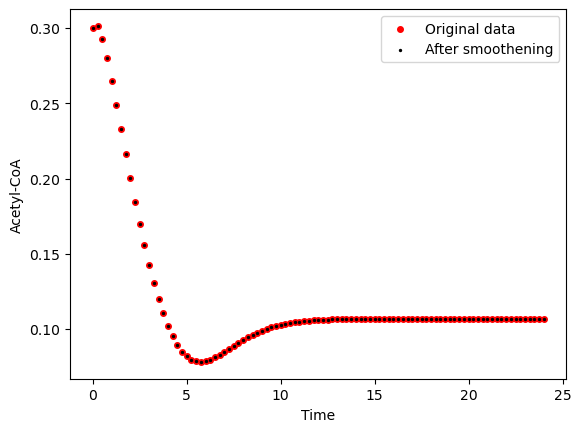

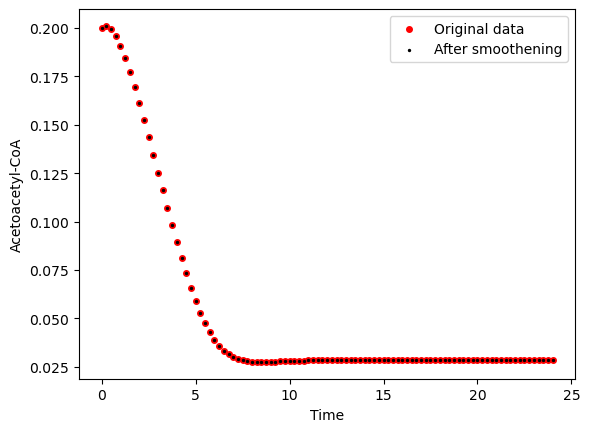

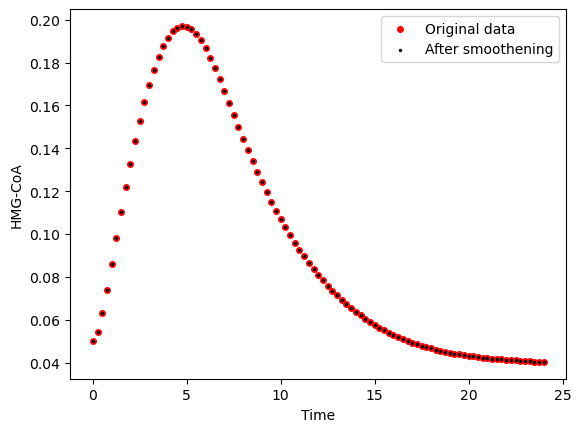

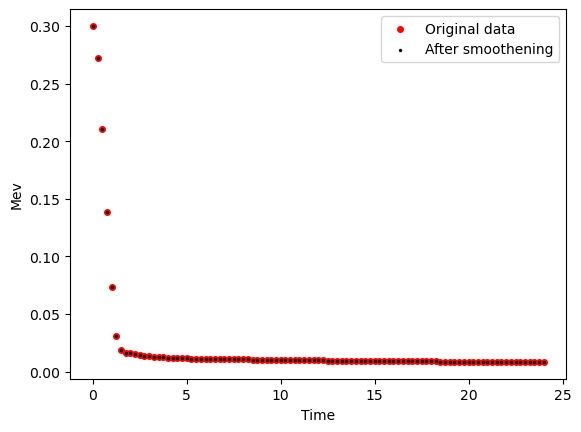

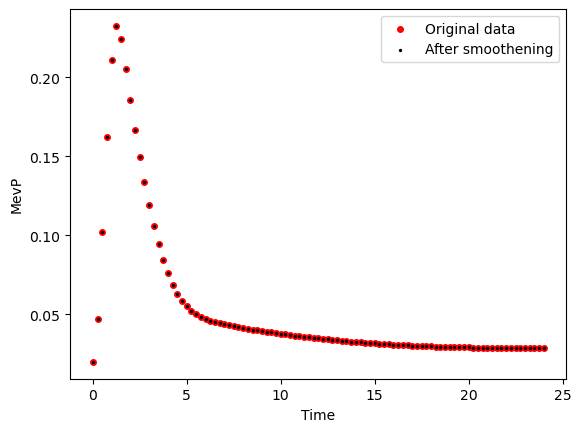

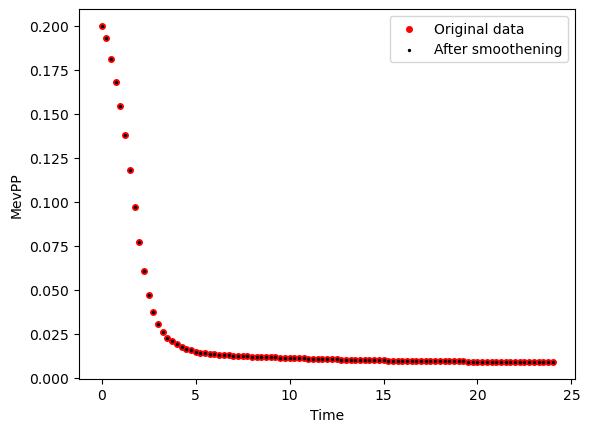

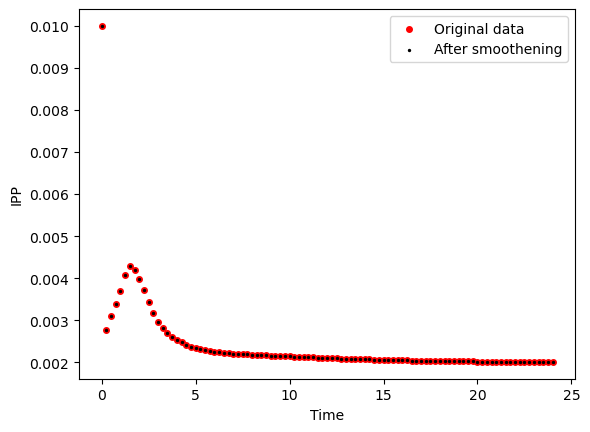

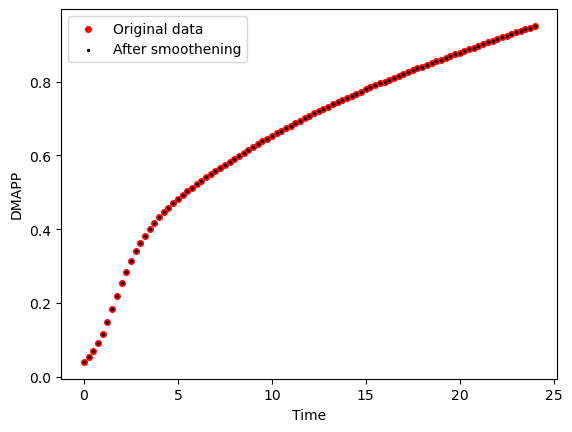

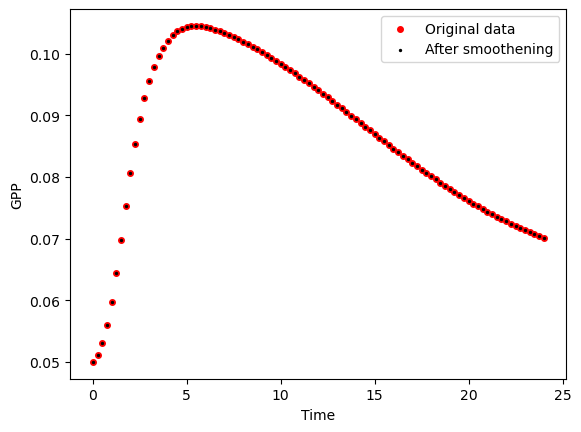

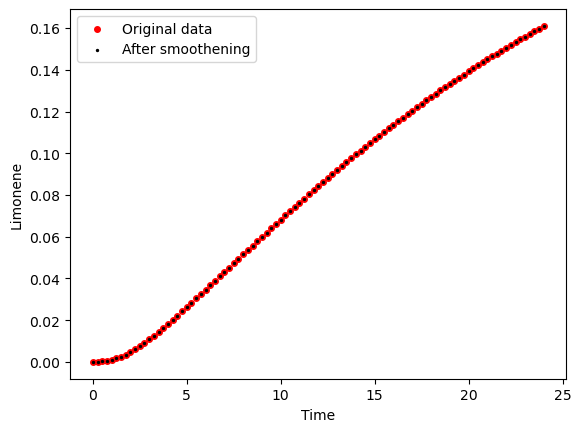

Strain Strain 2


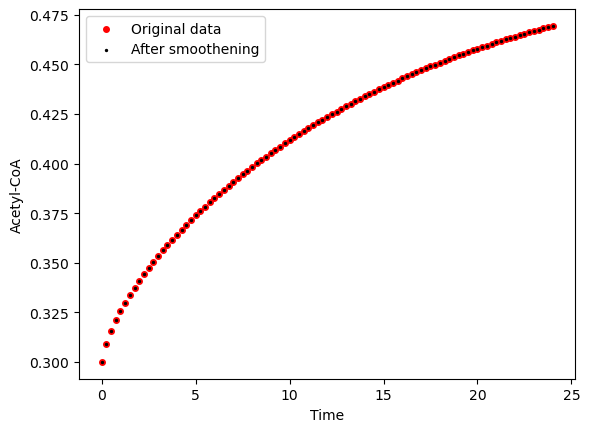

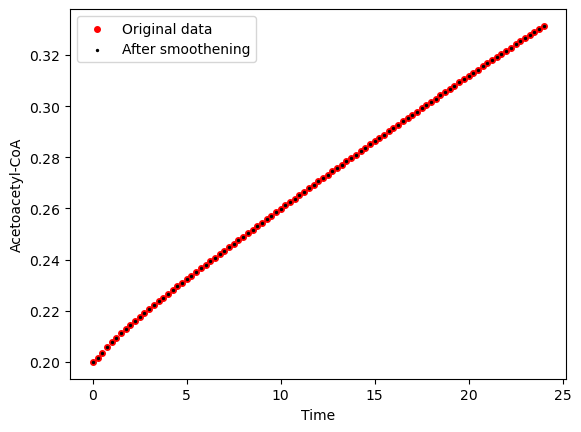

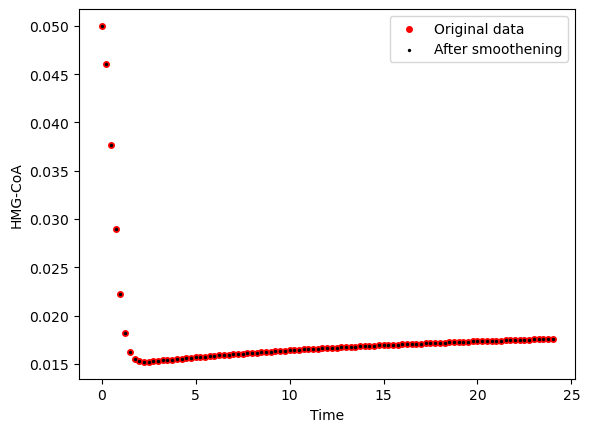

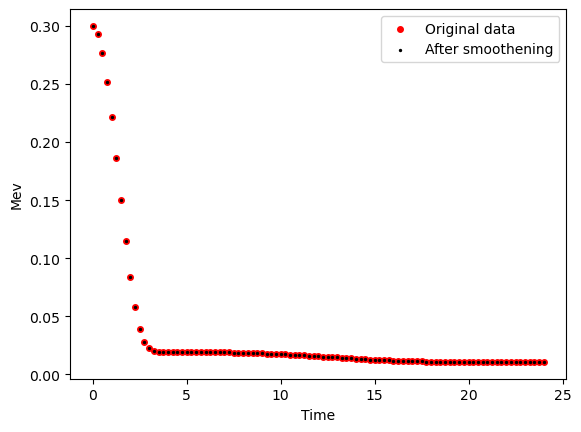

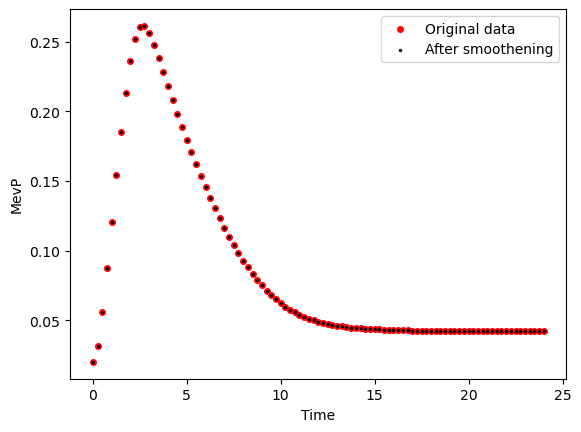

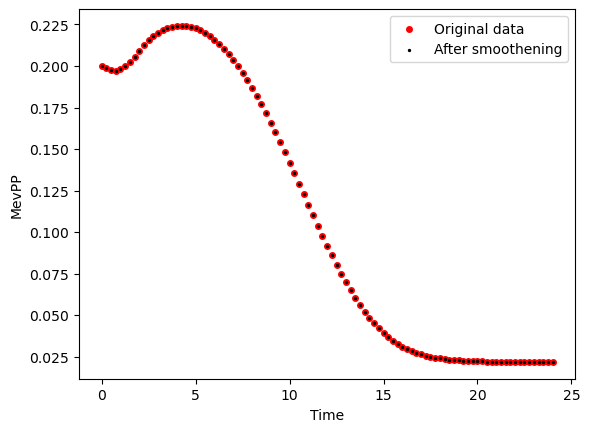

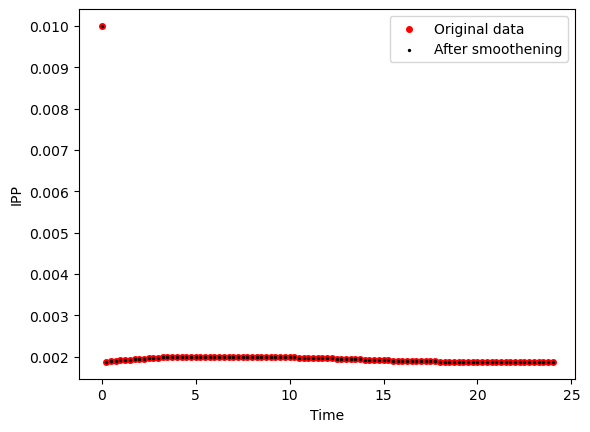

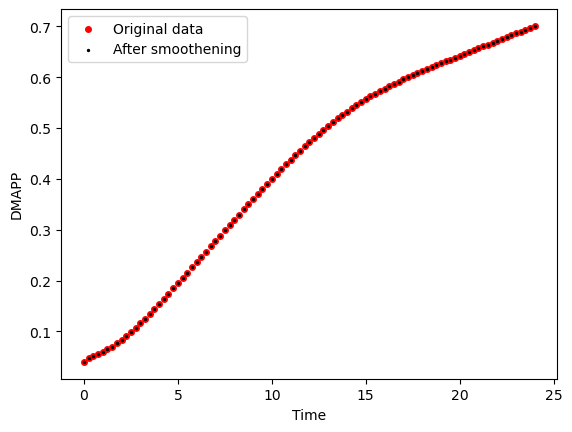

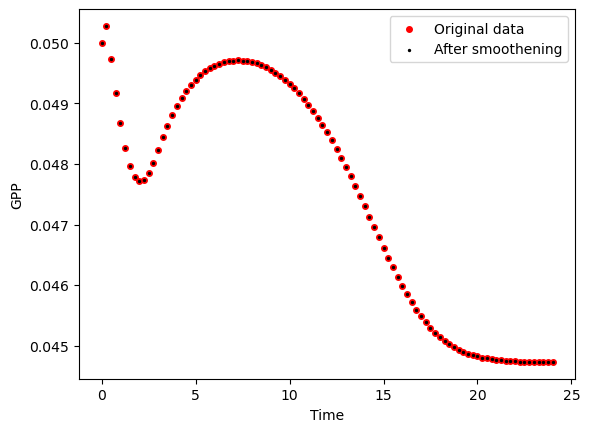

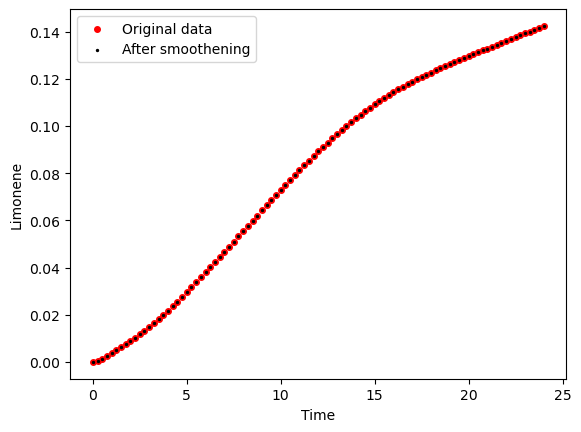

Strain Strain 3


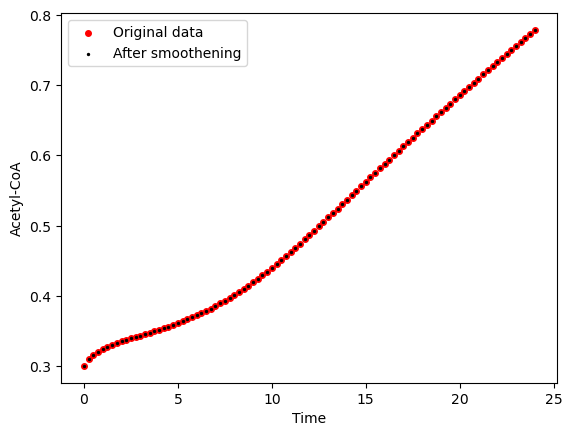

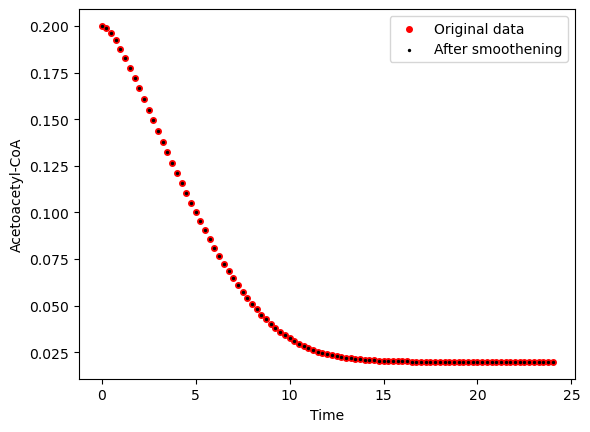

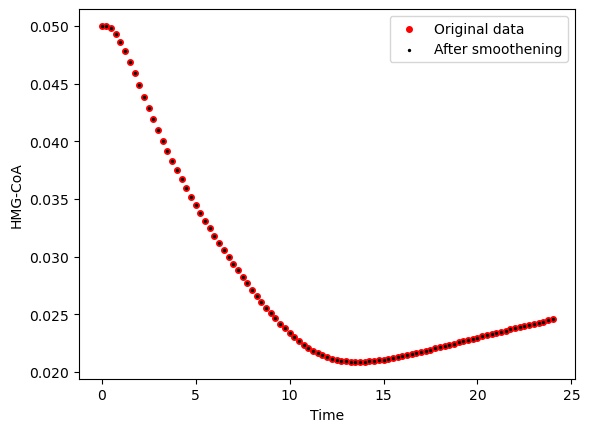

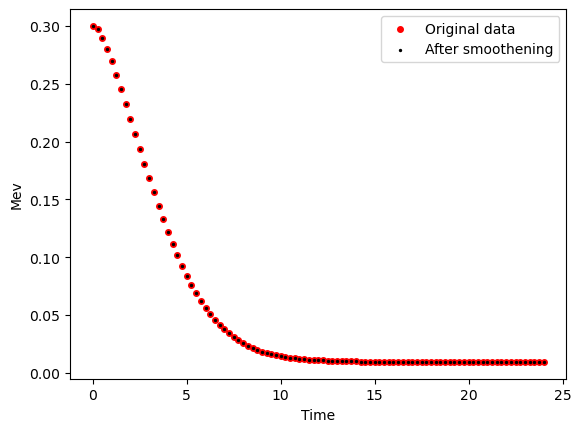

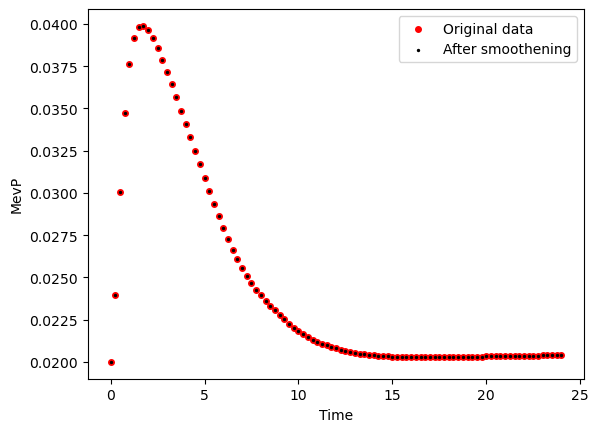

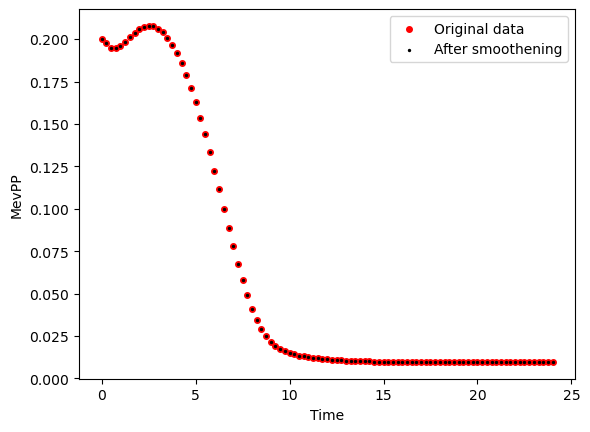

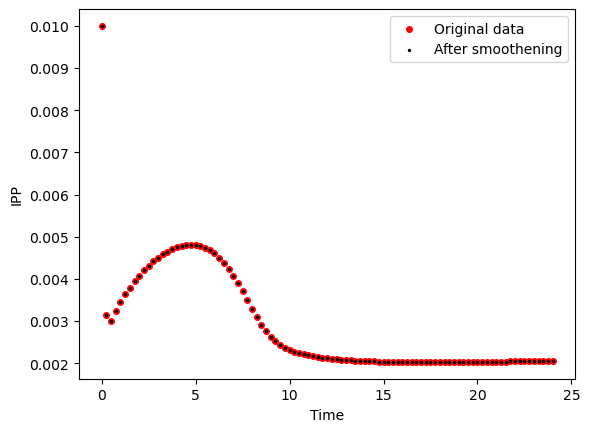

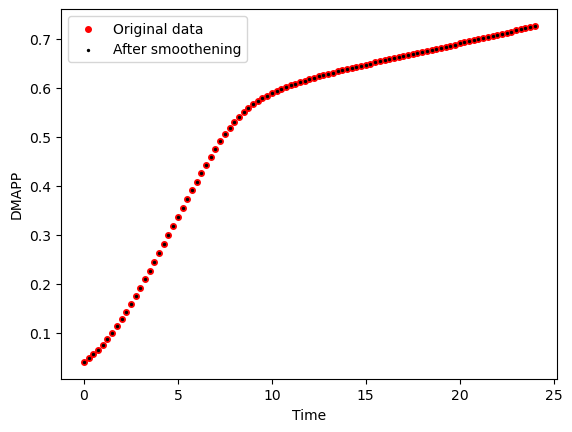

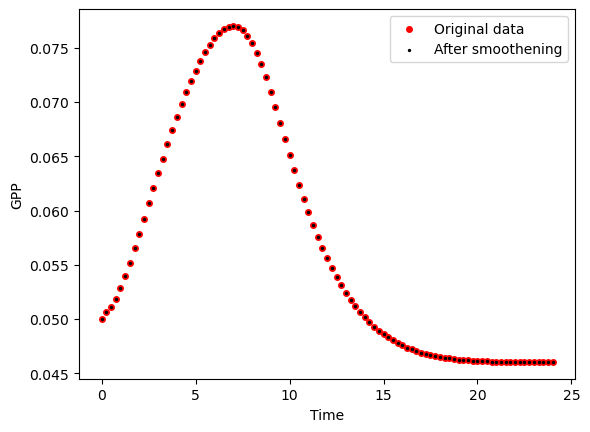

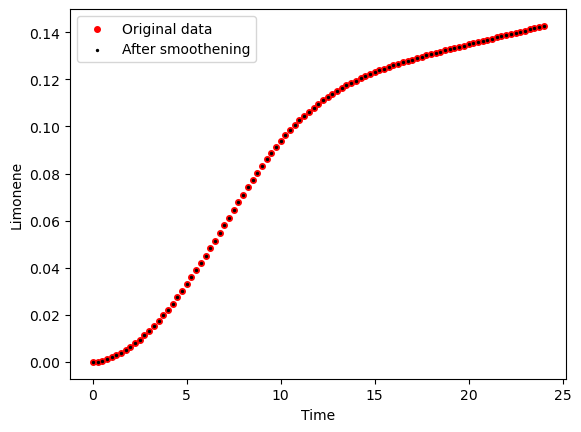

Strain WT


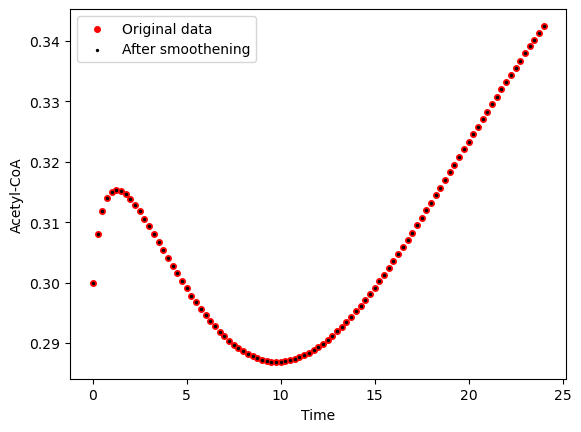

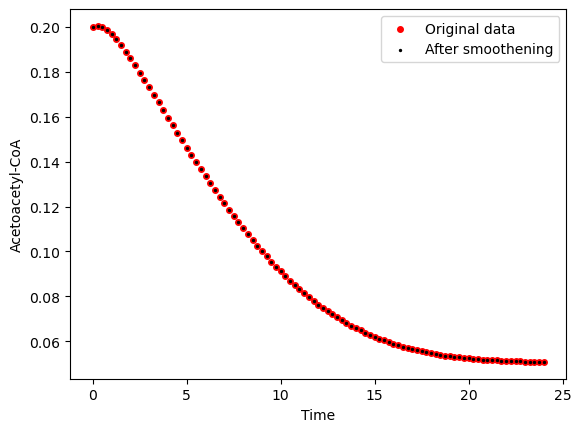

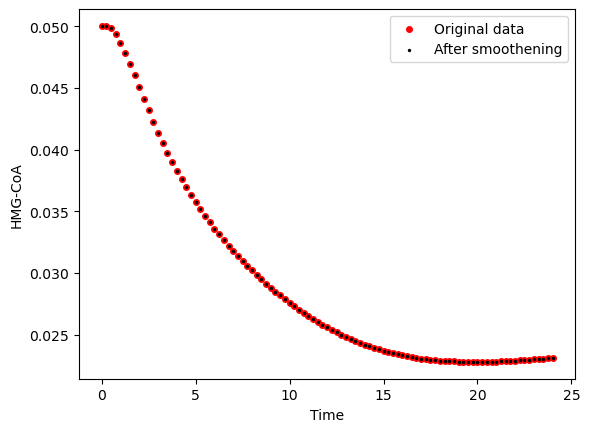

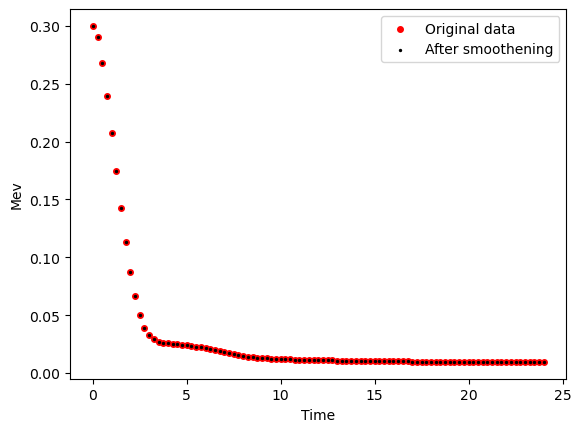

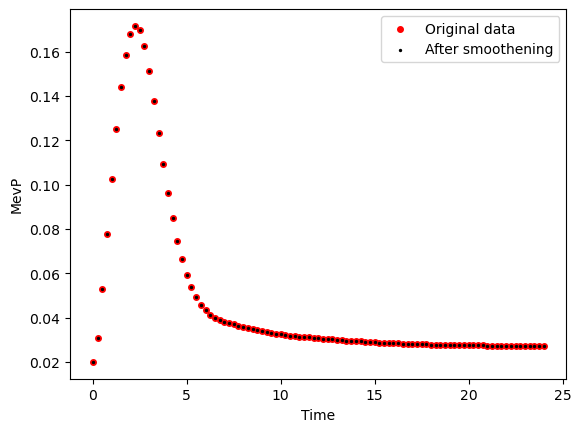

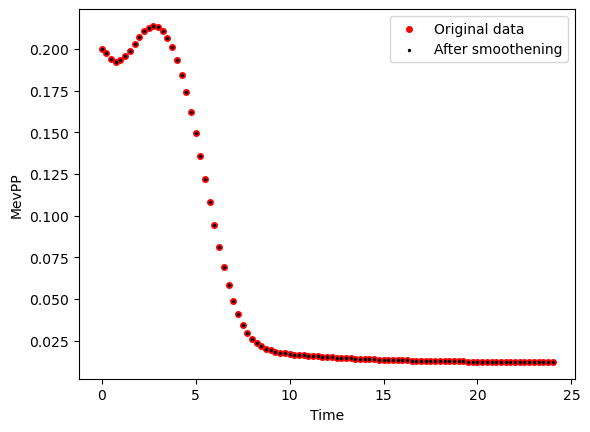

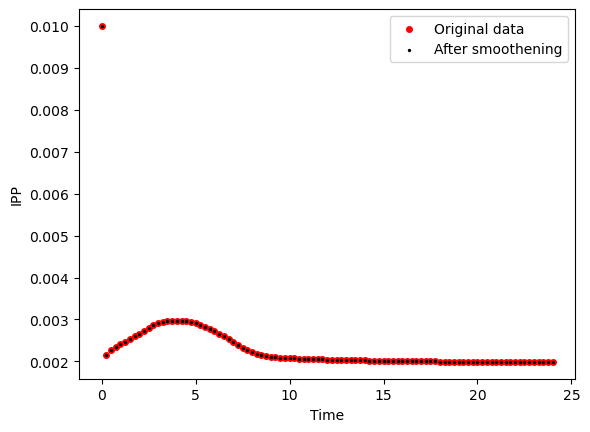

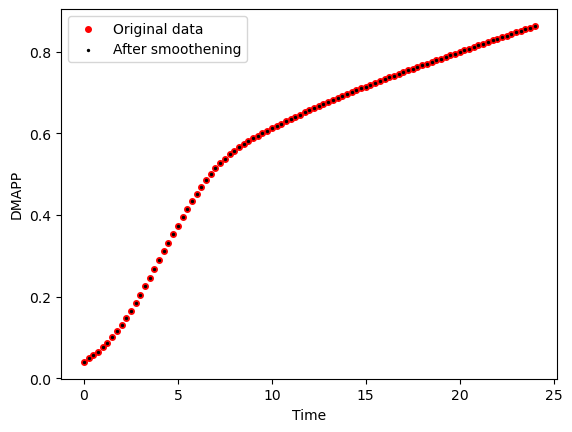

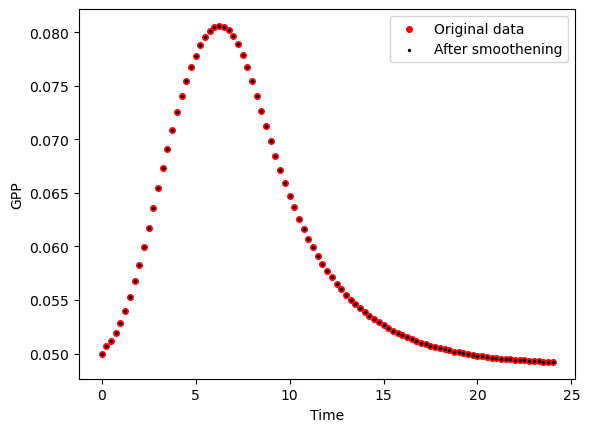

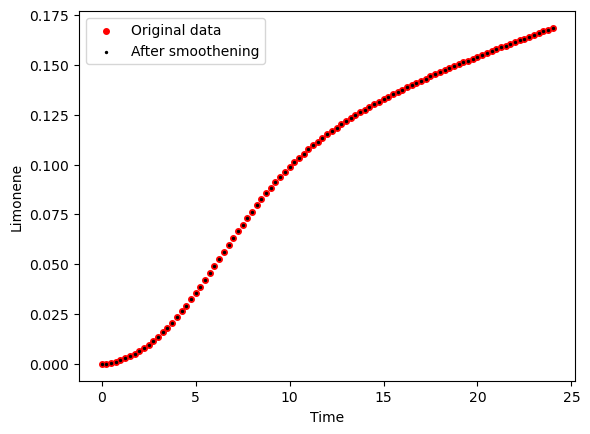

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


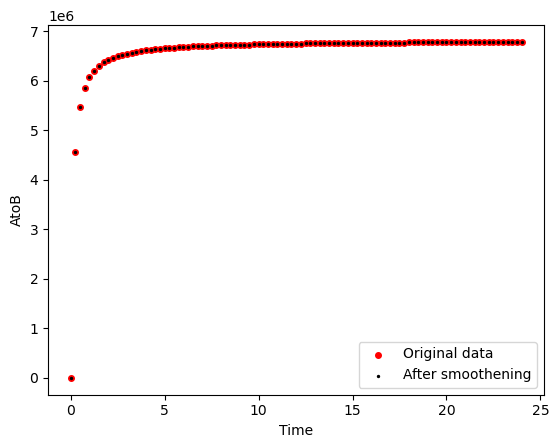

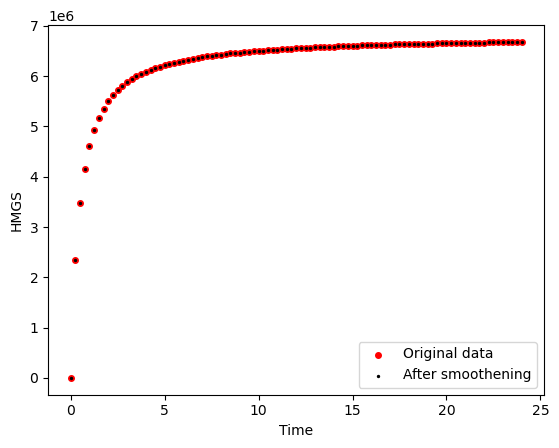

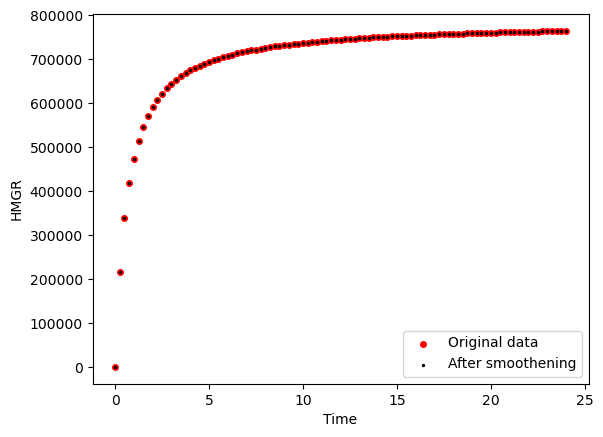

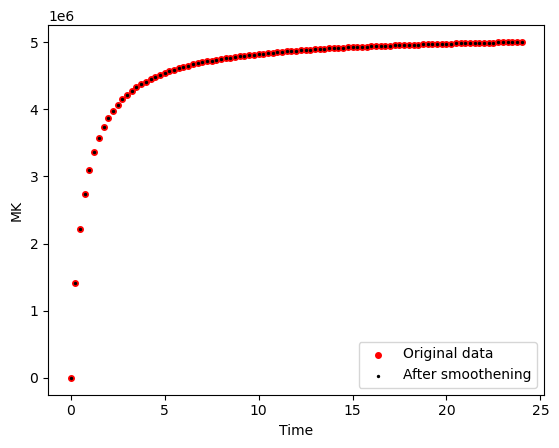

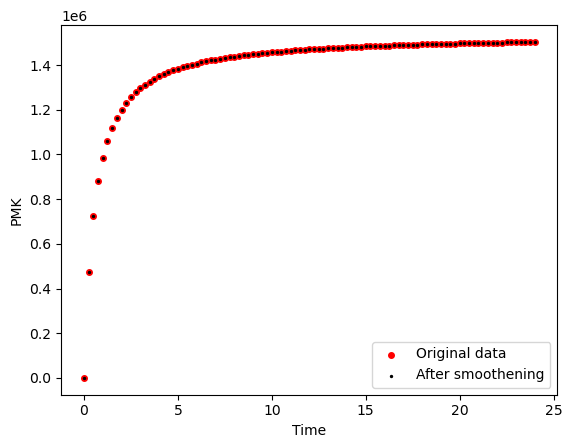

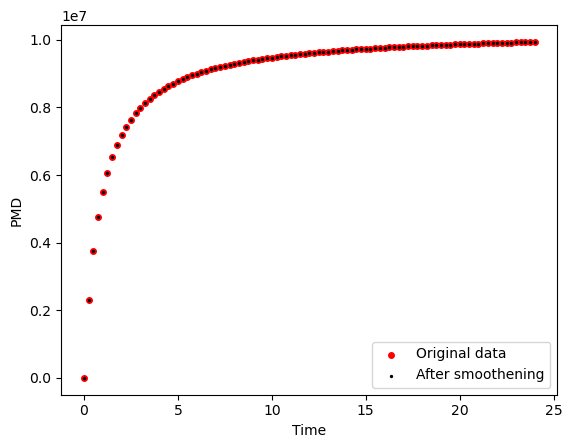

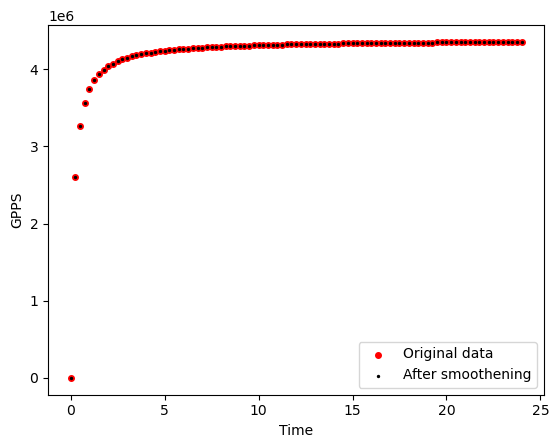

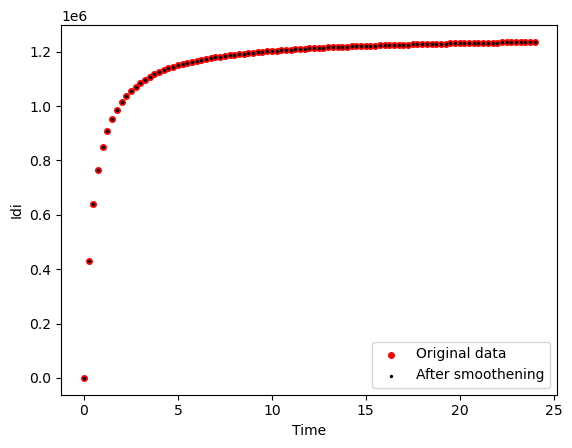

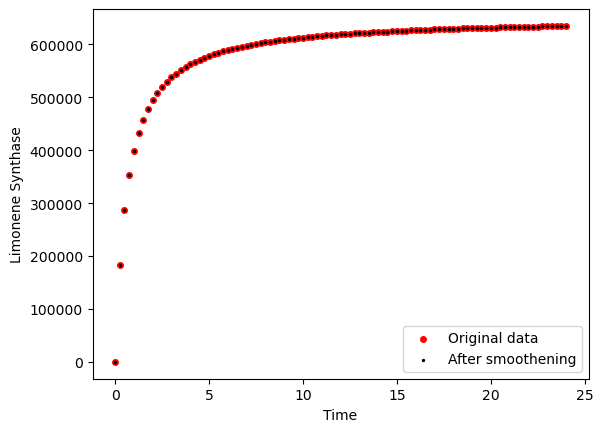

Strain Strain 2


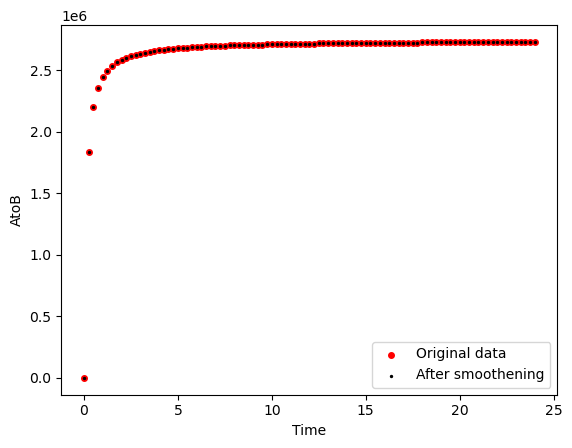

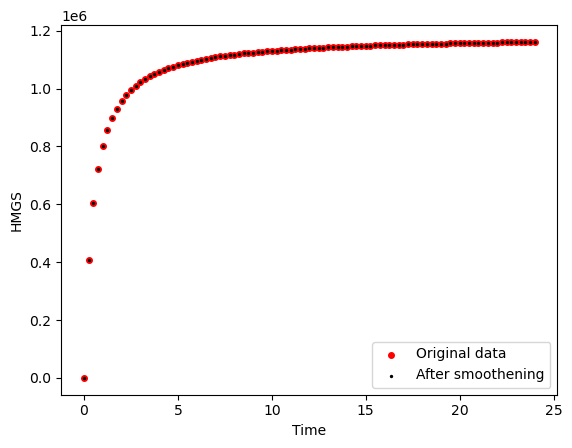

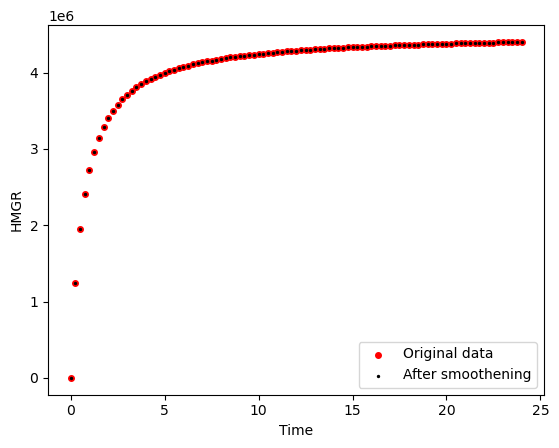

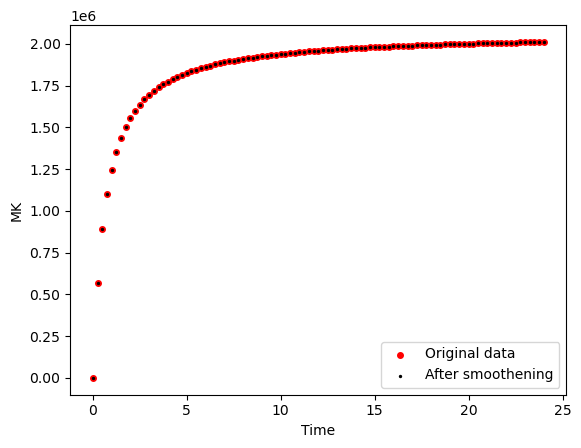

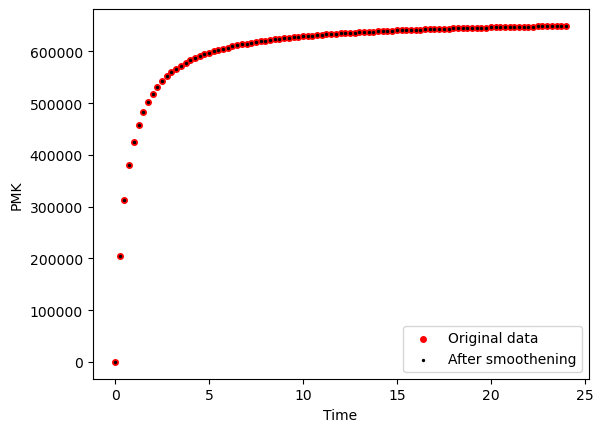

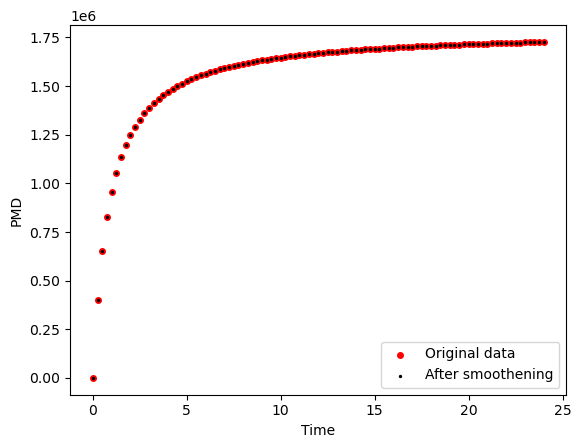

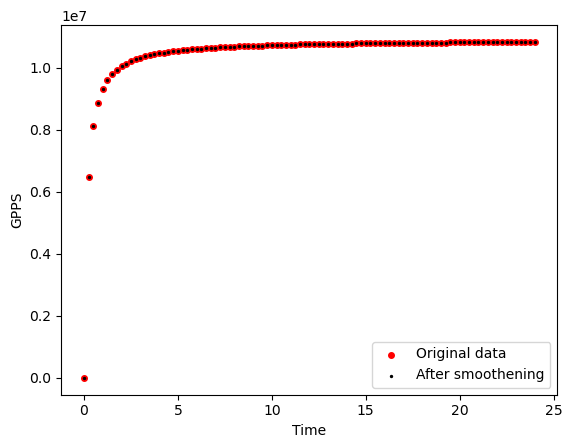

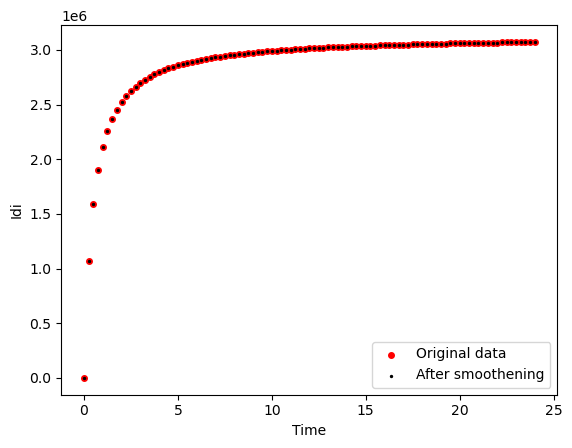

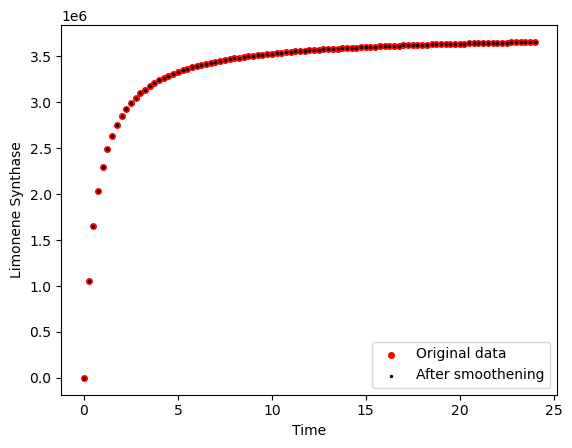

Strain Strain 3


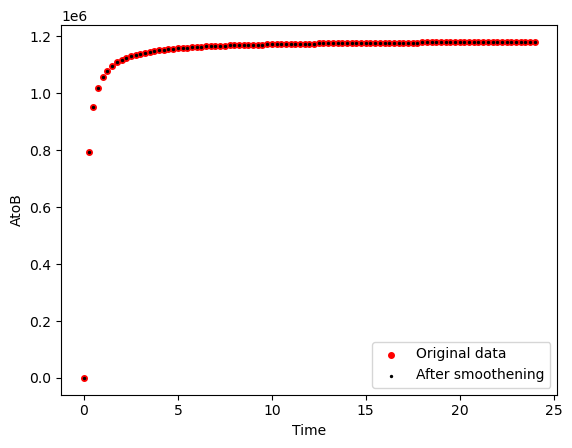

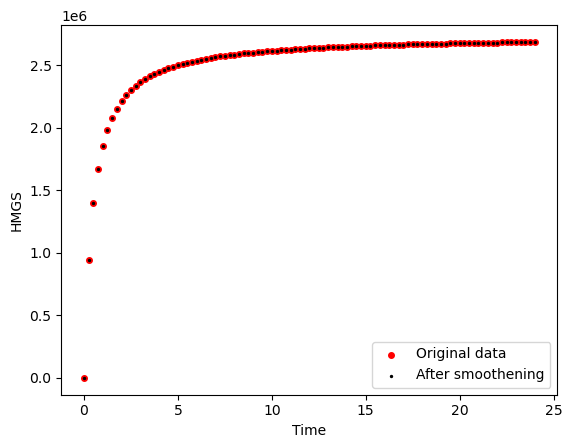

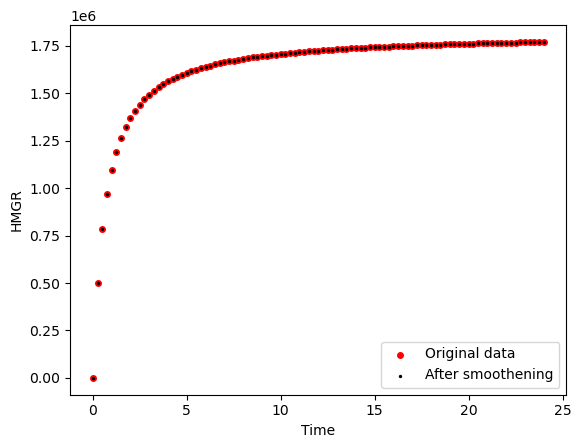

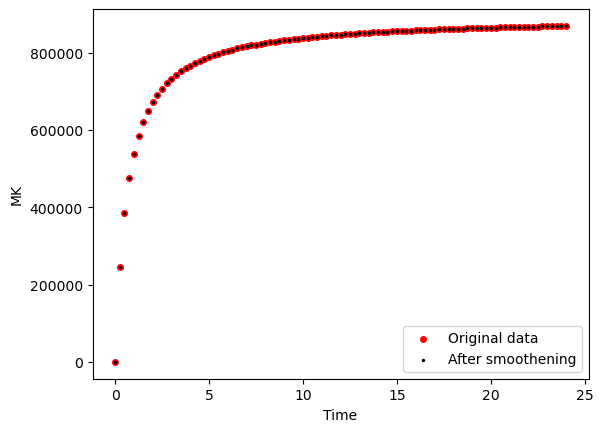

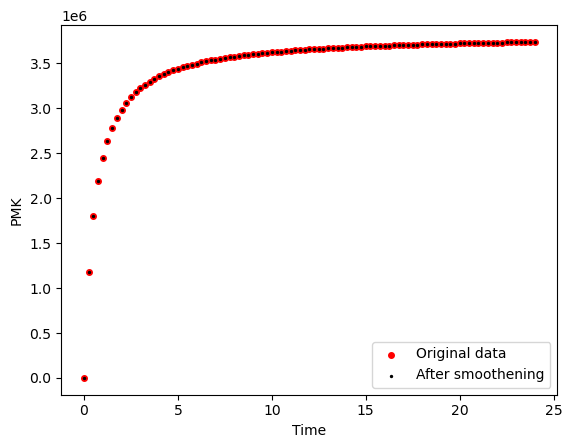

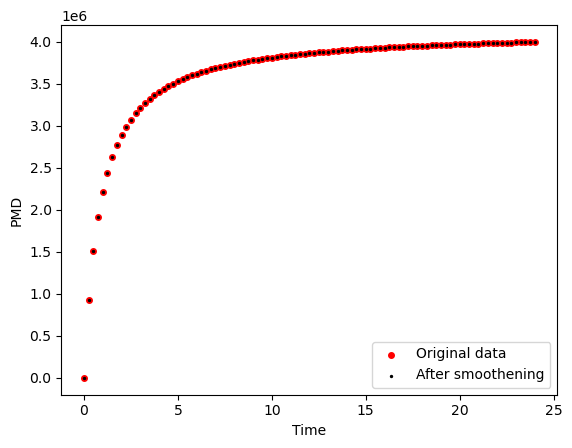

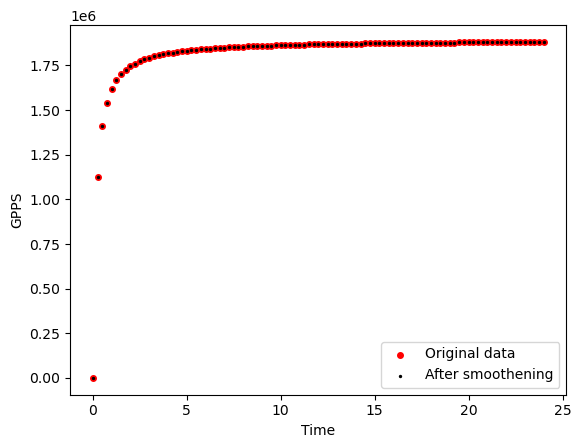

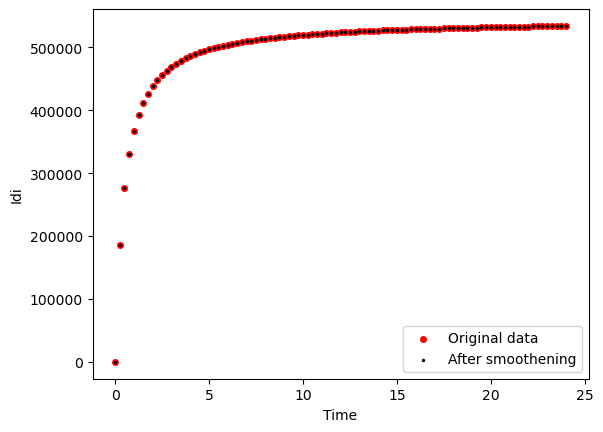

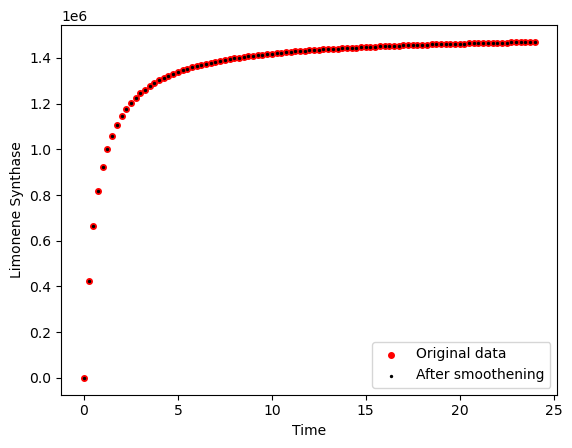

Strain WT


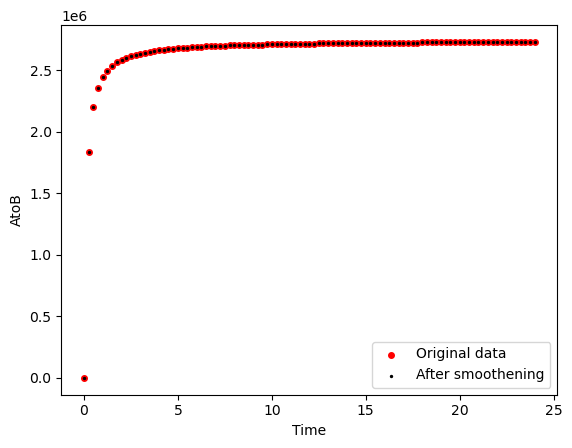

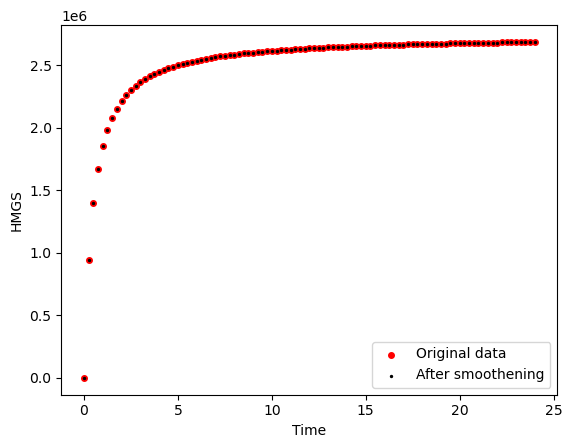

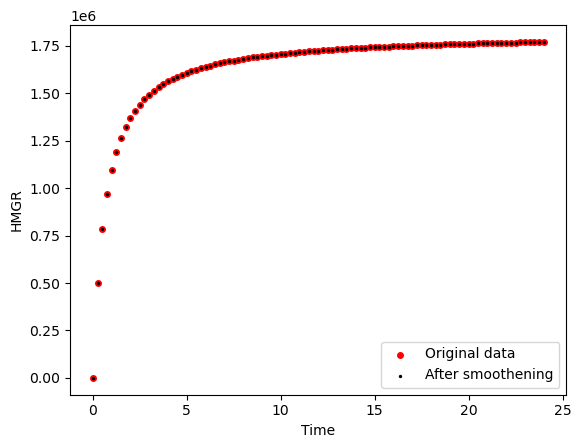

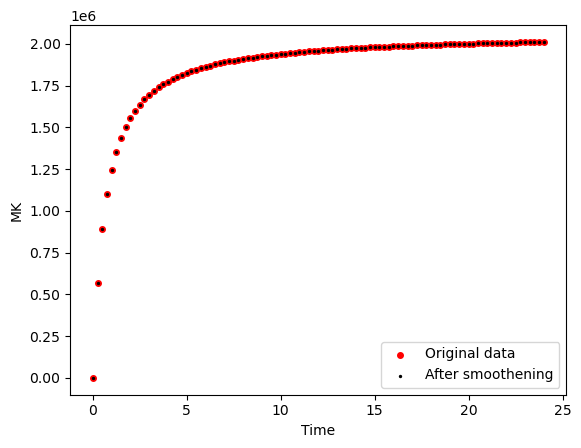

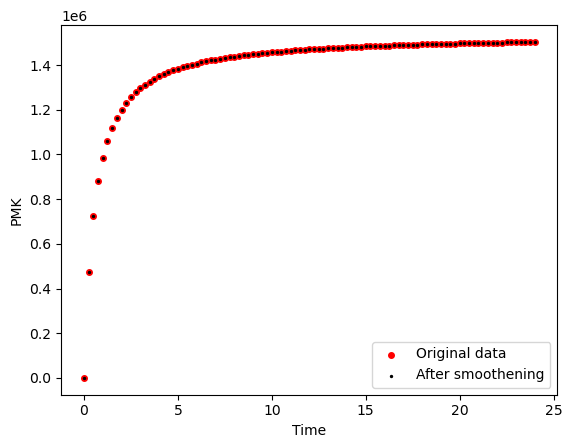

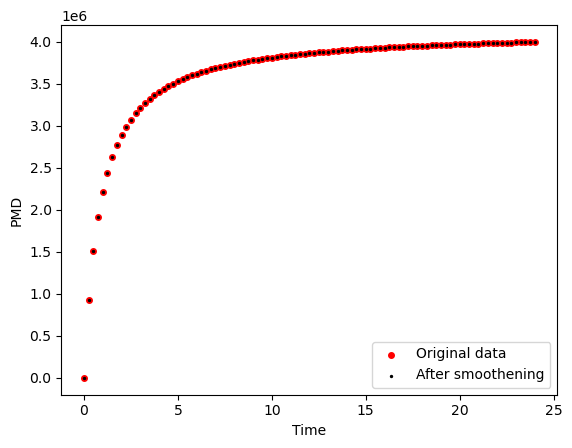

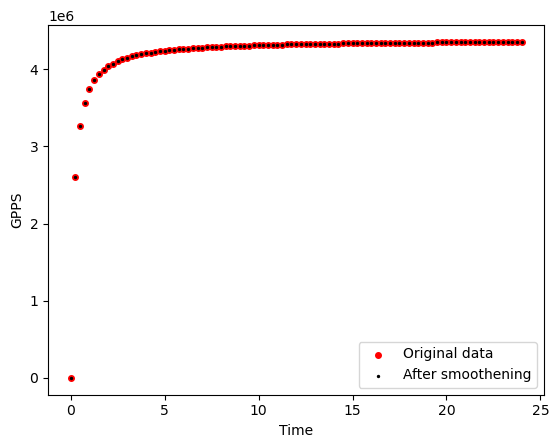

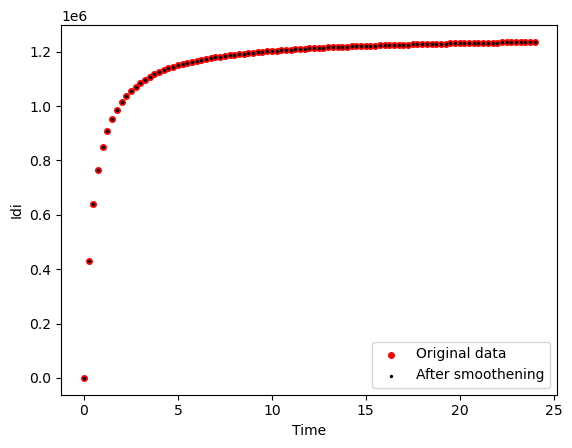

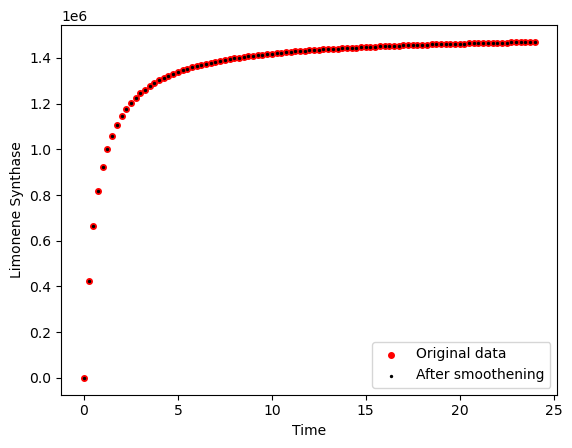

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

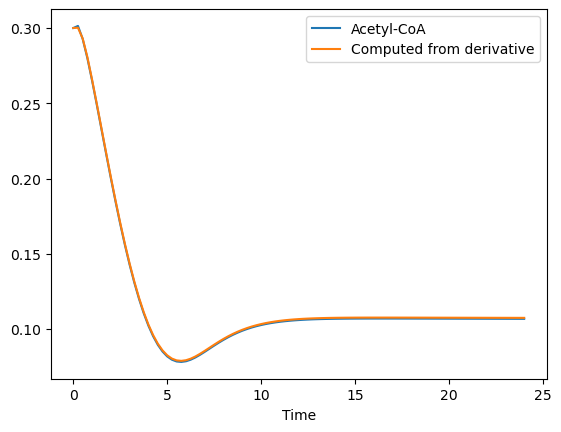

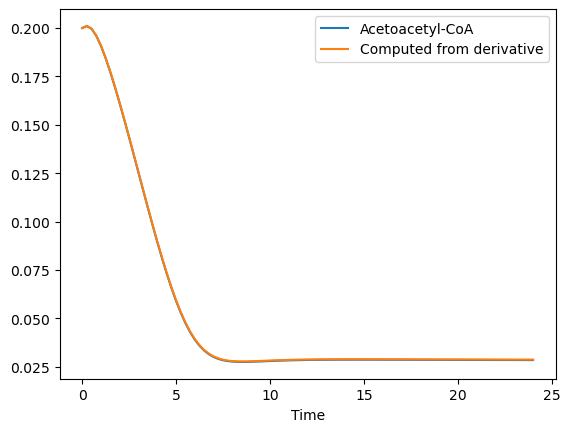

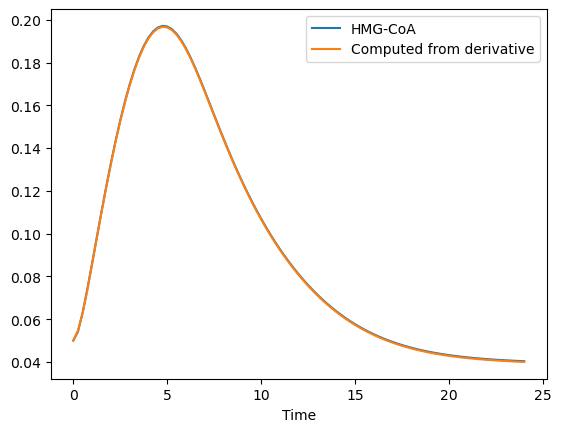

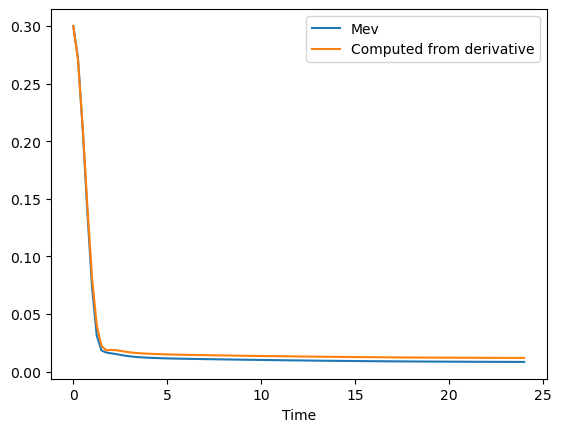

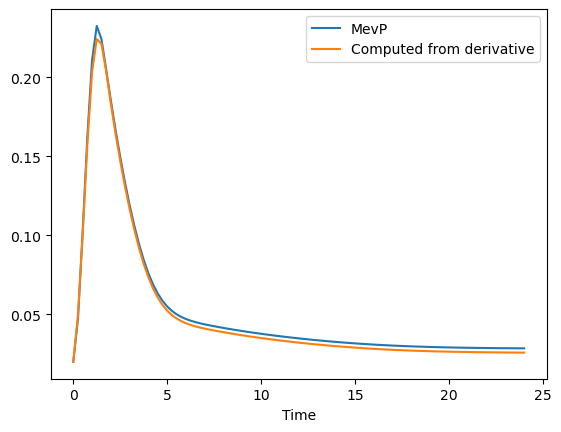

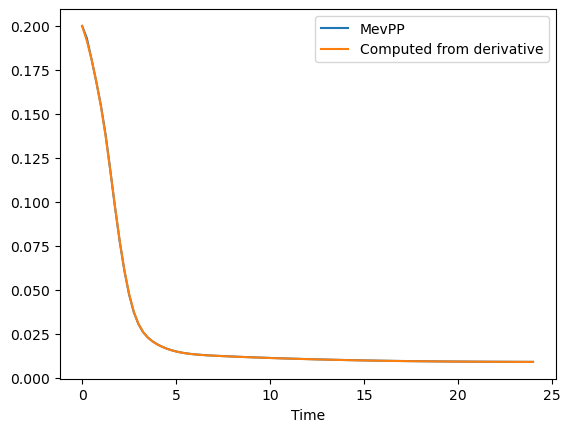

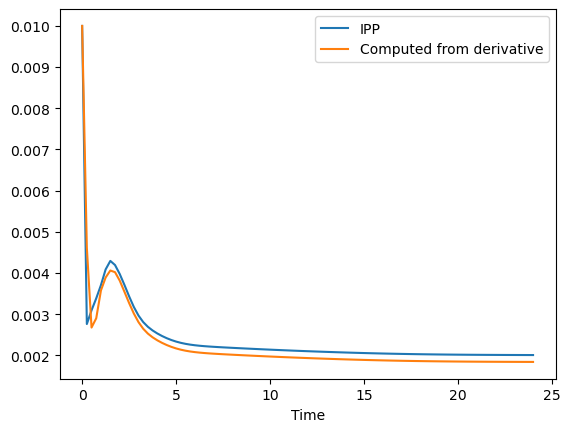

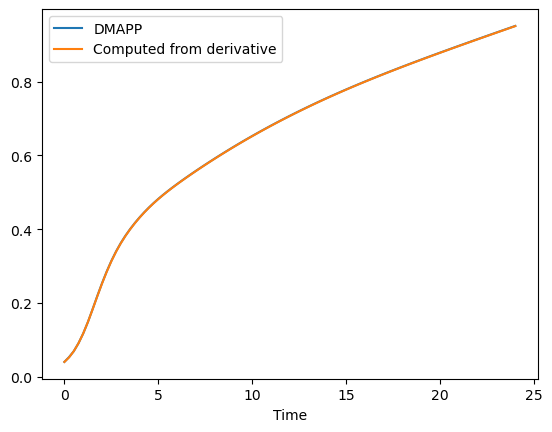

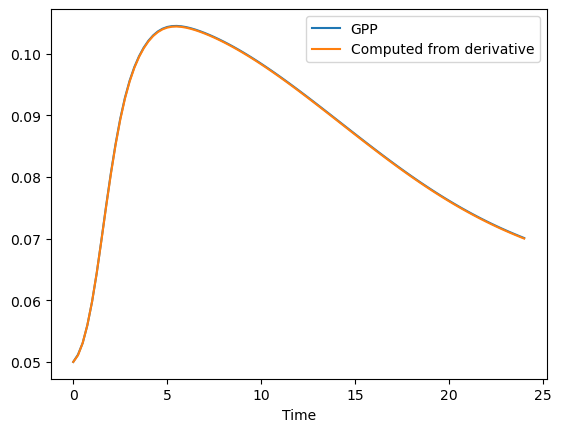

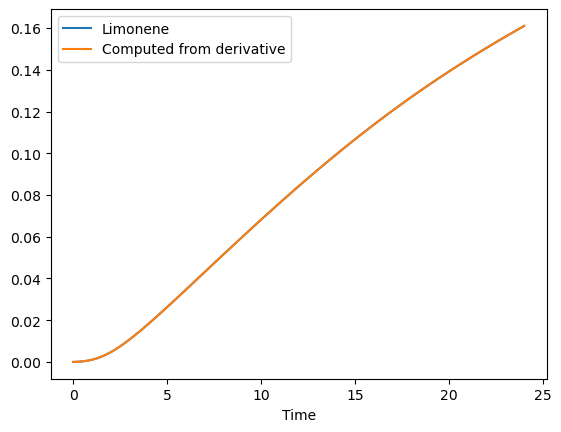

'Time profile from derivative vs. actual profile for Strain 2'

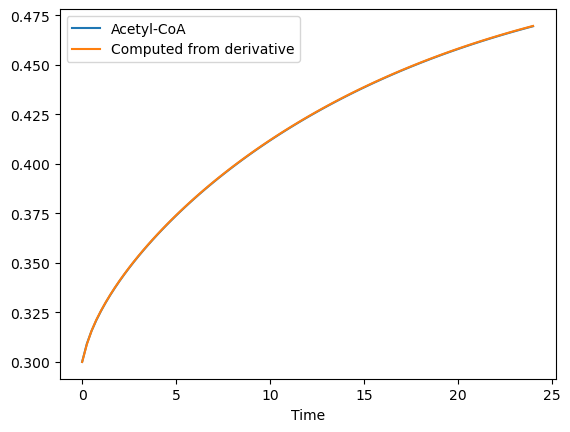

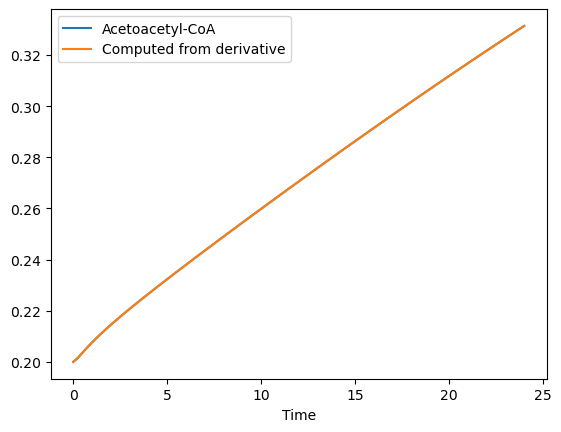

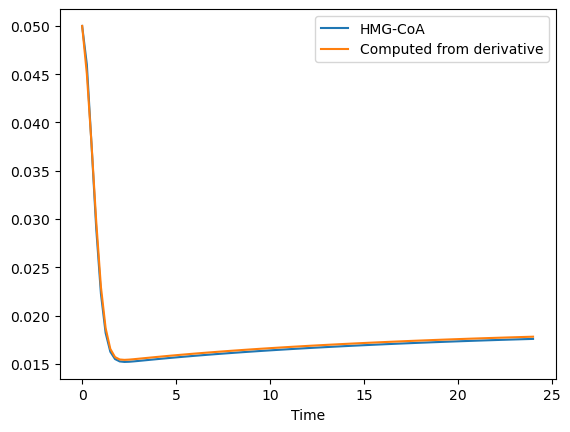

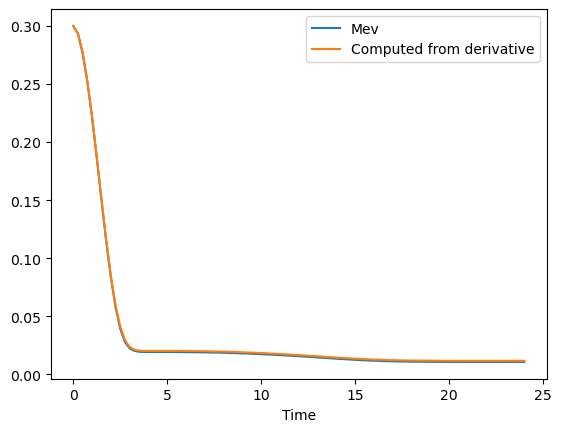

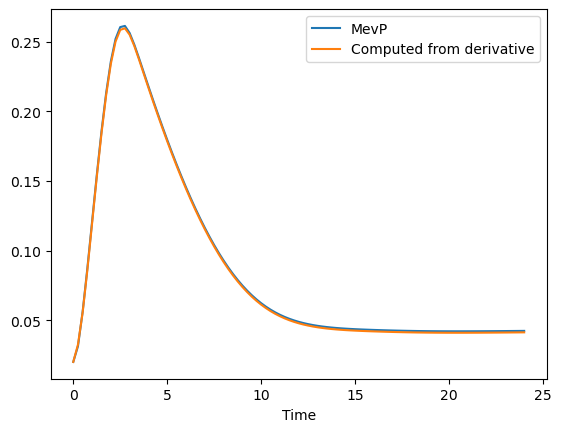

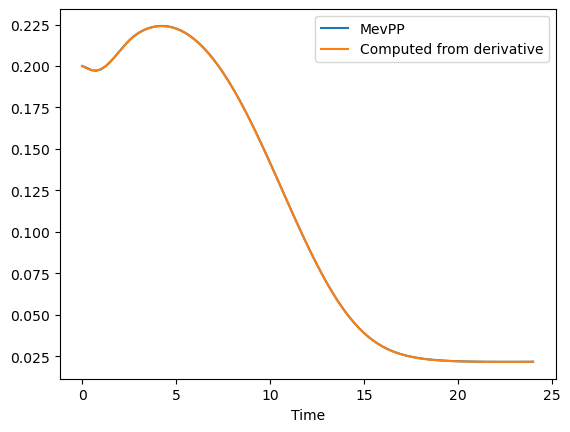

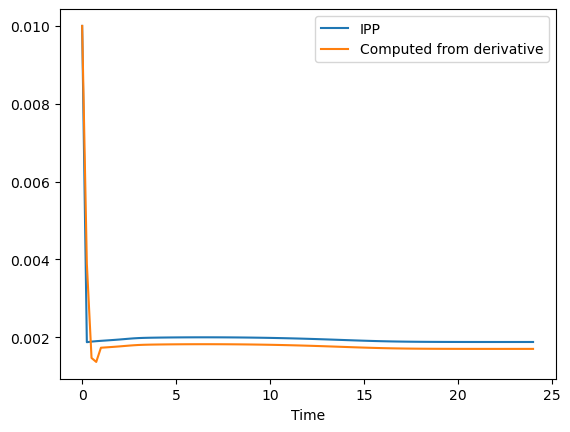

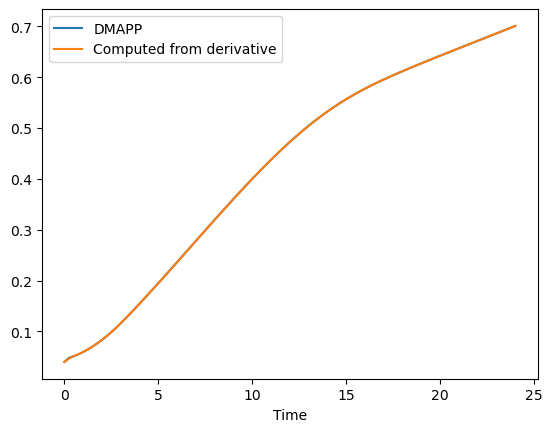

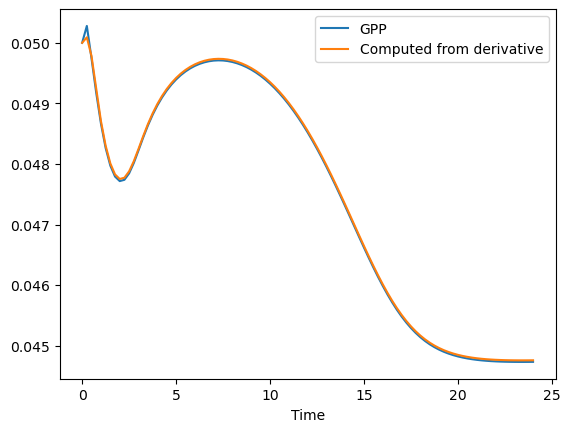

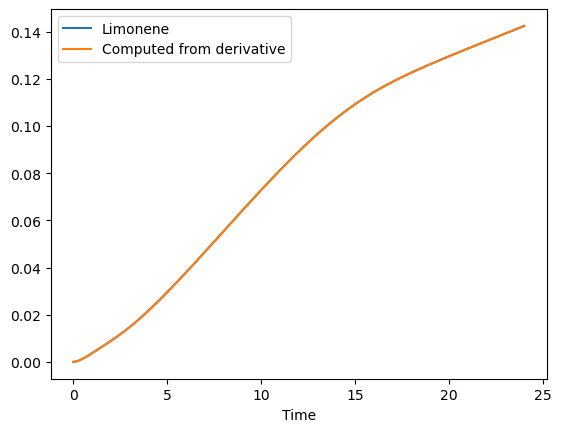

'Time profile from derivative vs. actual profile for Strain 3'

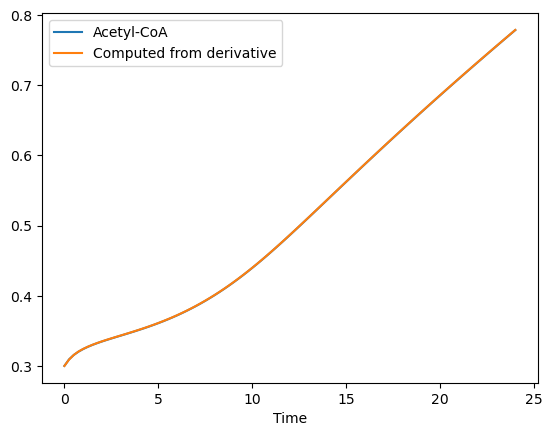

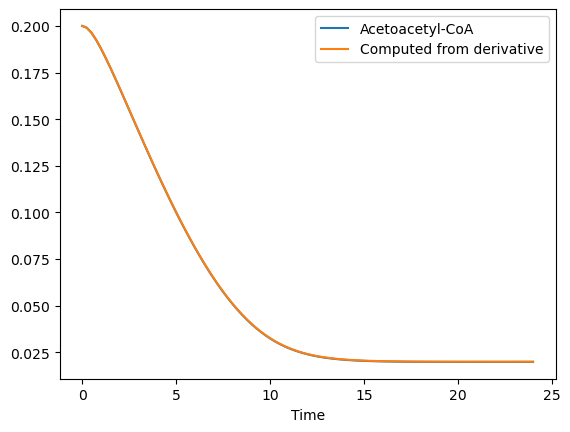

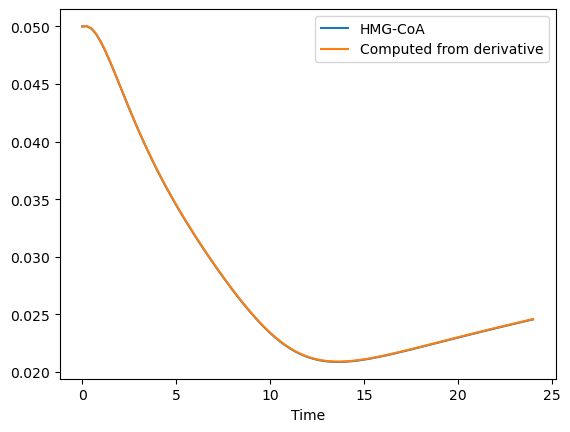

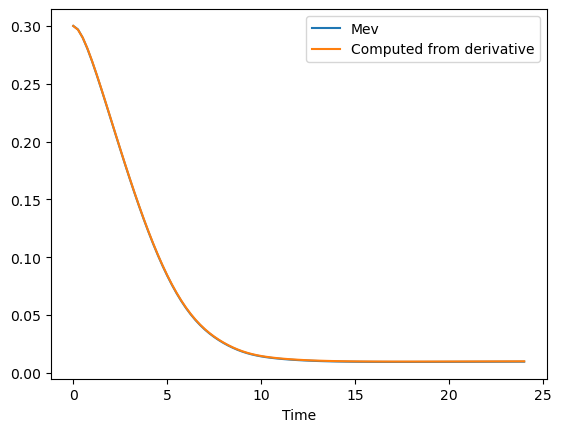

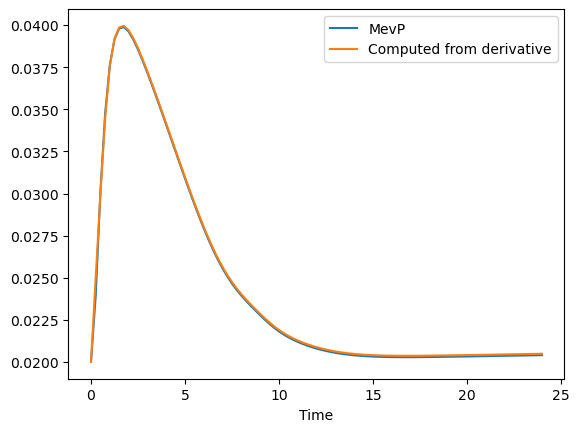

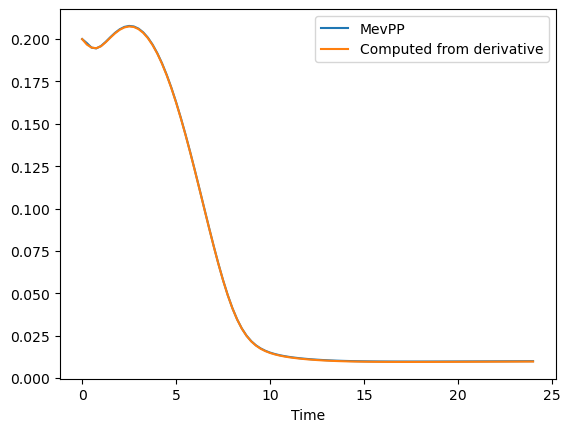

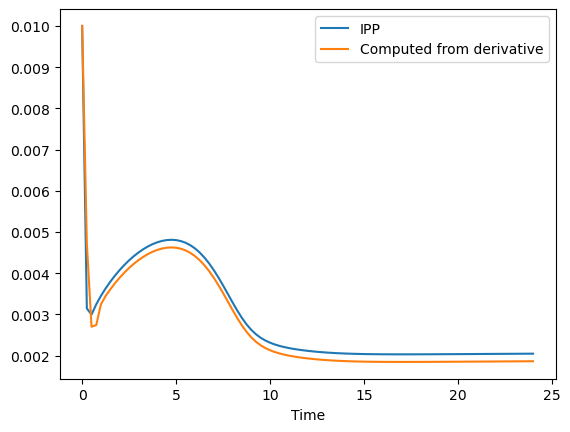

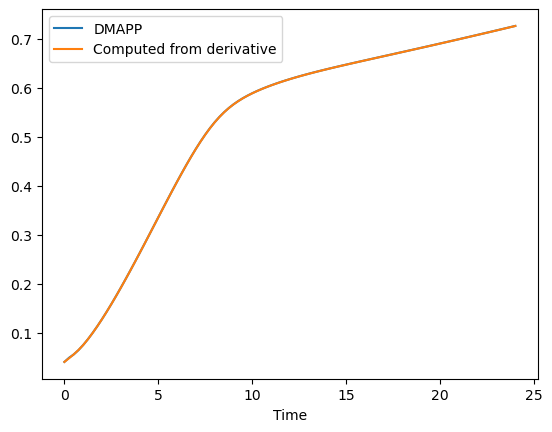

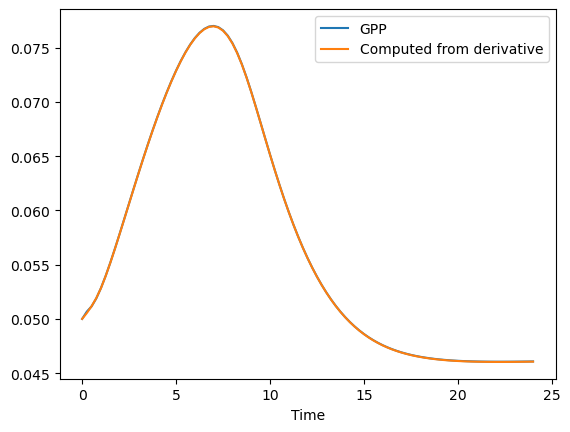

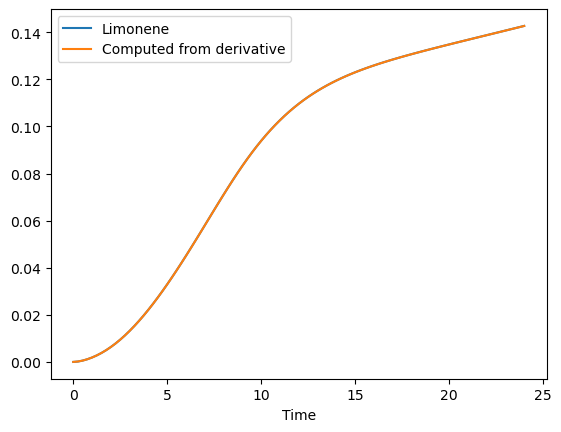

'Time profile from derivative vs. actual profile for WT'

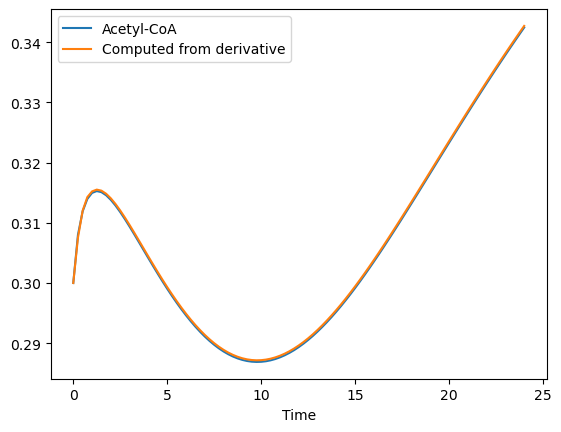

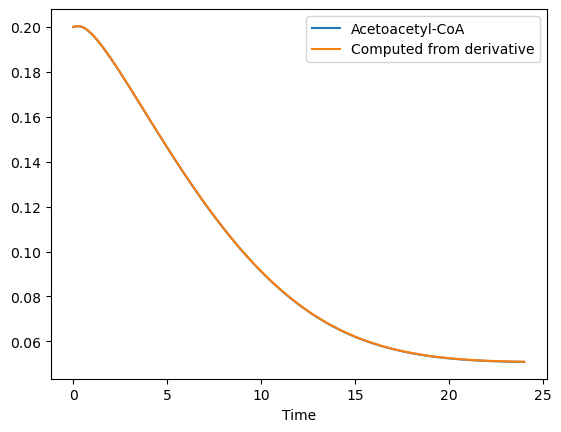

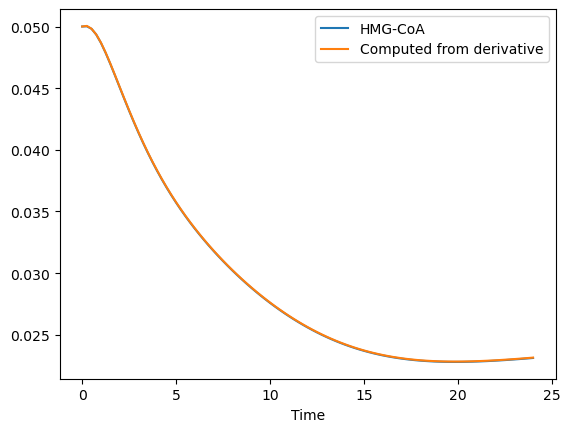

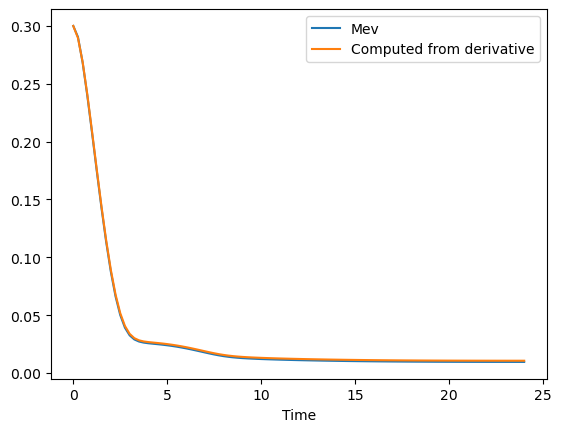

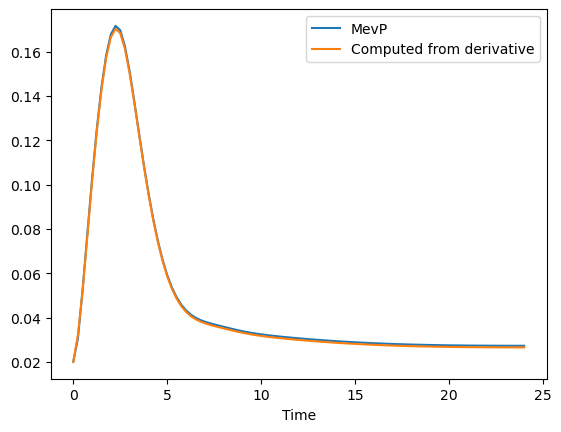

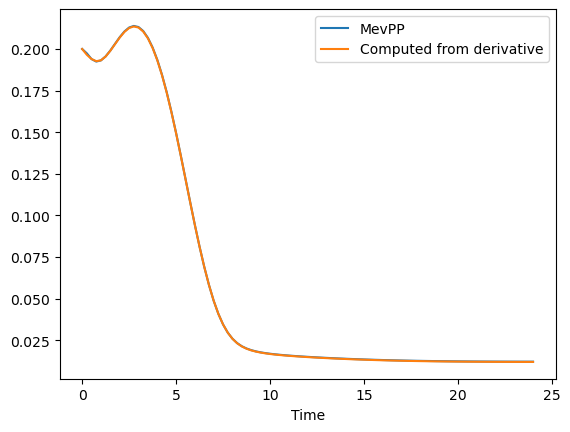

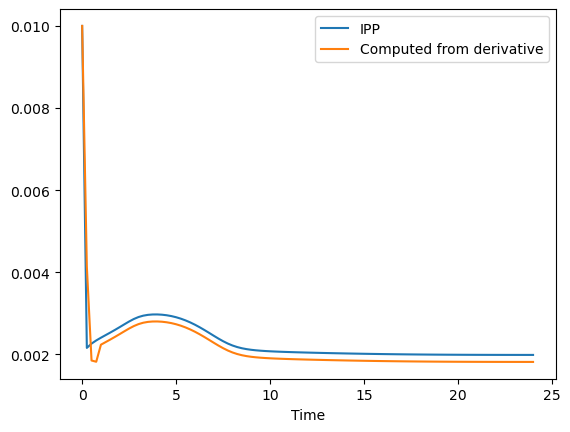

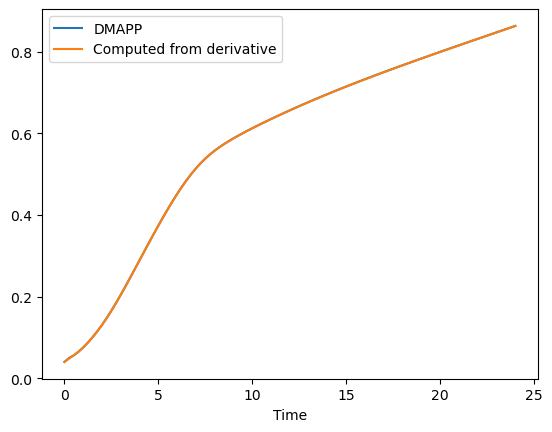

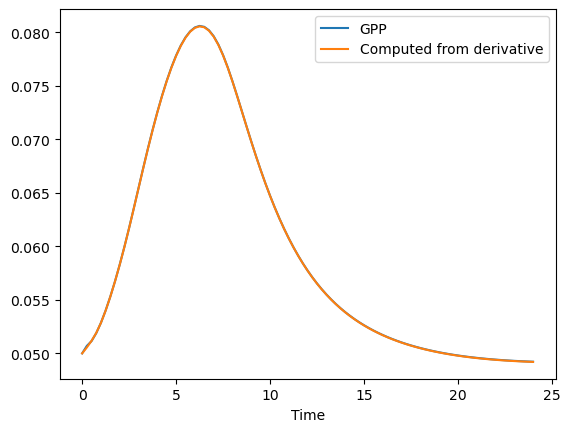

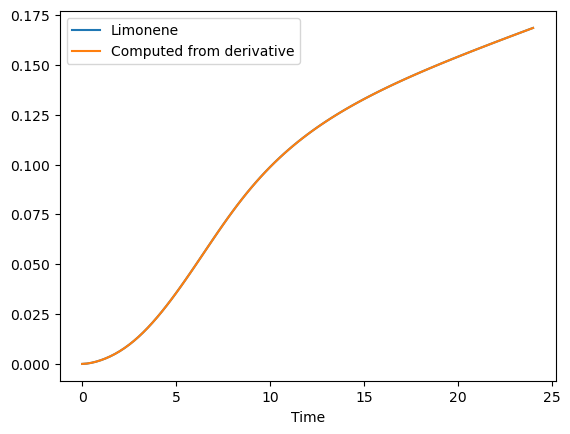

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  1.411190E+18 |  9.647246E+11
     2 |      128 |  7.220346E+17 |  1.037640E+09
     3 |      192 |  4.942728E+17 |  1.589203E+06
     4 |      256 |  7.115279E+16 |  1.768215E+05
     5 |      320 |  1.568848E+14 |  9.362134E+04
     6 |      384 |  1.567322E+14 |  5.643508E+04
     7 |      448 |  2.107816E+06 |  3.468438E+04
     8 |      512 |  4.479075E+04 |  1.961173E+04
     9 |      576 |  2.979986E+04 |  1.391038E+04
    10 |      640 |  2.131079E+04 |  1.026813E+04
    11 |      704 |  1.304190E+04 |  8.953711E+03
    12 |      768 |  9.532300E+03 |  5.972290E+03
    13 |      832 |  6.976901E+03 |  4.833444E+03
    14 |      896 |  5.457933E+03 |  3.052037E+03
    15 |      960 |  3.804911E+03 |  1.994282E+03
    16 |     1024 |  2.879147E+03 |  1.837917E+03
    17 |     1088 |  2.188013E+03 |  1.588482E+03
    18 |     1152 |  1.752243E+03 |  1.440642E+03
    19 |     1216 |  1.59

   162 |    10368 |  3.618780E+01 |  3.602786E+01
   163 |    10432 |  3.604233E+01 |  3.590121E+01
   164 |    10496 |  3.590258E+01 |  3.574227E+01
   165 |    10560 |  3.577863E+01 |  3.564864E+01
   166 |    10624 |  3.568173E+01 |  3.555746E+01
   167 |    10688 |  3.557339E+01 |  3.541386E+01
   168 |    10752 |  3.543175E+01 |  3.529170E+01
   169 |    10816 |  3.528821E+01 |  3.516032E+01
   170 |    10880 |  3.515242E+01 |  3.503764E+01
   171 |    10944 |  3.505730E+01 |  3.495698E+01
   172 |    11008 |  3.492511E+01 |  3.475179E+01
   173 |    11072 |  3.477230E+01 |  3.465629E+01
   174 |    11136 |  3.470510E+01 |  3.459153E+01
   175 |    11200 |  3.462980E+01 |  3.446612E+01
   176 |    11264 |  3.453784E+01 |  3.437846E+01
   177 |    11328 |  3.442762E+01 |  3.426511E+01
   178 |    11392 |  3.426651E+01 |  3.407034E+01
   179 |    11456 |  3.412005E+01 |  3.400055E+01
   180 |    11520 |  3.397667E+01 |  3.375547E+01
   181 |    11584 |  3.387798E+01 |  3.370525E+01


   326 |    20864 |  2.684464E+01 |  2.682470E+01
   327 |    20928 |  2.683675E+01 |  2.681557E+01
   328 |    20992 |  2.682412E+01 |  2.680665E+01
   329 |    21056 |  2.680993E+01 |  2.679527E+01
   330 |    21120 |  2.679929E+01 |  2.678621E+01
   331 |    21184 |  2.678701E+01 |  2.677578E+01
   332 |    21248 |  2.677498E+01 |  2.676539E+01
   333 |    21312 |  2.675625E+01 |  2.672966E+01
   334 |    21376 |  2.673946E+01 |  2.672135E+01
   335 |    21440 |  2.672643E+01 |  2.671394E+01
   336 |    21504 |  2.671528E+01 |  2.670444E+01
   337 |    21568 |  2.670280E+01 |  2.668740E+01
   338 |    21632 |  2.669107E+01 |  2.667746E+01
   339 |    21696 |  2.667784E+01 |  2.665896E+01
   340 |    21760 |  2.666136E+01 |  2.663797E+01
   341 |    21824 |  2.664225E+01 |  2.662493E+01
   342 |    21888 |  2.663037E+01 |  2.661891E+01
   343 |    21952 |  2.662218E+01 |  2.660837E+01
   344 |    22016 |  2.661845E+01 |  2.660741E+01
   345 |    22080 |  2.661704E+01 |  2.660335E+01


   490 |    31360 |  2.363992E+01 |  2.355518E+01
   491 |    31424 |  2.358475E+01 |  2.350314E+01
   492 |    31488 |  2.350471E+01 |  2.331981E+01
   493 |    31552 |  2.339449E+01 |  2.322939E+01
   494 |    31616 |  2.332290E+01 |  2.318578E+01
   495 |    31680 |  2.325718E+01 |  2.314951E+01
   496 |    31744 |  2.320599E+01 |  2.311719E+01
   497 |    31808 |  2.313654E+01 |  2.306964E+01
   498 |    31872 |  2.309334E+01 |  2.303224E+01
   499 |    31936 |  2.304285E+01 |  2.297122E+01
   500 |    32000 |  2.299279E+01 |  2.292662E+01
   501 |    32064 |  2.293811E+01 |  2.287831E+01
   502 |    32128 |  2.287824E+01 |  2.280510E+01
   503 |    32192 |  2.281036E+01 |  2.273680E+01
   504 |    32256 |  2.274262E+01 |  2.264649E+01
   505 |    32320 |  2.264752E+01 |  2.251285E+01
   506 |    32384 |  2.253066E+01 |  2.236447E+01
   507 |    32448 |  2.236424E+01 |  2.219902E+01
   508 |    32512 |  2.222010E+01 |  2.210202E+01
   509 |    32576 |  2.213426E+01 |  2.206331E+01


   654 |    41856 |  1.995239E+01 |  1.994582E+01
   655 |    41920 |  1.994661E+01 |  1.993979E+01
   656 |    41984 |  1.994106E+01 |  1.993799E+01
   657 |    42048 |  1.993823E+01 |  1.993500E+01
   658 |    42112 |  1.993439E+01 |  1.993024E+01
   659 |    42176 |  1.992932E+01 |  1.992248E+01
   660 |    42240 |  1.992272E+01 |  1.990875E+01
   661 |    42304 |  1.991208E+01 |  1.989573E+01
   662 |    42368 |  1.989883E+01 |  1.987244E+01
   663 |    42432 |  1.988335E+01 |  1.986627E+01
   664 |    42496 |  1.986961E+01 |  1.985410E+01
   665 |    42560 |  1.986118E+01 |  1.984677E+01
   666 |    42624 |  1.985370E+01 |  1.984496E+01
   667 |    42688 |  1.984739E+01 |  1.984043E+01
   668 |    42752 |  1.984124E+01 |  1.983298E+01
   669 |    42816 |  1.983482E+01 |  1.982892E+01
   670 |    42880 |  1.982851E+01 |  1.982110E+01
   671 |    42944 |  1.981989E+01 |  1.980998E+01
   672 |    43008 |  1.981185E+01 |  1.980322E+01
   673 |    43072 |  1.980518E+01 |  1.980054E+01


   818 |    52352 |  1.911175E+01 |  1.910606E+01
   819 |    52416 |  1.910758E+01 |  1.910301E+01
   820 |    52480 |  1.910402E+01 |  1.909870E+01
   821 |    52544 |  1.910022E+01 |  1.909669E+01
   822 |    52608 |  1.909777E+01 |  1.909591E+01
   823 |    52672 |  1.909608E+01 |  1.909239E+01
   824 |    52736 |  1.909318E+01 |  1.908962E+01
   825 |    52800 |  1.909058E+01 |  1.908611E+01
   826 |    52864 |  1.908669E+01 |  1.908182E+01
   827 |    52928 |  1.908252E+01 |  1.907812E+01
   828 |    52992 |  1.907955E+01 |  1.907557E+01
   829 |    53056 |  1.907566E+01 |  1.906993E+01
   830 |    53120 |  1.907111E+01 |  1.906570E+01
   831 |    53184 |  1.906574E+01 |  1.905778E+01
   832 |    53248 |  1.905986E+01 |  1.905297E+01
   833 |    53312 |  1.905423E+01 |  1.904686E+01
   834 |    53376 |  1.904905E+01 |  1.903781E+01
   835 |    53440 |  1.904205E+01 |  1.903377E+01
   836 |    53504 |  1.903615E+01 |  1.902668E+01
   837 |    53568 |  1.902909E+01 |  1.902054E+01


   982 |    62848 |  1.840067E+01 |  1.839728E+01
   983 |    62912 |  1.839770E+01 |  1.839335E+01
   984 |    62976 |  1.839400E+01 |  1.839036E+01
   985 |    63040 |  1.839086E+01 |  1.838732E+01
   986 |    63104 |  1.838691E+01 |  1.838123E+01
   987 |    63168 |  1.838209E+01 |  1.837837E+01
   988 |    63232 |  1.837737E+01 |  1.837101E+01
   989 |    63296 |  1.837157E+01 |  1.836569E+01
   990 |    63360 |  1.836676E+01 |  1.836323E+01
   991 |    63424 |  1.836406E+01 |  1.835998E+01
   992 |    63488 |  1.836028E+01 |  1.835569E+01
   993 |    63552 |  1.835738E+01 |  1.835364E+01
   994 |    63616 |  1.835347E+01 |  1.834757E+01
   995 |    63680 |  1.834749E+01 |  1.834021E+01
   996 |    63744 |  1.834213E+01 |  1.833518E+01
   997 |    63808 |  1.833564E+01 |  1.833032E+01
   998 |    63872 |  1.833105E+01 |  1.832638E+01
   999 |    63936 |  1.832714E+01 |  1.832329E+01
  1000 |    64000 |  1.832372E+01 |  1.832013E+01
  1001 |    64064 |  1.831971E+01 |  1.831640E+01


  1146 |    73344 |  1.801676E+01 |  1.801331E+01
  1147 |    73408 |  1.801415E+01 |  1.801135E+01
  1148 |    73472 |  1.801013E+01 |  1.800320E+01
  1149 |    73536 |  1.800528E+01 |  1.799808E+01
  1150 |    73600 |  1.800214E+01 |  1.799740E+01
  1151 |    73664 |  1.799893E+01 |  1.799475E+01
  1152 |    73728 |  1.799561E+01 |  1.799217E+01
  1153 |    73792 |  1.799267E+01 |  1.798947E+01
  1154 |    73856 |  1.798928E+01 |  1.798569E+01
  1155 |    73920 |  1.798643E+01 |  1.798332E+01
  1156 |    73984 |  1.798437E+01 |  1.798167E+01
  1157 |    74048 |  1.798249E+01 |  1.797930E+01
  1158 |    74112 |  1.798062E+01 |  1.797786E+01
  1159 |    74176 |  1.797848E+01 |  1.797693E+01
  1160 |    74240 |  1.797675E+01 |  1.797521E+01
  1161 |    74304 |  1.797564E+01 |  1.797460E+01
  1162 |    74368 |  1.797474E+01 |  1.797411E+01
  1163 |    74432 |  1.797417E+01 |  1.797374E+01
  1164 |    74496 |  1.797382E+01 |  1.797329E+01
  1165 |    74560 |  1.797343E+01 |  1.797297E+01


  1310 |    83840 |  1.787212E+01 |  1.787133E+01
  1311 |    83904 |  1.787122E+01 |  1.786890E+01
  1312 |    83968 |  1.786987E+01 |  1.786805E+01
  1313 |    84032 |  1.786884E+01 |  1.786786E+01
  1314 |    84096 |  1.786826E+01 |  1.786726E+01
  1315 |    84160 |  1.786770E+01 |  1.786715E+01
  1316 |    84224 |  1.786728E+01 |  1.786693E+01
  1317 |    84288 |  1.786701E+01 |  1.786661E+01
  1318 |    84352 |  1.786674E+01 |  1.786645E+01
  1319 |    84416 |  1.786651E+01 |  1.786628E+01
  1320 |    84480 |  1.786630E+01 |  1.786602E+01
  1321 |    84544 |  1.786605E+01 |  1.786583E+01
  1322 |    84608 |  1.786585E+01 |  1.786564E+01
  1323 |    84672 |  1.786563E+01 |  1.786544E+01
  1324 |    84736 |  1.786541E+01 |  1.786515E+01
  1325 |    84800 |  1.786514E+01 |  1.786476E+01
  1326 |    84864 |  1.786482E+01 |  1.786433E+01
  1327 |    84928 |  1.786442E+01 |  1.786380E+01
  1328 |    84992 |  1.786389E+01 |  1.786342E+01
  1329 |    85056 |  1.786348E+01 |  1.786303E+01


  1474 |    94336 |  1.776967E+01 |  1.776911E+01
  1475 |    94400 |  1.776925E+01 |  1.776882E+01
  1476 |    94464 |  1.776900E+01 |  1.776875E+01
  1477 |    94528 |  1.776881E+01 |  1.776867E+01
  1478 |    94592 |  1.776868E+01 |  1.776856E+01
  1479 |    94656 |  1.776856E+01 |  1.776837E+01
  1480 |    94720 |  1.776838E+01 |  1.776816E+01
  1481 |    94784 |  1.776817E+01 |  1.776794E+01
  1482 |    94848 |  1.776794E+01 |  1.776772E+01
  1483 |    94912 |  1.776778E+01 |  1.776759E+01
  1484 |    94976 |  1.776759E+01 |  1.776737E+01
  1485 |    95040 |  1.776734E+01 |  1.776704E+01
  1486 |    95104 |  1.776678E+01 |  1.776521E+01
  1487 |    95168 |  1.776537E+01 |  1.776378E+01
  1488 |    95232 |  1.776398E+01 |  1.776262E+01
  1489 |    95296 |  1.776246E+01 |  1.776090E+01
  1490 |    95360 |  1.776124E+01 |  1.776020E+01
  1491 |    95424 |  1.776045E+01 |  1.775930E+01
  1492 |    95488 |  1.775932E+01 |  1.775816E+01
  1493 |    95552 |  1.775846E+01 |  1.775730E+01


  1638 |   104832 |  1.764299E+01 |  1.764256E+01
  1639 |   104896 |  1.764269E+01 |  1.764219E+01
  1640 |   104960 |  1.764233E+01 |  1.764173E+01
  1641 |   105024 |  1.764168E+01 |  1.764086E+01
  1642 |   105088 |  1.764078E+01 |  1.763966E+01
  1643 |   105152 |  1.763956E+01 |  1.763780E+01
  1644 |   105216 |  1.763844E+01 |  1.763727E+01
  1645 |   105280 |  1.763742E+01 |  1.763673E+01
  1646 |   105344 |  1.763690E+01 |  1.763633E+01
  1647 |   105408 |  1.763635E+01 |  1.763596E+01
  1648 |   105472 |  1.763607E+01 |  1.763565E+01
  1649 |   105536 |  1.763565E+01 |  1.763517E+01
  1650 |   105600 |  1.763526E+01 |  1.763481E+01
  1651 |   105664 |  1.763480E+01 |  1.763446E+01
  1652 |   105728 |  1.763434E+01 |  1.763381E+01
  1653 |   105792 |  1.763376E+01 |  1.763324E+01
  1654 |   105856 |  1.763332E+01 |  1.763285E+01
  1655 |   105920 |  1.763276E+01 |  1.763215E+01
  1656 |   105984 |  1.763231E+01 |  1.763184E+01
  1657 |   106048 |  1.763186E+01 |  1.763136E+01


  1802 |   115328 |  1.755435E+01 |  1.755300E+01
  1803 |   115392 |  1.755347E+01 |  1.755250E+01
  1804 |   115456 |  1.755253E+01 |  1.755141E+01
  1805 |   115520 |  1.755162E+01 |  1.755061E+01
  1806 |   115584 |  1.755079E+01 |  1.755000E+01
  1807 |   115648 |  1.754999E+01 |  1.754908E+01
  1808 |   115712 |  1.754913E+01 |  1.754810E+01
  1809 |   115776 |  1.754835E+01 |  1.754761E+01
  1810 |   115840 |  1.754768E+01 |  1.754680E+01
  1811 |   115904 |  1.754707E+01 |  1.754647E+01
  1812 |   115968 |  1.754655E+01 |  1.754563E+01
  1813 |   116032 |  1.754583E+01 |  1.754523E+01
  1814 |   116096 |  1.754532E+01 |  1.754473E+01
  1815 |   116160 |  1.754480E+01 |  1.754422E+01
  1816 |   116224 |  1.754428E+01 |  1.754363E+01
  1817 |   116288 |  1.754376E+01 |  1.754330E+01
  1818 |   116352 |  1.754334E+01 |  1.754264E+01
  1819 |   116416 |  1.754284E+01 |  1.754237E+01
  1820 |   116480 |  1.754235E+01 |  1.754173E+01
  1821 |   116544 |  1.754180E+01 |  1.754107E+01


  1966 |   125824 |  1.732235E+01 |  1.732204E+01
  1967 |   125888 |  1.732212E+01 |  1.732182E+01
  1968 |   125952 |  1.732185E+01 |  1.732159E+01
  1969 |   126016 |  1.732155E+01 |  1.732117E+01
  1970 |   126080 |  1.732117E+01 |  1.732078E+01
  1971 |   126144 |  1.732079E+01 |  1.732046E+01
  1972 |   126208 |  1.732033E+01 |  1.731983E+01
  1973 |   126272 |  1.731983E+01 |  1.731937E+01
  1974 |   126336 |  1.731949E+01 |  1.731920E+01
  1975 |   126400 |  1.731927E+01 |  1.731907E+01
  1976 |   126464 |  1.731914E+01 |  1.731899E+01
  1977 |   126528 |  1.731900E+01 |  1.731871E+01
  1978 |   126592 |  1.731869E+01 |  1.731826E+01
  1979 |   126656 |  1.731831E+01 |  1.731794E+01
  1980 |   126720 |  1.731802E+01 |  1.731770E+01
  1981 |   126784 |  1.731772E+01 |  1.731733E+01
  1982 |   126848 |  1.731734E+01 |  1.731690E+01
  1983 |   126912 |  1.731700E+01 |  1.731672E+01
  1984 |   126976 |  1.731678E+01 |  1.731651E+01
  1985 |   127040 |  1.731656E+01 |  1.731630E+01


  2130 |   136320 |  1.697255E+01 |  1.696380E+01
  2131 |   136384 |  1.696353E+01 |  1.695314E+01
  2132 |   136448 |  1.695103E+01 |  1.693445E+01
  2133 |   136512 |  1.693661E+01 |  1.692209E+01
  2134 |   136576 |  1.692465E+01 |  1.691458E+01
  2135 |   136640 |  1.691798E+01 |  1.690693E+01
  2136 |   136704 |  1.690652E+01 |  1.689514E+01
  2137 |   136768 |  1.689162E+01 |  1.687932E+01
  2138 |   136832 |  1.687717E+01 |  1.686678E+01
  2139 |   136896 |  1.686852E+01 |  1.686244E+01
  2140 |   136960 |  1.686453E+01 |  1.686079E+01
  2141 |   137024 |  1.686151E+01 |  1.685611E+01
  2142 |   137088 |  1.685714E+01 |  1.685336E+01
  2143 |   137152 |  1.685310E+01 |  1.685015E+01
  2144 |   137216 |  1.685062E+01 |  1.684653E+01
  2145 |   137280 |  1.684823E+01 |  1.684543E+01
  2146 |   137344 |  1.684577E+01 |  1.684205E+01
  2147 |   137408 |  1.684296E+01 |  1.683959E+01
  2148 |   137472 |  1.684056E+01 |  1.683734E+01
  2149 |   137536 |  1.683686E+01 |  1.682926E+01


  2294 |   146816 |  1.616336E+01 |  1.615902E+01
  2295 |   146880 |  1.615986E+01 |  1.615540E+01
  2296 |   146944 |  1.615619E+01 |  1.615199E+01
  2297 |   147008 |  1.615090E+01 |  1.614702E+01
  2298 |   147072 |  1.614744E+01 |  1.614342E+01
  2299 |   147136 |  1.614427E+01 |  1.614135E+01
  2300 |   147200 |  1.614158E+01 |  1.613823E+01
  2301 |   147264 |  1.613822E+01 |  1.613394E+01
  2302 |   147328 |  1.613526E+01 |  1.613209E+01
  2303 |   147392 |  1.613135E+01 |  1.612717E+01
  2304 |   147456 |  1.612655E+01 |  1.612073E+01
  2305 |   147520 |  1.612040E+01 |  1.611392E+01
  2306 |   147584 |  1.611372E+01 |  1.610351E+01
  2307 |   147648 |  1.610525E+01 |  1.609599E+01
  2308 |   147712 |  1.609946E+01 |  1.608916E+01
  2309 |   147776 |  1.609231E+01 |  1.608434E+01
  2310 |   147840 |  1.608791E+01 |  1.608212E+01
  2311 |   147904 |  1.608308E+01 |  1.607582E+01
  2312 |   147968 |  1.607698E+01 |  1.607021E+01
  2313 |   148032 |  1.607151E+01 |  1.606498E+01


  2458 |   157312 |  1.437831E+01 |  1.435676E+01
  2459 |   157376 |  1.435977E+01 |  1.433837E+01
  2460 |   157440 |  1.433716E+01 |  1.430975E+01
  2461 |   157504 |  1.431778E+01 |  1.430079E+01
  2462 |   157568 |  1.430386E+01 |  1.429263E+01
  2463 |   157632 |  1.429244E+01 |  1.428171E+01
  2464 |   157696 |  1.428275E+01 |  1.426505E+01
  2465 |   157760 |  1.425612E+01 |  1.422306E+01
  2466 |   157824 |  1.422801E+01 |  1.420748E+01
  2467 |   157888 |  1.421234E+01 |  1.418940E+01
  2468 |   157952 |  1.419224E+01 |  1.417420E+01
  2469 |   158016 |  1.417837E+01 |  1.415570E+01
  2470 |   158080 |  1.416411E+01 |  1.414462E+01
  2471 |   158144 |  1.414279E+01 |  1.412117E+01
  2472 |   158208 |  1.412324E+01 |  1.410631E+01
  2473 |   158272 |  1.410958E+01 |  1.409596E+01
  2474 |   158336 |  1.409893E+01 |  1.408587E+01
  2475 |   158400 |  1.408737E+01 |  1.407348E+01
  2476 |   158464 |  1.407548E+01 |  1.405766E+01
  2477 |   158528 |  1.406023E+01 |  1.404233E+01


  2622 |   167808 |  7.7173859545 |  7.7016543007
  2623 |   167872 |  7.6987728060 |  7.6807892712
  2624 |   167936 |  7.6833954696 |  7.6736864047
  2625 |   168000 |  7.6772015288 |  7.6696624233
  2626 |   168064 |  7.6710370122 |  7.6648216657
  2627 |   168128 |  7.6425034918 |  7.5893484630
  2628 |   168192 |  7.5991310046 |  7.5499635028
  2629 |   168256 |  7.5582362696 |  7.5345927323
  2630 |   168320 |  7.5367760624 |  7.5202291504
  2631 |   168384 |  7.4884940848 |  7.3990865492
  2632 |   168448 |  7.4335016800 |  7.3944372999
  2633 |   168512 |  7.4067031774 |  7.3773219843
  2634 |   168576 |  7.3862818965 |  7.3607020202
  2635 |   168640 |  7.3708202050 |  7.3445457001
  2636 |   168704 |  7.3534330682 |  7.3269133364
  2637 |   168768 |  7.3337317574 |  7.3125248278
  2638 |   168832 |  7.3142990293 |  7.2823900629
  2639 |   168896 |  7.2900903673 |  7.2708675185
  2640 |   168960 |  7.2737017364 |  7.2563716966
  2641 |   169024 |  7.2598141806 |  7.2377745442


  2786 |   178304 |  3.9184528442 |  3.9097800232
  2787 |   178368 |  3.9105410316 |  3.9029145700
  2788 |   178432 |  3.9050545071 |  3.8958111324
  2789 |   178496 |  3.8972310276 |  3.8896669970
  2790 |   178560 |  3.8884050008 |  3.8775865827
  2791 |   178624 |  3.8792461783 |  3.8654816394
  2792 |   178688 |  3.8707938307 |  3.8507870590
  2793 |   178752 |  3.8565195639 |  3.8474592723
  2794 |   178816 |  3.8507074469 |  3.8369878198
  2795 |   178880 |  3.8450295743 |  3.8348453603
  2796 |   178944 |  3.8386197057 |  3.8292714204
  2797 |   179008 |  3.8319826305 |  3.8221596809
  2798 |   179072 |  3.8242520948 |  3.8172273891
  2799 |   179136 |  3.8182559566 |  3.8113260948
  2800 |   179200 |  3.8121491459 |  3.8044774745
  2801 |   179264 |  3.8049305843 |  3.7975402852
  2802 |   179328 |  3.7974397939 |  3.7894970600
  2803 |   179392 |  3.7913408066 |  3.7853284465
  2804 |   179456 |  3.7820863264 |  3.7711655998
  2805 |   179520 |  3.7732015463 |  3.7631347643


  2950 |   188800 |  2.8995475417 |  2.8955210448
  2951 |   188864 |  2.8948560023 |  2.8888880880
  2952 |   188928 |  2.8899818663 |  2.8856123098
  2953 |   188992 |  2.8852113405 |  2.8816197106
  2954 |   189056 |  2.8802250247 |  2.8728405541
  2955 |   189120 |  2.8747894578 |  2.8699156423
  2956 |   189184 |  2.8705239397 |  2.8670185409
  2957 |   189248 |  2.8673198260 |  2.8647330826
  2958 |   189312 |  2.8649014665 |  2.8617432587
  2959 |   189376 |  2.8624744023 |  2.8589837727
  2960 |   189440 |  2.8596574758 |  2.8574613424
  2961 |   189504 |  2.8576271501 |  2.8545864704
  2962 |   189568 |  2.8548220985 |  2.8519930435
  2963 |   189632 |  2.8510647998 |  2.8452130144
  2964 |   189696 |  2.8465249909 |  2.8409433477
  2965 |   189760 |  2.8397849673 |  2.8310279738
  2966 |   189824 |  2.8331028143 |  2.8281750302
  2967 |   189888 |  2.8278974283 |  2.8212257818
  2968 |   189952 |  2.8234694817 |  2.8163625066
  2969 |   190016 |  2.8170643739 |  2.8106068997


  3114 |   199296 |  2.4326483541 |  2.4313261417
  3115 |   199360 |  2.4314932898 |  2.4296187108
  3116 |   199424 |  2.4301822109 |  2.4286718486
  3117 |   199488 |  2.4288831775 |  2.4276287381
  3118 |   199552 |  2.4278026179 |  2.4263257350
  3119 |   199616 |  2.4267723850 |  2.4254812183
  3120 |   199680 |  2.4255833431 |  2.4243352012
  3121 |   199744 |  2.4241246920 |  2.4221055584
  3122 |   199808 |  2.4225947495 |  2.4204608054
  3123 |   199872 |  2.4210964912 |  2.4194845860
  3124 |   199936 |  2.4195368279 |  2.4182072241
  3125 |   200000 |  2.4183674626 |  2.4171160429
  3126 |   200064 |  2.4168722551 |  2.4151674243
  3127 |   200128 |  2.4153669536 |  2.4129650449
  3128 |   200192 |  2.4127980447 |  2.4099204719
  3129 |   200256 |  2.4111548554 |  2.4072273179
  3130 |   200320 |  2.4098057566 |  2.4060682557
  3131 |   200384 |  2.4077292183 |  2.4042750506
  3132 |   200448 |  2.4057877223 |  2.4022330519
  3133 |   200512 |  2.4035871905 |  2.3993338750


  3278 |   209792 |  2.1781814895 |  2.1769677041
  3279 |   209856 |  2.1771639822 |  2.1763054351
  3280 |   209920 |  2.1764016557 |  2.1754418423
  3281 |   209984 |  2.1755158216 |  2.1745914963
  3282 |   210048 |  2.1745438611 |  2.1732084284
  3283 |   210112 |  2.1734003803 |  2.1718666430
  3284 |   210176 |  2.1720307564 |  2.1700443211
  3285 |   210240 |  2.1704630937 |  2.1682821932
  3286 |   210304 |  2.1682880154 |  2.1658007032
  3287 |   210368 |  2.1664093514 |  2.1642440341
  3288 |   210432 |  2.1639302589 |  2.1612484700
  3289 |   210496 |  2.1619544454 |  2.1595389397
  3290 |   210560 |  2.1595736032 |  2.1571909681
  3291 |   210624 |  2.1574882105 |  2.1554765273
  3292 |   210688 |  2.1558369057 |  2.1541261533
  3293 |   210752 |  2.1543997861 |  2.1524878717
  3294 |   210816 |  2.1522113384 |  2.1493764007
  3295 |   210880 |  2.1501068785 |  2.1474537101
  3296 |   210944 |  2.1477854768 |  2.1450539550
  3297 |   211008 |  2.1457437001 |  2.1432000577


  3442 |   220288 |  2.0496381717 |  2.0491330222
  3443 |   220352 |  2.0490791923 |  2.0486155668
  3444 |   220416 |  2.0487119790 |  2.0483467386
  3445 |   220480 |  2.0483740526 |  2.0475340712
  3446 |   220544 |  2.0477862389 |  2.0466093916
  3447 |   220608 |  2.0469121861 |  2.0459819307
  3448 |   220672 |  2.0459393520 |  2.0446952483
  3449 |   220736 |  2.0449229205 |  2.0435700858
  3450 |   220800 |  2.0439436375 |  2.0429701835
  3451 |   220864 |  2.0430070416 |  2.0422975261
  3452 |   220928 |  2.0423481348 |  2.0414581804
  3453 |   220992 |  2.0416562213 |  2.0410358152
  3454 |   221056 |  2.0411820293 |  2.0404708623
  3455 |   221120 |  2.0405955568 |  2.0397695849
  3456 |   221184 |  2.0398795027 |  2.0393135060
  3457 |   221248 |  2.0392516587 |  2.0387576221
  3458 |   221312 |  2.0387553799 |  2.0383070909
  3459 |   221376 |  2.0382818718 |  2.0377616543
  3460 |   221440 |  2.0378014883 |  2.0373232404
  3461 |   221504 |  2.0373421857 |  2.0367537409


  3606 |   230784 |  1.9521580401 |  1.9519827071
  3607 |   230848 |  1.9520468083 |  1.9519068722
  3608 |   230912 |  1.9519088606 |  1.9516208474
  3609 |   230976 |  1.9516209004 |  1.9511854475
  3610 |   231040 |  1.9513054758 |  1.9509458714
  3611 |   231104 |  1.9510576741 |  1.9508288400
  3612 |   231168 |  1.9508717295 |  1.9506808780
  3613 |   231232 |  1.9507168082 |  1.9505809682
  3614 |   231296 |  1.9505836525 |  1.9504488391
  3615 |   231360 |  1.9504693130 |  1.9503931794
  3616 |   231424 |  1.9503977900 |  1.9503103034
  3617 |   231488 |  1.9503195575 |  1.9502191079
  3618 |   231552 |  1.9502374007 |  1.9501836773
  3619 |   231616 |  1.9501793898 |  1.9501154156
  3620 |   231680 |  1.9501253608 |  1.9500749331
  3621 |   231744 |  1.9500806444 |  1.9500159555
  3622 |   231808 |  1.9500156530 |  1.9499558841
  3623 |   231872 |  1.9499533226 |  1.9498736037
  3624 |   231936 |  1.9498827061 |  1.9498188375
  3625 |   232000 |  1.9498232449 |  1.9497554049


  3770 |   241280 |  1.9155954464 |  1.9152729174
  3771 |   241344 |  1.9154114400 |  1.9151798042
  3772 |   241408 |  1.9152170459 |  1.9149908990
  3773 |   241472 |  1.9150428295 |  1.9148136878
  3774 |   241536 |  1.9148426698 |  1.9146561901
  3775 |   241600 |  1.9146874598 |  1.9144662594
  3776 |   241664 |  1.9145066332 |  1.9141828480
  3777 |   241728 |  1.9141952392 |  1.9138159484
  3778 |   241792 |  1.9137849910 |  1.9133854393
  3779 |   241856 |  1.9133521027 |  1.9128761136
  3780 |   241920 |  1.9129260296 |  1.9125702597
  3781 |   241984 |  1.9125539267 |  1.9123229888
  3782 |   242048 |  1.9123604741 |  1.9121998542
  3783 |   242112 |  1.9122107111 |  1.9121214967
  3784 |   242176 |  1.9121267419 |  1.9120333023
  3785 |   242240 |  1.9120218154 |  1.9119046702
  3786 |   242304 |  1.9119346263 |  1.9118316169
  3787 |   242368 |  1.9117690101 |  1.9115366532
  3788 |   242432 |  1.9116246938 |  1.9114540440
  3789 |   242496 |  1.9114933083 |  1.9113948803


  3934 |   251776 |  1.8961588962 |  1.8961212580
  3935 |   251840 |  1.8961083319 |  1.8960494615
  3936 |   251904 |  1.8960497617 |  1.8959784990
  3937 |   251968 |  1.8959868728 |  1.8959155414
  3938 |   252032 |  1.8959279887 |  1.8958835431
  3939 |   252096 |  1.8958901946 |  1.8958117459
  3940 |   252160 |  1.8957787674 |  1.8956802693
  3941 |   252224 |  1.8956659436 |  1.8955621206
  3942 |   252288 |  1.8955715013 |  1.8954347783
  3943 |   252352 |  1.8953978493 |  1.8952341687
  3944 |   252416 |  1.8952442921 |  1.8951122964
  3945 |   252480 |  1.8951114054 |  1.8948500240
  3946 |   252544 |  1.8949211334 |  1.8947978212
  3947 |   252608 |  1.8948414607 |  1.8947629050
  3948 |   252672 |  1.8947851253 |  1.8947074959
  3949 |   252736 |  1.8947313971 |  1.8946410514
  3950 |   252800 |  1.8946684811 |  1.8945759550
  3951 |   252864 |  1.8945639155 |  1.8944823911
  3952 |   252928 |  1.8944906634 |  1.8944258997
  3953 |   252992 |  1.8944433392 |  1.8943874710


  4098 |   262272 |  1.8878903998 |  1.8878577456
  4099 |   262336 |  1.8878607443 |  1.8878284460
  4100 |   262400 |  1.8878364388 |  1.8878059309
  4101 |   262464 |  1.8877939554 |  1.8877375584
  4102 |   262528 |  1.8877356473 |  1.8876597888
  4103 |   262592 |  1.8876354836 |  1.8875212938
  4104 |   262656 |  1.8875306699 |  1.8874026958
  4105 |   262720 |  1.8874042963 |  1.8872934034
  4106 |   262784 |  1.8872924181 |  1.8871634835
  4107 |   262848 |  1.8871672730 |  1.8870684016
  4108 |   262912 |  1.8870567739 |  1.8869445178
  4109 |   262976 |  1.8869441615 |  1.8868394932
  4110 |   263040 |  1.8868551952 |  1.8867574925
  4111 |   263104 |  1.8867534205 |  1.8866286020
  4112 |   263168 |  1.8865980373 |  1.8863510684
  4113 |   263232 |  1.8864074127 |  1.8861607262
  4114 |   263296 |  1.8862137046 |  1.8859972550
  4115 |   263360 |  1.8860240500 |  1.8857879928
  4116 |   263424 |  1.8858634761 |  1.8856659036
  4117 |   263488 |  1.8856746323 |  1.8854945622


  4262 |   272768 |  1.8766369271 |  1.8766018836
  4263 |   272832 |  1.8766131497 |  1.8765957179
  4264 |   272896 |  1.8765686729 |  1.8765074511
  4265 |   272960 |  1.8765114347 |  1.8764630281
  4266 |   273024 |  1.8764720097 |  1.8764248463
  4267 |   273088 |  1.8764433623 |  1.8764098959
  4268 |   273152 |  1.8764095253 |  1.8763790856
  4269 |   273216 |  1.8763850500 |  1.8763534513
  4270 |   273280 |  1.8763558276 |  1.8763183724
  4271 |   273344 |  1.8763164888 |  1.8762717468
  4272 |   273408 |  1.8762763700 |  1.8762296090
  4273 |   273472 |  1.8762370232 |  1.8761924120
  4274 |   273536 |  1.8761999051 |  1.8761724425
  4275 |   273600 |  1.8761737203 |  1.8761437449
  4276 |   273664 |  1.8761548931 |  1.8761237113
  4277 |   273728 |  1.8761246665 |  1.8761012106
  4278 |   273792 |  1.8760943973 |  1.8760582891
  4279 |   273856 |  1.8760529227 |  1.8759904836
  4280 |   273920 |  1.8759918617 |  1.8759310900
  4281 |   273984 |  1.8759563223 |  1.8759105584


  4426 |   283264 |  1.8720188133 |  1.8719817079
  4427 |   283328 |  1.8719867233 |  1.8719497237
  4428 |   283392 |  1.8719451587 |  1.8718777071
  4429 |   283456 |  1.8718717026 |  1.8718148637
  4430 |   283520 |  1.8718288059 |  1.8717926824
  4431 |   283584 |  1.8717910400 |  1.8717368737
  4432 |   283648 |  1.8717290461 |  1.8716235996
  4433 |   283712 |  1.8716329794 |  1.8714858260
  4434 |   283776 |  1.8714943225 |  1.8713317288
  4435 |   283840 |  1.8713702180 |  1.8711734861
  4436 |   283904 |  1.8711896733 |  1.8709630925
  4437 |   283968 |  1.8710319361 |  1.8708235411
  4438 |   284032 |  1.8708698765 |  1.8707099475
  4439 |   284096 |  1.8707232157 |  1.8705910638
  4440 |   284160 |  1.8706238456 |  1.8705440956
  4441 |   284224 |  1.8705485989 |  1.8704602847
  4442 |   284288 |  1.8704787630 |  1.8703926971
  4443 |   284352 |  1.8704055105 |  1.8703127333
  4444 |   284416 |  1.8703341296 |  1.8702448165
  4445 |   284480 |  1.8702581013 |  1.8701483996


  4590 |   293760 |  1.8624835017 |  1.8624663179
  4591 |   293824 |  1.8624688355 |  1.8624527257
  4592 |   293888 |  1.8624580488 |  1.8624441070
  4593 |   293952 |  1.8624427689 |  1.8624227538
  4594 |   294016 |  1.8624152896 |  1.8623764681
  4595 |   294080 |  1.8623845409 |  1.8623477825
  4596 |   294144 |  1.8623363815 |  1.8622826537
  4597 |   294208 |  1.8622957729 |  1.8622316910
  4598 |   294272 |  1.8622430118 |  1.8621835068
  4599 |   294336 |  1.8621664371 |  1.8620643399
  4600 |   294400 |  1.8620828486 |  1.8619695605
  4601 |   294464 |  1.8619968711 |  1.8619032133
  4602 |   294528 |  1.8619215277 |  1.8618625021
  4603 |   294592 |  1.8618815456 |  1.8618225472
  4604 |   294656 |  1.8618100078 |  1.8617361839
  4605 |   294720 |  1.8617512173 |  1.8616928271
  4606 |   294784 |  1.8617040605 |  1.8616660710
  4607 |   294848 |  1.8616715123 |  1.8616380219
  4608 |   294912 |  1.8616449047 |  1.8616222123
  4609 |   294976 |  1.8616294692 |  1.8616173124


  4754 |   304256 |  1.7085593823 |  1.7085299466
  4755 |   304320 |  1.7085350651 |  1.7085136650
  4756 |   304384 |  1.7085217328 |  1.7085077491
  4757 |   304448 |  1.7085077313 |  1.7084948341
  4758 |   304512 |  1.7084937839 |  1.7084688711
  4759 |   304576 |  1.7084686732 |  1.7084352906
  4760 |   304640 |  1.7084431648 |  1.7084046227
  4761 |   304704 |  1.7084014339 |  1.7083659419
  4762 |   304768 |  1.7083763527 |  1.7083476471
  4763 |   304832 |  1.7083475889 |  1.7083146998
  4764 |   304896 |  1.7082993996 |  1.7082079764
  4765 |   304960 |  1.7082266909 |  1.7081312109
  4766 |   305024 |  1.7081469535 |  1.7080594845
  4767 |   305088 |  1.7080608509 |  1.7079891739
  4768 |   305152 |  1.7079849258 |  1.7078898552
  4769 |   305216 |  1.7078962860 |  1.7077924794
  4770 |   305280 |  1.7078052163 |  1.7077226742
  4771 |   305344 |  1.7077266589 |  1.7076534455
  4772 |   305408 |  1.7076631740 |  1.7076124155
  4773 |   305472 |  1.7076141120 |  1.7075712611


  4918 |   314752 |  1.7002253402 |  1.7002088714
  4919 |   314816 |  1.7002040870 |  1.7001798859
  4920 |   314880 |  1.7001824373 |  1.7001646583
  4921 |   314944 |  1.7001612164 |  1.7001477931
  4922 |   315008 |  1.7001472711 |  1.7001244191
  4923 |   315072 |  1.7001309025 |  1.7001116957
  4924 |   315136 |  1.7001167694 |  1.7000995284
  4925 |   315200 |  1.7001036457 |  1.7000914266
  4926 |   315264 |  1.7000882497 |  1.7000654618
  4927 |   315328 |  1.7000691131 |  1.7000447663
  4928 |   315392 |  1.7000521279 |  1.7000282197
  4929 |   315456 |  1.7000297608 |  1.7000042662
  4930 |   315520 |  1.7000120690 |  1.6999920694
  4931 |   315584 |  1.7000000000 |  1.6999789054
  4932 |   315648 |  1.6999806755 |  1.6999483904
  4933 |   315712 |  1.6999534311 |  1.6999163734
  4934 |   315776 |  1.6999064152 |  1.6998468686
  4935 |   315840 |  1.6998405179 |  1.6997543968
  4936 |   315904 |  1.6997696702 |  1.6996871160
  4937 |   315968 |  1.6996784837 |  1.6995120973


  5082 |   325248 |  1.6927363184 |  1.6926610404
  5083 |   325312 |  1.6926601812 |  1.6925978099
  5084 |   325376 |  1.6926112873 |  1.6925679236
  5085 |   325440 |  1.6925771956 |  1.6925191787
  5086 |   325504 |  1.6925446930 |  1.6924941653
  5087 |   325568 |  1.6924989784 |  1.6924603030
  5088 |   325632 |  1.6924713644 |  1.6924296177
  5089 |   325696 |  1.6924368773 |  1.6923996344
  5090 |   325760 |  1.6924029810 |  1.6923750202
  5091 |   325824 |  1.6923812597 |  1.6923553552
  5092 |   325888 |  1.6923546870 |  1.6923351946
  5093 |   325952 |  1.6923366878 |  1.6923068702
  5094 |   326016 |  1.6922980335 |  1.6922585277
  5095 |   326080 |  1.6922597011 |  1.6922157973
  5096 |   326144 |  1.6922219641 |  1.6921665622
  5097 |   326208 |  1.6921816274 |  1.6921495850
  5098 |   326272 |  1.6921535006 |  1.6921208571
  5099 |   326336 |  1.6921139427 |  1.6920545549
  5100 |   326400 |  1.6920533598 |  1.6919781363
  5101 |   326464 |  1.6919681849 |  1.6918950696


  5246 |   335744 |  1.6788680246 |  1.6788233554
  5247 |   335808 |  1.6788332608 |  1.6787919218
  5248 |   335872 |  1.6787816275 |  1.6787196548
  5249 |   335936 |  1.6787151239 |  1.6786195715
  5250 |   336000 |  1.6786304429 |  1.6785472433
  5251 |   336064 |  1.6785616336 |  1.6784778392
  5252 |   336128 |  1.6784714867 |  1.6783801560
  5253 |   336192 |  1.6783904497 |  1.6783431290
  5254 |   336256 |  1.6783489604 |  1.6783022568
  5255 |   336320 |  1.6783156037 |  1.6782835676
  5256 |   336384 |  1.6782620585 |  1.6782018724
  5257 |   336448 |  1.6782255691 |  1.6781642286
  5258 |   336512 |  1.6781835192 |  1.6781011373
  5259 |   336576 |  1.6781369865 |  1.6780541350
  5260 |   336640 |  1.6780909121 |  1.6780459015
  5261 |   336704 |  1.6780614332 |  1.6780374996
  5262 |   336768 |  1.6780437890 |  1.6780295142
  5263 |   336832 |  1.6780316657 |  1.6780184025
  5264 |   336896 |  1.6780195733 |  1.6779994389
  5265 |   336960 |  1.6780053814 |  1.6779854664


  5410 |   346240 |  1.6645303630 |  1.6645111180
  5411 |   346304 |  1.6645135666 |  1.6644915452
  5412 |   346368 |  1.6644952704 |  1.6644758039
  5413 |   346432 |  1.6644778050 |  1.6644554192
  5414 |   346496 |  1.6644570201 |  1.6644309742
  5415 |   346560 |  1.6644269086 |  1.6643932994
  5416 |   346624 |  1.6643854034 |  1.6643348999
  5417 |   346688 |  1.6643454401 |  1.6642665872
  5418 |   346752 |  1.6642689879 |  1.6641678700
  5419 |   346816 |  1.6641507615 |  1.6640158593
  5420 |   346880 |  1.6640339836 |  1.6638621141
  5421 |   346944 |  1.6638789699 |  1.6637321716
  5422 |   347008 |  1.6637923595 |  1.6636236736
  5423 |   347072 |  1.6635724332 |  1.6633291007
  5424 |   347136 |  1.6633868749 |  1.6631993420
  5425 |   347200 |  1.6632393997 |  1.6631575087
  5426 |   347264 |  1.6631405633 |  1.6630209850
  5427 |   347328 |  1.6630131380 |  1.6628118900
  5428 |   347392 |  1.6628164044 |  1.6625622534
  5429 |   347456 |  1.6624849867 |  1.6621343406


  5574 |   356736 |  1.6531358184 |  1.6530027990
  5575 |   356800 |  1.6530349349 |  1.6529355931
  5576 |   356864 |  1.6529395699 |  1.6528695769
  5577 |   356928 |  1.6528548973 |  1.6527186392
  5578 |   356992 |  1.6527452804 |  1.6526380732
  5579 |   357056 |  1.6526499829 |  1.6525735329
  5580 |   357120 |  1.6525798063 |  1.6524998718
  5581 |   357184 |  1.6524832342 |  1.6523645882
  5582 |   357248 |  1.6523823483 |  1.6522761956
  5583 |   357312 |  1.6522856922 |  1.6521597917
  5584 |   357376 |  1.6521890663 |  1.6520949955
  5585 |   357440 |  1.6521083334 |  1.6520037382
  5586 |   357504 |  1.6519891182 |  1.6518577621
  5587 |   357568 |  1.6518438939 |  1.6516758656
  5588 |   357632 |  1.6516957733 |  1.6514764514
  5589 |   357696 |  1.6514648081 |  1.6512132150
  5590 |   357760 |  1.6512502826 |  1.6510707590
  5591 |   357824 |  1.6511262777 |  1.6510234396
  5592 |   357888 |  1.6510625960 |  1.6509912016
  5593 |   357952 |  1.6510063189 |  1.6509675107


  5738 |   367232 |  1.6444292829 |  1.6444014519
  5739 |   367296 |  1.6443986630 |  1.6443602008
  5740 |   367360 |  1.6443570356 |  1.6443083686
  5741 |   367424 |  1.6442947445 |  1.6442185738
  5742 |   367488 |  1.6442308074 |  1.6441686706
  5743 |   367552 |  1.6441720222 |  1.6440975981
  5744 |   367616 |  1.6440988583 |  1.6440167142
  5745 |   367680 |  1.6440440044 |  1.6439740109
  5746 |   367744 |  1.6439971537 |  1.6439308393
  5747 |   367808 |  1.6439448185 |  1.6438758148
  5748 |   367872 |  1.6438560015 |  1.6437373742
  5749 |   367936 |  1.6437331714 |  1.6435749870
  5750 |   368000 |  1.6435981405 |  1.6434435707
  5751 |   368064 |  1.6434994944 |  1.6433498345
  5752 |   368128 |  1.6434106372 |  1.6432870600
  5753 |   368192 |  1.6433227015 |  1.6432288051
  5754 |   368256 |  1.6432577086 |  1.6431333009
  5755 |   368320 |  1.6431686014 |  1.6430691887
  5756 |   368384 |  1.6430370797 |  1.6428794293
  5757 |   368448 |  1.6429092453 |  1.6427693832


  5902 |   377728 |  1.6342339153 |  1.6341132301
  5903 |   377792 |  1.6340985180 |  1.6339717406
  5904 |   377856 |  1.6339681566 |  1.6338324902
  5905 |   377920 |  1.6338567352 |  1.6337822786
  5906 |   377984 |  1.6337788393 |  1.6336687759
  5907 |   378048 |  1.6336964843 |  1.6335974113
  5908 |   378112 |  1.6336275665 |  1.6335177514
  5909 |   378176 |  1.6335446766 |  1.6334840654
  5910 |   378240 |  1.6334982844 |  1.6334428445
  5911 |   378304 |  1.6334557144 |  1.6334178127
  5912 |   378368 |  1.6334210568 |  1.6333909126
  5913 |   378432 |  1.6333762568 |  1.6333098918
  5914 |   378496 |  1.6332981801 |  1.6332055040
  5915 |   378560 |  1.6332185769 |  1.6331161851
  5916 |   378624 |  1.6331041220 |  1.6329905899
  5917 |   378688 |  1.6329964197 |  1.6328883695
  5918 |   378752 |  1.6329002282 |  1.6327938729
  5919 |   378816 |  1.6328157778 |  1.6327147138
  5920 |   378880 |  1.6326969880 |  1.6325935375
  5921 |   378944 |  1.6325850280 |  1.6324352664


  6066 |   388224 |  1.6114193753 |  1.6112976259
  6067 |   388288 |  1.6112932722 |  1.6111562189
  6068 |   388352 |  1.6111619987 |  1.6110078130
  6069 |   388416 |  1.6109616522 |  1.6107612312
  6070 |   388480 |  1.6107931318 |  1.6106042866
  6071 |   388544 |  1.6105919387 |  1.6103516294
  6072 |   388608 |  1.6103395595 |  1.6100619701
  6073 |   388672 |  1.6100730192 |  1.6098249637
  6074 |   388736 |  1.6099077617 |  1.6097739856
  6075 |   388800 |  1.6098114194 |  1.6097166887
  6076 |   388864 |  1.6097393823 |  1.6096825506
  6077 |   388928 |  1.6096706686 |  1.6095629874
  6078 |   388992 |  1.6095917416 |  1.6095125318
  6079 |   389056 |  1.6095435605 |  1.6094784041
  6080 |   389120 |  1.6094908272 |  1.6094331190
  6081 |   389184 |  1.6094386857 |  1.6093601443
  6082 |   389248 |  1.6093759928 |  1.6093091817
  6083 |   389312 |  1.6093232963 |  1.6092653840
  6084 |   389376 |  1.6092697300 |  1.6092048417
  6085 |   389440 |  1.6092023097 |  1.6091533773


  6230 |   398720 |  1.6052244816 |  1.6051915455
  6231 |   398784 |  1.6051963387 |  1.6051745240
  6232 |   398848 |  1.6051750912 |  1.6051597699
  6233 |   398912 |  1.6051584809 |  1.6051375348
  6234 |   398976 |  1.6051401666 |  1.6051149681
  6235 |   399040 |  1.6051095004 |  1.6050700844
  6236 |   399104 |  1.6050801663 |  1.6050281093
  6237 |   399168 |  1.6050219687 |  1.6049631825
  6238 |   399232 |  1.6049806347 |  1.6049251210
  6239 |   399296 |  1.6049324319 |  1.6048785202
  6240 |   399360 |  1.6048991884 |  1.6048541999
  6241 |   399424 |  1.6048666304 |  1.6048124453
  6242 |   399488 |  1.6048224887 |  1.6047375285
  6243 |   399552 |  1.6047332338 |  1.6046069387
  6244 |   399616 |  1.6046454008 |  1.6045551938
  6245 |   399680 |  1.6045651931 |  1.6045114373
  6246 |   399744 |  1.6045179486 |  1.6044627895
  6247 |   399808 |  1.6044763152 |  1.6044289312
  6248 |   399872 |  1.6044442001 |  1.6044102599
  6249 |   399936 |  1.6044236436 |  1.6044030407


  6394 |   409216 |  1.5951000225 |  1.5950699782
  6395 |   409280 |  1.5950758138 |  1.5950510509
  6396 |   409344 |  1.5950539523 |  1.5950281360
  6397 |   409408 |  1.5950269019 |  1.5949848471
  6398 |   409472 |  1.5949883078 |  1.5949287962
  6399 |   409536 |  1.5949316719 |  1.5948633140
  6400 |   409600 |  1.5948684950 |  1.5947963207
  6401 |   409664 |  1.5948102969 |  1.5947558015
  6402 |   409728 |  1.5947692324 |  1.5947162166
  6403 |   409792 |  1.5947217203 |  1.5946561341
  6404 |   409856 |  1.5946582110 |  1.5945876493
  6405 |   409920 |  1.5946044054 |  1.5945557514
  6406 |   409984 |  1.5945704645 |  1.5945222736
  6407 |   410048 |  1.5945320590 |  1.5944844875
  6408 |   410112 |  1.5944804400 |  1.5944376577
  6409 |   410176 |  1.5944397940 |  1.5943926617
  6410 |   410240 |  1.5944018259 |  1.5943477455
  6411 |   410304 |  1.5943576558 |  1.5943203430
  6412 |   410368 |  1.5943235443 |  1.5942926255
  6413 |   410432 |  1.5942973203 |  1.5942667049


  6558 |   419712 |  1.5907039433 |  1.5906429391
  6559 |   419776 |  1.5906588148 |  1.5906308662
  6560 |   419840 |  1.5906379729 |  1.5906093558
  6561 |   419904 |  1.5906132871 |  1.5905906034
  6562 |   419968 |  1.5905910374 |  1.5905625214
  6563 |   420032 |  1.5905684423 |  1.5905272580
  6564 |   420096 |  1.5905314041 |  1.5904926711
  6565 |   420160 |  1.5905065972 |  1.5904694527
  6566 |   420224 |  1.5904782193 |  1.5904324624
  6567 |   420288 |  1.5904401076 |  1.5903980910
  6568 |   420352 |  1.5904093996 |  1.5903737535
  6569 |   420416 |  1.5903795153 |  1.5903563230
  6570 |   420480 |  1.5903656233 |  1.5903405939
  6571 |   420544 |  1.5903339757 |  1.5902996208
  6572 |   420608 |  1.5903065501 |  1.5902720798
  6573 |   420672 |  1.5902732171 |  1.5902362816
  6574 |   420736 |  1.5902448311 |  1.5902035043
  6575 |   420800 |  1.5902104284 |  1.5901729424
  6576 |   420864 |  1.5901836315 |  1.5901556243
  6577 |   420928 |  1.5901615165 |  1.5901306163


  6722 |   430208 |  1.5842020601 |  1.5841184779
  6723 |   430272 |  1.5841128487 |  1.5840480557
  6724 |   430336 |  1.5840610109 |  1.5840092316
  6725 |   430400 |  1.5840143343 |  1.5839480015
  6726 |   430464 |  1.5839575700 |  1.5839009918
  6727 |   430528 |  1.5838972335 |  1.5837924506
  6728 |   430592 |  1.5837905080 |  1.5836486176
  6729 |   430656 |  1.5836602104 |  1.5835333735
  6730 |   430720 |  1.5835636536 |  1.5834123060
  6731 |   430784 |  1.5833555495 |  1.5830529795
  6732 |   430848 |  1.5831238393 |  1.5828847722
  6733 |   430912 |  1.5829137878 |  1.5827335454
  6734 |   430976 |  1.5827472683 |  1.5825285214
  6735 |   431040 |  1.5825396303 |  1.5823102318
  6736 |   431104 |  1.5823146331 |  1.5820109888
  6737 |   431168 |  1.5820663661 |  1.5817902321
  6738 |   431232 |  1.5818024281 |  1.5815114776
  6739 |   431296 |  1.5815057236 |  1.5812953468
  6740 |   431360 |  1.5813277402 |  1.5811042888
  6741 |   431424 |  1.5811308800 |  1.5809105531


  6886 |   440704 |  1.5735167389 |  1.5733250955
  6887 |   440768 |  1.5733978794 |  1.5732598402
  6888 |   440832 |  1.5732973836 |  1.5731665272
  6889 |   440896 |  1.5732209680 |  1.5730981327
  6890 |   440960 |  1.5731399830 |  1.5730748514
  6891 |   441024 |  1.5730871697 |  1.5730375026
  6892 |   441088 |  1.5730480789 |  1.5729931210
  6893 |   441152 |  1.5730053163 |  1.5729566869
  6894 |   441216 |  1.5729611831 |  1.5729318978
  6895 |   441280 |  1.5729328925 |  1.5728971553
  6896 |   441344 |  1.5728979648 |  1.5728403652
  6897 |   441408 |  1.5728425028 |  1.5727970676
  6898 |   441472 |  1.5728023239 |  1.5727583690
  6899 |   441536 |  1.5727608997 |  1.5727154213
  6900 |   441600 |  1.5727202930 |  1.5726727724
  6901 |   441664 |  1.5726690683 |  1.5726147520
  6902 |   441728 |  1.5725868158 |  1.5725069786
  6903 |   441792 |  1.5725040363 |  1.5723779717
  6904 |   441856 |  1.5723918826 |  1.5722498379
  6905 |   441920 |  1.5722228539 |  1.5720308171


  7050 |   451200 |  1.5574317523 |  1.5574123895
  7051 |   451264 |  1.5574157472 |  1.5573940149
  7052 |   451328 |  1.5573998758 |  1.5573813711
  7053 |   451392 |  1.5573818456 |  1.5573596967
  7054 |   451456 |  1.5573635911 |  1.5573430331
  7055 |   451520 |  1.5573411291 |  1.5573078582
  7056 |   451584 |  1.5573071820 |  1.5572654187
  7057 |   451648 |  1.5572675379 |  1.5572286984
  7058 |   451712 |  1.5572254782 |  1.5571819967
  7059 |   451776 |  1.5571830360 |  1.5571320856
  7060 |   451840 |  1.5571390856 |  1.5570761563
  7061 |   451904 |  1.5570818430 |  1.5570181438
  7062 |   451968 |  1.5570189554 |  1.5569358492
  7063 |   452032 |  1.5569325327 |  1.5568380004
  7064 |   452096 |  1.5568539875 |  1.5568088224
  7065 |   452160 |  1.5568244008 |  1.5567829232
  7066 |   452224 |  1.5567770015 |  1.5567071469
  7067 |   452288 |  1.5567000188 |  1.5566114051
  7068 |   452352 |  1.5566069137 |  1.5564564401
  7069 |   452416 |  1.5564131543 |  1.5561885157


  7214 |   461696 |  1.5411473491 |  1.5410929595
  7215 |   461760 |  1.5411097733 |  1.5410702296
  7216 |   461824 |  1.5410675332 |  1.5410198129
  7217 |   461888 |  1.5410042786 |  1.5409244450
  7218 |   461952 |  1.5409390956 |  1.5408823322
  7219 |   462016 |  1.5408909418 |  1.5408500692
  7220 |   462080 |  1.5408668910 |  1.5408340232
  7221 |   462144 |  1.5408338453 |  1.5407719611
  7222 |   462208 |  1.5407420662 |  1.5406158679
  7223 |   462272 |  1.5405676590 |  1.5403387179
  7224 |   462336 |  1.5403837929 |  1.5402281283
  7225 |   462400 |  1.5402516851 |  1.5401477321
  7226 |   462464 |  1.5401749962 |  1.5400873818
  7227 |   462528 |  1.5400832223 |  1.5399930611
  7228 |   462592 |  1.5400093844 |  1.5399314310
  7229 |   462656 |  1.5399556359 |  1.5398849093
  7230 |   462720 |  1.5398969316 |  1.5398538346
  7231 |   462784 |  1.5398630201 |  1.5398064071
  7232 |   462848 |  1.5398033282 |  1.5397355056
  7233 |   462912 |  1.5397496033 |  1.5396913409


  7378 |   472192 |  1.5270839135 |  1.5257577972
  7379 |   472256 |  1.5260435447 |  1.5249784655
  7380 |   472320 |  1.5250699642 |  1.5240290910
  7381 |   472384 |  1.5243232780 |  1.5234528359
  7382 |   472448 |  1.5236256506 |  1.5231577068
  7383 |   472512 |  1.5230548339 |  1.5225126381
  7384 |   472576 |  1.5226547466 |  1.5220921830
  7385 |   472640 |  1.5221046103 |  1.5216790258
  7386 |   472704 |  1.5215002343 |  1.5208103281
  7387 |   472768 |  1.5208621363 |  1.5203651280
  7388 |   472832 |  1.5203813168 |  1.5198115211
  7389 |   472896 |  1.5199775599 |  1.5194651597
  7390 |   472960 |  1.5195900324 |  1.5191223104
  7391 |   473024 |  1.5192347016 |  1.5188472838
  7392 |   473088 |  1.5189063120 |  1.5186455576
  7393 |   473152 |  1.5187286031 |  1.5184995748
  7394 |   473216 |  1.5184561773 |  1.5181967631
  7395 |   473280 |  1.5181776483 |  1.5178248822
  7396 |   473344 |  1.5179067161 |  1.5176242217
  7397 |   473408 |  1.5176761217 |  1.5175339865


  7542 |   482688 |  1.4691181488 |  1.4689553836
  7543 |   482752 |  1.4689829374 |  1.4688412422
  7544 |   482816 |  1.4688523475 |  1.4687031856
  7545 |   482880 |  1.4687559386 |  1.4685746126
  7546 |   482944 |  1.4686123746 |  1.4684884812
  7547 |   483008 |  1.4685356529 |  1.4684504084
  7548 |   483072 |  1.4684592917 |  1.4684043221
  7549 |   483136 |  1.4683983426 |  1.4683424162
  7550 |   483200 |  1.4683527829 |  1.4683038034
  7551 |   483264 |  1.4683115895 |  1.4682803649
  7552 |   483328 |  1.4682867333 |  1.4682611585
  7553 |   483392 |  1.4682638051 |  1.4682405417
  7554 |   483456 |  1.4682444775 |  1.4682255675
  7555 |   483520 |  1.4682267404 |  1.4682057007
  7556 |   483584 |  1.4682106766 |  1.4681977483
  7557 |   483648 |  1.4681973710 |  1.4681807417
  7558 |   483712 |  1.4681777798 |  1.4681585710
  7559 |   483776 |  1.4681590816 |  1.4681309259
  7560 |   483840 |  1.4681347328 |  1.4681084980
  7561 |   483904 |  1.4681048385 |  1.4680684424


  7706 |   493184 |  1.4605523977 |  1.4605424548
  7707 |   493248 |  1.4605393136 |  1.4605204435
  7708 |   493312 |  1.4605233514 |  1.4605055317
  7709 |   493376 |  1.4605022286 |  1.4604675654
  7710 |   493440 |  1.4604546133 |  1.4603850613
  7711 |   493504 |  1.4603777635 |  1.4602791543
  7712 |   493568 |  1.4603074056 |  1.4602356783
  7713 |   493632 |  1.4602510330 |  1.4601735666
  7714 |   493696 |  1.4601890382 |  1.4601314851
  7715 |   493760 |  1.4601358608 |  1.4600899171
  7716 |   493824 |  1.4600839403 |  1.4600244196
  7717 |   493888 |  1.4600290664 |  1.4599643849
  7718 |   493952 |  1.4599789043 |  1.4599203250
  7719 |   494016 |  1.4599141026 |  1.4598367358
  7720 |   494080 |  1.4598436601 |  1.4597672063
  7721 |   494144 |  1.4597603281 |  1.4596594065
  7722 |   494208 |  1.4596587335 |  1.4596070615
  7723 |   494272 |  1.4596236340 |  1.4595784238
  7724 |   494336 |  1.4595907526 |  1.4595640150
  7725 |   494400 |  1.4595586418 |  1.4595244218


  7870 |   503680 |  1.4562841355 |  1.4562352894
  7871 |   503744 |  1.4562376229 |  1.4561897530
  7872 |   503808 |  1.4561898028 |  1.4561306821
  7873 |   503872 |  1.4561088369 |  1.4560263969
  7874 |   503936 |  1.4560082443 |  1.4558875754
  7875 |   504000 |  1.4559136026 |  1.4558400754
  7876 |   504064 |  1.4558520258 |  1.4557699215
  7877 |   504128 |  1.4557186855 |  1.4555273819
  7878 |   504192 |  1.4555932368 |  1.4554748536
  7879 |   504256 |  1.4555094155 |  1.4554392110
  7880 |   504320 |  1.4554241950 |  1.4553177981
  7881 |   504384 |  1.4553080863 |  1.4551130383
  7882 |   504448 |  1.4551257832 |  1.4549116639
  7883 |   504512 |  1.4549605710 |  1.4548384063
  7884 |   504576 |  1.4548257081 |  1.4546737280
  7885 |   504640 |  1.4546896642 |  1.4545403306
  7886 |   504704 |  1.4545871300 |  1.4544321392
  7887 |   504768 |  1.4544444524 |  1.4543086707
  7888 |   504832 |  1.4543218727 |  1.4541797075
  7889 |   504896 |  1.4541782866 |  1.4540159795


  8034 |   514176 |  1.4438071378 |  1.4437000604
  8035 |   514240 |  1.4437104384 |  1.4436118925
  8036 |   514304 |  1.4435974417 |  1.4434536015
  8037 |   514368 |  1.4434660304 |  1.4433287926
  8038 |   514432 |  1.4432016816 |  1.4428218328
  8039 |   514496 |  1.4430012671 |  1.4427376305
  8040 |   514560 |  1.4428715632 |  1.4426583141
  8041 |   514624 |  1.4427226791 |  1.4425814550
  8042 |   514688 |  1.4425906064 |  1.4424726944
  8043 |   514752 |  1.4425027819 |  1.4424317822
  8044 |   514816 |  1.4424571225 |  1.4423772451
  8045 |   514880 |  1.4424026196 |  1.4423360098
  8046 |   514944 |  1.4423429748 |  1.4422828855
  8047 |   515008 |  1.4422955658 |  1.4422452112
  8048 |   515072 |  1.4422473928 |  1.4421809884
  8049 |   515136 |  1.4421892533 |  1.4421343794
  8050 |   515200 |  1.4421458957 |  1.4420904702
  8051 |   515264 |  1.4421015277 |  1.4420400498
  8052 |   515328 |  1.4420569462 |  1.4420115587
  8053 |   515392 |  1.4420264723 |  1.4419845389


  8198 |   524672 |  1.4255308822 |  1.4254303263
  8199 |   524736 |  1.4254371509 |  1.4253113904
  8200 |   524800 |  1.4253367032 |  1.4252099382
  8201 |   524864 |  1.4251952635 |  1.4250404745
  8202 |   524928 |  1.4249194304 |  1.4245022457
  8203 |   524992 |  1.4245714870 |  1.4239265516
  8204 |   525056 |  1.4241361564 |  1.4236755811
  8205 |   525120 |  1.4238590045 |  1.4233502626
  8206 |   525184 |  1.4235696855 |  1.4232985226
  8207 |   525248 |  1.4233901864 |  1.4232417997
  8208 |   525312 |  1.4232929218 |  1.4231958896
  8209 |   525376 |  1.4232112467 |  1.4231310417
  8210 |   525440 |  1.4231454130 |  1.4230883628
  8211 |   525504 |  1.4230906494 |  1.4230379968
  8212 |   525568 |  1.4230563337 |  1.4230021165
  8213 |   525632 |  1.4230074341 |  1.4229563729
  8214 |   525696 |  1.4229696716 |  1.4229257518
  8215 |   525760 |  1.4229446286 |  1.4229073396
  8216 |   525824 |  1.4229076167 |  1.4228760936
  8217 |   525888 |  1.4228715810 |  1.4228153905


  8362 |   535168 |  1.4082268275 |  1.4081163910
  8363 |   535232 |  1.4081303965 |  1.4079844895
  8364 |   535296 |  1.4080086178 |  1.4078434779
  8365 |   535360 |  1.4078712320 |  1.4077286829
  8366 |   535424 |  1.4077462519 |  1.4076146411
  8367 |   535488 |  1.4076291455 |  1.4075077251
  8368 |   535552 |  1.4074924394 |  1.4073630330
  8369 |   535616 |  1.4073964483 |  1.4072931461
  8370 |   535680 |  1.4073109281 |  1.4072653565
  8371 |   535744 |  1.4072546599 |  1.4072027454
  8372 |   535808 |  1.4071907571 |  1.4070822452
  8373 |   535872 |  1.4059923446 |  1.4050061440
  8374 |   535936 |  1.4054238673 |  1.4048213057
  8375 |   536000 |  1.4049902974 |  1.4046925203
  8376 |   536064 |  1.4047695703 |  1.4045854057
  8377 |   536128 |  1.4046576692 |  1.4045557658
  8378 |   536192 |  1.4045782747 |  1.4044779339
  8379 |   536256 |  1.4044847611 |  1.4043896089
  8380 |   536320 |  1.4043992465 |  1.4043284650
  8381 |   536384 |  1.4043442071 |  1.4043128947


  8526 |   545664 |  1.3898249633 |  1.3897583323
  8527 |   545728 |  1.3897558973 |  1.3896696755
  8528 |   545792 |  1.3896699675 |  1.3896073592
  8529 |   545856 |  1.3896039955 |  1.3895262779
  8530 |   545920 |  1.3895381225 |  1.3894939104
  8531 |   545984 |  1.3895069070 |  1.3894792126
  8532 |   546048 |  1.3894792292 |  1.3894557583
  8533 |   546112 |  1.3894518740 |  1.3894018687
  8534 |   546176 |  1.3894066825 |  1.3893553420
  8535 |   546240 |  1.3893594878 |  1.3893077729
  8536 |   546304 |  1.3893064484 |  1.3892399232
  8537 |   546368 |  1.3892452307 |  1.3891915557
  8538 |   546432 |  1.3892098294 |  1.3891534846
  8539 |   546496 |  1.3891697661 |  1.3891342043
  8540 |   546560 |  1.3891031716 |  1.3889570134
  8541 |   546624 |  1.3889728932 |  1.3888713398
  8542 |   546688 |  1.3888918767 |  1.3887802217
  8543 |   546752 |  1.3888130361 |  1.3887174961
  8544 |   546816 |  1.3887024749 |  1.3885276634
  8545 |   546880 |  1.3885314524 |  1.3883012740


  8690 |   556160 |  1.3792664734 |  1.3792240025
  8691 |   556224 |  1.3792302195 |  1.3792029234
  8692 |   556288 |  1.3792068772 |  1.3791716832
  8693 |   556352 |  1.3791775279 |  1.3791303766
  8694 |   556416 |  1.3791371497 |  1.3791088610
  8695 |   556480 |  1.3791139866 |  1.3790946172
  8696 |   556544 |  1.3790942289 |  1.3790457411
  8697 |   556608 |  1.3790489081 |  1.3790061238
  8698 |   556672 |  1.3790105989 |  1.3789607699
  8699 |   556736 |  1.3789794284 |  1.3789441731
  8700 |   556800 |  1.3789409227 |  1.3788773781
  8701 |   556864 |  1.3788929814 |  1.3788446607
  8702 |   556928 |  1.3788587272 |  1.3788019030
  8703 |   556992 |  1.3788018202 |  1.3787475485
  8704 |   557056 |  1.3787668153 |  1.3787275016
  8705 |   557120 |  1.3787291416 |  1.3786751089
  8706 |   557184 |  1.3786614361 |  1.3785764066
  8707 |   557248 |  1.3785808874 |  1.3784874142
  8708 |   557312 |  1.3784961234 |  1.3783873631
  8709 |   557376 |  1.3783923421 |  1.3782381289


  8854 |   566656 |  1.3542965087 |  1.3538906999
  8855 |   566720 |  1.3538793643 |  1.3534298352
  8856 |   566784 |  1.3535219709 |  1.3531169070
  8857 |   566848 |  1.3531708198 |  1.3527772689
  8858 |   566912 |  1.3528816524 |  1.3524390249
  8859 |   566976 |  1.3525565765 |  1.3521319631
  8860 |   567040 |  1.3521830582 |  1.3517699259
  8861 |   567104 |  1.3517545924 |  1.3514031027
  8862 |   567168 |  1.3513599662 |  1.3508316483
  8863 |   567232 |  1.3508384110 |  1.3505036882
  8864 |   567296 |  1.3505209007 |  1.3502328962
  8865 |   567360 |  1.3502152845 |  1.3498566845
  8866 |   567424 |  1.3497532612 |  1.3489096874
  8867 |   567488 |  1.3491360916 |  1.3484730554
  8868 |   567552 |  1.3485912711 |  1.3481530264
  8869 |   567616 |  1.3481147444 |  1.3475817313
  8870 |   567680 |  1.3476526467 |  1.3472230255
  8871 |   567744 |  1.3472042657 |  1.3466992549
  8872 |   567808 |  1.3467439461 |  1.3463323231
  8873 |   567872 |  1.3460119809 |  1.3405339897


  9018 |   577152 |  1.3178489678 |  1.3176772702
  9019 |   577216 |  1.3177149369 |  1.3175195125
  9020 |   577280 |  1.3175437819 |  1.3173867045
  9021 |   577344 |  1.3174217871 |  1.3172849716
  9022 |   577408 |  1.3172760202 |  1.3171088589
  9023 |   577472 |  1.3171588410 |  1.3170768671
  9024 |   577536 |  1.3170839163 |  1.3170151124
  9025 |   577600 |  1.3170133392 |  1.3169464645
  9026 |   577664 |  1.3169424794 |  1.3168636133
  9027 |   577728 |  1.3168541772 |  1.3167308909
  9028 |   577792 |  1.3167210733 |  1.3165602895
  9029 |   577856 |  1.3165782609 |  1.3163633053
  9030 |   577920 |  1.3164081096 |  1.3161992326
  9031 |   577984 |  1.3162598064 |  1.3161687195
  9032 |   578048 |  1.3161758723 |  1.3161147939
  9033 |   578112 |  1.3161171419 |  1.3160687034
  9034 |   578176 |  1.3160765586 |  1.3160148309
  9035 |   578240 |  1.3160207211 |  1.3159641062
  9036 |   578304 |  1.3159782384 |  1.3159446228
  9037 |   578368 |  1.3159369094 |  1.3158764036


  9182 |   587648 |  1.2938889098 |  1.2938535064
  9183 |   587712 |  1.2938592864 |  1.2938193789
  9184 |   587776 |  1.2938165451 |  1.2937749537
  9185 |   587840 |  1.2937875994 |  1.2937481300
  9186 |   587904 |  1.2937587065 |  1.2937276191
  9187 |   587968 |  1.2937298333 |  1.2936989527
  9188 |   588032 |  1.2937019236 |  1.2936754697
  9189 |   588096 |  1.2936840683 |  1.2936560843
  9190 |   588160 |  1.2936592012 |  1.2936351677
  9191 |   588224 |  1.2936319035 |  1.2935979364
  9192 |   588288 |  1.2936037668 |  1.2935808810
  9193 |   588352 |  1.2935850740 |  1.2935703125
  9194 |   588416 |  1.2935664506 |  1.2935468829
  9195 |   588480 |  1.2935470385 |  1.2935240180
  9196 |   588544 |  1.2935261113 |  1.2935029556
  9197 |   588608 |  1.2935087310 |  1.2934915165
  9198 |   588672 |  1.2934922161 |  1.2934770239
  9199 |   588736 |  1.2934795389 |  1.2934663641
  9200 |   588800 |  1.2934684207 |  1.2934568737
  9201 |   588864 |  1.2934572561 |  1.2934448701


  9346 |   598144 |  1.2804260569 |  1.2803995360
  9347 |   598208 |  1.2803985933 |  1.2803703381
  9348 |   598272 |  1.2803706895 |  1.2803351091
  9349 |   598336 |  1.2803305721 |  1.2802790656
  9350 |   598400 |  1.2802916012 |  1.2802564964
  9351 |   598464 |  1.2802635752 |  1.2802443110
  9352 |   598528 |  1.2802469838 |  1.2802235833
  9353 |   598592 |  1.2801734253 |  1.2800379398
  9354 |   598656 |  1.2800728482 |  1.2799631581
  9355 |   598720 |  1.2799845954 |  1.2799052023
  9356 |   598784 |  1.2798897927 |  1.2797373770
  9357 |   598848 |  1.2797620206 |  1.2796038874
  9358 |   598912 |  1.2796395048 |  1.2795248908
  9359 |   598976 |  1.2795537427 |  1.2794777396
  9360 |   599040 |  1.2794959685 |  1.2794342477
  9361 |   599104 |  1.2794187122 |  1.2793430813
  9362 |   599168 |  1.2793563109 |  1.2792594581
  9363 |   599232 |  1.2792694762 |  1.2791628898
  9364 |   599296 |  1.2791872113 |  1.2791135228
  9365 |   599360 |  1.2791357014 |  1.2790560626


  9510 |   608640 |  1.2697327636 |  1.2696858739
  9511 |   608704 |  1.2696984513 |  1.2696470455
  9512 |   608768 |  1.2696520898 |  1.2696114844
  9513 |   608832 |  1.2696108065 |  1.2695528637
  9514 |   608896 |  1.2695508241 |  1.2695028110
  9515 |   608960 |  1.2695097541 |  1.2694620105
  9516 |   609024 |  1.2694767629 |  1.2694404929
  9517 |   609088 |  1.2694575906 |  1.2694149667
  9518 |   609152 |  1.2694316111 |  1.2693983892
  9519 |   609216 |  1.2694044676 |  1.2693770051
  9520 |   609280 |  1.2693653044 |  1.2693173515
  9521 |   609344 |  1.2693137287 |  1.2692509479
  9522 |   609408 |  1.2692629801 |  1.2692081353
  9523 |   609472 |  1.2691831358 |  1.2690901839
  9524 |   609536 |  1.2690937722 |  1.2689872491
  9525 |   609600 |  1.2689934609 |  1.2689051599
  9526 |   609664 |  1.2689106647 |  1.2688159160
  9527 |   609728 |  1.2688248899 |  1.2687543023
  9528 |   609792 |  1.2687667769 |  1.2686704346
  9529 |   609856 |  1.2687104322 |  1.2686477324


  9674 |   619136 |  1.2532781002 |  1.2531943477
  9675 |   619200 |  1.2531818350 |  1.2530898323
  9676 |   619264 |  1.2531105732 |  1.2530303727
  9677 |   619328 |  1.2530291965 |  1.2529255283
  9678 |   619392 |  1.2529459537 |  1.2528428365
  9679 |   619456 |  1.2528611971 |  1.2527761937
  9680 |   619520 |  1.2528261648 |  1.2527608775
  9681 |   619584 |  1.2527838890 |  1.2527292786
  9682 |   619648 |  1.2527332015 |  1.2526752107
  9683 |   619712 |  1.2526787465 |  1.2526152665
  9684 |   619776 |  1.2526333789 |  1.2525740833
  9685 |   619840 |  1.2525848845 |  1.2525386504
  9686 |   619904 |  1.2525402800 |  1.2524760099
  9687 |   619968 |  1.2524816075 |  1.2523902760
  9688 |   620032 |  1.2523995569 |  1.2522817616
  9689 |   620096 |  1.2522789098 |  1.2521472020
  9690 |   620160 |  1.2521432410 |  1.2519620151
  9691 |   620224 |  1.2520169818 |  1.2518432708
  9692 |   620288 |  1.2518608290 |  1.2516784600
  9693 |   620352 |  1.2516959761 |  1.2514656596


  9838 |   629632 |  1.2424117254 |  1.2423767243
  9839 |   629696 |  1.2423837228 |  1.2423558416
  9840 |   629760 |  1.2423483109 |  1.2423128769
  9841 |   629824 |  1.2423134562 |  1.2422735462
  9842 |   629888 |  1.2422805253 |  1.2422613038
  9843 |   629952 |  1.2422590050 |  1.2422422232
  9844 |   630016 |  1.2422475655 |  1.2422343942
  9845 |   630080 |  1.2422339637 |  1.2422206333
  9846 |   630144 |  1.2422199694 |  1.2422035534
  9847 |   630208 |  1.2422055117 |  1.2421837885
  9848 |   630272 |  1.2421849027 |  1.2421675421
  9849 |   630336 |  1.2420560814 |  1.2418498063
  9850 |   630400 |  1.2418907838 |  1.2417743822
  9851 |   630464 |  1.2418060171 |  1.2417276880
  9852 |   630528 |  1.2417377900 |  1.2416372352
  9853 |   630592 |  1.2416574772 |  1.2415805286
  9854 |   630656 |  1.2415835512 |  1.2415333497
  9855 |   630720 |  1.2415340497 |  1.2414977911
  9856 |   630784 |  1.2415054239 |  1.2414687454
  9857 |   630848 |  1.2414726158 |  1.2414513252


 10002 |   640128 |  1.2340718793 |  1.2339860203
 10003 |   640192 |  1.2339790418 |  1.2338693053
 10004 |   640256 |  1.2338984151 |  1.2338264953
 10005 |   640320 |  1.2338359280 |  1.2337808559
 10006 |   640384 |  1.2337844092 |  1.2337393009
 10007 |   640448 |  1.2337477223 |  1.2337149647
 10008 |   640512 |  1.2337199469 |  1.2336987479
 10009 |   640576 |  1.2337059194 |  1.2336875837
 10010 |   640640 |  1.2336896129 |  1.2336648701
 10011 |   640704 |  1.2336689363 |  1.2336434350
 10012 |   640768 |  1.2336442993 |  1.2336167871
 10013 |   640832 |  1.2336191013 |  1.2336011067
 10014 |   640896 |  1.2336038065 |  1.2335808610
 10015 |   640960 |  1.2335825426 |  1.2335618306
 10016 |   641024 |  1.2335670884 |  1.2335538085
 10017 |   641088 |  1.2335542192 |  1.2335393214
 10018 |   641152 |  1.2335436686 |  1.2335291370
 10019 |   641216 |  1.2335275437 |  1.2335093948
 10020 |   641280 |  1.2335096952 |  1.2334845091
 10021 |   641344 |  1.2334877242 |  1.2334693769


 10166 |   650624 |  1.2268345920 |  1.2267930703
 10167 |   650688 |  1.2267991381 |  1.2267653917
 10168 |   650752 |  1.2267786021 |  1.2267546022
 10169 |   650816 |  1.2267592726 |  1.2267440411
 10170 |   650880 |  1.2267487968 |  1.2267358426
 10171 |   650944 |  1.2267361430 |  1.2267236125
 10172 |   651008 |  1.2267242313 |  1.2267083227
 10173 |   651072 |  1.2267067248 |  1.2266778995
 10174 |   651136 |  1.2266739996 |  1.2266373395
 10175 |   651200 |  1.2266481943 |  1.2266168666
 10176 |   651264 |  1.2266136226 |  1.2265698786
 10177 |   651328 |  1.2265706870 |  1.2265188843
 10178 |   651392 |  1.2265173571 |  1.2264380366
 10179 |   651456 |  1.2264576281 |  1.2264009226
 10180 |   651520 |  1.2263958834 |  1.2263372289
 10181 |   651584 |  1.2263181724 |  1.2262200335
 10182 |   651648 |  1.2262319274 |  1.2261359513
 10183 |   651712 |  1.2261428372 |  1.2260572487
 10184 |   651776 |  1.2260512716 |  1.2259300875
 10185 |   651840 |  1.2259519647 |  1.2258443473


 10330 |   661120 |  1.2191726283 |  1.2191498982
 10331 |   661184 |  1.2191534215 |  1.2191346392
 10332 |   661248 |  1.2191351992 |  1.2191192188
 10333 |   661312 |  1.2191146226 |  1.2190877389
 10334 |   661376 |  1.2190916557 |  1.2190639463
 10335 |   661440 |  1.2190611611 |  1.2190230329
 10336 |   661504 |  1.2190288325 |  1.2189976780
 10337 |   661568 |  1.2190010877 |  1.2189726726
 10338 |   661632 |  1.2189735707 |  1.2189428736
 10339 |   661696 |  1.2189324853 |  1.2188790296
 10340 |   661760 |  1.2188834184 |  1.2188392458
 10341 |   661824 |  1.2188577077 |  1.2188275847
 10342 |   661888 |  1.2188313321 |  1.2188070073
 10343 |   661952 |  1.2188083280 |  1.2187860606
 10344 |   662016 |  1.2187874545 |  1.2187614462
 10345 |   662080 |  1.2187649869 |  1.2187365856
 10346 |   662144 |  1.2187370734 |  1.2187121399
 10347 |   662208 |  1.2187121958 |  1.2186909467
 10348 |   662272 |  1.2186850763 |  1.2186498026
 10349 |   662336 |  1.2186546062 |  1.2186240074


 10494 |   671616 |  1.2122439048 |  1.2122300970
 10495 |   671680 |  1.2122320170 |  1.2122164169
 10496 |   671744 |  1.2122184341 |  1.2122029399
 10497 |   671808 |  1.2121989993 |  1.2121770519
 10498 |   671872 |  1.2121794830 |  1.2121463872
 10499 |   671936 |  1.2121497996 |  1.2121194923
 10500 |   672000 |  1.2121235627 |  1.2120692994
 10501 |   672064 |  1.2120556021 |  1.2119845496
 10502 |   672128 |  1.2119764769 |  1.2118523870
 10503 |   672192 |  1.2118782022 |  1.2117376346
 10504 |   672256 |  1.2117096101 |  1.2115242796
 10505 |   672320 |  1.2115237322 |  1.2113431901
 10506 |   672384 |  1.2113582636 |  1.2112276878
 10507 |   672448 |  1.2112653330 |  1.2112092136
 10508 |   672512 |  1.2112214118 |  1.2111694545
 10509 |   672576 |  1.2111813149 |  1.2111454041
 10510 |   672640 |  1.2111494799 |  1.2111123325
 10511 |   672704 |  1.2111223047 |  1.2111000451
 10512 |   672768 |  1.2111006432 |  1.2110721383
 10513 |   672832 |  1.2110619070 |  1.2109940684


 10658 |   682112 |  1.2063333601 |  1.2062867101
 10659 |   682176 |  1.2063063609 |  1.2062600644
 10660 |   682240 |  1.2062640383 |  1.2062120974
 10661 |   682304 |  1.2062146175 |  1.2061697807
 10662 |   682368 |  1.2061284401 |  1.2060158498
 10663 |   682432 |  1.2060529145 |  1.2059838462
 10664 |   682496 |  1.2060004544 |  1.2059575749
 10665 |   682560 |  1.2059685299 |  1.2059360611
 10666 |   682624 |  1.2059480858 |  1.2059203395
 10667 |   682688 |  1.2059264404 |  1.2058983200
 10668 |   682752 |  1.2059061318 |  1.2058893540
 10669 |   682816 |  1.2058859504 |  1.2058709818
 10670 |   682880 |  1.2058731073 |  1.2058603520
 10671 |   682944 |  1.2058632869 |  1.2058524611
 10672 |   683008 |  1.2058527325 |  1.2058402171
 10673 |   683072 |  1.2058377386 |  1.2058126428
 10674 |   683136 |  1.2058121865 |  1.2057810558
 10675 |   683200 |  1.2057849642 |  1.2057615595
 10676 |   683264 |  1.2057648982 |  1.2057429731
 10677 |   683328 |  1.2057469709 |  1.2057370610


 10822 |   692608 |  1.1989404215 |  1.1985052362
 10823 |   692672 |  1.1986444317 |  1.1982711904
 10824 |   692736 |  1.1983552585 |  1.1981708475
 10825 |   692800 |  1.1982249651 |  1.1981184472
 10826 |   692864 |  1.1981372600 |  1.1980399281
 10827 |   692928 |  1.1980739033 |  1.1979970280
 10828 |   692992 |  1.1979742229 |  1.1978731052
 10829 |   693056 |  1.1978978022 |  1.1978019810
 10830 |   693120 |  1.1978278808 |  1.1977206140
 10831 |   693184 |  1.1977466138 |  1.1976340870
 10832 |   693248 |  1.1976632309 |  1.1975777301
 10833 |   693312 |  1.1975578148 |  1.1974823741
 10834 |   693376 |  1.1974989018 |  1.1974437559
 10835 |   693440 |  1.1974589430 |  1.1974309755
 10836 |   693504 |  1.1974376115 |  1.1974075340
 10837 |   693568 |  1.1974147226 |  1.1973871567
 10838 |   693632 |  1.1973856787 |  1.1973601775
 10839 |   693696 |  1.1973658254 |  1.1973453270
 10840 |   693760 |  1.1973446157 |  1.1973103130
 10841 |   693824 |  1.1973166447 |  1.1972962561


 10986 |   703104 |  1.1932549457 |  1.1932417280
 10987 |   703168 |  1.1932454839 |  1.1932345913
 10988 |   703232 |  1.1932340573 |  1.1932226887
 10989 |   703296 |  1.1932223598 |  1.1932062460
 10990 |   703360 |  1.1932095413 |  1.1931963869
 10991 |   703424 |  1.1931989334 |  1.1931899544
 10992 |   703488 |  1.1931924692 |  1.1931879663
 10993 |   703552 |  1.1931881617 |  1.1931840248
 10994 |   703616 |  1.1931836362 |  1.1931783833
 10995 |   703680 |  1.1931794294 |  1.1931752059
 10996 |   703744 |  1.1931751100 |  1.1931695464
 10997 |   703808 |  1.1931696147 |  1.1931644383
 10998 |   703872 |  1.1931656343 |  1.1931614776
 10999 |   703936 |  1.1931612361 |  1.1931511553
 11000 |   704000 |  1.1931529599 |  1.1931380417
 11001 |   704064 |  1.1931397776 |  1.1931266586
 11002 |   704128 |  1.1931221327 |  1.1930999339
 11003 |   704192 |  1.1931007169 |  1.1930744854
 11004 |   704256 |  1.1930775759 |  1.1930495206
 11005 |   704320 |  1.1930564028 |  1.1930425105


 11150 |   713600 |  1.1903164520 |  1.1903077941
 11151 |   713664 |  1.1903084038 |  1.1903024290
 11152 |   713728 |  1.1903039072 |  1.1902981655
 11153 |   713792 |  1.1902987924 |  1.1902921811
 11154 |   713856 |  1.1902914418 |  1.1902712277
 11155 |   713920 |  1.1902783652 |  1.1902591837
 11156 |   713984 |  1.1902633301 |  1.1902499439
 11157 |   714048 |  1.1902517529 |  1.1902372733
 11158 |   714112 |  1.1902393116 |  1.1902259403
 11159 |   714176 |  1.1902256348 |  1.1902003345
 11160 |   714240 |  1.1902019831 |  1.1901785553
 11161 |   714304 |  1.1901765086 |  1.1901411221
 11162 |   714368 |  1.1901351074 |  1.1900930282
 11163 |   714432 |  1.1900995804 |  1.1900618256
 11164 |   714496 |  1.1900672850 |  1.1900456103
 11165 |   714560 |  1.1900508933 |  1.1900381559
 11166 |   714624 |  1.1900391105 |  1.1900221862
 11167 |   714688 |  1.1900239928 |  1.1900074813
 11168 |   714752 |  1.1900060318 |  1.1899776857
 11169 |   714816 |  1.1899773454 |  1.1899463243


 11314 |   724096 |  1.1831056672 |  1.1830552513
 11315 |   724160 |  1.1830622768 |  1.1830043516
 11316 |   724224 |  1.1830110295 |  1.1829655894
 11317 |   724288 |  1.1829760446 |  1.1829358832
 11318 |   724352 |  1.1825746326 |  1.1817115778
 11319 |   724416 |  1.1819569203 |  1.1813527119
 11320 |   724480 |  1.1815565133 |  1.1811476534
 11321 |   724544 |  1.1812451425 |  1.1809819549
 11322 |   724608 |  1.1810687771 |  1.1807436593
 11323 |   724672 |  1.1808623403 |  1.1806456724
 11324 |   724736 |  1.1807184631 |  1.1805794818
 11325 |   724800 |  1.1806116523 |  1.1804985150
 11326 |   724864 |  1.1805281943 |  1.1804171074
 11327 |   724928 |  1.1804530290 |  1.1803857220
 11328 |   724992 |  1.1804129323 |  1.1803510775
 11329 |   725056 |  1.1803732131 |  1.1803222863
 11330 |   725120 |  1.1803362715 |  1.1803037373
 11331 |   725184 |  1.1803134392 |  1.1802879921
 11332 |   725248 |  1.1802889261 |  1.1802697072
 11333 |   725312 |  1.1802755308 |  1.1802590544


 11478 |   734592 |  1.1755507321 |  1.1755427657
 11479 |   734656 |  1.1755433403 |  1.1755366727
 11480 |   734720 |  1.1755387871 |  1.1755318533
 11481 |   734784 |  1.1755301295 |  1.1755157551
 11482 |   734848 |  1.1755095951 |  1.1754798759
 11483 |   734912 |  1.1754833890 |  1.1754546754
 11484 |   734976 |  1.1754543777 |  1.1754303758
 11485 |   735040 |  1.1754317471 |  1.1754098997
 11486 |   735104 |  1.1754147068 |  1.1753977241
 11487 |   735168 |  1.1753945486 |  1.1753675248
 11488 |   735232 |  1.1753707429 |  1.1753474543
 11489 |   735296 |  1.1753509908 |  1.1753320047
 11490 |   735360 |  1.1753362744 |  1.1753189379
 11491 |   735424 |  1.1753161472 |  1.1752885446
 11492 |   735488 |  1.1752879070 |  1.1752548627
 11493 |   735552 |  1.1752514072 |  1.1752107695
 11494 |   735616 |  1.1752106924 |  1.1751700867
 11495 |   735680 |  1.1751760848 |  1.1751482205
 11496 |   735744 |  1.1751541401 |  1.1751202645
 11497 |   735808 |  1.1751222943 |  1.1750876509


 11642 |   745088 |  1.1691246105 |  1.1690894717
 11643 |   745152 |  1.1690899226 |  1.1690518412
 11644 |   745216 |  1.1690534196 |  1.1690158912
 11645 |   745280 |  1.1690225193 |  1.1689971304
 11646 |   745344 |  1.1690078032 |  1.1689903233
 11647 |   745408 |  1.1689938337 |  1.1689848370
 11648 |   745472 |  1.1689860111 |  1.1689797050
 11649 |   745536 |  1.1689813226 |  1.1689754490
 11650 |   745600 |  1.1689760828 |  1.1689709288
 11651 |   745664 |  1.1689718266 |  1.1689673595
 11652 |   745728 |  1.1689658665 |  1.1689598124
 11653 |   745792 |  1.1689601642 |  1.1689539422
 11654 |   745856 |  1.1689550989 |  1.1689498322
 11655 |   745920 |  1.1689496122 |  1.1689438359
 11656 |   745984 |  1.1689438246 |  1.1689383809
 11657 |   746048 |  1.1689375784 |  1.1689325937
 11658 |   746112 |  1.1689317964 |  1.1689254092
 11659 |   746176 |  1.1689272963 |  1.1689216258
 11660 |   746240 |  1.1689224567 |  1.1689191570
 11661 |   746304 |  1.1689196994 |  1.1689156240


 11806 |   755584 |  1.1671108507 |  1.1668090756
 11807 |   755648 |  1.1669277878 |  1.1667897839
 11808 |   755712 |  1.1668069888 |  1.1667295529
 11809 |   755776 |  1.1667392885 |  1.1666726565
 11810 |   755840 |  1.1666714017 |  1.1665897289
 11811 |   755904 |  1.1665956903 |  1.1665050796
 11812 |   755968 |  1.1665229767 |  1.1664405219
 11813 |   756032 |  1.1664541184 |  1.1663839604
 11814 |   756096 |  1.1663934619 |  1.1663259321
 11815 |   756160 |  1.1663365967 |  1.1662633299
 11816 |   756224 |  1.1662838360 |  1.1662467939
 11817 |   756288 |  1.1662623591 |  1.1662359772
 11818 |   756352 |  1.1662395338 |  1.1662266930
 11819 |   756416 |  1.1662301078 |  1.1662234827
 11820 |   756480 |  1.1662219031 |  1.1662122441
 11821 |   756544 |  1.1662111488 |  1.1661999328
 11822 |   756608 |  1.1661995465 |  1.1661913349
 11823 |   756672 |  1.1661922366 |  1.1661884230
 11824 |   756736 |  1.1661905293 |  1.1661870544
 11825 |   756800 |  1.1661877840 |  1.1661842894


 11970 |   766080 |  1.1649946966 |  1.1649888674
 11971 |   766144 |  1.1649880177 |  1.1649782614
 11972 |   766208 |  1.1649803195 |  1.1649700899
 11973 |   766272 |  1.1649724379 |  1.1649619694
 11974 |   766336 |  1.1649648934 |  1.1649568388
 11975 |   766400 |  1.1649587173 |  1.1649533348
 11976 |   766464 |  1.1649527891 |  1.1649433549
 11977 |   766528 |  1.1649450735 |  1.1649371211
 11978 |   766592 |  1.1649362598 |  1.1649260327
 11979 |   766656 |  1.1649260060 |  1.1649152197
 11980 |   766720 |  1.1649156541 |  1.1649053729
 11981 |   766784 |  1.1649059811 |  1.1648930009
 11982 |   766848 |  1.1648956965 |  1.1648819348
 11983 |   766912 |  1.1648856774 |  1.1648750892
 11984 |   766976 |  1.1648748433 |  1.1648624097
 11985 |   767040 |  1.1648649575 |  1.1648536142
 11986 |   767104 |  1.1648550474 |  1.1648434931
 11987 |   767168 |  1.1648454295 |  1.1648319741
 11988 |   767232 |  1.1648354559 |  1.1648239172
 11989 |   767296 |  1.1648208281 |  1.1648104996


 12134 |   776576 |  1.1634694602 |  1.1634679580
 12135 |   776640 |  1.1634681579 |  1.1634664526
 12136 |   776704 |  1.1634662059 |  1.1634644361
 12137 |   776768 |  1.1634646546 |  1.1634626744
 12138 |   776832 |  1.1634626080 |  1.1634605924
 12139 |   776896 |  1.1634608061 |  1.1634583070
 12140 |   776960 |  1.1634582534 |  1.1634546764
 12141 |   777024 |  1.1634546624 |  1.1634506962
 12142 |   777088 |  1.1634512248 |  1.1634484301
 12143 |   777152 |  1.1634496257 |  1.1634474183
 12144 |   777216 |  1.1634471779 |  1.1634451654
 12145 |   777280 |  1.1634452830 |  1.1634422561
 12146 |   777344 |  1.1634422811 |  1.1634386669
 12147 |   777408 |  1.1634383576 |  1.1634343456
 12148 |   777472 |  1.1634348372 |  1.1634301108
 12149 |   777536 |  1.1634312091 |  1.1634262365
 12150 |   777600 |  1.1634268953 |  1.1634241346
 12151 |   777664 |  1.1634248804 |  1.1634234572
 12152 |   777728 |  1.1634237175 |  1.1634230805
 12153 |   777792 |  1.1634229771 |  1.1634222044


 12298 |   787072 |  1.1615941278 |  1.1615905835
 12299 |   787136 |  1.1615890903 |  1.1615824335
 12300 |   787200 |  1.1615821521 |  1.1615704422
 12301 |   787264 |  1.1615695558 |  1.1615552620
 12302 |   787328 |  1.1614895981 |  1.1614085971
 12303 |   787392 |  1.1614249665 |  1.1613265901
 12304 |   787456 |  1.1613480970 |  1.1612516650
 12305 |   787520 |  1.1612714255 |  1.1611961433
 12306 |   787584 |  1.1612001710 |  1.1611431863
 12307 |   787648 |  1.1611471066 |  1.1610896045
 12308 |   787712 |  1.1611045252 |  1.1610672471
 12309 |   787776 |  1.1610689006 |  1.1610330462
 12310 |   787840 |  1.1610260570 |  1.1609836819
 12311 |   787904 |  1.1609923329 |  1.1609460759
 12312 |   787968 |  1.1609526619 |  1.1609016047
 12313 |   788032 |  1.1609197349 |  1.1608828989
 12314 |   788096 |  1.1608926851 |  1.1608573423
 12315 |   788160 |  1.1608700762 |  1.1608434212
 12316 |   788224 |  1.1608517636 |  1.1608333489
 12317 |   788288 |  1.1608388855 |  1.1608189349


 12462 |   797568 |  1.1592410505 |  1.1592210838
 12463 |   797632 |  1.1592241814 |  1.1592067433
 12464 |   797696 |  1.1592070646 |  1.1591792508
 12465 |   797760 |  1.1591626850 |  1.1591195252
 12466 |   797824 |  1.1591230498 |  1.1590968159
 12467 |   797888 |  1.1590991490 |  1.1590838456
 12468 |   797952 |  1.1590828538 |  1.1590627541
 12469 |   798016 |  1.1590557889 |  1.1590329752
 12470 |   798080 |  1.1590387309 |  1.1590195963
 12471 |   798144 |  1.1590234842 |  1.1590064404
 12472 |   798208 |  1.1590103157 |  1.1589967259
 12473 |   798272 |  1.1589959185 |  1.1589763406
 12474 |   798336 |  1.1589784043 |  1.1589628455
 12475 |   798400 |  1.1589677290 |  1.1589579317
 12476 |   798464 |  1.1589577150 |  1.1589487785
 12477 |   798528 |  1.1589488288 |  1.1589386657
 12478 |   798592 |  1.1589391400 |  1.1589309818
 12479 |   798656 |  1.1589330258 |  1.1589245597
 12480 |   798720 |  1.1589256196 |  1.1589140540
 12481 |   798784 |  1.1589123519 |  1.1588971181


 12626 |   808064 |  1.1575615789 |  1.1575331501
 12627 |   808128 |  1.1575379026 |  1.1575085490
 12628 |   808192 |  1.1575097832 |  1.1574734626
 12629 |   808256 |  1.1574825491 |  1.1574705035
 12630 |   808320 |  1.1574721953 |  1.1574585221
 12631 |   808384 |  1.1574623153 |  1.1574513124
 12632 |   808448 |  1.1574507208 |  1.1574379380
 12633 |   808512 |  1.1574379220 |  1.1574185520
 12634 |   808576 |  1.1574189567 |  1.1573904607
 12635 |   808640 |  1.1573939574 |  1.1573618944
 12636 |   808704 |  1.1573667980 |  1.1573401486
 12637 |   808768 |  1.1573446292 |  1.1573254307
 12638 |   808832 |  1.1573295038 |  1.1573123349
 12639 |   808896 |  1.1573177258 |  1.1573063197
 12640 |   808960 |  1.1573051522 |  1.1572968883
 12641 |   809024 |  1.1572968916 |  1.1572880463
 12642 |   809088 |  1.1572870432 |  1.1572770168
 12643 |   809152 |  1.1572794363 |  1.1572694795
 12644 |   809216 |  1.1572708151 |  1.1572651571
 12645 |   809280 |  1.1572661824 |  1.1572622771


 12790 |   818560 |  1.1564052882 |  1.1563847058
 12791 |   818624 |  1.1563847383 |  1.1563603007
 12792 |   818688 |  1.1562189006 |  1.1559713281
 12793 |   818752 |  1.1560608312 |  1.1558571589
 12794 |   818816 |  1.1559194691 |  1.1557990555
 12795 |   818880 |  1.1558448044 |  1.1557440872
 12796 |   818944 |  1.1557670882 |  1.1557059978
 12797 |   819008 |  1.1557152823 |  1.1556769405
 12798 |   819072 |  1.1556703373 |  1.1556337517
 12799 |   819136 |  1.1556367805 |  1.1556122317
 12800 |   819200 |  1.1556141700 |  1.1556007557
 12801 |   819264 |  1.1556054582 |  1.1555967670
 12802 |   819328 |  1.1555984451 |  1.1555942665
 12803 |   819392 |  1.1555947902 |  1.1555921556
 12804 |   819456 |  1.1555916437 |  1.1555868297
 12805 |   819520 |  1.1555879313 |  1.1555841290
 12806 |   819584 |  1.1555845420 |  1.1555810363
 12807 |   819648 |  1.1555805411 |  1.1555744255
 12808 |   819712 |  1.1555750618 |  1.1555694523
 12809 |   819776 |  1.1555701828 |  1.1555649950


 12954 |   829056 |  1.1548322065 |  1.1548250148
 12955 |   829120 |  1.1548261373 |  1.1548166614
 12956 |   829184 |  1.1548188776 |  1.1548114936
 12957 |   829248 |  1.1548123660 |  1.1548069954
 12958 |   829312 |  1.1548068577 |  1.1548014362
 12959 |   829376 |  1.1548015546 |  1.1547950259
 12960 |   829440 |  1.1547947451 |  1.1547882149
 12961 |   829504 |  1.1547900371 |  1.1547851190
 12962 |   829568 |  1.1547866066 |  1.1547812684
 12963 |   829632 |  1.1547812732 |  1.1547752972
 12964 |   829696 |  1.1547769883 |  1.1547731728
 12965 |   829760 |  1.1547742409 |  1.1547701407
 12966 |   829824 |  1.1547719003 |  1.1547687454
 12967 |   829888 |  1.1547693195 |  1.1547670091
 12968 |   829952 |  1.1547677456 |  1.1547664881
 12969 |   830016 |  1.1547666439 |  1.1547659866
 12970 |   830080 |  1.1547659721 |  1.1547655523
 12971 |   830144 |  1.1547654631 |  1.1547648338
 12972 |   830208 |  1.1547645433 |  1.1547634914
 12973 |   830272 |  1.1547633991 |  1.1547619248


 13118 |   839552 |  1.1535791216 |  1.1535786143
 13119 |   839616 |  1.1535786844 |  1.1535781505
 13120 |   839680 |  1.1535781923 |  1.1535774328
 13121 |   839744 |  1.1535772992 |  1.1535761384
 13122 |   839808 |  1.1535765114 |  1.1535755556
 13123 |   839872 |  1.1535756944 |  1.1535747192
 13124 |   839936 |  1.1535750285 |  1.1535738502
 13125 |   840000 |  1.1535739740 |  1.1535715610
 13126 |   840064 |  1.1535715075 |  1.1535671294
 13127 |   840128 |  1.1535659758 |  1.1535605240
 13128 |   840192 |  1.1535595179 |  1.1535530925
 13129 |   840256 |  1.1535527198 |  1.1535433978
 13130 |   840320 |  1.1535444238 |  1.1535372974
 13131 |   840384 |  1.1535374869 |  1.1535307104
 13132 |   840448 |  1.1535291711 |  1.1535199018
 13133 |   840512 |  1.1535151606 |  1.1534955186
 13134 |   840576 |  1.1534990946 |  1.1534818757
 13135 |   840640 |  1.1534833731 |  1.1534705650
 13136 |   840704 |  1.1534693296 |  1.1534454168
 13137 |   840768 |  1.1534499703 |  1.1534134349


 13282 |   850048 |  1.1520844502 |  1.1520749087
 13283 |   850112 |  1.1520750342 |  1.1520669156
 13284 |   850176 |  1.1520680328 |  1.1520595672
 13285 |   850240 |  1.1520600146 |  1.1520522408
 13286 |   850304 |  1.1520501678 |  1.1520393429
 13287 |   850368 |  1.1520389238 |  1.1520285560
 13288 |   850432 |  1.1520292232 |  1.1520195400
 13289 |   850496 |  1.1520195694 |  1.1520083813
 13290 |   850560 |  1.1520064235 |  1.1519949281
 13291 |   850624 |  1.1519951599 |  1.1519845438
 13292 |   850688 |  1.1519871128 |  1.1519768585
 13293 |   850752 |  1.1519795023 |  1.1519713124
 13294 |   850816 |  1.1519733331 |  1.1519629584
 13295 |   850880 |  1.1519665493 |  1.1519581444
 13296 |   850944 |  1.1519593439 |  1.1519532767
 13297 |   851008 |  1.1519536972 |  1.1519469107
 13298 |   851072 |  1.1519475568 |  1.1519430023
 13299 |   851136 |  1.1519423928 |  1.1519360816
 13300 |   851200 |  1.1519349278 |  1.1519187529
 13301 |   851264 |  1.1519214170 |  1.1519067436


 13446 |   860544 |  1.1467735005 |  1.1467615298
 13447 |   860608 |  1.1467608679 |  1.1467508846
 13448 |   860672 |  1.1467514593 |  1.1467416758
 13449 |   860736 |  1.1467430113 |  1.1467341112
 13450 |   860800 |  1.1467328595 |  1.1467226669
 13451 |   860864 |  1.1467239023 |  1.1467160431
 13452 |   860928 |  1.1467176232 |  1.1467100009
 13453 |   860992 |  1.1467086152 |  1.1466967351
 13454 |   861056 |  1.1466943603 |  1.1466783904
 13455 |   861120 |  1.1466798504 |  1.1466608154
 13456 |   861184 |  1.1466601549 |  1.1466378396
 13457 |   861248 |  1.1466372040 |  1.1466128386
 13458 |   861312 |  1.1466077561 |  1.1465811966
 13459 |   861376 |  1.1465872851 |  1.1465609863
 13460 |   861440 |  1.1465667922 |  1.1465516515
 13461 |   861504 |  1.1465521452 |  1.1465396713
 13462 |   861568 |  1.1465419790 |  1.1465330439
 13463 |   861632 |  1.1465343392 |  1.1465244538
 13464 |   861696 |  1.1465274713 |  1.1465204138
 13465 |   861760 |  1.1465213200 |  1.1465157992


 13610 |   871040 |  1.1454799273 |  1.1454713991
 13611 |   871104 |  1.1454734105 |  1.1454645745
 13612 |   871168 |  1.1454643452 |  1.1454511890
 13613 |   871232 |  1.1454538976 |  1.1454411310
 13614 |   871296 |  1.1454432310 |  1.1454320284
 13615 |   871360 |  1.1454336866 |  1.1454245073
 13616 |   871424 |  1.1454252701 |  1.1454131607
 13617 |   871488 |  1.1454158778 |  1.1454058513
 13618 |   871552 |  1.1454060912 |  1.1453939921
 13619 |   871616 |  1.1453937064 |  1.1453787455
 13620 |   871680 |  1.1453761229 |  1.1453613687
 13621 |   871744 |  1.1453621007 |  1.1453418285
 13622 |   871808 |  1.1453414914 |  1.1453233379
 13623 |   871872 |  1.1453268823 |  1.1453111475
 13624 |   871936 |  1.1453116809 |  1.1452953851
 13625 |   872000 |  1.1452968871 |  1.1452798569
 13626 |   872064 |  1.1452823155 |  1.1452626302
 13627 |   872128 |  1.1452613241 |  1.1452344163
 13628 |   872192 |  1.1452387143 |  1.1452189925
 13629 |   872256 |  1.1452245619 |  1.1452084978


 13774 |   881536 |  1.1443594298 |  1.1443567917
 13775 |   881600 |  1.1443572245 |  1.1443546335
 13776 |   881664 |  1.1443546754 |  1.1443524224
 13777 |   881728 |  1.1443530050 |  1.1443505612
 13778 |   881792 |  1.1443509268 |  1.1443486917
 13779 |   881856 |  1.1443492018 |  1.1443465151
 13780 |   881920 |  1.1443462261 |  1.1443423949
 13781 |   881984 |  1.1443416652 |  1.1443366675
 13782 |   882048 |  1.1443355171 |  1.1443279733
 13783 |   882112 |  1.1443284149 |  1.1443226306
 13784 |   882176 |  1.1443234441 |  1.1443193971
 13785 |   882240 |  1.1443216131 |  1.1443183344
 13786 |   882304 |  1.1443188426 |  1.1443169682
 13787 |   882368 |  1.1443168890 |  1.1443146036
 13788 |   882432 |  1.1443153593 |  1.1443133549
 13789 |   882496 |  1.1443137703 |  1.1443118349
 13790 |   882560 |  1.1443117543 |  1.1443100074
 13791 |   882624 |  1.1443102556 |  1.1443088967
 13792 |   882688 |  1.1443090301 |  1.1443077109
 13793 |   882752 |  1.1443077004 |  1.1443060570


 13938 |   892032 |  1.1427571292 |  1.1427533864
 13939 |   892096 |  1.1427530684 |  1.1427469063
 13940 |   892160 |  1.1427455752 |  1.1427392140
 13941 |   892224 |  1.1427402061 |  1.1427353582
 13942 |   892288 |  1.1427363084 |  1.1427303735
 13943 |   892352 |  1.1427306646 |  1.1427243199
 13944 |   892416 |  1.1427248355 |  1.1427175923
 13945 |   892480 |  1.1427185132 |  1.1427123764
 13946 |   892544 |  1.1427132884 |  1.1427078767
 13947 |   892608 |  1.1427076864 |  1.1427029549
 13948 |   892672 |  1.1427039881 |  1.1427008091
 13949 |   892736 |  1.1427010803 |  1.1426983975
 13950 |   892800 |  1.1426978238 |  1.1426935720
 13951 |   892864 |  1.1426945769 |  1.1426906241
 13952 |   892928 |  1.1426894603 |  1.1426853315
 13953 |   892992 |  1.1426844708 |  1.1426786313
 13954 |   893056 |  1.1426794672 |  1.1426733733
 13955 |   893120 |  1.1426740223 |  1.1426680341
 13956 |   893184 |  1.1426677922 |  1.1426599313
 13957 |   893248 |  1.1426594521 |  1.1426522199


 14102 |   902528 |  1.1422616048 |  1.1422528599
 14103 |   902592 |  1.1422552218 |  1.1422496725
 14104 |   902656 |  1.1422504094 |  1.1422466274
 14105 |   902720 |  1.1422475025 |  1.1422433945
 14106 |   902784 |  1.1422440995 |  1.1422405764
 14107 |   902848 |  1.1422407518 |  1.1422370246
 14108 |   902912 |  1.1422367173 |  1.1422305036
 14109 |   902976 |  1.1422309390 |  1.1422243497
 14110 |   903040 |  1.1422250472 |  1.1422199224
 14111 |   903104 |  1.1422210603 |  1.1422149905
 14112 |   903168 |  1.1422147317 |  1.1422058892
 14113 |   903232 |  1.1422079696 |  1.1422003259
 14114 |   903296 |  1.1422009698 |  1.1421921944
 14115 |   903360 |  1.1421925950 |  1.1421838702
 14116 |   903424 |  1.1421847389 |  1.1421747134
 14117 |   903488 |  1.1421769503 |  1.1421699675
 14118 |   903552 |  1.1421720951 |  1.1421649485
 14119 |   903616 |  1.1421673556 |  1.1421610215
 14120 |   903680 |  1.1421611854 |  1.1421549337
 14121 |   903744 |  1.1421543801 |  1.1421483455


 14266 |   913024 |  1.1418152734 |  1.1418107972
 14267 |   913088 |  1.1418118280 |  1.1418081072
 14268 |   913152 |  1.1418083887 |  1.1418038807
 14269 |   913216 |  1.1418039282 |  1.1417976228
 14270 |   913280 |  1.1417984237 |  1.1417935279
 14271 |   913344 |  1.1417938351 |  1.1417896033
 14272 |   913408 |  1.1417903449 |  1.1417880964
 14273 |   913472 |  1.1417886011 |  1.1417870519
 14274 |   913536 |  1.1417874325 |  1.1417864144
 14275 |   913600 |  1.1417865683 |  1.1417856760
 14276 |   913664 |  1.1417856158 |  1.1417843330
 14277 |   913728 |  1.1417835192 |  1.1417814405
 14278 |   913792 |  1.1417815501 |  1.1417798400
 14279 |   913856 |  1.1417790166 |  1.1417741533
 14280 |   913920 |  1.1417751053 |  1.1417702811
 14281 |   913984 |  1.1417703570 |  1.1417660222
 14282 |   914048 |  1.1417658119 |  1.1417616136
 14283 |   914112 |  1.1417621435 |  1.1417569064
 14284 |   914176 |  1.1417565016 |  1.1417522577
 14285 |   914240 |  1.1417526094 |  1.1417474260


 14430 |   923520 |  1.1401937910 |  1.1401742681
 14431 |   923584 |  1.1401754190 |  1.1401579456
 14432 |   923648 |  1.1401632420 |  1.1401540094
 14433 |   923712 |  1.1401575959 |  1.1401488708
 14434 |   923776 |  1.1401528859 |  1.1401466139
 14435 |   923840 |  1.1401476635 |  1.1401447325
 14436 |   923904 |  1.1401453684 |  1.1401434858
 14437 |   923968 |  1.1401443636 |  1.1401428465
 14438 |   924032 |  1.1401430277 |  1.1401416079
 14439 |   924096 |  1.1401414756 |  1.1401403380
 14440 |   924160 |  1.1401401417 |  1.1401380128
 14441 |   924224 |  1.1401384001 |  1.1401364275
 14442 |   924288 |  1.1401361731 |  1.1401332733
 14443 |   924352 |  1.1401340280 |  1.1401309619
 14444 |   924416 |  1.1401309887 |  1.1401286987
 14445 |   924480 |  1.1401286528 |  1.1401265583
 14446 |   924544 |  1.1401266300 |  1.1401249382
 14447 |   924608 |  1.1401249858 |  1.1401232833
 14448 |   924672 |  1.1401232656 |  1.1401214396
 14449 |   924736 |  1.1401217006 |  1.1401195785


 14594 |   934016 |  1.1379460664 |  1.1379420961
 14595 |   934080 |  1.1379433054 |  1.1379396104
 14596 |   934144 |  1.1379403610 |  1.1379368088
 14597 |   934208 |  1.1379372873 |  1.1379347604
 14598 |   934272 |  1.1379345784 |  1.1379322772
 14599 |   934336 |  1.1379330159 |  1.1379302047
 14600 |   934400 |  1.1379301607 |  1.1379275467
 14601 |   934464 |  1.1379270210 |  1.1379242707
 14602 |   934528 |  1.1379233141 |  1.1379162079
 14603 |   934592 |  1.1379168120 |  1.1379077028
 14604 |   934656 |  1.1379085802 |  1.1379021978
 14605 |   934720 |  1.1379023651 |  1.1378942298
 14606 |   934784 |  1.1378965173 |  1.1378908672
 14607 |   934848 |  1.1378916976 |  1.1378874803
 14608 |   934912 |  1.1378869865 |  1.1378814692
 14609 |   934976 |  1.1378786838 |  1.1378681493
 14610 |   935040 |  1.1378656002 |  1.1378514094
 14611 |   935104 |  1.1378528829 |  1.1378391901
 14612 |   935168 |  1.1378378271 |  1.1378142102
 14613 |   935232 |  1.1378187309 |  1.1378020775


 14758 |   944512 |  1.1361334167 |  1.1361298776
 14759 |   944576 |  1.1361304235 |  1.1361271119
 14760 |   944640 |  1.1361276952 |  1.1361234373
 14761 |   944704 |  1.1361243539 |  1.1361203194
 14762 |   944768 |  1.1361216463 |  1.1361187769
 14763 |   944832 |  1.1361182397 |  1.1361146768
 14764 |   944896 |  1.1361146774 |  1.1361113303
 14765 |   944960 |  1.1361115128 |  1.1361069377
 14766 |   945024 |  1.1361075589 |  1.1361037062
 14767 |   945088 |  1.1361039019 |  1.1360991467
 14768 |   945152 |  1.1360991137 |  1.1360902278
 14769 |   945216 |  1.1360927349 |  1.1360837725
 14770 |   945280 |  1.1360840611 |  1.1360770892
 14771 |   945344 |  1.1360780577 |  1.1360729113
 14772 |   945408 |  1.1360738981 |  1.1360708876
 14773 |   945472 |  1.1360715268 |  1.1360697308
 14774 |   945536 |  1.1360701444 |  1.1360681929
 14775 |   945600 |  1.1360690337 |  1.1360677469
 14776 |   945664 |  1.1360677944 |  1.1360669621
 14777 |   945728 |  1.1360671583 |  1.1360663497


 14922 |   955008 |  1.1350778378 |  1.1350757175
 14923 |   955072 |  1.1350761903 |  1.1350744360
 14924 |   955136 |  1.1350738934 |  1.1350713728
 14925 |   955200 |  1.1350720227 |  1.1350700187
 14926 |   955264 |  1.1350705953 |  1.1350691501
 14927 |   955328 |  1.1350693075 |  1.1350679323
 14928 |   955392 |  1.1350681465 |  1.1350674653
 14929 |   955456 |  1.1350676344 |  1.1350673006
 14930 |   955520 |  1.1350673374 |  1.1350670892
 14931 |   955584 |  1.1350670523 |  1.1350665700
 14932 |   955648 |  1.1350664936 |  1.1350657373
 14933 |   955712 |  1.1350657744 |  1.1350643520
 14934 |   955776 |  1.1350644653 |  1.1350628787
 14935 |   955840 |  1.1350630036 |  1.1350612803
 14936 |   955904 |  1.1350615399 |  1.1350600384
 14937 |   955968 |  1.1350599398 |  1.1350582719
 14938 |   956032 |  1.1350584447 |  1.1350566031
 14939 |   956096 |  1.1350567632 |  1.1350549695
 14940 |   956160 |  1.1350548711 |  1.1350530217
 14941 |   956224 |  1.1350535211 |  1.1350522208


 15086 |   965504 |  1.1338576819 |  1.1338558783
 15087 |   965568 |  1.1338560777 |  1.1338546988
 15088 |   965632 |  1.1338549274 |  1.1338542333
 15089 |   965696 |  1.1338543590 |  1.1338536752
 15090 |   965760 |  1.1338536255 |  1.1338526958
 15091 |   965824 |  1.1338526994 |  1.1338512795
 15092 |   965888 |  1.1338512447 |  1.1338493965
 15093 |   965952 |  1.1338493089 |  1.1338468012
 15094 |   966016 |  1.1338461130 |  1.1338431632
 15095 |   966080 |  1.1338428904 |  1.1338386271
 15096 |   966144 |  1.1338393812 |  1.1338343973
 15097 |   966208 |  1.1338351548 |  1.1338296058
 15098 |   966272 |  1.1338308156 |  1.1338279661
 15099 |   966336 |  1.1338281963 |  1.1338251838
 15100 |   966400 |  1.1338259868 |  1.1338244355
 15101 |   966464 |  1.1338242382 |  1.1338227360
 15102 |   966528 |  1.1338230892 |  1.1338215323
 15103 |   966592 |  1.1338215720 |  1.1338187769
 15104 |   966656 |  1.1338192546 |  1.1338157488
 15105 |   966720 |  1.1338153191 |  1.1338115032


 15250 |   976000 |  1.1334441402 |  1.1334425074
 15251 |   976064 |  1.1334428421 |  1.1334415996
 15252 |   976128 |  1.1334418554 |  1.1334410006
 15253 |   976192 |  1.1334409524 |  1.1334403099
 15254 |   976256 |  1.1334403112 |  1.1334392694
 15255 |   976320 |  1.1334395533 |  1.1334387159
 15256 |   976384 |  1.1334388375 |  1.1334379968
 15257 |   976448 |  1.1334378398 |  1.1334369056
 15258 |   976512 |  1.1334366869 |  1.1334353952
 15259 |   976576 |  1.1334354569 |  1.1334341717
 15260 |   976640 |  1.1334339030 |  1.1334325161
 15261 |   976704 |  1.1334325274 |  1.1334309016
 15262 |   976768 |  1.1334314050 |  1.1334295914
 15263 |   976832 |  1.1334300556 |  1.1334292672
 15264 |   976896 |  1.1334295581 |  1.1334291377
 15265 |   976960 |  1.1334292584 |  1.1334288356
 15266 |   977024 |  1.1334289347 |  1.1334282663
 15267 |   977088 |  1.1334281812 |  1.1334272215
 15268 |   977152 |  1.1334270248 |  1.1334256850
 15269 |   977216 |  1.1334259304 |  1.1334244638


 15414 |   986496 |  1.1330979065 |  1.1330958861
 15415 |   986560 |  1.1330957287 |  1.1330942105
 15416 |   986624 |  1.1330940592 |  1.1330925659
 15417 |   986688 |  1.1330928953 |  1.1330915189
 15418 |   986752 |  1.1330916662 |  1.1330904284
 15419 |   986816 |  1.1330906832 |  1.1330895853
 15420 |   986880 |  1.1330892590 |  1.1330877994
 15421 |   986944 |  1.1330879944 |  1.1330865686
 15422 |   987008 |  1.1330866772 |  1.1330853199
 15423 |   987072 |  1.1330855290 |  1.1330842692
 15424 |   987136 |  1.1330846994 |  1.1330835018
 15425 |   987200 |  1.1330833846 |  1.1330820516
 15426 |   987264 |  1.1330823490 |  1.1330810499
 15427 |   987328 |  1.1330812856 |  1.1330805505
 15428 |   987392 |  1.1330806761 |  1.1330800054
 15429 |   987456 |  1.1330801783 |  1.1330796109
 15430 |   987520 |  1.1330791280 |  1.1330776585
 15431 |   987584 |  1.1330777910 |  1.1330759832
 15432 |   987648 |  1.1330762408 |  1.1330740652
 15433 |   987712 |  1.1330735544 |  1.1330704044


 15578 |   996992 |  1.0120437359 |  1.0120389278
 15579 |   997056 |  1.0120398827 |  1.0120337725
 15580 |   997120 |  1.0120346174 |  1.0120296490
 15581 |   997184 |  1.0120303757 |  1.0120269291
 15582 |   997248 |  1.0120270099 |  1.0120237157
 15583 |   997312 |  1.0120241706 |  1.0120199442
 15584 |   997376 |  1.0120193047 |  1.0120122766
 15585 |   997440 |  1.0120151400 |  1.0120069835
 15586 |   997504 |  1.0120061547 |  1.0119928147
 15587 |   997568 |  1.0119964235 |  1.0119865760
 15588 |   997632 |  1.0119880649 |  1.0119818928
 15589 |   997696 |  1.0119814395 |  1.0119757417
 15590 |   997760 |  1.0119768349 |  1.0119721293
 15591 |   997824 |  1.0119722534 |  1.0119649455
 15592 |   997888 |  1.0119651270 |  1.0119535141
 15593 |   997952 |  1.0119520483 |  1.0119364046
 15594 |   998016 |  1.0119366617 |  1.0119212857
 15595 |   998080 |  1.0119208940 |  1.0119075546
 15596 |   998144 |  1.0119082031 |  1.0118978123
 15597 |   998208 |  1.0118961491 |  1.0118800246


 15742 |  1007488 |  1.0084343805 |  1.0084054556
 15743 |  1007552 |  1.0083983040 |  1.0083488617
 15744 |  1007616 |  1.0083528010 |  1.0082972210
 15745 |  1007680 |  1.0083105395 |  1.0082606725
 15746 |  1007744 |  1.0082637130 |  1.0082164436
 15747 |  1007808 |  1.0082140794 |  1.0081662540
 15748 |  1007872 |  1.0081633695 |  1.0081242757
 15749 |  1007936 |  1.0081360056 |  1.0080931109
 15750 |  1008000 |  1.0081005135 |  1.0080540408
 15751 |  1008064 |  1.0080631814 |  1.0080170229
 15752 |  1008128 |  1.0080248698 |  1.0079772672
 15753 |  1008192 |  1.0079886632 |  1.0079551028
 15754 |  1008256 |  1.0079613671 |  1.0079258639
 15755 |  1008320 |  1.0079223404 |  1.0078754251
 15756 |  1008384 |  1.0078900408 |  1.0078446866
 15757 |  1008448 |  1.0078453105 |  1.0077952645
 15758 |  1008512 |  1.0078153698 |  1.0077868638
 15759 |  1008576 |  1.0077994155 |  1.0077695913
 15760 |  1008640 |  1.0077845856 |  1.0077578210
 15761 |  1008704 |  1.0077741755 |  1.0077522108


 15906 |  1017984 |  1.0056510520 |  1.0056454744
 15907 |  1018048 |  1.0056456483 |  1.0056411458
 15908 |  1018112 |  1.0056414922 |  1.0056378234
 15909 |  1018176 |  1.0056376569 |  1.0056343121
 15910 |  1018240 |  1.0056340365 |  1.0056299045
 15911 |  1018304 |  1.0056284910 |  1.0056193605
 15912 |  1018368 |  1.0056211617 |  1.0056114268
 15913 |  1018432 |  1.0056108604 |  1.0055978838
 15914 |  1018496 |  1.0056014797 |  1.0055887455
 15915 |  1018560 |  1.0055884697 |  1.0055657878
 15916 |  1018624 |  1.0055701023 |  1.0055502440
 15917 |  1018688 |  1.0055510972 |  1.0055312111
 15918 |  1018752 |  1.0055364541 |  1.0055212554
 15919 |  1018816 |  1.0055232545 |  1.0055129026
 15920 |  1018880 |  1.0055147018 |  1.0055005426
 15921 |  1018944 |  1.0055037941 |  1.0054932147
 15922 |  1019008 |  1.0054908959 |  1.0054738748
 15923 |  1019072 |  1.0054692084 |  1.0054405663
 15924 |  1019136 |  1.0054495096 |  1.0054265667
 15925 |  1019200 |  1.0054317667 |  1.0054142260


 16070 |  1028480 |  1.0045118909 |  1.0045067715
 16071 |  1028544 |  1.0045072154 |  1.0045022361
 16072 |  1028608 |  1.0045000454 |  1.0044937609
 16073 |  1028672 |  1.0044942512 |  1.0044909151
 16074 |  1028736 |  1.0044916663 |  1.0044896136
 16075 |  1028800 |  1.0044902555 |  1.0044877694
 16076 |  1028864 |  1.0044872965 |  1.0044842646
 16077 |  1028928 |  1.0044846244 |  1.0044805096
 16078 |  1028992 |  1.0044806840 |  1.0044718504
 16079 |  1029056 |  1.0044718615 |  1.0044647307
 16080 |  1029120 |  1.0044611780 |  1.0044412401
 16081 |  1029184 |  1.0044460316 |  1.0044288806
 16082 |  1029248 |  1.0044307209 |  1.0044122953
 16083 |  1029312 |  1.0044117213 |  1.0043926080
 16084 |  1029376 |  1.0043957863 |  1.0043773322
 16085 |  1029440 |  1.0043825241 |  1.0043636366
 16086 |  1029504 |  1.0043686333 |  1.0043559078
 16087 |  1029568 |  1.0043555512 |  1.0043467159
 16088 |  1029632 |  1.0043483840 |  1.0043390316
 16089 |  1029696 |  1.0043395456 |  1.0043296821


 16234 |  1038976 |  1.0013225237 |  1.0013122866
 16235 |  1039040 |  1.0013122020 |  1.0012984001
 16236 |  1039104 |  1.0012955132 |  1.0012728052
 16237 |  1039168 |  1.0012771626 |  1.0012588971
 16238 |  1039232 |  1.0012607825 |  1.0012470632
 16239 |  1039296 |  1.0012436660 |  1.0012252757
 16240 |  1039360 |  1.0012277454 |  1.0012068865
 16241 |  1039424 |  1.0012097738 |  1.0011931751
 16242 |  1039488 |  1.0011969437 |  1.0011847498
 16243 |  1039552 |  1.0011851592 |  1.0011719926
 16244 |  1039616 |  1.0011680358 |  1.0011535619
 16245 |  1039680 |  1.0011541520 |  1.0011401705
 16246 |  1039744 |  1.0011402581 |  1.0011241045
 16247 |  1039808 |  1.0011285366 |  1.0011123533
 16248 |  1039872 |  1.0011138527 |  1.0010996515
 16249 |  1039936 |  1.0011013808 |  1.0010895094
 16250 |  1040000 |  1.0010864315 |  1.0010736243
 16251 |  1040064 |  1.0010755622 |  1.0010646204
 16252 |  1040128 |  1.0010645266 |  1.0010558695
 16253 |  1040192 |  1.0010585692 |  1.0010519695


 16398 |  1049472 |  0.9975617907 |  0.9975270055
 16399 |  1049536 |  0.9975338117 |  0.9974956799
 16400 |  1049600 |  0.9974904908 |  0.9974375626
 16401 |  1049664 |  0.9974459515 |  0.9973913286
 16402 |  1049728 |  0.9974043671 |  0.9973671520
 16403 |  1049792 |  0.9973578079 |  0.9972955835
 16404 |  1049856 |  0.9973049477 |  0.9972681843
 16405 |  1049920 |  0.9972856772 |  0.9972572161
 16406 |  1049984 |  0.9972623656 |  0.9972447500
 16407 |  1050048 |  0.9972425310 |  0.9972309142
 16408 |  1050112 |  0.9972332248 |  0.9972245501
 16409 |  1050176 |  0.9972255969 |  0.9972105200
 16410 |  1050240 |  0.9972121036 |  0.9971990529
 16411 |  1050304 |  0.9971976190 |  0.9971793978
 16412 |  1050368 |  0.9971815502 |  0.9971636740
 16413 |  1050432 |  0.9971636785 |  0.9971397796
 16414 |  1050496 |  0.9971375818 |  0.9971123161
 16415 |  1050560 |  0.9971157640 |  0.9970967234
 16416 |  1050624 |  0.9970968840 |  0.9970810172
 16417 |  1050688 |  0.9970862536 |  0.9970760810


 16562 |  1059968 |  0.9948147174 |  0.9948032652
 16563 |  1060032 |  0.9948020273 |  0.9947845497
 16564 |  1060096 |  0.9947850727 |  0.9947701771
 16565 |  1060160 |  0.9947734585 |  0.9947606381
 16566 |  1060224 |  0.9947622034 |  0.9947477144
 16567 |  1060288 |  0.9947487123 |  0.9947357181
 16568 |  1060352 |  0.9947407681 |  0.9947315094
 16569 |  1060416 |  0.9947323295 |  0.9947271769
 16570 |  1060480 |  0.9947289809 |  0.9947236263
 16571 |  1060544 |  0.9947243774 |  0.9947181010
 16572 |  1060608 |  0.9947196920 |  0.9947142488
 16573 |  1060672 |  0.9947155760 |  0.9947096300
 16574 |  1060736 |  0.9947103400 |  0.9947053310
 16575 |  1060800 |  0.9947054874 |  0.9946972953
 16576 |  1060864 |  0.9946976457 |  0.9946864980
 16577 |  1060928 |  0.9946868179 |  0.9946750865
 16578 |  1060992 |  0.9946726215 |  0.9946579449
 16579 |  1061056 |  0.9946600129 |  0.9946390228
 16580 |  1061120 |  0.9946364211 |  0.9946162778
 16581 |  1061184 |  0.9946184788 |  0.9945954182


 16726 |  1070464 |  0.9915608980 |  0.9914937994
 16727 |  1070528 |  0.9915148942 |  0.9914469376
 16728 |  1070592 |  0.9914533653 |  0.9913982318
 16729 |  1070656 |  0.9913850899 |  0.9912974444
 16730 |  1070720 |  0.9913310302 |  0.9912610691
 16731 |  1070784 |  0.9912704865 |  0.9912300856
 16732 |  1070848 |  0.9912441507 |  0.9912064910
 16733 |  1070912 |  0.9912148796 |  0.9911841033
 16734 |  1070976 |  0.9911929277 |  0.9911623636
 16735 |  1071040 |  0.9911758281 |  0.9911487403
 16736 |  1071104 |  0.9911595323 |  0.9911395317
 16737 |  1071168 |  0.9911508038 |  0.9911349425
 16738 |  1071232 |  0.9911383358 |  0.9911296062
 16739 |  1071296 |  0.9911307838 |  0.9911248305
 16740 |  1071360 |  0.9911249029 |  0.9911122511
 16741 |  1071424 |  0.9911128235 |  0.9911011131
 16742 |  1071488 |  0.9910940782 |  0.9910732325
 16743 |  1071552 |  0.9910717076 |  0.9910411712
 16744 |  1071616 |  0.9910491492 |  0.9910198976
 16745 |  1071680 |  0.9910263222 |  0.9909934947


 16890 |  1080960 |  0.9897474605 |  0.9897420198
 16891 |  1081024 |  0.9897427680 |  0.9897334756
 16892 |  1081088 |  0.9897310714 |  0.9897245170
 16893 |  1081152 |  0.9897258380 |  0.9897194939
 16894 |  1081216 |  0.9897205015 |  0.9897154853
 16895 |  1081280 |  0.9897147164 |  0.9897084664
 16896 |  1081344 |  0.9897095171 |  0.9897046590
 16897 |  1081408 |  0.9897046591 |  0.9896993269
 16898 |  1081472 |  0.9896995462 |  0.9896942903
 16899 |  1081536 |  0.9896953441 |  0.9896902589
 16900 |  1081600 |  0.9896917611 |  0.9896874553
 16901 |  1081664 |  0.9896872939 |  0.9896820925
 16902 |  1081728 |  0.9896823063 |  0.9896774446
 16903 |  1081792 |  0.9896775369 |  0.9896718124
 16904 |  1081856 |  0.9896702980 |  0.9896614901
 16905 |  1081920 |  0.9896631034 |  0.9896585764
 16906 |  1081984 |  0.9896586561 |  0.9896515888
 16907 |  1082048 |  0.9896462725 |  0.9896253156
 16908 |  1082112 |  0.9896207780 |  0.9895943066
 16909 |  1082176 |  0.9895972007 |  0.9895729989


 17054 |  1091456 |  0.9879413170 |  0.9879401142
 17055 |  1091520 |  0.9879403171 |  0.9879393564
 17056 |  1091584 |  0.9879396231 |  0.9879387303
 17057 |  1091648 |  0.9879387694 |  0.9879378604
 17058 |  1091712 |  0.9879380265 |  0.9879371830
 17059 |  1091776 |  0.9879375112 |  0.9879368516
 17060 |  1091840 |  0.9879366179 |  0.9879357832
 17061 |  1091904 |  0.9879359931 |  0.9879352443
 17062 |  1091968 |  0.9879353420 |  0.9879346968
 17063 |  1092032 |  0.9879347617 |  0.9879339374
 17064 |  1092096 |  0.9879339889 |  0.9879326837
 17065 |  1092160 |  0.9879327934 |  0.9879310921
 17066 |  1092224 |  0.9879311715 |  0.9879294326
 17067 |  1092288 |  0.9879293522 |  0.9879275883
 17068 |  1092352 |  0.9879272651 |  0.9879246994
 17069 |  1092416 |  0.9879239992 |  0.9879196967
 17070 |  1092480 |  0.9879202463 |  0.9879161605
 17071 |  1092544 |  0.9879171827 |  0.9879121492
 17072 |  1092608 |  0.9879113682 |  0.9879044391
 17073 |  1092672 |  0.9879055403 |  0.9878994405


 17218 |  1101952 |  0.9870398141 |  0.9870346361
 17219 |  1102016 |  0.9870358939 |  0.9870308667
 17220 |  1102080 |  0.9870294841 |  0.9870217678
 17221 |  1102144 |  0.9870168475 |  0.9870004582
 17222 |  1102208 |  0.9870068086 |  0.9869971181
 17223 |  1102272 |  0.9869986930 |  0.9869915402
 17224 |  1102336 |  0.9869938056 |  0.9869890319
 17225 |  1102400 |  0.9869900038 |  0.9869871992
 17226 |  1102464 |  0.9869874017 |  0.9869848654
 17227 |  1102528 |  0.9869853544 |  0.9869829566
 17228 |  1102592 |  0.9869825226 |  0.9869795155
 17229 |  1102656 |  0.9869796670 |  0.9869767669
 17230 |  1102720 |  0.9869764473 |  0.9869740297
 17231 |  1102784 |  0.9869744583 |  0.9869730289
 17232 |  1102848 |  0.9869730823 |  0.9869717061
 17233 |  1102912 |  0.9869721765 |  0.9869712004
 17234 |  1102976 |  0.9869713293 |  0.9869705529
 17235 |  1103040 |  0.9869708008 |  0.9869703874
 17236 |  1103104 |  0.9869703737 |  0.9869699206
 17237 |  1103168 |  0.9869698705 |  0.9869691024


 17382 |  1112448 |  0.9860682570 |  0.9860534145
 17383 |  1112512 |  0.9860566433 |  0.9860489303
 17384 |  1112576 |  0.9860499950 |  0.9860432667
 17385 |  1112640 |  0.9860438329 |  0.9860392883
 17386 |  1112704 |  0.9860401831 |  0.9860366704
 17387 |  1112768 |  0.9860374743 |  0.9860340708
 17388 |  1112832 |  0.9860351275 |  0.9860322806
 17389 |  1112896 |  0.9860323182 |  0.9860284842
 17390 |  1112960 |  0.9860288354 |  0.9860242783
 17391 |  1113024 |  0.9860248884 |  0.9860209688
 17392 |  1113088 |  0.9860207865 |  0.9860161236
 17393 |  1113152 |  0.9860168784 |  0.9860140042
 17394 |  1113216 |  0.9860148144 |  0.9860124050
 17395 |  1113280 |  0.9860128865 |  0.9860113369
 17396 |  1113344 |  0.9860112655 |  0.9860092416
 17397 |  1113408 |  0.9860093805 |  0.9860082004
 17398 |  1113472 |  0.9860080071 |  0.9860063123
 17399 |  1113536 |  0.9860056237 |  0.9860025247
 17400 |  1113600 |  0.9860027327 |  0.9859987989
 17401 |  1113664 |  0.9859987322 |  0.9859940854


 17546 |  1122944 |  0.9847009812 |  0.9846974571
 17547 |  1123008 |  0.9846975272 |  0.9846929937
 17548 |  1123072 |  0.9846934093 |  0.9846890035
 17549 |  1123136 |  0.9846896955 |  0.9846858713
 17550 |  1123200 |  0.9846871236 |  0.9846844293
 17551 |  1123264 |  0.9846853161 |  0.9846822104
 17552 |  1123328 |  0.9846816583 |  0.9846776632
 17553 |  1123392 |  0.9846778930 |  0.9846744271
 17554 |  1123456 |  0.9846753689 |  0.9846718958
 17555 |  1123520 |  0.9846733154 |  0.9846708162
 17556 |  1123584 |  0.9846707541 |  0.9846685627
 17557 |  1123648 |  0.9846683248 |  0.9846655574
 17558 |  1123712 |  0.9846662479 |  0.9846642653
 17559 |  1123776 |  0.9846641332 |  0.9846619796
 17560 |  1123840 |  0.9846624724 |  0.9846608320
 17561 |  1123904 |  0.9846607574 |  0.9846589233
 17562 |  1123968 |  0.9846589061 |  0.9846567584
 17563 |  1124032 |  0.9846572794 |  0.9846554106
 17564 |  1124096 |  0.9846560144 |  0.9846544275
 17565 |  1124160 |  0.9846548832 |  0.9846535081


 17710 |  1133440 |  0.9830119646 |  0.9829901069
 17711 |  1133504 |  0.9829823899 |  0.9829355734
 17712 |  1133568 |  0.9829445742 |  0.9829070368
 17713 |  1133632 |  0.9829127162 |  0.9828908409
 17714 |  1133696 |  0.9828964528 |  0.9828738065
 17715 |  1133760 |  0.9828779286 |  0.9828517077
 17716 |  1133824 |  0.9828509863 |  0.9828326383
 17717 |  1133888 |  0.9828343441 |  0.9828196569
 17718 |  1133952 |  0.9828224408 |  0.9828080536
 17719 |  1134016 |  0.9828070259 |  0.9827932757
 17720 |  1134080 |  0.9827936710 |  0.9827753559
 17721 |  1134144 |  0.9827750706 |  0.9827530211
 17722 |  1134208 |  0.9827561840 |  0.9827269657
 17723 |  1134272 |  0.9827304298 |  0.9827046807
 17724 |  1134336 |  0.9827110476 |  0.9826898340
 17725 |  1134400 |  0.9826868767 |  0.9826639376
 17726 |  1134464 |  0.9826673006 |  0.9826499081
 17727 |  1134528 |  0.9826516780 |  0.9826379108
 17728 |  1134592 |  0.9826401706 |  0.9826331497
 17729 |  1134656 |  0.9826353883 |  0.9826300111


 17874 |  1143936 |  0.9813275889 |  0.9813230670
 17875 |  1144000 |  0.9813242027 |  0.9813200740
 17876 |  1144064 |  0.9813206532 |  0.9813181596
 17877 |  1144128 |  0.9813182792 |  0.9813170138
 17878 |  1144192 |  0.9813172915 |  0.9813159907
 17879 |  1144256 |  0.9813158584 |  0.9813140727
 17880 |  1144320 |  0.9813142944 |  0.9813129924
 17881 |  1144384 |  0.9813132048 |  0.9813118994
 17882 |  1144448 |  0.9813117799 |  0.9813100815
 17883 |  1144512 |  0.9813102954 |  0.9813072720
 17884 |  1144576 |  0.9813083022 |  0.9813064453
 17885 |  1144640 |  0.9813069931 |  0.9813056708
 17886 |  1144704 |  0.9813056478 |  0.9813046895
 17887 |  1144768 |  0.9813046687 |  0.9813035502
 17888 |  1144832 |  0.9813036775 |  0.9813025485
 17889 |  1144896 |  0.9813027442 |  0.9813015700
 17890 |  1144960 |  0.9813012058 |  0.9812994385
 17891 |  1145024 |  0.9812994795 |  0.9812970101
 17892 |  1145088 |  0.9812974536 |  0.9812954376
 17893 |  1145152 |  0.9812957512 |  0.9812939658


 18038 |  1154432 |  0.9807036222 |  0.9807021717
 18039 |  1154496 |  0.9807025346 |  0.9807010001
 18040 |  1154560 |  0.9807014701 |  0.9807000811
 18041 |  1154624 |  0.9807003549 |  0.9806994047
 18042 |  1154688 |  0.9806996808 |  0.9806991962
 18043 |  1154752 |  0.9806992995 |  0.9806989554
 18044 |  1154816 |  0.9806989529 |  0.9806985721
 18045 |  1154880 |  0.9806984827 |  0.9806980038
 18046 |  1154944 |  0.9806980149 |  0.9806971568
 18047 |  1155008 |  0.9806971518 |  0.9806960363
 18048 |  1155072 |  0.9806963587 |  0.9806952181
 18049 |  1155136 |  0.9806952123 |  0.9806940647
 18050 |  1155200 |  0.9806943823 |  0.9806934971
 18051 |  1155264 |  0.9806934951 |  0.9806925126
 18052 |  1155328 |  0.9806926845 |  0.9806915062
 18053 |  1155392 |  0.9806919202 |  0.9806912154
 18054 |  1155456 |  0.9806912248 |  0.9806904680
 18055 |  1155520 |  0.9806905901 |  0.9806896688
 18056 |  1155584 |  0.9806896822 |  0.9806886613
 18057 |  1155648 |  0.9806887160 |  0.9806874062


 18202 |  1164928 |  0.9800609031 |  0.9800579402
 18203 |  1164992 |  0.9800585378 |  0.9800551006
 18204 |  1165056 |  0.9800549620 |  0.9800497969
 18205 |  1165120 |  0.9800512359 |  0.9800476422
 18206 |  1165184 |  0.9800461654 |  0.9800383330
 18207 |  1165248 |  0.9800397355 |  0.9800335049
 18208 |  1165312 |  0.9800346204 |  0.9800285768
 18209 |  1165376 |  0.9800300395 |  0.9800257061
 18210 |  1165440 |  0.9800259487 |  0.9800221934
 18211 |  1165504 |  0.9800209124 |  0.9800142555
 18212 |  1165568 |  0.9800152349 |  0.9800090358
 18213 |  1165632 |  0.9800095430 |  0.9800040785
 18214 |  1165696 |  0.9800045767 |  0.9799987316
 18215 |  1165760 |  0.9800002297 |  0.9799955332
 18216 |  1165824 |  0.9799966937 |  0.9799930245
 18217 |  1165888 |  0.9799937096 |  0.9799906371
 18218 |  1165952 |  0.9799907578 |  0.9799880539
 18219 |  1166016 |  0.9799883182 |  0.9799859986
 18220 |  1166080 |  0.9799856108 |  0.9799831507
 18221 |  1166144 |  0.9799823205 |  0.9799783037


 18366 |  1175424 |  0.9788769818 |  0.9788763027
 18367 |  1175488 |  0.9788764827 |  0.9788759708
 18368 |  1175552 |  0.9788759682 |  0.9788751843
 18369 |  1175616 |  0.9788753579 |  0.9788748924
 18370 |  1175680 |  0.9788750041 |  0.9788745687
 18371 |  1175744 |  0.9788746836 |  0.9788742446
 18372 |  1175808 |  0.9788743192 |  0.9788738101
 18373 |  1175872 |  0.9788738554 |  0.9788731978
 18374 |  1175936 |  0.9788732594 |  0.9788724549
 18375 |  1176000 |  0.9788726791 |  0.9788721476
 18376 |  1176064 |  0.9788722832 |  0.9788716805
 18377 |  1176128 |  0.9788716948 |  0.9788708901
 18378 |  1176192 |  0.9788709291 |  0.9788698795
 18379 |  1176256 |  0.9788699055 |  0.9788687487
 18380 |  1176320 |  0.9788690176 |  0.9788677101
 18381 |  1176384 |  0.9788679288 |  0.9788668340
 18382 |  1176448 |  0.9788671957 |  0.9788663090
 18383 |  1176512 |  0.9788663148 |  0.9788648121
 18384 |  1176576 |  0.9788651022 |  0.9788632331
 18385 |  1176640 |  0.9788628849 |  0.9788595984


 18530 |  1185920 |  0.9776842592 |  0.9776709160
 18531 |  1185984 |  0.9776745026 |  0.9776601236
 18532 |  1186048 |  0.9776594296 |  0.9776405987
 18533 |  1186112 |  0.9776404731 |  0.9776211181
 18534 |  1186176 |  0.9776238837 |  0.9776073884
 18535 |  1186240 |  0.9776118464 |  0.9775984074
 18536 |  1186304 |  0.9775991100 |  0.9775838048
 18537 |  1186368 |  0.9775852428 |  0.9775715581
 18538 |  1186432 |  0.9775709853 |  0.9775573244
 18539 |  1186496 |  0.9775557605 |  0.9775350601
 18540 |  1186560 |  0.9775412226 |  0.9775265840
 18541 |  1186624 |  0.9775250118 |  0.9775071022
 18542 |  1186688 |  0.9775089863 |  0.9774883942
 18543 |  1186752 |  0.9774820076 |  0.9774457681
 18544 |  1186816 |  0.9774504621 |  0.9774141686
 18545 |  1186880 |  0.9774141452 |  0.9773812242
 18546 |  1186944 |  0.9773874385 |  0.9773651281
 18547 |  1187008 |  0.9773619214 |  0.9773391194
 18548 |  1187072 |  0.9773422519 |  0.9773153530
 18549 |  1187136 |  0.9773187489 |  0.9772904540


 18694 |  1196416 |  0.9766283495 |  0.9766260224
 18695 |  1196480 |  0.9766264142 |  0.9766237373
 18696 |  1196544 |  0.9766239433 |  0.9766203234
 18697 |  1196608 |  0.9766210811 |  0.9766191608
 18698 |  1196672 |  0.9766193688 |  0.9766178549
 18699 |  1196736 |  0.9766175773 |  0.9766149501
 18700 |  1196800 |  0.9766151631 |  0.9766117173
 18701 |  1196864 |  0.9766117802 |  0.9766069112
 18702 |  1196928 |  0.9766072712 |  0.9766039032
 18703 |  1196992 |  0.9766048875 |  0.9766012228
 18704 |  1197056 |  0.9766003222 |  0.9765945692
 18705 |  1197120 |  0.9765955336 |  0.9765898985
 18706 |  1197184 |  0.9765898622 |  0.9765851399
 18707 |  1197248 |  0.9765839440 |  0.9765773702
 18708 |  1197312 |  0.9765760731 |  0.9765646514
 18709 |  1197376 |  0.9765649225 |  0.9765557517
 18710 |  1197440 |  0.9765580849 |  0.9765466423
 18711 |  1197504 |  0.9765463802 |  0.9765299935
 18712 |  1197568 |  0.9765293319 |  0.9765141290
 18713 |  1197632 |  0.9765183841 |  0.9765088868


 18858 |  1206912 |  0.9755251969 |  0.9755243315
 18859 |  1206976 |  0.9755246555 |  0.9755238031
 18860 |  1207040 |  0.9755238015 |  0.9755227785
 18861 |  1207104 |  0.9755226874 |  0.9755214095
 18862 |  1207168 |  0.9755217741 |  0.9755207146
 18863 |  1207232 |  0.9755206798 |  0.9755188218
 18864 |  1207296 |  0.9755189612 |  0.9755172434
 18865 |  1207360 |  0.9755174465 |  0.9755158181
 18866 |  1207424 |  0.9755159039 |  0.9755139854
 18867 |  1207488 |  0.9755133462 |  0.9755102593
 18868 |  1207552 |  0.9755102686 |  0.9755055760
 18869 |  1207616 |  0.9755060549 |  0.9755022249
 18870 |  1207680 |  0.9755036096 |  0.9755010866
 18871 |  1207744 |  0.9755017778 |  0.9754992939
 18872 |  1207808 |  0.9755003636 |  0.9754974347
 18873 |  1207872 |  0.9754970287 |  0.9754910985
 18874 |  1207936 |  0.9754913447 |  0.9754799517
 18875 |  1208000 |  0.9754802435 |  0.9754727866
 18876 |  1208064 |  0.9754752778 |  0.9754692409
 18877 |  1208128 |  0.9754702031 |  0.9754654281


 19022 |  1217408 |  0.9747290193 |  0.9747206743
 19023 |  1217472 |  0.9747230093 |  0.9747177106
 19024 |  1217536 |  0.9747191484 |  0.9747113093
 19025 |  1217600 |  0.9747128074 |  0.9747031936
 19026 |  1217664 |  0.9747069123 |  0.9746987055
 19027 |  1217728 |  0.9747008220 |  0.9746939005
 19028 |  1217792 |  0.9746955797 |  0.9746922801
 19029 |  1217856 |  0.9746925197 |  0.9746896619
 19030 |  1217920 |  0.9746904765 |  0.9746871835
 19031 |  1217984 |  0.9746876364 |  0.9746854018
 19032 |  1218048 |  0.9746857765 |  0.9746837100
 19033 |  1218112 |  0.9746840784 |  0.9746819983
 19034 |  1218176 |  0.9746816927 |  0.9746787400
 19035 |  1218240 |  0.9746788679 |  0.9746759396
 19036 |  1218304 |  0.9746763624 |  0.9746740240
 19037 |  1218368 |  0.9746734832 |  0.9746697104
 19038 |  1218432 |  0.9746699388 |  0.9746650477
 19039 |  1218496 |  0.9746641036 |  0.9746597301
 19040 |  1218560 |  0.9746594880 |  0.9746516521
 19041 |  1218624 |  0.9746515557 |  0.9746459243


 19186 |  1227904 |  0.9738715595 |  0.9738560005
 19187 |  1227968 |  0.9738599935 |  0.9738476877
 19188 |  1228032 |  0.9738488378 |  0.9738349579
 19189 |  1228096 |  0.9738367336 |  0.9738279265
 19190 |  1228160 |  0.9738311022 |  0.9738244756
 19191 |  1228224 |  0.9738247170 |  0.9738191900
 19192 |  1228288 |  0.9738196966 |  0.9738158947
 19193 |  1228352 |  0.9738156574 |  0.9738088154
 19194 |  1228416 |  0.9738093510 |  0.9738028942
 19195 |  1228480 |  0.9738043914 |  0.9737960571
 19196 |  1228544 |  0.9737983867 |  0.9737933270
 19197 |  1228608 |  0.9737929746 |  0.9737889040
 19198 |  1228672 |  0.9737887161 |  0.9737853923
 19199 |  1228736 |  0.9737856264 |  0.9737825202
 19200 |  1228800 |  0.9737819464 |  0.9737782858
 19201 |  1228864 |  0.9737780710 |  0.9737737944
 19202 |  1228928 |  0.9737736842 |  0.9737675827
 19203 |  1228992 |  0.9737685834 |  0.9737630913
 19204 |  1229056 |  0.9737648919 |  0.9737612535
 19205 |  1229120 |  0.9737613649 |  0.9737588353


 19350 |  1238400 |  0.9725617444 |  0.9725478540
 19351 |  1238464 |  0.9725489941 |  0.9725353767
 19352 |  1238528 |  0.9725372661 |  0.9725205016
 19353 |  1238592 |  0.9725230086 |  0.9725106819
 19354 |  1238656 |  0.9725120697 |  0.9725036054
 19355 |  1238720 |  0.9725001139 |  0.9724858413
 19356 |  1238784 |  0.9724852777 |  0.9724627449
 19357 |  1238848 |  0.9724598418 |  0.9724253037
 19358 |  1238912 |  0.9724170228 |  0.9723636643
 19359 |  1238976 |  0.9723794060 |  0.9723519923
 19360 |  1239040 |  0.9723581431 |  0.9723444538
 19361 |  1239104 |  0.9723482269 |  0.9723328198
 19362 |  1239168 |  0.9723289046 |  0.9722966944
 19363 |  1239232 |  0.9722956309 |  0.9722406250
 19364 |  1239296 |  0.9722457559 |  0.9722077955
 19365 |  1239360 |  0.9722092781 |  0.9721698945
 19366 |  1239424 |  0.9721736989 |  0.9721315534
 19367 |  1239488 |  0.9721352052 |  0.9720940525
 19368 |  1239552 |  0.9721067275 |  0.9720694395
 19369 |  1239616 |  0.9720700561 |  0.9720470650


 19514 |  1248896 |  0.9706468554 |  0.9706436763
 19515 |  1248960 |  0.9706434446 |  0.9706404126
 19516 |  1249024 |  0.9706402745 |  0.9706370971
 19517 |  1249088 |  0.9706369171 |  0.9706343430
 19518 |  1249152 |  0.9706334584 |  0.9706302190
 19519 |  1249216 |  0.9706310367 |  0.9706277876
 19520 |  1249280 |  0.9706271692 |  0.9706197322
 19521 |  1249344 |  0.9706213578 |  0.9706132486
 19522 |  1249408 |  0.9706134326 |  0.9706054602
 19523 |  1249472 |  0.9706056995 |  0.9705986012
 19524 |  1249536 |  0.9706004590 |  0.9705941426
 19525 |  1249600 |  0.9705960130 |  0.9705899453
 19526 |  1249664 |  0.9705900134 |  0.9705831505
 19527 |  1249728 |  0.9705835870 |  0.9705750666
 19528 |  1249792 |  0.9705767121 |  0.9705647207
 19529 |  1249856 |  0.9705651063 |  0.9705508830
 19530 |  1249920 |  0.9705535108 |  0.9705407333
 19531 |  1249984 |  0.9705408116 |  0.9705303671
 19532 |  1250048 |  0.9705311579 |  0.9705184542
 19533 |  1250112 |  0.9705201090 |  0.9705102766


 19678 |  1259392 |  0.9694380456 |  0.9694195493
 19679 |  1259456 |  0.9694264252 |  0.9694084483
 19680 |  1259520 |  0.9694098214 |  0.9693941566
 19681 |  1259584 |  0.9693959524 |  0.9693785575
 19682 |  1259648 |  0.9693786205 |  0.9693558228
 19683 |  1259712 |  0.9693586462 |  0.9693357267
 19684 |  1259776 |  0.9693377859 |  0.9693191293
 19685 |  1259840 |  0.9693190791 |  0.9692917359
 19686 |  1259904 |  0.9692913501 |  0.9692677118
 19687 |  1259968 |  0.9692658050 |  0.9692382976
 19688 |  1260032 |  0.9692448489 |  0.9692175389
 19689 |  1260096 |  0.9692201137 |  0.9691855300
 19690 |  1260160 |  0.9691882506 |  0.9691564152
 19691 |  1260224 |  0.9691593163 |  0.9691207575
 19692 |  1260288 |  0.9691202190 |  0.9690777044
 19693 |  1260352 |  0.9690792309 |  0.9690282318
 19694 |  1260416 |  0.9690463871 |  0.9690090859
 19695 |  1260480 |  0.9690092641 |  0.9689549150
 19696 |  1260544 |  0.9689621567 |  0.9689245137
 19697 |  1260608 |  0.9689352067 |  0.9688989282


 19842 |  1269888 |  0.9678479054 |  0.9678460643
 19843 |  1269952 |  0.9678461316 |  0.9678446734
 19844 |  1270016 |  0.9678444783 |  0.9678428647
 19845 |  1270080 |  0.9678431227 |  0.9678415001
 19846 |  1270144 |  0.9678419097 |  0.9678398220
 19847 |  1270208 |  0.9678394855 |  0.9678370378
 19848 |  1270272 |  0.9678366810 |  0.9678337329
 19849 |  1270336 |  0.9678335147 |  0.9678293545
 19850 |  1270400 |  0.9678302924 |  0.9678250599
 19851 |  1270464 |  0.9678238772 |  0.9678177572
 19852 |  1270528 |  0.9678190327 |  0.9678149229
 19853 |  1270592 |  0.9678155050 |  0.9678109815
 19854 |  1270656 |  0.9678117304 |  0.9678095450
 19855 |  1270720 |  0.9678098141 |  0.9678080793
 19856 |  1270784 |  0.9678082998 |  0.9678065652
 19857 |  1270848 |  0.9678066557 |  0.9678044928
 19858 |  1270912 |  0.9678046375 |  0.9678026709
 19859 |  1270976 |  0.9678026307 |  0.9677997440
 19860 |  1271040 |  0.9677996284 |  0.9677968812
 19861 |  1271104 |  0.9677968078 |  0.9677930877


 20006 |  1280384 |  0.9675623642 |  0.9675588847
 20007 |  1280448 |  0.9675577793 |  0.9675521204
 20008 |  1280512 |  0.9675527724 |  0.9675455695
 20009 |  1280576 |  0.9675466860 |  0.9675399699
 20010 |  1280640 |  0.9675415984 |  0.9675380443
 20011 |  1280704 |  0.9675386889 |  0.9675356023
 20012 |  1280768 |  0.9675354862 |  0.9675319648
 20013 |  1280832 |  0.9675321075 |  0.9675290142
 20014 |  1280896 |  0.9675294269 |  0.9675265029
 20015 |  1280960 |  0.9675268473 |  0.9675241668
 20016 |  1281024 |  0.9675243480 |  0.9675215662
 20017 |  1281088 |  0.9675220584 |  0.9675197321
 20018 |  1281152 |  0.9675197131 |  0.9675168180
 20019 |  1281216 |  0.9675168272 |  0.9675144124
 20020 |  1281280 |  0.9675153108 |  0.9675137438
 20021 |  1281344 |  0.9675139758 |  0.9675130106
 20022 |  1281408 |  0.9675131501 |  0.9675121826
 20023 |  1281472 |  0.9675122577 |  0.9675115494
 20024 |  1281536 |  0.9675115565 |  0.9675105843
 20025 |  1281600 |  0.9675105244 |  0.9675095254


 20170 |  1290880 |  0.9663162974 |  0.9663134763
 20171 |  1290944 |  0.9663142062 |  0.9663115372
 20172 |  1291008 |  0.9663111746 |  0.9663078963
 20173 |  1291072 |  0.9663082852 |  0.9663048104
 20174 |  1291136 |  0.9663050538 |  0.9663025840
 20175 |  1291200 |  0.9663023048 |  0.9662994143
 20176 |  1291264 |  0.9662998465 |  0.9662971420
 20177 |  1291328 |  0.9662975124 |  0.9662937536
 20178 |  1291392 |  0.9662942626 |  0.9662908256
 20179 |  1291456 |  0.9662916835 |  0.9662894631
 20180 |  1291520 |  0.9662895324 |  0.9662854419
 20181 |  1291584 |  0.9662865768 |  0.9662824963
 20182 |  1291648 |  0.9662818146 |  0.9662759685
 20183 |  1291712 |  0.9662766630 |  0.9662712335
 20184 |  1291776 |  0.9662707813 |  0.9662645885
 20185 |  1291840 |  0.9662641526 |  0.9662581947
 20186 |  1291904 |  0.9662593668 |  0.9662532985
 20187 |  1291968 |  0.9662547119 |  0.9662505367
 20188 |  1292032 |  0.9662513091 |  0.9662476523
 20189 |  1292096 |  0.9662484199 |  0.9662464314


 20334 |  1301376 |  0.9658260731 |  0.9658215533
 20335 |  1301440 |  0.9658219250 |  0.9658160632
 20336 |  1301504 |  0.9658176842 |  0.9658124797
 20337 |  1301568 |  0.9658131215 |  0.9658099815
 20338 |  1301632 |  0.9658107796 |  0.9658074008
 20339 |  1301696 |  0.9658071806 |  0.9658049939
 20340 |  1301760 |  0.9658049259 |  0.9658032445
 20341 |  1301824 |  0.9658033370 |  0.9658012427
 20342 |  1301888 |  0.9658015888 |  0.9657998131
 20343 |  1301952 |  0.9657996850 |  0.9657978301
 20344 |  1302016 |  0.9657978720 |  0.9657958058
 20345 |  1302080 |  0.9657964766 |  0.9657949895
 20346 |  1302144 |  0.9657946350 |  0.9657917662
 20347 |  1302208 |  0.9657920660 |  0.9657897712
 20348 |  1302272 |  0.9657892467 |  0.9657853595
 20349 |  1302336 |  0.9657860290 |  0.9657833226
 20350 |  1302400 |  0.9657839560 |  0.9657821036
 20351 |  1302464 |  0.9657823350 |  0.9657806108
 20352 |  1302528 |  0.9657800612 |  0.9657772658
 20353 |  1302592 |  0.9657773256 |  0.9657735610


 20498 |  1311872 |  0.9655035001 |  0.9655021384
 20499 |  1311936 |  0.9655022624 |  0.9655010009
 20500 |  1312000 |  0.9655007073 |  0.9654981119
 20501 |  1312064 |  0.9654985807 |  0.9654963474
 20502 |  1312128 |  0.9654967306 |  0.9654945656
 20503 |  1312192 |  0.9654949464 |  0.9654931231
 20504 |  1312256 |  0.9654933250 |  0.9654919723
 20505 |  1312320 |  0.9654921733 |  0.9654911123
 20506 |  1312384 |  0.9654911894 |  0.9654905117
 20507 |  1312448 |  0.9654904234 |  0.9654883062
 20508 |  1312512 |  0.9654888524 |  0.9654864527
 20509 |  1312576 |  0.9654867585 |  0.9654842816
 20510 |  1312640 |  0.9654849704 |  0.9654831694
 20511 |  1312704 |  0.9654839269 |  0.9654818461
 20512 |  1312768 |  0.9654822035 |  0.9654802877
 20513 |  1312832 |  0.9654810171 |  0.9654796342
 20514 |  1312896 |  0.9654797746 |  0.9654785741
 20515 |  1312960 |  0.9654785545 |  0.9654774319
 20516 |  1313024 |  0.9654777367 |  0.9654767755
 20517 |  1313088 |  0.9654768027 |  0.9654756475


 20662 |  1322368 |  0.9647824331 |  0.9647794444
 20663 |  1322432 |  0.9647798330 |  0.9647774865
 20664 |  1322496 |  0.9647778875 |  0.9647754131
 20665 |  1322560 |  0.9647760488 |  0.9647734876
 20666 |  1322624 |  0.9647741543 |  0.9647712907
 20667 |  1322688 |  0.9647725713 |  0.9647692216
 20668 |  1322752 |  0.9647702750 |  0.9647673386
 20669 |  1322816 |  0.9647678052 |  0.9647641527
 20670 |  1322880 |  0.9647652952 |  0.9647616043
 20671 |  1322944 |  0.9647627725 |  0.9647602787
 20672 |  1323008 |  0.9647613792 |  0.9647595837
 20673 |  1323072 |  0.9647599945 |  0.9647575084
 20674 |  1323136 |  0.9647578225 |  0.9647553570
 20675 |  1323200 |  0.9647560512 |  0.9647547820
 20676 |  1323264 |  0.9647548053 |  0.9647537159
 20677 |  1323328 |  0.9647537980 |  0.9647526108
 20678 |  1323392 |  0.9647524400 |  0.9647505833
 20679 |  1323456 |  0.9647509146 |  0.9647484709
 20680 |  1323520 |  0.9647481955 |  0.9647453142
 20681 |  1323584 |  0.9647453853 |  0.9647417709


 20826 |  1332864 |  0.9638882570 |  0.9638823933
 20827 |  1332928 |  0.9638833480 |  0.9638790779
 20828 |  1332992 |  0.9638799031 |  0.9638776398
 20829 |  1333056 |  0.9638779580 |  0.9638761109
 20830 |  1333120 |  0.9638764440 |  0.9638753300
 20831 |  1333184 |  0.9638754835 |  0.9638741706
 20832 |  1333248 |  0.9638745257 |  0.9638731943
 20833 |  1333312 |  0.9638734223 |  0.9638721446
 20834 |  1333376 |  0.9638723910 |  0.9638715518
 20835 |  1333440 |  0.9638715881 |  0.9638708001
 20836 |  1333504 |  0.9638706298 |  0.9638695758
 20837 |  1333568 |  0.9638692963 |  0.9638673819
 20838 |  1333632 |  0.9638678789 |  0.9638657950
 20839 |  1333696 |  0.9638658609 |  0.9638627375
 20840 |  1333760 |  0.9638629087 |  0.9638579557
 20841 |  1333824 |  0.9638569320 |  0.9638491740
 20842 |  1333888 |  0.9638484967 |  0.9638388365
 20843 |  1333952 |  0.9638401527 |  0.9638314968
 20844 |  1334016 |  0.9638327990 |  0.9638265001
 20845 |  1334080 |  0.9638274341 |  0.9638216187


 20990 |  1343360 |  0.9630368509 |  0.9630328851
 20991 |  1343424 |  0.9630338918 |  0.9630309368
 20992 |  1343488 |  0.9630307299 |  0.9630275000
 20993 |  1343552 |  0.9630282220 |  0.9630252136
 20994 |  1343616 |  0.9630256554 |  0.9630229196
 20995 |  1343680 |  0.9630221758 |  0.9630170544
 20996 |  1343744 |  0.9630177983 |  0.9630120921
 20997 |  1343808 |  0.9630108890 |  0.9630008834
 20998 |  1343872 |  0.9630024138 |  0.9629908687
 20999 |  1343936 |  0.9629954105 |  0.9629880167
 21000 |  1344000 |  0.9629896627 |  0.9629836866
 21001 |  1344064 |  0.9629839540 |  0.9629734907
 21002 |  1344128 |  0.9629740355 |  0.9629648541
 21003 |  1344192 |  0.9629664739 |  0.9629595432
 21004 |  1344256 |  0.9629610143 |  0.9629569612
 21005 |  1344320 |  0.9629574849 |  0.9629544127
 21006 |  1344384 |  0.9629547202 |  0.9629504075
 21007 |  1344448 |  0.9629513249 |  0.9629484442
 21008 |  1344512 |  0.9629486639 |  0.9629456741
 21009 |  1344576 |  0.9629455815 |  0.9629414533


 21154 |  1353856 |  0.9618320749 |  0.9618135389
 21155 |  1353920 |  0.9618141687 |  0.9617894061
 21156 |  1353984 |  0.9617929777 |  0.9617667837
 21157 |  1354048 |  0.9617764496 |  0.9617604090
 21158 |  1354112 |  0.9617671689 |  0.9617570049
 21159 |  1354176 |  0.9617590841 |  0.9617499515
 21160 |  1354240 |  0.9617531911 |  0.9617458112
 21161 |  1354304 |  0.9617472989 |  0.9617412724
 21162 |  1354368 |  0.9617422523 |  0.9617386250
 21163 |  1354432 |  0.9617379666 |  0.9617336429
 21164 |  1354496 |  0.9617344345 |  0.9617308734
 21165 |  1354560 |  0.9617314643 |  0.9617290737
 21166 |  1354624 |  0.9617295127 |  0.9617272189
 21167 |  1354688 |  0.9617270416 |  0.9617243775
 21168 |  1354752 |  0.9617241240 |  0.9617210336
 21169 |  1354816 |  0.9617214213 |  0.9617190581
 21170 |  1354880 |  0.9617200314 |  0.9617184005
 21171 |  1354944 |  0.9617188739 |  0.9617169961
 21172 |  1355008 |  0.9617168597 |  0.9617150468
 21173 |  1355072 |  0.9617150796 |  0.9617131759


 21318 |  1364352 |  0.9601613627 |  0.9601450393
 21319 |  1364416 |  0.9601452581 |  0.9601281853
 21320 |  1364480 |  0.9601324242 |  0.9601062099
 21321 |  1364544 |  0.9601174573 |  0.9600894236
 21322 |  1364608 |  0.9600917415 |  0.9600574074
 21323 |  1364672 |  0.9600668933 |  0.9600206060
 21324 |  1364736 |  0.9600319170 |  0.9599914965
 21325 |  1364800 |  0.9600020712 |  0.9599755575
 21326 |  1364864 |  0.9599808235 |  0.9599523403
 21327 |  1364928 |  0.9599607201 |  0.9599395125
 21328 |  1364992 |  0.9599407433 |  0.9599243905
 21329 |  1365056 |  0.9599238514 |  0.9599140858
 21330 |  1365120 |  0.9599183147 |  0.9599122927
 21331 |  1365184 |  0.9599129319 |  0.9599057192
 21332 |  1365248 |  0.9599064137 |  0.9599004279
 21333 |  1365312 |  0.9599004240 |  0.9598937840
 21334 |  1365376 |  0.9598955477 |  0.9598888324
 21335 |  1365440 |  0.9598899469 |  0.9598856511
 21336 |  1365504 |  0.9598859526 |  0.9598808373
 21337 |  1365568 |  0.9598804360 |  0.9598727918


 21482 |  1374848 |  0.9586265545 |  0.9586164768
 21483 |  1374912 |  0.9586182654 |  0.9586103348
 21484 |  1374976 |  0.9586109980 |  0.9586051671
 21485 |  1375040 |  0.9586058830 |  0.9585997016
 21486 |  1375104 |  0.9586015546 |  0.9585963547
 21487 |  1375168 |  0.9585971686 |  0.9585933969
 21488 |  1375232 |  0.9585946688 |  0.9585915984
 21489 |  1375296 |  0.9585923797 |  0.9585901591
 21490 |  1375360 |  0.9585894887 |  0.9585854658
 21491 |  1375424 |  0.9585852493 |  0.9585815301
 21492 |  1375488 |  0.9585816679 |  0.9585779861
 21493 |  1375552 |  0.9585768230 |  0.9585694252
 21494 |  1375616 |  0.9585694300 |  0.9585606662
 21495 |  1375680 |  0.9585608796 |  0.9585523211
 21496 |  1375744 |  0.9585538836 |  0.9585426411
 21497 |  1375808 |  0.9585437305 |  0.9585280363
 21498 |  1375872 |  0.9585311998 |  0.9585180182
 21499 |  1375936 |  0.9585214520 |  0.9585100489
 21500 |  1376000 |  0.9585121022 |  0.9584971859
 21501 |  1376064 |  0.9584958208 |  0.9584708303


 21646 |  1385344 |  0.9575299998 |  0.9575250947
 21647 |  1385408 |  0.9575259652 |  0.9575224150
 21648 |  1385472 |  0.9575226451 |  0.9575182346
 21649 |  1385536 |  0.9575189052 |  0.9575141705
 21650 |  1385600 |  0.9575133528 |  0.9575072120
 21651 |  1385664 |  0.9575074551 |  0.9575030034
 21652 |  1385728 |  0.9575041898 |  0.9575016443
 21653 |  1385792 |  0.9575022154 |  0.9575002266
 21654 |  1385856 |  0.9575003527 |  0.9574980639
 21655 |  1385920 |  0.9574981530 |  0.9574956954
 21656 |  1385984 |  0.9574954598 |  0.9574927143
 21657 |  1386048 |  0.9574915802 |  0.9574857482
 21658 |  1386112 |  0.9574864891 |  0.9574818930
 21659 |  1386176 |  0.9574821165 |  0.9574778696
 21660 |  1386240 |  0.9574776616 |  0.9574726855
 21661 |  1386304 |  0.9574727423 |  0.9574682950
 21662 |  1386368 |  0.9574688694 |  0.9574650501
 21663 |  1386432 |  0.9574650454 |  0.9574611655
 21664 |  1386496 |  0.9574613712 |  0.9574565223
 21665 |  1386560 |  0.9574563354 |  0.9574505157


 21810 |  1395840 |  0.9566030848 |  0.9566009247
 21811 |  1395904 |  0.9566014395 |  0.9565990532
 21812 |  1395968 |  0.9565991869 |  0.9565966965
 21813 |  1396032 |  0.9565958587 |  0.9565928922
 21814 |  1396096 |  0.9565927838 |  0.9565878998
 21815 |  1396160 |  0.9565887416 |  0.9565817600
 21816 |  1396224 |  0.9565827860 |  0.9565768034
 21817 |  1396288 |  0.9565777013 |  0.9565712239
 21818 |  1396352 |  0.9565730947 |  0.9565685701
 21819 |  1396416 |  0.9565695520 |  0.9565655806
 21820 |  1396480 |  0.9565661173 |  0.9565621582
 21821 |  1396544 |  0.9565629589 |  0.9565598316
 21822 |  1396608 |  0.9565591083 |  0.9565542909
 21823 |  1396672 |  0.9565551714 |  0.9565512168
 21824 |  1396736 |  0.9565495330 |  0.9565436910
 21825 |  1396800 |  0.9565439189 |  0.9565355443
 21826 |  1396864 |  0.9565368759 |  0.9565258911
 21827 |  1396928 |  0.9565274988 |  0.9565188020
 21828 |  1396992 |  0.9565206897 |  0.9565130336
 21829 |  1397056 |  0.9565137648 |  0.9565080427


 21974 |  1406336 |  0.9553786349 |  0.9553679736
 21975 |  1406400 |  0.9553684333 |  0.9553541316
 21976 |  1406464 |  0.9553573677 |  0.9553486454
 21977 |  1406528 |  0.9553494213 |  0.9553409010
 21978 |  1406592 |  0.9553410793 |  0.9553366869
 21979 |  1406656 |  0.9553352787 |  0.9553280895
 21980 |  1406720 |  0.9553276648 |  0.9553181998
 21981 |  1406784 |  0.9553179656 |  0.9553051582
 21982 |  1406848 |  0.9553097132 |  0.9553029851
 21983 |  1406912 |  0.9553063527 |  0.9553022046
 21984 |  1406976 |  0.9553029682 |  0.9553011721
 21985 |  1407040 |  0.9553013504 |  0.9552997402
 21986 |  1407104 |  0.9553001446 |  0.9552989291
 21987 |  1407168 |  0.9552990682 |  0.9552980243
 21988 |  1407232 |  0.9552978270 |  0.9552956083
 21989 |  1407296 |  0.9552951333 |  0.9552916789
 21990 |  1407360 |  0.9552919323 |  0.9552875124
 21991 |  1407424 |  0.9552875856 |  0.9552809360
 21992 |  1407488 |  0.9552809560 |  0.9552747074
 21993 |  1407552 |  0.9552758914 |  0.9552709206


 22138 |  1416832 |  0.9548055831 |  0.9548054403
 22139 |  1416896 |  0.9548054584 |  0.9548052778
 22140 |  1416960 |  0.9548052612 |  0.9548049852
 22141 |  1417024 |  0.9548048715 |  0.9548042357
 22142 |  1417088 |  0.9548043541 |  0.9548035758
 22143 |  1417152 |  0.9548034038 |  0.9548024088
 22144 |  1417216 |  0.9548022733 |  0.9548011661
 22145 |  1417280 |  0.9548014896 |  0.9548006148
 22146 |  1417344 |  0.9548003547 |  0.9547985532
 22147 |  1417408 |  0.9547986492 |  0.9547967979
 22148 |  1417472 |  0.9547971703 |  0.9547951422
 22149 |  1417536 |  0.9547959612 |  0.9547943159
 22150 |  1417600 |  0.9547946910 |  0.9547932422
 22151 |  1417664 |  0.9547934126 |  0.9547919654
 22152 |  1417728 |  0.9547920973 |  0.9547900637
 22153 |  1417792 |  0.9547901635 |  0.9547882981
 22154 |  1417856 |  0.9547886915 |  0.9547873853
 22155 |  1417920 |  0.9547874254 |  0.9547854888
 22156 |  1417984 |  0.9547857595 |  0.9547843932
 22157 |  1418048 |  0.9547850476 |  0.9547840115


 22302 |  1427328 |  0.9543043581 |  0.9542992821
 22303 |  1427392 |  0.9542992687 |  0.9542925560
 22304 |  1427456 |  0.9542939507 |  0.9542887862
 22305 |  1427520 |  0.9542901759 |  0.9542852606
 22306 |  1427584 |  0.9542849193 |  0.9542789963
 22307 |  1427648 |  0.9542790303 |  0.9542742239
 22308 |  1427712 |  0.9542747837 |  0.9542675750
 22309 |  1427776 |  0.9542672609 |  0.9542588362
 22310 |  1427840 |  0.9542590530 |  0.9542531518
 22311 |  1427904 |  0.9542550600 |  0.9542509329
 22312 |  1427968 |  0.9542516684 |  0.9542465052
 22313 |  1428032 |  0.9542460178 |  0.9542376315
 22314 |  1428096 |  0.9542369021 |  0.9542290556
 22315 |  1428160 |  0.9542302051 |  0.9542235053
 22316 |  1428224 |  0.9542257904 |  0.9542202129
 22317 |  1428288 |  0.9542216263 |  0.9542185711
 22318 |  1428352 |  0.9542192343 |  0.9542170869
 22319 |  1428416 |  0.9542173997 |  0.9542158651
 22320 |  1428480 |  0.9542161371 |  0.9542138271
 22321 |  1428544 |  0.9542141985 |  0.9542125067


 22466 |  1437824 |  0.9538261117 |  0.9538246045
 22467 |  1437888 |  0.9538249995 |  0.9538243457
 22468 |  1437952 |  0.9538244306 |  0.9538241495
 22469 |  1438016 |  0.9538241777 |  0.9538239168
 22470 |  1438080 |  0.9538239418 |  0.9538236854
 22471 |  1438144 |  0.9538237205 |  0.9538235285
 22472 |  1438208 |  0.9538235614 |  0.9538233627
 22473 |  1438272 |  0.9538233683 |  0.9538231213
 22474 |  1438336 |  0.9538230851 |  0.9538227052
 22475 |  1438400 |  0.9538227857 |  0.9538224309
 22476 |  1438464 |  0.9538222951 |  0.9538217765
 22477 |  1438528 |  0.9538218389 |  0.9538212146
 22478 |  1438592 |  0.9538212306 |  0.9538202246
 22479 |  1438656 |  0.9538203569 |  0.9538195534
 22480 |  1438720 |  0.9538196366 |  0.9538187955
 22481 |  1438784 |  0.9538191176 |  0.9538181070
 22482 |  1438848 |  0.9538182083 |  0.9538167312
 22483 |  1438912 |  0.9538167623 |  0.9538146014
 22484 |  1438976 |  0.9538147780 |  0.9538128772
 22485 |  1439040 |  0.9538131966 |  0.9538115619


 22630 |  1448320 |  0.9531323607 |  0.9531267715
 22631 |  1448384 |  0.9531264838 |  0.9531209377
 22632 |  1448448 |  0.9531199044 |  0.9531117548
 22633 |  1448512 |  0.9531136079 |  0.9531050546
 22634 |  1448576 |  0.9531048507 |  0.9530887570
 22635 |  1448640 |  0.9530936191 |  0.9530802013
 22636 |  1448704 |  0.9530829255 |  0.9530761817
 22637 |  1448768 |  0.9530780312 |  0.9530713884
 22638 |  1448832 |  0.9530714996 |  0.9530650979
 22639 |  1448896 |  0.9530658684 |  0.9530598687
 22640 |  1448960 |  0.9530598534 |  0.9530526318
 22641 |  1449024 |  0.9530538188 |  0.9530470906
 22642 |  1449088 |  0.9530487715 |  0.9530435985
 22643 |  1449152 |  0.9530450957 |  0.9530413762
 22644 |  1449216 |  0.9530419301 |  0.9530373464
 22645 |  1449280 |  0.9530384148 |  0.9530334636
 22646 |  1449344 |  0.9530341002 |  0.9530311104
 22647 |  1449408 |  0.9530305344 |  0.9530257853
 22648 |  1449472 |  0.9530262251 |  0.9530226806
 22649 |  1449536 |  0.9530223350 |  0.9530174904


 22794 |  1458816 |  0.9509445575 |  0.9509236096
 22795 |  1458880 |  0.9509194228 |  0.9508890805
 22796 |  1458944 |  0.9508911132 |  0.9508578129
 22797 |  1459008 |  0.9508601908 |  0.9508200086
 22798 |  1459072 |  0.9508235604 |  0.9507874191
 22799 |  1459136 |  0.9507961448 |  0.9507671975
 22800 |  1459200 |  0.9507697156 |  0.9507261617
 22801 |  1459264 |  0.9507200594 |  0.9506730200
 22802 |  1459328 |  0.9506858849 |  0.9506512932
 22803 |  1459392 |  0.9506599851 |  0.9506341156
 22804 |  1459456 |  0.9506420728 |  0.9506205660
 22805 |  1459520 |  0.9506208650 |  0.9505984346
 22806 |  1459584 |  0.9506032801 |  0.9505778277
 22807 |  1459648 |  0.9505781474 |  0.9505480742
 22808 |  1459712 |  0.9505534336 |  0.9505300911
 22809 |  1459776 |  0.9505330980 |  0.9505158837
 22810 |  1459840 |  0.9505236809 |  0.9505133579
 22811 |  1459904 |  0.9505173357 |  0.9505084572
 22812 |  1459968 |  0.9505053740 |  0.9504864704
 22813 |  1460032 |  0.9504903031 |  0.9504762233


 22958 |  1469312 |  0.9493406116 |  0.9493348452
 22959 |  1469376 |  0.9493353058 |  0.9493299674
 22960 |  1469440 |  0.9493305686 |  0.9493253840
 22961 |  1469504 |  0.9493260655 |  0.9493234143
 22962 |  1469568 |  0.9493238255 |  0.9493207093
 22963 |  1469632 |  0.9493206481 |  0.9493174007
 22964 |  1469696 |  0.9493166245 |  0.9493113068
 22965 |  1469760 |  0.9493117307 |  0.9493049819
 22966 |  1469824 |  0.9493063355 |  0.9492998968
 22967 |  1469888 |  0.9493010209 |  0.9492907857
 22968 |  1469952 |  0.9492904348 |  0.9492827939
 22969 |  1470016 |  0.9492836185 |  0.9492761304
 22970 |  1470080 |  0.9492784417 |  0.9492741368
 22971 |  1470144 |  0.9492752719 |  0.9492729692
 22972 |  1470208 |  0.9492732941 |  0.9492715410
 22973 |  1470272 |  0.9492718021 |  0.9492699238
 22974 |  1470336 |  0.9492704317 |  0.9492692403
 22975 |  1470400 |  0.9492693511 |  0.9492680527
 22976 |  1470464 |  0.9492683761 |  0.9492664819
 22977 |  1470528 |  0.9492662262 |  0.9492614450


 23122 |  1479808 |  0.9483698285 |  0.9483646822
 23123 |  1479872 |  0.9483658909 |  0.9483636672
 23124 |  1479936 |  0.9483639884 |  0.9483622645
 23125 |  1480000 |  0.9483624501 |  0.9483610124
 23126 |  1480064 |  0.9483611176 |  0.9483598284
 23127 |  1480128 |  0.9483598729 |  0.9483585474
 23128 |  1480192 |  0.9483587716 |  0.9483579859
 23129 |  1480256 |  0.9483580494 |  0.9483571060
 23130 |  1480320 |  0.9483572738 |  0.9483560658
 23131 |  1480384 |  0.9483559849 |  0.9483539944
 23132 |  1480448 |  0.9483544712 |  0.9483527238
 23133 |  1480512 |  0.9483527620 |  0.9483511812
 23134 |  1480576 |  0.9483509334 |  0.9483489785
 23135 |  1480640 |  0.9483491314 |  0.9483469279
 23136 |  1480704 |  0.9483472626 |  0.9483457457
 23137 |  1480768 |  0.9483459901 |  0.9483451586
 23138 |  1480832 |  0.9483454640 |  0.9483445803
 23139 |  1480896 |  0.9483445070 |  0.9483433302
 23140 |  1480960 |  0.9483433190 |  0.9483414580
 23141 |  1481024 |  0.9483414765 |  0.9483395356


 23286 |  1490304 |  0.9470108600 |  0.9470081717
 23287 |  1490368 |  0.9470077848 |  0.9470028624
 23288 |  1490432 |  0.9470033802 |  0.9469980413
 23289 |  1490496 |  0.9469983158 |  0.9469909245
 23290 |  1490560 |  0.9469897703 |  0.9469801745
 23291 |  1490624 |  0.9469782757 |  0.9469644381
 23292 |  1490688 |  0.9469677322 |  0.9469555185
 23293 |  1490752 |  0.9469564071 |  0.9469445650
 23294 |  1490816 |  0.9469442646 |  0.9469323147
 23295 |  1490880 |  0.9469328093 |  0.9469187349
 23296 |  1490944 |  0.9469165495 |  0.9469044216
 23297 |  1491008 |  0.9469038921 |  0.9468876597
 23298 |  1491072 |  0.9468879344 |  0.9468766071
 23299 |  1491136 |  0.9468813530 |  0.9468758023
 23300 |  1491200 |  0.9468766245 |  0.9468710910
 23301 |  1491264 |  0.9468689514 |  0.9468573680
 23302 |  1491328 |  0.9468589463 |  0.9468467078
 23303 |  1491392 |  0.9468449007 |  0.9468270303
 23304 |  1491456 |  0.9468285665 |  0.9468175675
 23305 |  1491520 |  0.9468181731 |  0.9468123025


 23450 |  1500800 |  0.9453448465 |  0.9453336332
 23451 |  1500864 |  0.9453376388 |  0.9453308453
 23452 |  1500928 |  0.9453302615 |  0.9453199942
 23453 |  1500992 |  0.9453207348 |  0.9453072988
 23454 |  1501056 |  0.9453066978 |  0.9452954599
 23455 |  1501120 |  0.9452931450 |  0.9452795466
 23456 |  1501184 |  0.9452799264 |  0.9452678843
 23457 |  1501248 |  0.9452713945 |  0.9452630679
 23458 |  1501312 |  0.9452640544 |  0.9452572408
 23459 |  1501376 |  0.9452589826 |  0.9452533368
 23460 |  1501440 |  0.9452539047 |  0.9452501052
 23461 |  1501504 |  0.9452503970 |  0.9452454630
 23462 |  1501568 |  0.9452461142 |  0.9452422135
 23463 |  1501632 |  0.9452419485 |  0.9452372778
 23464 |  1501696 |  0.9452377939 |  0.9452329355
 23465 |  1501760 |  0.9452340261 |  0.9452281913
 23466 |  1501824 |  0.9452283870 |  0.9452232093
 23467 |  1501888 |  0.9452236187 |  0.9452199099
 23468 |  1501952 |  0.9452211766 |  0.9452181385
 23469 |  1502016 |  0.9452177961 |  0.9452151405


 23614 |  1511296 |  0.9444922960 |  0.9444881188
 23615 |  1511360 |  0.9444877522 |  0.9444817515
 23616 |  1511424 |  0.9444813933 |  0.9444773724
 23617 |  1511488 |  0.9444784512 |  0.9444757446
 23618 |  1511552 |  0.9444762289 |  0.9444733126
 23619 |  1511616 |  0.9444725142 |  0.9444680496
 23620 |  1511680 |  0.9444675612 |  0.9444605009
 23621 |  1511744 |  0.9444603379 |  0.9444523332
 23622 |  1511808 |  0.9444510122 |  0.9444399345
 23623 |  1511872 |  0.9444408195 |  0.9444286222
 23624 |  1511936 |  0.9444296320 |  0.9444156278
 23625 |  1512000 |  0.9444159182 |  0.9444038356
 23626 |  1512064 |  0.9444056826 |  0.9443970107
 23627 |  1512128 |  0.9443987010 |  0.9443924037
 23628 |  1512192 |  0.9443933699 |  0.9443869298
 23629 |  1512256 |  0.9443882160 |  0.9443836882
 23630 |  1512320 |  0.9443833967 |  0.9443764751
 23631 |  1512384 |  0.9443752550 |  0.9443679350
 23632 |  1512448 |  0.9443681275 |  0.9443629911
 23633 |  1512512 |  0.9443637434 |  0.9443603546


 23778 |  1521792 |  0.9429629268 |  0.9429492238
 23779 |  1521856 |  0.9429495768 |  0.9429296741
 23780 |  1521920 |  0.9429326927 |  0.9429186567
 23781 |  1521984 |  0.9429232128 |  0.9429122621
 23782 |  1522048 |  0.9429161245 |  0.9429094504
 23783 |  1522112 |  0.9429110567 |  0.9429069068
 23784 |  1522176 |  0.9429073175 |  0.9429038913
 23785 |  1522240 |  0.9429049562 |  0.9429012099
 23786 |  1522304 |  0.9429021736 |  0.9428989795
 23787 |  1522368 |  0.9428991332 |  0.9428943832
 23788 |  1522432 |  0.9428955590 |  0.9428901210
 23789 |  1522496 |  0.9428913372 |  0.9428871370
 23790 |  1522560 |  0.9428878685 |  0.9428854976
 23791 |  1522624 |  0.9428852799 |  0.9428828717
 23792 |  1522688 |  0.9428827955 |  0.9428808215
 23793 |  1522752 |  0.9428810431 |  0.9428791065
 23794 |  1522816 |  0.9428794405 |  0.9428781740
 23795 |  1522880 |  0.9428783851 |  0.9428768987
 23796 |  1522944 |  0.9428765355 |  0.9428743916
 23797 |  1523008 |  0.9428744987 |  0.9428721675


 23942 |  1532288 |  0.9416900249 |  0.9416713685
 23943 |  1532352 |  0.9416760303 |  0.9416646965
 23944 |  1532416 |  0.9416637208 |  0.9416527614
 23945 |  1532480 |  0.9416499686 |  0.9416292595
 23946 |  1532544 |  0.9416275538 |  0.9416019871
 23947 |  1532608 |  0.9416049643 |  0.9415850210
 23948 |  1532672 |  0.9415878196 |  0.9415649435
 23949 |  1532736 |  0.9415684430 |  0.9415406824
 23950 |  1532800 |  0.9415414111 |  0.9415126730
 23951 |  1532864 |  0.9415103465 |  0.9414792786
 23952 |  1532928 |  0.9414779279 |  0.9414463716
 23953 |  1532992 |  0.9414556468 |  0.9414360741
 23954 |  1533056 |  0.9414447680 |  0.9414344522
 23955 |  1533120 |  0.9414333114 |  0.9414254191
 23956 |  1533184 |  0.9414276254 |  0.9414223441
 23957 |  1533248 |  0.9414207936 |  0.9414121450
 23958 |  1533312 |  0.9414124786 |  0.9413992218
 23959 |  1533376 |  0.9414014881 |  0.9413917827
 23960 |  1533440 |  0.9413951767 |  0.9413874249
 23961 |  1533504 |  0.9413867083 |  0.9413781220


 24106 |  1542784 |  0.9398748972 |  0.9398591735
 24107 |  1542848 |  0.9398623700 |  0.9398547950
 24108 |  1542912 |  0.9398550477 |  0.9398417228
 24109 |  1542976 |  0.9398459368 |  0.9398304603
 24110 |  1543040 |  0.9398326720 |  0.9398209175
 24111 |  1543104 |  0.9398242640 |  0.9398175305
 24112 |  1543168 |  0.9398169342 |  0.9398081175
 24113 |  1543232 |  0.9398092506 |  0.9398015782
 24114 |  1543296 |  0.9398030206 |  0.9397959323
 24115 |  1543360 |  0.9397968618 |  0.9397876513
 24116 |  1543424 |  0.9397871653 |  0.9397728878
 24117 |  1543488 |  0.9397674700 |  0.9397425392
 24118 |  1543552 |  0.9397456243 |  0.9397292514
 24119 |  1543616 |  0.9397263559 |  0.9397091400
 24120 |  1543680 |  0.9397070179 |  0.9396837920
 24121 |  1543744 |  0.9396892298 |  0.9396676980
 24122 |  1543808 |  0.9396675428 |  0.9396476817
 24123 |  1543872 |  0.9396482005 |  0.9396272382
 24124 |  1543936 |  0.9396258962 |  0.9395995536
 24125 |  1544000 |  0.9396047423 |  0.9395794544


 24270 |  1553280 |  0.9378361863 |  0.9378287096
 24271 |  1553344 |  0.9378294124 |  0.9378219304
 24272 |  1553408 |  0.9378209947 |  0.9378108241
 24273 |  1553472 |  0.9378147301 |  0.9378074642
 24274 |  1553536 |  0.9378091160 |  0.9378046769
 24275 |  1553600 |  0.9378047453 |  0.9377996066
 24276 |  1553664 |  0.9378007305 |  0.9377967172
 24277 |  1553728 |  0.9377978040 |  0.9377939153
 24278 |  1553792 |  0.9377951773 |  0.9377916666
 24279 |  1553856 |  0.9377927261 |  0.9377887258
 24280 |  1553920 |  0.9377831633 |  0.9377687437
 24281 |  1553984 |  0.9377733655 |  0.9377638953
 24282 |  1554048 |  0.9377654540 |  0.9377568676
 24283 |  1554112 |  0.9377577138 |  0.9377484532
 24284 |  1554176 |  0.9377507180 |  0.9377448056
 24285 |  1554240 |  0.9377447344 |  0.9377370772
 24286 |  1554304 |  0.9377396311 |  0.9377339949
 24287 |  1554368 |  0.9377353869 |  0.9377311369
 24288 |  1554432 |  0.9377308877 |  0.9377270769
 24289 |  1554496 |  0.9377277890 |  0.9377243274


 24434 |  1563776 |  0.9368959590 |  0.9368935225
 24435 |  1563840 |  0.9368933886 |  0.9368907829
 24436 |  1563904 |  0.9368911708 |  0.9368891038
 24437 |  1563968 |  0.9368894695 |  0.9368865200
 24438 |  1564032 |  0.9368866954 |  0.9368835127
 24439 |  1564096 |  0.9368836590 |  0.9368797103
 24440 |  1564160 |  0.9368803609 |  0.9368747038
 24441 |  1564224 |  0.9368741673 |  0.9368628652
 24442 |  1564288 |  0.9368667845 |  0.9368578906
 24443 |  1564352 |  0.9368599675 |  0.9368550017
 24444 |  1564416 |  0.9368554696 |  0.9368525972
 24445 |  1564480 |  0.9368518422 |  0.9368468261
 24446 |  1564544 |  0.9368470844 |  0.9368412097
 24447 |  1564608 |  0.9368413358 |  0.9368346662
 24448 |  1564672 |  0.9368369458 |  0.9368312263
 24449 |  1564736 |  0.9368318311 |  0.9368271225
 24450 |  1564800 |  0.9368278023 |  0.9368221494
 24451 |  1564864 |  0.9368225239 |  0.9368171470
 24452 |  1564928 |  0.9368183733 |  0.9368154995
 24453 |  1564992 |  0.9368161539 |  0.9368139100


 24598 |  1574272 |  0.9348232559 |  0.9348166799
 24599 |  1574336 |  0.9348179605 |  0.9348137535
 24600 |  1574400 |  0.9348148426 |  0.9348109819
 24601 |  1574464 |  0.9348118654 |  0.9348083809
 24602 |  1574528 |  0.9348075834 |  0.9348008284
 24603 |  1574592 |  0.9348009039 |  0.9347938320
 24604 |  1574656 |  0.9347932620 |  0.9347858363
 24605 |  1574720 |  0.9347866784 |  0.9347787261
 24606 |  1574784 |  0.9347815745 |  0.9347735361
 24607 |  1574848 |  0.9347750608 |  0.9347682469
 24608 |  1574912 |  0.9347687002 |  0.9347637611
 24609 |  1574976 |  0.9347634846 |  0.9347544846
 24610 |  1575040 |  0.9347545727 |  0.9347445228
 24611 |  1575104 |  0.9347458231 |  0.9347319598
 24612 |  1575168 |  0.9347236162 |  0.9346876616
 24613 |  1575232 |  0.9346843481 |  0.9346312589
 24614 |  1575296 |  0.9346346594 |  0.9345896688
 24615 |  1575360 |  0.9345977004 |  0.9345747828
 24616 |  1575424 |  0.9345826117 |  0.9345619461
 24617 |  1575488 |  0.9345602745 |  0.9345359548


 24762 |  1584768 |  0.9328994221 |  0.9328963494
 24763 |  1584832 |  0.9328974405 |  0.9328943851
 24764 |  1584896 |  0.9328951077 |  0.9328925753
 24765 |  1584960 |  0.9328927516 |  0.9328897855
 24766 |  1585024 |  0.9328898508 |  0.9328862201
 24767 |  1585088 |  0.9328867112 |  0.9328823407
 24768 |  1585152 |  0.9328822673 |  0.9328780039
 24769 |  1585216 |  0.9328787603 |  0.9328749099
 24770 |  1585280 |  0.9328759362 |  0.9328726804
 24771 |  1585344 |  0.9328737562 |  0.9328712153
 24772 |  1585408 |  0.9328715019 |  0.9328692730
 24773 |  1585472 |  0.9328690368 |  0.9328664049
 24774 |  1585536 |  0.9328658767 |  0.9328625489
 24775 |  1585600 |  0.9328634185 |  0.9328606683
 24776 |  1585664 |  0.9328601491 |  0.9328557867
 24777 |  1585728 |  0.9328563850 |  0.9328518796
 24778 |  1585792 |  0.9328529883 |  0.9328483956
 24779 |  1585856 |  0.9328479367 |  0.9328424520
 24780 |  1585920 |  0.9328435446 |  0.9328380579
 24781 |  1585984 |  0.9328378355 |  0.9328289216


 24926 |  1595264 |  0.9311890176 |  0.9311675115
 24927 |  1595328 |  0.9311701428 |  0.9311435512
 24928 |  1595392 |  0.9311465538 |  0.9311254741
 24929 |  1595456 |  0.9311267615 |  0.9311110387
 24930 |  1595520 |  0.9311170060 |  0.9311080657
 24931 |  1595584 |  0.9311098444 |  0.9311053662
 24932 |  1595648 |  0.9311054515 |  0.9311022797
 24933 |  1595712 |  0.9311007636 |  0.9310931935
 24934 |  1595776 |  0.9310937076 |  0.9310852806
 24935 |  1595840 |  0.9310813894 |  0.9310631339
 24936 |  1595904 |  0.9310599579 |  0.9310346805
 24937 |  1595968 |  0.9310362580 |  0.9310074686
 24938 |  1596032 |  0.9310136334 |  0.9309894438
 24939 |  1596096 |  0.9309907341 |  0.9309604780
 24940 |  1596160 |  0.9309656549 |  0.9309194770
 24941 |  1596224 |  0.9309097259 |  0.9308199951
 24942 |  1596288 |  0.9308397844 |  0.9307707533
 24943 |  1596352 |  0.9307773619 |  0.9307374673
 24944 |  1596416 |  0.9307466297 |  0.9307249955
 24945 |  1596480 |  0.9307293878 |  0.9307118509


 25090 |  1605760 |  0.9288728438 |  0.9288686437
 25091 |  1605824 |  0.9288699291 |  0.9288668013
 25092 |  1605888 |  0.9288663472 |  0.9288614540
 25093 |  1605952 |  0.9288609613 |  0.9288568421
 25094 |  1606016 |  0.9288571619 |  0.9288543378
 25095 |  1606080 |  0.9288548447 |  0.9288528234
 25096 |  1606144 |  0.9288536176 |  0.9288523400
 25097 |  1606208 |  0.9288526848 |  0.9288515379
 25098 |  1606272 |  0.9288516189 |  0.9288502726
 25099 |  1606336 |  0.9288502793 |  0.9288486467
 25100 |  1606400 |  0.9288484156 |  0.9288451815
 25101 |  1606464 |  0.9288452066 |  0.9288420352
 25102 |  1606528 |  0.9288407565 |  0.9288299048
 25103 |  1606592 |  0.9288332650 |  0.9288236673
 25104 |  1606656 |  0.9288266966 |  0.9288177908
 25105 |  1606720 |  0.9288202194 |  0.9288141602
 25106 |  1606784 |  0.9288153027 |  0.9288071330
 25107 |  1606848 |  0.9288087200 |  0.9288015087
 25108 |  1606912 |  0.9288009526 |  0.9287913642
 25109 |  1606976 |  0.9287908801 |  0.9287776069


 25254 |  1616256 |  0.9261738857 |  0.9261479380
 25255 |  1616320 |  0.9261465469 |  0.9261117136
 25256 |  1616384 |  0.9261148315 |  0.9260805005
 25257 |  1616448 |  0.9260884965 |  0.9260582428
 25258 |  1616512 |  0.9260629867 |  0.9260362130
 25259 |  1616576 |  0.9260410531 |  0.9260200185
 25260 |  1616640 |  0.9260156542 |  0.9259847730
 25261 |  1616704 |  0.9259922455 |  0.9259636534
 25262 |  1616768 |  0.9259601116 |  0.9259162103
 25263 |  1616832 |  0.9259213717 |  0.9258799718
 25264 |  1616896 |  0.9258847252 |  0.9258422909
 25265 |  1616960 |  0.9258529599 |  0.9258133864
 25266 |  1617024 |  0.9258240594 |  0.9257944207
 25267 |  1617088 |  0.9257908436 |  0.9257573262
 25268 |  1617152 |  0.9257619587 |  0.9257229815
 25269 |  1617216 |  0.9257226856 |  0.9256861954
 25270 |  1617280 |  0.9256882829 |  0.9256405577
 25271 |  1617344 |  0.9256428454 |  0.9255833681
 25272 |  1617408 |  0.9255873701 |  0.9255197670
 25273 |  1617472 |  0.9255269362 |  0.9254775257


 25418 |  1626752 |  0.9229254393 |  0.9229092204
 25419 |  1626816 |  0.9229084842 |  0.9228932593
 25420 |  1626880 |  0.9228946624 |  0.9228810736
 25421 |  1626944 |  0.9228853512 |  0.9228746230
 25422 |  1627008 |  0.9228772514 |  0.9228697270
 25423 |  1627072 |  0.9228695762 |  0.9228645729
 25424 |  1627136 |  0.9228653264 |  0.9228598897
 25425 |  1627200 |  0.9228590367 |  0.9228513838
 25426 |  1627264 |  0.9228515741 |  0.9228446914
 25427 |  1627328 |  0.9228448835 |  0.9228353733
 25428 |  1627392 |  0.9228359894 |  0.9228276919
 25429 |  1627456 |  0.9228282202 |  0.9228226809
 25430 |  1627520 |  0.9228235130 |  0.9228169079
 25431 |  1627584 |  0.9228169809 |  0.9228111470
 25432 |  1627648 |  0.9228118738 |  0.9228051650
 25433 |  1627712 |  0.9228069611 |  0.9228003223
 25434 |  1627776 |  0.9228007709 |  0.9227946143
 25435 |  1627840 |  0.9227949606 |  0.9227888838
 25436 |  1627904 |  0.9227894555 |  0.9227836258
 25437 |  1627968 |  0.9227848891 |  0.9227773562


 25582 |  1637248 |  0.9206446875 |  0.9206403027
 25583 |  1637312 |  0.9206413444 |  0.9206366497
 25584 |  1637376 |  0.9206372364 |  0.9206330356
 25585 |  1637440 |  0.9206334642 |  0.9206299419
 25586 |  1637504 |  0.9206287315 |  0.9206217923
 25587 |  1637568 |  0.9206225416 |  0.9206166429
 25588 |  1637632 |  0.9206178620 |  0.9206107270
 25589 |  1637696 |  0.9206096593 |  0.9206003028
 25590 |  1637760 |  0.9205998718 |  0.9205858102
 25591 |  1637824 |  0.9205857107 |  0.9205705226
 25592 |  1637888 |  0.9205715079 |  0.9205482108
 25593 |  1637952 |  0.9205532178 |  0.9205377189
 25594 |  1638016 |  0.9205404642 |  0.9205268924
 25595 |  1638080 |  0.9205247246 |  0.9205111702
 25596 |  1638144 |  0.9205130398 |  0.9205015242
 25597 |  1638208 |  0.9205008472 |  0.9204887617
 25598 |  1638272 |  0.9204888344 |  0.9204720094
 25599 |  1638336 |  0.9204734803 |  0.9204569473
 25600 |  1638400 |  0.9204604279 |  0.9204484581
 25601 |  1638464 |  0.9204518958 |  0.9204395942


 25746 |  1647744 |  0.9174269083 |  0.9174107784
 25747 |  1647808 |  0.9174154250 |  0.9174024334
 25748 |  1647872 |  0.9174053378 |  0.9173875352
 25749 |  1647936 |  0.9173897058 |  0.9173782175
 25750 |  1648000 |  0.9173808201 |  0.9173706696
 25751 |  1648064 |  0.9173712675 |  0.9173642948
 25752 |  1648128 |  0.9173630693 |  0.9173547150
 25753 |  1648192 |  0.9173528757 |  0.9173432268
 25754 |  1648256 |  0.9173442606 |  0.9173382519
 25755 |  1648320 |  0.9173365744 |  0.9173264194
 25756 |  1648384 |  0.9173287838 |  0.9173160814
 25757 |  1648448 |  0.9173168382 |  0.9173027594
 25758 |  1648512 |  0.9173034754 |  0.9172876207
 25759 |  1648576 |  0.9172877809 |  0.9172728355
 25760 |  1648640 |  0.9172747155 |  0.9172563365
 25761 |  1648704 |  0.9172529042 |  0.9172230391
 25762 |  1648768 |  0.9172234671 |  0.9171988795
 25763 |  1648832 |  0.9172059458 |  0.9171914757
 25764 |  1648896 |  0.9171931388 |  0.9171817150
 25765 |  1648960 |  0.9171846555 |  0.9171765662


 25910 |  1658240 |  0.9157632135 |  0.9157625010
 25911 |  1658304 |  0.9157625371 |  0.9157619306
 25912 |  1658368 |  0.9157617755 |  0.9157606083
 25913 |  1658432 |  0.9157606665 |  0.9157595012
 25914 |  1658496 |  0.9157594480 |  0.9157580398
 25915 |  1658560 |  0.9157581223 |  0.9157565673
 25916 |  1658624 |  0.9157566560 |  0.9157548503
 25917 |  1658688 |  0.9157549753 |  0.9157533432
 25918 |  1658752 |  0.9157529765 |  0.9157507302
 25919 |  1658816 |  0.9157497899 |  0.9157455183
 25920 |  1658880 |  0.9157459515 |  0.9157400615
 25921 |  1658944 |  0.9157393636 |  0.9157328645
 25922 |  1659008 |  0.9157340556 |  0.9157294688
 25923 |  1659072 |  0.9157294403 |  0.9157265888
 25924 |  1659136 |  0.9157272109 |  0.9157246553
 25925 |  1659200 |  0.9157244969 |  0.9157223284
 25926 |  1659264 |  0.9157220880 |  0.9157187315
 25927 |  1659328 |  0.9157194918 |  0.9157156075
 25928 |  1659392 |  0.9157158879 |  0.9157111442
 25929 |  1659456 |  0.9157111187 |  0.9157057599


 26074 |  1668736 |  0.9145779718 |  0.9145759645
 26075 |  1668800 |  0.9145760306 |  0.9145728551
 26076 |  1668864 |  0.9145730821 |  0.9145701041
 26077 |  1668928 |  0.9145697338 |  0.9145655451
 26078 |  1668992 |  0.9145655942 |  0.9145598134
 26079 |  1669056 |  0.9145598980 |  0.9145534000
 26080 |  1669120 |  0.9145547466 |  0.9145487272
 26081 |  1669184 |  0.9145489093 |  0.9145437234
 26082 |  1669248 |  0.9145443671 |  0.9145401397
 26083 |  1669312 |  0.9145414388 |  0.9145372784
 26084 |  1669376 |  0.9145373753 |  0.9145351394
 26085 |  1669440 |  0.9145354246 |  0.9145341546
 26086 |  1669504 |  0.9145338809 |  0.9145319519
 26087 |  1669568 |  0.9145323859 |  0.9145309547
 26088 |  1669632 |  0.9145311751 |  0.9145286848
 26089 |  1669696 |  0.9145281271 |  0.9145240377
 26090 |  1669760 |  0.9145248251 |  0.9145208587
 26091 |  1669824 |  0.9145208495 |  0.9145148158
 26092 |  1669888 |  0.9145158760 |  0.9145127365
 26093 |  1669952 |  0.9145139813 |  0.9145119938


 26238 |  1679232 |  0.9132488496 |  0.9132459257
 26239 |  1679296 |  0.9132452486 |  0.9132399249
 26240 |  1679360 |  0.9132406517 |  0.9132350979
 26241 |  1679424 |  0.9132346611 |  0.9132253358
 26242 |  1679488 |  0.9132272144 |  0.9132200293
 26243 |  1679552 |  0.9132219106 |  0.9132191368
 26244 |  1679616 |  0.9132196284 |  0.9132163799
 26245 |  1679680 |  0.9132168366 |  0.9132135648
 26246 |  1679744 |  0.9132144790 |  0.9132104332
 26247 |  1679808 |  0.9132115706 |  0.9132073338
 26248 |  1679872 |  0.9132078434 |  0.9132017752
 26249 |  1679936 |  0.9132021339 |  0.9131951814
 26250 |  1680000 |  0.9131966252 |  0.9131905739
 26251 |  1680064 |  0.9131907175 |  0.9131851107
 26252 |  1680128 |  0.9131856908 |  0.9131801695
 26253 |  1680192 |  0.9131802717 |  0.9131767491
 26254 |  1680256 |  0.9131764180 |  0.9131720585
 26255 |  1680320 |  0.9131719302 |  0.9131676823
 26256 |  1680384 |  0.9131674875 |  0.9131612709
 26257 |  1680448 |  0.9131621172 |  0.9131566823


 26402 |  1689728 |  0.9120180438 |  0.9119873985
 26403 |  1689792 |  0.9119883451 |  0.9119454131
 26404 |  1689856 |  0.9119585226 |  0.9119229608
 26405 |  1689920 |  0.9119296292 |  0.9118917475
 26406 |  1689984 |  0.9118999035 |  0.9118733478
 26407 |  1690048 |  0.9118730457 |  0.9118468967
 26408 |  1690112 |  0.9118483316 |  0.9118261862
 26409 |  1690176 |  0.9118224707 |  0.9117845490
 26410 |  1690240 |  0.9117925028 |  0.9117569945
 26411 |  1690304 |  0.9117622553 |  0.9117338447
 26412 |  1690368 |  0.9117439726 |  0.9117205708
 26413 |  1690432 |  0.9117235569 |  0.9116930574
 26414 |  1690496 |  0.9116921653 |  0.9116576012
 26415 |  1690560 |  0.9116604364 |  0.9116246815
 26416 |  1690624 |  0.9116259746 |  0.9116001138
 26417 |  1690688 |  0.9116030141 |  0.9115784136
 26418 |  1690752 |  0.9115824564 |  0.9115568343
 26419 |  1690816 |  0.9115590413 |  0.9115333490
 26420 |  1690880 |  0.9115356290 |  0.9115076376
 26421 |  1690944 |  0.9115104333 |  0.9114852127


 26566 |  1700224 |  0.9092734183 |  0.9092585022
 26567 |  1700288 |  0.9092598532 |  0.9092413058
 26568 |  1700352 |  0.9092411340 |  0.9092217543
 26569 |  1700416 |  0.9092209300 |  0.9091962121
 26570 |  1700480 |  0.9092014556 |  0.9091830151
 26571 |  1700544 |  0.9091771339 |  0.9091587768
 26572 |  1700608 |  0.9091573576 |  0.9091379391
 26573 |  1700672 |  0.9091426561 |  0.9091283128
 26574 |  1700736 |  0.9091309648 |  0.9091181375
 26575 |  1700800 |  0.9091225617 |  0.9091142062
 26576 |  1700864 |  0.9091163526 |  0.9091096220
 26577 |  1700928 |  0.9091106274 |  0.9091034925
 26578 |  1700992 |  0.9091049132 |  0.9091016656
 26579 |  1701056 |  0.9091008296 |  0.9090953124
 26580 |  1701120 |  0.9090958571 |  0.9090915907
 26581 |  1701184 |  0.9090926265 |  0.9090889390
 26582 |  1701248 |  0.9090897677 |  0.9090860501
 26583 |  1701312 |  0.9090867074 |  0.9090844612
 26584 |  1701376 |  0.9090842062 |  0.9090819619
 26585 |  1701440 |  0.9090819600 |  0.9090781339


 26730 |  1710720 |  0.9080770423 |  0.9080610569
 26731 |  1710784 |  0.9080655365 |  0.9080496647
 26732 |  1710848 |  0.9080510412 |  0.9080395340
 26733 |  1710912 |  0.9080388152 |  0.9080291916
 26734 |  1710976 |  0.9080247020 |  0.9080086972
 26735 |  1711040 |  0.9080045136 |  0.9079766842
 26736 |  1711104 |  0.9079834737 |  0.9079672388
 26737 |  1711168 |  0.9079679268 |  0.9079558048
 26738 |  1711232 |  0.9079562667 |  0.9079425042
 26739 |  1711296 |  0.9079448419 |  0.9079359276
 26740 |  1711360 |  0.9079368986 |  0.9079296276
 26741 |  1711424 |  0.9079310559 |  0.9079246237
 26742 |  1711488 |  0.9079248251 |  0.9079154661
 26743 |  1711552 |  0.9079147555 |  0.9078997320
 26744 |  1711616 |  0.9078946453 |  0.9078741435
 26745 |  1711680 |  0.9078783197 |  0.9078640691
 26746 |  1711744 |  0.9078670771 |  0.9078538094
 26747 |  1711808 |  0.9078553531 |  0.9078371258
 26748 |  1711872 |  0.9078388706 |  0.9078238994
 26749 |  1711936 |  0.9078274275 |  0.9078179404


 26894 |  1721216 |  0.9053901616 |  0.9053198757
 26895 |  1721280 |  0.9053139445 |  0.9052428760
 26896 |  1721344 |  0.9052435369 |  0.9051823290
 26897 |  1721408 |  0.9051898318 |  0.9051401484
 26898 |  1721472 |  0.9051501892 |  0.9050889592
 26899 |  1721536 |  0.9050955999 |  0.9050194283
 26900 |  1721600 |  0.9049966199 |  0.9049167429
 26901 |  1721664 |  0.9049255230 |  0.9048497592
 26902 |  1721728 |  0.9048409776 |  0.9045835157
 26903 |  1721792 |  0.9046403834 |  0.9044030704
 26904 |  1721856 |  0.9044452281 |  0.9043112206
 26905 |  1721920 |  0.9043480382 |  0.9042444238
 26906 |  1721984 |  0.9042791000 |  0.9042134955
 26907 |  1722048 |  0.9042381646 |  0.9041999290
 26908 |  1722112 |  0.9042163077 |  0.9041845330
 26909 |  1722176 |  0.9041919400 |  0.9041640900
 26910 |  1722240 |  0.9041636389 |  0.9041410406
 26911 |  1722304 |  0.9041385892 |  0.9041064225
 26912 |  1722368 |  0.9041162032 |  0.9040908391
 26913 |  1722432 |  0.9040987238 |  0.9040736878


 27058 |  1731712 |  0.9007185384 |  0.9006852738
 27059 |  1731776 |  0.9006857612 |  0.9006472087
 27060 |  1731840 |  0.9006495544 |  0.9006019110
 27061 |  1731904 |  0.9006100766 |  0.9005640720
 27062 |  1731968 |  0.9005778226 |  0.9005228695
 27063 |  1732032 |  0.9005437256 |  0.9004884181
 27064 |  1732096 |  0.9005091650 |  0.9004491281
 27065 |  1732160 |  0.9004611790 |  0.9004126974
 27066 |  1732224 |  0.9004128141 |  0.9003728676
 27067 |  1732288 |  0.9003816739 |  0.9003308240
 27068 |  1732352 |  0.9003351862 |  0.9002882159
 27069 |  1732416 |  0.9002944071 |  0.9002391407
 27070 |  1732480 |  0.9002439804 |  0.9002030268
 27071 |  1732544 |  0.9001932190 |  0.9001156215
 27072 |  1732608 |  0.9001466979 |  0.9000986916
 27073 |  1732672 |  0.9001157330 |  0.9000822383
 27074 |  1732736 |  0.9000931407 |  0.9000566707
 27075 |  1732800 |  0.9000684777 |  0.9000465122
 27076 |  1732864 |  0.9000469809 |  0.9000225796
 27077 |  1732928 |  0.9000306028 |  0.9000114555


 27222 |  1742208 |  0.8949228094 |  0.8949039586
 27223 |  1742272 |  0.8949013330 |  0.8948827818
 27224 |  1742336 |  0.8948850975 |  0.8948543075
 27225 |  1742400 |  0.8948516232 |  0.8948162298
 27226 |  1742464 |  0.8948150890 |  0.8947702703
 27227 |  1742528 |  0.8947600872 |  0.8947097771
 27228 |  1742592 |  0.8947267813 |  0.8947007808
 27229 |  1742656 |  0.8947068113 |  0.8946930702
 27230 |  1742720 |  0.8946937240 |  0.8946694928
 27231 |  1742784 |  0.8946665807 |  0.8946283380
 27232 |  1742848 |  0.8946172399 |  0.8945573798
 27233 |  1742912 |  0.8945632949 |  0.8945048654
 27234 |  1742976 |  0.8945000164 |  0.8944288823
 27235 |  1743040 |  0.8944416897 |  0.8943858417
 27236 |  1743104 |  0.8943920973 |  0.8943374350
 27237 |  1743168 |  0.8943457086 |  0.8942770630
 27238 |  1743232 |  0.8942735070 |  0.8941760824
 27239 |  1743296 |  0.8941940766 |  0.8941066081
 27240 |  1743360 |  0.8940982815 |  0.8940220249
 27241 |  1743424 |  0.8940220582 |  0.8939710711


 27386 |  1752704 |  0.8883303214 |  0.8883107567
 27387 |  1752768 |  0.8883151882 |  0.8883059626
 27388 |  1752832 |  0.8883093046 |  0.8883021897
 27389 |  1752896 |  0.8883038023 |  0.8882958791
 27390 |  1752960 |  0.8882953377 |  0.8882847628
 27391 |  1753024 |  0.8882847164 |  0.8882703815
 27392 |  1753088 |  0.8882662501 |  0.8882479019
 27393 |  1753152 |  0.8882482094 |  0.8882198338
 27394 |  1753216 |  0.8882183867 |  0.8881871379
 27395 |  1753280 |  0.8881897903 |  0.8881685235
 27396 |  1753344 |  0.8881729028 |  0.8881581893
 27397 |  1753408 |  0.8881592300 |  0.8881444835
 27398 |  1753472 |  0.8881453004 |  0.8881289577
 27399 |  1753536 |  0.8881297321 |  0.8881051619
 27400 |  1753600 |  0.8881040257 |  0.8880731410
 27401 |  1753664 |  0.8880664195 |  0.8880107094
 27402 |  1753728 |  0.8879993467 |  0.8879264018
 27403 |  1753792 |  0.8879087113 |  0.8878063095
 27404 |  1753856 |  0.8878384066 |  0.8877604907
 27405 |  1753920 |  0.8877499942 |  0.8876349658


 27550 |  1763200 |  0.8840598073 |  0.8840521316
 27551 |  1763264 |  0.8840506435 |  0.8840427923
 27552 |  1763328 |  0.8840425454 |  0.8840313750
 27553 |  1763392 |  0.8840329450 |  0.8840205620
 27554 |  1763456 |  0.8840211377 |  0.8840071274
 27555 |  1763520 |  0.8840088684 |  0.8839979760
 27556 |  1763584 |  0.8840004045 |  0.8839946254
 27557 |  1763648 |  0.8839954092 |  0.8839882279
 27558 |  1763712 |  0.8839872576 |  0.8839736633
 27559 |  1763776 |  0.8839752583 |  0.8839586965
 27560 |  1763840 |  0.8839592169 |  0.8839401701
 27561 |  1763904 |  0.8839433629 |  0.8839252324
 27562 |  1763968 |  0.8839194746 |  0.8838962058
 27563 |  1764032 |  0.8839020334 |  0.8838891834
 27564 |  1764096 |  0.8838914039 |  0.8838820100
 27565 |  1764160 |  0.8838848181 |  0.8838785420
 27566 |  1764224 |  0.8838806766 |  0.8838734088
 27567 |  1764288 |  0.8838755010 |  0.8838680056
 27568 |  1764352 |  0.8838704841 |  0.8838613452
 27569 |  1764416 |  0.8838620792 |  0.8838529627


 27714 |  1773696 |  0.8816288792 |  0.8816219004
 27715 |  1773760 |  0.8816225628 |  0.8816151331
 27716 |  1773824 |  0.8816160425 |  0.8816109462
 27717 |  1773888 |  0.8816102643 |  0.8815990943
 27718 |  1773952 |  0.8816011627 |  0.8815905849
 27719 |  1774016 |  0.8815914121 |  0.8815838652
 27720 |  1774080 |  0.8815839899 |  0.8815800308
 27721 |  1774144 |  0.8815806022 |  0.8815781723
 27722 |  1774208 |  0.8815780215 |  0.8815735009
 27723 |  1774272 |  0.8815739193 |  0.8815696617
 27724 |  1774336 |  0.8815700650 |  0.8815649978
 27725 |  1774400 |  0.8815658503 |  0.8815617013
 27726 |  1774464 |  0.8815617012 |  0.8815570660
 27727 |  1774528 |  0.8815571775 |  0.8815501929
 27728 |  1774592 |  0.8815503950 |  0.8815405886
 27729 |  1774656 |  0.8815398919 |  0.8815308400
 27730 |  1774720 |  0.8815322171 |  0.8815246281
 27731 |  1774784 |  0.8815247275 |  0.8815137518
 27732 |  1774848 |  0.8815170641 |  0.8815086124
 27733 |  1774912 |  0.8815103292 |  0.8815059218


 27878 |  1784192 |  0.8803393714 |  0.8803340549
 27879 |  1784256 |  0.8803350665 |  0.8803300563
 27880 |  1784320 |  0.8803303721 |  0.8803249604
 27881 |  1784384 |  0.8803250238 |  0.8803179149
 27882 |  1784448 |  0.8803180423 |  0.8803079591
 27883 |  1784512 |  0.8803096736 |  0.8803006695
 27884 |  1784576 |  0.8803013111 |  0.8802905525
 27885 |  1784640 |  0.8802924194 |  0.8802787233
 27886 |  1784704 |  0.8802809684 |  0.8802661569
 27887 |  1784768 |  0.8802665677 |  0.8802534760
 27888 |  1784832 |  0.8802587317 |  0.8802514884
 27889 |  1784896 |  0.8802521246 |  0.8802470562
 27890 |  1784960 |  0.8802436452 |  0.8802290441
 27891 |  1785024 |  0.8802325342 |  0.8802222932
 27892 |  1785088 |  0.8802193059 |  0.8802033980
 27893 |  1785152 |  0.8802045018 |  0.8801831031
 27894 |  1785216 |  0.8801855843 |  0.8801651174
 27895 |  1785280 |  0.8801692551 |  0.8801539428
 27896 |  1785344 |  0.8801578691 |  0.8801430342
 27897 |  1785408 |  0.8801438211 |  0.8801291727


 28042 |  1794688 |  0.8778743378 |  0.8778662827
 28043 |  1794752 |  0.8778670837 |  0.8778606171
 28044 |  1794816 |  0.8778617364 |  0.8778554167
 28045 |  1794880 |  0.8778577439 |  0.8778506053
 28046 |  1794944 |  0.8778511906 |  0.8778426261
 28047 |  1795008 |  0.8778393447 |  0.8778263243
 28048 |  1795072 |  0.8778276512 |  0.8778185551
 28049 |  1795136 |  0.8778207864 |  0.8778119174
 28050 |  1795200 |  0.8778142063 |  0.8778080682
 28051 |  1795264 |  0.8778106565 |  0.8778065326
 28052 |  1795328 |  0.8778071570 |  0.8778022262
 28053 |  1795392 |  0.8778033810 |  0.8777969938
 28054 |  1795456 |  0.8777983136 |  0.8777921770
 28055 |  1795520 |  0.8777927564 |  0.8777825027
 28056 |  1795584 |  0.8777815209 |  0.8777711727
 28057 |  1795648 |  0.8777688362 |  0.8777558885
 28058 |  1795712 |  0.8777574540 |  0.8777405892
 28059 |  1795776 |  0.8777416348 |  0.8777288563
 28060 |  1795840 |  0.8777294639 |  0.8777139438
 28061 |  1795904 |  0.8777172861 |  0.8776972965


 28206 |  1805184 |  0.8743960088 |  0.8743563493
 28207 |  1805248 |  0.8743581302 |  0.8743269893
 28208 |  1805312 |  0.8743305716 |  0.8743047849
 28209 |  1805376 |  0.8743146707 |  0.8742861225
 28210 |  1805440 |  0.8742906026 |  0.8742641674
 28211 |  1805504 |  0.8742700280 |  0.8742462255
 28212 |  1805568 |  0.8742340209 |  0.8741933363
 28213 |  1805632 |  0.8742026091 |  0.8741626234
 28214 |  1805696 |  0.8741723918 |  0.8741511538
 28215 |  1805760 |  0.8741515389 |  0.8741192061
 28216 |  1805824 |  0.8741285954 |  0.8741044173
 28217 |  1805888 |  0.8741102868 |  0.8740843311
 28218 |  1805952 |  0.8740915909 |  0.8740703259
 28219 |  1806016 |  0.8740702434 |  0.8740511074
 28220 |  1806080 |  0.8740558168 |  0.8740375201
 28221 |  1806144 |  0.8740412049 |  0.8740242678
 28222 |  1806208 |  0.8740226204 |  0.8740086701
 28223 |  1806272 |  0.8740136565 |  0.8740009648
 28224 |  1806336 |  0.8740038545 |  0.8739956950
 28225 |  1806400 |  0.8739915459 |  0.8739725175


 28370 |  1815680 |  0.8724199926 |  0.8724089140
 28371 |  1815744 |  0.8724085314 |  0.8723942013
 28372 |  1815808 |  0.8723988580 |  0.8723875436
 28373 |  1815872 |  0.8723886343 |  0.8723773084
 28374 |  1815936 |  0.8723772666 |  0.8723696090
 28375 |  1816000 |  0.8723648213 |  0.8723476247
 28376 |  1816064 |  0.8723533026 |  0.8723419840
 28377 |  1816128 |  0.8723447188 |  0.8723376420
 28378 |  1816192 |  0.8723364621 |  0.8723239320
 28379 |  1816256 |  0.8723253908 |  0.8723153807
 28380 |  1816320 |  0.8723176501 |  0.8723072359
 28381 |  1816384 |  0.8723110690 |  0.8723027452
 28382 |  1816448 |  0.8723035550 |  0.8722970508
 28383 |  1816512 |  0.8722956768 |  0.8722898305
 28384 |  1816576 |  0.8722908720 |  0.8722857451
 28385 |  1816640 |  0.8722865664 |  0.8722833062
 28386 |  1816704 |  0.8722840364 |  0.8722811700
 28387 |  1816768 |  0.8722813011 |  0.8722769029
 28388 |  1816832 |  0.8722767061 |  0.8722724867
 28389 |  1816896 |  0.8722723710 |  0.8722666552


 28534 |  1826176 |  0.8684619282 |  0.8683993767
 28535 |  1826240 |  0.8684119693 |  0.8683690295
 28536 |  1826304 |  0.8683814359 |  0.8683431380
 28537 |  1826368 |  0.8683510821 |  0.8683157787
 28538 |  1826432 |  0.8683218855 |  0.8682906662
 28539 |  1826496 |  0.8682928621 |  0.8682361392
 28540 |  1826560 |  0.8682504537 |  0.8681900984
 28541 |  1826624 |  0.8682086040 |  0.8681681745
 28542 |  1826688 |  0.8681759076 |  0.8681506238
 28543 |  1826752 |  0.8681585045 |  0.8681433964
 28544 |  1826816 |  0.8681437546 |  0.8681252395
 28545 |  1826880 |  0.8681300272 |  0.8681145455
 28546 |  1826944 |  0.8681179666 |  0.8681031688
 28547 |  1827008 |  0.8681087606 |  0.8680903565
 28548 |  1827072 |  0.8680918572 |  0.8680653046
 28549 |  1827136 |  0.8680728824 |  0.8680514103
 28550 |  1827200 |  0.8680541641 |  0.8680332805
 28551 |  1827264 |  0.8680374630 |  0.8680120983
 28552 |  1827328 |  0.8680159418 |  0.8679913786
 28553 |  1827392 |  0.8679889508 |  0.8679620980


 28698 |  1836672 |  0.8653454603 |  0.8652863733
 28699 |  1836736 |  0.8653034730 |  0.8652535837
 28700 |  1836800 |  0.8652621388 |  0.8652257494
 28701 |  1836864 |  0.8652385030 |  0.8651944520
 28702 |  1836928 |  0.8652041594 |  0.8651629403
 28703 |  1836992 |  0.8651665387 |  0.8651277280
 28704 |  1837056 |  0.8651246601 |  0.8650847867
 28705 |  1837120 |  0.8650750159 |  0.8650132983
 28706 |  1837184 |  0.8650234346 |  0.8649564932
 28707 |  1837248 |  0.8649707675 |  0.8649362397
 28708 |  1837312 |  0.8649446931 |  0.8649028212
 28709 |  1837376 |  0.8649060823 |  0.8648482190
 28710 |  1837440 |  0.8648630898 |  0.8648234719
 28711 |  1837504 |  0.8648357465 |  0.8648076479
 28712 |  1837568 |  0.8647992418 |  0.8647755880
 28713 |  1837632 |  0.8647806098 |  0.8647563343
 28714 |  1837696 |  0.8647596422 |  0.8647397627
 28715 |  1837760 |  0.8647495230 |  0.8647279172
 28716 |  1837824 |  0.8647348491 |  0.8647122788
 28717 |  1837888 |  0.8647157641 |  0.8647009671


 28862 |  1847168 |  0.8620992282 |  0.8620722669
 28863 |  1847232 |  0.8620773258 |  0.8620516389
 28864 |  1847296 |  0.8620578227 |  0.8620330411
 28865 |  1847360 |  0.8620388497 |  0.8620233100
 28866 |  1847424 |  0.8620272955 |  0.8620134506
 28867 |  1847488 |  0.8620140994 |  0.8620040371
 28868 |  1847552 |  0.8620067001 |  0.8619948102
 28869 |  1847616 |  0.8619966948 |  0.8619875474
 28870 |  1847680 |  0.8619894789 |  0.8619796577
 28871 |  1847744 |  0.8619795975 |  0.8619630824
 28872 |  1847808 |  0.8619669945 |  0.8619507327
 28873 |  1847872 |  0.8619528449 |  0.8619324874
 28874 |  1847936 |  0.8619388699 |  0.8619195098
 28875 |  1848000 |  0.8619257180 |  0.8619056028
 28876 |  1848064 |  0.8619040508 |  0.8618853620
 28877 |  1848128 |  0.8618869370 |  0.8618690481
 28878 |  1848192 |  0.8618683626 |  0.8618472422
 28879 |  1848256 |  0.8618510607 |  0.8618345282
 28880 |  1848320 |  0.8618368872 |  0.8618210558
 28881 |  1848384 |  0.8618230767 |  0.8618040584


 29026 |  1857664 |  0.8591687692 |  0.8591624774
 29027 |  1857728 |  0.8591620400 |  0.8591564807
 29028 |  1857792 |  0.8591542944 |  0.8591471363
 29029 |  1857856 |  0.8591456129 |  0.8591342839
 29030 |  1857920 |  0.8591372889 |  0.8591285141
 29031 |  1857984 |  0.8591271748 |  0.8591148674
 29032 |  1858048 |  0.8591128584 |  0.8590937959
 29033 |  1858112 |  0.8590870307 |  0.8590533882
 29034 |  1858176 |  0.8590453647 |  0.8589815799
 29035 |  1858240 |  0.8589920665 |  0.8589357828
 29036 |  1858304 |  0.8589424925 |  0.8588871978
 29037 |  1858368 |  0.8588949245 |  0.8588413738
 29038 |  1858432 |  0.8588501920 |  0.8587945549
 29039 |  1858496 |  0.8588005633 |  0.8587513339
 29040 |  1858560 |  0.8587628101 |  0.8587376013
 29041 |  1858624 |  0.8587458359 |  0.8587251179
 29042 |  1858688 |  0.8587297455 |  0.8587157901
 29043 |  1858752 |  0.8587184176 |  0.8587035354
 29044 |  1858816 |  0.8587043898 |  0.8586896432
 29045 |  1858880 |  0.8586916239 |  0.8586736414


 29190 |  1868160 |  0.8564770984 |  0.8564745590
 29191 |  1868224 |  0.8564749904 |  0.8564723442
 29192 |  1868288 |  0.8564724025 |  0.8564693965
 29193 |  1868352 |  0.8564695277 |  0.8564658185
 29194 |  1868416 |  0.8564661143 |  0.8564622016
 29195 |  1868480 |  0.8564631910 |  0.8564604009
 29196 |  1868544 |  0.8564603282 |  0.8564567085
 29197 |  1868608 |  0.8564570988 |  0.8564527412
 29198 |  1868672 |  0.8564536420 |  0.8564491558
 29199 |  1868736 |  0.8564486442 |  0.8564427644
 29200 |  1868800 |  0.8564428184 |  0.8564366194
 29201 |  1868864 |  0.8564376313 |  0.8564324197
 29202 |  1868928 |  0.8564345515 |  0.8564296664
 29203 |  1868992 |  0.8564296394 |  0.8564240960
 29204 |  1869056 |  0.8564247608 |  0.8564196804
 29205 |  1869120 |  0.8564177033 |  0.8564114418
 29206 |  1869184 |  0.8564108338 |  0.8564020881
 29207 |  1869248 |  0.8564028122 |  0.8563931912
 29208 |  1869312 |  0.8563940812 |  0.8563871248
 29209 |  1869376 |  0.8563886016 |  0.8563835367


 29354 |  1878656 |  0.8550585966 |  0.8550518071
 29355 |  1878720 |  0.8550532815 |  0.8550465865
 29356 |  1878784 |  0.8550471272 |  0.8550383504
 29357 |  1878848 |  0.8550364448 |  0.8550222066
 29358 |  1878912 |  0.8550253162 |  0.8550129765
 29359 |  1878976 |  0.8550158874 |  0.8550063350
 29360 |  1879040 |  0.8550085495 |  0.8550012283
 29361 |  1879104 |  0.8550033433 |  0.8549980645
 29362 |  1879168 |  0.8549990304 |  0.8549962760
 29363 |  1879232 |  0.8549956761 |  0.8549924814
 29364 |  1879296 |  0.8549928693 |  0.8549895911
 29365 |  1879360 |  0.8549898630 |  0.8549852283
 29366 |  1879424 |  0.8549847662 |  0.8549762579
 29367 |  1879488 |  0.8549773908 |  0.8549694715
 29368 |  1879552 |  0.8549714592 |  0.8549630741
 29369 |  1879616 |  0.8549615796 |  0.8549523290
 29370 |  1879680 |  0.8549536834 |  0.8549450569
 29371 |  1879744 |  0.8549457817 |  0.8549383309
 29372 |  1879808 |  0.8549388565 |  0.8549320393
 29373 |  1879872 |  0.8549321353 |  0.8549258608


 29518 |  1889152 |  0.8481478150 |  0.8481249337
 29519 |  1889216 |  0.8481231080 |  0.8481069279
 29520 |  1889280 |  0.8481093778 |  0.8480872728
 29521 |  1889344 |  0.8480878204 |  0.8480566978
 29522 |  1889408 |  0.8480609064 |  0.8480339346
 29523 |  1889472 |  0.8480396884 |  0.8480144683
 29524 |  1889536 |  0.8480174482 |  0.8479802880
 29525 |  1889600 |  0.8479830496 |  0.8479320446
 29526 |  1889664 |  0.8479387677 |  0.8478791670
 29527 |  1889728 |  0.8478910938 |  0.8478326455
 29528 |  1889792 |  0.8478373364 |  0.8477832650
 29529 |  1889856 |  0.8477955291 |  0.8477558341
 29530 |  1889920 |  0.8477722823 |  0.8477358302
 29531 |  1889984 |  0.8477400189 |  0.8476822547
 29532 |  1890048 |  0.8476881364 |  0.8476245544
 29533 |  1890112 |  0.8476323077 |  0.8475771875
 29534 |  1890176 |  0.8475814609 |  0.8475330261
 29535 |  1890240 |  0.8475380035 |  0.8474961821
 29536 |  1890304 |  0.8474944247 |  0.8474291618
 29537 |  1890368 |  0.8474182744 |  0.8473530171


 29682 |  1899648 |  0.8443208607 |  0.8443140599
 29683 |  1899712 |  0.8443149266 |  0.8443106534
 29684 |  1899776 |  0.8443102837 |  0.8443041986
 29685 |  1899840 |  0.8443049447 |  0.8442988014
 29686 |  1899904 |  0.8442971757 |  0.8442853000
 29687 |  1899968 |  0.8442842822 |  0.8442710238
 29688 |  1900032 |  0.8442730719 |  0.8442605380
 29689 |  1900096 |  0.8442622709 |  0.8442483275
 29690 |  1900160 |  0.8442503199 |  0.8442395276
 29691 |  1900224 |  0.8442361513 |  0.8442111439
 29692 |  1900288 |  0.8442111686 |  0.8441795687
 29693 |  1900352 |  0.8441875340 |  0.8441647221
 29694 |  1900416 |  0.8441646217 |  0.8441453187
 29695 |  1900480 |  0.8441448146 |  0.8441330559
 29696 |  1900544 |  0.8441341989 |  0.8441250190
 29697 |  1900608 |  0.8441267824 |  0.8441209085
 29698 |  1900672 |  0.8441209701 |  0.8441100863
 29699 |  1900736 |  0.8441083919 |  0.8440929878
 29700 |  1900800 |  0.8440939556 |  0.8440721872
 29701 |  1900864 |  0.8440766532 |  0.8440528361


 29846 |  1910144 |  0.8420728116 |  0.8420607020
 29847 |  1910208 |  0.8420590442 |  0.8420288654
 29848 |  1910272 |  0.8420285872 |  0.8420026072
 29849 |  1910336 |  0.8420016589 |  0.8419662244
 29850 |  1910400 |  0.8419707291 |  0.8419362506
 29851 |  1910464 |  0.8419353670 |  0.8418912464
 29852 |  1910528 |  0.8419038197 |  0.8418595533
 29853 |  1910592 |  0.8418712270 |  0.8418289281
 29854 |  1910656 |  0.8418211208 |  0.8417597030
 29855 |  1910720 |  0.8417617175 |  0.8417195861
 29856 |  1910784 |  0.8417248509 |  0.8416900984
 29857 |  1910848 |  0.8417004301 |  0.8416628813
 29858 |  1910912 |  0.8416748363 |  0.8416472588
 29859 |  1910976 |  0.8416443248 |  0.8416080857
 29860 |  1911040 |  0.8416175245 |  0.8415755244
 29861 |  1911104 |  0.8415759966 |  0.8415258751
 29862 |  1911168 |  0.8415338900 |  0.8414735671
 29863 |  1911232 |  0.8414977218 |  0.8414602088
 29864 |  1911296 |  0.8414731024 |  0.8414316828
 29865 |  1911360 |  0.8414344708 |  0.8413769576


 30010 |  1920640 |  0.8389071281 |  0.8388849340
 30011 |  1920704 |  0.8388879257 |  0.8388683046
 30012 |  1920768 |  0.8388678277 |  0.8388503337
 30013 |  1920832 |  0.8388516308 |  0.8388381081
 30014 |  1920896 |  0.8388368923 |  0.8388231275
 30015 |  1920960 |  0.8388271168 |  0.8388088575
 30016 |  1921024 |  0.8388092411 |  0.8387881719
 30017 |  1921088 |  0.8387922366 |  0.8387660490
 30018 |  1921152 |  0.8387694789 |  0.8387413256
 30019 |  1921216 |  0.8387492340 |  0.8387317178
 30020 |  1921280 |  0.8387271857 |  0.8386931989
 30021 |  1921344 |  0.8387034484 |  0.8386715976
 30022 |  1921408 |  0.8386809830 |  0.8386612238
 30023 |  1921472 |  0.8386637287 |  0.8386427363
 30024 |  1921536 |  0.8386423904 |  0.8386234892
 30025 |  1921600 |  0.8386278665 |  0.8386127836
 30026 |  1921664 |  0.8386080881 |  0.8385920173
 30027 |  1921728 |  0.8385967417 |  0.8385812765
 30028 |  1921792 |  0.8385833189 |  0.8385701486
 30029 |  1921856 |  0.8385718673 |  0.8385573960


 30174 |  1931136 |  0.8372046734 |  0.8371975428
 30175 |  1931200 |  0.8372005288 |  0.8371872423
 30176 |  1931264 |  0.8371912143 |  0.8371761159
 30177 |  1931328 |  0.8371802145 |  0.8371677964
 30178 |  1931392 |  0.8371701217 |  0.8371574927
 30179 |  1931456 |  0.8371570683 |  0.8371402750
 30180 |  1931520 |  0.8371402503 |  0.8371223936
 30181 |  1931584 |  0.8371249364 |  0.8371072522
 30182 |  1931648 |  0.8371112820 |  0.8370943603
 30183 |  1931712 |  0.8370979296 |  0.8370802206
 30184 |  1931776 |  0.8370790140 |  0.8370589521
 30185 |  1931840 |  0.8370655040 |  0.8370480539
 30186 |  1931904 |  0.8370483966 |  0.8370274385
 30187 |  1931968 |  0.8370236531 |  0.8369849357
 30188 |  1932032 |  0.8369892895 |  0.8369482029
 30189 |  1932096 |  0.8369532590 |  0.8369119399
 30190 |  1932160 |  0.8369255915 |  0.8368898592
 30191 |  1932224 |  0.8368867029 |  0.8368467473
 30192 |  1932288 |  0.8368525185 |  0.8368096000
 30193 |  1932352 |  0.8368191202 |  0.8367857743


 30338 |  1941632 |  0.8343261146 |  0.8343157762
 30339 |  1941696 |  0.8343177455 |  0.8343063241
 30340 |  1941760 |  0.8343086804 |  0.8343011843
 30341 |  1941824 |  0.8343041516 |  0.8342977704
 30342 |  1941888 |  0.8342978683 |  0.8342872563
 30343 |  1941952 |  0.8342908360 |  0.8342846019
 30344 |  1942016 |  0.8342852857 |  0.8342783303
 30345 |  1942080 |  0.8342788827 |  0.8342703800
 30346 |  1942144 |  0.8342732654 |  0.8342627666
 30347 |  1942208 |  0.8342647142 |  0.8342542941
 30348 |  1942272 |  0.8342552371 |  0.8342430030
 30349 |  1942336 |  0.8342442049 |  0.8342321161
 30350 |  1942400 |  0.8342305808 |  0.8342177457
 30351 |  1942464 |  0.8342182377 |  0.8342024536
 30352 |  1942528 |  0.8342009237 |  0.8341846418
 30353 |  1942592 |  0.8341804647 |  0.8341546141
 30354 |  1942656 |  0.8341605409 |  0.8341383149
 30355 |  1942720 |  0.8341352308 |  0.8341086336
 30356 |  1942784 |  0.8341074487 |  0.8340802568
 30357 |  1942848 |  0.8340834923 |  0.8340450587


 30502 |  1952128 |  0.8241690357 |  0.8241202372
 30503 |  1952192 |  0.8241272295 |  0.8240897281
 30504 |  1952256 |  0.8240979323 |  0.8240768455
 30505 |  1952320 |  0.8240856961 |  0.8240703021
 30506 |  1952384 |  0.8240758078 |  0.8240637133
 30507 |  1952448 |  0.8240664502 |  0.8240570651
 30508 |  1952512 |  0.8240591593 |  0.8240509896
 30509 |  1952576 |  0.8240525803 |  0.8240382578
 30510 |  1952640 |  0.8240378802 |  0.8240228568
 30511 |  1952704 |  0.8240244609 |  0.8240080374
 30512 |  1952768 |  0.8240107260 |  0.8239959344
 30513 |  1952832 |  0.8239974870 |  0.8239828433
 30514 |  1952896 |  0.8239824550 |  0.8239709158
 30515 |  1952960 |  0.8239713459 |  0.8239549668
 30516 |  1953024 |  0.8239573282 |  0.8239440755
 30517 |  1953088 |  0.8239446473 |  0.8239256188
 30518 |  1953152 |  0.8239274988 |  0.8239057094
 30519 |  1953216 |  0.8239112147 |  0.8238907902
 30520 |  1953280 |  0.8238965517 |  0.8238761411
 30521 |  1953344 |  0.8238774841 |  0.8238555617


 30666 |  1962624 |  0.8207487093 |  0.8207295034
 30667 |  1962688 |  0.8207372106 |  0.8207225222
 30668 |  1962752 |  0.8207249469 |  0.8207150395
 30669 |  1962816 |  0.8207188724 |  0.8207091896
 30670 |  1962880 |  0.8207061136 |  0.8206875574
 30671 |  1962944 |  0.8206891412 |  0.8206694679
 30672 |  1963008 |  0.8206731871 |  0.8206514061
 30673 |  1963072 |  0.8206545324 |  0.8206348639
 30674 |  1963136 |  0.8206384207 |  0.8206243895
 30675 |  1963200 |  0.8206225309 |  0.8206104602
 30676 |  1963264 |  0.8206100838 |  0.8205982636
 30677 |  1963328 |  0.8206000597 |  0.8205881057
 30678 |  1963392 |  0.8205891857 |  0.8205732662
 30679 |  1963456 |  0.8205728352 |  0.8205517465
 30680 |  1963520 |  0.8205531431 |  0.8205308683
 30681 |  1963584 |  0.8205346286 |  0.8205142852
 30682 |  1963648 |  0.8205194992 |  0.8205000808
 30683 |  1963712 |  0.8205009144 |  0.8204653778
 30684 |  1963776 |  0.8204677435 |  0.8204250994
 30685 |  1963840 |  0.8204274228 |  0.8203701935


 30830 |  1973120 |  0.8155273003 |  0.8155012214
 30831 |  1973184 |  0.8155024479 |  0.8154720962
 30832 |  1973248 |  0.8154739708 |  0.8154413843
 30833 |  1973312 |  0.8154393201 |  0.8154024500
 30834 |  1973376 |  0.8154119832 |  0.8153700738
 30835 |  1973440 |  0.8153696543 |  0.8153313625
 30836 |  1973504 |  0.8153350058 |  0.8153037670
 30837 |  1973568 |  0.8153077015 |  0.8152727409
 30838 |  1973632 |  0.8152686715 |  0.8152245621
 30839 |  1973696 |  0.8152221822 |  0.8151599838
 30840 |  1973760 |  0.8151762483 |  0.8151310722
 30841 |  1973824 |  0.8151386490 |  0.8150814966
 30842 |  1973888 |  0.8150816723 |  0.8150059924
 30843 |  1973952 |  0.8150238975 |  0.8149533595
 30844 |  1974016 |  0.8149757656 |  0.8149289199
 30845 |  1974080 |  0.8149439843 |  0.8149006352
 30846 |  1974144 |  0.8149111257 |  0.8148802841
 30847 |  1974208 |  0.8148846920 |  0.8148526172
 30848 |  1974272 |  0.8148651323 |  0.8148445423
 30849 |  1974336 |  0.8148468199 |  0.8148330412


 30994 |  1983616 |  0.8103650274 |  0.8103539846
 30995 |  1983680 |  0.8103548303 |  0.8103387145
 30996 |  1983744 |  0.8103384882 |  0.8103128444
 30997 |  1983808 |  0.8103130721 |  0.8102794988
 30998 |  1983872 |  0.8102712033 |  0.8102239534
 30999 |  1983936 |  0.8102428802 |  0.8101963805
 31000 |  1984000 |  0.8102079105 |  0.8101795340
 31001 |  1984064 |  0.8101787031 |  0.8101475053
 31002 |  1984128 |  0.8101522206 |  0.8101239869
 31003 |  1984192 |  0.8101248885 |  0.8100967680
 31004 |  1984256 |  0.8101034053 |  0.8100823822
 31005 |  1984320 |  0.8100889447 |  0.8100732747
 31006 |  1984384 |  0.8100776261 |  0.8100643567
 31007 |  1984448 |  0.8100638761 |  0.8100457631
 31008 |  1984512 |  0.8100419880 |  0.8100066876
 31009 |  1984576 |  0.8100033245 |  0.8099647152
 31010 |  1984640 |  0.8099583660 |  0.8099137208
 31011 |  1984704 |  0.8099123699 |  0.8098575171
 31012 |  1984768 |  0.8098682172 |  0.8098263907
 31013 |  1984832 |  0.8098344195 |  0.8097821953


 31158 |  1994112 |  0.8052953692 |  0.8052898708
 31159 |  1994176 |  0.8052887279 |  0.8052813915
 31160 |  1994240 |  0.8052807723 |  0.8052697736
 31161 |  1994304 |  0.8052667193 |  0.8052509844
 31162 |  1994368 |  0.8052488811 |  0.8052304370
 31163 |  1994432 |  0.8052339955 |  0.8052131979
 31164 |  1994496 |  0.8052155292 |  0.8051949319
 31165 |  1994560 |  0.8051970740 |  0.8051766616
 31166 |  1994624 |  0.8051769653 |  0.8051544353
 31167 |  1994688 |  0.8051487162 |  0.8051173954
 31168 |  1994752 |  0.8051133820 |  0.8050798116
 31169 |  1994816 |  0.8050905599 |  0.8050606899
 31170 |  1994880 |  0.8050673628 |  0.8050321148
 31171 |  1994944 |  0.8050250909 |  0.8049591586
 31172 |  1995008 |  0.8049704252 |  0.8048897999
 31173 |  1995072 |  0.8048899921 |  0.8047865019
 31174 |  1995136 |  0.8047589190 |  0.8046191960
 31175 |  1995200 |  0.8046615084 |  0.8045491990
 31176 |  1995264 |  0.8045611898 |  0.8044615980
 31177 |  1995328 |  0.8044615532 |  0.8043641109


 31322 |  2004608 |  0.8001761882 |  0.8001696325
 31323 |  2004672 |  0.8001715005 |  0.8001648900
 31324 |  2004736 |  0.8001657024 |  0.8001597566
 31325 |  2004800 |  0.8001571587 |  0.8001485613
 31326 |  2004864 |  0.8001487494 |  0.8001378318
 31327 |  2004928 |  0.8001398009 |  0.8001235477
 31328 |  2004992 |  0.8001254617 |  0.8001120603
 31329 |  2005056 |  0.8001158749 |  0.8001051819
 31330 |  2005120 |  0.8001011050 |  0.8000818179
 31331 |  2005184 |  0.8000813485 |  0.8000623749
 31332 |  2005248 |  0.8000653349 |  0.8000435588
 31333 |  2005312 |  0.8000381562 |  0.7999994587
 31334 |  2005376 |  0.7999976295 |  0.7999382339
 31335 |  2005440 |  0.7999433891 |  0.7998894533
 31336 |  2005504 |  0.7999033766 |  0.7998759569
 31337 |  2005568 |  0.7998711254 |  0.7998397148
 31338 |  2005632 |  0.7998469457 |  0.7998181125
 31339 |  2005696 |  0.7998256378 |  0.7998030315
 31340 |  2005760 |  0.7998091175 |  0.7997913128
 31341 |  2005824 |  0.7997935748 |  0.7997840735


 31486 |  2015104 |  0.7946281219 |  0.7946168048
 31487 |  2015168 |  0.7946184740 |  0.7946061118
 31488 |  2015232 |  0.7946077795 |  0.7945987817
 31489 |  2015296 |  0.7946014482 |  0.7945952287
 31490 |  2015360 |  0.7945971477 |  0.7945910166
 31491 |  2015424 |  0.7945901892 |  0.7945857496
 31492 |  2015488 |  0.7945868496 |  0.7945813807
 31493 |  2015552 |  0.7945829097 |  0.7945784543
 31494 |  2015616 |  0.7945796946 |  0.7945747523
 31495 |  2015680 |  0.7945748034 |  0.7945705021
 31496 |  2015744 |  0.7945714164 |  0.7945683100
 31497 |  2015808 |  0.7945676282 |  0.7945633068
 31498 |  2015872 |  0.7945611655 |  0.7945506652
 31499 |  2015936 |  0.7945504119 |  0.7945373582
 31500 |  2016000 |  0.7945357744 |  0.7945173008
 31501 |  2016064 |  0.7945177935 |  0.7944993980
 31502 |  2016128 |  0.7945039345 |  0.7944941063
 31503 |  2016192 |  0.7944974717 |  0.7944909273
 31504 |  2016256 |  0.7944921256 |  0.7944847028
 31505 |  2016320 |  0.7944805395 |  0.7944641159


 31650 |  2025600 |  0.7892533162 |  0.7892491313
 31651 |  2025664 |  0.7892498671 |  0.7892467965
 31652 |  2025728 |  0.7892479250 |  0.7892455828
 31653 |  2025792 |  0.7892455832 |  0.7892411768
 31654 |  2025856 |  0.7892380131 |  0.7892303244
 31655 |  2025920 |  0.7892294668 |  0.7892156939
 31656 |  2025984 |  0.7892128455 |  0.7891913190
 31657 |  2026048 |  0.7891970730 |  0.7891805110
 31658 |  2026112 |  0.7891777873 |  0.7891568135
 31659 |  2026176 |  0.7891586700 |  0.7891243785
 31660 |  2026240 |  0.7891299122 |  0.7891090133
 31661 |  2026304 |  0.7891105001 |  0.7890904093
 31662 |  2026368 |  0.7890943394 |  0.7890750208
 31663 |  2026432 |  0.7890838456 |  0.7890674513
 31664 |  2026496 |  0.7890719322 |  0.7890630450
 31665 |  2026560 |  0.7890633984 |  0.7890581148
 31666 |  2026624 |  0.7890587760 |  0.7890538961
 31667 |  2026688 |  0.7890540385 |  0.7890480728
 31668 |  2026752 |  0.7890484183 |  0.7890378297
 31669 |  2026816 |  0.7890403350 |  0.7890271547


 31814 |  2036096 |  0.7847809414 |  0.7847557972
 31815 |  2036160 |  0.7847612423 |  0.7847426206
 31816 |  2036224 |  0.7847437301 |  0.7847192120
 31817 |  2036288 |  0.7847227206 |  0.7846980833
 31818 |  2036352 |  0.7847014691 |  0.7846840008
 31819 |  2036416 |  0.7846898284 |  0.7846746882
 31820 |  2036480 |  0.7846771592 |  0.7846576958
 31821 |  2036544 |  0.7846651997 |  0.7846487631
 31822 |  2036608 |  0.7846530568 |  0.7846440030
 31823 |  2036672 |  0.7846464597 |  0.7846356673
 31824 |  2036736 |  0.7846370550 |  0.7846310478
 31825 |  2036800 |  0.7846311695 |  0.7846224659
 31826 |  2036864 |  0.7846251481 |  0.7846172622
 31827 |  2036928 |  0.7846189048 |  0.7846077350
 31828 |  2036992 |  0.7846071198 |  0.7845894532
 31829 |  2037056 |  0.7845933337 |  0.7845825313
 31830 |  2037120 |  0.7845811004 |  0.7845650021
 31831 |  2037184 |  0.7845688685 |  0.7845541287
 31832 |  2037248 |  0.7845579670 |  0.7845487894
 31833 |  2037312 |  0.7845486525 |  0.7845352677


 31978 |  2046592 |  0.7815784066 |  0.7815526172
 31979 |  2046656 |  0.7815530783 |  0.7815258355
 31980 |  2046720 |  0.7815321626 |  0.7815141106
 31981 |  2046784 |  0.7815177887 |  0.7815105299
 31982 |  2046848 |  0.7815096717 |  0.7814962055
 31983 |  2046912 |  0.7814809112 |  0.7814509790
 31984 |  2046976 |  0.7814536910 |  0.7814221963
 31985 |  2047040 |  0.7814294281 |  0.7814079620
 31986 |  2047104 |  0.7814106529 |  0.7814027052
 31987 |  2047168 |  0.7814032940 |  0.7813966328
 31988 |  2047232 |  0.7813973937 |  0.7813926148
 31989 |  2047296 |  0.7813930682 |  0.7813884873
 31990 |  2047360 |  0.7813882164 |  0.7813834422
 31991 |  2047424 |  0.7813852677 |  0.7813823691
 31992 |  2047488 |  0.7813824505 |  0.7813803799
 31993 |  2047552 |  0.7813793704 |  0.7813752470
 31994 |  2047616 |  0.7813749912 |  0.7813659533
 31995 |  2047680 |  0.7813678660 |  0.7813596045
 31996 |  2047744 |  0.7813605880 |  0.7813531270
 31997 |  2047808 |  0.7813550955 |  0.7813479662


 32142 |  2057088 |  0.7779895933 |  0.7779583372
 32143 |  2057152 |  0.7779587505 |  0.7779205787
 32144 |  2057216 |  0.7779215359 |  0.7778677303
 32145 |  2057280 |  0.7778819953 |  0.7778396697
 32146 |  2057344 |  0.7778442667 |  0.7778038719
 32147 |  2057408 |  0.7778160559 |  0.7777779155
 32148 |  2057472 |  0.7777758664 |  0.7777494837
 32149 |  2057536 |  0.7777575986 |  0.7777343349
 32150 |  2057600 |  0.7777373927 |  0.7777179719
 32151 |  2057664 |  0.7777170047 |  0.7776940054
 32152 |  2057728 |  0.7776916023 |  0.7776632242
 32153 |  2057792 |  0.7776639504 |  0.7776309604
 32154 |  2057856 |  0.7776361760 |  0.7775940404
 32155 |  2057920 |  0.7776008821 |  0.7775755033
 32156 |  2057984 |  0.7775819411 |  0.7775611816
 32157 |  2058048 |  0.7775573362 |  0.7775329326
 32158 |  2058112 |  0.7775341143 |  0.7775103818
 32159 |  2058176 |  0.7775135651 |  0.7774870458
 32160 |  2058240 |  0.7774764376 |  0.7774403768
 32161 |  2058304 |  0.7774304967 |  0.7773759405


 32306 |  2067584 |  0.7752059839 |  0.7752034905
 32307 |  2067648 |  0.7752039092 |  0.7752010800
 32308 |  2067712 |  0.7752017844 |  0.7751995417
 32309 |  2067776 |  0.7751989318 |  0.7751965305
 32310 |  2067840 |  0.7751960334 |  0.7751922526
 32311 |  2067904 |  0.7751918159 |  0.7751865794
 32312 |  2067968 |  0.7751864721 |  0.7751792816
 32313 |  2068032 |  0.7751802091 |  0.7751738314
 32314 |  2068096 |  0.7751736013 |  0.7751665282
 32315 |  2068160 |  0.7751682128 |  0.7751608567
 32316 |  2068224 |  0.7751615069 |  0.7751548089
 32317 |  2068288 |  0.7751563258 |  0.7751519227
 32318 |  2068352 |  0.7751514596 |  0.7751460480
 32319 |  2068416 |  0.7751469654 |  0.7751417870
 32320 |  2068480 |  0.7751427740 |  0.7751376983
 32321 |  2068544 |  0.7751366766 |  0.7751297367
 32322 |  2068608 |  0.7751292133 |  0.7751215118
 32323 |  2068672 |  0.7751207499 |  0.7751106738
 32324 |  2068736 |  0.7751068118 |  0.7750852944
 32325 |  2068800 |  0.7750849340 |  0.7750611224


 32470 |  2078080 |  0.7714533770 |  0.7714508758
 32471 |  2078144 |  0.7714513066 |  0.7714493879
 32472 |  2078208 |  0.7714494766 |  0.7714468686
 32473 |  2078272 |  0.7714470899 |  0.7714443297
 32474 |  2078336 |  0.7714449438 |  0.7714410779
 32475 |  2078400 |  0.7714403854 |  0.7714334286
 32476 |  2078464 |  0.7714338926 |  0.7714252464
 32477 |  2078528 |  0.7714257933 |  0.7714169506
 32478 |  2078592 |  0.7714184642 |  0.7714087924
 32479 |  2078656 |  0.7714083945 |  0.7714006712
 32480 |  2078720 |  0.7713998543 |  0.7713926972
 32481 |  2078784 |  0.7713935716 |  0.7713856376
 32482 |  2078848 |  0.7713861785 |  0.7713740712
 32483 |  2078912 |  0.7713741589 |  0.7713645054
 32484 |  2078976 |  0.7713664017 |  0.7713529664
 32485 |  2079040 |  0.7713510345 |  0.7713311547
 32486 |  2079104 |  0.7713293976 |  0.7713141518
 32487 |  2079168 |  0.7713151501 |  0.7712992610
 32488 |  2079232 |  0.7713023036 |  0.7712923780
 32489 |  2079296 |  0.7712966258 |  0.7712898873


 32634 |  2088576 |  0.7601225158 |  0.7599552289
 32635 |  2088640 |  0.7599907729 |  0.7598790941
 32636 |  2088704 |  0.7598961207 |  0.7598279247
 32637 |  2088768 |  0.7598437904 |  0.7597995742
 32638 |  2088832 |  0.7598097602 |  0.7597838293
 32639 |  2088896 |  0.7597864599 |  0.7597503974
 32640 |  2088960 |  0.7597583888 |  0.7597290798
 32641 |  2089024 |  0.7597340813 |  0.7596969149
 32642 |  2089088 |  0.7596970257 |  0.7596442746
 32643 |  2089152 |  0.7596471376 |  0.7596060600
 32644 |  2089216 |  0.7596124650 |  0.7595905739
 32645 |  2089280 |  0.7595967048 |  0.7595698667
 32646 |  2089344 |  0.7595693585 |  0.7595428537
 32647 |  2089408 |  0.7595469295 |  0.7595178645
 32648 |  2089472 |  0.7595154018 |  0.7594673814
 32649 |  2089536 |  0.7594603838 |  0.7593984776
 32650 |  2089600 |  0.7593974128 |  0.7593383876
 32651 |  2089664 |  0.7593412269 |  0.7592931055
 32652 |  2089728 |  0.7593030452 |  0.7592230425
 32653 |  2089792 |  0.7592379822 |  0.7591371491


 32798 |  2099072 |  0.7513014393 |  0.7512786149
 32799 |  2099136 |  0.7512846406 |  0.7512674330
 32800 |  2099200 |  0.7512707323 |  0.7512549973
 32801 |  2099264 |  0.7512610102 |  0.7512397918
 32802 |  2099328 |  0.7512500726 |  0.7512330884
 32803 |  2099392 |  0.7512400838 |  0.7512296308
 32804 |  2099456 |  0.7512309868 |  0.7512191147
 32805 |  2099520 |  0.7512218546 |  0.7512097077
 32806 |  2099584 |  0.7512111772 |  0.7511994495
 32807 |  2099648 |  0.7511970503 |  0.7511813127
 32808 |  2099712 |  0.7511846478 |  0.7511717037
 32809 |  2099776 |  0.7511754139 |  0.7511605759
 32810 |  2099840 |  0.7511581407 |  0.7511380358
 32811 |  2099904 |  0.7511384819 |  0.7511182204
 32812 |  2099968 |  0.7511229298 |  0.7511077564
 32813 |  2100032 |  0.7511104091 |  0.7510958398
 32814 |  2100096 |  0.7510982570 |  0.7510852745
 32815 |  2100160 |  0.7510858482 |  0.7510681196
 32816 |  2100224 |  0.7510714035 |  0.7510545901
 32817 |  2100288 |  0.7510545172 |  0.7510395165


 32962 |  2109568 |  0.7454039481 |  0.7453697481
 32963 |  2109632 |  0.7453644088 |  0.7453258743
 32964 |  2109696 |  0.7453356660 |  0.7453122979
 32965 |  2109760 |  0.7453173593 |  0.7453058903
 32966 |  2109824 |  0.7453105864 |  0.7453018064
 32967 |  2109888 |  0.7453039858 |  0.7452972409
 32968 |  2109952 |  0.7452987290 |  0.7452945862
 32969 |  2110016 |  0.7452933784 |  0.7452870887
 32970 |  2110080 |  0.7452871104 |  0.7452791775
 32971 |  2110144 |  0.7452807034 |  0.7452716003
 32972 |  2110208 |  0.7452730938 |  0.7452670936
 32973 |  2110272 |  0.7452667894 |  0.7452590076
 32974 |  2110336 |  0.7452614199 |  0.7452557918
 32975 |  2110400 |  0.7452571172 |  0.7452537479
 32976 |  2110464 |  0.7452538922 |  0.7452512533
 32977 |  2110528 |  0.7452506053 |  0.7452469769
 32978 |  2110592 |  0.7452470213 |  0.7452405443
 32979 |  2110656 |  0.7452431228 |  0.7452385387
 32980 |  2110720 |  0.7452394252 |  0.7452358283
 32981 |  2110784 |  0.7452367695 |  0.7452336443


 33126 |  2120064 |  0.7428344871 |  0.7428045553
 33127 |  2120128 |  0.7428149666 |  0.7427927165
 33128 |  2120192 |  0.7427901797 |  0.7427664173
 33129 |  2120256 |  0.7427668261 |  0.7427372394
 33130 |  2120320 |  0.7427400480 |  0.7427130758
 33131 |  2120384 |  0.7427189780 |  0.7427064332
 33132 |  2120448 |  0.7427083457 |  0.7426937369
 33133 |  2120512 |  0.7426984103 |  0.7426825698
 33134 |  2120576 |  0.7426826357 |  0.7426640468
 33135 |  2120640 |  0.7426624021 |  0.7426366018
 33136 |  2120704 |  0.7426384289 |  0.7426157082
 33137 |  2120768 |  0.7426204178 |  0.7426038868
 33138 |  2120832 |  0.7426048925 |  0.7425942162
 33139 |  2120896 |  0.7425964330 |  0.7425881838
 33140 |  2120960 |  0.7425884130 |  0.7425778696
 33141 |  2121024 |  0.7425807546 |  0.7425716352
 33142 |  2121088 |  0.7425717100 |  0.7425565913
 33143 |  2121152 |  0.7425605449 |  0.7425434707
 33144 |  2121216 |  0.7425466955 |  0.7425212239
 33145 |  2121280 |  0.7425218404 |  0.7424860368


 33290 |  2130560 |  0.7287421387 |  0.7285439942
 33291 |  2130624 |  0.7285978557 |  0.7283874515
 33292 |  2130688 |  0.7284281291 |  0.7282557349
 33293 |  2130752 |  0.7283381383 |  0.7282008005
 33294 |  2130816 |  0.7281919506 |  0.7279922499
 33295 |  2130880 |  0.7280427076 |  0.7279129413
 33296 |  2130944 |  0.7279126526 |  0.7278158153
 33297 |  2131008 |  0.7277905239 |  0.7275890758
 33298 |  2131072 |  0.7276355090 |  0.7274690312
 33299 |  2131136 |  0.7274664686 |  0.7272857887
 33300 |  2131200 |  0.7272865422 |  0.7271062544
 33301 |  2131264 |  0.7271428940 |  0.7270448546
 33302 |  2131328 |  0.7270675729 |  0.7270089108
 33303 |  2131392 |  0.7269907546 |  0.7268941778
 33304 |  2131456 |  0.7268983032 |  0.7268001318
 33305 |  2131520 |  0.7268057561 |  0.7267262920
 33306 |  2131584 |  0.7267329939 |  0.7266640053
 33307 |  2131648 |  0.7266796678 |  0.7266355602
 33308 |  2131712 |  0.7266420827 |  0.7266080278
 33309 |  2131776 |  0.7266159627 |  0.7265806370


 33454 |  2141056 |  0.7213463927 |  0.7213110002
 33455 |  2141120 |  0.7213204339 |  0.7212924116
 33456 |  2141184 |  0.7212956756 |  0.7212577697
 33457 |  2141248 |  0.7212488140 |  0.7211904446
 33458 |  2141312 |  0.7212051581 |  0.7211477165
 33459 |  2141376 |  0.7211669026 |  0.7210940236
 33460 |  2141440 |  0.7211165937 |  0.7210748469
 33461 |  2141504 |  0.7210773449 |  0.7210298218
 33462 |  2141568 |  0.7210369369 |  0.7209914090
 33463 |  2141632 |  0.7209903921 |  0.7209505609
 33464 |  2141696 |  0.7209454416 |  0.7209037210
 33465 |  2141760 |  0.7209043564 |  0.7208594265
 33466 |  2141824 |  0.7208616576 |  0.7208072210
 33467 |  2141888 |  0.7208250361 |  0.7207756806
 33468 |  2141952 |  0.7207839659 |  0.7207373535
 33469 |  2142016 |  0.7207480308 |  0.7207191588
 33470 |  2142080 |  0.7207268070 |  0.7206999953
 33471 |  2142144 |  0.7207110377 |  0.7206873135
 33472 |  2142208 |  0.7206862890 |  0.7206717944
 33473 |  2142272 |  0.7206665060 |  0.7206458404


 33618 |  2151552 |  0.7158296260 |  0.7158095109
 33619 |  2151616 |  0.7157992357 |  0.7157605189
 33620 |  2151680 |  0.7157659856 |  0.7157211162
 33621 |  2151744 |  0.7157182058 |  0.7156632067
 33622 |  2151808 |  0.7156848107 |  0.7156498634
 33623 |  2151872 |  0.7156522857 |  0.7156313460
 33624 |  2151936 |  0.7156367909 |  0.7156216712
 33625 |  2152000 |  0.7156243615 |  0.7156091323
 33626 |  2152064 |  0.7156069493 |  0.7155918510
 33627 |  2152128 |  0.7155962324 |  0.7155854364
 33628 |  2152192 |  0.7155892486 |  0.7155786335
 33629 |  2152256 |  0.7155806767 |  0.7155697603
 33630 |  2152320 |  0.7155700182 |  0.7155611238
 33631 |  2152384 |  0.7155592143 |  0.7155460048
 33632 |  2152448 |  0.7155486514 |  0.7155369728
 33633 |  2152512 |  0.7155377008 |  0.7155263920
 33634 |  2152576 |  0.7155284056 |  0.7155178017
 33635 |  2152640 |  0.7155177985 |  0.7155007337
 33636 |  2152704 |  0.7155022419 |  0.7154940849
 33637 |  2152768 |  0.7154958971 |  0.7154870838


 33782 |  2162048 |  0.7130106021 |  0.7130051245
 33783 |  2162112 |  0.7130038590 |  0.7129921309
 33784 |  2162176 |  0.7129874650 |  0.7129664432
 33785 |  2162240 |  0.7129647053 |  0.7129348019
 33786 |  2162304 |  0.7129362468 |  0.7129018024
 33787 |  2162368 |  0.7129078131 |  0.7128829004
 33788 |  2162432 |  0.7128878775 |  0.7128538285
 33789 |  2162496 |  0.7128478010 |  0.7128116069
 33790 |  2162560 |  0.7128184147 |  0.7127922257
 33791 |  2162624 |  0.7127915012 |  0.7127582475
 33792 |  2162688 |  0.7127600777 |  0.7127208896
 33793 |  2162752 |  0.7127211926 |  0.7126863907
 33794 |  2162816 |  0.7126940392 |  0.7126737437
 33795 |  2162880 |  0.7126762949 |  0.7126592398
 33796 |  2162944 |  0.7126598408 |  0.7126376895
 33797 |  2163008 |  0.7126364119 |  0.7125942963
 33798 |  2163072 |  0.7125957437 |  0.7125560059
 33799 |  2163136 |  0.7125504260 |  0.7124994298
 33800 |  2163200 |  0.7125190590 |  0.7124863539
 33801 |  2163264 |  0.7124988314 |  0.7124801151


 33946 |  2172544 |  0.7097494838 |  0.7097487521
 33947 |  2172608 |  0.7097486732 |  0.7097476969
 33948 |  2172672 |  0.7097478028 |  0.7097470130
 33949 |  2172736 |  0.7097469872 |  0.7097460274
 33950 |  2172800 |  0.7097457349 |  0.7097438318
 33951 |  2172864 |  0.7097442180 |  0.7097427973
 33952 |  2172928 |  0.7097428168 |  0.7097412920
 33953 |  2172992 |  0.7097416288 |  0.7097405771
 33954 |  2173056 |  0.7097409493 |  0.7097401764
 33955 |  2173120 |  0.7097402218 |  0.7097393909
 33956 |  2173184 |  0.7097390472 |  0.7097377425
 33957 |  2173248 |  0.7097374562 |  0.7097354802
 33958 |  2173312 |  0.7097353223 |  0.7097336922
 33959 |  2173376 |  0.7097340340 |  0.7097320191
 33960 |  2173440 |  0.7097320275 |  0.7097298718
 33961 |  2173504 |  0.7097300715 |  0.7097282235
 33962 |  2173568 |  0.7097286788 |  0.7097271347
 33963 |  2173632 |  0.7097268075 |  0.7097245872
 33964 |  2173696 |  0.7097237430 |  0.7097203659
 33965 |  2173760 |  0.7097196063 |  0.7097134280


 34110 |  2183040 |  0.7072410972 |  0.7072345876
 34111 |  2183104 |  0.7072345664 |  0.7072275083
 34112 |  2183168 |  0.7072273532 |  0.7072162903
 34113 |  2183232 |  0.7072191344 |  0.7072080283
 34114 |  2183296 |  0.7072078414 |  0.7071949391
 34115 |  2183360 |  0.7071966613 |  0.7071820909
 34116 |  2183424 |  0.7071811849 |  0.7071659987
 34117 |  2183488 |  0.7071678976 |  0.7071555774
 34118 |  2183552 |  0.7071583770 |  0.7071507214
 34119 |  2183616 |  0.7071522853 |  0.7071481452
 34120 |  2183680 |  0.7071482219 |  0.7071423737
 34121 |  2183744 |  0.7071426438 |  0.7071352149
 34122 |  2183808 |  0.7071371566 |  0.7071303548
 34123 |  2183872 |  0.7071321503 |  0.7071249943
 34124 |  2183936 |  0.7071255284 |  0.7071167839
 34125 |  2184000 |  0.7071185460 |  0.7071110910
 34126 |  2184064 |  0.7071129036 |  0.7071084941
 34127 |  2184128 |  0.7071094578 |  0.7071064385
 34128 |  2184192 |  0.7071070506 |  0.7071053480
 34129 |  2184256 |  0.7071056972 |  0.7071041961


 34274 |  2193536 |  0.7042275830 |  0.7041835982
 34275 |  2193600 |  0.7041821635 |  0.7041405147
 34276 |  2193664 |  0.7041431670 |  0.7040906728
 34277 |  2193728 |  0.7040863258 |  0.7040147417
 34278 |  2193792 |  0.7040345105 |  0.7039833978
 34279 |  2193856 |  0.7039965397 |  0.7039680682
 34280 |  2193920 |  0.7039729925 |  0.7039581833
 34281 |  2193984 |  0.7039604707 |  0.7039461369
 34282 |  2194048 |  0.7039471618 |  0.7039320568
 34283 |  2194112 |  0.7039339489 |  0.7039203991
 34284 |  2194176 |  0.7039232528 |  0.7039102830
 34285 |  2194240 |  0.7039137048 |  0.7039038884
 34286 |  2194304 |  0.7039043055 |  0.7038919732
 34287 |  2194368 |  0.7038949829 |  0.7038872793
 34288 |  2194432 |  0.7038888308 |  0.7038815116
 34289 |  2194496 |  0.7038830813 |  0.7038725405
 34290 |  2194560 |  0.7038731490 |  0.7038579251
 34291 |  2194624 |  0.7038602303 |  0.7038482705
 34292 |  2194688 |  0.7038506941 |  0.7038386493
 34293 |  2194752 |  0.7038379683 |  0.7038147156


 34438 |  2204032 |  0.7009652305 |  0.7009159441
 34439 |  2204096 |  0.7009281333 |  0.7008795087
 34440 |  2204160 |  0.7008877745 |  0.7008316893
 34441 |  2204224 |  0.7008062100 |  0.7007229366
 34442 |  2204288 |  0.7007287415 |  0.7006305197
 34443 |  2204352 |  0.7006463846 |  0.7005314205
 34444 |  2204416 |  0.7005434585 |  0.7004182213
 34445 |  2204480 |  0.7004715316 |  0.7003858950
 34446 |  2204544 |  0.7003964253 |  0.7003325178
 34447 |  2204608 |  0.7003536566 |  0.7003026102
 34448 |  2204672 |  0.7003149096 |  0.7002885882
 34449 |  2204736 |  0.7002892702 |  0.7002484576
 34450 |  2204800 |  0.7002497922 |  0.7001897238
 34451 |  2204864 |  0.7002165144 |  0.7001681149
 34452 |  2204928 |  0.7001772288 |  0.7001304177
 34453 |  2204992 |  0.7001412756 |  0.7000927374
 34454 |  2205056 |  0.7001054444 |  0.7000748285
 34455 |  2205120 |  0.7000816708 |  0.7000627832
 34456 |  2205184 |  0.7000672926 |  0.7000536013
 34457 |  2205248 |  0.7000545106 |  0.7000410679


 34602 |  2214528 |  0.6967368140 |  0.6967231407
 34603 |  2214592 |  0.6967270664 |  0.6967165876
 34604 |  2214656 |  0.6967170676 |  0.6967130526
 34605 |  2214720 |  0.6967134356 |  0.6967087379
 34606 |  2214784 |  0.6967097506 |  0.6967060858
 34607 |  2214848 |  0.6966960455 |  0.6966820536
 34608 |  2214912 |  0.6966876110 |  0.6966677407
 34609 |  2214976 |  0.6966758018 |  0.6966524541
 34610 |  2215040 |  0.6966606935 |  0.6966403495
 34611 |  2215104 |  0.6966484928 |  0.6966371204
 34612 |  2215168 |  0.6966417158 |  0.6966281580
 34613 |  2215232 |  0.6966300397 |  0.6966197438
 34614 |  2215296 |  0.6966206349 |  0.6966106054
 34615 |  2215360 |  0.6966121786 |  0.6966034020
 34616 |  2215424 |  0.6966041936 |  0.6965951532
 34617 |  2215488 |  0.6965965114 |  0.6965896526
 34618 |  2215552 |  0.6965915549 |  0.6965856026
 34619 |  2215616 |  0.6965862447 |  0.6965807161
 34620 |  2215680 |  0.6965813270 |  0.6965736706
 34621 |  2215744 |  0.6965755239 |  0.6965690987


 34766 |  2225024 |  0.6942876632 |  0.6942813120
 34767 |  2225088 |  0.6942807839 |  0.6942753755
 34768 |  2225152 |  0.6942768864 |  0.6942724501
 34769 |  2225216 |  0.6942727217 |  0.6942684557
 34770 |  2225280 |  0.6942689223 |  0.6942654461
 34771 |  2225344 |  0.6942661045 |  0.6942627225
 34772 |  2225408 |  0.6942628511 |  0.6942602326
 34773 |  2225472 |  0.6942603215 |  0.6942568255
 34774 |  2225536 |  0.6942576907 |  0.6942545495
 34775 |  2225600 |  0.6942540962 |  0.6942514116
 34776 |  2225664 |  0.6942517344 |  0.6942493243
 34777 |  2225728 |  0.6942492462 |  0.6942459066
 34778 |  2225792 |  0.6942456576 |  0.6942417228
 34779 |  2225856 |  0.6942425817 |  0.6942382711
 34780 |  2225920 |  0.6942385689 |  0.6942342690
 34781 |  2225984 |  0.6942337188 |  0.6942292617
 34782 |  2226048 |  0.6942299790 |  0.6942262919
 34783 |  2226112 |  0.6942274219 |  0.6942238148
 34784 |  2226176 |  0.6942246520 |  0.6942222807
 34785 |  2226240 |  0.6942230449 |  0.6942206874


 34930 |  2235520 |  0.6915632705 |  0.6915334124
 34931 |  2235584 |  0.6915373180 |  0.6915167424
 34932 |  2235648 |  0.6915135031 |  0.6914718521
 34933 |  2235712 |  0.6914793903 |  0.6914522037
 34934 |  2235776 |  0.6914543691 |  0.6914336791
 34935 |  2235840 |  0.6914385224 |  0.6914178245
 34936 |  2235904 |  0.6914233674 |  0.6913989627
 34937 |  2235968 |  0.6914023369 |  0.6913784474
 34938 |  2236032 |  0.6913844435 |  0.6913677571
 34939 |  2236096 |  0.6913671109 |  0.6913500586
 34940 |  2236160 |  0.6913519187 |  0.6913365569
 34941 |  2236224 |  0.6913385993 |  0.6913288687
 34942 |  2236288 |  0.6913300558 |  0.6913188405
 34943 |  2236352 |  0.6913152192 |  0.6913007109
 34944 |  2236416 |  0.6913015167 |  0.6912857847
 34945 |  2236480 |  0.6912844947 |  0.6912595902
 34946 |  2236544 |  0.6912641533 |  0.6912479976
 34947 |  2236608 |  0.6912462818 |  0.6912296609
 34948 |  2236672 |  0.6912272653 |  0.6912057261
 34949 |  2236736 |  0.6912019707 |  0.6911602548


 35094 |  2246016 |  0.6890607246 |  0.6890382646
 35095 |  2246080 |  0.6890384150 |  0.6890130541
 35096 |  2246144 |  0.6890074699 |  0.6889769290
 35097 |  2246208 |  0.6889770880 |  0.6889481798
 35098 |  2246272 |  0.6889393546 |  0.6889043602
 35099 |  2246336 |  0.6889037753 |  0.6888456184
 35100 |  2246400 |  0.6888566825 |  0.6887859184
 35101 |  2246464 |  0.6887915769 |  0.6887339854
 35102 |  2246528 |  0.6887383187 |  0.6886866918
 35103 |  2246592 |  0.6887060331 |  0.6886637557
 35104 |  2246656 |  0.6886694101 |  0.6886482280
 35105 |  2246720 |  0.6886469976 |  0.6886125811
 35106 |  2246784 |  0.6886089036 |  0.6885675038
 35107 |  2246848 |  0.6885767404 |  0.6885386305
 35108 |  2246912 |  0.6885379180 |  0.6884949738
 35109 |  2246976 |  0.6884938812 |  0.6884432214
 35110 |  2247040 |  0.6884392114 |  0.6883951749
 35111 |  2247104 |  0.6884052553 |  0.6883835758
 35112 |  2247168 |  0.6883891734 |  0.6883605632
 35113 |  2247232 |  0.6883662246 |  0.6883487460


 35258 |  2256512 |  0.6860501990 |  0.6860349966
 35259 |  2256576 |  0.6860352064 |  0.6860221239
 35260 |  2256640 |  0.6860201704 |  0.6859998461
 35261 |  2256704 |  0.6859969893 |  0.6859754005
 35262 |  2256768 |  0.6859766560 |  0.6859609536
 35263 |  2256832 |  0.6859613765 |  0.6859486553
 35264 |  2256896 |  0.6859493327 |  0.6859321062
 35265 |  2256960 |  0.6859341782 |  0.6859232648
 35266 |  2257024 |  0.6859267075 |  0.6859174829
 35267 |  2257088 |  0.6859191785 |  0.6859101991
 35268 |  2257152 |  0.6859118614 |  0.6859030179
 35269 |  2257216 |  0.6859033826 |  0.6858921568
 35270 |  2257280 |  0.6858957371 |  0.6858871336
 35271 |  2257344 |  0.6858877711 |  0.6858786313
 35272 |  2257408 |  0.6858773152 |  0.6858634582
 35273 |  2257472 |  0.6858620672 |  0.6858364587
 35274 |  2257536 |  0.6858408099 |  0.6858140423
 35275 |  2257600 |  0.6858229575 |  0.6858010633
 35276 |  2257664 |  0.6858064106 |  0.6857891989
 35277 |  2257728 |  0.6857876216 |  0.6857707447


 35422 |  2267008 |  0.6803823468 |  0.6803707933
 35423 |  2267072 |  0.6803722531 |  0.6803629702
 35424 |  2267136 |  0.6803641600 |  0.6803568103
 35425 |  2267200 |  0.6803582721 |  0.6803502590
 35426 |  2267264 |  0.6803525091 |  0.6803429667
 35427 |  2267328 |  0.6803449326 |  0.6803388728
 35428 |  2267392 |  0.6803399873 |  0.6803342960
 35429 |  2267456 |  0.6803358136 |  0.6803320996
 35430 |  2267520 |  0.6803333179 |  0.6803308558
 35431 |  2267584 |  0.6803301982 |  0.6803275606
 35432 |  2267648 |  0.6803275000 |  0.6803247357
 35433 |  2267712 |  0.6803251893 |  0.6803227784
 35434 |  2267776 |  0.6803226674 |  0.6803186405
 35435 |  2267840 |  0.6803191525 |  0.6803146264
 35436 |  2267904 |  0.6803155226 |  0.6803076323
 35437 |  2267968 |  0.6803096918 |  0.6803037851
 35438 |  2268032 |  0.6803039678 |  0.6802963897
 35439 |  2268096 |  0.6802991885 |  0.6802928064
 35440 |  2268160 |  0.6802925744 |  0.6802831321
 35441 |  2268224 |  0.6802843277 |  0.6802767748


 35586 |  2277504 |  0.6775169677 |  0.6775121041
 35587 |  2277568 |  0.6775123469 |  0.6775066424
 35588 |  2277632 |  0.6775083104 |  0.6775028569
 35589 |  2277696 |  0.6775026448 |  0.6774970214
 35590 |  2277760 |  0.6774981628 |  0.6774896689
 35591 |  2277824 |  0.6774907125 |  0.6774803141
 35592 |  2277888 |  0.6774782927 |  0.6774658446
 35593 |  2277952 |  0.6774641883 |  0.6774539823
 35594 |  2278016 |  0.6774520525 |  0.6774375192
 35595 |  2278080 |  0.6774427849 |  0.6774337531
 35596 |  2278144 |  0.6774330724 |  0.6774247333
 35597 |  2278208 |  0.6774218562 |  0.6774119285
 35598 |  2278272 |  0.6774141343 |  0.6774027229
 35599 |  2278336 |  0.6774050651 |  0.6773908013
 35600 |  2278400 |  0.6773896531 |  0.6773794492
 35601 |  2278464 |  0.6773821370 |  0.6773739571
 35602 |  2278528 |  0.6773759226 |  0.6773705206
 35603 |  2278592 |  0.6773705059 |  0.6773619980
 35604 |  2278656 |  0.6773621247 |  0.6773540511
 35605 |  2278720 |  0.6773557943 |  0.6773475838


 35750 |  2288000 |  0.6757487400 |  0.6757411202
 35751 |  2288064 |  0.6757417256 |  0.6757357353
 35752 |  2288128 |  0.6757367210 |  0.6757304555
 35753 |  2288192 |  0.6757305331 |  0.6757228282
 35754 |  2288256 |  0.6757238709 |  0.6757172571
 35755 |  2288320 |  0.6757185033 |  0.6757133468
 35756 |  2288384 |  0.6757153642 |  0.6757121414
 35757 |  2288448 |  0.6757124948 |  0.6757084723
 35758 |  2288512 |  0.6757084235 |  0.6757022553
 35759 |  2288576 |  0.6757012547 |  0.6756911900
 35760 |  2288640 |  0.6756902313 |  0.6756782480
 35761 |  2288704 |  0.6756802732 |  0.6756709243
 35762 |  2288768 |  0.6756700483 |  0.6756620341
 35763 |  2288832 |  0.6756621390 |  0.6756562549
 35764 |  2288896 |  0.6756569317 |  0.6756516823
 35765 |  2288960 |  0.6756521528 |  0.6756461262
 35766 |  2289024 |  0.6756476747 |  0.6756416828
 35767 |  2289088 |  0.6756433793 |  0.6756391320
 35768 |  2289152 |  0.6756388017 |  0.6756350522
 35769 |  2289216 |  0.6756349317 |  0.6756310921


 35914 |  2298496 |  0.6722466050 |  0.6722130097
 35915 |  2298560 |  0.6722240882 |  0.6722050355
 35916 |  2298624 |  0.6722070668 |  0.6721854123
 35917 |  2298688 |  0.6721908997 |  0.6721781837
 35918 |  2298752 |  0.6721814197 |  0.6721697267
 35919 |  2298816 |  0.6721716248 |  0.6721542067
 35920 |  2298880 |  0.6721589932 |  0.6721434011
 35921 |  2298944 |  0.6721458733 |  0.6721277195
 35922 |  2299008 |  0.6721291894 |  0.6721031664
 35923 |  2299072 |  0.6721077179 |  0.6720758241
 35924 |  2299136 |  0.6720817022 |  0.6720574349
 35925 |  2299200 |  0.6720592826 |  0.6720231896
 35926 |  2299264 |  0.6720181402 |  0.6719608602
 35927 |  2299328 |  0.6719644329 |  0.6719085861
 35928 |  2299392 |  0.6719179101 |  0.6718492560
 35929 |  2299456 |  0.6718720414 |  0.6718276902
 35930 |  2299520 |  0.6718401739 |  0.6717918049
 35931 |  2299584 |  0.6718009051 |  0.6717509345
 35932 |  2299648 |  0.6717662757 |  0.6717377456
 35933 |  2299712 |  0.6717431523 |  0.6717165070


 36078 |  2308992 |  0.6700494182 |  0.6700357371
 36079 |  2309056 |  0.6700351917 |  0.6700179037
 36080 |  2309120 |  0.6700222678 |  0.6700091064
 36081 |  2309184 |  0.6700119735 |  0.6699969397
 36082 |  2309248 |  0.6699991372 |  0.6699848047
 36083 |  2309312 |  0.6699816606 |  0.6699692985
 36084 |  2309376 |  0.6699675617 |  0.6699552109
 36085 |  2309440 |  0.6699537320 |  0.6699389199
 36086 |  2309504 |  0.6699406569 |  0.6699214928
 36087 |  2309568 |  0.6699253479 |  0.6699068219
 36088 |  2309632 |  0.6699102760 |  0.6698903391
 36089 |  2309696 |  0.6698921573 |  0.6698572138
 36090 |  2309760 |  0.6698583517 |  0.6698148261
 36091 |  2309824 |  0.6698292741 |  0.6698007676
 36092 |  2309888 |  0.6698133723 |  0.6697929951
 36093 |  2309952 |  0.6697948729 |  0.6697834125
 36094 |  2310016 |  0.6697867707 |  0.6697751533
 36095 |  2310080 |  0.6697768422 |  0.6697627607
 36096 |  2310144 |  0.6697643762 |  0.6697516031
 36097 |  2310208 |  0.6697547842 |  0.6697408539


 36242 |  2319488 |  0.6669533164 |  0.6669214638
 36243 |  2319552 |  0.6669366874 |  0.6669045012
 36244 |  2319616 |  0.6669147440 |  0.6668825055
 36245 |  2319680 |  0.6668902933 |  0.6668749874
 36246 |  2319744 |  0.6668803797 |  0.6668720518
 36247 |  2319808 |  0.6668739010 |  0.6668638515
 36248 |  2319872 |  0.6668659474 |  0.6668573099
 36249 |  2319936 |  0.6668599375 |  0.6668525603
 36250 |  2320000 |  0.6668543463 |  0.6668489694
 36251 |  2320064 |  0.6668482645 |  0.6668417109
 36252 |  2320128 |  0.6668412626 |  0.6668346263
 36253 |  2320192 |  0.6668349863 |  0.6668258008
 36254 |  2320256 |  0.6668268729 |  0.6668193769
 36255 |  2320320 |  0.6668208083 |  0.6668141282
 36256 |  2320384 |  0.6668147528 |  0.6668084481
 36257 |  2320448 |  0.6668100303 |  0.6668044725
 36258 |  2320512 |  0.6668039540 |  0.6667958701
 36259 |  2320576 |  0.6667968411 |  0.6667909950
 36260 |  2320640 |  0.6667890967 |  0.6667827481
 36261 |  2320704 |  0.6667839367 |  0.6667782013


 36406 |  2329984 |  0.6629009697 |  0.6628877488
 36407 |  2330048 |  0.6628918074 |  0.6628829416
 36408 |  2330112 |  0.6628863754 |  0.6628787735
 36409 |  2330176 |  0.6628809287 |  0.6628725417
 36410 |  2330240 |  0.6628749941 |  0.6628691851
 36411 |  2330304 |  0.6628669215 |  0.6628576238
 36412 |  2330368 |  0.6628587927 |  0.6628472676
 36413 |  2330432 |  0.6628485053 |  0.6628370046
 36414 |  2330496 |  0.6628400123 |  0.6628308372
 36415 |  2330560 |  0.6628311267 |  0.6628218581
 36416 |  2330624 |  0.6628237075 |  0.6628110746
 36417 |  2330688 |  0.6628110059 |  0.6627986694
 36418 |  2330752 |  0.6628006339 |  0.6627872905
 36419 |  2330816 |  0.6627893154 |  0.6627802476
 36420 |  2330880 |  0.6627815280 |  0.6627733371
 36421 |  2330944 |  0.6627734698 |  0.6627600258
 36422 |  2331008 |  0.6627603878 |  0.6627457463
 36423 |  2331072 |  0.6627478675 |  0.6627397106
 36424 |  2331136 |  0.6627391792 |  0.6627289719
 36425 |  2331200 |  0.6627308332 |  0.6627230766


 36570 |  2340480 |  0.6608641876 |  0.6608598568
 36571 |  2340544 |  0.6608606056 |  0.6608558122
 36572 |  2340608 |  0.6608561806 |  0.6608490197
 36573 |  2340672 |  0.6608495443 |  0.6608416736
 36574 |  2340736 |  0.6608424292 |  0.6608347785
 36575 |  2340800 |  0.6608327319 |  0.6608198728
 36576 |  2340864 |  0.6608202471 |  0.6608060008
 36577 |  2340928 |  0.6608054206 |  0.6607865893
 36578 |  2340992 |  0.6607879282 |  0.6607768178
 36579 |  2341056 |  0.6607815003 |  0.6607724074
 36580 |  2341120 |  0.6607754760 |  0.6607661736
 36581 |  2341184 |  0.6607683768 |  0.6607595582
 36582 |  2341248 |  0.6607596132 |  0.6607487115
 36583 |  2341312 |  0.6607456622 |  0.6607315836
 36584 |  2341376 |  0.6607335332 |  0.6607173812
 36585 |  2341440 |  0.6607191627 |  0.6607072751
 36586 |  2341504 |  0.6607095964 |  0.6606994754
 36587 |  2341568 |  0.6607002362 |  0.6606931442
 36588 |  2341632 |  0.6606952726 |  0.6606868406
 36589 |  2341696 |  0.6606890996 |  0.6606817998


 36734 |  2350976 |  0.6562245824 |  0.6562135251
 36735 |  2351040 |  0.6562175106 |  0.6562082531
 36736 |  2351104 |  0.6562082574 |  0.6561966407
 36737 |  2351168 |  0.6561937780 |  0.6561811201
 36738 |  2351232 |  0.6561836027 |  0.6561702726
 36739 |  2351296 |  0.6561731887 |  0.6561625376
 36740 |  2351360 |  0.6561644897 |  0.6561528746
 36741 |  2351424 |  0.6561554909 |  0.6561464210
 36742 |  2351488 |  0.6561473112 |  0.6561412771
 36743 |  2351552 |  0.6561424703 |  0.6561357212
 36744 |  2351616 |  0.6561356789 |  0.6561281591
 36745 |  2351680 |  0.6561294583 |  0.6561235809
 36746 |  2351744 |  0.6561245305 |  0.6561179951
 36747 |  2351808 |  0.6561203505 |  0.6561159918
 36748 |  2351872 |  0.6561151876 |  0.6561100958
 36749 |  2351936 |  0.6561108273 |  0.6561041719
 36750 |  2352000 |  0.6561050442 |  0.6560974473
 36751 |  2352064 |  0.6560986824 |  0.6560892680
 36752 |  2352128 |  0.6560907354 |  0.6560802253
 36753 |  2352192 |  0.6560782444 |  0.6560658086


 36898 |  2361472 |  0.6539827430 |  0.6539427989
 36899 |  2361536 |  0.6539412777 |  0.6538887958
 36900 |  2361600 |  0.6538954402 |  0.6538408508
 36901 |  2361664 |  0.6538558428 |  0.6538199705
 36902 |  2361728 |  0.6538282688 |  0.6538065008
 36903 |  2361792 |  0.6538071651 |  0.6537884589
 36904 |  2361856 |  0.6537917834 |  0.6537751158
 36905 |  2361920 |  0.6537722366 |  0.6537523482
 36906 |  2361984 |  0.6537548962 |  0.6537369142
 36907 |  2362048 |  0.6537389387 |  0.6537159678
 36908 |  2362112 |  0.6537182789 |  0.6536981249
 36909 |  2362176 |  0.6536929009 |  0.6536753477
 36910 |  2362240 |  0.6536777421 |  0.6536632671
 36911 |  2362304 |  0.6536610136 |  0.6536443198
 36912 |  2362368 |  0.6536396426 |  0.6535977219
 36913 |  2362432 |  0.6536103052 |  0.6535698941
 36914 |  2362496 |  0.6535756778 |  0.6535222479
 36915 |  2362560 |  0.6535398636 |  0.6534989646
 36916 |  2362624 |  0.6535039518 |  0.6534673519
 36917 |  2362688 |  0.6534704972 |  0.6534377032


 37062 |  2371968 |  0.6502382541 |  0.6502355627
 37063 |  2372032 |  0.6502349543 |  0.6502307319
 37064 |  2372096 |  0.6502307487 |  0.6502243873
 37065 |  2372160 |  0.6502248419 |  0.6502207699
 37066 |  2372224 |  0.6502216659 |  0.6502176315
 37067 |  2372288 |  0.6502169768 |  0.6502126607
 37068 |  2372352 |  0.6502128070 |  0.6502078913
 37069 |  2372416 |  0.6502082613 |  0.6502029342
 37070 |  2372480 |  0.6502004680 |  0.6501916958
 37071 |  2372544 |  0.6501911827 |  0.6501758535
 37072 |  2372608 |  0.6501774324 |  0.6501603629
 37073 |  2372672 |  0.6501644968 |  0.6501480762
 37074 |  2372736 |  0.6501505313 |  0.6501339494
 37075 |  2372800 |  0.6501376516 |  0.6501180722
 37076 |  2372864 |  0.6501213108 |  0.6501036603
 37077 |  2372928 |  0.6501062692 |  0.6500895328
 37078 |  2372992 |  0.6500907342 |  0.6500699281
 37079 |  2373056 |  0.6500628791 |  0.6500322775
 37080 |  2373120 |  0.6500306410 |  0.6499990825
 37081 |  2373184 |  0.6500144667 |  0.6499860769


 37226 |  2382464 |  0.6478980716 |  0.6478904115
 37227 |  2382528 |  0.6478913386 |  0.6478861858
 37228 |  2382592 |  0.6478875054 |  0.6478834664
 37229 |  2382656 |  0.6478834943 |  0.6478780821
 37230 |  2382720 |  0.6478774472 |  0.6478706053
 37231 |  2382784 |  0.6478719128 |  0.6478673948
 37232 |  2382848 |  0.6478689037 |  0.6478655278
 37233 |  2382912 |  0.6478658971 |  0.6478612833
 37234 |  2382976 |  0.6478613548 |  0.6478565894
 37235 |  2383040 |  0.6478545991 |  0.6478491068
 37236 |  2383104 |  0.6478494553 |  0.6478430867
 37237 |  2383168 |  0.6478426444 |  0.6478335046
 37238 |  2383232 |  0.6478330243 |  0.6478198468
 37239 |  2383296 |  0.6478219216 |  0.6478056072
 37240 |  2383360 |  0.6478081423 |  0.6477894656
 37241 |  2383424 |  0.6477866525 |  0.6477530802
 37242 |  2383488 |  0.6477568977 |  0.6477203583
 37243 |  2383552 |  0.6477264588 |  0.6477003792
 37244 |  2383616 |  0.6477077068 |  0.6476924606
 37245 |  2383680 |  0.6476968586 |  0.6476842375


 37390 |  2392960 |  0.6465112878 |  0.6464892535
 37391 |  2393024 |  0.6464892039 |  0.6464685039
 37392 |  2393088 |  0.6464709107 |  0.6464468746
 37393 |  2393152 |  0.6464532217 |  0.6464372517
 37394 |  2393216 |  0.6464388182 |  0.6464241403
 37395 |  2393280 |  0.6464303822 |  0.6464149506
 37396 |  2393344 |  0.6464168344 |  0.6463991648
 37397 |  2393408 |  0.6464050780 |  0.6463824840
 37398 |  2393472 |  0.6463884690 |  0.6463705055
 37399 |  2393536 |  0.6463692978 |  0.6463525773
 37400 |  2393600 |  0.6463553407 |  0.6463384532
 37401 |  2393664 |  0.6463388696 |  0.6463272425
 37402 |  2393728 |  0.6463296626 |  0.6463201419
 37403 |  2393792 |  0.6463211939 |  0.6463116422
 37404 |  2393856 |  0.6463110194 |  0.6463022827
 37405 |  2393920 |  0.6463024858 |  0.6462917937
 37406 |  2393984 |  0.6462915141 |  0.6462807238
 37407 |  2394048 |  0.6462756774 |  0.6462608796
 37408 |  2394112 |  0.6462619572 |  0.6462470149
 37409 |  2394176 |  0.6462453716 |  0.6462318437


 37554 |  2403456 |  0.6444500560 |  0.6444390700
 37555 |  2403520 |  0.6444400526 |  0.6444241657
 37556 |  2403584 |  0.6444249537 |  0.6444122088
 37557 |  2403648 |  0.6444116013 |  0.6444036797
 37558 |  2403712 |  0.6444048974 |  0.6443995437
 37559 |  2403776 |  0.6444007588 |  0.6443925492
 37560 |  2403840 |  0.6443934374 |  0.6443846546
 37561 |  2403904 |  0.6443800572 |  0.6443623593
 37562 |  2403968 |  0.6443608679 |  0.6443360729
 37563 |  2404032 |  0.6443423579 |  0.6443258711
 37564 |  2404096 |  0.6443285788 |  0.6443114026
 37565 |  2404160 |  0.6443148143 |  0.6443027317
 37566 |  2404224 |  0.6443014231 |  0.6442919582
 37567 |  2404288 |  0.6442926100 |  0.6442820583
 37568 |  2404352 |  0.6442822562 |  0.6442699727
 37569 |  2404416 |  0.6442732535 |  0.6442605257
 37570 |  2404480 |  0.6442659382 |  0.6442544644
 37571 |  2404544 |  0.6442596574 |  0.6442509527
 37572 |  2404608 |  0.6442518677 |  0.6442449706
 37573 |  2404672 |  0.6442450573 |  0.6442368731


 37718 |  2413952 |  0.6432471941 |  0.6432434476
 37719 |  2414016 |  0.6432435337 |  0.6432414293
 37720 |  2414080 |  0.6432411099 |  0.6432367884
 37721 |  2414144 |  0.6432370411 |  0.6432325172
 37722 |  2414208 |  0.6432332806 |  0.6432292149
 37723 |  2414272 |  0.6432288307 |  0.6432233036
 37724 |  2414336 |  0.6432219086 |  0.6432129276
 37725 |  2414400 |  0.6432126794 |  0.6432064240
 37726 |  2414464 |  0.6432059087 |  0.6431980027
 37727 |  2414528 |  0.6431995596 |  0.6431894499
 37728 |  2414592 |  0.6431918857 |  0.6431852578
 37729 |  2414656 |  0.6431863173 |  0.6431811692
 37730 |  2414720 |  0.6431799568 |  0.6431691189
 37731 |  2414784 |  0.6431720946 |  0.6431663438
 37732 |  2414848 |  0.6431674014 |  0.6431645435
 37733 |  2414912 |  0.6431644283 |  0.6431612588
 37734 |  2414976 |  0.6431618000 |  0.6431577196
 37735 |  2415040 |  0.6431572536 |  0.6431530081
 37736 |  2415104 |  0.6431533950 |  0.6431467541
 37737 |  2415168 |  0.6431443579 |  0.6431321180


 37882 |  2424448 |  0.6416216055 |  0.6416123239
 37883 |  2424512 |  0.6416137788 |  0.6416084419
 37884 |  2424576 |  0.6416096689 |  0.6416053871
 37885 |  2424640 |  0.6416033703 |  0.6415954745
 37886 |  2424704 |  0.6415972442 |  0.6415897929
 37887 |  2424768 |  0.6415888243 |  0.6415758575
 37888 |  2424832 |  0.6415724059 |  0.6415526466
 37889 |  2424896 |  0.6415548942 |  0.6415415148
 37890 |  2424960 |  0.6415468205 |  0.6415333879
 37891 |  2425024 |  0.6415348087 |  0.6415208110
 37892 |  2425088 |  0.6415232859 |  0.6415147696
 37893 |  2425152 |  0.6415152197 |  0.6415063363
 37894 |  2425216 |  0.6415062784 |  0.6414940991
 37895 |  2425280 |  0.6414946995 |  0.6414842021
 37896 |  2425344 |  0.6414865842 |  0.6414791044
 37897 |  2425408 |  0.6414795733 |  0.6414703579
 37898 |  2425472 |  0.6414740424 |  0.6414666058
 37899 |  2425536 |  0.6414696837 |  0.6414633828
 37900 |  2425600 |  0.6414636827 |  0.6414548016
 37901 |  2425664 |  0.6414556998 |  0.6414475882


 38046 |  2434944 |  0.6391013532 |  0.6390804686
 38047 |  2435008 |  0.6390795457 |  0.6390649403
 38048 |  2435072 |  0.6390659025 |  0.6390530550
 38049 |  2435136 |  0.6390532803 |  0.6390420991
 38050 |  2435200 |  0.6390428751 |  0.6390298253
 38051 |  2435264 |  0.6390320486 |  0.6390196336
 38052 |  2435328 |  0.6390208999 |  0.6390099737
 38053 |  2435392 |  0.6390133140 |  0.6390061836
 38054 |  2435456 |  0.6390026148 |  0.6389907668
 38055 |  2435520 |  0.6389949084 |  0.6389827202
 38056 |  2435584 |  0.6389849455 |  0.6389764207
 38057 |  2435648 |  0.6389791455 |  0.6389712806
 38058 |  2435712 |  0.6389694824 |  0.6389561596
 38059 |  2435776 |  0.6389576386 |  0.6389400358
 38060 |  2435840 |  0.6389462770 |  0.6389351233
 38061 |  2435904 |  0.6389369151 |  0.6389256674
 38062 |  2435968 |  0.6389266503 |  0.6389163899
 38063 |  2436032 |  0.6389195812 |  0.6389120077
 38064 |  2436096 |  0.6389104572 |  0.6389031181
 38065 |  2436160 |  0.6389031930 |  0.6388981821


 38210 |  2445440 |  0.6368846617 |  0.6368749728
 38211 |  2445504 |  0.6368777343 |  0.6368707908
 38212 |  2445568 |  0.6368725604 |  0.6368685604
 38213 |  2445632 |  0.6368695655 |  0.6368653605
 38214 |  2445696 |  0.6368659615 |  0.6368621471
 38215 |  2445760 |  0.6368624420 |  0.6368586120
 38216 |  2445824 |  0.6368598625 |  0.6368579578
 38217 |  2445888 |  0.6368579808 |  0.6368566823
 38218 |  2445952 |  0.6368570204 |  0.6368561570
 38219 |  2446016 |  0.6368559054 |  0.6368543083
 38220 |  2446080 |  0.6368541302 |  0.6368517311
 38221 |  2446144 |  0.6368521066 |  0.6368499946
 38222 |  2446208 |  0.6368499054 |  0.6368472968
 38223 |  2446272 |  0.6368470831 |  0.6368446831
 38224 |  2446336 |  0.6368447914 |  0.6368426076
 38225 |  2446400 |  0.6368425614 |  0.6368395461
 38226 |  2446464 |  0.6368398920 |  0.6368370382
 38227 |  2446528 |  0.6368375459 |  0.6368356358
 38228 |  2446592 |  0.6368346898 |  0.6368304502
 38229 |  2446656 |  0.6368302115 |  0.6368246608


 38374 |  2455936 |  0.6355756811 |  0.6355637758
 38375 |  2456000 |  0.6355629353 |  0.6355487875
 38376 |  2456064 |  0.6355487424 |  0.6355287311
 38377 |  2456128 |  0.6355336111 |  0.6355113921
 38378 |  2456192 |  0.6355141331 |  0.6354864264
 38379 |  2456256 |  0.6354901613 |  0.6354700980
 38380 |  2456320 |  0.6354774518 |  0.6354640505
 38381 |  2456384 |  0.6354643024 |  0.6354469432
 38382 |  2456448 |  0.6354447382 |  0.6354260560
 38383 |  2456512 |  0.6354291953 |  0.6354154333
 38384 |  2456576 |  0.6354170330 |  0.6354026914
 38385 |  2456640 |  0.6354070512 |  0.6353955581
 38386 |  2456704 |  0.6353986050 |  0.6353906845
 38387 |  2456768 |  0.6353935827 |  0.6353873975
 38388 |  2456832 |  0.6353877392 |  0.6353815403
 38389 |  2456896 |  0.6353831411 |  0.6353794016
 38390 |  2456960 |  0.6353795326 |  0.6353761113
 38391 |  2457024 |  0.6353768829 |  0.6353737422
 38392 |  2457088 |  0.6353733908 |  0.6353688416
 38393 |  2457152 |  0.6353696160 |  0.6353659581


 38538 |  2466432 |  0.6340772858 |  0.6340687632
 38539 |  2466496 |  0.6340695968 |  0.6340589686
 38540 |  2466560 |  0.6340627045 |  0.6340544020
 38541 |  2466624 |  0.6340573562 |  0.6340508081
 38542 |  2466688 |  0.6340500268 |  0.6340374637
 38543 |  2466752 |  0.6340398381 |  0.6340314968
 38544 |  2466816 |  0.6340334521 |  0.6340278495
 38545 |  2466880 |  0.6340293539 |  0.6340230300
 38546 |  2466944 |  0.6340243511 |  0.6340188243
 38547 |  2467008 |  0.6340198144 |  0.6340149769
 38548 |  2467072 |  0.6340150942 |  0.6340066944
 38549 |  2467136 |  0.6340082293 |  0.6340001013
 38550 |  2467200 |  0.6340017792 |  0.6339924413
 38551 |  2467264 |  0.6339936333 |  0.6339851560
 38552 |  2467328 |  0.6339856159 |  0.6339769944
 38553 |  2467392 |  0.6339792282 |  0.6339693655
 38554 |  2467456 |  0.6339711990 |  0.6339578584
 38555 |  2467520 |  0.6339535571 |  0.6339243403
 38556 |  2467584 |  0.6339319821 |  0.6339003852
 38557 |  2467648 |  0.6339033990 |  0.6338764117


 38702 |  2476928 |  0.6309960431 |  0.6309919900
 38703 |  2476992 |  0.6309929619 |  0.6309889118
 38704 |  2477056 |  0.6309866630 |  0.6309758246
 38705 |  2477120 |  0.6309750292 |  0.6309613991
 38706 |  2477184 |  0.6309641786 |  0.6309546997
 38707 |  2477248 |  0.6309567082 |  0.6309488208
 38708 |  2477312 |  0.6309525648 |  0.6309463112
 38709 |  2477376 |  0.6309443933 |  0.6309347818
 38710 |  2477440 |  0.6309356960 |  0.6309269308
 38711 |  2477504 |  0.6309294041 |  0.6309232512
 38712 |  2477568 |  0.6309242640 |  0.6309180474
 38713 |  2477632 |  0.6309193557 |  0.6309136157
 38714 |  2477696 |  0.6309132796 |  0.6309080676
 38715 |  2477760 |  0.6309088312 |  0.6309046006
 38716 |  2477824 |  0.6309053920 |  0.6309001937
 38717 |  2477888 |  0.6308993817 |  0.6308893081
 38718 |  2477952 |  0.6308893791 |  0.6308774967
 38719 |  2478016 |  0.6308775590 |  0.6308677878
 38720 |  2478080 |  0.6308704940 |  0.6308627224
 38721 |  2478144 |  0.6308612413 |  0.6308490275


 38866 |  2487424 |  0.6295495930 |  0.6295453330
 38867 |  2487488 |  0.6295459235 |  0.6295407955
 38868 |  2487552 |  0.6295417886 |  0.6295371086
 38869 |  2487616 |  0.6295367281 |  0.6295301416
 38870 |  2487680 |  0.6295303203 |  0.6295243747
 38871 |  2487744 |  0.6295256341 |  0.6295116843
 38872 |  2487808 |  0.6295161967 |  0.6295053813
 38873 |  2487872 |  0.6295068621 |  0.6295005147
 38874 |  2487936 |  0.6295030314 |  0.6294985484
 38875 |  2488000 |  0.6294991078 |  0.6294939680
 38876 |  2488064 |  0.6294960738 |  0.6294912917
 38877 |  2488128 |  0.6294920367 |  0.6294874635
 38878 |  2488192 |  0.6294869343 |  0.6294813083
 38879 |  2488256 |  0.6294828933 |  0.6294777220
 38880 |  2488320 |  0.6294773108 |  0.6294708513
 38881 |  2488384 |  0.6294723044 |  0.6294651633
 38882 |  2488448 |  0.6294659083 |  0.6294565807
 38883 |  2488512 |  0.6294574494 |  0.6294470064
 38884 |  2488576 |  0.6294459365 |  0.6294262998
 38885 |  2488640 |  0.6294266481 |  0.6294085431


 39030 |  2497920 |  0.6281425673 |  0.6281349632
 39031 |  2497984 |  0.6281359140 |  0.6281291896
 39032 |  2498048 |  0.6281309473 |  0.6281255574
 39033 |  2498112 |  0.6281279084 |  0.6281217747
 39034 |  2498176 |  0.6281207331 |  0.6281104623
 39035 |  2498240 |  0.6281118472 |  0.6280991434
 39036 |  2498304 |  0.6281042530 |  0.6280932646
 39037 |  2498368 |  0.6280923017 |  0.6280791739
 39038 |  2498432 |  0.6280813589 |  0.6280621224
 39039 |  2498496 |  0.6280665316 |  0.6280520396
 39040 |  2498560 |  0.6280546231 |  0.6280396059
 39041 |  2498624 |  0.6280429748 |  0.6280318161
 39042 |  2498688 |  0.6280316846 |  0.6280235203
 39043 |  2498752 |  0.6280246465 |  0.6280176595
 39044 |  2498816 |  0.6280172000 |  0.6280052290
 39045 |  2498880 |  0.6280080258 |  0.6279964858
 39046 |  2498944 |  0.6279976998 |  0.6279897973
 39047 |  2499008 |  0.6279912673 |  0.6279853803
 39048 |  2499072 |  0.6279845650 |  0.6279787055
 39049 |  2499136 |  0.6279788411 |  0.6279719681


 39194 |  2508416 |  0.6269680394 |  0.6269568200
 39195 |  2508480 |  0.6269556242 |  0.6269386895
 39196 |  2508544 |  0.6269416650 |  0.6269295966
 39197 |  2508608 |  0.6269329124 |  0.6269276933
 39198 |  2508672 |  0.6269287633 |  0.6269263808
 39199 |  2508736 |  0.6269276469 |  0.6269258707
 39200 |  2508800 |  0.6269265945 |  0.6269250716
 39201 |  2508864 |  0.6269255034 |  0.6269241651
 39202 |  2508928 |  0.6269242421 |  0.6269232056
 39203 |  2508992 |  0.6269231140 |  0.6269220846
 39204 |  2509056 |  0.6269221213 |  0.6269210550
 39205 |  2509120 |  0.6269206897 |  0.6269187546
 39206 |  2509184 |  0.6269186489 |  0.6269162400
 39207 |  2509248 |  0.6269169903 |  0.6269154055
 39208 |  2509312 |  0.6269157093 |  0.6269145552
 39209 |  2509376 |  0.6269146701 |  0.6269131321
 39210 |  2509440 |  0.6269125456 |  0.6269106435
 39211 |  2509504 |  0.6269108511 |  0.6269090318
 39212 |  2509568 |  0.6269090554 |  0.6269066717
 39213 |  2509632 |  0.6269071773 |  0.6269059215


 39358 |  2518912 |  0.6251548501 |  0.6251396122
 39359 |  2518976 |  0.6251448003 |  0.6251329934
 39360 |  2519040 |  0.6251316942 |  0.6251182011
 39361 |  2519104 |  0.6251169591 |  0.6250980157
 39362 |  2519168 |  0.6251039350 |  0.6250866613
 39363 |  2519232 |  0.6250859620 |  0.6250574915
 39364 |  2519296 |  0.6250635786 |  0.6250446015
 39365 |  2519360 |  0.6250471442 |  0.6250345750
 39366 |  2519424 |  0.6250378399 |  0.6250291062
 39367 |  2519488 |  0.6250298340 |  0.6250233299
 39368 |  2519552 |  0.6250252521 |  0.6250198888
 39369 |  2519616 |  0.6250209819 |  0.6250139191
 39370 |  2519680 |  0.6250153475 |  0.6250106582
 39371 |  2519744 |  0.6250117445 |  0.6250079576
 39372 |  2519808 |  0.6250089786 |  0.6250047033
 39373 |  2519872 |  0.6250049045 |  0.6250004792
 39374 |  2519936 |  0.6250011177 |  0.6249976360
 39375 |  2520000 |  0.6249980028 |  0.6249941588
 39376 |  2520064 |  0.6249935302 |  0.6249886175
 39377 |  2520128 |  0.6249879903 |  0.6249817348


 39522 |  2529408 |  0.6240904000 |  0.6240787795
 39523 |  2529472 |  0.6240824394 |  0.6240728357
 39524 |  2529536 |  0.6240743362 |  0.6240670941
 39525 |  2529600 |  0.6240695785 |  0.6240632100
 39526 |  2529664 |  0.6240656647 |  0.6240603232
 39527 |  2529728 |  0.6240616227 |  0.6240552452
 39528 |  2529792 |  0.6240564208 |  0.6240518436
 39529 |  2529856 |  0.6240506689 |  0.6240439985
 39530 |  2529920 |  0.6240430940 |  0.6240315110
 39531 |  2529984 |  0.6240341997 |  0.6240246069
 39532 |  2530048 |  0.6240265390 |  0.6240215184
 39533 |  2530112 |  0.6240231029 |  0.6240180383
 39534 |  2530176 |  0.6240188745 |  0.6240146131
 39535 |  2530240 |  0.6240137086 |  0.6240052863
 39536 |  2530304 |  0.6240064110 |  0.6239985581
 39537 |  2530368 |  0.6240007527 |  0.6239938686
 39538 |  2530432 |  0.6239932141 |  0.6239855719
 39539 |  2530496 |  0.6239832852 |  0.6239642815
 39540 |  2530560 |  0.6239674611 |  0.6239520815
 39541 |  2530624 |  0.6239553175 |  0.6239430158


 39686 |  2539904 |  0.6182284590 |  0.6182255851
 39687 |  2539968 |  0.6182263042 |  0.6182234650
 39688 |  2540032 |  0.6182237511 |  0.6182217748
 39689 |  2540096 |  0.6182223208 |  0.6182208762
 39690 |  2540160 |  0.6182203701 |  0.6182174755
 39691 |  2540224 |  0.6182171957 |  0.6182119932
 39692 |  2540288 |  0.6182128378 |  0.6182066772
 39693 |  2540352 |  0.6182078556 |  0.6182034352
 39694 |  2540416 |  0.6182036502 |  0.6181994016
 39695 |  2540480 |  0.6182002640 |  0.6181959590
 39696 |  2540544 |  0.6181962383 |  0.6181916573
 39697 |  2540608 |  0.6181911693 |  0.6181835835
 39698 |  2540672 |  0.6181858904 |  0.6181811530
 39699 |  2540736 |  0.6181814932 |  0.6181772790
 39700 |  2540800 |  0.6181772727 |  0.6181721908
 39701 |  2540864 |  0.6181731817 |  0.6181678863
 39702 |  2540928 |  0.6181684986 |  0.6181624030
 39703 |  2540992 |  0.6181635980 |  0.6181581908
 39704 |  2541056 |  0.6181587539 |  0.6181544633
 39705 |  2541120 |  0.6181537953 |  0.6181473980


 39850 |  2550400 |  0.6172718157 |  0.6172646177
 39851 |  2550464 |  0.6172643843 |  0.6172569237
 39852 |  2550528 |  0.6172582533 |  0.6172528123
 39853 |  2550592 |  0.6172542332 |  0.6172480342
 39854 |  2550656 |  0.6172503423 |  0.6172468659
 39855 |  2550720 |  0.6172470235 |  0.6172414104
 39856 |  2550784 |  0.6172404287 |  0.6172312418
 39857 |  2550848 |  0.6172304943 |  0.6172207778
 39858 |  2550912 |  0.6172217129 |  0.6172097867
 39859 |  2550976 |  0.6172080332 |  0.6171892442
 39860 |  2551040 |  0.6171935808 |  0.6171813307
 39861 |  2551104 |  0.6171853244 |  0.6171755286
 39862 |  2551168 |  0.6171796078 |  0.6171727276
 39863 |  2551232 |  0.6171747013 |  0.6171689625
 39864 |  2551296 |  0.6171692537 |  0.6171620786
 39865 |  2551360 |  0.6171624558 |  0.6171527846
 39866 |  2551424 |  0.6171543063 |  0.6171469754
 39867 |  2551488 |  0.6171471421 |  0.6171394822
 39868 |  2551552 |  0.6171400108 |  0.6171350952
 39869 |  2551616 |  0.6171345581 |  0.6171262388


 40014 |  2560896 |  0.6161916347 |  0.6161887267
 40015 |  2560960 |  0.6161890511 |  0.6161869783
 40016 |  2561024 |  0.6161874021 |  0.6161854502
 40017 |  2561088 |  0.6161857900 |  0.6161837983
 40018 |  2561152 |  0.6161839969 |  0.6161826890
 40019 |  2561216 |  0.6161827678 |  0.6161814319
 40020 |  2561280 |  0.6161813445 |  0.6161795084
 40021 |  2561344 |  0.6161798255 |  0.6161786831
 40022 |  2561408 |  0.6161788071 |  0.6161774593
 40023 |  2561472 |  0.6161776177 |  0.6161765368
 40024 |  2561536 |  0.6161766274 |  0.6161754874
 40025 |  2561600 |  0.6161756844 |  0.6161747439
 40026 |  2561664 |  0.6161750086 |  0.6161741799
 40027 |  2561728 |  0.6161742470 |  0.6161735828
 40028 |  2561792 |  0.6161734932 |  0.6161723865
 40029 |  2561856 |  0.6161723796 |  0.6161711801
 40030 |  2561920 |  0.6161712728 |  0.6161702137
 40031 |  2561984 |  0.6161700893 |  0.6161684760
 40032 |  2562048 |  0.6161687681 |  0.6161669227
 40033 |  2562112 |  0.6161669617 |  0.6161645122


 40178 |  2571392 |  0.6153908237 |  0.6153866781
 40179 |  2571456 |  0.6153869420 |  0.6153810395
 40180 |  2571520 |  0.6153813414 |  0.6153731974
 40181 |  2571584 |  0.6153744505 |  0.6153680862
 40182 |  2571648 |  0.6153685408 |  0.6153617040
 40183 |  2571712 |  0.6153627263 |  0.6153573028
 40184 |  2571776 |  0.6153574271 |  0.6153483317
 40185 |  2571840 |  0.6153502568 |  0.6153372024
 40186 |  2571904 |  0.6153394468 |  0.6153230939
 40187 |  2571968 |  0.6153255910 |  0.6153052681
 40188 |  2572032 |  0.6152967678 |  0.6152520586
 40189 |  2572096 |  0.6152559208 |  0.6152007060
 40190 |  2572160 |  0.6152166627 |  0.6151673279
 40191 |  2572224 |  0.6151775668 |  0.6151438256
 40192 |  2572288 |  0.6151416117 |  0.6150786327
 40193 |  2572352 |  0.6151011405 |  0.6150469903
 40194 |  2572416 |  0.6150617635 |  0.6150110864
 40195 |  2572480 |  0.6150286558 |  0.6149801557
 40196 |  2572544 |  0.6149754925 |  0.6149306462
 40197 |  2572608 |  0.6149289452 |  0.6148727132


 40342 |  2581888 |  0.6138300316 |  0.6138243595
 40343 |  2581952 |  0.6138253247 |  0.6138209233
 40344 |  2582016 |  0.6138214911 |  0.6138186333
 40345 |  2582080 |  0.6138188039 |  0.6138164328
 40346 |  2582144 |  0.6138163385 |  0.6138139584
 40347 |  2582208 |  0.6138140323 |  0.6138116715
 40348 |  2582272 |  0.6138119444 |  0.6138091594
 40349 |  2582336 |  0.6138097415 |  0.6138067343
 40350 |  2582400 |  0.6138071009 |  0.6138040003
 40351 |  2582464 |  0.6138050021 |  0.6138025248
 40352 |  2582528 |  0.6138032969 |  0.6138010796
 40353 |  2582592 |  0.6138012983 |  0.6137990799
 40354 |  2582656 |  0.6137984243 |  0.6137948426
 40355 |  2582720 |  0.6137953022 |  0.6137920341
 40356 |  2582784 |  0.6137925741 |  0.6137901347
 40357 |  2582848 |  0.6137908825 |  0.6137889964
 40358 |  2582912 |  0.6137885910 |  0.6137846179
 40359 |  2582976 |  0.6137853006 |  0.6137813895
 40360 |  2583040 |  0.6137826508 |  0.6137799802
 40361 |  2583104 |  0.6137805055 |  0.6137787068


 40506 |  2592384 |  0.6131680695 |  0.6131312740
 40507 |  2592448 |  0.6131387299 |  0.6131029897
 40508 |  2592512 |  0.6131098246 |  0.6130781341
 40509 |  2592576 |  0.6130835089 |  0.6130561114
 40510 |  2592640 |  0.6130571777 |  0.6130385081
 40511 |  2592704 |  0.6130416781 |  0.6130236833
 40512 |  2592768 |  0.6130307348 |  0.6130177282
 40513 |  2592832 |  0.6130211726 |  0.6130114985
 40514 |  2592896 |  0.6130108108 |  0.6129972226
 40515 |  2592960 |  0.6129991477 |  0.6129852835
 40516 |  2593024 |  0.6129853473 |  0.6129714267
 40517 |  2593088 |  0.6129731753 |  0.6129534546
 40518 |  2593152 |  0.6129505979 |  0.6129305998
 40519 |  2593216 |  0.6129319112 |  0.6129100127
 40520 |  2593280 |  0.6129134611 |  0.6128954658
 40521 |  2593344 |  0.6128982278 |  0.6128839492
 40522 |  2593408 |  0.6128878533 |  0.6128758023
 40523 |  2593472 |  0.6128769849 |  0.6128676937
 40524 |  2593536 |  0.6128680220 |  0.6128558932
 40525 |  2593600 |  0.6128562375 |  0.6128418685


 40670 |  2602880 |  0.6119913530 |  0.6119833257
 40671 |  2602944 |  0.6119822557 |  0.6119728846
 40672 |  2603008 |  0.6119724011 |  0.6119563018
 40673 |  2603072 |  0.6119560566 |  0.6119288192
 40674 |  2603136 |  0.6119345975 |  0.6118939043
 40675 |  2603200 |  0.6119061466 |  0.6118748361
 40676 |  2603264 |  0.6118783831 |  0.6118532246
 40677 |  2603328 |  0.6118507092 |  0.6118250126
 40678 |  2603392 |  0.6118189120 |  0.6117748327
 40679 |  2603456 |  0.6117812993 |  0.6117439690
 40680 |  2603520 |  0.6117506035 |  0.6117212405
 40681 |  2603584 |  0.6117334545 |  0.6117030555
 40682 |  2603648 |  0.6117134600 |  0.6116878909
 40683 |  2603712 |  0.6116938631 |  0.6116801677
 40684 |  2603776 |  0.6116782377 |  0.6116647301
 40685 |  2603840 |  0.6116617115 |  0.6116385446
 40686 |  2603904 |  0.6116348533 |  0.6116106376
 40687 |  2603968 |  0.6116030592 |  0.6115682443
 40688 |  2604032 |  0.6115729043 |  0.6115365115
 40689 |  2604096 |  0.6115457888 |  0.6115110682


 40834 |  2613376 |  0.6105180972 |  0.6105143576
 40835 |  2613440 |  0.6105146576 |  0.6105123206
 40836 |  2613504 |  0.6105129189 |  0.6105111907
 40837 |  2613568 |  0.6105112812 |  0.6105083354
 40838 |  2613632 |  0.6105082041 |  0.6105051486
 40839 |  2613696 |  0.6105060974 |  0.6105036564
 40840 |  2613760 |  0.6105044962 |  0.6105013089
 40841 |  2613824 |  0.6105006769 |  0.6104968229
 40842 |  2613888 |  0.6104956842 |  0.6104895190
 40843 |  2613952 |  0.6104895734 |  0.6104805215
 40844 |  2614016 |  0.6104819845 |  0.6104755639
 40845 |  2614080 |  0.6104766222 |  0.6104715880
 40846 |  2614144 |  0.6104728582 |  0.6104687069
 40847 |  2614208 |  0.6104693609 |  0.6104655318
 40848 |  2614272 |  0.6104665514 |  0.6104636064
 40849 |  2614336 |  0.6104632877 |  0.6104590667
 40850 |  2614400 |  0.6104584969 |  0.6104531545
 40851 |  2614464 |  0.6104533809 |  0.6104477396
 40852 |  2614528 |  0.6104484906 |  0.6104421515
 40853 |  2614592 |  0.6104419633 |  0.6104372937


 40998 |  2623872 |  0.6099071371 |  0.6099029396
 40999 |  2623936 |  0.6099037685 |  0.6099004950
 41000 |  2624000 |  0.6099011612 |  0.6098977916
 41001 |  2624064 |  0.6098980406 |  0.6098935817
 41002 |  2624128 |  0.6098942642 |  0.6098911021
 41003 |  2624192 |  0.6098911936 |  0.6098880170
 41004 |  2624256 |  0.6098877750 |  0.6098843054
 41005 |  2624320 |  0.6098842591 |  0.6098803518
 41006 |  2624384 |  0.6098799395 |  0.6098756430
 41007 |  2624448 |  0.6098759311 |  0.6098705606
 41008 |  2624512 |  0.6098714040 |  0.6098674375
 41009 |  2624576 |  0.6098684306 |  0.6098658943
 41010 |  2624640 |  0.6098658883 |  0.6098621211
 41011 |  2624704 |  0.6098630505 |  0.6098589905
 41012 |  2624768 |  0.6098590027 |  0.6098548692
 41013 |  2624832 |  0.6098548395 |  0.6098463071
 41014 |  2624896 |  0.6098462888 |  0.6098375074
 41015 |  2624960 |  0.6098387930 |  0.6098310205
 41016 |  2625024 |  0.6098312240 |  0.6098258058
 41017 |  2625088 |  0.6098273189 |  0.6098234343


 41162 |  2634368 |  0.6088438538 |  0.6088415364
 41163 |  2634432 |  0.6088412444 |  0.6088392316
 41164 |  2634496 |  0.6088387872 |  0.6088357580
 41165 |  2634560 |  0.6088356775 |  0.6088311620
 41166 |  2634624 |  0.6088306851 |  0.6088260132
 41167 |  2634688 |  0.6088268662 |  0.6088223929
 41168 |  2634752 |  0.6088242295 |  0.6088206400
 41169 |  2634816 |  0.6088205925 |  0.6088169704
 41170 |  2634880 |  0.6088181963 |  0.6088154180
 41171 |  2634944 |  0.6088164079 |  0.6088133733
 41172 |  2635008 |  0.6088133985 |  0.6088101560
 41173 |  2635072 |  0.6088105262 |  0.6088045551
 41174 |  2635136 |  0.6088041431 |  0.6087975976
 41175 |  2635200 |  0.6087985318 |  0.6087939243
 41176 |  2635264 |  0.6087951557 |  0.6087917781
 41177 |  2635328 |  0.6087919209 |  0.6087890934
 41178 |  2635392 |  0.6087884100 |  0.6087836322
 41179 |  2635456 |  0.6087842581 |  0.6087793561
 41180 |  2635520 |  0.6087810697 |  0.6087768902
 41181 |  2635584 |  0.6087779725 |  0.6087760425


 41326 |  2644864 |  0.6080849886 |  0.6080845897
 41327 |  2644928 |  0.6080845393 |  0.6080837976
 41328 |  2644992 |  0.6080839039 |  0.6080828461
 41329 |  2645056 |  0.6080826557 |  0.6080813812
 41330 |  2645120 |  0.6080814261 |  0.6080797801
 41331 |  2645184 |  0.6080802128 |  0.6080790433
 41332 |  2645248 |  0.6080792168 |  0.6080779229
 41333 |  2645312 |  0.6080781957 |  0.6080768553
 41334 |  2645376 |  0.6080771518 |  0.6080759194
 41335 |  2645440 |  0.6080759984 |  0.6080750180
 41336 |  2645504 |  0.6080750890 |  0.6080741886
 41337 |  2645568 |  0.6080744771 |  0.6080738282
 41338 |  2645632 |  0.6080737596 |  0.6080725524
 41339 |  2645696 |  0.6080727095 |  0.6080711249
 41340 |  2645760 |  0.6080710798 |  0.6080690448
 41341 |  2645824 |  0.6080690422 |  0.6080670878
 41342 |  2645888 |  0.6080668731 |  0.6080637522
 41343 |  2645952 |  0.6080631520 |  0.6080587674
 41344 |  2646016 |  0.6080579888 |  0.6080529191
 41345 |  2646080 |  0.6080529455 |  0.6080470889


 41490 |  2655360 |  0.6072248779 |  0.6072228324
 41491 |  2655424 |  0.6072230291 |  0.6072209092
 41492 |  2655488 |  0.6072215311 |  0.6072200738
 41493 |  2655552 |  0.6072201235 |  0.6072190678
 41494 |  2655616 |  0.6072192783 |  0.6072183186
 41495 |  2655680 |  0.6072183709 |  0.6072168016
 41496 |  2655744 |  0.6072167788 |  0.6072145278
 41497 |  2655808 |  0.6072145302 |  0.6072118795
 41498 |  2655872 |  0.6072124998 |  0.6072107524
 41499 |  2655936 |  0.6072107275 |  0.6072088843
 41500 |  2656000 |  0.6072096328 |  0.6072085260
 41501 |  2656064 |  0.6072088872 |  0.6072078762
 41502 |  2656128 |  0.6072081380 |  0.6072071492
 41503 |  2656192 |  0.6072070883 |  0.6072059906
 41504 |  2656256 |  0.6072061329 |  0.6072051310
 41505 |  2656320 |  0.6072052440 |  0.6072042230
 41506 |  2656384 |  0.6072042437 |  0.6072030157
 41507 |  2656448 |  0.6072031539 |  0.6072021759
 41508 |  2656512 |  0.6072023616 |  0.6072014937
 41509 |  2656576 |  0.6072014991 |  0.6072003646


 41654 |  2665856 |  0.6055929816 |  0.6055903564
 41655 |  2665920 |  0.6055907524 |  0.6055876213
 41656 |  2665984 |  0.6055872537 |  0.6055831263
 41657 |  2666048 |  0.6055840617 |  0.6055805801
 41658 |  2666112 |  0.6055809499 |  0.6055771567
 41659 |  2666176 |  0.6055770955 |  0.6055738277
 41660 |  2666240 |  0.6055744173 |  0.6055705116
 41661 |  2666304 |  0.6055696832 |  0.6055637311
 41662 |  2666368 |  0.6055620503 |  0.6055515968
 41663 |  2666432 |  0.6055526288 |  0.6055350301
 41664 |  2666496 |  0.6055315312 |  0.6055158971
 41665 |  2666560 |  0.6055173836 |  0.6055091568
 41666 |  2666624 |  0.6055121560 |  0.6055049824
 41667 |  2666688 |  0.6055031155 |  0.6054857677
 41668 |  2666752 |  0.6054865916 |  0.6054691852
 41669 |  2666816 |  0.6054753268 |  0.6054600995
 41670 |  2666880 |  0.6054635877 |  0.6054576561
 41671 |  2666944 |  0.6054579255 |  0.6054523143
 41672 |  2667008 |  0.6054532055 |  0.6054476805
 41673 |  2667072 |  0.6054489519 |  0.6054460894


 41818 |  2676352 |  0.6047073339 |  0.6047027437
 41819 |  2676416 |  0.6047038883 |  0.6047006396
 41820 |  2676480 |  0.6047013160 |  0.6046987667
 41821 |  2676544 |  0.6046984737 |  0.6046959944
 41822 |  2676608 |  0.6046962300 |  0.6046937460
 41823 |  2676672 |  0.6046937912 |  0.6046915817
 41824 |  2676736 |  0.6046914731 |  0.6046887127
 41825 |  2676800 |  0.6046893418 |  0.6046879437
 41826 |  2676864 |  0.6046880047 |  0.6046864190
 41827 |  2676928 |  0.6046865539 |  0.6046847923
 41828 |  2676992 |  0.6046851358 |  0.6046836161
 41829 |  2677056 |  0.6046836404 |  0.6046823604
 41830 |  2677120 |  0.6046826069 |  0.6046812053
 41831 |  2677184 |  0.6046814452 |  0.6046802210
 41832 |  2677248 |  0.6046804671 |  0.6046791007
 41833 |  2677312 |  0.6046788464 |  0.6046769286
 41834 |  2677376 |  0.6046770080 |  0.6046745616
 41835 |  2677440 |  0.6046750896 |  0.6046724747
 41836 |  2677504 |  0.6046725234 |  0.6046686476
 41837 |  2677568 |  0.6046688319 |  0.6046644725


 41982 |  2686848 |  0.6043560529 |  0.6043549049
 41983 |  2686912 |  0.6043550693 |  0.6043539166
 41984 |  2686976 |  0.6043540978 |  0.6043528238
 41985 |  2687040 |  0.6043529208 |  0.6043515223
 41986 |  2687104 |  0.6043516030 |  0.6043501942
 41987 |  2687168 |  0.6043504075 |  0.6043490986
 41988 |  2687232 |  0.6043495346 |  0.6043487169
 41989 |  2687296 |  0.6043488064 |  0.6043474864
 41990 |  2687360 |  0.6043476537 |  0.6043466572
 41991 |  2687424 |  0.6043467338 |  0.6043458087
 41992 |  2687488 |  0.6043460225 |  0.6043454026
 41993 |  2687552 |  0.6043454207 |  0.6043447714
 41994 |  2687616 |  0.6043448244 |  0.6043441391
 41995 |  2687680 |  0.6043438038 |  0.6043428013
 41996 |  2687744 |  0.6043427483 |  0.6043412826
 41997 |  2687808 |  0.6043413438 |  0.6043401670
 41998 |  2687872 |  0.6043402399 |  0.6043390924
 41999 |  2687936 |  0.6043390793 |  0.6043380147
 42000 |  2688000 |  0.6043382004 |  0.6043370537
 42001 |  2688064 |  0.6043374448 |  0.6043367658


 42146 |  2697344 |  0.6033801977 |  0.6033451381
 42147 |  2697408 |  0.6033460136 |  0.6033072825
 42148 |  2697472 |  0.6033136926 |  0.6032794649
 42149 |  2697536 |  0.6032857370 |  0.6032589419
 42150 |  2697600 |  0.6032613258 |  0.6032182431
 42151 |  2697664 |  0.6032355397 |  0.6032027712
 42152 |  2697728 |  0.6032098913 |  0.6031845033
 42153 |  2697792 |  0.6031870409 |  0.6031676050
 42154 |  2697856 |  0.6031732698 |  0.6031591522
 42155 |  2697920 |  0.6031573592 |  0.6031471469
 42156 |  2697984 |  0.6031500776 |  0.6031436678
 42157 |  2698048 |  0.6031456288 |  0.6031367621
 42158 |  2698112 |  0.6031373826 |  0.6031293251
 42159 |  2698176 |  0.6031319987 |  0.6031257921
 42160 |  2698240 |  0.6031263255 |  0.6031214963
 42161 |  2698304 |  0.6031218708 |  0.6031166056
 42162 |  2698368 |  0.6031179871 |  0.6031113612
 42163 |  2698432 |  0.6031115529 |  0.6031064616
 42164 |  2698496 |  0.6031068148 |  0.6031013708
 42165 |  2698560 |  0.6031016426 |  0.6030951796


 42310 |  2707840 |  0.6027575751 |  0.6027554778
 42311 |  2707904 |  0.6027558501 |  0.6027546340
 42312 |  2707968 |  0.6027539989 |  0.6027516473
 42313 |  2708032 |  0.6027521334 |  0.6027498138
 42314 |  2708096 |  0.6027500000 |  0.6027484045
 42315 |  2708160 |  0.6027484108 |  0.6027468577
 42316 |  2708224 |  0.6027469178 |  0.6027449249
 42317 |  2708288 |  0.6027449744 |  0.6027421688
 42318 |  2708352 |  0.6027428003 |  0.6027407471
 42319 |  2708416 |  0.6027410551 |  0.6027398342
 42320 |  2708480 |  0.6027400870 |  0.6027391129
 42321 |  2708544 |  0.6027386509 |  0.6027355429
 42322 |  2708608 |  0.6027358928 |  0.6027324973
 42323 |  2708672 |  0.6027336214 |  0.6027310227
 42324 |  2708736 |  0.6027317691 |  0.6027295679
 42325 |  2708800 |  0.6027305253 |  0.6027286972
 42326 |  2708864 |  0.6027294117 |  0.6027278411
 42327 |  2708928 |  0.6027277179 |  0.6027266615
 42328 |  2708992 |  0.6027266021 |  0.6027258054
 42329 |  2709056 |  0.6027256440 |  0.6027246851


 42474 |  2718336 |  0.6022157473 |  0.6022095466
 42475 |  2718400 |  0.6022103268 |  0.6022042844
 42476 |  2718464 |  0.6022050398 |  0.6021981203
 42477 |  2718528 |  0.6021990960 |  0.6021929084
 42478 |  2718592 |  0.6021939196 |  0.6021867891
 42479 |  2718656 |  0.6021867607 |  0.6021793200
 42480 |  2718720 |  0.6021802400 |  0.6021746137
 42481 |  2718784 |  0.6021759945 |  0.6021705511
 42482 |  2718848 |  0.6021694132 |  0.6021643344
 42483 |  2718912 |  0.6021634990 |  0.6021584010
 42484 |  2718976 |  0.6021583858 |  0.6021508589
 42485 |  2719040 |  0.6021487709 |  0.6021382264
 42486 |  2719104 |  0.6021394530 |  0.6021334610
 42487 |  2719168 |  0.6021352221 |  0.6021308936
 42488 |  2719232 |  0.6021315253 |  0.6021276221
 42489 |  2719296 |  0.6021283519 |  0.6021260041
 42490 |  2719360 |  0.6021250106 |  0.6021207685
 42491 |  2719424 |  0.6021214081 |  0.6021180901
 42492 |  2719488 |  0.6021186168 |  0.6021161338
 42493 |  2719552 |  0.6021161290 |  0.6021125146


 42638 |  2728832 |  0.6018744391 |  0.6018738750
 42639 |  2728896 |  0.6018740203 |  0.6018735573
 42640 |  2728960 |  0.6018735825 |  0.6018730710
 42641 |  2729024 |  0.6018732400 |  0.6018728422
 42642 |  2729088 |  0.6018728667 |  0.6018724306
 42643 |  2729152 |  0.6018725223 |  0.6018721598
 42644 |  2729216 |  0.6018722513 |  0.6018718807
 42645 |  2729280 |  0.6018719732 |  0.6018713870
 42646 |  2729344 |  0.6018712363 |  0.6018700727
 42647 |  2729408 |  0.6018699841 |  0.6018688240
 42648 |  2729472 |  0.6018690262 |  0.6018673555
 42649 |  2729536 |  0.6018672447 |  0.6018657477
 42650 |  2729600 |  0.6018658417 |  0.6018641944
 42651 |  2729664 |  0.6018639969 |  0.6018607496
 42652 |  2729728 |  0.6018614288 |  0.6018580518
 42653 |  2729792 |  0.6018593466 |  0.6018570733
 42654 |  2729856 |  0.6018575338 |  0.6018552036
 42655 |  2729920 |  0.6018551592 |  0.6018537544
 42656 |  2729984 |  0.6018535615 |  0.6018517133
 42657 |  2730048 |  0.6018522071 |  0.6018503240


 42802 |  2739328 |  0.6016028858 |  0.6016021584
 42803 |  2739392 |  0.6016019044 |  0.6016006656
 42804 |  2739456 |  0.6016007011 |  0.6015992682
 42805 |  2739520 |  0.6015992322 |  0.6015974749
 42806 |  2739584 |  0.6015981180 |  0.6015965987
 42807 |  2739648 |  0.6015958901 |  0.6015926635
 42808 |  2739712 |  0.6015930477 |  0.6015905321
 42809 |  2739776 |  0.6015903033 |  0.6015865042
 42810 |  2739840 |  0.6015866636 |  0.6015829144
 42811 |  2739904 |  0.6015841747 |  0.6015809511
 42812 |  2739968 |  0.6015808950 |  0.6015769167
 42813 |  2740032 |  0.6015778451 |  0.6015747335
 42814 |  2740096 |  0.6015755754 |  0.6015732480
 42815 |  2740160 |  0.6015736591 |  0.6015713142
 42816 |  2740224 |  0.6015708396 |  0.6015679896
 42817 |  2740288 |  0.6015678054 |  0.6015649917
 42818 |  2740352 |  0.6015655875 |  0.6015630797
 42819 |  2740416 |  0.6015631303 |  0.6015604653
 42820 |  2740480 |  0.6015601508 |  0.6015572114
 42821 |  2740544 |  0.6015565136 |  0.6015514554


 42966 |  2749824 |  0.6010157309 |  0.6010151643
 42967 |  2749888 |  0.6010153207 |  0.6010146379
 42968 |  2749952 |  0.6010147711 |  0.6010142739
 42969 |  2750016 |  0.6010143816 |  0.6010138428
 42970 |  2750080 |  0.6010139084 |  0.6010133894
 42971 |  2750144 |  0.6010133884 |  0.6010126402
 42972 |  2750208 |  0.6010127708 |  0.6010121727
 42973 |  2750272 |  0.6010121638 |  0.6010115812
 42974 |  2750336 |  0.6010115636 |  0.6010109327
 42975 |  2750400 |  0.6010109912 |  0.6010102707
 42976 |  2750464 |  0.6010104385 |  0.6010098003
 42977 |  2750528 |  0.6010098297 |  0.6010092427
 42978 |  2750592 |  0.6010092736 |  0.6010086856
 42979 |  2750656 |  0.6010085438 |  0.6010076665
 42980 |  2750720 |  0.6010077164 |  0.6010068798
 42981 |  2750784 |  0.6010069657 |  0.6010060090
 42982 |  2750848 |  0.6010062334 |  0.6010054100
 42983 |  2750912 |  0.6010055222 |  0.6010045568
 42984 |  2750976 |  0.6010042246 |  0.6010024092
 42985 |  2751040 |  0.6010018522 |  0.6009986099


 43130 |  2760320 |  0.5993975191 |  0.5993891656
 43131 |  2760384 |  0.5993891757 |  0.5993750000
 43132 |  2760448 |  0.5993733442 |  0.5993502516
 43133 |  2760512 |  0.5993572645 |  0.5993425532
 43134 |  2760576 |  0.5993499573 |  0.5993368595
 43135 |  2760640 |  0.5993407903 |  0.5993301493
 43136 |  2760704 |  0.5993286074 |  0.5993118288
 43137 |  2760768 |  0.5993140453 |  0.5992967244
 43138 |  2760832 |  0.5993010906 |  0.5992877990
 43139 |  2760896 |  0.5992907715 |  0.5992838067
 43140 |  2760960 |  0.5992842428 |  0.5992798712
 43141 |  2761024 |  0.5992802171 |  0.5992743773
 43142 |  2761088 |  0.5992742214 |  0.5992694072
 43143 |  2761152 |  0.5992700209 |  0.5992654949
 43144 |  2761216 |  0.5992655979 |  0.5992598921
 43145 |  2761280 |  0.5992606463 |  0.5992540816
 43146 |  2761344 |  0.5992553448 |  0.5992501093
 43147 |  2761408 |  0.5992515880 |  0.5992473852
 43148 |  2761472 |  0.5992463197 |  0.5992414694
 43149 |  2761536 |  0.5992407948 |  0.5992348237


 43294 |  2770816 |  0.5986235474 |  0.5986205749
 43295 |  2770880 |  0.5986201855 |  0.5986172695
 43296 |  2770944 |  0.5986180009 |  0.5986155881
 43297 |  2771008 |  0.5986152591 |  0.5986125482
 43298 |  2771072 |  0.5986124889 |  0.5986097672
 43299 |  2771136 |  0.5986104564 |  0.5986091505
 43300 |  2771200 |  0.5986091355 |  0.5986075487
 43301 |  2771264 |  0.5986079891 |  0.5986058555
 43302 |  2771328 |  0.5986055576 |  0.5986028490
 43303 |  2771392 |  0.5986028306 |  0.5986005053
 43304 |  2771456 |  0.5986007293 |  0.5985991290
 43305 |  2771520 |  0.5985990114 |  0.5985968039
 43306 |  2771584 |  0.5985972609 |  0.5985951255
 43307 |  2771648 |  0.5985932924 |  0.5985877385
 43308 |  2771712 |  0.5985874930 |  0.5985802916
 43309 |  2771776 |  0.5985815157 |  0.5985773575
 43310 |  2771840 |  0.5985781934 |  0.5985742540
 43311 |  2771904 |  0.5985752342 |  0.5985737070
 43312 |  2771968 |  0.5985741262 |  0.5985728321
 43313 |  2772032 |  0.5985730028 |  0.5985721273


 43458 |  2781312 |  0.5982193225 |  0.5982179667
 43459 |  2781376 |  0.5982179425 |  0.5982159984
 43460 |  2781440 |  0.5982157642 |  0.5982132706
 43461 |  2781504 |  0.5982135787 |  0.5982115677
 43462 |  2781568 |  0.5982117424 |  0.5982094226
 43463 |  2781632 |  0.5982091525 |  0.5982067180
 43464 |  2781696 |  0.5982066136 |  0.5982035866
 43465 |  2781760 |  0.5982040394 |  0.5982002878
 43466 |  2781824 |  0.5982006289 |  0.5981974212
 43467 |  2781888 |  0.5981966827 |  0.5981908116
 43468 |  2781952 |  0.5981930048 |  0.5981893559
 43469 |  2782016 |  0.5981905820 |  0.5981883296
 43470 |  2782080 |  0.5981885220 |  0.5981865800
 43471 |  2782144 |  0.5981870683 |  0.5981849829
 43472 |  2782208 |  0.5981852990 |  0.5981837620
 43473 |  2782272 |  0.5981838459 |  0.5981820592
 43474 |  2782336 |  0.5981826566 |  0.5981814326
 43475 |  2782400 |  0.5981817673 |  0.5981810250
 43476 |  2782464 |  0.5981810639 |  0.5981800876
 43477 |  2782528 |  0.5981803772 |  0.5981794979


 43622 |  2791808 |  0.5979132347 |  0.5979105961
 43623 |  2791872 |  0.5979100705 |  0.5979069001
 43624 |  2791936 |  0.5979074856 |  0.5979029421
 43625 |  2792000 |  0.5979035957 |  0.5978989704
 43626 |  2792064 |  0.5978998428 |  0.5978933675
 43627 |  2792128 |  0.5978939969 |  0.5978840889
 43628 |  2792192 |  0.5978860188 |  0.5978801175
 43629 |  2792256 |  0.5978781136 |  0.5978615363
 43630 |  2792320 |  0.5978657750 |  0.5978585946
 43631 |  2792384 |  0.5978600253 |  0.5978540102
 43632 |  2792448 |  0.5978543416 |  0.5978495723
 43633 |  2792512 |  0.5978507518 |  0.5978484039
 43634 |  2792576 |  0.5978492047 |  0.5978474986
 43635 |  2792640 |  0.5978481082 |  0.5978467360
 43636 |  2792704 |  0.5978469214 |  0.5978455613
 43637 |  2792768 |  0.5978457672 |  0.5978452418
 43638 |  2792832 |  0.5978453835 |  0.5978448693
 43639 |  2792896 |  0.5978449142 |  0.5978442057
 43640 |  2792960 |  0.5978443362 |  0.5978438651
 43641 |  2793024 |  0.5978439039 |  0.5978433709


 43786 |  2802304 |  0.5974706713 |  0.5974686350
 43787 |  2802368 |  0.5974694111 |  0.5974684111
 43788 |  2802432 |  0.5974685887 |  0.5974680984
 43789 |  2802496 |  0.5974682171 |  0.5974670240
 43790 |  2802560 |  0.5974672269 |  0.5974659559
 43791 |  2802624 |  0.5974661570 |  0.5974648137
 43792 |  2802688 |  0.5974650067 |  0.5974633630
 43793 |  2802752 |  0.5974637233 |  0.5974622207
 43794 |  2802816 |  0.5974627312 |  0.5974614758
 43795 |  2802880 |  0.5974619691 |  0.5974609029
 43796 |  2802944 |  0.5974612708 |  0.5974601754
 43797 |  2803008 |  0.5974601057 |  0.5974593069
 43798 |  2803072 |  0.5974594232 |  0.5974589000
 43799 |  2803136 |  0.5974589976 |  0.5974585356
 43800 |  2803200 |  0.5974586939 |  0.5974582608
 43801 |  2803264 |  0.5974582435 |  0.5974574291
 43802 |  2803328 |  0.5974569925 |  0.5974550604
 43803 |  2803392 |  0.5974552813 |  0.5974538137
 43804 |  2803456 |  0.5974539171 |  0.5974528401
 43805 |  2803520 |  0.5974529015 |  0.5974522722


 43950 |  2812800 |  0.5969243481 |  0.5969227872
 43951 |  2812864 |  0.5969230306 |  0.5969215686
 43952 |  2812928 |  0.5969217253 |  0.5969198253
 43953 |  2812992 |  0.5969198265 |  0.5969176178
 43954 |  2813056 |  0.5969179617 |  0.5969163468
 43955 |  2813120 |  0.5969170676 |  0.5969158832
 43956 |  2813184 |  0.5969158874 |  0.5969146235
 43957 |  2813248 |  0.5969144344 |  0.5969109493
 43958 |  2813312 |  0.5969119120 |  0.5969093873
 43959 |  2813376 |  0.5969101065 |  0.5969083385
 43960 |  2813440 |  0.5969083509 |  0.5969064997
 43961 |  2813504 |  0.5969071730 |  0.5969059110
 43962 |  2813568 |  0.5969062724 |  0.5969045648
 43963 |  2813632 |  0.5969052142 |  0.5969040313
 43964 |  2813696 |  0.5969044774 |  0.5969033771
 43965 |  2813760 |  0.5969038019 |  0.5969029045
 43966 |  2813824 |  0.5969028798 |  0.5969021955
 43967 |  2813888 |  0.5969022492 |  0.5969013001
 43968 |  2813952 |  0.5969010802 |  0.5968990784
 43969 |  2814016 |  0.5968990813 |  0.5968968963


 44114 |  2823296 |  0.5966558146 |  0.5966539537
 44115 |  2823360 |  0.5966540961 |  0.5966525847
 44116 |  2823424 |  0.5966528166 |  0.5966510795
 44117 |  2823488 |  0.5966513701 |  0.5966497901
 44118 |  2823552 |  0.5966500148 |  0.5966485779
 44119 |  2823616 |  0.5966486130 |  0.5966470051
 44120 |  2823680 |  0.5966472201 |  0.5966455906
 44121 |  2823744 |  0.5966450894 |  0.5966417769
 44122 |  2823808 |  0.5966419878 |  0.5966386345
 44123 |  2823872 |  0.5966389676 |  0.5966351181
 44124 |  2823936 |  0.5966355215 |  0.5966329005
 44125 |  2824000 |  0.5966332782 |  0.5966306020
 44126 |  2824064 |  0.5966310798 |  0.5966285246
 44127 |  2824128 |  0.5966285708 |  0.5966260271
 44128 |  2824192 |  0.5966260220 |  0.5966233744
 44129 |  2824256 |  0.5966239115 |  0.5966221572
 44130 |  2824320 |  0.5966222355 |  0.5966209585
 44131 |  2824384 |  0.5966212708 |  0.5966200393
 44132 |  2824448 |  0.5966203729 |  0.5966194586
 44133 |  2824512 |  0.5966198355 |  0.5966188390


 44278 |  2833792 |  0.5963154971 |  0.5963132813
 44279 |  2833856 |  0.5963135385 |  0.5963121867
 44280 |  2833920 |  0.5963119243 |  0.5963099064
 44281 |  2833984 |  0.5963095321 |  0.5963061928
 44282 |  2834048 |  0.5963061426 |  0.5963038703
 44283 |  2834112 |  0.5963042595 |  0.5963025838
 44284 |  2834176 |  0.5963025038 |  0.5963002489
 44285 |  2834240 |  0.5963001060 |  0.5962977812
 44286 |  2834304 |  0.5962980337 |  0.5962959034
 44287 |  2834368 |  0.5962961778 |  0.5962937580
 44288 |  2834432 |  0.5962942410 |  0.5962913356
 44289 |  2834496 |  0.5962921772 |  0.5962895022
 44290 |  2834560 |  0.5962898930 |  0.5962867913
 44291 |  2834624 |  0.5962777190 |  0.5962640313
 44292 |  2834688 |  0.5962679713 |  0.5962621432
 44293 |  2834752 |  0.5962649169 |  0.5962607561
 44294 |  2834816 |  0.5962622239 |  0.5962598943
 44295 |  2834880 |  0.5962609276 |  0.5962582831
 44296 |  2834944 |  0.5962596215 |  0.5962573258
 44297 |  2835008 |  0.5962565199 |  0.5962545105


 44442 |  2844288 |  0.5954995983 |  0.5954947111
 44443 |  2844352 |  0.5954958838 |  0.5954889238
 44444 |  2844416 |  0.5954900606 |  0.5954849681
 44445 |  2844480 |  0.5954866101 |  0.5954833182
 44446 |  2844544 |  0.5954827732 |  0.5954773666
 44447 |  2844608 |  0.5954793486 |  0.5954735800
 44448 |  2844672 |  0.5954753016 |  0.5954716864
 44449 |  2844736 |  0.5954716743 |  0.5954685067
 44450 |  2844800 |  0.5954689887 |  0.5954656634
 44451 |  2844864 |  0.5954658894 |  0.5954625272
 44452 |  2844928 |  0.5954632554 |  0.5954603397
 44453 |  2844992 |  0.5954605291 |  0.5954560640
 44454 |  2845056 |  0.5954569371 |  0.5954534498
 44455 |  2845120 |  0.5954530954 |  0.5954491316
 44456 |  2845184 |  0.5954501505 |  0.5954476257
 44457 |  2845248 |  0.5954481174 |  0.5954459303
 44458 |  2845312 |  0.5954460911 |  0.5954443875
 44459 |  2845376 |  0.5954444013 |  0.5954423772
 44460 |  2845440 |  0.5954411226 |  0.5954363602
 44461 |  2845504 |  0.5954372562 |  0.5954334221


 44606 |  2854784 |  0.5951430745 |  0.5951412562
 44607 |  2854848 |  0.5951417403 |  0.5951399064
 44608 |  2854912 |  0.5951402326 |  0.5951382820
 44609 |  2854976 |  0.5951382791 |  0.5951365091
 44610 |  2855040 |  0.5951365938 |  0.5951351687
 44611 |  2855104 |  0.5951353848 |  0.5951343770
 44612 |  2855168 |  0.5951343560 |  0.5951331750
 44613 |  2855232 |  0.5951332882 |  0.5951313663
 44614 |  2855296 |  0.5951314495 |  0.5951291866
 44615 |  2855360 |  0.5951295468 |  0.5951269454
 44616 |  2855424 |  0.5951268241 |  0.5951237529
 44617 |  2855488 |  0.5951241468 |  0.5951210564
 44618 |  2855552 |  0.5951204664 |  0.5951151822
 44619 |  2855616 |  0.5951139684 |  0.5951052273
 44620 |  2855680 |  0.5951072761 |  0.5951014353
 44621 |  2855744 |  0.5951022530 |  0.5951003938
 44622 |  2855808 |  0.5951010236 |  0.5950998278
 44623 |  2855872 |  0.5950998230 |  0.5950988233
 44624 |  2855936 |  0.5950988270 |  0.5950981587
 44625 |  2856000 |  0.5950981562 |  0.5950973885


 44770 |  2865280 |  0.5949173990 |  0.5949167368
 44771 |  2865344 |  0.5949168204 |  0.5949162772
 44772 |  2865408 |  0.5949162092 |  0.5949156020
 44773 |  2865472 |  0.5949154182 |  0.5949142218
 44774 |  2865536 |  0.5949144544 |  0.5949133460
 44775 |  2865600 |  0.5949136711 |  0.5949128128
 44776 |  2865664 |  0.5949127709 |  0.5949111583
 44777 |  2865728 |  0.5949113244 |  0.5949096895
 44778 |  2865792 |  0.5949098544 |  0.5949080444
 44779 |  2865856 |  0.5949084759 |  0.5949066348
 44780 |  2865920 |  0.5949066149 |  0.5949044948
 44781 |  2865984 |  0.5949046744 |  0.5949014710
 44782 |  2866048 |  0.5949023397 |  0.5948999848
 44783 |  2866112 |  0.5949006144 |  0.5948988649
 44784 |  2866176 |  0.5948993942 |  0.5948983538
 44785 |  2866240 |  0.5948984239 |  0.5948973962
 44786 |  2866304 |  0.5948977878 |  0.5948964506
 44787 |  2866368 |  0.5948967984 |  0.5948957359
 44788 |  2866432 |  0.5948958640 |  0.5948948079
 44789 |  2866496 |  0.5948949074 |  0.5948937953


 44934 |  2875776 |  0.5945840389 |  0.5945824660
 44935 |  2875840 |  0.5945824506 |  0.5945806857
 44936 |  2875904 |  0.5945809024 |  0.5945794527
 44937 |  2875968 |  0.5945795163 |  0.5945780619
 44938 |  2876032 |  0.5945781975 |  0.5945769129
 44939 |  2876096 |  0.5945768798 |  0.5945753323
 44940 |  2876160 |  0.5945757045 |  0.5945741759
 44941 |  2876224 |  0.5945741105 |  0.5945722907
 44942 |  2876288 |  0.5945725273 |  0.5945710540
 44943 |  2876352 |  0.5945711145 |  0.5945689766
 44944 |  2876416 |  0.5945693084 |  0.5945667697
 44945 |  2876480 |  0.5945676895 |  0.5945656491
 44946 |  2876544 |  0.5945660155 |  0.5945646621
 44947 |  2876608 |  0.5945652093 |  0.5945637860
 44948 |  2876672 |  0.5945641400 |  0.5945628776
 44949 |  2876736 |  0.5945625822 |  0.5945604444
 44950 |  2876800 |  0.5945603503 |  0.5945585456
 44951 |  2876864 |  0.5945587644 |  0.5945572881
 44952 |  2876928 |  0.5945572310 |  0.5945557602
 44953 |  2876992 |  0.5945557772 |  0.5945539991


 45098 |  2886272 |  0.5944100836 |  0.5944095893
 45099 |  2886336 |  0.5944094079 |  0.5944085610
 45100 |  2886400 |  0.5944085961 |  0.5944073099
 45101 |  2886464 |  0.5944074374 |  0.5944061654
 45102 |  2886528 |  0.5944062986 |  0.5944051620
 45103 |  2886592 |  0.5944048428 |  0.5944033344
 45104 |  2886656 |  0.5944032834 |  0.5944019592
 45105 |  2886720 |  0.5944017616 |  0.5943994636
 45106 |  2886784 |  0.5943990930 |  0.5943958302
 45107 |  2886848 |  0.5943962926 |  0.5943937081
 45108 |  2886912 |  0.5943943443 |  0.5943926654
 45109 |  2886976 |  0.5943928882 |  0.5943902098
 45110 |  2887040 |  0.5943905188 |  0.5943877497
 45111 |  2887104 |  0.5943877109 |  0.5943853952
 45112 |  2887168 |  0.5943856556 |  0.5943837947
 45113 |  2887232 |  0.5943843330 |  0.5943828208
 45114 |  2887296 |  0.5943829465 |  0.5943814572
 45115 |  2887360 |  0.5943814348 |  0.5943797754
 45116 |  2887424 |  0.5943799214 |  0.5943790356
 45117 |  2887488 |  0.5943792112 |  0.5943785152


 45262 |  2896768 |  0.5942227305 |  0.5942212101
 45263 |  2896832 |  0.5942212801 |  0.5942195380
 45264 |  2896896 |  0.5942196123 |  0.5942181043
 45265 |  2896960 |  0.5942183615 |  0.5942167785
 45266 |  2897024 |  0.5942170499 |  0.5942152704
 45267 |  2897088 |  0.5942148978 |  0.5942119711
 45268 |  2897152 |  0.5942112481 |  0.5942072695
 45269 |  2897216 |  0.5942077325 |  0.5942041595
 45270 |  2897280 |  0.5942034428 |  0.5942006603
 45271 |  2897344 |  0.5942009011 |  0.5941973140
 45272 |  2897408 |  0.5941975321 |  0.5941940745
 45273 |  2897472 |  0.5941948950 |  0.5941928664
 45274 |  2897536 |  0.5941931766 |  0.5941910589
 45275 |  2897600 |  0.5941913377 |  0.5941896577
 45276 |  2897664 |  0.5941895619 |  0.5941871743
 45277 |  2897728 |  0.5941869450 |  0.5941836983
 45278 |  2897792 |  0.5941841860 |  0.5941816908
 45279 |  2897856 |  0.5941826656 |  0.5941769830
 45280 |  2897920 |  0.5941788916 |  0.5941747617
 45281 |  2897984 |  0.5941757350 |  0.5941721063


 45426 |  2907264 |  0.5940744263 |  0.5940742861
 45427 |  2907328 |  0.5940742936 |  0.5940741236
 45428 |  2907392 |  0.5940741177 |  0.5940739447
 45429 |  2907456 |  0.5940739862 |  0.5940738150
 45430 |  2907520 |  0.5940738136 |  0.5940735998
 45431 |  2907584 |  0.5940736476 |  0.5940734843
 45432 |  2907648 |  0.5940735274 |  0.5940733524
 45433 |  2907712 |  0.5940733288 |  0.5940730427
 45434 |  2907776 |  0.5940731047 |  0.5940729041
 45435 |  2907840 |  0.5940729397 |  0.5940728368
 45436 |  2907904 |  0.5940728692 |  0.5940727912
 45437 |  2907968 |  0.5940727995 |  0.5940727398
 45438 |  2908032 |  0.5940727374 |  0.5940726654
 45439 |  2908096 |  0.5940726740 |  0.5940725862
 45440 |  2908160 |  0.5940725863 |  0.5940725011
 45441 |  2908224 |  0.5940724849 |  0.5940723442
 45442 |  2908288 |  0.5940723410 |  0.5940721650
 45443 |  2908352 |  0.5940721826 |  0.5940720091
 45444 |  2908416 |  0.5940719619 |  0.5940717681
 45445 |  2908480 |  0.5940718260 |  0.5940716830


 45590 |  2917760 |  0.5939547369 |  0.5939542443
 45591 |  2917824 |  0.5939542978 |  0.5939537273
 45592 |  2917888 |  0.5939537649 |  0.5939532038
 45593 |  2917952 |  0.5939533643 |  0.5939529175
 45594 |  2918016 |  0.5939529738 |  0.5939525148
 45595 |  2918080 |  0.5939524856 |  0.5939519639
 45596 |  2918144 |  0.5939519866 |  0.5939515603
 45597 |  2918208 |  0.5939516163 |  0.5939511722
 45598 |  2918272 |  0.5939512414 |  0.5939509514
 45599 |  2918336 |  0.5939510022 |  0.5939508000
 45600 |  2918400 |  0.5939507972 |  0.5939505567
 45601 |  2918464 |  0.5939506117 |  0.5939503997
 45602 |  2918528 |  0.5939503739 |  0.5939499683
 45603 |  2918592 |  0.5939498886 |  0.5939490676
 45604 |  2918656 |  0.5939490237 |  0.5939480490
 45605 |  2918720 |  0.5939478483 |  0.5939453667
 45606 |  2918784 |  0.5939458266 |  0.5939429249
 45607 |  2918848 |  0.5939435280 |  0.5939422863
 45608 |  2918912 |  0.5939425401 |  0.5939419169
 45609 |  2918976 |  0.5939422050 |  0.5939417669


 45754 |  2928256 |  0.5937020061 |  0.5937006556
 45755 |  2928320 |  0.5937007195 |  0.5936997090
 45756 |  2928384 |  0.5936998410 |  0.5936987852
 45757 |  2928448 |  0.5936990587 |  0.5936983022
 45758 |  2928512 |  0.5936985407 |  0.5936978406
 45759 |  2928576 |  0.5936979750 |  0.5936974953
 45760 |  2928640 |  0.5936975927 |  0.5936968472
 45761 |  2928704 |  0.5936968011 |  0.5936961442
 45762 |  2928768 |  0.5936961544 |  0.5936955586
 45763 |  2928832 |  0.5936956401 |  0.5936951051
 45764 |  2928896 |  0.5936944944 |  0.5936924853
 45765 |  2928960 |  0.5936923819 |  0.5936906057
 45766 |  2929024 |  0.5936907652 |  0.5936897363
 45767 |  2929088 |  0.5936899345 |  0.5936890429
 45768 |  2929152 |  0.5936892265 |  0.5936884032
 45769 |  2929216 |  0.5936886201 |  0.5936878579
 45770 |  2929280 |  0.5936878957 |  0.5936871692
 45771 |  2929344 |  0.5936868721 |  0.5936855979
 45772 |  2929408 |  0.5936858480 |  0.5936845866
 45773 |  2929472 |  0.5936849003 |  0.5936839242


 45918 |  2938752 |  0.5933141166 |  0.5933124290
 45919 |  2938816 |  0.5933122267 |  0.5933112844
 45920 |  2938880 |  0.5933113585 |  0.5933105124
 45921 |  2938944 |  0.5933104838 |  0.5933093363
 45922 |  2939008 |  0.5933092442 |  0.5933082377
 45923 |  2939072 |  0.5933082552 |  0.5933069758
 45924 |  2939136 |  0.5933072068 |  0.5933061082
 45925 |  2939200 |  0.5933062630 |  0.5933049535
 45926 |  2939264 |  0.5933046925 |  0.5933029076
 45927 |  2939328 |  0.5933032282 |  0.5933020024
 45928 |  2939392 |  0.5933022322 |  0.5933010257
 45929 |  2939456 |  0.5933014053 |  0.5933004851
 45930 |  2939520 |  0.5933005684 |  0.5932996825
 45931 |  2939584 |  0.5932997706 |  0.5932983289
 45932 |  2939648 |  0.5932982236 |  0.5932965418
 45933 |  2939712 |  0.5932955877 |  0.5932926692
 45934 |  2939776 |  0.5932927657 |  0.5932887740
 45935 |  2939840 |  0.5932900170 |  0.5932868995
 45936 |  2939904 |  0.5932870925 |  0.5932835266
 45937 |  2939968 |  0.5932827371 |  0.5932779314


 46082 |  2949248 |  0.5929238770 |  0.5929227296
 46083 |  2949312 |  0.5929230715 |  0.5929221896
 46084 |  2949376 |  0.5929221681 |  0.5929214539
 46085 |  2949440 |  0.5929217122 |  0.5929210854
 46086 |  2949504 |  0.5929211373 |  0.5929204545
 46087 |  2949568 |  0.5929205864 |  0.5929200309
 46088 |  2949632 |  0.5929201218 |  0.5929192296
 46089 |  2949696 |  0.5929181954 |  0.5929110831
 46090 |  2949760 |  0.5929157384 |  0.5929085234
 46091 |  2949824 |  0.5929137666 |  0.5929076972
 46092 |  2949888 |  0.5929129537 |  0.5929076477
 46093 |  2949952 |  0.5929117100 |  0.5929072689
 46094 |  2950016 |  0.5929093349 |  0.5929066890
 46095 |  2950080 |  0.5929079668 |  0.5929060990
 46096 |  2950144 |  0.5929068392 |  0.5929046957
 46097 |  2950208 |  0.5929054468 |  0.5929033034
 46098 |  2950272 |  0.5929041654 |  0.5929022797
 46099 |  2950336 |  0.5929029003 |  0.5929015010
 46100 |  2950400 |  0.5929018546 |  0.5929009553
 46101 |  2950464 |  0.5929010743 |  0.5929003802


 46246 |  2959744 |  0.5926451220 |  0.5926448947
 46247 |  2959808 |  0.5926448720 |  0.5926444901
 46248 |  2959872 |  0.5926445205 |  0.5926441138
 46249 |  2959936 |  0.5926440621 |  0.5926434604
 46250 |  2960000 |  0.5926434644 |  0.5926425448
 46251 |  2960064 |  0.5926426129 |  0.5926413369
 46252 |  2960128 |  0.5926416239 |  0.5926400574
 46253 |  2960192 |  0.5926390043 |  0.5926339124
 46254 |  2960256 |  0.5926352248 |  0.5926303985
 46255 |  2960320 |  0.5926314153 |  0.5926277105
 46256 |  2960384 |  0.5926283335 |  0.5926257872
 46257 |  2960448 |  0.5926265192 |  0.5926244979
 46258 |  2960512 |  0.5926248816 |  0.5926231103
 46259 |  2960576 |  0.5926216678 |  0.5926156016
 46260 |  2960640 |  0.5926159091 |  0.5926092596
 46261 |  2960704 |  0.5926111773 |  0.5926077080
 46262 |  2960768 |  0.5926086734 |  0.5926057304
 46263 |  2960832 |  0.5926069133 |  0.5926042097
 46264 |  2960896 |  0.5926053235 |  0.5926030163
 46265 |  2960960 |  0.5926033615 |  0.5926011545


 46410 |  2970240 |  0.5925066441 |  0.5925031598
 46411 |  2970304 |  0.5925040342 |  0.5925010384
 46412 |  2970368 |  0.5925015056 |  0.5924988027
 46413 |  2970432 |  0.5924992989 |  0.5924970054
 46414 |  2970496 |  0.5924973338 |  0.5924955097
 46415 |  2970560 |  0.5924954729 |  0.5924936339
 46416 |  2970624 |  0.5924922156 |  0.5924881969
 46417 |  2970688 |  0.5924882671 |  0.5924847115
 46418 |  2970752 |  0.5924843087 |  0.5924798157
 46419 |  2970816 |  0.5924799638 |  0.5924751343
 46420 |  2970880 |  0.5924759338 |  0.5924707264
 46421 |  2970944 |  0.5924711073 |  0.5924660979
 46422 |  2971008 |  0.5924669820 |  0.5924592063
 46423 |  2971072 |  0.5924601496 |  0.5924522267
 46424 |  2971136 |  0.5924524166 |  0.5924436317
 46425 |  2971200 |  0.5924464334 |  0.5924385489
 46426 |  2971264 |  0.5924386340 |  0.5924294559
 46427 |  2971328 |  0.5924287718 |  0.5924193064
 46428 |  2971392 |  0.5924205477 |  0.5924066714
 46429 |  2971456 |  0.5924079265 |  0.5923964729


 46574 |  2980736 |  0.5922258051 |  0.5922251189
 46575 |  2980800 |  0.5922249227 |  0.5922239197
 46576 |  2980864 |  0.5922236308 |  0.5922212964
 46577 |  2980928 |  0.5922215897 |  0.5922181237
 46578 |  2980992 |  0.5922189731 |  0.5922168247
 46579 |  2981056 |  0.5922174517 |  0.5922156398
 46580 |  2981120 |  0.5922152039 |  0.5922132561
 46581 |  2981184 |  0.5922132234 |  0.5922107837
 46582 |  2981248 |  0.5922112574 |  0.5922095642
 46583 |  2981312 |  0.5922100970 |  0.5922085004
 46584 |  2981376 |  0.5922089714 |  0.5922075602
 46585 |  2981440 |  0.5922078672 |  0.5922071597
 46586 |  2981504 |  0.5922073982 |  0.5922066587
 46587 |  2981568 |  0.5922068033 |  0.5922063623
 46588 |  2981632 |  0.5922063758 |  0.5922061057
 46589 |  2981696 |  0.5922061279 |  0.5922058111
 46590 |  2981760 |  0.5922058304 |  0.5922053925
 46591 |  2981824 |  0.5922054102 |  0.5922050472
 46592 |  2981888 |  0.5922050794 |  0.5922047857
 46593 |  2981952 |  0.5922048636 |  0.5922045511


 46738 |  2991232 |  0.5916006051 |  0.5915977954
 46739 |  2991296 |  0.5915982323 |  0.5915948810
 46740 |  2991360 |  0.5915950365 |  0.5915918608
 46741 |  2991424 |  0.5915922286 |  0.5915885984
 46742 |  2991488 |  0.5915900796 |  0.5915870269
 46743 |  2991552 |  0.5915873086 |  0.5915844173
 46744 |  2991616 |  0.5915852612 |  0.5915812048
 46745 |  2991680 |  0.5915827457 |  0.5915801852
 46746 |  2991744 |  0.5915809628 |  0.5915784082
 46747 |  2991808 |  0.5915790220 |  0.5915772729
 46748 |  2991872 |  0.5915776605 |  0.5915763839
 46749 |  2991936 |  0.5915763544 |  0.5915754916
 46750 |  2992000 |  0.5915756772 |  0.5915744841
 46751 |  2992064 |  0.5915748261 |  0.5915735195
 46752 |  2992128 |  0.5915736182 |  0.5915722652
 46753 |  2992192 |  0.5915725425 |  0.5915713531
 46754 |  2992256 |  0.5915716989 |  0.5915708327
 46755 |  2992320 |  0.5915706970 |  0.5915697086
 46756 |  2992384 |  0.5915697374 |  0.5915682185
 46757 |  2992448 |  0.5915684522 |  0.5915674268


 46902 |  3001728 |  0.5914437752 |  0.5914430091
 46903 |  3001792 |  0.5914431161 |  0.5914424680
 46904 |  3001856 |  0.5914425559 |  0.5914420730
 46905 |  3001920 |  0.5914418551 |  0.5914409937
 46906 |  3001984 |  0.5914410328 |  0.5914401473
 46907 |  3002048 |  0.5914401430 |  0.5914393298
 46908 |  3002112 |  0.5914395401 |  0.5914389984
 46909 |  3002176 |  0.5914389687 |  0.5914382589
 46910 |  3002240 |  0.5914385340 |  0.5914380488
 46911 |  3002304 |  0.5914381985 |  0.5914376249
 46912 |  3002368 |  0.5914376780 |  0.5914370513
 46913 |  3002432 |  0.5914370395 |  0.5914363415
 46914 |  3002496 |  0.5914364334 |  0.5914359344
 46915 |  3002560 |  0.5914360540 |  0.5914356375
 46916 |  3002624 |  0.5914357426 |  0.5914355148
 46917 |  3002688 |  0.5914355486 |  0.5914352337
 46918 |  3002752 |  0.5914353105 |  0.5914350848
 46919 |  3002816 |  0.5914351341 |  0.5914349103
 46920 |  3002880 |  0.5914349162 |  0.5914345352
 46921 |  3002944 |  0.5914346375 |  0.5914343864


 47066 |  3012224 |  0.5913658848 |  0.5913652400
 47067 |  3012288 |  0.5913654866 |  0.5913648336
 47068 |  3012352 |  0.5913649206 |  0.5913642557
 47069 |  3012416 |  0.5913644425 |  0.5913639901
 47070 |  3012480 |  0.5913641030 |  0.5913635618
 47071 |  3012544 |  0.5913636166 |  0.5913628751
 47072 |  3012608 |  0.5913628232 |  0.5913621098
 47073 |  3012672 |  0.5913623592 |  0.5913618973
 47074 |  3012736 |  0.5913619758 |  0.5913615315
 47075 |  3012800 |  0.5913615327 |  0.5913609401
 47076 |  3012864 |  0.5913609291 |  0.5913604512
 47077 |  3012928 |  0.5913604487 |  0.5913597758
 47078 |  3012992 |  0.5913599118 |  0.5913592766
 47079 |  3013056 |  0.5913593840 |  0.5913586012
 47080 |  3013120 |  0.5913587084 |  0.5913578772
 47081 |  3013184 |  0.5913580857 |  0.5913573394
 47082 |  3013248 |  0.5913571823 |  0.5913563179
 47083 |  3013312 |  0.5913563143 |  0.5913555669
 47084 |  3013376 |  0.5913556390 |  0.5913549081
 47085 |  3013440 |  0.5913549655 |  0.5913542445


 47230 |  3022720 |  0.5912202281 |  0.5912200312
 47231 |  3022784 |  0.5912200401 |  0.5912197885
 47232 |  3022848 |  0.5912197890 |  0.5912194758
 47233 |  3022912 |  0.5912195109 |  0.5912191588
 47234 |  3022976 |  0.5912191670 |  0.5912186887
 47235 |  3023040 |  0.5912186793 |  0.5912182031
 47236 |  3023104 |  0.5912180623 |  0.5912173324
 47237 |  3023168 |  0.5912174739 |  0.5912163300
 47238 |  3023232 |  0.5912165132 |  0.5912153443
 47239 |  3023296 |  0.5912152788 |  0.5912140992
 47240 |  3023360 |  0.5912142789 |  0.5912136222
 47241 |  3023424 |  0.5912136338 |  0.5912115736
 47242 |  3023488 |  0.5912119414 |  0.5912103640
 47243 |  3023552 |  0.5912103006 |  0.5912079148
 47244 |  3023616 |  0.5912085401 |  0.5912067912
 47245 |  3023680 |  0.5912074727 |  0.5912064007
 47246 |  3023744 |  0.5912065466 |  0.5912054860
 47247 |  3023808 |  0.5912059132 |  0.5912048512
 47248 |  3023872 |  0.5912051427 |  0.5912041095
 47249 |  3023936 |  0.5912042489 |  0.5912031288


 47394 |  3033216 |  0.5910938161 |  0.5910933211
 47395 |  3033280 |  0.5910933491 |  0.5910929797
 47396 |  3033344 |  0.5910930238 |  0.5910924299
 47397 |  3033408 |  0.5910924910 |  0.5910919132
 47398 |  3033472 |  0.5910918946 |  0.5910909320
 47399 |  3033536 |  0.5910910976 |  0.5910899623
 47400 |  3033600 |  0.5910898493 |  0.5910886017
 47401 |  3033664 |  0.5910883533 |  0.5910868372
 47402 |  3033728 |  0.5910867565 |  0.5910849104
 47403 |  3033792 |  0.5910852762 |  0.5910835375
 47404 |  3033856 |  0.5910835876 |  0.5910816176
 47405 |  3033920 |  0.5910819442 |  0.5910807011
 47406 |  3033984 |  0.5910809167 |  0.5910793924
 47407 |  3034048 |  0.5910793010 |  0.5910772036
 47408 |  3034112 |  0.5910773244 |  0.5910742631
 47409 |  3034176 |  0.5910745289 |  0.5910716177
 47410 |  3034240 |  0.5910721330 |  0.5910704397
 47411 |  3034304 |  0.5910708760 |  0.5910667630
 47412 |  3034368 |  0.5910681832 |  0.5910621615
 47413 |  3034432 |  0.5910632421 |  0.5910564074


 47558 |  3043712 |  0.5909579845 |  0.5909573632
 47559 |  3043776 |  0.5909574661 |  0.5909570446
 47560 |  3043840 |  0.5909571744 |  0.5909566672
 47561 |  3043904 |  0.5909568058 |  0.5909563260
 47562 |  3043968 |  0.5909564277 |  0.5909559151
 47563 |  3044032 |  0.5909559753 |  0.5909555722
 47564 |  3044096 |  0.5909557425 |  0.5909553381
 47565 |  3044160 |  0.5909553841 |  0.5909548814
 47566 |  3044224 |  0.5909549464 |  0.5909544402
 47567 |  3044288 |  0.5909544047 |  0.5909534746
 47568 |  3044352 |  0.5909535951 |  0.5909525696
 47569 |  3044416 |  0.5909525367 |  0.5909515024
 47570 |  3044480 |  0.5909517313 |  0.5909504437
 47571 |  3044544 |  0.5909503794 |  0.5909489941
 47572 |  3044608 |  0.5909494881 |  0.5909486171
 47573 |  3044672 |  0.5909488101 |  0.5909479309
 47574 |  3044736 |  0.5909481090 |  0.5909473480
 47575 |  3044800 |  0.5909474922 |  0.5909469722
 47576 |  3044864 |  0.5909471024 |  0.5909467240
 47577 |  3044928 |  0.5909466048 |  0.5909459689


 47722 |  3054208 |  0.5908238871 |  0.5908238177
 47723 |  3054272 |  0.5908238415 |  0.5908237526
 47724 |  3054336 |  0.5908237407 |  0.5908235706
 47725 |  3054400 |  0.5908235343 |  0.5908232676
 47726 |  3054464 |  0.5908232981 |  0.5908229901
 47727 |  3054528 |  0.5908230100 |  0.5908226626
 47728 |  3054592 |  0.5908226300 |  0.5908221712
 47729 |  3054656 |  0.5908222293 |  0.5908217955
 47730 |  3054720 |  0.5908219223 |  0.5908215318
 47731 |  3054784 |  0.5908214418 |  0.5908208657
 47732 |  3054848 |  0.5908208771 |  0.5908203371
 47733 |  3054912 |  0.5908203483 |  0.5908197820
 47734 |  3054976 |  0.5908199540 |  0.5908194417
 47735 |  3055040 |  0.5908194631 |  0.5908190446
 47736 |  3055104 |  0.5908191063 |  0.5908188292
 47737 |  3055168 |  0.5908188428 |  0.5908185372
 47738 |  3055232 |  0.5908185657 |  0.5908183059
 47739 |  3055296 |  0.5908182629 |  0.5908177212
 47740 |  3055360 |  0.5908177817 |  0.5908171563
 47741 |  3055424 |  0.5908170853 |  0.5908163754


 47886 |  3064704 |  0.5905956269 |  0.5905948604
 47887 |  3064768 |  0.5905950503 |  0.5905945724
 47888 |  3064832 |  0.5905946450 |  0.5905943119
 47889 |  3064896 |  0.5905943188 |  0.5905939001
 47890 |  3064960 |  0.5905936608 |  0.5905927898
 47891 |  3065024 |  0.5905929595 |  0.5905921170
 47892 |  3065088 |  0.5905922852 |  0.5905916428
 47893 |  3065152 |  0.5905916705 |  0.5905911842
 47894 |  3065216 |  0.5905912507 |  0.5905908704
 47895 |  3065280 |  0.5905909219 |  0.5905905371
 47896 |  3065344 |  0.5905905172 |  0.5905900697
 47897 |  3065408 |  0.5905902578 |  0.5905900502
 47898 |  3065472 |  0.5905899880 |  0.5905897717
 47899 |  3065536 |  0.5905897525 |  0.5905894732
 47900 |  3065600 |  0.5905894385 |  0.5905891454
 47901 |  3065664 |  0.5905892318 |  0.5905889397
 47902 |  3065728 |  0.5905889838 |  0.5905887334
 47903 |  3065792 |  0.5905886718 |  0.5905881750
 47904 |  3065856 |  0.5905880510 |  0.5905872353
 47905 |  3065920 |  0.5905874100 |  0.5905864855


 48050 |  3075200 |  0.5905400576 |  0.5905394377
 48051 |  3075264 |  0.5905394933 |  0.5905388099
 48052 |  3075328 |  0.5905388247 |  0.5905380675
 48053 |  3075392 |  0.5905378565 |  0.5905367669
 48054 |  3075456 |  0.5905368805 |  0.5905361370
 48055 |  3075520 |  0.5905360822 |  0.5905346535
 48056 |  3075584 |  0.5905348865 |  0.5905336670
 48057 |  3075648 |  0.5905340592 |  0.5905331336
 48058 |  3075712 |  0.5905331571 |  0.5905323975
 48059 |  3075776 |  0.5905324955 |  0.5905309896
 48060 |  3075840 |  0.5905307826 |  0.5905285937
 48061 |  3075904 |  0.5905280147 |  0.5905245881
 48062 |  3075968 |  0.5905235993 |  0.5905183359
 48063 |  3076032 |  0.5905181969 |  0.5905125737
 48064 |  3076096 |  0.5905120689 |  0.5905051392
 48065 |  3076160 |  0.5905065344 |  0.5904998155
 48066 |  3076224 |  0.5904995583 |  0.5904956992
 48067 |  3076288 |  0.5904966420 |  0.5904938776
 48068 |  3076352 |  0.5904936333 |  0.5904904399
 48069 |  3076416 |  0.5904904559 |  0.5904875525


 48214 |  3085696 |  0.5903904760 |  0.5903900452
 48215 |  3085760 |  0.5903901627 |  0.5903898207
 48216 |  3085824 |  0.5903897613 |  0.5903894760
 48217 |  3085888 |  0.5903894908 |  0.5903892174
 48218 |  3085952 |  0.5903892275 |  0.5903889712
 48219 |  3086016 |  0.5903890152 |  0.5903886968
 48220 |  3086080 |  0.5903888273 |  0.5903885994
 48221 |  3086144 |  0.5903886133 |  0.5903883257
 48222 |  3086208 |  0.5903884040 |  0.5903881385
 48223 |  3086272 |  0.5903880901 |  0.5903876305
 48224 |  3086336 |  0.5903876888 |  0.5903872028
 48225 |  3086400 |  0.5903872556 |  0.5903866203
 48226 |  3086464 |  0.5903866996 |  0.5903861621
 48227 |  3086528 |  0.5903858854 |  0.5903845713
 48228 |  3086592 |  0.5903846856 |  0.5903833469
 48229 |  3086656 |  0.5903839003 |  0.5903829276
 48230 |  3086720 |  0.5903828711 |  0.5903820334
 48231 |  3086784 |  0.5903822269 |  0.5903818035
 48232 |  3086848 |  0.5903818861 |  0.5903815998
 48233 |  3086912 |  0.5903815355 |  0.5903811621


 48378 |  3096192 |  0.5902518677 |  0.5902516998
 48379 |  3096256 |  0.5902517612 |  0.5902516316
 48380 |  3096320 |  0.5902516384 |  0.5902515189
 48381 |  3096384 |  0.5902514801 |  0.5902511992
 48382 |  3096448 |  0.5902512105 |  0.5902509865
 48383 |  3096512 |  0.5902508538 |  0.5902501878
 48384 |  3096576 |  0.5902499920 |  0.5902487924
 48385 |  3096640 |  0.5902492190 |  0.5902481076
 48386 |  3096704 |  0.5902484548 |  0.5902476605
 48387 |  3096768 |  0.5902479202 |  0.5902473935
 48388 |  3096832 |  0.5902474761 |  0.5902470568
 48389 |  3096896 |  0.5902470760 |  0.5902466448
 48390 |  3096960 |  0.5902466773 |  0.5902462208
 48391 |  3097024 |  0.5902461870 |  0.5902454649
 48392 |  3097088 |  0.5902455333 |  0.5902447883
 48393 |  3097152 |  0.5902450050 |  0.5902443911
 48394 |  3097216 |  0.5902442898 |  0.5902436040
 48395 |  3097280 |  0.5902437622 |  0.5902432126
 48396 |  3097344 |  0.5902431619 |  0.5902425093
 48397 |  3097408 |  0.5902423368 |  0.5902415159


 48542 |  3106688 |  0.5899647574 |  0.5899642417
 48543 |  3106752 |  0.5899643640 |  0.5899639005
 48544 |  3106816 |  0.5899640059 |  0.5899635641
 48545 |  3106880 |  0.5899636047 |  0.5899631159
 48546 |  3106944 |  0.5899630318 |  0.5899624084
 48547 |  3107008 |  0.5899622649 |  0.5899614724
 48548 |  3107072 |  0.5899615850 |  0.5899607424
 48549 |  3107136 |  0.5899610419 |  0.5899603613
 48550 |  3107200 |  0.5899603783 |  0.5899595634
 48551 |  3107264 |  0.5899594703 |  0.5899584727
 48552 |  3107328 |  0.5899583761 |  0.5899571973
 48553 |  3107392 |  0.5899573185 |  0.5899558792
 48554 |  3107456 |  0.5899560476 |  0.5899548984
 48555 |  3107520 |  0.5899549661 |  0.5899537749
 48556 |  3107584 |  0.5899538426 |  0.5899531041
 48557 |  3107648 |  0.5899532084 |  0.5899526810
 48558 |  3107712 |  0.5899527477 |  0.5899520884
 48559 |  3107776 |  0.5899521502 |  0.5899516107
 48560 |  3107840 |  0.5899516033 |  0.5899512303
 48561 |  3107904 |  0.5899511216 |  0.5899506910


 48706 |  3117184 |  0.5898283228 |  0.5898153857
 48707 |  3117248 |  0.5898146340 |  0.5897992308
 48708 |  3117312 |  0.5898010813 |  0.5897868955
 48709 |  3117376 |  0.5897865622 |  0.5897684803
 48710 |  3117440 |  0.5897717309 |  0.5897623883
 48711 |  3117504 |  0.5897648622 |  0.5897573663
 48712 |  3117568 |  0.5897591454 |  0.5897530506
 48713 |  3117632 |  0.5897533278 |  0.5897477924
 48714 |  3117696 |  0.5897493328 |  0.5897459169
 48715 |  3117760 |  0.5897464260 |  0.5897433056
 48716 |  3117824 |  0.5897439729 |  0.5897406097
 48717 |  3117888 |  0.5897401149 |  0.5897355980
 48718 |  3117952 |  0.5897365667 |  0.5897333060
 48719 |  3118016 |  0.5897344857 |  0.5897320216
 48720 |  3118080 |  0.5897327061 |  0.5897301302
 48721 |  3118144 |  0.5897308842 |  0.5897293286
 48722 |  3118208 |  0.5897297950 |  0.5897283321
 48723 |  3118272 |  0.5897287008 |  0.5897275760
 48724 |  3118336 |  0.5897277173 |  0.5897257197
 48725 |  3118400 |  0.5897260228 |  0.5897242430


 48870 |  3127680 |  0.5895213732 |  0.5895202859
 48871 |  3127744 |  0.5895205913 |  0.5895195200
 48872 |  3127808 |  0.5895195115 |  0.5895181850
 48873 |  3127872 |  0.5895183312 |  0.5895171783
 48874 |  3127936 |  0.5895174005 |  0.5895163827
 48875 |  3128000 |  0.5895163805 |  0.5895160021
 48876 |  3128064 |  0.5895160411 |  0.5895155760
 48877 |  3128128 |  0.5895156635 |  0.5895152370
 48878 |  3128192 |  0.5895153272 |  0.5895149850
 48879 |  3128256 |  0.5895150384 |  0.5895145017
 48880 |  3128320 |  0.5895146135 |  0.5895141250
 48881 |  3128384 |  0.5895142482 |  0.5895139281
 48882 |  3128448 |  0.5895140233 |  0.5895137602
 48883 |  3128512 |  0.5895137318 |  0.5895134231
 48884 |  3128576 |  0.5895135558 |  0.5895132770
 48885 |  3128640 |  0.5895131850 |  0.5895125409
 48886 |  3128704 |  0.5895126535 |  0.5895122710
 48887 |  3128768 |  0.5895122509 |  0.5895115301
 48888 |  3128832 |  0.5895114901 |  0.5895104068
 48889 |  3128896 |  0.5895108290 |  0.5895100292


 49034 |  3138176 |  0.5894122522 |  0.5894121288
 49035 |  3138240 |  0.5894121382 |  0.5894120512
 49036 |  3138304 |  0.5894120373 |  0.5894119464
 49037 |  3138368 |  0.5894119615 |  0.5894118988
 49038 |  3138432 |  0.5894119093 |  0.5894118623
 49039 |  3138496 |  0.5894118586 |  0.5894118109
 49040 |  3138560 |  0.5894118175 |  0.5894117631
 49041 |  3138624 |  0.5894117692 |  0.5894117135
 49042 |  3138688 |  0.5894116689 |  0.5894115095
 49043 |  3138752 |  0.5894115212 |  0.5894113628
 49044 |  3138816 |  0.5894113845 |  0.5894112341
 49045 |  3138880 |  0.5894112525 |  0.5894111040
 49046 |  3138944 |  0.5894111251 |  0.5894110185
 49047 |  3139008 |  0.5894110281 |  0.5894109450
 49048 |  3139072 |  0.5894109557 |  0.5894108993
 49049 |  3139136 |  0.5894108999 |  0.5894108534
 49050 |  3139200 |  0.5894108604 |  0.5894108332
 49051 |  3139264 |  0.5894108289 |  0.5894107982
 49052 |  3139328 |  0.5894107991 |  0.5894107685
 49053 |  3139392 |  0.5894107726 |  0.5894107505


 49198 |  3148672 |  0.5893868951 |  0.5893868330
 49199 |  3148736 |  0.5893868395 |  0.5893867778
 49200 |  3148800 |  0.5893867989 |  0.5893867681
 49201 |  3148864 |  0.5893867631 |  0.5893867305
 49202 |  3148928 |  0.5893867354 |  0.5893866938
 49203 |  3148992 |  0.5893866955 |  0.5893866494
 49204 |  3149056 |  0.5893866370 |  0.5893865531
 49205 |  3149120 |  0.5893865433 |  0.5893863531
 49206 |  3149184 |  0.5893863678 |  0.5893861037
 49207 |  3149248 |  0.5893860897 |  0.5893858262
 49208 |  3149312 |  0.5893859346 |  0.5893857895
 49209 |  3149376 |  0.5893858294 |  0.5893856601
 49210 |  3149440 |  0.5893856672 |  0.5893854145
 49211 |  3149504 |  0.5893853931 |  0.5893849900
 49212 |  3149568 |  0.5893848539 |  0.5893843954
 49213 |  3149632 |  0.5893845084 |  0.5893840383
 49214 |  3149696 |  0.5893840033 |  0.5893834613
 49215 |  3149760 |  0.5893835610 |  0.5893832021
 49216 |  3149824 |  0.5893833638 |  0.5893831520
 49217 |  3149888 |  0.5893832060 |  0.5893831023


 49362 |  3159168 |  0.5893366316 |  0.5893364805
 49363 |  3159232 |  0.5893364753 |  0.5893363491
 49364 |  3159296 |  0.5893363389 |  0.5893361808
 49365 |  3159360 |  0.5893361678 |  0.5893359310
 49366 |  3159424 |  0.5893358594 |  0.5893354164
 49367 |  3159488 |  0.5893356113 |  0.5893352906
 49368 |  3159552 |  0.5893352486 |  0.5893349868
 49369 |  3159616 |  0.5893350391 |  0.5893348209
 49370 |  3159680 |  0.5893348424 |  0.5893346673
 49371 |  3159744 |  0.5893347241 |  0.5893345887
 49372 |  3159808 |  0.5893346033 |  0.5893344657
 49373 |  3159872 |  0.5893344726 |  0.5893343567
 49374 |  3159936 |  0.5893343398 |  0.5893340866
 49375 |  3160000 |  0.5893340988 |  0.5893338786
 49376 |  3160064 |  0.5893339517 |  0.5893337540
 49377 |  3160128 |  0.5893337579 |  0.5893335663
 49378 |  3160192 |  0.5893336132 |  0.5893334617
 49379 |  3160256 |  0.5893333765 |  0.5893330791
 49380 |  3160320 |  0.5893331759 |  0.5893329185
 49381 |  3160384 |  0.5893330212 |  0.5893328238


 49526 |  3169664 |  0.5892406844 |  0.5892398629
 49527 |  3169728 |  0.5892401726 |  0.5892394570
 49528 |  3169792 |  0.5892396598 |  0.5892390952
 49529 |  3169856 |  0.5892391538 |  0.5892385300
 49530 |  3169920 |  0.5892385732 |  0.5892377438
 49531 |  3169984 |  0.5892378737 |  0.5892371496
 49532 |  3170048 |  0.5892369684 |  0.5892360967
 49533 |  3170112 |  0.5892363233 |  0.5892355764
 49534 |  3170176 |  0.5892352151 |  0.5892338777
 49535 |  3170240 |  0.5892336316 |  0.5892315810
 49536 |  3170304 |  0.5892314384 |  0.5892274907
 49537 |  3170368 |  0.5892279443 |  0.5892242840
 49538 |  3170432 |  0.5892251792 |  0.5892227996
 49539 |  3170496 |  0.5892231291 |  0.5892208447
 49540 |  3170560 |  0.5892213473 |  0.5892194616
 49541 |  3170624 |  0.5892199553 |  0.5892174915
 49542 |  3170688 |  0.5892179980 |  0.5892166372
 49543 |  3170752 |  0.5892170804 |  0.5892162392
 49544 |  3170816 |  0.5892163007 |  0.5892156537
 49545 |  3170880 |  0.5892157386 |  0.5892149811


 49690 |  3180160 |  0.5891853708 |  0.5891840877
 49691 |  3180224 |  0.5891839910 |  0.5891820600
 49692 |  3180288 |  0.5891828545 |  0.5891811287
 49693 |  3180352 |  0.5891817812 |  0.5891805406
 49694 |  3180416 |  0.5891809210 |  0.5891804651
 49695 |  3180480 |  0.5891806228 |  0.5891803256
 49696 |  3180544 |  0.5891803956 |  0.5891801591
 49697 |  3180608 |  0.5891800982 |  0.5891798522
 49698 |  3180672 |  0.5891798503 |  0.5891795874
 49699 |  3180736 |  0.5891796350 |  0.5891794728
 49700 |  3180800 |  0.5891795028 |  0.5891793121
 49701 |  3180864 |  0.5891793367 |  0.5891791335
 49702 |  3180928 |  0.5891790989 |  0.5891788623
 49703 |  3180992 |  0.5891789286 |  0.5891786842
 49704 |  3181056 |  0.5891787170 |  0.5891784403
 49705 |  3181120 |  0.5891785148 |  0.5891782892
 49706 |  3181184 |  0.5891782635 |  0.5891780049
 49707 |  3181248 |  0.5891780477 |  0.5891778458
 49708 |  3181312 |  0.5891778664 |  0.5891777513
 49709 |  3181376 |  0.5891777399 |  0.5891775867


 49854 |  3190656 |  0.5890355331 |  0.5890352902
 49855 |  3190720 |  0.5890353400 |  0.5890350689
 49856 |  3190784 |  0.5890351282 |  0.5890349587
 49857 |  3190848 |  0.5890349065 |  0.5890347654
 49858 |  3190912 |  0.5890347585 |  0.5890345949
 49859 |  3190976 |  0.5890346207 |  0.5890344366
 49860 |  3191040 |  0.5890343719 |  0.5890339769
 49861 |  3191104 |  0.5890338690 |  0.5890331191
 49862 |  3191168 |  0.5890332425 |  0.5890325135
 49863 |  3191232 |  0.5890325807 |  0.5890319323
 49864 |  3191296 |  0.5890320771 |  0.5890317174
 49865 |  3191360 |  0.5890318104 |  0.5890315296
 49866 |  3191424 |  0.5890315813 |  0.5890313388
 49867 |  3191488 |  0.5890313743 |  0.5890311315
 49868 |  3191552 |  0.5890309949 |  0.5890306027
 49869 |  3191616 |  0.5890306593 |  0.5890301965
 49870 |  3191680 |  0.5890301639 |  0.5890296918
 49871 |  3191744 |  0.5890297057 |  0.5890291595
 49872 |  3191808 |  0.5890291957 |  0.5890286194
 49873 |  3191872 |  0.5890284988 |  0.5890276111


 50018 |  3201152 |  0.5889472263 |  0.5889384666
 50019 |  3201216 |  0.5889379630 |  0.5889259936
 50020 |  3201280 |  0.5889268735 |  0.5889155778
 50021 |  3201344 |  0.5889194873 |  0.5889129879
 50022 |  3201408 |  0.5889150506 |  0.5889096699
 50023 |  3201472 |  0.5889111724 |  0.5889067239
 50024 |  3201536 |  0.5889072968 |  0.5889034905
 50025 |  3201600 |  0.5889051651 |  0.5889021298
 50026 |  3201664 |  0.5889029539 |  0.5889011735
 50027 |  3201728 |  0.5889015536 |  0.5889008280
 50028 |  3201792 |  0.5889010021 |  0.5889004168
 50029 |  3201856 |  0.5889006015 |  0.5889001431
 50030 |  3201920 |  0.5889002674 |  0.5888996242
 50031 |  3201984 |  0.5888998255 |  0.5888992492
 50032 |  3202048 |  0.5888993909 |  0.5888989501
 50033 |  3202112 |  0.5888990304 |  0.5888984581
 50034 |  3202176 |  0.5888983948 |  0.5888975683
 50035 |  3202240 |  0.5888978735 |  0.5888971473
 50036 |  3202304 |  0.5888972832 |  0.5888965920
 50037 |  3202368 |  0.5888967078 |  0.5888962236


 50182 |  3211648 |  0.5887113150 |  0.5887112284
 50183 |  3211712 |  0.5887112168 |  0.5887111250
 50184 |  3211776 |  0.5887111333 |  0.5887109977
 50185 |  3211840 |  0.5887110183 |  0.5887109225
 50186 |  3211904 |  0.5887109210 |  0.5887107858
 50187 |  3211968 |  0.5887107866 |  0.5887106196
 50188 |  3212032 |  0.5887105840 |  0.5887102885
 50189 |  3212096 |  0.5887103580 |  0.5887100079
 50190 |  3212160 |  0.5887100725 |  0.5887097534
 50191 |  3212224 |  0.5887098168 |  0.5887095604
 50192 |  3212288 |  0.5887096097 |  0.5887093837
 50193 |  3212352 |  0.5887093914 |  0.5887091483
 50194 |  3212416 |  0.5887091635 |  0.5887088690
 50195 |  3212480 |  0.5887089094 |  0.5887086718
 50196 |  3212544 |  0.5887086897 |  0.5887084575
 50197 |  3212608 |  0.5887085255 |  0.5887082526
 50198 |  3212672 |  0.5887082879 |  0.5887079149
 50199 |  3212736 |  0.5887079976 |  0.5887076938
 50200 |  3212800 |  0.5887076991 |  0.5887074533
 50201 |  3212864 |  0.5887074870 |  0.5887072401


 50346 |  3222144 |  0.5886335523 |  0.5886332690
 50347 |  3222208 |  0.5886333297 |  0.5886331004
 50348 |  3222272 |  0.5886331134 |  0.5886328082
 50349 |  3222336 |  0.5886328584 |  0.5886325734
 50350 |  3222400 |  0.5886325931 |  0.5886323652
 50351 |  3222464 |  0.5886323224 |  0.5886319766
 50352 |  3222528 |  0.5886320376 |  0.5886317645
 50353 |  3222592 |  0.5886318253 |  0.5886313351
 50354 |  3222656 |  0.5886313519 |  0.5886304531
 50355 |  3222720 |  0.5886303796 |  0.5886291229
 50356 |  3222784 |  0.5886290749 |  0.5886271016
 50357 |  3222848 |  0.5886273233 |  0.5886259755
 50358 |  3222912 |  0.5886259193 |  0.5886239468
 50359 |  3222976 |  0.5886237979 |  0.5886209475
 50360 |  3223040 |  0.5886207780 |  0.5886176894
 50361 |  3223104 |  0.5886180122 |  0.5886143445
 50362 |  3223168 |  0.5886153266 |  0.5886122904
 50363 |  3223232 |  0.5886129692 |  0.5886100607
 50364 |  3223296 |  0.5886095757 |  0.5886039616
 50365 |  3223360 |  0.5886042757 |  0.5886000225


 50510 |  3232640 |  0.5884673531 |  0.5884659765
 50511 |  3232704 |  0.5884661247 |  0.5884645185
 50512 |  3232768 |  0.5884647107 |  0.5884636844
 50513 |  3232832 |  0.5884640684 |  0.5884634102
 50514 |  3232896 |  0.5884633052 |  0.5884618395
 50515 |  3232960 |  0.5884620156 |  0.5884605305
 50516 |  3233024 |  0.5884609022 |  0.5884590807
 50517 |  3233088 |  0.5884593208 |  0.5884570195
 50518 |  3233152 |  0.5884574742 |  0.5884549386
 50519 |  3233216 |  0.5884556219 |  0.5884537355
 50520 |  3233280 |  0.5884542625 |  0.5884527955
 50521 |  3233344 |  0.5884528867 |  0.5884519813
 50522 |  3233408 |  0.5884521481 |  0.5884513093
 50523 |  3233472 |  0.5884514942 |  0.5884507613
 50524 |  3233536 |  0.5884507307 |  0.5884500631
 50525 |  3233600 |  0.5884501753 |  0.5884495648
 50526 |  3233664 |  0.5884497482 |  0.5884492129
 50527 |  3233728 |  0.5884493100 |  0.5884489843
 50528 |  3233792 |  0.5884491316 |  0.5884488350
 50529 |  3233856 |  0.5884489448 |  0.5884487313


 50674 |  3243136 |  0.5883676590 |  0.5883674687
 50675 |  3243200 |  0.5883674845 |  0.5883672597
 50676 |  3243264 |  0.5883673330 |  0.5883671472
 50677 |  3243328 |  0.5883671345 |  0.5883667715
 50678 |  3243392 |  0.5883668936 |  0.5883666312
 50679 |  3243456 |  0.5883666812 |  0.5883664597
 50680 |  3243520 |  0.5883664743 |  0.5883663323
 50681 |  3243584 |  0.5883663688 |  0.5883662693
 50682 |  3243648 |  0.5883662868 |  0.5883661831
 50683 |  3243712 |  0.5883661576 |  0.5883659132
 50684 |  3243776 |  0.5883658953 |  0.5883656132
 50685 |  3243840 |  0.5883656480 |  0.5883653788
 50686 |  3243904 |  0.5883653855 |  0.5883650129
 50687 |  3243968 |  0.5883648503 |  0.5883641564
 50688 |  3244032 |  0.5883641177 |  0.5883631621
 50689 |  3244096 |  0.5883631753 |  0.5883622200
 50690 |  3244160 |  0.5883624991 |  0.5883614745
 50691 |  3244224 |  0.5883617317 |  0.5883606529
 50692 |  3244288 |  0.5883608532 |  0.5883600807
 50693 |  3244352 |  0.5883602249 |  0.5883596164


 50838 |  3253632 |  0.5882819735 |  0.5882812205
 50839 |  3253696 |  0.5882810923 |  0.5882800390
 50840 |  3253760 |  0.5882804715 |  0.5882794924
 50841 |  3253824 |  0.5882798635 |  0.5882790767
 50842 |  3253888 |  0.5882789861 |  0.5882779516
 50843 |  3253952 |  0.5882779797 |  0.5882769115
 50844 |  3254016 |  0.5882773138 |  0.5882762322
 50845 |  3254080 |  0.5882764646 |  0.5882754836
 50846 |  3254144 |  0.5882756531 |  0.5882744757
 50847 |  3254208 |  0.5882746778 |  0.5882734415
 50848 |  3254272 |  0.5882735475 |  0.5882726153
 50849 |  3254336 |  0.5882729428 |  0.5882723804
 50850 |  3254400 |  0.5882723539 |  0.5882716536
 50851 |  3254464 |  0.5882715330 |  0.5882707422
 50852 |  3254528 |  0.5882707625 |  0.5882698711
 50853 |  3254592 |  0.5882700439 |  0.5882694249
 50854 |  3254656 |  0.5882695588 |  0.5882691715
 50855 |  3254720 |  0.5882692234 |  0.5882685139
 50856 |  3254784 |  0.5882685578 |  0.5882679311
 50857 |  3254848 |  0.5882681511 |  0.5882677088


 51002 |  3264128 |  0.5880685681 |  0.5880679055
 51003 |  3264192 |  0.5880679571 |  0.5880675095
 51004 |  3264256 |  0.5880675532 |  0.5880670800
 51005 |  3264320 |  0.5880670400 |  0.5880662854
 51006 |  3264384 |  0.5880664629 |  0.5880657658
 51007 |  3264448 |  0.5880658847 |  0.5880654236
 51008 |  3264512 |  0.5880655472 |  0.5880650657
 51009 |  3264576 |  0.5880651662 |  0.5880647376
 51010 |  3264640 |  0.5880648448 |  0.5880645312
 51011 |  3264704 |  0.5880646178 |  0.5880642964
 51012 |  3264768 |  0.5880643866 |  0.5880639143
 51013 |  3264832 |  0.5880639173 |  0.5880634985
 51014 |  3264896 |  0.5880636127 |  0.5880632786
 51015 |  3264960 |  0.5880633037 |  0.5880630298
 51016 |  3265024 |  0.5880630780 |  0.5880629302
 51017 |  3265088 |  0.5880629693 |  0.5880628799
 51018 |  3265152 |  0.5880628896 |  0.5880627466
 51019 |  3265216 |  0.5880627977 |  0.5880626505
 51020 |  3265280 |  0.5880626739 |  0.5880624779
 51021 |  3265344 |  0.5880625448 |  0.5880623497


 51166 |  3274624 |  0.5880004055 |  0.5879996356
 51167 |  3274688 |  0.5879998839 |  0.5879991714
 51168 |  3274752 |  0.5879992200 |  0.5879982637
 51169 |  3274816 |  0.5879982341 |  0.5879972773
 51170 |  3274880 |  0.5879975882 |  0.5879970163
 51171 |  3274944 |  0.5879970530 |  0.5879967111
 51172 |  3275008 |  0.5879967548 |  0.5879962783
 51173 |  3275072 |  0.5879959650 |  0.5879951930
 51174 |  3275136 |  0.5879950090 |  0.5879941087
 51175 |  3275200 |  0.5879943017 |  0.5879936849
 51176 |  3275264 |  0.5879938609 |  0.5879934028
 51177 |  3275328 |  0.5879934265 |  0.5879930050
 51178 |  3275392 |  0.5879930983 |  0.5879928039
 51179 |  3275456 |  0.5879928277 |  0.5879925676
 51180 |  3275520 |  0.5879925765 |  0.5879923583
 51181 |  3275584 |  0.5879923546 |  0.5879921417
 51182 |  3275648 |  0.5879921958 |  0.5879920094
 51183 |  3275712 |  0.5879920435 |  0.5879918071
 51184 |  3275776 |  0.5879917358 |  0.5879914232
 51185 |  3275840 |  0.5879913888 |  0.5879909063


 51330 |  3285120 |  0.5879643028 |  0.5879637166
 51331 |  3285184 |  0.5879637140 |  0.5879633494
 51332 |  3285248 |  0.5879634815 |  0.5879632970
 51333 |  3285312 |  0.5879634027 |  0.5879632008
 51334 |  3285376 |  0.5879631897 |  0.5879630517
 51335 |  3285440 |  0.5879630584 |  0.5879628680
 51336 |  3285504 |  0.5879628367 |  0.5879626395
 51337 |  3285568 |  0.5879626543 |  0.5879624284
 51338 |  3285632 |  0.5879624542 |  0.5879621681
 51339 |  3285696 |  0.5879622397 |  0.5879620558
 51340 |  3285760 |  0.5879620981 |  0.5879619761
 51341 |  3285824 |  0.5879620372 |  0.5879619362
 51342 |  3285888 |  0.5879619471 |  0.5879618927
 51343 |  3285952 |  0.5879618998 |  0.5879618329
 51344 |  3286016 |  0.5879618469 |  0.5879617929
 51345 |  3286080 |  0.5879617908 |  0.5879617339
 51346 |  3286144 |  0.5879617447 |  0.5879616935
 51347 |  3286208 |  0.5879616848 |  0.5879616117
 51348 |  3286272 |  0.5879616184 |  0.5879615450
 51349 |  3286336 |  0.5879615549 |  0.5879614677


 51494 |  3295616 |  0.5878559193 |  0.5878549641
 51495 |  3295680 |  0.5878550233 |  0.5878543294
 51496 |  3295744 |  0.5878543341 |  0.5878537057
 51497 |  3295808 |  0.5878538345 |  0.5878533927
 51498 |  3295872 |  0.5878534262 |  0.5878529846
 51499 |  3295936 |  0.5878529789 |  0.5878524381
 51500 |  3296000 |  0.5878524103 |  0.5878517320
 51501 |  3296064 |  0.5878516779 |  0.5878506736
 51502 |  3296128 |  0.5878507216 |  0.5878495208
 51503 |  3296192 |  0.5878497602 |  0.5878486477
 51504 |  3296256 |  0.5878486032 |  0.5878474314
 51505 |  3296320 |  0.5878476856 |  0.5878467807
 51506 |  3296384 |  0.5878468923 |  0.5878461712
 51507 |  3296448 |  0.5878461963 |  0.5878452103
 51508 |  3296512 |  0.5878453708 |  0.5878443100
 51509 |  3296576 |  0.5878442326 |  0.5878428055
 51510 |  3296640 |  0.5878432977 |  0.5878421700
 51511 |  3296704 |  0.5878424527 |  0.5878411873
 51512 |  3296768 |  0.5878415502 |  0.5878406275
 51513 |  3296832 |  0.5878408448 |  0.5878402539


 51658 |  3306112 |  0.5877941416 |  0.5877940703
 51659 |  3306176 |  0.5877940677 |  0.5877939924
 51660 |  3306240 |  0.5877939987 |  0.5877939233
 51661 |  3306304 |  0.5877939052 |  0.5877937879
 51662 |  3306368 |  0.5877938228 |  0.5877937127
 51663 |  3306432 |  0.5877937028 |  0.5877935794
 51664 |  3306496 |  0.5877935906 |  0.5877934180
 51665 |  3306560 |  0.5877934653 |  0.5877933434
 51666 |  3306624 |  0.5877933964 |  0.5877933184
 51667 |  3306688 |  0.5877933194 |  0.5877932609
 51668 |  3306752 |  0.5877932736 |  0.5877932101
 51669 |  3306816 |  0.5877932150 |  0.5877930972
 51670 |  3306880 |  0.5877930875 |  0.5877929819
 51671 |  3306944 |  0.5877929888 |  0.5877928505
 51672 |  3307008 |  0.5877928973 |  0.5877927683
 51673 |  3307072 |  0.5877928009 |  0.5877927168
 51674 |  3307136 |  0.5877927486 |  0.5877926627
 51675 |  3307200 |  0.5877926509 |  0.5877925729
 51676 |  3307264 |  0.5877925816 |  0.5877925258
 51677 |  3307328 |  0.5877925161 |  0.5877924512


 51822 |  3316608 |  0.5876894314 |  0.5876892568
 51823 |  3316672 |  0.5876892694 |  0.5876891337
 51824 |  3316736 |  0.5876891461 |  0.5876889746
 51825 |  3316800 |  0.5876889865 |  0.5876887441
 51826 |  3316864 |  0.5876887472 |  0.5876884832
 51827 |  3316928 |  0.5876885691 |  0.5876883806
 51828 |  3316992 |  0.5876883547 |  0.5876881169
 51829 |  3317056 |  0.5876880802 |  0.5876878119
 51830 |  3317120 |  0.5876877735 |  0.5876874239
 51831 |  3317184 |  0.5876874773 |  0.5876871340
 51832 |  3317248 |  0.5876872088 |  0.5876870317
 51833 |  3317312 |  0.5876871163 |  0.5876869938
 51834 |  3317376 |  0.5876869866 |  0.5876866825
 51835 |  3317440 |  0.5876865878 |  0.5876859874
 51836 |  3317504 |  0.5876857466 |  0.5876849680
 51837 |  3317568 |  0.5876852729 |  0.5876847215
 51838 |  3317632 |  0.5876849594 |  0.5876846022
 51839 |  3317696 |  0.5876846925 |  0.5876844468
 51840 |  3317760 |  0.5876844673 |  0.5876843288
 51841 |  3317824 |  0.5876843378 |  0.5876841592


 51986 |  3327104 |  0.5876469979 |  0.5876469473
 51987 |  3327168 |  0.5876469499 |  0.5876468847
 51988 |  3327232 |  0.5876468786 |  0.5876467770
 51989 |  3327296 |  0.5876467758 |  0.5876466554
 51990 |  3327360 |  0.5876466482 |  0.5876465760
 51991 |  3327424 |  0.5876465784 |  0.5876464741
 51992 |  3327488 |  0.5876464831 |  0.5876463943
 51993 |  3327552 |  0.5876464076 |  0.5876462941
 51994 |  3327616 |  0.5876463130 |  0.5876461899
 51995 |  3327680 |  0.5876462226 |  0.5876461024
 51996 |  3327744 |  0.5876461145 |  0.5876459589
 51997 |  3327808 |  0.5876459807 |  0.5876458017
 51998 |  3327872 |  0.5876458470 |  0.5876457184
 51999 |  3327936 |  0.5876457566 |  0.5876456577
 52000 |  3328000 |  0.5876456547 |  0.5876455315
 52001 |  3328064 |  0.5876455575 |  0.5876454460
 52002 |  3328128 |  0.5876454524 |  0.5876452507
 52003 |  3328192 |  0.5876452446 |  0.5876449102
 52004 |  3328256 |  0.5876449694 |  0.5876445403
 52005 |  3328320 |  0.5876446260 |  0.5876443516


 52150 |  3337600 |  0.5876177855 |  0.5876173750
 52151 |  3337664 |  0.5876174628 |  0.5876171610
 52152 |  3337728 |  0.5876172624 |  0.5876170396
 52153 |  3337792 |  0.5876170810 |  0.5876169076
 52154 |  3337856 |  0.5876169390 |  0.5876168278
 52155 |  3337920 |  0.5876168448 |  0.5876167182
 52156 |  3337984 |  0.5876167396 |  0.5876166415
 52157 |  3338048 |  0.5876166143 |  0.5876164572
 52158 |  3338112 |  0.5876164732 |  0.5876163291
 52159 |  3338176 |  0.5876163567 |  0.5876161708
 52160 |  3338240 |  0.5876161805 |  0.5876160351
 52161 |  3338304 |  0.5876160526 |  0.5876158147
 52162 |  3338368 |  0.5876157812 |  0.5876154310
 52163 |  3338432 |  0.5876154552 |  0.5876149021
 52164 |  3338496 |  0.5876149133 |  0.5876143997
 52165 |  3338560 |  0.5876144528 |  0.5876138442
 52166 |  3338624 |  0.5876139765 |  0.5876132562
 52167 |  3338688 |  0.5876133887 |  0.5876127765
 52168 |  3338752 |  0.5876128176 |  0.5876122273
 52169 |  3338816 |  0.5876124101 |  0.5876119999


 52314 |  3348096 |  0.5875174033 |  0.5875163239
 52315 |  3348160 |  0.5875164207 |  0.5875153388
 52316 |  3348224 |  0.5875154293 |  0.5875145299
 52317 |  3348288 |  0.5875145838 |  0.5875138250
 52318 |  3348352 |  0.5875139052 |  0.5875126000
 52319 |  3348416 |  0.5875129223 |  0.5875116698
 52320 |  3348480 |  0.5875119062 |  0.5875110503
 52321 |  3348544 |  0.5875110427 |  0.5875101236
 52322 |  3348608 |  0.5875104132 |  0.5875098342
 52323 |  3348672 |  0.5875099139 |  0.5875094936
 52324 |  3348736 |  0.5875095926 |  0.5875093429
 52325 |  3348800 |  0.5875094078 |  0.5875089950
 52326 |  3348864 |  0.5875090188 |  0.5875085617
 52327 |  3348928 |  0.5875085497 |  0.5875078608
 52328 |  3348992 |  0.5875078517 |  0.5875071812
 52329 |  3349056 |  0.5875073393 |  0.5875068051
 52330 |  3349120 |  0.5875067283 |  0.5875062963
 52331 |  3349184 |  0.5875062735 |  0.5875057880
 52332 |  3349248 |  0.5875058237 |  0.5875053028
 52333 |  3349312 |  0.5875052305 |  0.5875045014


 52478 |  3358592 |  0.5874779202 |  0.5874777344
 52479 |  3358656 |  0.5874777503 |  0.5874775993
 52480 |  3358720 |  0.5874776535 |  0.5874775216
 52481 |  3358784 |  0.5874775317 |  0.5874774031
 52482 |  3358848 |  0.5874774340 |  0.5874773144
 52483 |  3358912 |  0.5874773128 |  0.5874771458
 52484 |  3358976 |  0.5874771686 |  0.5874770183
 52485 |  3359040 |  0.5874770302 |  0.5874768754
 52486 |  3359104 |  0.5874768690 |  0.5874766917
 52487 |  3359168 |  0.5874766631 |  0.5874764659
 52488 |  3359232 |  0.5874764676 |  0.5874762483
 52489 |  3359296 |  0.5874762411 |  0.5874758809
 52490 |  3359360 |  0.5874758420 |  0.5874752416
 52491 |  3359424 |  0.5874752979 |  0.5874746024
 52492 |  3359488 |  0.5874747786 |  0.5874741429
 52493 |  3359552 |  0.5874742559 |  0.5874738582
 52494 |  3359616 |  0.5874738417 |  0.5874735763
 52495 |  3359680 |  0.5874736413 |  0.5874734341
 52496 |  3359744 |  0.5874734381 |  0.5874732360
 52497 |  3359808 |  0.5874732447 |  0.5874730406


 52642 |  3369088 |  0.5874044659 |  0.5874041127
 52643 |  3369152 |  0.5874042111 |  0.5874038212
 52644 |  3369216 |  0.5874038981 |  0.5874036584
 52645 |  3369280 |  0.5874037247 |  0.5874035900
 52646 |  3369344 |  0.5874036588 |  0.5874035393
 52647 |  3369408 |  0.5874035426 |  0.5874034592
 52648 |  3369472 |  0.5874034603 |  0.5874033797
 52649 |  3369536 |  0.5874033882 |  0.5874033023
 52650 |  3369600 |  0.5874033003 |  0.5874031971
 52651 |  3369664 |  0.5874031503 |  0.5874029825
 52652 |  3369728 |  0.5874029566 |  0.5874026979
 52653 |  3369792 |  0.5874027069 |  0.5874024665
 52654 |  3369856 |  0.5874025278 |  0.5874022621
 52655 |  3369920 |  0.5874021779 |  0.5874017300
 52656 |  3369984 |  0.5874017777 |  0.5874014213
 52657 |  3370048 |  0.5874014662 |  0.5874009463
 52658 |  3370112 |  0.5874010695 |  0.5874007018
 52659 |  3370176 |  0.5874007960 |  0.5874003806
 52660 |  3370240 |  0.5874004580 |  0.5874000395
 52661 |  3370304 |  0.5874000969 |  0.5873997378


 52806 |  3379584 |  0.5873701699 |  0.5873698864
 52807 |  3379648 |  0.5873699293 |  0.5873696562
 52808 |  3379712 |  0.5873696898 |  0.5873694337
 52809 |  3379776 |  0.5873694520 |  0.5873692646
 52810 |  3379840 |  0.5873692739 |  0.5873690884
 52811 |  3379904 |  0.5873691073 |  0.5873689859
 52812 |  3379968 |  0.5873689805 |  0.5873688415
 52813 |  3380032 |  0.5873688340 |  0.5873686759
 52814 |  3380096 |  0.5873686661 |  0.5873684894
 52815 |  3380160 |  0.5873685110 |  0.5873683185
 52816 |  3380224 |  0.5873683097 |  0.5873680783
 52817 |  3380288 |  0.5873680039 |  0.5873675746
 52818 |  3380352 |  0.5873675141 |  0.5873668288
 52819 |  3380416 |  0.5873669232 |  0.5873663170
 52820 |  3380480 |  0.5873663675 |  0.5873659988
 52821 |  3380544 |  0.5873659765 |  0.5873654981
 52822 |  3380608 |  0.5873655022 |  0.5873649155
 52823 |  3380672 |  0.5873650341 |  0.5873646172
 52824 |  3380736 |  0.5873647144 |  0.5873642094
 52825 |  3380800 |  0.5873642031 |  0.5873635379


 52970 |  3390080 |  0.5872519103 |  0.5872518197
 52971 |  3390144 |  0.5872518228 |  0.5872517170
 52972 |  3390208 |  0.5872517118 |  0.5872515334
 52973 |  3390272 |  0.5872515646 |  0.5872513552
 52974 |  3390336 |  0.5872512992 |  0.5872510116
 52975 |  3390400 |  0.5872510245 |  0.5872506888
 52976 |  3390464 |  0.5872507069 |  0.5872503530
 52977 |  3390528 |  0.5872503271 |  0.5872499427
 52978 |  3390592 |  0.5872498709 |  0.5872492283
 52979 |  3390656 |  0.5872492749 |  0.5872488472
 52980 |  3390720 |  0.5872488143 |  0.5872481936
 52981 |  3390784 |  0.5872482421 |  0.5872477345
 52982 |  3390848 |  0.5872479031 |  0.5872475564
 52983 |  3390912 |  0.5872476554 |  0.5872470827
 52984 |  3390976 |  0.5872470516 |  0.5872461092
 52985 |  3391040 |  0.5872461496 |  0.5872449587
 52986 |  3391104 |  0.5872451095 |  0.5872441731
 52987 |  3391168 |  0.5872441127 |  0.5872434304
 52988 |  3391232 |  0.5872435742 |  0.5872431407
 52989 |  3391296 |  0.5872431363 |  0.5872425249


 53134 |  3400576 |  0.5871831467 |  0.5871824181
 53135 |  3400640 |  0.5871825069 |  0.5871818896
 53136 |  3400704 |  0.5871819792 |  0.5871811840
 53137 |  3400768 |  0.5871812305 |  0.5871800617
 53138 |  3400832 |  0.5871798312 |  0.5871782150
 53139 |  3400896 |  0.5871784045 |  0.5871766992
 53140 |  3400960 |  0.5871769968 |  0.5871757015
 53141 |  3401024 |  0.5871762204 |  0.5871753681
 53142 |  3401088 |  0.5871754665 |  0.5871748101
 53143 |  3401152 |  0.5871748294 |  0.5871741531
 53144 |  3401216 |  0.5871739552 |  0.5871730868
 53145 |  3401280 |  0.5871731893 |  0.5871720738
 53146 |  3401344 |  0.5871721876 |  0.5871700030
 53147 |  3401408 |  0.5871693139 |  0.5871661873
 53148 |  3401472 |  0.5871666319 |  0.5871645363
 53149 |  3401536 |  0.5871648363 |  0.5871630554
 53150 |  3401600 |  0.5871636300 |  0.5871623158
 53151 |  3401664 |  0.5871625500 |  0.5871609619
 53152 |  3401728 |  0.5871613814 |  0.5871599934
 53153 |  3401792 |  0.5871603224 |  0.5871591020


 53298 |  3411072 |  0.5870063947 |  0.5870022516
 53299 |  3411136 |  0.5870034192 |  0.5870014273
 53300 |  3411200 |  0.5870015193 |  0.5870005834
 53301 |  3411264 |  0.5870008509 |  0.5870001939
 53302 |  3411328 |  0.5870004702 |  0.5869998438
 53303 |  3411392 |  0.5869999947 |  0.5869994846
 53304 |  3411456 |  0.5869996584 |  0.5869991028
 53305 |  3411520 |  0.5869991195 |  0.5869985571
 53306 |  3411584 |  0.5869984921 |  0.5869976703
 53307 |  3411648 |  0.5869977736 |  0.5869967815
 53308 |  3411712 |  0.5869966787 |  0.5869954187
 53309 |  3411776 |  0.5869951640 |  0.5869931582
 53310 |  3411840 |  0.5869936124 |  0.5869915278
 53311 |  3411904 |  0.5869915580 |  0.5869895434
 53312 |  3411968 |  0.5869898164 |  0.5869882495
 53313 |  3412032 |  0.5869880688 |  0.5869856027
 53314 |  3412096 |  0.5869861028 |  0.5869839921
 53315 |  3412160 |  0.5869832065 |  0.5869793792
 53316 |  3412224 |  0.5869800522 |  0.5869742180
 53317 |  3412288 |  0.5869738119 |  0.5869661869


 53462 |  3421568 |  0.5868365232 |  0.5868365087
 53463 |  3421632 |  0.5868365075 |  0.5868364876
 53464 |  3421696 |  0.5868364884 |  0.5868364670
 53465 |  3421760 |  0.5868364678 |  0.5868364500
 53466 |  3421824 |  0.5868364523 |  0.5868364359
 53467 |  3421888 |  0.5868364328 |  0.5868364088
 53468 |  3421952 |  0.5868364086 |  0.5868363877
 53469 |  3422016 |  0.5868363893 |  0.5868363719
 53470 |  3422080 |  0.5868363719 |  0.5868363551
 53471 |  3422144 |  0.5868363595 |  0.5868363393
 53472 |  3422208 |  0.5868363405 |  0.5868363114
 53473 |  3422272 |  0.5868363082 |  0.5868362768
 53474 |  3422336 |  0.5868362815 |  0.5868362498
 53475 |  3422400 |  0.5868362524 |  0.5868362046
 53476 |  3422464 |  0.5868362111 |  0.5868361622
 53477 |  3422528 |  0.5868361597 |  0.5868360996
 53478 |  3422592 |  0.5868361064 |  0.5868360414
 53479 |  3422656 |  0.5868360121 |  0.5868358800
 53480 |  3422720 |  0.5868358687 |  0.5868356842
 53481 |  3422784 |  0.5868356853 |  0.5868354422


 53626 |  3432064 |  0.5867763770 |  0.5867760502
 53627 |  3432128 |  0.5867760933 |  0.5867758068
 53628 |  3432192 |  0.5867758612 |  0.5867756859
 53629 |  3432256 |  0.5867756920 |  0.5867755738
 53630 |  3432320 |  0.5867755850 |  0.5867754697
 53631 |  3432384 |  0.5867754890 |  0.5867754014
 53632 |  3432448 |  0.5867754359 |  0.5867753552
 53633 |  3432512 |  0.5867753777 |  0.5867753307
 53634 |  3432576 |  0.5867753414 |  0.5867753150
 53635 |  3432640 |  0.5867753119 |  0.5867752725
 53636 |  3432704 |  0.5867752808 |  0.5867752455
 53637 |  3432768 |  0.5867752495 |  0.5867752241
 53638 |  3432832 |  0.5867752208 |  0.5867751854
 53639 |  3432896 |  0.5867751859 |  0.5867751459
 53640 |  3432960 |  0.5867751557 |  0.5867751197
 53641 |  3433024 |  0.5867751233 |  0.5867750519
 53642 |  3433088 |  0.5867750560 |  0.5867749712
 53643 |  3433152 |  0.5867749723 |  0.5867748835
 53644 |  3433216 |  0.5867748831 |  0.5867748047
 53645 |  3433280 |  0.5867748113 |  0.5867747313


 53790 |  3442560 |  0.5867117189 |  0.5867108619
 53791 |  3442624 |  0.5867110407 |  0.5867106772
 53792 |  3442688 |  0.5867107406 |  0.5867102778
 53793 |  3442752 |  0.5867102977 |  0.5867098265
 53794 |  3442816 |  0.5867096566 |  0.5867088567
 53795 |  3442880 |  0.5867089666 |  0.5867083519
 53796 |  3442944 |  0.5867085486 |  0.5867080940
 53797 |  3443008 |  0.5867081959 |  0.5867079712
 53798 |  3443072 |  0.5867079769 |  0.5867078129
 53799 |  3443136 |  0.5867078275 |  0.5867076513
 53800 |  3443200 |  0.5867077054 |  0.5867075482
 53801 |  3443264 |  0.5867075849 |  0.5867074844
 53802 |  3443328 |  0.5867074815 |  0.5867073611
 53803 |  3443392 |  0.5867073964 |  0.5867072679
 53804 |  3443456 |  0.5867072887 |  0.5867071672
 53805 |  3443520 |  0.5867071663 |  0.5867070410
 53806 |  3443584 |  0.5867070326 |  0.5867068595
 53807 |  3443648 |  0.5867068946 |  0.5867066665
 53808 |  3443712 |  0.5867067053 |  0.5867065614
 53809 |  3443776 |  0.5867065719 |  0.5867064069


 53954 |  3453056 |  0.5866825345 |  0.5866818939
 53955 |  3453120 |  0.5866818638 |  0.5866812278
 53956 |  3453184 |  0.5866810358 |  0.5866803272
 53957 |  3453248 |  0.5866803664 |  0.5866798490
 53958 |  3453312 |  0.5866798461 |  0.5866793518
 53959 |  3453376 |  0.5866793398 |  0.5866788054
 53960 |  3453440 |  0.5866789552 |  0.5866784773
 53961 |  3453504 |  0.5866785440 |  0.5866782462
 53962 |  3453568 |  0.5866782607 |  0.5866780257
 53963 |  3453632 |  0.5866780487 |  0.5866779073
 53964 |  3453696 |  0.5866779187 |  0.5866777756
 53965 |  3453760 |  0.5866777960 |  0.5866776591
 53966 |  3453824 |  0.5866776718 |  0.5866775079
 53967 |  3453888 |  0.5866775189 |  0.5866773034
 53968 |  3453952 |  0.5866773176 |  0.5866771300
 53969 |  3454016 |  0.5866771454 |  0.5866770030
 53970 |  3454080 |  0.5866770159 |  0.5866768128
 53971 |  3454144 |  0.5866768245 |  0.5866764828
 53972 |  3454208 |  0.5866765802 |  0.5866763078
 53973 |  3454272 |  0.5866763693 |  0.5866760724


 54118 |  3463552 |  0.5866396117 |  0.5866361060
 54119 |  3463616 |  0.5866361894 |  0.5866323727
 54120 |  3463680 |  0.5866316798 |  0.5866259325
 54121 |  3463744 |  0.5866252799 |  0.5866186570
 54122 |  3463808 |  0.5866170377 |  0.5866100551
 54123 |  3463872 |  0.5866126524 |  0.5866079546
 54124 |  3463936 |  0.5866084445 |  0.5866045094
 54125 |  3464000 |  0.5866042810 |  0.5865989901
 54126 |  3464064 |  0.5865988004 |  0.5865898489
 54127 |  3464128 |  0.5865914861 |  0.5865825644
 54128 |  3464192 |  0.5865829924 |  0.5865687955
 54129 |  3464256 |  0.5865711264 |  0.5865557978
 54130 |  3464320 |  0.5865569763 |  0.5865391486
 54131 |  3464384 |  0.5865409955 |  0.5865299742
 54132 |  3464448 |  0.5865325009 |  0.5865223252
 54133 |  3464512 |  0.5865167504 |  0.5864897544
 54134 |  3464576 |  0.5864970749 |  0.5864664487
 54135 |  3464640 |  0.5864802548 |  0.5864638612
 54136 |  3464704 |  0.5864703516 |  0.5864606486
 54137 |  3464768 |  0.5864658680 |  0.5864585327


 54282 |  3474048 |  0.5863919571 |  0.5863913474
 54283 |  3474112 |  0.5863913318 |  0.5863908435
 54284 |  3474176 |  0.5863906864 |  0.5863900468
 54285 |  3474240 |  0.5863899673 |  0.5863887004
 54286 |  3474304 |  0.5863886584 |  0.5863871111
 54287 |  3474368 |  0.5863873848 |  0.5863858249
 54288 |  3474432 |  0.5863864181 |  0.5863851413
 54289 |  3474496 |  0.5863851922 |  0.5863841039
 54290 |  3474560 |  0.5863844865 |  0.5863837756
 54291 |  3474624 |  0.5863838170 |  0.5863832201
 54292 |  3474688 |  0.5863831739 |  0.5863818312
 54293 |  3474752 |  0.5863819391 |  0.5863804853
 54294 |  3474816 |  0.5863809384 |  0.5863797867
 54295 |  3474880 |  0.5863800649 |  0.5863792952
 54296 |  3474944 |  0.5863795723 |  0.5863788171
 54297 |  3475008 |  0.5863790037 |  0.5863784508
 54298 |  3475072 |  0.5863783902 |  0.5863777001
 54299 |  3475136 |  0.5863778931 |  0.5863774058
 54300 |  3475200 |  0.5863774938 |  0.5863769713
 54301 |  3475264 |  0.5863770936 |  0.5863766182


 54446 |  3484544 |  0.5863478534 |  0.5863477902
 54447 |  3484608 |  0.5863478135 |  0.5863477596
 54448 |  3484672 |  0.5863477629 |  0.5863477131
 54449 |  3484736 |  0.5863477189 |  0.5863476772
 54450 |  3484800 |  0.5863476757 |  0.5863476271
 54451 |  3484864 |  0.5863476124 |  0.5863475158
 54452 |  3484928 |  0.5863474946 |  0.5863473351
 54453 |  3484992 |  0.5863472792 |  0.5863470313
 54454 |  3485056 |  0.5863470592 |  0.5863468435
 54455 |  3485120 |  0.5863468922 |  0.5863467394
 54456 |  3485184 |  0.5863467406 |  0.5863466361
 54457 |  3485248 |  0.5863466609 |  0.5863465792
 54458 |  3485312 |  0.5863465891 |  0.5863465324
 54459 |  3485376 |  0.5863465407 |  0.5863463978
 54460 |  3485440 |  0.5863461512 |  0.5863456524
 54461 |  3485504 |  0.5863456591 |  0.5863451118
 54462 |  3485568 |  0.5863451638 |  0.5863445723
 54463 |  3485632 |  0.5863445791 |  0.5863439080
 54464 |  3485696 |  0.5863439056 |  0.5863429412
 54465 |  3485760 |  0.5863431583 |  0.5863423563


 54610 |  3495040 |  0.5863114884 |  0.5863114254
 54611 |  3495104 |  0.5863114215 |  0.5863113699
 54612 |  3495168 |  0.5863113863 |  0.5863113267
 54613 |  3495232 |  0.5863113375 |  0.5863112603
 54614 |  3495296 |  0.5863112597 |  0.5863111910
 54615 |  3495360 |  0.5863112159 |  0.5863111731
 54616 |  3495424 |  0.5863111827 |  0.5863111461
 54617 |  3495488 |  0.5863111531 |  0.5863111269
 54618 |  3495552 |  0.5863111303 |  0.5863111034
 54619 |  3495616 |  0.5863111067 |  0.5863110822
 54620 |  3495680 |  0.5863110862 |  0.5863110514
 54621 |  3495744 |  0.5863110574 |  0.5863110269
 54622 |  3495808 |  0.5863110339 |  0.5863110025
 54623 |  3495872 |  0.5863110042 |  0.5863109520
 54624 |  3495936 |  0.5863109527 |  0.5863108793
 54625 |  3496000 |  0.5863108676 |  0.5863107347
 54626 |  3496064 |  0.5863107780 |  0.5863106923
 54627 |  3496128 |  0.5863107150 |  0.5863106458
 54628 |  3496192 |  0.5863106738 |  0.5863106304
 54629 |  3496256 |  0.5863106492 |  0.5863106180


 54774 |  3505536 |  0.5862781664 |  0.5862780261
 54775 |  3505600 |  0.5862780731 |  0.5862779282
 54776 |  3505664 |  0.5862779649 |  0.5862778519
 54777 |  3505728 |  0.5862778524 |  0.5862777101
 54778 |  3505792 |  0.5862777153 |  0.5862775256
 54779 |  3505856 |  0.5862775563 |  0.5862773546
 54780 |  3505920 |  0.5862773027 |  0.5862770620
 54781 |  3505984 |  0.5862771211 |  0.5862769488
 54782 |  3506048 |  0.5862769216 |  0.5862767260
 54783 |  3506112 |  0.5862767136 |  0.5862764117
 54784 |  3506176 |  0.5862763574 |  0.5862759183
 54785 |  3506240 |  0.5862759467 |  0.5862754342
 54786 |  3506304 |  0.5862755301 |  0.5862748497
 54787 |  3506368 |  0.5862748590 |  0.5862741327
 54788 |  3506432 |  0.5862743458 |  0.5862737762
 54789 |  3506496 |  0.5862739241 |  0.5862735148
 54790 |  3506560 |  0.5862736146 |  0.5862733584
 54791 |  3506624 |  0.5862734123 |  0.5862731549
 54792 |  3506688 |  0.5862732022 |  0.5862729948
 54793 |  3506752 |  0.5862729353 |  0.5862725265


 54938 |  3516032 |  0.5862417611 |  0.5862416610
 54939 |  3516096 |  0.5862416501 |  0.5862415629
 54940 |  3516160 |  0.5862415721 |  0.5862414830
 54941 |  3516224 |  0.5862414695 |  0.5862412883
 54942 |  3516288 |  0.5862412919 |  0.5862410785
 54943 |  3516352 |  0.5862410555 |  0.5862407552
 54944 |  3516416 |  0.5862408015 |  0.5862405278
 54945 |  3516480 |  0.5862405659 |  0.5862403627
 54946 |  3516544 |  0.5862404053 |  0.5862403063
 54947 |  3516608 |  0.5862403444 |  0.5862402930
 54948 |  3516672 |  0.5862403109 |  0.5862402554
 54949 |  3516736 |  0.5862401995 |  0.5862400318
 54950 |  3516800 |  0.5862400319 |  0.5862398647
 54951 |  3516864 |  0.5862398999 |  0.5862396946
 54952 |  3516928 |  0.5862395871 |  0.5862392982
 54953 |  3516992 |  0.5862393269 |  0.5862390760
 54954 |  3517056 |  0.5862391636 |  0.5862390243
 54955 |  3517120 |  0.5862390788 |  0.5862389728
 54956 |  3517184 |  0.5862390047 |  0.5862389403
 54957 |  3517248 |  0.5862389551 |  0.5862389100


 55102 |  3526528 |  0.5862308245 |  0.5862307973
 55103 |  3526592 |  0.5862308000 |  0.5862307622
 55104 |  3526656 |  0.5862307635 |  0.5862307135
 55105 |  3526720 |  0.5862307039 |  0.5862306411
 55106 |  3526784 |  0.5862306288 |  0.5862305486
 55107 |  3526848 |  0.5862305394 |  0.5862304431
 55108 |  3526912 |  0.5862304383 |  0.5862302919
 55109 |  3526976 |  0.5862302854 |  0.5862301280
 55110 |  3527040 |  0.5862300866 |  0.5862298370
 55111 |  3527104 |  0.5862298088 |  0.5862295146
 55112 |  3527168 |  0.5862295377 |  0.5862291999
 55113 |  3527232 |  0.5862292750 |  0.5862290188
 55114 |  3527296 |  0.5862290776 |  0.5862289153
 55115 |  3527360 |  0.5862289425 |  0.5862288123
 55116 |  3527424 |  0.5862288299 |  0.5862287001
 55117 |  3527488 |  0.5862287428 |  0.5862285896
 55118 |  3527552 |  0.5862284500 |  0.5862280976
 55119 |  3527616 |  0.5862281543 |  0.5862278058
 55120 |  3527680 |  0.5862278463 |  0.5862275301
 55121 |  3527744 |  0.5862275685 |  0.5862273212


 55266 |  3537024 |  0.5862087448 |  0.5862087263
 55267 |  3537088 |  0.5862087348 |  0.5862087178
 55268 |  3537152 |  0.5862087219 |  0.5862087027
 55269 |  3537216 |  0.5862086995 |  0.5862086625
 55270 |  3537280 |  0.5862086684 |  0.5862086288
 55271 |  3537344 |  0.5862086346 |  0.5862086098
 55272 |  3537408 |  0.5862086147 |  0.5862086025
 55273 |  3537472 |  0.5862085999 |  0.5862085862
 55274 |  3537536 |  0.5862085872 |  0.5862085713
 55275 |  3537600 |  0.5862085663 |  0.5862085440
 55276 |  3537664 |  0.5862085501 |  0.5862085343
 55277 |  3537728 |  0.5862085403 |  0.5862085300
 55278 |  3537792 |  0.5862085308 |  0.5862085213
 55279 |  3537856 |  0.5862085205 |  0.5862085105
 55280 |  3537920 |  0.5862085085 |  0.5862084927
 55281 |  3537984 |  0.5862084931 |  0.5862084716
 55282 |  3538048 |  0.5862084748 |  0.5862084532
 55283 |  3538112 |  0.5862084560 |  0.5862084354
 55284 |  3538176 |  0.5862084298 |  0.5862084045
 55285 |  3538240 |  0.5862084067 |  0.5862083799


 55430 |  3547520 |  0.5861995310 |  0.5861994905
 55431 |  3547584 |  0.5861994956 |  0.5861994551
 55432 |  3547648 |  0.5861994571 |  0.5861993952
 55433 |  3547712 |  0.5861994042 |  0.5861993494
 55434 |  3547776 |  0.5861993518 |  0.5861992812
 55435 |  3547840 |  0.5861992723 |  0.5861991437
 55436 |  3547904 |  0.5861991395 |  0.5861989872
 55437 |  3547968 |  0.5861990164 |  0.5861989026
 55438 |  3548032 |  0.5861989340 |  0.5861988729
 55439 |  3548096 |  0.5861988752 |  0.5861987557
 55440 |  3548160 |  0.5861987765 |  0.5861986733
 55441 |  3548224 |  0.5861986828 |  0.5861985513
 55442 |  3548288 |  0.5861985739 |  0.5861984222
 55443 |  3548352 |  0.5861984455 |  0.5861983036
 55444 |  3548416 |  0.5861983364 |  0.5861982177
 55445 |  3548480 |  0.5861981894 |  0.5861979851
 55446 |  3548544 |  0.5861979763 |  0.5861977673
 55447 |  3548608 |  0.5861977427 |  0.5861974530
 55448 |  3548672 |  0.5861975268 |  0.5861972922
 55449 |  3548736 |  0.5861973220 |  0.5861971975


 55594 |  3558016 |  0.5861617658 |  0.5861613600
 55595 |  3558080 |  0.5861613695 |  0.5861608819
 55596 |  3558144 |  0.5861609896 |  0.5861604389
 55597 |  3558208 |  0.5861605422 |  0.5861600107
 55598 |  3558272 |  0.5861601337 |  0.5861598074
 55599 |  3558336 |  0.5861598484 |  0.5861594995
 55600 |  3558400 |  0.5861596088 |  0.5861593000
 55601 |  3558464 |  0.5861593521 |  0.5861590256
 55602 |  3558528 |  0.5861590383 |  0.5861585577
 55603 |  3558592 |  0.5861584916 |  0.5861580014
 55604 |  3558656 |  0.5861580290 |  0.5861574152
 55605 |  3558720 |  0.5861573367 |  0.5861568308
 55606 |  3558784 |  0.5861567660 |  0.5861562262
 55607 |  3558848 |  0.5861562919 |  0.5861557367
 55608 |  3558912 |  0.5861558256 |  0.5861553894
 55609 |  3558976 |  0.5861555139 |  0.5861551763
 55610 |  3559040 |  0.5861551520 |  0.5861548081
 55611 |  3559104 |  0.5861547971 |  0.5861544357
 55612 |  3559168 |  0.5861544664 |  0.5861541190
 55613 |  3559232 |  0.5861541389 |  0.5861538899


 55758 |  3568512 |  0.5861063042 |  0.5861062077
 55759 |  3568576 |  0.5861062287 |  0.5861061274
 55760 |  3568640 |  0.5861061480 |  0.5861060549
 55761 |  3568704 |  0.5861060847 |  0.5861060101
 55762 |  3568768 |  0.5861060081 |  0.5861059403
 55763 |  3568832 |  0.5861059623 |  0.5861058733
 55764 |  3568896 |  0.5861058894 |  0.5861058118
 55765 |  3568960 |  0.5861058228 |  0.5861057474
 55766 |  3569024 |  0.5861057412 |  0.5861056522
 55767 |  3569088 |  0.5861056548 |  0.5861055760
 55768 |  3569152 |  0.5861055848 |  0.5861055054
 55769 |  3569216 |  0.5861055026 |  0.5861053526
 55770 |  3569280 |  0.5861053714 |  0.5861052467
 55771 |  3569344 |  0.5861052870 |  0.5861051929
 55772 |  3569408 |  0.5861052339 |  0.5861051541
 55773 |  3569472 |  0.5861051527 |  0.5861050481
 55774 |  3569536 |  0.5861050408 |  0.5861049008
 55775 |  3569600 |  0.5861049196 |  0.5861047506
 55776 |  3569664 |  0.5861047762 |  0.5861045839
 55777 |  3569728 |  0.5861045722 |  0.5861042619


 55922 |  3579008 |  0.5860771322 |  0.5860771076
 55923 |  3579072 |  0.5860771145 |  0.5860770837
 55924 |  3579136 |  0.5860770856 |  0.5860770584
 55925 |  3579200 |  0.5860770643 |  0.5860770296
 55926 |  3579264 |  0.5860770334 |  0.5860769998
 55927 |  3579328 |  0.5860770063 |  0.5860769794
 55928 |  3579392 |  0.5860769819 |  0.5860769574
 55929 |  3579456 |  0.5860769652 |  0.5860769464
 55930 |  3579520 |  0.5860769511 |  0.5860769357
 55931 |  3579584 |  0.5860769402 |  0.5860769241
 55932 |  3579648 |  0.5860769266 |  0.5860769057
 55933 |  3579712 |  0.5860769105 |  0.5860768891
 55934 |  3579776 |  0.5860768906 |  0.5860768667
 55935 |  3579840 |  0.5860768649 |  0.5860768349
 55936 |  3579904 |  0.5860768392 |  0.5860768144
 55937 |  3579968 |  0.5860768063 |  0.5860767709
 55938 |  3580032 |  0.5860767762 |  0.5860767477
 55939 |  3580096 |  0.5860767448 |  0.5860767057
 55940 |  3580160 |  0.5860767162 |  0.5860766680
 55941 |  3580224 |  0.5860766845 |  0.5860766455


 56086 |  3589504 |  0.5860583795 |  0.5860583518
 56087 |  3589568 |  0.5860583533 |  0.5860583281
 56088 |  3589632 |  0.5860583289 |  0.5860583102
 56089 |  3589696 |  0.5860583147 |  0.5860582909
 56090 |  3589760 |  0.5860582918 |  0.5860582697
 56091 |  3589824 |  0.5860582721 |  0.5860582543
 56092 |  3589888 |  0.5860582537 |  0.5860582361
 56093 |  3589952 |  0.5860582410 |  0.5860582220
 56094 |  3590016 |  0.5860582239 |  0.5860582056
 56095 |  3590080 |  0.5860581980 |  0.5860581571
 56096 |  3590144 |  0.5860581525 |  0.5860580907
 56097 |  3590208 |  0.5860580901 |  0.5860580337
 56098 |  3590272 |  0.5860580508 |  0.5860579972
 56099 |  3590336 |  0.5860579873 |  0.5860578843
 56100 |  3590400 |  0.5860578955 |  0.5860577736
 56101 |  3590464 |  0.5860577714 |  0.5860576341
 56102 |  3590528 |  0.5860576710 |  0.5860576026
 56103 |  3590592 |  0.5860575523 |  0.5860574017
 56104 |  3590656 |  0.5860573997 |  0.5860572668
 56105 |  3590720 |  0.5860573020 |  0.5860571974


 56250 |  3600000 |  0.5860322153 |  0.5860314275
 56251 |  3600064 |  0.5860316654 |  0.5860311395
 56252 |  3600128 |  0.5860312563 |  0.5860310407
 56253 |  3600192 |  0.5860310966 |  0.5860309779
 56254 |  3600256 |  0.5860309609 |  0.5860307264
 56255 |  3600320 |  0.5860308024 |  0.5860305838
 56256 |  3600384 |  0.5860305987 |  0.5860303322
 56257 |  3600448 |  0.5860303633 |  0.5860301469
 56258 |  3600512 |  0.5860301247 |  0.5860297572
 56259 |  3600576 |  0.5860298101 |  0.5860294042
 56260 |  3600640 |  0.5860295401 |  0.5860292006
 56261 |  3600704 |  0.5860292572 |  0.5860290405
 56262 |  3600768 |  0.5860290745 |  0.5860289863
 56263 |  3600832 |  0.5860289936 |  0.5860289434
 56264 |  3600896 |  0.5860289432 |  0.5860288684
 56265 |  3600960 |  0.5860288900 |  0.5860288127
 56266 |  3601024 |  0.5860288334 |  0.5860287586
 56267 |  3601088 |  0.5860287540 |  0.5860287009
 56268 |  3601152 |  0.5860286959 |  0.5860286454
 56269 |  3601216 |  0.5860286395 |  0.5860285781


 56414 |  3610496 |  0.5859197676 |  0.5859196842
 56415 |  3610560 |  0.5859197068 |  0.5859196501
 56416 |  3610624 |  0.5859196589 |  0.5859195975
 56417 |  3610688 |  0.5859195986 |  0.5859195239
 56418 |  3610752 |  0.5859195242 |  0.5859194506
 56419 |  3610816 |  0.5859194717 |  0.5859193778
 56420 |  3610880 |  0.5859194088 |  0.5859193418
 56421 |  3610944 |  0.5859193623 |  0.5859192950
 56422 |  3611008 |  0.5859193140 |  0.5859192636
 56423 |  3611072 |  0.5859192676 |  0.5859192222
 56424 |  3611136 |  0.5859192319 |  0.5859191768
 56425 |  3611200 |  0.5859191720 |  0.5859191108
 56426 |  3611264 |  0.5859191343 |  0.5859190957
 56427 |  3611328 |  0.5859191088 |  0.5859190837
 56428 |  3611392 |  0.5859190846 |  0.5859190488
 56429 |  3611456 |  0.5859190575 |  0.5859190365
 56430 |  3611520 |  0.5859190335 |  0.5859189951
 56431 |  3611584 |  0.5859190004 |  0.5859189491
 56432 |  3611648 |  0.5859189455 |  0.5859188644
 56433 |  3611712 |  0.5859188531 |  0.5859187197


 56578 |  3620992 |  0.5859069614 |  0.5859067655
 56579 |  3621056 |  0.5859067603 |  0.5859065170
 56580 |  3621120 |  0.5859065493 |  0.5859063939
 56581 |  3621184 |  0.5859064242 |  0.5859062976
 56582 |  3621248 |  0.5859063438 |  0.5859062827
 56583 |  3621312 |  0.5859062975 |  0.5859062509
 56584 |  3621376 |  0.5859062496 |  0.5859062114
 56585 |  3621440 |  0.5859062192 |  0.5859061790
 56586 |  3621504 |  0.5859061866 |  0.5859061545
 56587 |  3621568 |  0.5859061648 |  0.5859061450
 56588 |  3621632 |  0.5859061431 |  0.5859061263
 56589 |  3621696 |  0.5859061153 |  0.5859060760
 56590 |  3621760 |  0.5859060791 |  0.5859060339
 56591 |  3621824 |  0.5859060417 |  0.5859060013
 56592 |  3621888 |  0.5859060063 |  0.5859059701
 56593 |  3621952 |  0.5859059666 |  0.5859059076
 56594 |  3622016 |  0.5859059025 |  0.5859058241
 56595 |  3622080 |  0.5859058168 |  0.5859057150
 56596 |  3622144 |  0.5859057190 |  0.5859056083
 56597 |  3622208 |  0.5859056148 |  0.5859055072


 56742 |  3631488 |  0.5858855250 |  0.5858854926
 56743 |  3631552 |  0.5858854884 |  0.5858854514
 56744 |  3631616 |  0.5858854532 |  0.5858854145
 56745 |  3631680 |  0.5858854198 |  0.5858853897
 56746 |  3631744 |  0.5858853932 |  0.5858853696
 56747 |  3631808 |  0.5858853726 |  0.5858853458
 56748 |  3631872 |  0.5858853500 |  0.5858853321
 56749 |  3631936 |  0.5858853323 |  0.5858853175
 56750 |  3632000 |  0.5858853230 |  0.5858853125
 56751 |  3632064 |  0.5858853159 |  0.5858853083
 56752 |  3632128 |  0.5858853097 |  0.5858853014
 56753 |  3632192 |  0.5858853049 |  0.5858852970
 56754 |  3632256 |  0.5858852981 |  0.5858852866
 56755 |  3632320 |  0.5858852863 |  0.5858852714
 56756 |  3632384 |  0.5858852724 |  0.5858852606
 56757 |  3632448 |  0.5858852621 |  0.5858852492
 56758 |  3632512 |  0.5858852525 |  0.5858852390
 56759 |  3632576 |  0.5858852344 |  0.5858852106
 56760 |  3632640 |  0.5858852173 |  0.5858851989
 56761 |  3632704 |  0.5858852026 |  0.5858851910


 56906 |  3641984 |  0.5858633106 |  0.5858632788
 56907 |  3642048 |  0.5858632829 |  0.5858631747
 56908 |  3642112 |  0.5858631968 |  0.5858630669
 56909 |  3642176 |  0.5858631127 |  0.5858629843
 56910 |  3642240 |  0.5858630334 |  0.5858629123
 56911 |  3642304 |  0.5858629094 |  0.5858627916
 56912 |  3642368 |  0.5858628421 |  0.5858627548
 56913 |  3642432 |  0.5858627650 |  0.5858626876
 56914 |  3642496 |  0.5858627019 |  0.5858626228
 56915 |  3642560 |  0.5858626368 |  0.5858625337
 56916 |  3642624 |  0.5858625656 |  0.5858624694
 56917 |  3642688 |  0.5858624593 |  0.5858623869
 56918 |  3642752 |  0.5858623995 |  0.5858623192
 56919 |  3642816 |  0.5858623161 |  0.5858622456
 56920 |  3642880 |  0.5858622653 |  0.5858622065
 56921 |  3642944 |  0.5858621836 |  0.5858620748
 56922 |  3643008 |  0.5858620824 |  0.5858619857
 56923 |  3643072 |  0.5858619958 |  0.5858618863
 56924 |  3643136 |  0.5858618473 |  0.5858616804
 56925 |  3643200 |  0.5858616977 |  0.5858615782


 57070 |  3652480 |  0.5858395332 |  0.5858393454
 57071 |  3652544 |  0.5858393900 |  0.5858392154
 57072 |  3652608 |  0.5858392173 |  0.5858390218
 57073 |  3652672 |  0.5858390746 |  0.5858388829
 57074 |  3652736 |  0.5858389384 |  0.5858388454
 57075 |  3652800 |  0.5858388523 |  0.5858387990
 57076 |  3652864 |  0.5858387913 |  0.5858387089
 57077 |  3652928 |  0.5858387356 |  0.5858386637
 57078 |  3652992 |  0.5858386766 |  0.5858385704
 57079 |  3653056 |  0.5858385621 |  0.5858384837
 57080 |  3653120 |  0.5858384590 |  0.5858383596
 57081 |  3653184 |  0.5858383695 |  0.5858382984
 57082 |  3653248 |  0.5858383181 |  0.5858382515
 57083 |  3653312 |  0.5858382593 |  0.5858382263
 57084 |  3653376 |  0.5858382310 |  0.5858382034
 57085 |  3653440 |  0.5858381938 |  0.5858381563
 57086 |  3653504 |  0.5858381643 |  0.5858381307
 57087 |  3653568 |  0.5858381391 |  0.5858381072
 57088 |  3653632 |  0.5858380924 |  0.5858380217
 57089 |  3653696 |  0.5858380370 |  0.5858379728


 57234 |  3662976 |  0.5858270768 |  0.5858270126
 57235 |  3663040 |  0.5858270206 |  0.5858269576
 57236 |  3663104 |  0.5858269663 |  0.5858269246
 57237 |  3663168 |  0.5858269358 |  0.5858269039
 57238 |  3663232 |  0.5858269025 |  0.5858268783
 57239 |  3663296 |  0.5858268817 |  0.5858268586
 57240 |  3663360 |  0.5858268649 |  0.5858268377
 57241 |  3663424 |  0.5858268291 |  0.5858267793
 57242 |  3663488 |  0.5858267804 |  0.5858267247
 57243 |  3663552 |  0.5858267370 |  0.5858267068
 57244 |  3663616 |  0.5858267126 |  0.5858266793
 57245 |  3663680 |  0.5858266777 |  0.5858266462
 57246 |  3663744 |  0.5858266534 |  0.5858266251
 57247 |  3663808 |  0.5858266312 |  0.5858266009
 57248 |  3663872 |  0.5858265984 |  0.5858265467
 57249 |  3663936 |  0.5858265414 |  0.5858264757
 57250 |  3664000 |  0.5858264766 |  0.5858263858
 57251 |  3664064 |  0.5858263901 |  0.5858262929
 57252 |  3664128 |  0.5858263265 |  0.5858262555
 57253 |  3664192 |  0.5858262795 |  0.5858262243


 57398 |  3673472 |  0.5858037329 |  0.5858036920
 57399 |  3673536 |  0.5858036980 |  0.5858036664
 57400 |  3673600 |  0.5858036681 |  0.5858036244
 57401 |  3673664 |  0.5858036212 |  0.5858035820
 57402 |  3673728 |  0.5858035899 |  0.5858035421
 57403 |  3673792 |  0.5858035305 |  0.5858034665
 57404 |  3673856 |  0.5858034685 |  0.5858033961
 57405 |  3673920 |  0.5858033950 |  0.5858032978
 57406 |  3673984 |  0.5858033278 |  0.5858032546
 57407 |  3674048 |  0.5858032699 |  0.5858031966
 57408 |  3674112 |  0.5858031784 |  0.5858030582
 57409 |  3674176 |  0.5858031003 |  0.5858029612
 57410 |  3674240 |  0.5858029877 |  0.5858029038
 57411 |  3674304 |  0.5858029315 |  0.5858028703
 57412 |  3674368 |  0.5858028726 |  0.5858027747
 57413 |  3674432 |  0.5858027572 |  0.5858026398
 57414 |  3674496 |  0.5858026444 |  0.5858025724
 57415 |  3674560 |  0.5858026006 |  0.5858025366
 57416 |  3674624 |  0.5858025539 |  0.5858025087
 57417 |  3674688 |  0.5858025163 |  0.5858024968


 57562 |  3683968 |  0.5857652525 |  0.5857646952
 57563 |  3684032 |  0.5857647675 |  0.5857644745
 57564 |  3684096 |  0.5857645644 |  0.5857643863
 57565 |  3684160 |  0.5857644483 |  0.5857641986
 57566 |  3684224 |  0.5857642340 |  0.5857640695
 57567 |  3684288 |  0.5857640826 |  0.5857639391
 57568 |  3684352 |  0.5857638991 |  0.5857636689
 57569 |  3684416 |  0.5857637462 |  0.5857635654
 57570 |  3684480 |  0.5857636454 |  0.5857635070
 57571 |  3684544 |  0.5857635584 |  0.5857634355
 57572 |  3684608 |  0.5857634548 |  0.5857633583
 57573 |  3684672 |  0.5857633843 |  0.5857633048
 57574 |  3684736 |  0.5857633033 |  0.5857632461
 57575 |  3684800 |  0.5857632584 |  0.5857632157
 57576 |  3684864 |  0.5857632222 |  0.5857631788
 57577 |  3684928 |  0.5857631771 |  0.5857631347
 57578 |  3684992 |  0.5857631361 |  0.5857630884
 57579 |  3685056 |  0.5857630882 |  0.5857630235
 57580 |  3685120 |  0.5857630222 |  0.5857629632
 57581 |  3685184 |  0.5857629572 |  0.5857628982


 57726 |  3694464 |  0.5857429915 |  0.5857428935
 57727 |  3694528 |  0.5857429142 |  0.5857428557
 57728 |  3694592 |  0.5857428756 |  0.5857428295
 57729 |  3694656 |  0.5857428315 |  0.5857427952
 57730 |  3694720 |  0.5857428026 |  0.5857427698
 57731 |  3694784 |  0.5857427734 |  0.5857427460
 57732 |  3694848 |  0.5857427503 |  0.5857427288
 57733 |  3694912 |  0.5857427328 |  0.5857427137
 57734 |  3694976 |  0.5857427157 |  0.5857426924
 57735 |  3695040 |  0.5857426861 |  0.5857426555
 57736 |  3695104 |  0.5857426532 |  0.5857426218
 57737 |  3695168 |  0.5857426291 |  0.5857425957
 57738 |  3695232 |  0.5857425995 |  0.5857425625
 57739 |  3695296 |  0.5857425682 |  0.5857425355
 57740 |  3695360 |  0.5857425423 |  0.5857425211
 57741 |  3695424 |  0.5857425255 |  0.5857424984
 57742 |  3695488 |  0.5857425082 |  0.5857424826
 57743 |  3695552 |  0.5857424889 |  0.5857424755
 57744 |  3695616 |  0.5857424800 |  0.5857424705
 57745 |  3695680 |  0.5857424711 |  0.5857424653


 57890 |  3704960 |  0.5857060756 |  0.5857019753
 57891 |  3705024 |  0.5857023155 |  0.5856993630
 57892 |  3705088 |  0.5857002705 |  0.5856975363
 57893 |  3705152 |  0.5856978794 |  0.5856965567
 57894 |  3705216 |  0.5856968907 |  0.5856954765
 57895 |  3705280 |  0.5856955562 |  0.5856944698
 57896 |  3705344 |  0.5856941456 |  0.5856922268
 57897 |  3705408 |  0.5856924224 |  0.5856909291
 57898 |  3705472 |  0.5856910694 |  0.5856900766
 57899 |  3705536 |  0.5856898294 |  0.5856881919
 57900 |  3705600 |  0.5856884687 |  0.5856869412
 57901 |  3705664 |  0.5856870963 |  0.5856850673
 57902 |  3705728 |  0.5856851481 |  0.5856830072
 57903 |  3705792 |  0.5856834198 |  0.5856820368
 57904 |  3705856 |  0.5856823864 |  0.5856815192
 57905 |  3705920 |  0.5856816864 |  0.5856811934
 57906 |  3705984 |  0.5856809516 |  0.5856799125
 57907 |  3706048 |  0.5856797918 |  0.5856784090
 57908 |  3706112 |  0.5856786114 |  0.5856770925
 57909 |  3706176 |  0.5856774219 |  0.5856760320


 58054 |  3715456 |  0.5855877000 |  0.5855876654
 58055 |  3715520 |  0.5855876770 |  0.5855876517
 58056 |  3715584 |  0.5855876561 |  0.5855876243
 58057 |  3715648 |  0.5855876276 |  0.5855876048
 58058 |  3715712 |  0.5855876121 |  0.5855875958
 58059 |  3715776 |  0.5855875942 |  0.5855875684
 58060 |  3715840 |  0.5855875698 |  0.5855875479
 58061 |  3715904 |  0.5855875515 |  0.5855875316
 58062 |  3715968 |  0.5855875300 |  0.5855874955
 58063 |  3716032 |  0.5855874882 |  0.5855874359
 58064 |  3716096 |  0.5855874429 |  0.5855873948
 58065 |  3716160 |  0.5855873952 |  0.5855873369
 58066 |  3716224 |  0.5855873363 |  0.5855872660
 58067 |  3716288 |  0.5855872662 |  0.5855872196
 58068 |  3716352 |  0.5855872308 |  0.5855872075
 58069 |  3716416 |  0.5855871924 |  0.5855871112
 58070 |  3716480 |  0.5855871056 |  0.5855869698
 58071 |  3716544 |  0.5855869983 |  0.5855868764
 58072 |  3716608 |  0.5855869128 |  0.5855868493
 58073 |  3716672 |  0.5855868651 |  0.5855868026


 58218 |  3725952 |  0.5855373936 |  0.5855373075
 58219 |  3726016 |  0.5855373089 |  0.5855372219
 58220 |  3726080 |  0.5855372283 |  0.5855370865
 58221 |  3726144 |  0.5855370573 |  0.5855369099
 58222 |  3726208 |  0.5855369723 |  0.5855368690
 58223 |  3726272 |  0.5855368691 |  0.5855368111
 58224 |  3726336 |  0.5855368158 |  0.5855367491
 58225 |  3726400 |  0.5855367478 |  0.5855366629
 58226 |  3726464 |  0.5855366690 |  0.5855366018
 58227 |  3726528 |  0.5855365988 |  0.5855365185
 58228 |  3726592 |  0.5855365360 |  0.5855364848
 58229 |  3726656 |  0.5855364718 |  0.5855364017
 58230 |  3726720 |  0.5855364006 |  0.5855363280
 58231 |  3726784 |  0.5855363391 |  0.5855362695
 58232 |  3726848 |  0.5855362930 |  0.5855362505
 58233 |  3726912 |  0.5855362542 |  0.5855361740
 58234 |  3726976 |  0.5855361988 |  0.5855361356
 58235 |  3727040 |  0.5855361371 |  0.5855360491
 58236 |  3727104 |  0.5855360387 |  0.5855359488
 58237 |  3727168 |  0.5855359632 |  0.5855358751


 58382 |  3736448 |  0.5855249669 |  0.5855249571
 58383 |  3736512 |  0.5855249574 |  0.5855249451
 58384 |  3736576 |  0.5855249433 |  0.5855249227
 58385 |  3736640 |  0.5855249231 |  0.5855248988
 58386 |  3736704 |  0.5855249032 |  0.5855248617
 58387 |  3736768 |  0.5855248693 |  0.5855248288
 58388 |  3736832 |  0.5855248443 |  0.5855248072
 58389 |  3736896 |  0.5855248136 |  0.5855247957
 58390 |  3736960 |  0.5855247960 |  0.5855247830
 58391 |  3737024 |  0.5855247873 |  0.5855247756
 58392 |  3737088 |  0.5855247783 |  0.5855247698
 58393 |  3737152 |  0.5855247698 |  0.5855247609
 58394 |  3737216 |  0.5855247625 |  0.5855247562
 58395 |  3737280 |  0.5855247584 |  0.5855247521
 58396 |  3737344 |  0.5855247514 |  0.5855247380
 58397 |  3737408 |  0.5855247401 |  0.5855247274
 58398 |  3737472 |  0.5855247298 |  0.5855247166
 58399 |  3737536 |  0.5855247195 |  0.5855247059
 58400 |  3737600 |  0.5855247096 |  0.5855246996
 58401 |  3737664 |  0.5855246971 |  0.5855246792


 58546 |  3746944 |  0.5854673394 |  0.5854664186
 58547 |  3747008 |  0.5854664153 |  0.5854654911
 58548 |  3747072 |  0.5854653386 |  0.5854641397
 58549 |  3747136 |  0.5854643915 |  0.5854633995
 58550 |  3747200 |  0.5854634263 |  0.5854628525
 58551 |  3747264 |  0.5854629889 |  0.5854625187
 58552 |  3747328 |  0.5854626337 |  0.5854622181
 58553 |  3747392 |  0.5854623187 |  0.5854620850
 58554 |  3747456 |  0.5854621518 |  0.5854619734
 58555 |  3747520 |  0.5854619690 |  0.5854618261
 58556 |  3747584 |  0.5854618688 |  0.5854617760
 58557 |  3747648 |  0.5854618036 |  0.5854617371
 58558 |  3747712 |  0.5854617371 |  0.5854616870
 58559 |  3747776 |  0.5854617008 |  0.5854616655
 58560 |  3747840 |  0.5854616634 |  0.5854616338
 58561 |  3747904 |  0.5854616375 |  0.5854616007
 58562 |  3747968 |  0.5854616081 |  0.5854615735
 58563 |  3748032 |  0.5854615679 |  0.5854615208
 58564 |  3748096 |  0.5854615210 |  0.5854614660
 58565 |  3748160 |  0.5854614762 |  0.5854614261


 58710 |  3757440 |  0.5854278566 |  0.5854272559
 58711 |  3757504 |  0.5854273361 |  0.5854267547
 58712 |  3757568 |  0.5854268649 |  0.5854263118
 58713 |  3757632 |  0.5854263471 |  0.5854259708
 58714 |  3757696 |  0.5854260016 |  0.5854257207
 58715 |  3757760 |  0.5854257369 |  0.5854254704
 58716 |  3757824 |  0.5854255319 |  0.5854253017
 58717 |  3757888 |  0.5854253368 |  0.5854251638
 58718 |  3757952 |  0.5854252497 |  0.5854251283
 58719 |  3758016 |  0.5854251549 |  0.5854250505
 58720 |  3758080 |  0.5854250536 |  0.5854248812
 58721 |  3758144 |  0.5854248736 |  0.5854246817
 58722 |  3758208 |  0.5854247378 |  0.5854246029
 58723 |  3758272 |  0.5854246142 |  0.5854244877
 58724 |  3758336 |  0.5854245232 |  0.5854244403
 58725 |  3758400 |  0.5854244699 |  0.5854244096
 58726 |  3758464 |  0.5854244289 |  0.5854244050
 58727 |  3758528 |  0.5854244034 |  0.5854243757
 58728 |  3758592 |  0.5854243800 |  0.5854243502
 58729 |  3758656 |  0.5854243535 |  0.5854243265


 58874 |  3767936 |  0.5854168009 |  0.5854167617
 58875 |  3768000 |  0.5854167659 |  0.5854167301
 58876 |  3768064 |  0.5854167370 |  0.5854167057
 58877 |  3768128 |  0.5854167105 |  0.5854166835
 58878 |  3768192 |  0.5854166859 |  0.5854166668
 58879 |  3768256 |  0.5854166665 |  0.5854166128
 58880 |  3768320 |  0.5854166096 |  0.5854165575
 58881 |  3768384 |  0.5854165722 |  0.5854165450
 58882 |  3768448 |  0.5854165456 |  0.5854165128
 58883 |  3768512 |  0.5854165183 |  0.5854164957
 58884 |  3768576 |  0.5854164989 |  0.5854164693
 58885 |  3768640 |  0.5854164695 |  0.5854164373
 58886 |  3768704 |  0.5854164432 |  0.5854164213
 58887 |  3768768 |  0.5854164233 |  0.5854163975
 58888 |  3768832 |  0.5854163980 |  0.5854163576
 58889 |  3768896 |  0.5854163488 |  0.5854163062
 58890 |  3768960 |  0.5854163028 |  0.5854162627
 58891 |  3769024 |  0.5854162678 |  0.5854162427
 58892 |  3769088 |  0.5854162434 |  0.5854162227
 58893 |  3769152 |  0.5854162179 |  0.5854161607


 59038 |  3778432 |  0.5853653667 |  0.5853653526
 59039 |  3778496 |  0.5853653523 |  0.5853653357
 59040 |  3778560 |  0.5853653330 |  0.5853653036
 59041 |  3778624 |  0.5853653077 |  0.5853652807
 59042 |  3778688 |  0.5853652888 |  0.5853652692
 59043 |  3778752 |  0.5853652728 |  0.5853652519
 59044 |  3778816 |  0.5853652518 |  0.5853652289
 59045 |  3778880 |  0.5853652317 |  0.5853652145
 59046 |  3778944 |  0.5853652102 |  0.5853651888
 59047 |  3779008 |  0.5853651753 |  0.5853651413
 59048 |  3779072 |  0.5853651357 |  0.5853650930
 59049 |  3779136 |  0.5853650870 |  0.5853650393
 59050 |  3779200 |  0.5853650349 |  0.5853649883
 59051 |  3779264 |  0.5853650029 |  0.5853649531
 59052 |  3779328 |  0.5853649504 |  0.5853649194
 59053 |  3779392 |  0.5853649326 |  0.5853649041
 59054 |  3779456 |  0.5853649153 |  0.5853648896
 59055 |  3779520 |  0.5853648970 |  0.5853648751
 59056 |  3779584 |  0.5853648763 |  0.5853648586
 59057 |  3779648 |  0.5853648600 |  0.5853648468


 59202 |  3788928 |  0.5853594995 |  0.5853594599
 59203 |  3788992 |  0.5853594710 |  0.5853594431
 59204 |  3789056 |  0.5853594391 |  0.5853594138
 59205 |  3789120 |  0.5853594181 |  0.5853593812
 59206 |  3789184 |  0.5853593710 |  0.5853593216
 59207 |  3789248 |  0.5853593075 |  0.5853592380
 59208 |  3789312 |  0.5853592466 |  0.5853591768
 59209 |  3789376 |  0.5853592030 |  0.5853591471
 59210 |  3789440 |  0.5853591608 |  0.5853590648
 59211 |  3789504 |  0.5853590920 |  0.5853590376
 59212 |  3789568 |  0.5853590426 |  0.5853589986
 59213 |  3789632 |  0.5853590063 |  0.5853589859
 59214 |  3789696 |  0.5853589938 |  0.5853589681
 59215 |  3789760 |  0.5853589703 |  0.5853589410
 59216 |  3789824 |  0.5853589448 |  0.5853589196
 59217 |  3789888 |  0.5853589166 |  0.5853588935
 59218 |  3789952 |  0.5853588970 |  0.5853588763
 59219 |  3790016 |  0.5853588787 |  0.5853588640
 59220 |  3790080 |  0.5853588593 |  0.5853588317
 59221 |  3790144 |  0.5853588303 |  0.5853587935


 59366 |  3799424 |  0.5853514376 |  0.5853514312
 59367 |  3799488 |  0.5853514321 |  0.5853514285
 59368 |  3799552 |  0.5853514298 |  0.5853514274
 59369 |  3799616 |  0.5853514284 |  0.5853514254
 59370 |  3799680 |  0.5853514260 |  0.5853514240
 59371 |  3799744 |  0.5853514247 |  0.5853514229
 59372 |  3799808 |  0.5853514234 |  0.5853514213
 59373 |  3799872 |  0.5853514213 |  0.5853514187
 59374 |  3799936 |  0.5853514191 |  0.5853514154
 59375 |  3800000 |  0.5853514161 |  0.5853514114
 59376 |  3800064 |  0.5853514116 |  0.5853514074
 59377 |  3800128 |  0.5853514078 |  0.5853514039
 59378 |  3800192 |  0.5853514029 |  0.5853513942
 59379 |  3800256 |  0.5853513952 |  0.5853513889
 59380 |  3800320 |  0.5853513909 |  0.5853513850
 59381 |  3800384 |  0.5853513858 |  0.5853513795
 59382 |  3800448 |  0.5853513810 |  0.5853513760
 59383 |  3800512 |  0.5853513742 |  0.5853513663
 59384 |  3800576 |  0.5853513672 |  0.5853513549
 59385 |  3800640 |  0.5853513570 |  0.5853513477


 59530 |  3809920 |  0.5853385539 |  0.5853384645
 59531 |  3809984 |  0.5853384552 |  0.5853383394
 59532 |  3810048 |  0.5853383697 |  0.5853382718
 59533 |  3810112 |  0.5853382667 |  0.5853381429
 59534 |  3810176 |  0.5853381480 |  0.5853380260
 59535 |  3810240 |  0.5853380314 |  0.5853378822
 59536 |  3810304 |  0.5853378923 |  0.5853377150
 59537 |  3810368 |  0.5853377642 |  0.5853376195
 59538 |  3810432 |  0.5853376295 |  0.5853374639
 59539 |  3810496 |  0.5853374851 |  0.5853373424
 59540 |  3810560 |  0.5853373748 |  0.5853372940
 59541 |  3810624 |  0.5853372733 |  0.5853371465
 59542 |  3810688 |  0.5853371681 |  0.5853370359
 59543 |  3810752 |  0.5853370542 |  0.5853369077
 59544 |  3810816 |  0.5853369236 |  0.5853367503
 59545 |  3810880 |  0.5853367981 |  0.5853366348
 59546 |  3810944 |  0.5853366656 |  0.5853365863
 59547 |  3811008 |  0.5853366219 |  0.5853365517
 59548 |  3811072 |  0.5853365774 |  0.5853365260
 59549 |  3811136 |  0.5853365336 |  0.5853364704


 59694 |  3820416 |  0.5852675916 |  0.5852668959
 59695 |  3820480 |  0.5852669880 |  0.5852666019
 59696 |  3820544 |  0.5852666204 |  0.5852661422
 59697 |  3820608 |  0.5852661470 |  0.5852656670
 59698 |  3820672 |  0.5852656128 |  0.5852650249
 59699 |  3820736 |  0.5852651459 |  0.5852646318
 59700 |  3820800 |  0.5852647343 |  0.5852643390
 59701 |  3820864 |  0.5852644306 |  0.5852642184
 59702 |  3820928 |  0.5852642920 |  0.5852641341
 59703 |  3820992 |  0.5852641418 |  0.5852640704
 59704 |  3821056 |  0.5852640564 |  0.5852639334
 59705 |  3821120 |  0.5852639527 |  0.5852638240
 59706 |  3821184 |  0.5852638257 |  0.5852636707
 59707 |  3821248 |  0.5852636942 |  0.5852635466
 59708 |  3821312 |  0.5852635135 |  0.5852633480
 59709 |  3821376 |  0.5852633606 |  0.5852632092
 59710 |  3821440 |  0.5852632214 |  0.5852630217
 59711 |  3821504 |  0.5852629921 |  0.5852626253
 59712 |  3821568 |  0.5852627092 |  0.5852623048
 59713 |  3821632 |  0.5852623671 |  0.5852620875


 59858 |  3830912 |  0.5852472457 |  0.5852469804
 59859 |  3830976 |  0.5852469933 |  0.5852466626
 59860 |  3831040 |  0.5852465921 |  0.5852462199
 59861 |  3831104 |  0.5852462314 |  0.5852458104
 59862 |  3831168 |  0.5852459535 |  0.5852456987
 59863 |  3831232 |  0.5852457075 |  0.5852454981
 59864 |  3831296 |  0.5852454896 |  0.5852452805
 59865 |  3831360 |  0.5852452824 |  0.5852449839
 59866 |  3831424 |  0.5852449497 |  0.5852445275
 59867 |  3831488 |  0.5852445761 |  0.5852441676
 59868 |  3831552 |  0.5852441323 |  0.5852435935
 59869 |  3831616 |  0.5852436270 |  0.5852430381
 59870 |  3831680 |  0.5852430470 |  0.5852420824
 59871 |  3831744 |  0.5852423176 |  0.5852411876
 59872 |  3831808 |  0.5852412968 |  0.5852399003
 59873 |  3831872 |  0.5852403102 |  0.5852391001
 59874 |  3831936 |  0.5852393173 |  0.5852386123
 59875 |  3832000 |  0.5852383446 |  0.5852359866
 59876 |  3832064 |  0.5852363592 |  0.5852338010
 59877 |  3832128 |  0.5852342974 |  0.5852321915


 60022 |  3841408 |  0.5852088314 |  0.5852087064
 60023 |  3841472 |  0.5852087238 |  0.5852086360
 60024 |  3841536 |  0.5852086557 |  0.5852085925
 60025 |  3841600 |  0.5852086005 |  0.5852085493
 60026 |  3841664 |  0.5852085452 |  0.5852084831
 60027 |  3841728 |  0.5852084859 |  0.5852084248
 60028 |  3841792 |  0.5852084311 |  0.5852083915
 60029 |  3841856 |  0.5852083917 |  0.5852083404
 60030 |  3841920 |  0.5852083411 |  0.5852082841
 60031 |  3841984 |  0.5852082854 |  0.5852082078
 60032 |  3842048 |  0.5852082115 |  0.5852081200
 60033 |  3842112 |  0.5852081405 |  0.5852081004
 60034 |  3842176 |  0.5852081134 |  0.5852080839
 60035 |  3842240 |  0.5852080898 |  0.5852080590
 60036 |  3842304 |  0.5852080668 |  0.5852080478
 60037 |  3842368 |  0.5852080492 |  0.5852080277
 60038 |  3842432 |  0.5852080271 |  0.5852080044
 60039 |  3842496 |  0.5852079969 |  0.5852079648
 60040 |  3842560 |  0.5852079697 |  0.5852079313
 60041 |  3842624 |  0.5852079296 |  0.5852078974


 60186 |  3851904 |  0.5851976540 |  0.5851976343
 60187 |  3851968 |  0.5851976405 |  0.5851976276
 60188 |  3852032 |  0.5851976260 |  0.5851976110
 60189 |  3852096 |  0.5851976172 |  0.5851976068
 60190 |  3852160 |  0.5851976092 |  0.5851975998
 60191 |  3852224 |  0.5851975991 |  0.5851975887
 60192 |  3852288 |  0.5851975929 |  0.5851975863
 60193 |  3852352 |  0.5851975874 |  0.5851975787
 60194 |  3852416 |  0.5851975787 |  0.5851975653
 60195 |  3852480 |  0.5851975675 |  0.5851975484
 60196 |  3852544 |  0.5851975483 |  0.5851975222
 60197 |  3852608 |  0.5851975273 |  0.5851975023
 60198 |  3852672 |  0.5851975083 |  0.5851974710
 60199 |  3852736 |  0.5851974789 |  0.5851974478
 60200 |  3852800 |  0.5851974439 |  0.5851973941
 60201 |  3852864 |  0.5851974018 |  0.5851973626
 60202 |  3852928 |  0.5851973798 |  0.5851973485
 60203 |  3852992 |  0.5851973594 |  0.5851973260
 60204 |  3853056 |  0.5851973299 |  0.5851973060
 60205 |  3853120 |  0.5851973079 |  0.5851972932


 60350 |  3862400 |  0.5851913480 |  0.5851913303
 60351 |  3862464 |  0.5851913321 |  0.5851913046
 60352 |  3862528 |  0.5851913022 |  0.5851912679
 60353 |  3862592 |  0.5851912712 |  0.5851912349
 60354 |  3862656 |  0.5851912366 |  0.5851912014
 60355 |  3862720 |  0.5851912041 |  0.5851911660
 60356 |  3862784 |  0.5851911721 |  0.5851911514
 60357 |  3862848 |  0.5851911562 |  0.5851911440
 60358 |  3862912 |  0.5851911470 |  0.5851911360
 60359 |  3862976 |  0.5851911371 |  0.5851911314
 60360 |  3863040 |  0.5851911323 |  0.5851911258
 60361 |  3863104 |  0.5851911281 |  0.5851911216
 60362 |  3863168 |  0.5851911208 |  0.5851911105
 60363 |  3863232 |  0.5851911120 |  0.5851911021
 60364 |  3863296 |  0.5851911032 |  0.5851910864
 60365 |  3863360 |  0.5851910913 |  0.5851910761
 60366 |  3863424 |  0.5851910790 |  0.5851910697
 60367 |  3863488 |  0.5851910709 |  0.5851910628
 60368 |  3863552 |  0.5851910631 |  0.5851910547
 60369 |  3863616 |  0.5851910554 |  0.5851910453


 60514 |  3872896 |  0.5851860666 |  0.5851860437
 60515 |  3872960 |  0.5851860402 |  0.5851860111
 60516 |  3873024 |  0.5851860106 |  0.5851859858
 60517 |  3873088 |  0.5851859800 |  0.5851859292
 60518 |  3873152 |  0.5851859288 |  0.5851858723
 60519 |  3873216 |  0.5851858806 |  0.5851858249
 60520 |  3873280 |  0.5851858261 |  0.5851857537
 60521 |  3873344 |  0.5851857684 |  0.5851856762
 60522 |  3873408 |  0.5851856918 |  0.5851855965
 60523 |  3873472 |  0.5851856063 |  0.5851855397
 60524 |  3873536 |  0.5851855200 |  0.5851854139
 60525 |  3873600 |  0.5851854144 |  0.5851853052
 60526 |  3873664 |  0.5851853227 |  0.5851852086
 60527 |  3873728 |  0.5851852212 |  0.5851851471
 60528 |  3873792 |  0.5851851645 |  0.5851851087
 60529 |  3873856 |  0.5851851311 |  0.5851850660
 60530 |  3873920 |  0.5851850430 |  0.5851848785
 60531 |  3873984 |  0.5851849063 |  0.5851847856
 60532 |  3874048 |  0.5851848166 |  0.5851847104
 60533 |  3874112 |  0.5851847350 |  0.5851846674


 60678 |  3883392 |  0.5851785418 |  0.5851785314
 60679 |  3883456 |  0.5851785334 |  0.5851785243
 60680 |  3883520 |  0.5851785271 |  0.5851785185
 60681 |  3883584 |  0.5851785185 |  0.5851785065
 60682 |  3883648 |  0.5851785055 |  0.5851784813
 60683 |  3883712 |  0.5851784888 |  0.5851784698
 60684 |  3883776 |  0.5851784719 |  0.5851784499
 60685 |  3883840 |  0.5851784519 |  0.5851784281
 60686 |  3883904 |  0.5851784327 |  0.5851784154
 60687 |  3883968 |  0.5851784205 |  0.5851784069
 60688 |  3884032 |  0.5851784085 |  0.5851783933
 60689 |  3884096 |  0.5851783965 |  0.5851783868
 60690 |  3884160 |  0.5851783826 |  0.5851783658
 60691 |  3884224 |  0.5851783651 |  0.5851783336
 60692 |  3884288 |  0.5851783378 |  0.5851783034
 60693 |  3884352 |  0.5851783052 |  0.5851782611
 60694 |  3884416 |  0.5851782621 |  0.5851782146
 60695 |  3884480 |  0.5851782168 |  0.5851781568
 60696 |  3884544 |  0.5851781738 |  0.5851781248
 60697 |  3884608 |  0.5851781371 |  0.5851780822


 60842 |  3893888 |  0.5851331738 |  0.5851330687
 60843 |  3893952 |  0.5851330967 |  0.5851329907
 60844 |  3894016 |  0.5851329800 |  0.5851328444
 60845 |  3894080 |  0.5851328836 |  0.5851327989
 60846 |  3894144 |  0.5851328377 |  0.5851327638
 60847 |  3894208 |  0.5851327820 |  0.5851327232
 60848 |  3894272 |  0.5851327304 |  0.5851326864
 60849 |  3894336 |  0.5851326983 |  0.5851326647
 60850 |  3894400 |  0.5851326613 |  0.5851325967
 60851 |  3894464 |  0.5851325951 |  0.5851325349
 60852 |  3894528 |  0.5851325366 |  0.5851324710
 60853 |  3894592 |  0.5851324788 |  0.5851324133
 60854 |  3894656 |  0.5851323908 |  0.5851322910
 60855 |  3894720 |  0.5851323099 |  0.5851322165
 60856 |  3894784 |  0.5851322351 |  0.5851321458
 60857 |  3894848 |  0.5851321536 |  0.5851320719
 60858 |  3894912 |  0.5851320869 |  0.5851320162
 60859 |  3894976 |  0.5851320267 |  0.5851319597
 60860 |  3895040 |  0.5851319703 |  0.5851319209
 60861 |  3895104 |  0.5851319342 |  0.5851319019


 61006 |  3904384 |  0.5851042370 |  0.5851042175
 61007 |  3904448 |  0.5851042168 |  0.5851041953
 61008 |  3904512 |  0.5851041959 |  0.5851041708
 61009 |  3904576 |  0.5851041698 |  0.5851041301
 61010 |  3904640 |  0.5851041375 |  0.5851041087
 61011 |  3904704 |  0.5851041032 |  0.5851040625
 61012 |  3904768 |  0.5851040628 |  0.5851040319
 61013 |  3904832 |  0.5851040416 |  0.5851040240
 61014 |  3904896 |  0.5851040286 |  0.5851040189
 61015 |  3904960 |  0.5851040191 |  0.5851040064
 61016 |  3905024 |  0.5851040088 |  0.5851040015
 61017 |  3905088 |  0.5851040035 |  0.5851039969
 61018 |  3905152 |  0.5851039989 |  0.5851039939
 61019 |  3905216 |  0.5851039945 |  0.5851039887
 61020 |  3905280 |  0.5851039893 |  0.5851039830
 61021 |  3905344 |  0.5851039811 |  0.5851039674
 61022 |  3905408 |  0.5851039681 |  0.5851039492
 61023 |  3905472 |  0.5851039439 |  0.5851039041
 61024 |  3905536 |  0.5851038925 |  0.5851038192
 61025 |  3905600 |  0.5851038475 |  0.5851037859


 61170 |  3914880 |  0.5850911630 |  0.5850910693
 61171 |  3914944 |  0.5850910806 |  0.5850909902
 61172 |  3915008 |  0.5850909976 |  0.5850909198
 61173 |  3915072 |  0.5850909388 |  0.5850908776
 61174 |  3915136 |  0.5850908804 |  0.5850908375
 61175 |  3915200 |  0.5850908440 |  0.5850908001
 61176 |  3915264 |  0.5850907925 |  0.5850907282
 61177 |  3915328 |  0.5850907166 |  0.5850906514
 61178 |  3915392 |  0.5850906568 |  0.5850905988
 61179 |  3915456 |  0.5850906169 |  0.5850905449
 61180 |  3915520 |  0.5850905704 |  0.5850905199
 61181 |  3915584 |  0.5850905370 |  0.5850904877
 61182 |  3915648 |  0.5850905029 |  0.5850904804
 61183 |  3915712 |  0.5850904855 |  0.5850904655
 61184 |  3915776 |  0.5850904691 |  0.5850904490
 61185 |  3915840 |  0.5850904544 |  0.5850904417
 61186 |  3915904 |  0.5850904433 |  0.5850904292
 61187 |  3915968 |  0.5850904317 |  0.5850904161
 61188 |  3916032 |  0.5850904163 |  0.5850903996
 61189 |  3916096 |  0.5850903991 |  0.5850903732


 61334 |  3925376 |  0.5850761848 |  0.5850761641
 61335 |  3925440 |  0.5850761635 |  0.5850761443
 61336 |  3925504 |  0.5850761462 |  0.5850761283
 61337 |  3925568 |  0.5850761255 |  0.5850760967
 61338 |  3925632 |  0.5850760977 |  0.5850760583
 61339 |  3925696 |  0.5850760494 |  0.5850759927
 61340 |  3925760 |  0.5850760001 |  0.5850759518
 61341 |  3925824 |  0.5850759520 |  0.5850758926
 61342 |  3925888 |  0.5850758891 |  0.5850758014
 61343 |  3925952 |  0.5850758037 |  0.5850756934
 61344 |  3926016 |  0.5850757083 |  0.5850756011
 61345 |  3926080 |  0.5850756062 |  0.5850754979
 61346 |  3926144 |  0.5850755258 |  0.5850754517
 61347 |  3926208 |  0.5850754612 |  0.5850754058
 61348 |  3926272 |  0.5850754296 |  0.5850753818
 61349 |  3926336 |  0.5850753935 |  0.5850753498
 61350 |  3926400 |  0.5850753617 |  0.5850753106
 61351 |  3926464 |  0.5850753111 |  0.5850752362
 61352 |  3926528 |  0.5850752473 |  0.5850751553
 61353 |  3926592 |  0.5850751766 |  0.5850750958


 61498 |  3935872 |  0.5850527618 |  0.5850527022
 61499 |  3935936 |  0.5850527024 |  0.5850526460
 61500 |  3936000 |  0.5850526449 |  0.5850525646
 61501 |  3936064 |  0.5850525737 |  0.5850524876
 61502 |  3936128 |  0.5850524835 |  0.5850523635
 61503 |  3936192 |  0.5850523995 |  0.5850523190
 61504 |  3936256 |  0.5850523241 |  0.5850522328
 61505 |  3936320 |  0.5850522471 |  0.5850521733
 61506 |  3936384 |  0.5850521713 |  0.5850521018
 61507 |  3936448 |  0.5850520936 |  0.5850519924
 61508 |  3936512 |  0.5850520094 |  0.5850519265
 61509 |  3936576 |  0.5850519345 |  0.5850518228
 61510 |  3936640 |  0.5850518399 |  0.5850517536
 61511 |  3936704 |  0.5850517650 |  0.5850516659
 61512 |  3936768 |  0.5850516902 |  0.5850516259
 61513 |  3936832 |  0.5850516210 |  0.5850515546
 61514 |  3936896 |  0.5850515745 |  0.5850515069
 61515 |  3936960 |  0.5850515166 |  0.5850514710
 61516 |  3937024 |  0.5850514841 |  0.5850514486
 61517 |  3937088 |  0.5850514558 |  0.5850514158


 61662 |  3946368 |  0.5850450422 |  0.5850450340
 61663 |  3946432 |  0.5850450365 |  0.5850450294
 61664 |  3946496 |  0.5850450313 |  0.5850450236
 61665 |  3946560 |  0.5850450257 |  0.5850450191
 61666 |  3946624 |  0.5850450183 |  0.5850450095
 61667 |  3946688 |  0.5850450099 |  0.5850449993
 61668 |  3946752 |  0.5850450022 |  0.5850449932
 61669 |  3946816 |  0.5850449901 |  0.5850449787
 61670 |  3946880 |  0.5850449794 |  0.5850449689
 61671 |  3946944 |  0.5850449713 |  0.5850449637
 61672 |  3947008 |  0.5850449662 |  0.5850449606
 61673 |  3947072 |  0.5850449605 |  0.5850449524
 61674 |  3947136 |  0.5850449550 |  0.5850449480
 61675 |  3947200 |  0.5850449494 |  0.5850449438
 61676 |  3947264 |  0.5850449438 |  0.5850449371
 61677 |  3947328 |  0.5850449371 |  0.5850449284
 61678 |  3947392 |  0.5850449277 |  0.5850449183
 61679 |  3947456 |  0.5850449172 |  0.5850449060
 61680 |  3947520 |  0.5850449043 |  0.5850448912
 61681 |  3947584 |  0.5850448940 |  0.5850448824


 61826 |  3956864 |  0.5850403320 |  0.5850402449
 61827 |  3956928 |  0.5850402745 |  0.5850402174
 61828 |  3956992 |  0.5850402223 |  0.5850401833
 61829 |  3957056 |  0.5850401933 |  0.5850401644
 61830 |  3957120 |  0.5850401756 |  0.5850401478
 61831 |  3957184 |  0.5850401570 |  0.5850401353
 61832 |  3957248 |  0.5850401438 |  0.5850401271
 61833 |  3957312 |  0.5850401222 |  0.5850401018
 61834 |  3957376 |  0.5850401085 |  0.5850400903
 61835 |  3957440 |  0.5850400935 |  0.5850400763
 61836 |  3957504 |  0.5850400723 |  0.5850400535
 61837 |  3957568 |  0.5850400576 |  0.5850400417
 61838 |  3957632 |  0.5850400368 |  0.5850400088
 61839 |  3957696 |  0.5850400087 |  0.5850399809
 61840 |  3957760 |  0.5850399867 |  0.5850399633
 61841 |  3957824 |  0.5850399657 |  0.5850399459
 61842 |  3957888 |  0.5850399486 |  0.5850399173
 61843 |  3957952 |  0.5850399216 |  0.5850398784
 61844 |  3958016 |  0.5850398830 |  0.5850398362
 61845 |  3958080 |  0.5850398362 |  0.5850397687


 61990 |  3967360 |  0.5850138473 |  0.5850133187
 61991 |  3967424 |  0.5850134347 |  0.5850129798
 61992 |  3967488 |  0.5850130853 |  0.5850125561
 61993 |  3967552 |  0.5850126935 |  0.5850120263
 61994 |  3967616 |  0.5850121831 |  0.5850114397
 61995 |  3967680 |  0.5850114152 |  0.5850109251
 61996 |  3967744 |  0.5850109356 |  0.5850104693
 61997 |  3967808 |  0.5850102722 |  0.5850092547
 61998 |  3967872 |  0.5850094586 |  0.5850084076
 61999 |  3967936 |  0.5850085426 |  0.5850075940
 62000 |  3968000 |  0.5850077503 |  0.5850062905
 62001 |  3968064 |  0.5850064430 |  0.5850050217
 62002 |  3968128 |  0.5850051290 |  0.5850037405
 62003 |  3968192 |  0.5850038209 |  0.5850017079
 62004 |  3968256 |  0.5850020678 |  0.5849996104
 62005 |  3968320 |  0.5850005857 |  0.5849986856
 62006 |  3968384 |  0.5849987263 |  0.5849971666
 62007 |  3968448 |  0.5849969530 |  0.5849948652
 62008 |  3968512 |  0.5849956806 |  0.5849942480
 62009 |  3968576 |  0.5849942396 |  0.5849930603


 62154 |  3977856 |  0.5849635665 |  0.5849633530
 62155 |  3977920 |  0.5849633605 |  0.5849631337
 62156 |  3977984 |  0.5849631358 |  0.5849629363
 62157 |  3978048 |  0.5849629508 |  0.5849627510
 62158 |  3978112 |  0.5849627580 |  0.5849624648
 62159 |  3978176 |  0.5849625900 |  0.5849623416
 62160 |  3978240 |  0.5849623933 |  0.5849620938
 62161 |  3978304 |  0.5849621991 |  0.5849620191
 62162 |  3978368 |  0.5849620414 |  0.5849618672
 62163 |  3978432 |  0.5849618533 |  0.5849616781
 62164 |  3978496 |  0.5849617071 |  0.5849615495
 62165 |  3978560 |  0.5849615409 |  0.5849613679
 62166 |  3978624 |  0.5849613699 |  0.5849612451
 62167 |  3978688 |  0.5849612714 |  0.5849611757
 62168 |  3978752 |  0.5849611814 |  0.5849611009
 62169 |  3978816 |  0.5849611187 |  0.5849610612
 62170 |  3978880 |  0.5849610592 |  0.5849609481
 62171 |  3978944 |  0.5849609562 |  0.5849608480
 62172 |  3979008 |  0.5849608386 |  0.5849606492
 62173 |  3979072 |  0.5849605939 |  0.5849603164


 62318 |  3988352 |  0.5849534934 |  0.5849533791
 62319 |  3988416 |  0.5849534088 |  0.5849533305
 62320 |  3988480 |  0.5849533524 |  0.5849533075
 62321 |  3988544 |  0.5849533076 |  0.5849532264
 62322 |  3988608 |  0.5849532433 |  0.5849531621
 62323 |  3988672 |  0.5849531779 |  0.5849531285
 62324 |  3988736 |  0.5849531336 |  0.5849531127
 62325 |  3988800 |  0.5849531133 |  0.5849530951
 62326 |  3988864 |  0.5849531002 |  0.5849530915
 62327 |  3988928 |  0.5849530941 |  0.5849530850
 62328 |  3988992 |  0.5849530863 |  0.5849530774
 62329 |  3989056 |  0.5849530783 |  0.5849530702
 62330 |  3989120 |  0.5849530715 |  0.5849530635
 62331 |  3989184 |  0.5849530646 |  0.5849530599
 62332 |  3989248 |  0.5849530589 |  0.5849530518
 62333 |  3989312 |  0.5849530540 |  0.5849530486
 62334 |  3989376 |  0.5849530500 |  0.5849530466
 62335 |  3989440 |  0.5849530470 |  0.5849530441
 62336 |  3989504 |  0.5849530441 |  0.5849530405
 62337 |  3989568 |  0.5849530415 |  0.5849530386


 62482 |  3998848 |  0.5849478449 |  0.5849477973
 62483 |  3998912 |  0.5849478037 |  0.5849477549
 62484 |  3998976 |  0.5849477586 |  0.5849476929
 62485 |  3999040 |  0.5849476855 |  0.5849476016
 62486 |  3999104 |  0.5849476185 |  0.5849475445
 62487 |  3999168 |  0.5849475409 |  0.5849474488
 62488 |  3999232 |  0.5849474670 |  0.5849473725
 62489 |  3999296 |  0.5849473790 |  0.5849473147
 62490 |  3999360 |  0.5849473238 |  0.5849472863
 62491 |  3999424 |  0.5849472958 |  0.5849472588
 62492 |  3999488 |  0.5849472750 |  0.5849472480
 62493 |  3999552 |  0.5849472520 |  0.5849472306
 62494 |  3999616 |  0.5849472305 |  0.5849471969
 62495 |  3999680 |  0.5849471831 |  0.5849471271
 62496 |  3999744 |  0.5849471430 |  0.5849471011
 62497 |  3999808 |  0.5849471152 |  0.5849470859
 62498 |  3999872 |  0.5849470924 |  0.5849470753
 62499 |  3999936 |  0.5849470783 |  0.5849470644
 62500 |  4000000 |  0.5849470639 |  0.5849470499
 62501 |  4000064 |  0.5849470535 |  0.5849470410


 62646 |  4009344 |  0.5849449316 |  0.5849449220
 62647 |  4009408 |  0.5849449205 |  0.5849449117
 62648 |  4009472 |  0.5849449126 |  0.5849449055
 62649 |  4009536 |  0.5849449066 |  0.5849448989
 62650 |  4009600 |  0.5849449015 |  0.5849448946
 62651 |  4009664 |  0.5849448965 |  0.5849448909
 62652 |  4009728 |  0.5849448928 |  0.5849448885
 62653 |  4009792 |  0.5849448896 |  0.5849448866
 62654 |  4009856 |  0.5849448845 |  0.5849448761
 62655 |  4009920 |  0.5849448764 |  0.5849448676
 62656 |  4009984 |  0.5849448649 |  0.5849448494
 62657 |  4010048 |  0.5849448505 |  0.5849448381
 62658 |  4010112 |  0.5849448384 |  0.5849448241
 62659 |  4010176 |  0.5849448257 |  0.5849448108
 62660 |  4010240 |  0.5849448102 |  0.5849447880
 62661 |  4010304 |  0.5849447904 |  0.5849447668
 62662 |  4010368 |  0.5849447733 |  0.5849447544
 62663 |  4010432 |  0.5849447554 |  0.5849447397
 62664 |  4010496 |  0.5849447423 |  0.5849447292
 62665 |  4010560 |  0.5849447304 |  0.5849447177


 62810 |  4019840 |  0.5849400832 |  0.5849400614
 62811 |  4019904 |  0.5849400672 |  0.5849400438
 62812 |  4019968 |  0.5849400398 |  0.5849400110
 62813 |  4020032 |  0.5849400162 |  0.5849399937
 62814 |  4020096 |  0.5849399954 |  0.5849399744
 62815 |  4020160 |  0.5849399770 |  0.5849399419
 62816 |  4020224 |  0.5849399469 |  0.5849399100
 62817 |  4020288 |  0.5849399152 |  0.5849398777
 62818 |  4020352 |  0.5849398786 |  0.5849398327
 62819 |  4020416 |  0.5849398513 |  0.5849398219
 62820 |  4020480 |  0.5849398295 |  0.5849398126
 62821 |  4020544 |  0.5849398164 |  0.5849398072
 62822 |  4020608 |  0.5849398102 |  0.5849398046
 62823 |  4020672 |  0.5849398055 |  0.5849398012
 62824 |  4020736 |  0.5849398020 |  0.5849397984
 62825 |  4020800 |  0.5849397987 |  0.5849397937
 62826 |  4020864 |  0.5849397943 |  0.5849397875
 62827 |  4020928 |  0.5849397864 |  0.5849397777
 62828 |  4020992 |  0.5849397773 |  0.5849397675
 62829 |  4021056 |  0.5849397673 |  0.5849397539


 62974 |  4030336 |  0.5849381629 |  0.5849381586
 62975 |  4030400 |  0.5849381597 |  0.5849381578
 62976 |  4030464 |  0.5849381585 |  0.5849381572
 62977 |  4030528 |  0.5849381574 |  0.5849381565
 62978 |  4030592 |  0.5849381568 |  0.5849381561
 62979 |  4030656 |  0.5849381563 |  0.5849381559
 62980 |  4030720 |  0.5849381560 |  0.5849381553
 62981 |  4030784 |  0.5849381554 |  0.5849381546
 62982 |  4030848 |  0.5849381545 |  0.5849381537
 62983 |  4030912 |  0.5849381538 |  0.5849381529
 62984 |  4030976 |  0.5849381532 |  0.5849381524
 62985 |  4031040 |  0.5849381522 |  0.5849381510
 62986 |  4031104 |  0.5849381513 |  0.5849381499
 62987 |  4031168 |  0.5849381499 |  0.5849381477
 62988 |  4031232 |  0.5849381479 |  0.5849381457
 62989 |  4031296 |  0.5849381459 |  0.5849381429
 62990 |  4031360 |  0.5849381423 |  0.5849381374
 62991 |  4031424 |  0.5849381359 |  0.5849381278
 62992 |  4031488 |  0.5849381286 |  0.5849381200
 62993 |  4031552 |  0.5849381190 |  0.5849381095


 63138 |  4040832 |  0.5849084485 |  0.5849082262
 63139 |  4040896 |  0.5849082981 |  0.5849081475
 63140 |  4040960 |  0.5849081820 |  0.5849080019
 63141 |  4041024 |  0.5849080131 |  0.5849079000
 63142 |  4041088 |  0.5849079087 |  0.5849077553
 63143 |  4041152 |  0.5849077753 |  0.5849076203
 63144 |  4041216 |  0.5849076471 |  0.5849074199
 63145 |  4041280 |  0.5849074063 |  0.5849070884
 63146 |  4041344 |  0.5849071363 |  0.5849068312
 63147 |  4041408 |  0.5849068672 |  0.5849064448
 63148 |  4041472 |  0.5849063785 |  0.5849057100
 63149 |  4041536 |  0.5849060571 |  0.5849056176
 63150 |  4041600 |  0.5849058294 |  0.5849055599
 63151 |  4041664 |  0.5849056478 |  0.5849055131
 63152 |  4041728 |  0.5849055320 |  0.5849054090
 63153 |  4041792 |  0.5849054398 |  0.5849053411
 63154 |  4041856 |  0.5849053514 |  0.5849052418
 63155 |  4041920 |  0.5849052534 |  0.5849051801
 63156 |  4041984 |  0.5849051955 |  0.5849051562
 63157 |  4042048 |  0.5849051662 |  0.5849051247


 63302 |  4051328 |  0.5848915646 |  0.5848915246
 63303 |  4051392 |  0.5848915232 |  0.5848914663
 63304 |  4051456 |  0.5848914775 |  0.5848914328
 63305 |  4051520 |  0.5848914461 |  0.5848914190
 63306 |  4051584 |  0.5848914244 |  0.5848914035
 63307 |  4051648 |  0.5848913980 |  0.5848913764
 63308 |  4051712 |  0.5848913728 |  0.5848913515
 63309 |  4051776 |  0.5848913493 |  0.5848913163
 63310 |  4051840 |  0.5848913115 |  0.5848912556
 63311 |  4051904 |  0.5848912522 |  0.5848911962
 63312 |  4051968 |  0.5848912018 |  0.5848911395
 63313 |  4052032 |  0.5848911627 |  0.5848911054
 63314 |  4052096 |  0.5848911162 |  0.5848910547
 63315 |  4052160 |  0.5848910538 |  0.5848910010
 63316 |  4052224 |  0.5848909987 |  0.5848909272
 63317 |  4052288 |  0.5848909303 |  0.5848907829
 63318 |  4052352 |  0.5848908046 |  0.5848906652
 63319 |  4052416 |  0.5848906594 |  0.5848905204
 63320 |  4052480 |  0.5848904652 |  0.5848902068
 63321 |  4052544 |  0.5848902783 |  0.5848900575


 63466 |  4061824 |  0.5848766672 |  0.5848766587
 63467 |  4061888 |  0.5848766586 |  0.5848766479
 63468 |  4061952 |  0.5848766522 |  0.5848766446
 63469 |  4062016 |  0.5848766458 |  0.5848766371
 63470 |  4062080 |  0.5848766361 |  0.5848766118
 63471 |  4062144 |  0.5848766095 |  0.5848765760
 63472 |  4062208 |  0.5848765818 |  0.5848765426
 63473 |  4062272 |  0.5848765465 |  0.5848764974
 63474 |  4062336 |  0.5848765068 |  0.5848764653
 63475 |  4062400 |  0.5848764718 |  0.5848764401
 63476 |  4062464 |  0.5848764378 |  0.5848764054
 63477 |  4062528 |  0.5848764044 |  0.5848763690
 63478 |  4062592 |  0.5848763724 |  0.5848763469
 63479 |  4062656 |  0.5848763533 |  0.5848763348
 63480 |  4062720 |  0.5848763348 |  0.5848763154
 63481 |  4062784 |  0.5848763174 |  0.5848762881
 63482 |  4062848 |  0.5848762966 |  0.5848762765
 63483 |  4062912 |  0.5848762768 |  0.5848762329
 63484 |  4062976 |  0.5848762255 |  0.5848761390
 63485 |  4063040 |  0.5848761435 |  0.5848759751


 63630 |  4072320 |  0.5848701008 |  0.5848700894
 63631 |  4072384 |  0.5848700951 |  0.5848700849
 63632 |  4072448 |  0.5848700808 |  0.5848700599
 63633 |  4072512 |  0.5848700609 |  0.5848700370
 63634 |  4072576 |  0.5848700383 |  0.5848700125
 63635 |  4072640 |  0.5848700116 |  0.5848699825
 63636 |  4072704 |  0.5848699881 |  0.5848699650
 63637 |  4072768 |  0.5848699722 |  0.5848699569
 63638 |  4072832 |  0.5848699608 |  0.5848699449
 63639 |  4072896 |  0.5848699470 |  0.5848699343
 63640 |  4072960 |  0.5848699329 |  0.5848699173
 63641 |  4073024 |  0.5848699193 |  0.5848699073
 63642 |  4073088 |  0.5848699090 |  0.5848698993
 63643 |  4073152 |  0.5848699026 |  0.5848698934
 63644 |  4073216 |  0.5848698929 |  0.5848698833
 63645 |  4073280 |  0.5848698845 |  0.5848698762
 63646 |  4073344 |  0.5848698756 |  0.5848698648
 63647 |  4073408 |  0.5848698649 |  0.5848698527
 63648 |  4073472 |  0.5848698556 |  0.5848698414
 63649 |  4073536 |  0.5848698393 |  0.5848698113


 63794 |  4082816 |  0.5848677472 |  0.5848677450
 63795 |  4082880 |  0.5848677455 |  0.5848677436
 63796 |  4082944 |  0.5848677435 |  0.5848677410
 63797 |  4083008 |  0.5848677417 |  0.5848677398
 63798 |  4083072 |  0.5848677393 |  0.5848677364
 63799 |  4083136 |  0.5848677371 |  0.5848677343
 63800 |  4083200 |  0.5848677339 |  0.5848677295
 63801 |  4083264 |  0.5848677296 |  0.5848677256
 63802 |  4083328 |  0.5848677262 |  0.5848677216
 63803 |  4083392 |  0.5848677210 |  0.5848677129
 63804 |  4083456 |  0.5848677145 |  0.5848677057
 63805 |  4083520 |  0.5848677075 |  0.5848677006
 63806 |  4083584 |  0.5848677004 |  0.5848676910
 63807 |  4083648 |  0.5848676924 |  0.5848676856
 63808 |  4083712 |  0.5848676865 |  0.5848676804
 63809 |  4083776 |  0.5848676775 |  0.5848676633
 63810 |  4083840 |  0.5848676641 |  0.5848676478
 63811 |  4083904 |  0.5848676511 |  0.5848676424
 63812 |  4083968 |  0.5848676416 |  0.5848676261
 63813 |  4084032 |  0.5848676283 |  0.5848676139


 63958 |  4093312 |  0.5848651807 |  0.5848651800
 63959 |  4093376 |  0.5848651800 |  0.5848651792
 63960 |  4093440 |  0.5848651792 |  0.5848651784
 63961 |  4093504 |  0.5848651785 |  0.5848651775
 63962 |  4093568 |  0.5848651775 |  0.5848651765
 63963 |  4093632 |  0.5848651764 |  0.5848651754
 63964 |  4093696 |  0.5848651751 |  0.5848651733
 63965 |  4093760 |  0.5848651734 |  0.5848651714
 63966 |  4093824 |  0.5848651716 |  0.5848651682
 63967 |  4093888 |  0.5848651677 |  0.5848651635
 63968 |  4093952 |  0.5848651628 |  0.5848651579
 63969 |  4094016 |  0.5848651585 |  0.5848651558
 63970 |  4094080 |  0.5848651566 |  0.5848651556
 63971 |  4094144 |  0.5848651558 |  0.5848651550
 63972 |  4094208 |  0.5848651552 |  0.5848651548
 63973 |  4094272 |  0.5848651544 |  0.5848651534
 63974 |  4094336 |  0.5848651534 |  0.5848651523
 63975 |  4094400 |  0.5848651525 |  0.5848651515
 63976 |  4094464 |  0.5848651515 |  0.5848651503
 63977 |  4094528 |  0.5848651503 |  0.5848651489


 64122 |  4103808 |  0.5848613750 |  0.5848613645
 64123 |  4103872 |  0.5848613676 |  0.5848613549
 64124 |  4103936 |  0.5848613573 |  0.5848613459
 64125 |  4104000 |  0.5848613455 |  0.5848613311
 64126 |  4104064 |  0.5848613307 |  0.5848613066
 64127 |  4104128 |  0.5848613081 |  0.5848612898
 64128 |  4104192 |  0.5848612947 |  0.5848612795
 64129 |  4104256 |  0.5848612818 |  0.5848612698
 64130 |  4104320 |  0.5848612659 |  0.5848612468
 64131 |  4104384 |  0.5848612499 |  0.5848612311
 64132 |  4104448 |  0.5848612322 |  0.5848612079
 64133 |  4104512 |  0.5848612059 |  0.5848611780
 64134 |  4104576 |  0.5848611788 |  0.5848611622
 64135 |  4104640 |  0.5848611674 |  0.5848611565
 64136 |  4104704 |  0.5848611570 |  0.5848611427
 64137 |  4104768 |  0.5848611367 |  0.5848611177
 64138 |  4104832 |  0.5848611181 |  0.5848610978
 64139 |  4104896 |  0.5848611010 |  0.5848610835
 64140 |  4104960 |  0.5848610861 |  0.5848610705
 64141 |  4105024 |  0.5848610731 |  0.5848610592


 64286 |  4114304 |  0.5848572025 |  0.5848571455
 64287 |  4114368 |  0.5848571548 |  0.5848570740
 64288 |  4114432 |  0.5848570808 |  0.5848569926
 64289 |  4114496 |  0.5848570111 |  0.5848568892
 64290 |  4114560 |  0.5848568832 |  0.5848567794
 64291 |  4114624 |  0.5848568009 |  0.5848567170
 64292 |  4114688 |  0.5848567118 |  0.5848565985
 64293 |  4114752 |  0.5848566217 |  0.5848565233
 64294 |  4114816 |  0.5848565402 |  0.5848564836
 64295 |  4114880 |  0.5848564935 |  0.5848564624
 64296 |  4114944 |  0.5848564647 |  0.5848564306
 64297 |  4115008 |  0.5848564429 |  0.5848564221
 64298 |  4115072 |  0.5848564166 |  0.5848563960
 64299 |  4115136 |  0.5848563943 |  0.5848563696
 64300 |  4115200 |  0.5848563719 |  0.5848563319
 64301 |  4115264 |  0.5848563222 |  0.5848562715
 64302 |  4115328 |  0.5848562841 |  0.5848562010
 64303 |  4115392 |  0.5848562214 |  0.5848561711
 64304 |  4115456 |  0.5848561841 |  0.5848561504
 64305 |  4115520 |  0.5848561504 |  0.5848561019


 64450 |  4124800 |  0.5848474634 |  0.5848473407
 64451 |  4124864 |  0.5848473454 |  0.5848472075
 64452 |  4124928 |  0.5848472305 |  0.5848471055
 64453 |  4124992 |  0.5848471072 |  0.5848469513
 64454 |  4125056 |  0.5848469778 |  0.5848467977
 64455 |  4125120 |  0.5848468729 |  0.5848467618
 64456 |  4125184 |  0.5848468048 |  0.5848467516
 64457 |  4125248 |  0.5848467544 |  0.5848466839
 64458 |  4125312 |  0.5848466853 |  0.5848465915
 64459 |  4125376 |  0.5848466180 |  0.5848465375
 64460 |  4125440 |  0.5848465518 |  0.5848464581
 64461 |  4125504 |  0.5848464824 |  0.5848463964
 64462 |  4125568 |  0.5848463952 |  0.5848462491
 64463 |  4125632 |  0.5848462768 |  0.5848461657
 64464 |  4125696 |  0.5848461778 |  0.5848461089
 64465 |  4125760 |  0.5848461130 |  0.5848460313
 64466 |  4125824 |  0.5848460393 |  0.5848459258
 64467 |  4125888 |  0.5848459256 |  0.5848457740
 64468 |  4125952 |  0.5848457849 |  0.5848456115
 64469 |  4126016 |  0.5848456003 |  0.5848453717


 64614 |  4135296 |  0.5848223125 |  0.5848223092
 64615 |  4135360 |  0.5848223098 |  0.5848223069
 64616 |  4135424 |  0.5848223057 |  0.5848223012
 64617 |  4135488 |  0.5848223016 |  0.5848222961
 64618 |  4135552 |  0.5848222947 |  0.5848222859
 64619 |  4135616 |  0.5848222850 |  0.5848222722
 64620 |  4135680 |  0.5848222738 |  0.5848222605
 64621 |  4135744 |  0.5848222571 |  0.5848222308
 64622 |  4135808 |  0.5848222262 |  0.5848221908
 64623 |  4135872 |  0.5848221920 |  0.5848221607
 64624 |  4135936 |  0.5848221623 |  0.5848221453
 64625 |  4136000 |  0.5848221527 |  0.5848221448
 64626 |  4136064 |  0.5848221451 |  0.5848221436
 64627 |  4136128 |  0.5848221431 |  0.5848221391
 64628 |  4136192 |  0.5848221349 |  0.5848221208
 64629 |  4136256 |  0.5848221149 |  0.5848220850
 64630 |  4136320 |  0.5848220915 |  0.5848220585
 64631 |  4136384 |  0.5848220537 |  0.5848220123
 64632 |  4136448 |  0.5848220162 |  0.5848219819
 64633 |  4136512 |  0.5848219960 |  0.5848219603


 64778 |  4145792 |  0.5848130515 |  0.5848130065
 64779 |  4145856 |  0.5848130122 |  0.5848129680
 64780 |  4145920 |  0.5848129843 |  0.5848129514
 64781 |  4145984 |  0.5848129621 |  0.5848129442
 64782 |  4146048 |  0.5848129450 |  0.5848129368
 64783 |  4146112 |  0.5848129335 |  0.5848129241
 64784 |  4146176 |  0.5848129199 |  0.5848129058
 64785 |  4146240 |  0.5848129058 |  0.5848128909
 64786 |  4146304 |  0.5848128903 |  0.5848128692
 64787 |  4146368 |  0.5848128690 |  0.5848128479
 64788 |  4146432 |  0.5848128475 |  0.5848128204
 64789 |  4146496 |  0.5848128292 |  0.5848128154
 64790 |  4146560 |  0.5848128191 |  0.5848128069
 64791 |  4146624 |  0.5848128077 |  0.5848127951
 64792 |  4146688 |  0.5848127991 |  0.5848127909
 64793 |  4146752 |  0.5848127921 |  0.5848127800
 64794 |  4146816 |  0.5848127840 |  0.5848127737
 64795 |  4146880 |  0.5848127755 |  0.5848127677
 64796 |  4146944 |  0.5848127669 |  0.5848127584
 64797 |  4147008 |  0.5848127598 |  0.5848127511


 64942 |  4156288 |  0.5848091800 |  0.5848091769
 64943 |  4156352 |  0.5848091767 |  0.5848091719
 64944 |  4156416 |  0.5848091719 |  0.5848091655
 64945 |  4156480 |  0.5848091667 |  0.5848091640
 64946 |  4156544 |  0.5848091649 |  0.5848091627
 64947 |  4156608 |  0.5848091629 |  0.5848091598
 64948 |  4156672 |  0.5848091601 |  0.5848091579
 64949 |  4156736 |  0.5848091576 |  0.5848091541
 64950 |  4156800 |  0.5848091547 |  0.5848091498
 64951 |  4156864 |  0.5848091497 |  0.5848091417
 64952 |  4156928 |  0.5848091418 |  0.5848091314
 64953 |  4156992 |  0.5848091297 |  0.5848091112
 64954 |  4157056 |  0.5848091081 |  0.5848090876
 64955 |  4157120 |  0.5848090867 |  0.5848090722
 64956 |  4157184 |  0.5848090752 |  0.5848090653
 64957 |  4157248 |  0.5848090644 |  0.5848090539
 64958 |  4157312 |  0.5848090551 |  0.5848090401
 64959 |  4157376 |  0.5848090448 |  0.5848090327
 64960 |  4157440 |  0.5848090326 |  0.5848090162
 64961 |  4157504 |  0.5848090186 |  0.5848090022


 65106 |  4166784 |  0.5848058938 |  0.5848058900
 65107 |  4166848 |  0.5848058917 |  0.5848058888
 65108 |  4166912 |  0.5848058888 |  0.5848058859
 65109 |  4166976 |  0.5848058860 |  0.5848058815
 65110 |  4167040 |  0.5848058820 |  0.5848058784
 65111 |  4167104 |  0.5848058790 |  0.5848058748
 65112 |  4167168 |  0.5848058755 |  0.5848058717
 65113 |  4167232 |  0.5848058714 |  0.5848058653
 65114 |  4167296 |  0.5848058669 |  0.5848058628
 65115 |  4167360 |  0.5848058623 |  0.5848058558
 65116 |  4167424 |  0.5848058545 |  0.5848058420
 65117 |  4167488 |  0.5848058438 |  0.5848058321
 65118 |  4167552 |  0.5848058355 |  0.5848058276
 65119 |  4167616 |  0.5848058263 |  0.5848058146
 65120 |  4167680 |  0.5848058174 |  0.5848058053
 65121 |  4167744 |  0.5848058101 |  0.5848057977
 65122 |  4167808 |  0.5848057960 |  0.5848057790
 65123 |  4167872 |  0.5848057800 |  0.5848057534
 65124 |  4167936 |  0.5848057504 |  0.5848057277
 65125 |  4168000 |  0.5848057352 |  0.5848057262


 65270 |  4177280 |  0.5848044685 |  0.5848044573
 65271 |  4177344 |  0.5848044606 |  0.5848044529
 65272 |  4177408 |  0.5848044569 |  0.5848044523
 65273 |  4177472 |  0.5848044534 |  0.5848044514
 65274 |  4177536 |  0.5848044508 |  0.5848044489
 65275 |  4177600 |  0.5848044495 |  0.5848044477
 65276 |  4177664 |  0.5848044476 |  0.5848044454
 65277 |  4177728 |  0.5848044458 |  0.5848044440
 65278 |  4177792 |  0.5848044447 |  0.5848044433
 65279 |  4177856 |  0.5848044434 |  0.5848044417
 65280 |  4177920 |  0.5848044419 |  0.5848044398
 65281 |  4177984 |  0.5848044401 |  0.5848044388
 65282 |  4178048 |  0.5848044389 |  0.5848044372
 65283 |  4178112 |  0.5848044369 |  0.5848044353
 65284 |  4178176 |  0.5848044354 |  0.5848044335
 65285 |  4178240 |  0.5848044337 |  0.5848044319
 65286 |  4178304 |  0.5848044317 |  0.5848044293
 65287 |  4178368 |  0.5848044299 |  0.5848044270
 65288 |  4178432 |  0.5848044272 |  0.5848044234
 65289 |  4178496 |  0.5848044247 |  0.5848044217


 65434 |  4187776 |  0.5848026036 |  0.5848025892
 65435 |  4187840 |  0.5848026004 |  0.5848025880
 65436 |  4187904 |  0.5848025961 |  0.5848025827
 65437 |  4187968 |  0.5848025875 |  0.5848025787
 65438 |  4188032 |  0.5848025788 |  0.5848025743
 65439 |  4188096 |  0.5848025756 |  0.5848025704
 65440 |  4188160 |  0.5848025703 |  0.5848025647
 65441 |  4188224 |  0.5848025647 |  0.5848025583
 65442 |  4188288 |  0.5848025588 |  0.5848025532
 65443 |  4188352 |  0.5848025533 |  0.5848025492
 65444 |  4188416 |  0.5848025506 |  0.5848025472
 65445 |  4188480 |  0.5848025476 |  0.5848025449
 65446 |  4188544 |  0.5848025451 |  0.5848025426
 65447 |  4188608 |  0.5848025420 |  0.5848025365
 65448 |  4188672 |  0.5848025369 |  0.5848025280
 65449 |  4188736 |  0.5848025272 |  0.5848025115
 65450 |  4188800 |  0.5848025158 |  0.5848025052
 65451 |  4188864 |  0.5848025067 |  0.5848024908
 65452 |  4188928 |  0.5848024914 |  0.5848024707
 65453 |  4188992 |  0.5848024696 |  0.5848024540


 65598 |  4198272 |  0.5847988936 |  0.5847987861
 65599 |  4198336 |  0.5847988222 |  0.5847987204
 65600 |  4198400 |  0.5847987427 |  0.5847986155
 65601 |  4198464 |  0.5847986315 |  0.5847984930
 65602 |  4198528 |  0.5847984842 |  0.5847983566
 65603 |  4198592 |  0.5847983866 |  0.5847982930
 65604 |  4198656 |  0.5847983083 |  0.5847981795
 65605 |  4198720 |  0.5847982001 |  0.5847981239
 65606 |  4198784 |  0.5847981326 |  0.5847980859
 65607 |  4198848 |  0.5847981028 |  0.5847980610
 65608 |  4198912 |  0.5847980617 |  0.5847980082
 65609 |  4198976 |  0.5847980095 |  0.5847979376
 65610 |  4199040 |  0.5847979387 |  0.5847978707
 65611 |  4199104 |  0.5847978795 |  0.5847978307
 65612 |  4199168 |  0.5847978288 |  0.5847977573
 65613 |  4199232 |  0.5847977599 |  0.5847977075
 65614 |  4199296 |  0.5847977008 |  0.5847976086
 65615 |  4199360 |  0.5847976158 |  0.5847975201
 65616 |  4199424 |  0.5847975200 |  0.5847973904
 65617 |  4199488 |  0.5847973723 |  0.5847971885


 65762 |  4208768 |  0.5847914535 |  0.5847914394
 65763 |  4208832 |  0.5847914419 |  0.5847914320
 65764 |  4208896 |  0.5847914302 |  0.5847914213
 65765 |  4208960 |  0.5847914215 |  0.5847914138
 65766 |  4209024 |  0.5847914127 |  0.5847914032
 65767 |  4209088 |  0.5847914041 |  0.5847913899
 65768 |  4209152 |  0.5847913915 |  0.5847913812
 65769 |  4209216 |  0.5847913808 |  0.5847913692
 65770 |  4209280 |  0.5847913689 |  0.5847913544
 65771 |  4209344 |  0.5847913540 |  0.5847913341
 65772 |  4209408 |  0.5847913353 |  0.5847913147
 65773 |  4209472 |  0.5847913066 |  0.5847912610
 65774 |  4209536 |  0.5847912711 |  0.5847912235
 65775 |  4209600 |  0.5847912325 |  0.5847911958
 65776 |  4209664 |  0.5847912020 |  0.5847911803
 65777 |  4209728 |  0.5847911866 |  0.5847911668
 65778 |  4209792 |  0.5847911691 |  0.5847911508
 65779 |  4209856 |  0.5847911531 |  0.5847911444
 65780 |  4209920 |  0.5847911474 |  0.5847911421
 65781 |  4209984 |  0.5847911435 |  0.5847911410


 65926 |  4219264 |  0.5847873010 |  0.5847871714
 65927 |  4219328 |  0.5847872065 |  0.5847870987
 65928 |  4219392 |  0.5847870357 |  0.5847867221
 65929 |  4219456 |  0.5847866433 |  0.5847862105
 65930 |  4219520 |  0.5847863680 |  0.5847859898
 65931 |  4219584 |  0.5847861368 |  0.5847858861
 65932 |  4219648 |  0.5847858672 |  0.5847856276
 65933 |  4219712 |  0.5847856043 |  0.5847853463
 65934 |  4219776 |  0.5847853799 |  0.5847851005
 65935 |  4219840 |  0.5847851166 |  0.5847848629
 65936 |  4219904 |  0.5847849046 |  0.5847847533
 65937 |  4219968 |  0.5847847499 |  0.5847845614
 65938 |  4220032 |  0.5847845423 |  0.5847843534
 65939 |  4220096 |  0.5847844207 |  0.5847843438
 65940 |  4220160 |  0.5847843653 |  0.5847843259
 65941 |  4220224 |  0.5847843308 |  0.5847842758
 65942 |  4220288 |  0.5847842991 |  0.5847842555
 65943 |  4220352 |  0.5847842630 |  0.5847842212
 65944 |  4220416 |  0.5847842312 |  0.5847842040
 65945 |  4220480 |  0.5847842111 |  0.5847841948


 66090 |  4229760 |  0.5847793859 |  0.5847790268
 66091 |  4229824 |  0.5847790605 |  0.5847788319
 66092 |  4229888 |  0.5847788671 |  0.5847786500
 66093 |  4229952 |  0.5847786542 |  0.5847783202
 66094 |  4230016 |  0.5847783148 |  0.5847779579
 66095 |  4230080 |  0.5847779316 |  0.5847774311
 66096 |  4230144 |  0.5847774772 |  0.5847770438
 66097 |  4230208 |  0.5847770935 |  0.5847768681
 66098 |  4230272 |  0.5847768821 |  0.5847766389
 66099 |  4230336 |  0.5847766514 |  0.5847763054
 66100 |  4230400 |  0.5847763612 |  0.5847759651
 66101 |  4230464 |  0.5847760667 |  0.5847758161
 66102 |  4230528 |  0.5847758289 |  0.5847756525
 66103 |  4230592 |  0.5847756844 |  0.5847755864
 66104 |  4230656 |  0.5847755993 |  0.5847754621
 66105 |  4230720 |  0.5847754918 |  0.5847753856
 66106 |  4230784 |  0.5847754118 |  0.5847753045
 66107 |  4230848 |  0.5847752967 |  0.5847751952
 66108 |  4230912 |  0.5847751835 |  0.5847750558
 66109 |  4230976 |  0.5847750646 |  0.5847749160


 66254 |  4240256 |  0.5847553600 |  0.5847553180
 66255 |  4240320 |  0.5847553283 |  0.5847553004
 66256 |  4240384 |  0.5847553050 |  0.5847552561
 66257 |  4240448 |  0.5847552594 |  0.5847551883
 66258 |  4240512 |  0.5847551863 |  0.5847551022
 66259 |  4240576 |  0.5847550703 |  0.5847549597
 66260 |  4240640 |  0.5847549767 |  0.5847548314
 66261 |  4240704 |  0.5847548385 |  0.5847546933
 66262 |  4240768 |  0.5847547060 |  0.5847546061
 66263 |  4240832 |  0.5847546433 |  0.5847545829
 66264 |  4240896 |  0.5847545916 |  0.5847545552
 66265 |  4240960 |  0.5847545646 |  0.5847545325
 66266 |  4241024 |  0.5847545332 |  0.5847544867
 66267 |  4241088 |  0.5847545044 |  0.5847544666
 66268 |  4241152 |  0.5847544694 |  0.5847544176
 66269 |  4241216 |  0.5847544097 |  0.5847543419
 66270 |  4241280 |  0.5847543516 |  0.5847542978
 66271 |  4241344 |  0.5847543018 |  0.5847542499
 66272 |  4241408 |  0.5847542423 |  0.5847541874
 66273 |  4241472 |  0.5847541940 |  0.5847541370


 66418 |  4250752 |  0.5847437917 |  0.5847437868
 66419 |  4250816 |  0.5847437868 |  0.5847437819
 66420 |  4250880 |  0.5847437801 |  0.5847437722
 66421 |  4250944 |  0.5847437714 |  0.5847437602
 66422 |  4251008 |  0.5847437603 |  0.5847437473
 66423 |  4251072 |  0.5847437421 |  0.5847437168
 66424 |  4251136 |  0.5847437177 |  0.5847436925
 66425 |  4251200 |  0.5847436959 |  0.5847436833
 66426 |  4251264 |  0.5847436864 |  0.5847436761
 66427 |  4251328 |  0.5847436776 |  0.5847436649
 66428 |  4251392 |  0.5847436677 |  0.5847436529
 66429 |  4251456 |  0.5847436546 |  0.5847436378
 66430 |  4251520 |  0.5847436383 |  0.5847436216
 66431 |  4251584 |  0.5847436228 |  0.5847435936
 66432 |  4251648 |  0.5847435909 |  0.5847435513
 66433 |  4251712 |  0.5847435542 |  0.5847435171
 66434 |  4251776 |  0.5847435305 |  0.5847435136
 66435 |  4251840 |  0.5847435181 |  0.5847435078
 66436 |  4251904 |  0.5847435104 |  0.5847434917
 66437 |  4251968 |  0.5847434892 |  0.5847434632


 66582 |  4261248 |  0.5847396314 |  0.5847395854
 66583 |  4261312 |  0.5847395836 |  0.5847395462
 66584 |  4261376 |  0.5847395422 |  0.5847394926
 66585 |  4261440 |  0.5847394841 |  0.5847394148
 66586 |  4261504 |  0.5847394207 |  0.5847393561
 66587 |  4261568 |  0.5847393612 |  0.5847392941
 66588 |  4261632 |  0.5847393095 |  0.5847392358
 66589 |  4261696 |  0.5847392591 |  0.5847392116
 66590 |  4261760 |  0.5847391998 |  0.5847391065
 66591 |  4261824 |  0.5847391336 |  0.5847390324
 66592 |  4261888 |  0.5847390510 |  0.5847389571
 66593 |  4261952 |  0.5847389643 |  0.5847388683
 66594 |  4262016 |  0.5847388736 |  0.5847387933
 66595 |  4262080 |  0.5847388168 |  0.5847387591
 66596 |  4262144 |  0.5847387792 |  0.5847387176
 66597 |  4262208 |  0.5847387227 |  0.5847386732
 66598 |  4262272 |  0.5847386704 |  0.5847386071
 66599 |  4262336 |  0.5847386133 |  0.5847385530
 66600 |  4262400 |  0.5847385676 |  0.5847385166
 66601 |  4262464 |  0.5847385295 |  0.5847384752


 66746 |  4271744 |  0.5847211970 |  0.5847208969
 66747 |  4271808 |  0.5847209573 |  0.5847207203
 66748 |  4271872 |  0.5847207593 |  0.5847205744
 66749 |  4271936 |  0.5847205852 |  0.5847204161
 66750 |  4272000 |  0.5847204775 |  0.5847203321
 66751 |  4272064 |  0.5847203403 |  0.5847201577
 66752 |  4272128 |  0.5847202001 |  0.5847199760
 66753 |  4272192 |  0.5847199660 |  0.5847196028
 66754 |  4272256 |  0.5847196323 |  0.5847193622
 66755 |  4272320 |  0.5847194222 |  0.5847192025
 66756 |  4272384 |  0.5847192744 |  0.5847191070
 66757 |  4272448 |  0.5847191352 |  0.5847189854
 66758 |  4272512 |  0.5847190123 |  0.5847188941
 66759 |  4272576 |  0.5847188932 |  0.5847187350
 66760 |  4272640 |  0.5847187521 |  0.5847185646
 66761 |  4272704 |  0.5847185835 |  0.5847184378
 66762 |  4272768 |  0.5847184478 |  0.5847182684
 66763 |  4272832 |  0.5847183040 |  0.5847181704
 66764 |  4272896 |  0.5847181663 |  0.5847180688
 66765 |  4272960 |  0.5847180748 |  0.5847179651


 66910 |  4282240 |  0.5846928081 |  0.5846926538
 66911 |  4282304 |  0.5846926864 |  0.5846925676
 66912 |  4282368 |  0.5846925891 |  0.5846925138
 66913 |  4282432 |  0.5846925230 |  0.5846924597
 66914 |  4282496 |  0.5846924578 |  0.5846924050
 66915 |  4282560 |  0.5846923984 |  0.5846923178
 66916 |  4282624 |  0.5846922714 |  0.5846921292
 66917 |  4282688 |  0.5846921176 |  0.5846918906
 66918 |  4282752 |  0.5846919042 |  0.5846916686
 66919 |  4282816 |  0.5846916716 |  0.5846913690
 66920 |  4282880 |  0.5846913738 |  0.5846909866
 66921 |  4282944 |  0.5846909917 |  0.5846904727
 66922 |  4283008 |  0.5846904592 |  0.5846898276
 66923 |  4283072 |  0.5846897172 |  0.5846887977
 66924 |  4283136 |  0.5846889806 |  0.5846883305
 66925 |  4283200 |  0.5846885516 |  0.5846880506
 66926 |  4283264 |  0.5846878796 |  0.5846867595
 66927 |  4283328 |  0.5846870037 |  0.5846862181
 66928 |  4283392 |  0.5846863909 |  0.5846857783
 66929 |  4283456 |  0.5846857302 |  0.5846849742


 67074 |  4292736 |  0.5846141511 |  0.5846141395
 67075 |  4292800 |  0.5846141405 |  0.5846141296
 67076 |  4292864 |  0.5846141321 |  0.5846141255
 67077 |  4292928 |  0.5846141262 |  0.5846141181
 67078 |  4292992 |  0.5846141115 |  0.5846140912
 67079 |  4293056 |  0.5846140894 |  0.5846140664
 67080 |  4293120 |  0.5846140655 |  0.5846140355
 67081 |  4293184 |  0.5846140328 |  0.5846139932
 67082 |  4293248 |  0.5846139893 |  0.5846139231
 67083 |  4293312 |  0.5846139255 |  0.5846138649
 67084 |  4293376 |  0.5846138703 |  0.5846138118
 67085 |  4293440 |  0.5846138198 |  0.5846137565
 67086 |  4293504 |  0.5846137634 |  0.5846137196
 67087 |  4293568 |  0.5846137351 |  0.5846137092
 67088 |  4293632 |  0.5846137136 |  0.5846136882
 67089 |  4293696 |  0.5846136899 |  0.5846136553
 67090 |  4293760 |  0.5846136588 |  0.5846136178
 67091 |  4293824 |  0.5846136262 |  0.5846135738
 67092 |  4293888 |  0.5846135704 |  0.5846135212
 67093 |  4293952 |  0.5846135319 |  0.5846134780


 67238 |  4303232 |  0.5846033375 |  0.5846033086
 67239 |  4303296 |  0.5846033101 |  0.5846032790
 67240 |  4303360 |  0.5846032857 |  0.5846032636
 67241 |  4303424 |  0.5846032678 |  0.5846032531
 67242 |  4303488 |  0.5846032549 |  0.5846032295
 67243 |  4303552 |  0.5846032377 |  0.5846032130
 67244 |  4303616 |  0.5846031942 |  0.5846031205
 67245 |  4303680 |  0.5846031333 |  0.5846030793
 67246 |  4303744 |  0.5846030944 |  0.5846030684
 67247 |  4303808 |  0.5846030702 |  0.5846030610
 67248 |  4303872 |  0.5846030643 |  0.5846030563
 67249 |  4303936 |  0.5846030559 |  0.5846030500
 67250 |  4304000 |  0.5846030504 |  0.5846030446
 67251 |  4304064 |  0.5846030461 |  0.5846030411
 67252 |  4304128 |  0.5846030422 |  0.5846030345
 67253 |  4304192 |  0.5846030353 |  0.5846030257
 67254 |  4304256 |  0.5846030267 |  0.5846030167
 67255 |  4304320 |  0.5846030165 |  0.5846030009
 67256 |  4304384 |  0.5846029993 |  0.5846029800
 67257 |  4304448 |  0.5846029813 |  0.5846029564


 67402 |  4313728 |  0.5845909690 |  0.5845908899
 67403 |  4313792 |  0.5845908903 |  0.5845907792
 67404 |  4313856 |  0.5845908601 |  0.5845907449
 67405 |  4313920 |  0.5845908227 |  0.5845907218
 67406 |  4313984 |  0.5845907114 |  0.5845901999
 67407 |  4314048 |  0.5845905409 |  0.5845901150
 67408 |  4314112 |  0.5845902661 |  0.5845899809
 67409 |  4314176 |  0.5845899475 |  0.5845893681
 67410 |  4314240 |  0.5845895369 |  0.5845891980
 67411 |  4314304 |  0.5845892783 |  0.5845890239
 67412 |  4314368 |  0.5845889975 |  0.5845886885
 67413 |  4314432 |  0.5845886870 |  0.5845883458
 67414 |  4314496 |  0.5845884581 |  0.5845882338
 67415 |  4314560 |  0.5845882709 |  0.5845880962
 67416 |  4314624 |  0.5845881300 |  0.5845880479
 67417 |  4314688 |  0.5845880422 |  0.5845879420
 67418 |  4314752 |  0.5845879550 |  0.5845878713
 67419 |  4314816 |  0.5845878814 |  0.5845877757
 67420 |  4314880 |  0.5845877062 |  0.5845874897
 67421 |  4314944 |  0.5845875492 |  0.5845873818


 67566 |  4324224 |  0.5845803339 |  0.5845801711
 67567 |  4324288 |  0.5845802267 |  0.5845801158
 67568 |  4324352 |  0.5845801384 |  0.5845800823
 67569 |  4324416 |  0.5845800901 |  0.5845800424
 67570 |  4324480 |  0.5845800390 |  0.5845799789
 67571 |  4324544 |  0.5845799832 |  0.5845799361
 67572 |  4324608 |  0.5845799526 |  0.5845799160
 67573 |  4324672 |  0.5845799264 |  0.5845799082
 67574 |  4324736 |  0.5845799039 |  0.5845798756
 67575 |  4324800 |  0.5845798782 |  0.5845798467
 67576 |  4324864 |  0.5845798506 |  0.5845798288
 67577 |  4324928 |  0.5845798304 |  0.5845798052
 67578 |  4324992 |  0.5845798022 |  0.5845797726
 67579 |  4325056 |  0.5845797775 |  0.5845797490
 67580 |  4325120 |  0.5845797582 |  0.5845797331
 67581 |  4325184 |  0.5845797348 |  0.5845796988
 67582 |  4325248 |  0.5845796970 |  0.5845796645
 67583 |  4325312 |  0.5845796701 |  0.5845796468
 67584 |  4325376 |  0.5845796428 |  0.5845796118
 67585 |  4325440 |  0.5845796106 |  0.5845795785


 67730 |  4334720 |  0.5845733631 |  0.5845733564
 67731 |  4334784 |  0.5845733556 |  0.5845733477
 67732 |  4334848 |  0.5845733461 |  0.5845733361
 67733 |  4334912 |  0.5845733373 |  0.5845733314
 67734 |  4334976 |  0.5845733317 |  0.5845733279
 67735 |  4335040 |  0.5845733281 |  0.5845733222
 67736 |  4335104 |  0.5845733225 |  0.5845733157
 67737 |  4335168 |  0.5845733155 |  0.5845733079
 67738 |  4335232 |  0.5845733059 |  0.5845732937
 67739 |  4335296 |  0.5845732947 |  0.5845732853
 67740 |  4335360 |  0.5845732874 |  0.5845732820
 67741 |  4335424 |  0.5845732823 |  0.5845732739
 67742 |  4335488 |  0.5845732754 |  0.5845732642
 67743 |  4335552 |  0.5845732624 |  0.5845732462
 67744 |  4335616 |  0.5845732465 |  0.5845732228
 67745 |  4335680 |  0.5845732257 |  0.5845732098
 67746 |  4335744 |  0.5845732135 |  0.5845732010
 67747 |  4335808 |  0.5845732058 |  0.5845731994
 67748 |  4335872 |  0.5845731999 |  0.5845731978
 67749 |  4335936 |  0.5845731981 |  0.5845731964


 67894 |  4345216 |  0.5845678052 |  0.5845677716
 67895 |  4345280 |  0.5845677851 |  0.5845677505
 67896 |  4345344 |  0.5845677355 |  0.5845676746
 67897 |  4345408 |  0.5845676822 |  0.5845676100
 67898 |  4345472 |  0.5845675781 |  0.5845674594
 67899 |  4345536 |  0.5845674704 |  0.5845673310
 67900 |  4345600 |  0.5845673410 |  0.5845672275
 67901 |  4345664 |  0.5845672467 |  0.5845670977
 67902 |  4345728 |  0.5845671256 |  0.5845669744
 67903 |  4345792 |  0.5845670209 |  0.5845669656
 67904 |  4345856 |  0.5845669730 |  0.5845669542
 67905 |  4345920 |  0.5845669575 |  0.5845669394
 67906 |  4345984 |  0.5845669421 |  0.5845669284
 67907 |  4346048 |  0.5845669274 |  0.5845669124
 67908 |  4346112 |  0.5845669170 |  0.5845669028
 67909 |  4346176 |  0.5845669039 |  0.5845668879
 67910 |  4346240 |  0.5845668915 |  0.5845668761
 67911 |  4346304 |  0.5845668792 |  0.5845668586
 67912 |  4346368 |  0.5845668588 |  0.5845668280
 67913 |  4346432 |  0.5845668337 |  0.5845668106


 68058 |  4355712 |  0.5845455250 |  0.5845447912
 68059 |  4355776 |  0.5845450029 |  0.5845444397
 68060 |  4355840 |  0.5845445169 |  0.5845437617
 68061 |  4355904 |  0.5845438653 |  0.5845430633
 68062 |  4355968 |  0.5845431058 |  0.5845425161
 68063 |  4356032 |  0.5845425959 |  0.5845421210
 68064 |  4356096 |  0.5845421036 |  0.5845417717
 68065 |  4356160 |  0.5845418261 |  0.5845414156
 68066 |  4356224 |  0.5845415101 |  0.5845411743
 68067 |  4356288 |  0.5845412813 |  0.5845409421
 68068 |  4356352 |  0.5845409539 |  0.5845405777
 68069 |  4356416 |  0.5845406216 |  0.5845403792
 68070 |  4356480 |  0.5845403836 |  0.5845401230
 68071 |  4356544 |  0.5845401101 |  0.5845396847
 68072 |  4356608 |  0.5845397562 |  0.5845393014
 68073 |  4356672 |  0.5845393188 |  0.5845387806
 68074 |  4356736 |  0.5845384593 |  0.5845375137
 68075 |  4356800 |  0.5845377449 |  0.5845368094
 68076 |  4356864 |  0.5845369968 |  0.5845361291
 68077 |  4356928 |  0.5845361389 |  0.5845348290


 68222 |  4366208 |  0.5845108040 |  0.5845107800
 68223 |  4366272 |  0.5845107743 |  0.5845107361
 68224 |  4366336 |  0.5845107320 |  0.5845106852
 68225 |  4366400 |  0.5845106867 |  0.5845106397
 68226 |  4366464 |  0.5845106485 |  0.5845106059
 68227 |  4366528 |  0.5845106234 |  0.5845105892
 68228 |  4366592 |  0.5845105947 |  0.5845105586
 68229 |  4366656 |  0.5845105625 |  0.5845105258
 68230 |  4366720 |  0.5845104970 |  0.5845104049
 68231 |  4366784 |  0.5845104330 |  0.5845103639
 68232 |  4366848 |  0.5845103757 |  0.5845102998
 68233 |  4366912 |  0.5845103231 |  0.5845102726
 68234 |  4366976 |  0.5845102868 |  0.5845102493
 68235 |  4367040 |  0.5845102412 |  0.5845101896
 68236 |  4367104 |  0.5845101925 |  0.5845101279
 68237 |  4367168 |  0.5845101199 |  0.5845100323
 68238 |  4367232 |  0.5845100293 |  0.5845099578
 68239 |  4367296 |  0.5845099787 |  0.5845099187
 68240 |  4367360 |  0.5845099294 |  0.5845098622
 68241 |  4367424 |  0.5845098652 |  0.5845098079


 68386 |  4376704 |  0.5844957396 |  0.5844957101
 68387 |  4376768 |  0.5844957175 |  0.5844956860
 68388 |  4376832 |  0.5844956920 |  0.5844956623
 68389 |  4376896 |  0.5844956668 |  0.5844956327
 68390 |  4376960 |  0.5844956253 |  0.5844955858
 68391 |  4377024 |  0.5844955929 |  0.5844955599
 68392 |  4377088 |  0.5844955637 |  0.5844955284
 68393 |  4377152 |  0.5844955305 |  0.5844954850
 68394 |  4377216 |  0.5844954796 |  0.5844954335
 68395 |  4377280 |  0.5844954344 |  0.5844953741
 68396 |  4377344 |  0.5844953766 |  0.5844953097
 68397 |  4377408 |  0.5844953194 |  0.5844952632
 68398 |  4377472 |  0.5844952626 |  0.5844952151
 68399 |  4377536 |  0.5844952287 |  0.5844951944
 68400 |  4377600 |  0.5844952114 |  0.5844951815
 68401 |  4377664 |  0.5844951952 |  0.5844951744
 68402 |  4377728 |  0.5844951778 |  0.5844951630
 68403 |  4377792 |  0.5844951638 |  0.5844951465
 68404 |  4377856 |  0.5844951511 |  0.5844951387
 68405 |  4377920 |  0.5844951411 |  0.5844951283


 68550 |  4387200 |  0.5844861496 |  0.5844861138
 68551 |  4387264 |  0.5844861255 |  0.5844860876
 68552 |  4387328 |  0.5844860930 |  0.5844860645
 68553 |  4387392 |  0.5844860659 |  0.5844860375
 68554 |  4387456 |  0.5844860399 |  0.5844860057
 68555 |  4387520 |  0.5844860121 |  0.5844859803
 68556 |  4387584 |  0.5844859847 |  0.5844859591
 68557 |  4387648 |  0.5844859605 |  0.5844859394
 68558 |  4387712 |  0.5844859464 |  0.5844859214
 68559 |  4387776 |  0.5844859231 |  0.5844859003
 68560 |  4387840 |  0.5844859065 |  0.5844858927
 68561 |  4387904 |  0.5844858924 |  0.5844858788
 68562 |  4387968 |  0.5844858812 |  0.5844858726
 68563 |  4388032 |  0.5844858738 |  0.5844858660
 68564 |  4388096 |  0.5844858675 |  0.5844858563
 68565 |  4388160 |  0.5844858542 |  0.5844858390
 68566 |  4388224 |  0.5844858377 |  0.5844858170
 68567 |  4388288 |  0.5844858164 |  0.5844857869
 68568 |  4388352 |  0.5844857943 |  0.5844857696
 68569 |  4388416 |  0.5844857800 |  0.5844857666


 68714 |  4397696 |  0.5844789797 |  0.5844788394
 68715 |  4397760 |  0.5844788599 |  0.5844787584
 68716 |  4397824 |  0.5844787607 |  0.5844786816
 68717 |  4397888 |  0.5844786963 |  0.5844786452
 68718 |  4397952 |  0.5844786505 |  0.5844785806
 68719 |  4398016 |  0.5844785959 |  0.5844785363
 68720 |  4398080 |  0.5844785429 |  0.5844784773
 68721 |  4398144 |  0.5844784801 |  0.5844783982
 68722 |  4398208 |  0.5844784157 |  0.5844783194
 68723 |  4398272 |  0.5844783281 |  0.5844782106
 68724 |  4398336 |  0.5844782375 |  0.5844781481
 68725 |  4398400 |  0.5844781445 |  0.5844780402
 68726 |  4398464 |  0.5844780555 |  0.5844779423
 68727 |  4398528 |  0.5844779509 |  0.5844778625
 68728 |  4398592 |  0.5844778749 |  0.5844777729
 68729 |  4398656 |  0.5844777887 |  0.5844776976
 68730 |  4398720 |  0.5844776912 |  0.5844775832
 68731 |  4398784 |  0.5844775835 |  0.5844774761
 68732 |  4398848 |  0.5844774875 |  0.5844774005
 68733 |  4398912 |  0.5844774015 |  0.5844773378


 68878 |  4408192 |  0.5844707800 |  0.5844707503
 68879 |  4408256 |  0.5844707509 |  0.5844707312
 68880 |  4408320 |  0.5844707360 |  0.5844707137
 68881 |  4408384 |  0.5844707179 |  0.5844706844
 68882 |  4408448 |  0.5844706867 |  0.5844706630
 68883 |  4408512 |  0.5844706668 |  0.5844706469
 68884 |  4408576 |  0.5844706440 |  0.5844706200
 68885 |  4408640 |  0.5844706266 |  0.5844706000
 68886 |  4408704 |  0.5844706021 |  0.5844705842
 68887 |  4408768 |  0.5844705897 |  0.5844705697
 68888 |  4408832 |  0.5844705713 |  0.5844705467
 68889 |  4408896 |  0.5844705541 |  0.5844705330
 68890 |  4408960 |  0.5844705360 |  0.5844705038
 68891 |  4409024 |  0.5844705037 |  0.5844704739
 68892 |  4409088 |  0.5844704689 |  0.5844704301
 68893 |  4409152 |  0.5844704258 |  0.5844703545
 68894 |  4409216 |  0.5844703657 |  0.5844703043
 68895 |  4409280 |  0.5844703159 |  0.5844702673
 68896 |  4409344 |  0.5844702667 |  0.5844702222
 68897 |  4409408 |  0.5844702317 |  0.5844701998


 69042 |  4418688 |  0.5844671901 |  0.5844671707
 69043 |  4418752 |  0.5844671708 |  0.5844671506
 69044 |  4418816 |  0.5844671480 |  0.5844671194
 69045 |  4418880 |  0.5844671199 |  0.5844670847
 69046 |  4418944 |  0.5844670843 |  0.5844670327
 69047 |  4419008 |  0.5844670345 |  0.5844669690
 69048 |  4419072 |  0.5844669851 |  0.5844669310
 69049 |  4419136 |  0.5844669352 |  0.5844668991
 69050 |  4419200 |  0.5844669079 |  0.5844668836
 69051 |  4419264 |  0.5844668816 |  0.5844668327
 69052 |  4419328 |  0.5844668361 |  0.5844667612
 69053 |  4419392 |  0.5844667432 |  0.5844666231
 69054 |  4419456 |  0.5844666494 |  0.5844665431
 69055 |  4419520 |  0.5844665748 |  0.5844665133
 69056 |  4419584 |  0.5844665431 |  0.5844664934
 69057 |  4419648 |  0.5844664977 |  0.5844664522
 69058 |  4419712 |  0.5844664533 |  0.5844664096
 69059 |  4419776 |  0.5844664118 |  0.5844663761
 69060 |  4419840 |  0.5844663921 |  0.5844663620
 69061 |  4419904 |  0.5844663653 |  0.5844663413


 69206 |  4429184 |  0.5844517619 |  0.5844517332
 69207 |  4429248 |  0.5844517399 |  0.5844517075
 69208 |  4429312 |  0.5844517086 |  0.5844516769
 69209 |  4429376 |  0.5844516686 |  0.5844516076
 69210 |  4429440 |  0.5844516018 |  0.5844514859
 69211 |  4429504 |  0.5844515068 |  0.5844513756
 69212 |  4429568 |  0.5844513670 |  0.5844511855
 69213 |  4429632 |  0.5844511973 |  0.5844510489
 69214 |  4429696 |  0.5844510727 |  0.5844510040
 69215 |  4429760 |  0.5844510198 |  0.5844509616
 69216 |  4429824 |  0.5844509832 |  0.5844509380
 69217 |  4429888 |  0.5844509485 |  0.5844509170
 69218 |  4429952 |  0.5844509179 |  0.5844508776
 69219 |  4430016 |  0.5844508810 |  0.5844508283
 69220 |  4430080 |  0.5844508358 |  0.5844507749
 69221 |  4430144 |  0.5844507643 |  0.5844506745
 69222 |  4430208 |  0.5844506786 |  0.5844505693
 69223 |  4430272 |  0.5844505781 |  0.5844504911
 69224 |  4430336 |  0.5844505198 |  0.5844504303
 69225 |  4430400 |  0.5844504467 |  0.5844503686


 69370 |  4439680 |  0.5844422775 |  0.5844422025
 69371 |  4439744 |  0.5844422210 |  0.5844421337
 69372 |  4439808 |  0.5844421146 |  0.5844419342
 69373 |  4439872 |  0.5844418235 |  0.5844413509
 69374 |  4439936 |  0.5844414527 |  0.5844408709
 69375 |  4440000 |  0.5844408823 |  0.5844403142
 69376 |  4440064 |  0.5844405139 |  0.5844398608
 69377 |  4440128 |  0.5844399214 |  0.5844394621
 69378 |  4440192 |  0.5844394841 |  0.5844391336
 69379 |  4440256 |  0.5844391945 |  0.5844389498
 69380 |  4440320 |  0.5844389370 |  0.5844385933
 69381 |  4440384 |  0.5844385179 |  0.5844377915
 69382 |  4440448 |  0.5844379978 |  0.5844374509
 69383 |  4440512 |  0.5844376096 |  0.5844371438
 69384 |  4440576 |  0.5844372192 |  0.5844368375
 69385 |  4440640 |  0.5844368905 |  0.5844366130
 69386 |  4440704 |  0.5844366698 |  0.5844363091
 69387 |  4440768 |  0.5844363502 |  0.5844360792
 69388 |  4440832 |  0.5844361142 |  0.5844358912
 69389 |  4440896 |  0.5844359374 |  0.5844357091


 69534 |  4450176 |  0.5844170987 |  0.5844170508
 69535 |  4450240 |  0.5844170615 |  0.5844170034
 69536 |  4450304 |  0.5844169965 |  0.5844169467
 69537 |  4450368 |  0.5844169615 |  0.5844169124
 69538 |  4450432 |  0.5844169081 |  0.5844168430
 69539 |  4450496 |  0.5844168501 |  0.5844168038
 69540 |  4450560 |  0.5844168125 |  0.5844167973
 69541 |  4450624 |  0.5844168004 |  0.5844167854
 69542 |  4450688 |  0.5844167878 |  0.5844167704
 69543 |  4450752 |  0.5844167723 |  0.5844167567
 69544 |  4450816 |  0.5844167603 |  0.5844167512
 69545 |  4450880 |  0.5844167505 |  0.5844167364
 69546 |  4450944 |  0.5844167367 |  0.5844167186
 69547 |  4451008 |  0.5844167170 |  0.5844166914
 69548 |  4451072 |  0.5844166892 |  0.5844166543
 69549 |  4451136 |  0.5844166653 |  0.5844166335
 69550 |  4451200 |  0.5844166302 |  0.5844166018
 69551 |  4451264 |  0.5844166005 |  0.5844165780
 69552 |  4451328 |  0.5844165820 |  0.5844165721
 69553 |  4451392 |  0.5844165740 |  0.5844165627


 69698 |  4460672 |  0.5844076114 |  0.5844075303
 69699 |  4460736 |  0.5844075352 |  0.5844074733
 69700 |  4460800 |  0.5844074702 |  0.5844074015
 69701 |  4460864 |  0.5844074060 |  0.5844073364
 69702 |  4460928 |  0.5844073456 |  0.5844073042
 69703 |  4460992 |  0.5844073142 |  0.5844072857
 69704 |  4461056 |  0.5844072885 |  0.5844072656
 69705 |  4461120 |  0.5844072708 |  0.5844072483
 69706 |  4461184 |  0.5844072581 |  0.5844072391
 69707 |  4461248 |  0.5844072448 |  0.5844072278
 69708 |  4461312 |  0.5844072247 |  0.5844072067
 69709 |  4461376 |  0.5844072082 |  0.5844071937
 69710 |  4461440 |  0.5844071929 |  0.5844071785
 69711 |  4461504 |  0.5844071766 |  0.5844071589
 69712 |  4461568 |  0.5844071535 |  0.5844071266
 69713 |  4461632 |  0.5844071219 |  0.5844070609
 69714 |  4461696 |  0.5844070654 |  0.5844069854
 69715 |  4461760 |  0.5844069587 |  0.5844068290
 69716 |  4461824 |  0.5844068457 |  0.5844067134
 69717 |  4461888 |  0.5844067276 |  0.5844066099


 69862 |  4471168 |  0.5844049108 |  0.5844048995
 69863 |  4471232 |  0.5844048960 |  0.5844048803
 69864 |  4471296 |  0.5844048855 |  0.5844048747
 69865 |  4471360 |  0.5844048776 |  0.5844048712
 69866 |  4471424 |  0.5844048724 |  0.5844048647
 69867 |  4471488 |  0.5844048663 |  0.5844048596
 69868 |  4471552 |  0.5844048570 |  0.5844048404
 69869 |  4471616 |  0.5844048410 |  0.5844048224
 69870 |  4471680 |  0.5844048254 |  0.5844048101
 69871 |  4471744 |  0.5844048113 |  0.5844047937
 69872 |  4471808 |  0.5844047883 |  0.5844047624
 69873 |  4471872 |  0.5844047621 |  0.5844047290
 69874 |  4471936 |  0.5844047314 |  0.5844046879
 69875 |  4472000 |  0.5844046867 |  0.5844046326
 69876 |  4472064 |  0.5844046345 |  0.5844045887
 69877 |  4472128 |  0.5844045938 |  0.5844045511
 69878 |  4472192 |  0.5844045659 |  0.5844045399
 69879 |  4472256 |  0.5844045438 |  0.5844045094
 69880 |  4472320 |  0.5844045060 |  0.5844044565
 69881 |  4472384 |  0.5844044726 |  0.5844044295


 70026 |  4481664 |  0.5843917606 |  0.5843916235
 70027 |  4481728 |  0.5843915719 |  0.5843913534
 70028 |  4481792 |  0.5843914017 |  0.5843912407
 70029 |  4481856 |  0.5843912891 |  0.5843911940
 70030 |  4481920 |  0.5843912133 |  0.5843911300
 70031 |  4481984 |  0.5843911250 |  0.5843910548
 70032 |  4482048 |  0.5843910824 |  0.5843910344
 70033 |  4482112 |  0.5843910435 |  0.5843910120
 70034 |  4482176 |  0.5843910043 |  0.5843909404
 70035 |  4482240 |  0.5843909375 |  0.5843908512
 70036 |  4482304 |  0.5843908648 |  0.5843908227
 70037 |  4482368 |  0.5843908284 |  0.5843907976
 70038 |  4482432 |  0.5843907995 |  0.5843907768
 70039 |  4482496 |  0.5843907771 |  0.5843907611
 70040 |  4482560 |  0.5843907655 |  0.5843907550
 70041 |  4482624 |  0.5843907536 |  0.5843907374
 70042 |  4482688 |  0.5843907386 |  0.5843907210
 70043 |  4482752 |  0.5843907188 |  0.5843906851
 70044 |  4482816 |  0.5843906948 |  0.5843906647
 70045 |  4482880 |  0.5843906731 |  0.5843906531


 70190 |  4492160 |  0.5843843075 |  0.5843842798
 70191 |  4492224 |  0.5843842837 |  0.5843842456
 70192 |  4492288 |  0.5843842454 |  0.5843841975
 70193 |  4492352 |  0.5843841867 |  0.5843841296
 70194 |  4492416 |  0.5843841206 |  0.5843840364
 70195 |  4492480 |  0.5843840378 |  0.5843839649
 70196 |  4492544 |  0.5843839786 |  0.5843839419
 70197 |  4492608 |  0.5843839596 |  0.5843839365
 70198 |  4492672 |  0.5843839425 |  0.5843839332
 70199 |  4492736 |  0.5843839347 |  0.5843839289
 70200 |  4492800 |  0.5843839303 |  0.5843839216
 70201 |  4492864 |  0.5843839225 |  0.5843839143
 70202 |  4492928 |  0.5843839145 |  0.5843839080
 70203 |  4492992 |  0.5843839096 |  0.5843839015
 70204 |  4493056 |  0.5843839033 |  0.5843838941
 70205 |  4493120 |  0.5843838956 |  0.5843838847
 70206 |  4493184 |  0.5843838864 |  0.5843838753
 70207 |  4493248 |  0.5843838695 |  0.5843838533
 70208 |  4493312 |  0.5843838558 |  0.5843838404
 70209 |  4493376 |  0.5843838321 |  0.5843837986


 70354 |  4502656 |  0.5843676815 |  0.5843676047
 70355 |  4502720 |  0.5843676192 |  0.5843675487
 70356 |  4502784 |  0.5843675495 |  0.5843674760
 70357 |  4502848 |  0.5843674709 |  0.5843673939
 70358 |  4502912 |  0.5843674082 |  0.5843673365
 70359 |  4502976 |  0.5843673540 |  0.5843672897
 70360 |  4503040 |  0.5843673045 |  0.5843672611
 70361 |  4503104 |  0.5843672714 |  0.5843672479
 70362 |  4503168 |  0.5843672501 |  0.5843672381
 70363 |  4503232 |  0.5843672369 |  0.5843672232
 70364 |  4503296 |  0.5843672246 |  0.5843672066
 70365 |  4503360 |  0.5843672047 |  0.5843671772
 70366 |  4503424 |  0.5843671787 |  0.5843671354
 70367 |  4503488 |  0.5843671422 |  0.5843671152
 70368 |  4503552 |  0.5843671129 |  0.5843670728
 70369 |  4503616 |  0.5843670700 |  0.5843670315
 70370 |  4503680 |  0.5843670336 |  0.5843669898
 70371 |  4503744 |  0.5843669924 |  0.5843669640
 70372 |  4503808 |  0.5843669687 |  0.5843669303
 70373 |  4503872 |  0.5843669356 |  0.5843668927


 70518 |  4513152 |  0.5843634722 |  0.5843634571
 70519 |  4513216 |  0.5843634568 |  0.5843634361
 70520 |  4513280 |  0.5843634337 |  0.5843634065
 70521 |  4513344 |  0.5843633984 |  0.5843633581
 70522 |  4513408 |  0.5843633651 |  0.5843633330
 70523 |  4513472 |  0.5843633429 |  0.5843633198
 70524 |  4513536 |  0.5843633259 |  0.5843632981
 70525 |  4513600 |  0.5843633066 |  0.5843632914
 70526 |  4513664 |  0.5843632958 |  0.5843632757
 70527 |  4513728 |  0.5843632771 |  0.5843632611
 70528 |  4513792 |  0.5843632585 |  0.5843632411
 70529 |  4513856 |  0.5843632459 |  0.5843632279
 70530 |  4513920 |  0.5843632281 |  0.5843632040
 70531 |  4513984 |  0.5843631953 |  0.5843631529
 70532 |  4514048 |  0.5843631606 |  0.5843631214
 70533 |  4514112 |  0.5843631312 |  0.5843631120
 70534 |  4514176 |  0.5843631186 |  0.5843631084
 70535 |  4514240 |  0.5843631090 |  0.5843631032
 70536 |  4514304 |  0.5843631060 |  0.5843631014
 70537 |  4514368 |  0.5843631030 |  0.5843630991


 70682 |  4523648 |  0.5843329859 |  0.5843328489
 70683 |  4523712 |  0.5843328539 |  0.5843327266
 70684 |  4523776 |  0.5843327394 |  0.5843326419
 70685 |  4523840 |  0.5843326610 |  0.5843325652
 70686 |  4523904 |  0.5843325721 |  0.5843324728
 70687 |  4523968 |  0.5843324925 |  0.5843323897
 70688 |  4524032 |  0.5843323990 |  0.5843323032
 70689 |  4524096 |  0.5843323211 |  0.5843322578
 70690 |  4524160 |  0.5843322403 |  0.5843321880
 70691 |  4524224 |  0.5843321909 |  0.5843321578
 70692 |  4524288 |  0.5843321686 |  0.5843321514
 70693 |  4524352 |  0.5843321543 |  0.5843321395
 70694 |  4524416 |  0.5843321434 |  0.5843321272
 70695 |  4524480 |  0.5843321234 |  0.5843321081
 70696 |  4524544 |  0.5843321060 |  0.5843320917
 70697 |  4524608 |  0.5843320965 |  0.5843320867
 70698 |  4524672 |  0.5843320887 |  0.5843320818
 70699 |  4524736 |  0.5843320830 |  0.5843320738
 70700 |  4524800 |  0.5843320746 |  0.5843320645
 70701 |  4524864 |  0.5843320665 |  0.5843320532


 70846 |  4534144 |  0.5843230538 |  0.5843226399
 70847 |  4534208 |  0.5843227634 |  0.5843225119
 70848 |  4534272 |  0.5843225560 |  0.5843223761
 70849 |  4534336 |  0.5843223509 |  0.5843220318
 70850 |  4534400 |  0.5843220519 |  0.5843217888
 70851 |  4534464 |  0.5843216625 |  0.5843211887
 70852 |  4534528 |  0.5843212286 |  0.5843207394
 70853 |  4534592 |  0.5843208500 |  0.5843205339
 70854 |  4534656 |  0.5843205788 |  0.5843204333
 70855 |  4534720 |  0.5843204619 |  0.5843203661
 70856 |  4534784 |  0.5843203605 |  0.5843202195
 70857 |  4534848 |  0.5843202317 |  0.5843201028
 70858 |  4534912 |  0.5843201188 |  0.5843200219
 70859 |  4534976 |  0.5843200536 |  0.5843199231
 70860 |  4535040 |  0.5843199484 |  0.5843198381
 70861 |  4535104 |  0.5843198148 |  0.5843196582
 70862 |  4535168 |  0.5843196865 |  0.5843194995
 70863 |  4535232 |  0.5843195441 |  0.5843193814
 70864 |  4535296 |  0.5843194388 |  0.5843192761
 70865 |  4535360 |  0.5843193133 |  0.5843191918


 71010 |  4544640 |  0.5842959935 |  0.5842959337
 71011 |  4544704 |  0.5842959427 |  0.5842959239
 71012 |  4544768 |  0.5842959265 |  0.5842959034
 71013 |  4544832 |  0.5842958995 |  0.5842958576
 71014 |  4544896 |  0.5842958688 |  0.5842958447
 71015 |  4544960 |  0.5842958445 |  0.5842957992
 71016 |  4545024 |  0.5842957973 |  0.5842957470
 71017 |  4545088 |  0.5842957499 |  0.5842957094
 71018 |  4545152 |  0.5842957144 |  0.5842956687
 71019 |  4545216 |  0.5842956688 |  0.5842955983
 71020 |  4545280 |  0.5842955998 |  0.5842955296
 71021 |  4545344 |  0.5842955429 |  0.5842954790
 71022 |  4545408 |  0.5842954836 |  0.5842954206
 71023 |  4545472 |  0.5842954156 |  0.5842952973
 71024 |  4545536 |  0.5842953277 |  0.5842951870
 71025 |  4545600 |  0.5842952203 |  0.5842950710
 71026 |  4545664 |  0.5842950528 |  0.5842948938
 71027 |  4545728 |  0.5842948910 |  0.5842947232
 71028 |  4545792 |  0.5842947590 |  0.5842946025
 71029 |  4545856 |  0.5842945981 |  0.5842943750


 71174 |  4555136 |  0.5842818385 |  0.5842816318
 71175 |  4555200 |  0.5842816076 |  0.5842813177
 71176 |  4555264 |  0.5842813498 |  0.5842811111
 71177 |  4555328 |  0.5842811594 |  0.5842809621
 71178 |  4555392 |  0.5842810038 |  0.5842808144
 71179 |  4555456 |  0.5842807647 |  0.5842805047
 71180 |  4555520 |  0.5842806089 |  0.5842804213
 71181 |  4555584 |  0.5842804629 |  0.5842802794
 71182 |  4555648 |  0.5842803466 |  0.5842802122
 71183 |  4555712 |  0.5842802644 |  0.5842801271
 71184 |  4555776 |  0.5842801449 |  0.5842800124
 71185 |  4555840 |  0.5842800535 |  0.5842799717
 71186 |  4555904 |  0.5842799740 |  0.5842798776
 71187 |  4555968 |  0.5842798473 |  0.5842797433
 71188 |  4556032 |  0.5842797571 |  0.5842796570
 71189 |  4556096 |  0.5842796632 |  0.5842795782
 71190 |  4556160 |  0.5842795890 |  0.5842795052
 71191 |  4556224 |  0.5842795101 |  0.5842794650
 71192 |  4556288 |  0.5842794762 |  0.5842794460
 71193 |  4556352 |  0.5842794509 |  0.5842794331


 71338 |  4565632 |  0.5842737554 |  0.5842737194
 71339 |  4565696 |  0.5842737314 |  0.5842737033
 71340 |  4565760 |  0.5842737093 |  0.5842736903
 71341 |  4565824 |  0.5842736948 |  0.5842736719
 71342 |  4565888 |  0.5842736781 |  0.5842736579
 71343 |  4565952 |  0.5842736599 |  0.5842736406
 71344 |  4566016 |  0.5842736406 |  0.5842736170
 71345 |  4566080 |  0.5842736217 |  0.5842736082
 71346 |  4566144 |  0.5842736088 |  0.5842735988
 71347 |  4566208 |  0.5842736016 |  0.5842735948
 71348 |  4566272 |  0.5842735965 |  0.5842735915
 71349 |  4566336 |  0.5842735921 |  0.5842735851
 71350 |  4566400 |  0.5842735869 |  0.5842735817
 71351 |  4566464 |  0.5842735826 |  0.5842735786
 71352 |  4566528 |  0.5842735773 |  0.5842735688
 71353 |  4566592 |  0.5842735706 |  0.5842735645
 71354 |  4566656 |  0.5842735645 |  0.5842735573
 71355 |  4566720 |  0.5842735574 |  0.5842735491
 71356 |  4566784 |  0.5842735502 |  0.5842735418
 71357 |  4566848 |  0.5842735431 |  0.5842735292


 71502 |  4576128 |  0.5842044623 |  0.5841992607
 71503 |  4576192 |  0.5842004100 |  0.5841961805
 71504 |  4576256 |  0.5841950649 |  0.5841884706
 71505 |  4576320 |  0.5841878340 |  0.5841797954
 71506 |  4576384 |  0.5841795905 |  0.5841699067
 71507 |  4576448 |  0.5841713722 |  0.5841618507
 71508 |  4576512 |  0.5841646640 |  0.5841555601
 71509 |  4576576 |  0.5841582815 |  0.5841522082
 71510 |  4576640 |  0.5841542755 |  0.5841509773
 71511 |  4576704 |  0.5841522002 |  0.5841490316
 71512 |  4576768 |  0.5841498417 |  0.5841463023
 71513 |  4576832 |  0.5841465044 |  0.5841418365
 71514 |  4576896 |  0.5841417736 |  0.5841374571
 71515 |  4576960 |  0.5841381150 |  0.5841332659
 71516 |  4577024 |  0.5841344158 |  0.5841288664
 71517 |  4577088 |  0.5841300112 |  0.5841261875
 71518 |  4577152 |  0.5841268802 |  0.5841248593
 71519 |  4577216 |  0.5841247117 |  0.5841225487
 71520 |  4577280 |  0.5841230283 |  0.5841215806
 71521 |  4577344 |  0.5841218250 |  0.5841205352


 71666 |  4586624 |  0.5840302288 |  0.5840301226
 71667 |  4586688 |  0.5840301369 |  0.5840300674
 71668 |  4586752 |  0.5840300640 |  0.5840299653
 71669 |  4586816 |  0.5840299720 |  0.5840298860
 71670 |  4586880 |  0.5840299109 |  0.5840298571
 71671 |  4586944 |  0.5840298653 |  0.5840298251
 71672 |  4587008 |  0.5840298390 |  0.5840298088
 71673 |  4587072 |  0.5840298032 |  0.5840297696
 71674 |  4587136 |  0.5840297797 |  0.5840297554
 71675 |  4587200 |  0.5840297609 |  0.5840297361
 71676 |  4587264 |  0.5840297398 |  0.5840297256
 71677 |  4587328 |  0.5840297261 |  0.5840297008
 71678 |  4587392 |  0.5840297084 |  0.5840296824
 71679 |  4587456 |  0.5840296842 |  0.5840296495
 71680 |  4587520 |  0.5840296510 |  0.5840296175
 71681 |  4587584 |  0.5840296167 |  0.5840295828
 71682 |  4587648 |  0.5840295768 |  0.5840295278
 71683 |  4587712 |  0.5840295231 |  0.5840294675
 71684 |  4587776 |  0.5840294710 |  0.5840294175
 71685 |  4587840 |  0.5840294333 |  0.5840294012


 71830 |  4597120 |  0.5840083500 |  0.5840082450
 71831 |  4597184 |  0.5840082364 |  0.5840081177
 71832 |  4597248 |  0.5840081516 |  0.5840080466
 71833 |  4597312 |  0.5840080525 |  0.5840079324
 71834 |  4597376 |  0.5840079371 |  0.5840078468
 71835 |  4597440 |  0.5840078378 |  0.5840077310
 71836 |  4597504 |  0.5840077334 |  0.5840076662
 71837 |  4597568 |  0.5840076914 |  0.5840076539
 71838 |  4597632 |  0.5840076635 |  0.5840076301
 71839 |  4597696 |  0.5840076403 |  0.5840075902
 71840 |  4597760 |  0.5840075941 |  0.5840075545
 71841 |  4597824 |  0.5840075710 |  0.5840075314
 71842 |  4597888 |  0.5840075357 |  0.5840074884
 71843 |  4597952 |  0.5840074873 |  0.5840074220
 71844 |  4598016 |  0.5840074276 |  0.5840073670
 71845 |  4598080 |  0.5840073851 |  0.5840073269
 71846 |  4598144 |  0.5840073220 |  0.5840072392
 71847 |  4598208 |  0.5840072419 |  0.5840071361
 71848 |  4598272 |  0.5840071294 |  0.5840070024
 71849 |  4598336 |  0.5840070380 |  0.5840069467


 71994 |  4607616 |  0.5840023732 |  0.5840023364
 71995 |  4607680 |  0.5840023424 |  0.5840023166
 71996 |  4607744 |  0.5840023168 |  0.5840022867
 71997 |  4607808 |  0.5840022871 |  0.5840022580
 71998 |  4607872 |  0.5840022623 |  0.5840022303
 71999 |  4607936 |  0.5840022307 |  0.5840022005
 72000 |  4608000 |  0.5840022071 |  0.5840021749
 72001 |  4608064 |  0.5840021650 |  0.5840021278
 72002 |  4608128 |  0.5840021109 |  0.5840020550
 72003 |  4608192 |  0.5840020669 |  0.5840020229
 72004 |  4608256 |  0.5840020332 |  0.5840020089
 72005 |  4608320 |  0.5840020152 |  0.5840019841
 72006 |  4608384 |  0.5840019818 |  0.5840019510
 72007 |  4608448 |  0.5840019470 |  0.5840018804
 72008 |  4608512 |  0.5840018855 |  0.5840018217
 72009 |  4608576 |  0.5840018160 |  0.5840017282
 72010 |  4608640 |  0.5840017136 |  0.5840015514
 72011 |  4608704 |  0.5840015572 |  0.5840014488
 72012 |  4608768 |  0.5840014583 |  0.5840013781
 72013 |  4608832 |  0.5840013611 |  0.5840012435


 72158 |  4618112 |  0.5839876883 |  0.5839876780
 72159 |  4618176 |  0.5839876779 |  0.5839876694
 72160 |  4618240 |  0.5839876709 |  0.5839876639
 72161 |  4618304 |  0.5839876626 |  0.5839876562
 72162 |  4618368 |  0.5839876560 |  0.5839876494
 72163 |  4618432 |  0.5839876497 |  0.5839876428
 72164 |  4618496 |  0.5839876440 |  0.5839876391
 72165 |  4618560 |  0.5839876401 |  0.5839876336
 72166 |  4618624 |  0.5839876331 |  0.5839876248
 72167 |  4618688 |  0.5839876258 |  0.5839876201
 72168 |  4618752 |  0.5839876204 |  0.5839876125
 72169 |  4618816 |  0.5839876136 |  0.5839876073
 72170 |  4618880 |  0.5839876088 |  0.5839876018
 72171 |  4618944 |  0.5839876007 |  0.5839875922
 72172 |  4619008 |  0.5839875925 |  0.5839875844
 72173 |  4619072 |  0.5839875847 |  0.5839875764
 72174 |  4619136 |  0.5839875775 |  0.5839875672
 72175 |  4619200 |  0.5839875662 |  0.5839875547
 72176 |  4619264 |  0.5839875564 |  0.5839875416
 72177 |  4619328 |  0.5839875467 |  0.5839875334


 72322 |  4628608 |  0.5839656874 |  0.5839655347
 72323 |  4628672 |  0.5839655704 |  0.5839654583
 72324 |  4628736 |  0.5839654756 |  0.5839653673
 72325 |  4628800 |  0.5839653879 |  0.5839653075
 72326 |  4628864 |  0.5839653189 |  0.5839652728
 72327 |  4628928 |  0.5839652858 |  0.5839652421
 72328 |  4628992 |  0.5839652496 |  0.5839652050
 72329 |  4629056 |  0.5839652129 |  0.5839651949
 72330 |  4629120 |  0.5839651970 |  0.5839651824
 72331 |  4629184 |  0.5839651740 |  0.5839651381
 72332 |  4629248 |  0.5839651302 |  0.5839650613
 72333 |  4629312 |  0.5839650666 |  0.5839650125
 72334 |  4629376 |  0.5839650259 |  0.5839649794
 72335 |  4629440 |  0.5839649871 |  0.5839649362
 72336 |  4629504 |  0.5839649470 |  0.5839648839
 72337 |  4629568 |  0.5839648913 |  0.5839648352
 72338 |  4629632 |  0.5839648555 |  0.5839648011
 72339 |  4629696 |  0.5839647894 |  0.5839647276
 72340 |  4629760 |  0.5839647192 |  0.5839646418
 72341 |  4629824 |  0.5839646505 |  0.5839645616


 72486 |  4639104 |  0.5839567992 |  0.5839566512
 72487 |  4639168 |  0.5839566661 |  0.5839564941
 72488 |  4639232 |  0.5839565366 |  0.5839564660
 72489 |  4639296 |  0.5839564632 |  0.5839563191
 72490 |  4639360 |  0.5839562768 |  0.5839560062
 72491 |  4639424 |  0.5839560409 |  0.5839557998
 72492 |  4639488 |  0.5839558296 |  0.5839555678
 72493 |  4639552 |  0.5839556138 |  0.5839554582
 72494 |  4639616 |  0.5839555546 |  0.5839554356
 72495 |  4639680 |  0.5839554715 |  0.5839553873
 72496 |  4639744 |  0.5839554210 |  0.5839553562
 72497 |  4639808 |  0.5839553741 |  0.5839553209
 72498 |  4639872 |  0.5839553518 |  0.5839553087
 72499 |  4639936 |  0.5839553061 |  0.5839552755
 72500 |  4640000 |  0.5839552859 |  0.5839552603
 72501 |  4640064 |  0.5839552615 |  0.5839552463
 72502 |  4640128 |  0.5839552504 |  0.5839552358
 72503 |  4640192 |  0.5839552404 |  0.5839552305
 72504 |  4640256 |  0.5839552321 |  0.5839552269
 72505 |  4640320 |  0.5839552278 |  0.5839552227


 72650 |  4649600 |  0.5839519721 |  0.5839519434
 72651 |  4649664 |  0.5839519472 |  0.5839519266
 72652 |  4649728 |  0.5839519258 |  0.5839519015
 72653 |  4649792 |  0.5839519056 |  0.5839518812
 72654 |  4649856 |  0.5839518760 |  0.5839518312
 72655 |  4649920 |  0.5839518268 |  0.5839517359
 72656 |  4649984 |  0.5839517232 |  0.5839516092
 72657 |  4650048 |  0.5839516095 |  0.5839514989
 72658 |  4650112 |  0.5839515149 |  0.5839514081
 72659 |  4650176 |  0.5839514319 |  0.5839513702
 72660 |  4650240 |  0.5839513952 |  0.5839513484
 72661 |  4650304 |  0.5839513526 |  0.5839513197
 72662 |  4650368 |  0.5839513285 |  0.5839512917
 72663 |  4650432 |  0.5839512995 |  0.5839512545
 72664 |  4650496 |  0.5839512573 |  0.5839512017
 72665 |  4650560 |  0.5839511955 |  0.5839511252
 72666 |  4650624 |  0.5839511229 |  0.5839510216
 72667 |  4650688 |  0.5839510469 |  0.5839509462
 72668 |  4650752 |  0.5839509297 |  0.5839508228
 72669 |  4650816 |  0.5839508276 |  0.5839507061


 72814 |  4660096 |  0.5839465959 |  0.5839465439
 72815 |  4660160 |  0.5839465304 |  0.5839464603
 72816 |  4660224 |  0.5839464873 |  0.5839464472
 72817 |  4660288 |  0.5839464449 |  0.5839464055
 72818 |  4660352 |  0.5839464075 |  0.5839463409
 72819 |  4660416 |  0.5839463410 |  0.5839462577
 72820 |  4660480 |  0.5839462515 |  0.5839461558
 72821 |  4660544 |  0.5839461830 |  0.5839461065
 72822 |  4660608 |  0.5839461226 |  0.5839460584
 72823 |  4660672 |  0.5839460748 |  0.5839460136
 72824 |  4660736 |  0.5839460327 |  0.5839459933
 72825 |  4660800 |  0.5839460098 |  0.5839459679
 72826 |  4660864 |  0.5839459736 |  0.5839459250
 72827 |  4660928 |  0.5839459220 |  0.5839458563
 72828 |  4660992 |  0.5839458585 |  0.5839457695
 72829 |  4661056 |  0.5839457870 |  0.5839456974
 72830 |  4661120 |  0.5839457054 |  0.5839456257
 72831 |  4661184 |  0.5839456417 |  0.5839455582
 72832 |  4661248 |  0.5839455589 |  0.5839454754
 72833 |  4661312 |  0.5839454757 |  0.5839453180


 72978 |  4670592 |  0.5839420419 |  0.5839420405
 72979 |  4670656 |  0.5839420407 |  0.5839420393
 72980 |  4670720 |  0.5839420393 |  0.5839420375
 72981 |  4670784 |  0.5839420379 |  0.5839420353
 72982 |  4670848 |  0.5839420352 |  0.5839420321
 72983 |  4670912 |  0.5839420329 |  0.5839420302
 72984 |  4670976 |  0.5839420307 |  0.5839420281
 72985 |  4671040 |  0.5839420284 |  0.5839420254
 72986 |  4671104 |  0.5839420260 |  0.5839420220
 72987 |  4671168 |  0.5839420227 |  0.5839420193
 72988 |  4671232 |  0.5839420184 |  0.5839420132
 72989 |  4671296 |  0.5839420132 |  0.5839420066
 72990 |  4671360 |  0.5839420056 |  0.5839419960
 72991 |  4671424 |  0.5839419921 |  0.5839419744
 72992 |  4671488 |  0.5839419766 |  0.5839419624
 72993 |  4671552 |  0.5839419679 |  0.5839419508
 72994 |  4671616 |  0.5839419555 |  0.5839419425
 72995 |  4671680 |  0.5839419433 |  0.5839419348
 72996 |  4671744 |  0.5839419374 |  0.5839419324
 72997 |  4671808 |  0.5839419288 |  0.5839419182


 73142 |  4681088 |  0.5839150519 |  0.5839150421
 73143 |  4681152 |  0.5839150397 |  0.5839150152
 73144 |  4681216 |  0.5839150146 |  0.5839149758
 73145 |  4681280 |  0.5839149780 |  0.5839149261
 73146 |  4681344 |  0.5839149333 |  0.5839148920
 73147 |  4681408 |  0.5839148859 |  0.5839148451
 73148 |  4681472 |  0.5839148446 |  0.5839147980
 73149 |  4681536 |  0.5839148081 |  0.5839147529
 73150 |  4681600 |  0.5839147579 |  0.5839147046
 73151 |  4681664 |  0.5839147137 |  0.5839146582
 73152 |  4681728 |  0.5839146686 |  0.5839146178
 73153 |  4681792 |  0.5839146239 |  0.5839145941
 73154 |  4681856 |  0.5839146017 |  0.5839145832
 73155 |  4681920 |  0.5839145848 |  0.5839145695
 73156 |  4681984 |  0.5839145686 |  0.5839145501
 73157 |  4682048 |  0.5839145507 |  0.5839145279
 73158 |  4682112 |  0.5839145193 |  0.5839144746
 73159 |  4682176 |  0.5839144681 |  0.5839143888
 73160 |  4682240 |  0.5839144003 |  0.5839143300
 73161 |  4682304 |  0.5839143380 |  0.5839142793


 73306 |  4691584 |  0.5839041752 |  0.5839041543
 73307 |  4691648 |  0.5839041633 |  0.5839041503
 73308 |  4691712 |  0.5839041580 |  0.5839041491
 73309 |  4691776 |  0.5839041511 |  0.5839041393
 73310 |  4691840 |  0.5839041370 |  0.5839041224
 73311 |  4691904 |  0.5839041234 |  0.5839041094
 73312 |  4691968 |  0.5839041099 |  0.5839040915
 73313 |  4692032 |  0.5839040947 |  0.5839040799
 73314 |  4692096 |  0.5839040850 |  0.5839040756
 73315 |  4692160 |  0.5839040777 |  0.5839040683
 73316 |  4692224 |  0.5839040689 |  0.5839040571
 73317 |  4692288 |  0.5839040584 |  0.5839040459
 73318 |  4692352 |  0.5839040478 |  0.5839040371
 73319 |  4692416 |  0.5839040362 |  0.5839040256
 73320 |  4692480 |  0.5839040271 |  0.5839040186
 73321 |  4692544 |  0.5839040194 |  0.5839040101
 73322 |  4692608 |  0.5839040094 |  0.5839039984
 73323 |  4692672 |  0.5839039983 |  0.5839039824
 73324 |  4692736 |  0.5839039874 |  0.5839039751
 73325 |  4692800 |  0.5839039702 |  0.5839039518


 73470 |  4702080 |  0.5838731271 |  0.5838720651
 73471 |  4702144 |  0.5838720523 |  0.5838712253
 73472 |  4702208 |  0.5838714540 |  0.5838707291
 73473 |  4702272 |  0.5838708237 |  0.5838702576
 73474 |  4702336 |  0.5838703890 |  0.5838700776
 73475 |  4702400 |  0.5838701157 |  0.5838699590
 73476 |  4702464 |  0.5838699959 |  0.5838698594
 73477 |  4702528 |  0.5838698831 |  0.5838697620
 73478 |  4702592 |  0.5838697805 |  0.5838697082
 73479 |  4702656 |  0.5838696977 |  0.5838696095
 73480 |  4702720 |  0.5838696207 |  0.5838695523
 73481 |  4702784 |  0.5838695588 |  0.5838694784
 73482 |  4702848 |  0.5838694853 |  0.5838693891
 73483 |  4702912 |  0.5838693992 |  0.5838693078
 73484 |  4702976 |  0.5838693340 |  0.5838692419
 73485 |  4703040 |  0.5838692188 |  0.5838690619
 73486 |  4703104 |  0.5838690423 |  0.5838688378
 73487 |  4703168 |  0.5838688523 |  0.5838686546
 73488 |  4703232 |  0.5838686856 |  0.5838685272
 73489 |  4703296 |  0.5838685612 |  0.5838684170


 73634 |  4712576 |  0.5838527208 |  0.5838527071
 73635 |  4712640 |  0.5838527083 |  0.5838526977
 73636 |  4712704 |  0.5838526976 |  0.5838526883
 73637 |  4712768 |  0.5838526843 |  0.5838526585
 73638 |  4712832 |  0.5838526624 |  0.5838526359
 73639 |  4712896 |  0.5838526374 |  0.5838526158
 73640 |  4712960 |  0.5838526175 |  0.5838525940
 73641 |  4713024 |  0.5838525968 |  0.5838525705
 73642 |  4713088 |  0.5838525657 |  0.5838525126
 73643 |  4713152 |  0.5838524836 |  0.5838523698
 73644 |  4713216 |  0.5838523951 |  0.5838522875
 73645 |  4713280 |  0.5838523029 |  0.5838522293
 73646 |  4713344 |  0.5838522470 |  0.5838522020
 73647 |  4713408 |  0.5838522091 |  0.5838521773
 73648 |  4713472 |  0.5838521812 |  0.5838521517
 73649 |  4713536 |  0.5838521552 |  0.5838521226
 73650 |  4713600 |  0.5838521247 |  0.5838520966
 73651 |  4713664 |  0.5838520987 |  0.5838520763
 73652 |  4713728 |  0.5838520716 |  0.5838520435
 73653 |  4713792 |  0.5838520349 |  0.5838520014


 73798 |  4723072 |  0.5838475083 |  0.5838474674
 73799 |  4723136 |  0.5838474695 |  0.5838474307
 73800 |  4723200 |  0.5838474408 |  0.5838474112
 73801 |  4723264 |  0.5838474193 |  0.5838473913
 73802 |  4723328 |  0.5838473894 |  0.5838473564
 73803 |  4723392 |  0.5838473573 |  0.5838473314
 73804 |  4723456 |  0.5838473315 |  0.5838473057
 73805 |  4723520 |  0.5838473062 |  0.5838472780
 73806 |  4723584 |  0.5838472811 |  0.5838472358
 73807 |  4723648 |  0.5838472417 |  0.5838472018
 73808 |  4723712 |  0.5838472101 |  0.5838471689
 73809 |  4723776 |  0.5838471756 |  0.5838470980
 73810 |  4723840 |  0.5838471126 |  0.5838470680
 73811 |  4723904 |  0.5838470791 |  0.5838470286
 73812 |  4723968 |  0.5838470387 |  0.5838469952
 73813 |  4724032 |  0.5838470064 |  0.5838469826
 73814 |  4724096 |  0.5838469903 |  0.5838469785
 73815 |  4724160 |  0.5838469818 |  0.5838469717
 73816 |  4724224 |  0.5838469726 |  0.5838469612
 73817 |  4724288 |  0.5838469640 |  0.5838469559


 73962 |  4733568 |  0.5838333944 |  0.5838332661
 73963 |  4733632 |  0.5838333036 |  0.5838332101
 73964 |  4733696 |  0.5838332318 |  0.5838331362
 73965 |  4733760 |  0.5838331438 |  0.5838330752
 73966 |  4733824 |  0.5838330836 |  0.5838329660
 73967 |  4733888 |  0.5838329859 |  0.5838328485
 73968 |  4733952 |  0.5838328728 |  0.5838327394
 73969 |  4734016 |  0.5838326997 |  0.5838324437
 73970 |  4734080 |  0.5838323741 |  0.5838319483
 73971 |  4734144 |  0.5838318396 |  0.5838314148
 73972 |  4734208 |  0.5838315363 |  0.5838312958
 73973 |  4734272 |  0.5838313962 |  0.5838312388
 73974 |  4734336 |  0.5838312511 |  0.5838311452
 73975 |  4734400 |  0.5838311782 |  0.5838310938
 73976 |  4734464 |  0.5838310934 |  0.5838310154
 73977 |  4734528 |  0.5838310296 |  0.5838309495
 73978 |  4734592 |  0.5838309546 |  0.5838308459
 73979 |  4734656 |  0.5838308590 |  0.5838307894
 73980 |  4734720 |  0.5838307909 |  0.5838306907
 73981 |  4734784 |  0.5838306448 |  0.5838304815


 74126 |  4744064 |  0.5838259624 |  0.5838259536
 74127 |  4744128 |  0.5838259554 |  0.5838259490
 74128 |  4744192 |  0.5838259503 |  0.5838259429
 74129 |  4744256 |  0.5838259425 |  0.5838259338
 74130 |  4744320 |  0.5838259331 |  0.5838259221
 74131 |  4744384 |  0.5838259224 |  0.5838259120
 74132 |  4744448 |  0.5838259141 |  0.5838259078
 74133 |  4744512 |  0.5838259092 |  0.5838259066
 74134 |  4744576 |  0.5838259074 |  0.5838259034
 74135 |  4744640 |  0.5838259040 |  0.5838259009
 74136 |  4744704 |  0.5838259003 |  0.5838258951
 74137 |  4744768 |  0.5838258937 |  0.5838258855
 74138 |  4744832 |  0.5838258837 |  0.5838258752
 74139 |  4744896 |  0.5838258758 |  0.5838258663
 74140 |  4744960 |  0.5838258647 |  0.5838258463
 74141 |  4745024 |  0.5838258508 |  0.5838258351
 74142 |  4745088 |  0.5838258390 |  0.5838258263
 74143 |  4745152 |  0.5838258277 |  0.5838258139
 74144 |  4745216 |  0.5838258164 |  0.5838258065
 74145 |  4745280 |  0.5838258092 |  0.5838258044


 74290 |  4754560 |  0.5838173147 |  0.5838172947
 74291 |  4754624 |  0.5838172920 |  0.5838172669
 74292 |  4754688 |  0.5838172722 |  0.5838172492
 74293 |  4754752 |  0.5838172479 |  0.5838172227
 74294 |  4754816 |  0.5838172265 |  0.5838171926
 74295 |  4754880 |  0.5838171854 |  0.5838171413
 74296 |  4754944 |  0.5838171404 |  0.5838170828
 74297 |  4755008 |  0.5838170873 |  0.5838170254
 74298 |  4755072 |  0.5838170285 |  0.5838169624
 74299 |  4755136 |  0.5838169756 |  0.5838169142
 74300 |  4755200 |  0.5838169055 |  0.5838168012
 74301 |  4755264 |  0.5838168098 |  0.5838166957
 74302 |  4755328 |  0.5838167016 |  0.5838165852
 74303 |  4755392 |  0.5838165824 |  0.5838164639
 74304 |  4755456 |  0.5838164920 |  0.5838163816
 74305 |  4755520 |  0.5838163561 |  0.5838161666
 74306 |  4755584 |  0.5838162076 |  0.5838160300
 74307 |  4755648 |  0.5838160550 |  0.5838158729
 74308 |  4755712 |  0.5838159225 |  0.5838158190
 74309 |  4755776 |  0.5838158556 |  0.5838157642


 74454 |  4765056 |  0.5838030630 |  0.5838030477
 74455 |  4765120 |  0.5838030506 |  0.5838030380
 74456 |  4765184 |  0.5838030356 |  0.5838030200
 74457 |  4765248 |  0.5838030243 |  0.5838030089
 74458 |  4765312 |  0.5838030079 |  0.5838029878
 74459 |  4765376 |  0.5838029811 |  0.5838029499
 74460 |  4765440 |  0.5838029540 |  0.5838029178
 74461 |  4765504 |  0.5838029234 |  0.5838028979
 74462 |  4765568 |  0.5838029026 |  0.5838028671
 74463 |  4765632 |  0.5838028703 |  0.5838028321
 74464 |  4765696 |  0.5838028441 |  0.5838028001
 74465 |  4765760 |  0.5838028089 |  0.5838027631
 74466 |  4765824 |  0.5838027745 |  0.5838027134
 74467 |  4765888 |  0.5838027134 |  0.5838026275
 74468 |  4765952 |  0.5838026404 |  0.5838025694
 74469 |  4766016 |  0.5838025878 |  0.5838025060
 74470 |  4766080 |  0.5838025261 |  0.5838024805
 74471 |  4766144 |  0.5838024920 |  0.5838024608
 74472 |  4766208 |  0.5838024596 |  0.5838024267
 74473 |  4766272 |  0.5838024243 |  0.5838023785


 74618 |  4775552 |  0.5837959563 |  0.5837959299
 74619 |  4775616 |  0.5837959350 |  0.5837959167
 74620 |  4775680 |  0.5837959164 |  0.5837959001
 74621 |  4775744 |  0.5837959054 |  0.5837958935
 74622 |  4775808 |  0.5837958967 |  0.5837958874
 74623 |  4775872 |  0.5837958884 |  0.5837958816
 74624 |  4775936 |  0.5837958839 |  0.5837958778
 74625 |  4776000 |  0.5837958776 |  0.5837958702
 74626 |  4776064 |  0.5837958722 |  0.5837958665
 74627 |  4776128 |  0.5837958663 |  0.5837958599
 74628 |  4776192 |  0.5837958552 |  0.5837958405
 74629 |  4776256 |  0.5837958418 |  0.5837958240
 74630 |  4776320 |  0.5837958224 |  0.5837957996
 74631 |  4776384 |  0.5837958023 |  0.5837957724
 74632 |  4776448 |  0.5837957828 |  0.5837957655
 74633 |  4776512 |  0.5837957718 |  0.5837957623
 74634 |  4776576 |  0.5837957635 |  0.5837957555
 74635 |  4776640 |  0.5837957532 |  0.5837957426
 74636 |  4776704 |  0.5837957440 |  0.5837957337
 74637 |  4776768 |  0.5837957352 |  0.5837957257


 74782 |  4786048 |  0.5837934065 |  0.5837933946
 74783 |  4786112 |  0.5837933955 |  0.5837933810
 74784 |  4786176 |  0.5837933805 |  0.5837933643
 74785 |  4786240 |  0.5837933619 |  0.5837933356
 74786 |  4786304 |  0.5837933303 |  0.5837933001
 74787 |  4786368 |  0.5837933077 |  0.5837932931
 74788 |  4786432 |  0.5837932943 |  0.5837932841
 74789 |  4786496 |  0.5837932852 |  0.5837932756
 74790 |  4786560 |  0.5837932779 |  0.5837932706
 74791 |  4786624 |  0.5837932714 |  0.5837932564
 74792 |  4786688 |  0.5837932564 |  0.5837932409
 74793 |  4786752 |  0.5837932444 |  0.5837932311
 74794 |  4786816 |  0.5837932252 |  0.5837931990
 74795 |  4786880 |  0.5837932048 |  0.5837931821
 74796 |  4786944 |  0.5837931868 |  0.5837931679
 74797 |  4787008 |  0.5837931718 |  0.5837931541
 74798 |  4787072 |  0.5837931572 |  0.5837931333
 74799 |  4787136 |  0.5837931264 |  0.5837930845
 74800 |  4787200 |  0.5837930887 |  0.5837930491
 74801 |  4787264 |  0.5837930470 |  0.5837929979


 74946 |  4796544 |  0.5837800826 |  0.5837800625
 74947 |  4796608 |  0.5837800644 |  0.5837800460
 74948 |  4796672 |  0.5837800469 |  0.5837800250
 74949 |  4796736 |  0.5837800272 |  0.5837800103
 74950 |  4796800 |  0.5837800139 |  0.5837799994
 74951 |  4796864 |  0.5837800052 |  0.5837799919
 74952 |  4796928 |  0.5837799955 |  0.5837799820
 74953 |  4796992 |  0.5837799827 |  0.5837799690
 74954 |  4797056 |  0.5837799705 |  0.5837799585
 74955 |  4797120 |  0.5837799611 |  0.5837799526
 74956 |  4797184 |  0.5837799537 |  0.5837799457
 74957 |  4797248 |  0.5837799453 |  0.5837799388
 74958 |  4797312 |  0.5837799402 |  0.5837799340
 74959 |  4797376 |  0.5837799348 |  0.5837799267
 74960 |  4797440 |  0.5837799262 |  0.5837799135
 74961 |  4797504 |  0.5837799158 |  0.5837799032
 74962 |  4797568 |  0.5837799043 |  0.5837798886
 74963 |  4797632 |  0.5837798926 |  0.5837798783
 74964 |  4797696 |  0.5837798806 |  0.5837798728
 74965 |  4797760 |  0.5837798726 |  0.5837798597


 75110 |  4807040 |  0.5837743118 |  0.5837742721
 75111 |  4807104 |  0.5837742719 |  0.5837742277
 75112 |  4807168 |  0.5837742209 |  0.5837741636
 75113 |  4807232 |  0.5837741493 |  0.5837740625
 75114 |  4807296 |  0.5837740836 |  0.5837739994
 75115 |  4807360 |  0.5837740221 |  0.5837739541
 75116 |  4807424 |  0.5837739556 |  0.5837738983
 75117 |  4807488 |  0.5837739134 |  0.5837738611
 75118 |  4807552 |  0.5837738700 |  0.5837738395
 75119 |  4807616 |  0.5837738452 |  0.5837738003
 75120 |  4807680 |  0.5837738020 |  0.5837737558
 75121 |  4807744 |  0.5837737631 |  0.5837737294
 75122 |  4807808 |  0.5837737451 |  0.5837737075
 75123 |  4807872 |  0.5837737066 |  0.5837736702
 75124 |  4807936 |  0.5837736809 |  0.5837736480
 75125 |  4808000 |  0.5837736189 |  0.5837734887
 75126 |  4808064 |  0.5837735073 |  0.5837733796
 75127 |  4808128 |  0.5837734268 |  0.5837733664
 75128 |  4808192 |  0.5837733721 |  0.5837733186
 75129 |  4808256 |  0.5837733331 |  0.5837733026


 75274 |  4817536 |  0.5837561329 |  0.5837561229
 75275 |  4817600 |  0.5837561229 |  0.5837561117
 75276 |  4817664 |  0.5837561128 |  0.5837561016
 75277 |  4817728 |  0.5837561041 |  0.5837560937
 75278 |  4817792 |  0.5837560957 |  0.5837560723
 75279 |  4817856 |  0.5837560739 |  0.5837560524
 75280 |  4817920 |  0.5837560485 |  0.5837560192
 75281 |  4817984 |  0.5837560116 |  0.5837559813
 75282 |  4818048 |  0.5837559870 |  0.5837559622
 75283 |  4818112 |  0.5837559658 |  0.5837559471
 75284 |  4818176 |  0.5837559496 |  0.5837559368
 75285 |  4818240 |  0.5837559386 |  0.5837559316
 75286 |  4818304 |  0.5837559328 |  0.5837559271
 75287 |  4818368 |  0.5837559274 |  0.5837559178
 75288 |  4818432 |  0.5837559173 |  0.5837559081
 75289 |  4818496 |  0.5837559078 |  0.5837558986
 75290 |  4818560 |  0.5837558983 |  0.5837558885
 75291 |  4818624 |  0.5837558888 |  0.5837558770
 75292 |  4818688 |  0.5837558787 |  0.5837558705
 75293 |  4818752 |  0.5837558705 |  0.5837558610


 75438 |  4828032 |  0.5837538955 |  0.5837538688
 75439 |  4828096 |  0.5837538740 |  0.5837538504
 75440 |  4828160 |  0.5837538519 |  0.5837538205
 75441 |  4828224 |  0.5837538262 |  0.5837538012
 75442 |  4828288 |  0.5837538004 |  0.5837537674
 75443 |  4828352 |  0.5837537755 |  0.5837537456
 75444 |  4828416 |  0.5837537492 |  0.5837537114
 75445 |  4828480 |  0.5837537167 |  0.5837536875
 75446 |  4828544 |  0.5837536879 |  0.5837536597
 75447 |  4828608 |  0.5837536632 |  0.5837536407
 75448 |  4828672 |  0.5837536391 |  0.5837536084
 75449 |  4828736 |  0.5837536097 |  0.5837535746
 75450 |  4828800 |  0.5837535815 |  0.5837535441
 75451 |  4828864 |  0.5837535358 |  0.5837534861
 75452 |  4828928 |  0.5837534952 |  0.5837534536
 75453 |  4828992 |  0.5837534374 |  0.5837533713
 75454 |  4829056 |  0.5837533926 |  0.5837533468
 75455 |  4829120 |  0.5837533578 |  0.5837533164
 75456 |  4829184 |  0.5837533242 |  0.5837532681
 75457 |  4829248 |  0.5837532769 |  0.5837532483


 75602 |  4838528 |  0.5837522741 |  0.5837522725
 75603 |  4838592 |  0.5837522729 |  0.5837522713
 75604 |  4838656 |  0.5837522714 |  0.5837522700
 75605 |  4838720 |  0.5837522702 |  0.5837522694
 75606 |  4838784 |  0.5837522695 |  0.5837522689
 75607 |  4838848 |  0.5837522689 |  0.5837522684
 75608 |  4838912 |  0.5837522685 |  0.5837522681
 75609 |  4838976 |  0.5837522682 |  0.5837522679
 75610 |  4839040 |  0.5837522680 |  0.5837522677
 75611 |  4839104 |  0.5837522677 |  0.5837522674
 75612 |  4839168 |  0.5837522674 |  0.5837522670
 75613 |  4839232 |  0.5837522671 |  0.5837522667
 75614 |  4839296 |  0.5837522668 |  0.5837522665
 75615 |  4839360 |  0.5837522665 |  0.5837522660
 75616 |  4839424 |  0.5837522661 |  0.5837522657
 75617 |  4839488 |  0.5837522658 |  0.5837522655
 75618 |  4839552 |  0.5837522654 |  0.5837522649
 75619 |  4839616 |  0.5837522649 |  0.5837522644
 75620 |  4839680 |  0.5837522643 |  0.5837522637
 75621 |  4839744 |  0.5837522634 |  0.5837522621


 75766 |  4849024 |  0.5837508890 |  0.5837508776
 75767 |  4849088 |  0.5837508770 |  0.5837508677
 75768 |  4849152 |  0.5837508695 |  0.5837508642
 75769 |  4849216 |  0.5837508663 |  0.5837508604
 75770 |  4849280 |  0.5837508610 |  0.5837508512
 75771 |  4849344 |  0.5837508480 |  0.5837508350
 75772 |  4849408 |  0.5837508368 |  0.5837508227
 75773 |  4849472 |  0.5837508230 |  0.5837508108
 75774 |  4849536 |  0.5837508125 |  0.5837507971
 75775 |  4849600 |  0.5837507907 |  0.5837507631
 75776 |  4849664 |  0.5837507630 |  0.5837507335
 75777 |  4849728 |  0.5837507351 |  0.5837506965
 75778 |  4849792 |  0.5837507031 |  0.5837506778
 75779 |  4849856 |  0.5837506793 |  0.5837506405
 75780 |  4849920 |  0.5837506543 |  0.5837506289
 75781 |  4849984 |  0.5837506211 |  0.5837505927
 75782 |  4850048 |  0.5837505903 |  0.5837505557
 75783 |  4850112 |  0.5837505584 |  0.5837505134
 75784 |  4850176 |  0.5837505201 |  0.5837504795
 75785 |  4850240 |  0.5837504821 |  0.5837504477


 75930 |  4859520 |  0.5837455163 |  0.5837455012
 75931 |  4859584 |  0.5837454967 |  0.5837454714
 75932 |  4859648 |  0.5837454750 |  0.5837454446
 75933 |  4859712 |  0.5837454409 |  0.5837454005
 75934 |  4859776 |  0.5837454062 |  0.5837453580
 75935 |  4859840 |  0.5837453496 |  0.5837452927
 75936 |  4859904 |  0.5837453061 |  0.5837452634
 75937 |  4859968 |  0.5837452766 |  0.5837452468
 75938 |  4860032 |  0.5837452570 |  0.5837452297
 75939 |  4860096 |  0.5837452361 |  0.5837452065
 75940 |  4860160 |  0.5837452144 |  0.5837451906
 75941 |  4860224 |  0.5837451957 |  0.5837451704
 75942 |  4860288 |  0.5837451740 |  0.5837451551
 75943 |  4860352 |  0.5837451578 |  0.5837451369
 75944 |  4860416 |  0.5837451415 |  0.5837451123
 75945 |  4860480 |  0.5837451157 |  0.5837450753
 75946 |  4860544 |  0.5837450816 |  0.5837450451
 75947 |  4860608 |  0.5837450519 |  0.5837450260
 75948 |  4860672 |  0.5837450304 |  0.5837449961
 75949 |  4860736 |  0.5837450032 |  0.5837449645


 76094 |  4870016 |  0.5837303157 |  0.5837301614
 76095 |  4870080 |  0.5837301697 |  0.5837300145
 76096 |  4870144 |  0.5837299330 |  0.5837297204
 76097 |  4870208 |  0.5837297628 |  0.5837295978
 76098 |  4870272 |  0.5837295961 |  0.5837294004
 76099 |  4870336 |  0.5837293955 |  0.5837291823
 76100 |  4870400 |  0.5837291910 |  0.5837290782
 76101 |  4870464 |  0.5837291312 |  0.5837290552
 76102 |  4870528 |  0.5837290897 |  0.5837290128
 76103 |  4870592 |  0.5837290161 |  0.5837289169
 76104 |  4870656 |  0.5837289197 |  0.5837288150
 76105 |  4870720 |  0.5837288172 |  0.5837286975
 76106 |  4870784 |  0.5837287272 |  0.5837286475
 76107 |  4870848 |  0.5837286626 |  0.5837285804
 76108 |  4870912 |  0.5837286012 |  0.5837285216
 76109 |  4870976 |  0.5837285475 |  0.5837285098
 76110 |  4871040 |  0.5837285188 |  0.5837284989
 76111 |  4871104 |  0.5837285035 |  0.5837284741
 76112 |  4871168 |  0.5837284793 |  0.5837284615
 76113 |  4871232 |  0.5837284653 |  0.5837284507


 76258 |  4880512 |  0.5837272313 |  0.5837272284
 76259 |  4880576 |  0.5837272291 |  0.5837272260
 76260 |  4880640 |  0.5837272256 |  0.5837272204
 76261 |  4880704 |  0.5837272205 |  0.5837272132
 76262 |  4880768 |  0.5837272131 |  0.5837272042
 76263 |  4880832 |  0.5837272051 |  0.5837271974
 76264 |  4880896 |  0.5837271966 |  0.5837271879
 76265 |  4880960 |  0.5837271881 |  0.5837271780
 76266 |  4881024 |  0.5837271813 |  0.5837271765
 76267 |  4881088 |  0.5837271774 |  0.5837271759
 76268 |  4881152 |  0.5837271758 |  0.5837271745
 76269 |  4881216 |  0.5837271745 |  0.5837271728
 76270 |  4881280 |  0.5837271721 |  0.5837271694
 76271 |  4881344 |  0.5837271698 |  0.5837271667
 76272 |  4881408 |  0.5837271664 |  0.5837271619
 76273 |  4881472 |  0.5837271624 |  0.5837271575
 76274 |  4881536 |  0.5837271563 |  0.5837271478
 76275 |  4881600 |  0.5837271495 |  0.5837271391
 76276 |  4881664 |  0.5837271350 |  0.5837271085
 76277 |  4881728 |  0.5837271108 |  0.5837270842


 76422 |  4891008 |  0.5837261013 |  0.5837260872
 76423 |  4891072 |  0.5837260875 |  0.5837260770
 76424 |  4891136 |  0.5837260751 |  0.5837260624
 76425 |  4891200 |  0.5837260591 |  0.5837260400
 76426 |  4891264 |  0.5837260374 |  0.5837260176
 76427 |  4891328 |  0.5837260224 |  0.5837260075
 76428 |  4891392 |  0.5837260030 |  0.5837259743
 76429 |  4891456 |  0.5837259777 |  0.5837259479
 76430 |  4891520 |  0.5837259483 |  0.5837259141
 76431 |  4891584 |  0.5837259235 |  0.5837258964
 76432 |  4891648 |  0.5837259055 |  0.5837258897
 76433 |  4891712 |  0.5837258740 |  0.5837258258
 76434 |  4891776 |  0.5837258412 |  0.5837258178
 76435 |  4891840 |  0.5837258250 |  0.5837258035
 76436 |  4891904 |  0.5837258098 |  0.5837257940
 76437 |  4891968 |  0.5837257937 |  0.5837257772
 76438 |  4892032 |  0.5837257785 |  0.5837257613
 76439 |  4892096 |  0.5837257612 |  0.5837257504
 76440 |  4892160 |  0.5837257527 |  0.5837257422
 76441 |  4892224 |  0.5837257446 |  0.5837257368


 76586 |  4901504 |  0.5837205463 |  0.5837205273
 76587 |  4901568 |  0.5837205328 |  0.5837205206
 76588 |  4901632 |  0.5837205246 |  0.5837205160
 76589 |  4901696 |  0.5837205174 |  0.5837205075
 76590 |  4901760 |  0.5837205097 |  0.5837205001
 76591 |  4901824 |  0.5837204996 |  0.5837204825
 76592 |  4901888 |  0.5837204880 |  0.5837204766
 76593 |  4901952 |  0.5837204803 |  0.5837204682
 76594 |  4902016 |  0.5837204702 |  0.5837204620
 76595 |  4902080 |  0.5837204618 |  0.5837204514
 76596 |  4902144 |  0.5837204531 |  0.5837204434
 76597 |  4902208 |  0.5837204448 |  0.5837204369
 76598 |  4902272 |  0.5837204375 |  0.5837204260
 76599 |  4902336 |  0.5837204294 |  0.5837204149
 76600 |  4902400 |  0.5837204166 |  0.5837204025
 76601 |  4902464 |  0.5837204023 |  0.5837203841
 76602 |  4902528 |  0.5837203854 |  0.5837203683
 76603 |  4902592 |  0.5837203690 |  0.5837203515
 76604 |  4902656 |  0.5837203454 |  0.5837203117
 76605 |  4902720 |  0.5837203199 |  0.5837202933


 76750 |  4912000 |  0.5837177144 |  0.5837176304
 76751 |  4912064 |  0.5837176376 |  0.5837174844
 76752 |  4912128 |  0.5837175099 |  0.5837173509
 76753 |  4912192 |  0.5837173140 |  0.5837171024
 76754 |  4912256 |  0.5837171433 |  0.5837169795
 76755 |  4912320 |  0.5837170280 |  0.5837168721
 76756 |  4912384 |  0.5837169002 |  0.5837167872
 76757 |  4912448 |  0.5837167904 |  0.5837166232
 76758 |  4912512 |  0.5837166395 |  0.5837164920
 76759 |  4912576 |  0.5837165446 |  0.5837164561
 76760 |  4912640 |  0.5837164700 |  0.5837163710
 76761 |  4912704 |  0.5837163756 |  0.5837162796
 76762 |  4912768 |  0.5837162487 |  0.5837160835
 76763 |  4912832 |  0.5837161048 |  0.5837159433
 76764 |  4912896 |  0.5837159233 |  0.5837157438
 76765 |  4912960 |  0.5837157562 |  0.5837156293
 76766 |  4913024 |  0.5837156511 |  0.5837155274
 76767 |  4913088 |  0.5837155432 |  0.5837154040
 76768 |  4913152 |  0.5837154283 |  0.5837152801
 76769 |  4913216 |  0.5837153289 |  0.5837152472


 76914 |  4922496 |  0.5837119004 |  0.5837118848
 76915 |  4922560 |  0.5837118822 |  0.5837118658
 76916 |  4922624 |  0.5837118668 |  0.5837118470
 76917 |  4922688 |  0.5837118475 |  0.5837118177
 76918 |  4922752 |  0.5837118172 |  0.5837117810
 76919 |  4922816 |  0.5837117868 |  0.5837117537
 76920 |  4922880 |  0.5837117556 |  0.5837117348
 76921 |  4922944 |  0.5837117374 |  0.5837117144
 76922 |  4923008 |  0.5837117162 |  0.5837116909
 76923 |  4923072 |  0.5837116936 |  0.5837116752
 76924 |  4923136 |  0.5837116743 |  0.5837116529
 76925 |  4923200 |  0.5837116540 |  0.5837116297
 76926 |  4923264 |  0.5837116324 |  0.5837116071
 76927 |  4923328 |  0.5837116027 |  0.5837115733
 76928 |  4923392 |  0.5837115773 |  0.5837115521
 76929 |  4923456 |  0.5837115568 |  0.5837115401
 76930 |  4923520 |  0.5837115411 |  0.5837115293
 76931 |  4923584 |  0.5837115300 |  0.5837115173
 76932 |  4923648 |  0.5837115197 |  0.5837115094
 76933 |  4923712 |  0.5837115108 |  0.5837115020


 77078 |  4932992 |  0.5837084981 |  0.5837084969
 77079 |  4933056 |  0.5837084968 |  0.5837084956
 77080 |  4933120 |  0.5837084957 |  0.5837084940
 77081 |  4933184 |  0.5837084939 |  0.5837084913
 77082 |  4933248 |  0.5837084911 |  0.5837084867
 77083 |  4933312 |  0.5837084874 |  0.5837084842
 77084 |  4933376 |  0.5837084833 |  0.5837084774
 77085 |  4933440 |  0.5837084786 |  0.5837084715
 77086 |  4933504 |  0.5837084719 |  0.5837084648
 77087 |  4933568 |  0.5837084639 |  0.5837084544
 77088 |  4933632 |  0.5837084557 |  0.5837084464
 77089 |  4933696 |  0.5837084477 |  0.5837084396
 77090 |  4933760 |  0.5837084411 |  0.5837084360
 77091 |  4933824 |  0.5837084380 |  0.5837084353
 77092 |  4933888 |  0.5837084357 |  0.5837084318
 77093 |  4933952 |  0.5837084318 |  0.5837084269
 77094 |  4934016 |  0.5837084276 |  0.5837084213
 77095 |  4934080 |  0.5837084204 |  0.5837084121
 77096 |  4934144 |  0.5837084142 |  0.5837084084
 77097 |  4934208 |  0.5837084091 |  0.5837084052


 77242 |  4943488 |  0.5837048497 |  0.5837047519
 77243 |  4943552 |  0.5837047228 |  0.5837045874
 77244 |  4943616 |  0.5837045824 |  0.5837044251
 77245 |  4943680 |  0.5837044235 |  0.5837042462
 77246 |  4943744 |  0.5837042961 |  0.5837042228
 77247 |  4943808 |  0.5837042340 |  0.5837041362
 77248 |  4943872 |  0.5837041511 |  0.5837040662
 77249 |  4943936 |  0.5837040751 |  0.5837040125
 77250 |  4944000 |  0.5837040036 |  0.5837039118
 77251 |  4944064 |  0.5837039467 |  0.5837038547
 77252 |  4944128 |  0.5837038718 |  0.5837037703
 77253 |  4944192 |  0.5837037911 |  0.5837037179
 77254 |  4944256 |  0.5837037288 |  0.5837036776
 77255 |  4944320 |  0.5837036842 |  0.5837036381
 77256 |  4944384 |  0.5837036343 |  0.5837035964
 77257 |  4944448 |  0.5837036031 |  0.5837035666
 77258 |  4944512 |  0.5837035591 |  0.5837035037
 77259 |  4944576 |  0.5837035094 |  0.5837034548
 77260 |  4944640 |  0.5837034664 |  0.5837034024
 77261 |  4944704 |  0.5837034133 |  0.5837033523


 77406 |  4953984 |  0.5837004803 |  0.5837004763
 77407 |  4954048 |  0.5837004765 |  0.5837004733
 77408 |  4954112 |  0.5837004735 |  0.5837004699
 77409 |  4954176 |  0.5837004708 |  0.5837004681
 77410 |  4954240 |  0.5837004689 |  0.5837004670
 77411 |  4954304 |  0.5837004677 |  0.5837004665
 77412 |  4954368 |  0.5837004667 |  0.5837004654
 77413 |  4954432 |  0.5837004653 |  0.5837004636
 77414 |  4954496 |  0.5837004640 |  0.5837004623
 77415 |  4954560 |  0.5837004625 |  0.5837004610
 77416 |  4954624 |  0.5837004613 |  0.5837004601
 77417 |  4954688 |  0.5837004601 |  0.5837004582
 77418 |  4954752 |  0.5837004582 |  0.5837004562
 77419 |  4954816 |  0.5837004567 |  0.5837004547
 77420 |  4954880 |  0.5837004549 |  0.5837004525
 77421 |  4954944 |  0.5837004526 |  0.5837004503
 77422 |  4955008 |  0.5837004494 |  0.5837004458
 77423 |  4955072 |  0.5837004445 |  0.5837004395
 77424 |  4955136 |  0.5837004401 |  0.5837004333
 77425 |  4955200 |  0.5837004331 |  0.5837004271


 77570 |  4964480 |  0.5836996019 |  0.5836995996
 77571 |  4964544 |  0.5836995991 |  0.5836995942
 77572 |  4964608 |  0.5836995919 |  0.5836995809
 77573 |  4964672 |  0.5836995813 |  0.5836995694
 77574 |  4964736 |  0.5836995712 |  0.5836995616
 77575 |  4964800 |  0.5836995624 |  0.5836995531
 77576 |  4964864 |  0.5836995537 |  0.5836995420
 77577 |  4964928 |  0.5836995426 |  0.5836995306
 77578 |  4964992 |  0.5836995277 |  0.5836995086
 77579 |  4965056 |  0.5836995131 |  0.5836994966
 77580 |  4965120 |  0.5836994987 |  0.5836994866
 77581 |  4965184 |  0.5836994884 |  0.5836994834
 77582 |  4965248 |  0.5836994848 |  0.5836994819
 77583 |  4965312 |  0.5836994823 |  0.5836994798
 77584 |  4965376 |  0.5836994807 |  0.5836994784
 77585 |  4965440 |  0.5836994784 |  0.5836994756
 77586 |  4965504 |  0.5836994754 |  0.5836994710
 77587 |  4965568 |  0.5836994720 |  0.5836994672
 77588 |  4965632 |  0.5836994677 |  0.5836994637
 77589 |  4965696 |  0.5836994634 |  0.5836994592


 77734 |  4974976 |  0.5836982280 |  0.5836982007
 77735 |  4975040 |  0.5836982051 |  0.5836981918
 77736 |  4975104 |  0.5836981927 |  0.5836981830
 77737 |  4975168 |  0.5836981851 |  0.5836981771
 77738 |  4975232 |  0.5836981775 |  0.5836981679
 77739 |  4975296 |  0.5836981679 |  0.5836981574
 77740 |  4975360 |  0.5836981596 |  0.5836981495
 77741 |  4975424 |  0.5836981477 |  0.5836981248
 77742 |  4975488 |  0.5836981247 |  0.5836980898
 77743 |  4975552 |  0.5836980894 |  0.5836980527
 77744 |  4975616 |  0.5836980565 |  0.5836980112
 77745 |  4975680 |  0.5836980192 |  0.5836979742
 77746 |  4975744 |  0.5836979787 |  0.5836979295
 77747 |  4975808 |  0.5836979471 |  0.5836979248
 77748 |  4975872 |  0.5836979349 |  0.5836979226
 77749 |  4975936 |  0.5836979251 |  0.5836979093
 77750 |  4976000 |  0.5836979126 |  0.5836979002
 77751 |  4976064 |  0.5836979005 |  0.5836978814
 77752 |  4976128 |  0.5836978869 |  0.5836978748
 77753 |  4976192 |  0.5836978756 |  0.5836978632


 77898 |  4985472 |  0.5836930330 |  0.5836929909
 77899 |  4985536 |  0.5836929931 |  0.5836929603
 77900 |  4985600 |  0.5836929677 |  0.5836929532
 77901 |  4985664 |  0.5836929518 |  0.5836929368
 77902 |  4985728 |  0.5836929377 |  0.5836929213
 77903 |  4985792 |  0.5836929223 |  0.5836929027
 77904 |  4985856 |  0.5836929064 |  0.5836928911
 77905 |  4985920 |  0.5836928940 |  0.5836928711
 77906 |  4985984 |  0.5836928769 |  0.5836928552
 77907 |  4986048 |  0.5836928553 |  0.5836928326
 77908 |  4986112 |  0.5836928418 |  0.5836928258
 77909 |  4986176 |  0.5836928290 |  0.5836928207
 77910 |  4986240 |  0.5836928238 |  0.5836928157
 77911 |  4986304 |  0.5836928169 |  0.5836928096
 77912 |  4986368 |  0.5836928095 |  0.5836928012
 77913 |  4986432 |  0.5836928028 |  0.5836927946
 77914 |  4986496 |  0.5836927950 |  0.5836927846
 77915 |  4986560 |  0.5836927836 |  0.5836927707
 77916 |  4986624 |  0.5836927707 |  0.5836927520
 77917 |  4986688 |  0.5836927493 |  0.5836927253


 78062 |  4995968 |  0.5836873894 |  0.5836868484
 78063 |  4996032 |  0.5836869139 |  0.5836865057
 78064 |  4996096 |  0.5836865060 |  0.5836861943
 78065 |  4996160 |  0.5836861973 |  0.5836857274
 78066 |  4996224 |  0.5836858598 |  0.5836854609
 78067 |  4996288 |  0.5836855413 |  0.5836852452
 78068 |  4996352 |  0.5836852782 |  0.5836850153
 78069 |  4996416 |  0.5836850512 |  0.5836848983
 78070 |  4996480 |  0.5836849370 |  0.5836848583
 78071 |  4996544 |  0.5836848512 |  0.5836847187
 78072 |  4996608 |  0.5836847334 |  0.5836846293
 78073 |  4996672 |  0.5836846512 |  0.5836845805
 78074 |  4996736 |  0.5836845959 |  0.5836845499
 78075 |  4996800 |  0.5836845575 |  0.5836845137
 78076 |  4996864 |  0.5836845235 |  0.5836844812
 78077 |  4996928 |  0.5836844809 |  0.5836844355
 78078 |  4996992 |  0.5836844496 |  0.5836844120
 78079 |  4997056 |  0.5836844221 |  0.5836843901
 78080 |  4997120 |  0.5836844016 |  0.5836843741
 78081 |  4997184 |  0.5836843779 |  0.5836843563


 78226 |  5006464 |  0.5836823193 |  0.5836823114
 78227 |  5006528 |  0.5836823121 |  0.5836823052
 78228 |  5006592 |  0.5836823085 |  0.5836823042
 78229 |  5006656 |  0.5836823060 |  0.5836823032
 78230 |  5006720 |  0.5836823036 |  0.5836822990
 78231 |  5006784 |  0.5836822974 |  0.5836822909
 78232 |  5006848 |  0.5836822918 |  0.5836822848
 78233 |  5006912 |  0.5836822871 |  0.5836822812
 78234 |  5006976 |  0.5836822825 |  0.5836822779
 78235 |  5007040 |  0.5836822789 |  0.5836822765
 78236 |  5007104 |  0.5836822774 |  0.5836822762
 78237 |  5007168 |  0.5836822759 |  0.5836822740
 78238 |  5007232 |  0.5836822744 |  0.5836822714
 78239 |  5007296 |  0.5836822721 |  0.5836822689
 78240 |  5007360 |  0.5836822695 |  0.5836822661
 78241 |  5007424 |  0.5836822671 |  0.5836822646
 78242 |  5007488 |  0.5836822648 |  0.5836822630
 78243 |  5007552 |  0.5836822624 |  0.5836822603
 78244 |  5007616 |  0.5836822599 |  0.5836822570
 78245 |  5007680 |  0.5836822574 |  0.5836822539


 78390 |  5016960 |  0.5836810629 |  0.5836810580
 78391 |  5017024 |  0.5836810581 |  0.5836810516
 78392 |  5017088 |  0.5836810530 |  0.5836810484
 78393 |  5017152 |  0.5836810490 |  0.5836810441
 78394 |  5017216 |  0.5836810439 |  0.5836810391
 78395 |  5017280 |  0.5836810399 |  0.5836810371
 78396 |  5017344 |  0.5836810380 |  0.5836810354
 78397 |  5017408 |  0.5836810363 |  0.5836810348
 78398 |  5017472 |  0.5836810347 |  0.5836810326
 78399 |  5017536 |  0.5836810327 |  0.5836810302
 78400 |  5017600 |  0.5836810303 |  0.5836810268
 78401 |  5017664 |  0.5836810270 |  0.5836810220
 78402 |  5017728 |  0.5836810232 |  0.5836810184
 78403 |  5017792 |  0.5836810199 |  0.5836810160
 78404 |  5017856 |  0.5836810171 |  0.5836810144
 78405 |  5017920 |  0.5836810153 |  0.5836810143
 78406 |  5017984 |  0.5836810144 |  0.5836810138
 78407 |  5018048 |  0.5836810138 |  0.5836810132
 78408 |  5018112 |  0.5836810133 |  0.5836810127
 78409 |  5018176 |  0.5836810128 |  0.5836810122


 78554 |  5027456 |  0.5836730646 |  0.5836730063
 78555 |  5027520 |  0.5836730130 |  0.5836729716
 78556 |  5027584 |  0.5836729836 |  0.5836729611
 78557 |  5027648 |  0.5836729708 |  0.5836729519
 78558 |  5027712 |  0.5836729618 |  0.5836729428
 78559 |  5027776 |  0.5836729455 |  0.5836729241
 78560 |  5027840 |  0.5836729271 |  0.5836729082
 78561 |  5027904 |  0.5836729122 |  0.5836728892
 78562 |  5027968 |  0.5836728846 |  0.5836728625
 78563 |  5028032 |  0.5836728658 |  0.5836728385
 78564 |  5028096 |  0.5836728421 |  0.5836728226
 78565 |  5028160 |  0.5836728225 |  0.5836727965
 78566 |  5028224 |  0.5836728024 |  0.5836727853
 78567 |  5028288 |  0.5836727888 |  0.5836727787
 78568 |  5028352 |  0.5836727784 |  0.5836727728
 78569 |  5028416 |  0.5836727733 |  0.5836727702
 78570 |  5028480 |  0.5836727711 |  0.5836727664
 78571 |  5028544 |  0.5836727662 |  0.5836727603
 78572 |  5028608 |  0.5836727614 |  0.5836727544
 78573 |  5028672 |  0.5836727530 |  0.5836727374


 78718 |  5037952 |  0.5836620646 |  0.5836620456
 78719 |  5038016 |  0.5836620460 |  0.5836620203
 78720 |  5038080 |  0.5836620225 |  0.5836619919
 78721 |  5038144 |  0.5836619917 |  0.5836619585
 78722 |  5038208 |  0.5836619702 |  0.5836619375
 78723 |  5038272 |  0.5836619430 |  0.5836619268
 78724 |  5038336 |  0.5836619296 |  0.5836619215
 78725 |  5038400 |  0.5836619233 |  0.5836619170
 78726 |  5038464 |  0.5836619181 |  0.5836619129
 78727 |  5038528 |  0.5836619140 |  0.5836619105
 78728 |  5038592 |  0.5836619111 |  0.5836619075
 78729 |  5038656 |  0.5836619090 |  0.5836619059
 78730 |  5038720 |  0.5836619064 |  0.5836619032
 78731 |  5038784 |  0.5836619041 |  0.5836619026
 78732 |  5038848 |  0.5836619032 |  0.5836619020
 78733 |  5038912 |  0.5836619022 |  0.5836619005
 78734 |  5038976 |  0.5836619003 |  0.5836618978
 78735 |  5039040 |  0.5836618982 |  0.5836618954
 78736 |  5039104 |  0.5836618954 |  0.5836618916
 78737 |  5039168 |  0.5836618923 |  0.5836618878


 78882 |  5048448 |  0.5836579268 |  0.5836578459
 78883 |  5048512 |  0.5836578563 |  0.5836577635
 78884 |  5048576 |  0.5836577815 |  0.5836576804
 78885 |  5048640 |  0.5836576407 |  0.5836574481
 78886 |  5048704 |  0.5836574990 |  0.5836573114
 78887 |  5048768 |  0.5836573343 |  0.5836571837
 78888 |  5048832 |  0.5836572283 |  0.5836571101
 78889 |  5048896 |  0.5836571675 |  0.5836570886
 78890 |  5048960 |  0.5836571153 |  0.5836570749
 78891 |  5049024 |  0.5836570876 |  0.5836570532
 78892 |  5049088 |  0.5836570650 |  0.5836570113
 78893 |  5049152 |  0.5836570064 |  0.5836569356
 78894 |  5049216 |  0.5836569340 |  0.5836568028
 78895 |  5049280 |  0.5836568091 |  0.5836566677
 78896 |  5049344 |  0.5836567026 |  0.5836565669
 78897 |  5049408 |  0.5836565962 |  0.5836565117
 78898 |  5049472 |  0.5836565398 |  0.5836564674
 78899 |  5049536 |  0.5836564641 |  0.5836563486
 78900 |  5049600 |  0.5836563310 |  0.5836561478
 78901 |  5049664 |  0.5836561958 |  0.5836560489


 79046 |  5058944 |  0.5836494089 |  0.5836493136
 79047 |  5059008 |  0.5836493295 |  0.5836492427
 79048 |  5059072 |  0.5836492584 |  0.5836492043
 79049 |  5059136 |  0.5836492044 |  0.5836491362
 79050 |  5059200 |  0.5836491488 |  0.5836490882
 79051 |  5059264 |  0.5836490961 |  0.5836490050
 79052 |  5059328 |  0.5836490074 |  0.5836488749
 79053 |  5059392 |  0.5836488735 |  0.5836487216
 79054 |  5059456 |  0.5836487611 |  0.5836486364
 79055 |  5059520 |  0.5836486777 |  0.5836486076
 79056 |  5059584 |  0.5836486216 |  0.5836485653
 79057 |  5059648 |  0.5836485663 |  0.5836485256
 79058 |  5059712 |  0.5836485169 |  0.5836484642
 79059 |  5059776 |  0.5836484651 |  0.5836484034
 79060 |  5059840 |  0.5836484179 |  0.5836483681
 79061 |  5059904 |  0.5836483497 |  0.5836482442
 79062 |  5059968 |  0.5836482653 |  0.5836481344
 79063 |  5060032 |  0.5836481604 |  0.5836480827
 79064 |  5060096 |  0.5836481190 |  0.5836480636
 79065 |  5060160 |  0.5836480818 |  0.5836480230


 79210 |  5069440 |  0.5836459375 |  0.5836459043
 79211 |  5069504 |  0.5836459165 |  0.5836458868
 79212 |  5069568 |  0.5836458916 |  0.5836458623
 79213 |  5069632 |  0.5836458656 |  0.5836458446
 79214 |  5069696 |  0.5836458504 |  0.5836458314
 79215 |  5069760 |  0.5836458360 |  0.5836458213
 79216 |  5069824 |  0.5836458237 |  0.5836458088
 79217 |  5069888 |  0.5836458137 |  0.5836458048
 79218 |  5069952 |  0.5836458041 |  0.5836457913
 79219 |  5070016 |  0.5836457946 |  0.5836457818
 79220 |  5070080 |  0.5836457832 |  0.5836457696
 79221 |  5070144 |  0.5836457706 |  0.5836457570
 79222 |  5070208 |  0.5836457580 |  0.5836457489
 79223 |  5070272 |  0.5836457495 |  0.5836457391
 79224 |  5070336 |  0.5836457419 |  0.5836457308
 79225 |  5070400 |  0.5836457336 |  0.5836457239
 79226 |  5070464 |  0.5836457264 |  0.5836457186
 79227 |  5070528 |  0.5836457199 |  0.5836457109
 79228 |  5070592 |  0.5836457139 |  0.5836457080
 79229 |  5070656 |  0.5836457062 |  0.5836456954


 79374 |  5079936 |  0.5836444393 |  0.5836444361
 79375 |  5080000 |  0.5836444371 |  0.5836444352
 79376 |  5080064 |  0.5836444353 |  0.5836444305
 79377 |  5080128 |  0.5836444241 |  0.5836444041
 79378 |  5080192 |  0.5836444097 |  0.5836443947
 79379 |  5080256 |  0.5836443986 |  0.5836443868
 79380 |  5080320 |  0.5836443915 |  0.5836443787
 79381 |  5080384 |  0.5836443807 |  0.5836443690
 79382 |  5080448 |  0.5836443695 |  0.5836443589
 79383 |  5080512 |  0.5836443602 |  0.5836443476
 79384 |  5080576 |  0.5836443498 |  0.5836443414
 79385 |  5080640 |  0.5836443415 |  0.5836443371
 79386 |  5080704 |  0.5836443382 |  0.5836443310
 79387 |  5080768 |  0.5836443328 |  0.5836443276
 79388 |  5080832 |  0.5836443278 |  0.5836443222
 79389 |  5080896 |  0.5836443235 |  0.5836443182
 79390 |  5080960 |  0.5836443180 |  0.5836443072
 79391 |  5081024 |  0.5836443069 |  0.5836442901
 79392 |  5081088 |  0.5836442895 |  0.5836442756
 79393 |  5081152 |  0.5836442725 |  0.5836442542


 79538 |  5090432 |  0.5836435447 |  0.5836435433
 79539 |  5090496 |  0.5836435434 |  0.5836435420
 79540 |  5090560 |  0.5836435417 |  0.5836435394
 79541 |  5090624 |  0.5836435399 |  0.5836435380
 79542 |  5090688 |  0.5836435387 |  0.5836435374
 79543 |  5090752 |  0.5836435377 |  0.5836435368
 79544 |  5090816 |  0.5836435372 |  0.5836435364
 79545 |  5090880 |  0.5836435368 |  0.5836435363
 79546 |  5090944 |  0.5836435366 |  0.5836435363
 79547 |  5091008 |  0.5836435364 |  0.5836435361
 79548 |  5091072 |  0.5836435362 |  0.5836435358
 79549 |  5091136 |  0.5836435357 |  0.5836435353
 79550 |  5091200 |  0.5836435354 |  0.5836435349
 79551 |  5091264 |  0.5836435349 |  0.5836435344
 79552 |  5091328 |  0.5836435342 |  0.5836435334
 79553 |  5091392 |  0.5836435331 |  0.5836435321
 79554 |  5091456 |  0.5836435320 |  0.5836435304
 79555 |  5091520 |  0.5836435304 |  0.5836435284
 79556 |  5091584 |  0.5836435277 |  0.5836435247
 79557 |  5091648 |  0.5836435244 |  0.5836435194


 79702 |  5100928 |  0.5836421114 |  0.5836420905
 79703 |  5100992 |  0.5836420920 |  0.5836420673
 79704 |  5101056 |  0.5836420751 |  0.5836420565
 79705 |  5101120 |  0.5836420616 |  0.5836420425
 79706 |  5101184 |  0.5836420460 |  0.5836420272
 79707 |  5101248 |  0.5836420304 |  0.5836420129
 79708 |  5101312 |  0.5836420159 |  0.5836420022
 79709 |  5101376 |  0.5836420028 |  0.5836419881
 79710 |  5101440 |  0.5836419873 |  0.5836419699
 79711 |  5101504 |  0.5836419744 |  0.5836419613
 79712 |  5101568 |  0.5836419645 |  0.5836419527
 79713 |  5101632 |  0.5836419523 |  0.5836419377
 79714 |  5101696 |  0.5836419380 |  0.5836419203
 79715 |  5101760 |  0.5836419224 |  0.5836418994
 79716 |  5101824 |  0.5836418971 |  0.5836418583
 79717 |  5101888 |  0.5836418639 |  0.5836418227
 79718 |  5101952 |  0.5836418273 |  0.5836417733
 79719 |  5102016 |  0.5836417911 |  0.5836417343
 79720 |  5102080 |  0.5836417300 |  0.5836416228
 79721 |  5102144 |  0.5836415984 |  0.5836413910


 79866 |  5111424 |  0.5836380318 |  0.5836380273
 79867 |  5111488 |  0.5836380284 |  0.5836380239
 79868 |  5111552 |  0.5836380248 |  0.5836380204
 79869 |  5111616 |  0.5836380210 |  0.5836380166
 79870 |  5111680 |  0.5836380175 |  0.5836380138
 79871 |  5111744 |  0.5836380142 |  0.5836380084
 79872 |  5111808 |  0.5836380100 |  0.5836380068
 79873 |  5111872 |  0.5836380075 |  0.5836380053
 79874 |  5111936 |  0.5836380055 |  0.5836380033
 79875 |  5112000 |  0.5836380042 |  0.5836380015
 79876 |  5112064 |  0.5836380007 |  0.5836379965
 79877 |  5112128 |  0.5836379972 |  0.5836379931
 79878 |  5112192 |  0.5836379921 |  0.5836379859
 79879 |  5112256 |  0.5836379861 |  0.5836379782
 79880 |  5112320 |  0.5836379783 |  0.5836379720
 79881 |  5112384 |  0.5836379723 |  0.5836379679
 79882 |  5112448 |  0.5836379674 |  0.5836379632
 79883 |  5112512 |  0.5836379632 |  0.5836379589
 79884 |  5112576 |  0.5836379602 |  0.5836379556
 79885 |  5112640 |  0.5836379564 |  0.5836379530


 80030 |  5121920 |  0.5836360873 |  0.5836360805
 80031 |  5121984 |  0.5836360817 |  0.5836360758
 80032 |  5122048 |  0.5836360755 |  0.5836360645
 80033 |  5122112 |  0.5836360649 |  0.5836360456
 80034 |  5122176 |  0.5836360445 |  0.5836360258
 80035 |  5122240 |  0.5836360120 |  0.5836359580
 80036 |  5122304 |  0.5836359465 |  0.5836358623
 80037 |  5122368 |  0.5836358901 |  0.5836358547
 80038 |  5122432 |  0.5836358648 |  0.5836358376
 80039 |  5122496 |  0.5836358359 |  0.5836358133
 80040 |  5122560 |  0.5836358181 |  0.5836357950
 80041 |  5122624 |  0.5836357980 |  0.5836357872
 80042 |  5122688 |  0.5836357901 |  0.5836357816
 80043 |  5122752 |  0.5836357805 |  0.5836357724
 80044 |  5122816 |  0.5836357738 |  0.5836357665
 80045 |  5122880 |  0.5836357644 |  0.5836357493
 80046 |  5122944 |  0.5836357506 |  0.5836357380
 80047 |  5123008 |  0.5836357273 |  0.5836356895
 80048 |  5123072 |  0.5836356702 |  0.5836355892
 80049 |  5123136 |  0.5836355933 |  0.5836355122


 80194 |  5132416 |  0.5836348631 |  0.5836348566
 80195 |  5132480 |  0.5836348575 |  0.5836348520
 80196 |  5132544 |  0.5836348526 |  0.5836348478
 80197 |  5132608 |  0.5836348475 |  0.5836348411
 80198 |  5132672 |  0.5836348414 |  0.5836348311
 80199 |  5132736 |  0.5836348340 |  0.5836348258
 80200 |  5132800 |  0.5836348262 |  0.5836348208
 80201 |  5132864 |  0.5836348219 |  0.5836348160
 80202 |  5132928 |  0.5836348171 |  0.5836348125
 80203 |  5132992 |  0.5836348125 |  0.5836348078
 80204 |  5133056 |  0.5836348094 |  0.5836348074
 80205 |  5133120 |  0.5836348080 |  0.5836348070
 80206 |  5133184 |  0.5836348070 |  0.5836348054
 80207 |  5133248 |  0.5836348056 |  0.5836348036
 80208 |  5133312 |  0.5836348032 |  0.5836348003
 80209 |  5133376 |  0.5836348000 |  0.5836347964
 80210 |  5133440 |  0.5836347966 |  0.5836347932
 80211 |  5133504 |  0.5836347934 |  0.5836347897
 80212 |  5133568 |  0.5836347898 |  0.5836347843
 80213 |  5133632 |  0.5836347838 |  0.5836347751


 80358 |  5142912 |  0.5836314596 |  0.5836314481
 80359 |  5142976 |  0.5836314497 |  0.5836314440
 80360 |  5143040 |  0.5836314446 |  0.5836314418
 80361 |  5143104 |  0.5836314423 |  0.5836314401
 80362 |  5143168 |  0.5836314406 |  0.5836314388
 80363 |  5143232 |  0.5836314383 |  0.5836314356
 80364 |  5143296 |  0.5836314358 |  0.5836314325
 80365 |  5143360 |  0.5836314321 |  0.5836314263
 80366 |  5143424 |  0.5836314248 |  0.5836314184
 80367 |  5143488 |  0.5836314193 |  0.5836314131
 80368 |  5143552 |  0.5836314136 |  0.5836314070
 80369 |  5143616 |  0.5836314064 |  0.5836313994
 80370 |  5143680 |  0.5836313982 |  0.5836313906
 80371 |  5143744 |  0.5836313911 |  0.5836313831
 80372 |  5143808 |  0.5836313832 |  0.5836313764
 80373 |  5143872 |  0.5836313770 |  0.5836313683
 80374 |  5143936 |  0.5836313705 |  0.5836313635
 80375 |  5144000 |  0.5836313650 |  0.5836313604
 80376 |  5144064 |  0.5836313610 |  0.5836313563
 80377 |  5144128 |  0.5836313566 |  0.5836313533


 80522 |  5153408 |  0.5836287656 |  0.5836287637
 80523 |  5153472 |  0.5836287637 |  0.5836287621
 80524 |  5153536 |  0.5836287623 |  0.5836287610
 80525 |  5153600 |  0.5836287609 |  0.5836287586
 80526 |  5153664 |  0.5836287579 |  0.5836287546
 80527 |  5153728 |  0.5836287543 |  0.5836287500
 80528 |  5153792 |  0.5836287501 |  0.5836287456
 80529 |  5153856 |  0.5836287463 |  0.5836287425
 80530 |  5153920 |  0.5836287429 |  0.5836287394
 80531 |  5153984 |  0.5836287402 |  0.5836287372
 80532 |  5154048 |  0.5836287379 |  0.5836287348
 80533 |  5154112 |  0.5836287359 |  0.5836287333
 80534 |  5154176 |  0.5836287333 |  0.5836287307
 80535 |  5154240 |  0.5836287305 |  0.5836287270
 80536 |  5154304 |  0.5836287271 |  0.5836287201
 80537 |  5154368 |  0.5836287181 |  0.5836287079
 80538 |  5154432 |  0.5836287105 |  0.5836287017
 80539 |  5154496 |  0.5836287029 |  0.5836286905
 80540 |  5154560 |  0.5836286940 |  0.5836286873
 80541 |  5154624 |  0.5836286896 |  0.5836286851


 80686 |  5163904 |  0.5836264404 |  0.5836263903
 80687 |  5163968 |  0.5836263909 |  0.5836263429
 80688 |  5164032 |  0.5836263501 |  0.5836263106
 80689 |  5164096 |  0.5836263118 |  0.5836262742
 80690 |  5164160 |  0.5836262852 |  0.5836262604
 80691 |  5164224 |  0.5836262466 |  0.5836261745
 80692 |  5164288 |  0.5836261996 |  0.5836261343
 80693 |  5164352 |  0.5836261337 |  0.5836259822
 80694 |  5164416 |  0.5836260311 |  0.5836259215
 80695 |  5164480 |  0.5836259522 |  0.5836258643
 80696 |  5164544 |  0.5836258703 |  0.5836257077
 80697 |  5164608 |  0.5836257575 |  0.5836256552
 80698 |  5164672 |  0.5836256723 |  0.5836255891
 80699 |  5164736 |  0.5836256102 |  0.5836255404
 80700 |  5164800 |  0.5836255504 |  0.5836254888
 80701 |  5164864 |  0.5836255018 |  0.5836254587
 80702 |  5164928 |  0.5836254712 |  0.5836254384
 80703 |  5164992 |  0.5836254467 |  0.5836254097
 80704 |  5165056 |  0.5836254185 |  0.5836253829
 80705 |  5165120 |  0.5836253856 |  0.5836253419


 80850 |  5174400 |  0.5836202396 |  0.5836202026
 80851 |  5174464 |  0.5836202157 |  0.5836201567
 80852 |  5174528 |  0.5836201673 |  0.5836201205
 80853 |  5174592 |  0.5836201136 |  0.5836200315
 80854 |  5174656 |  0.5836200515 |  0.5836199451
 80855 |  5174720 |  0.5836199664 |  0.5836198516
 80856 |  5174784 |  0.5836198709 |  0.5836197803
 80857 |  5174848 |  0.5836198036 |  0.5836197472
 80858 |  5174912 |  0.5836197647 |  0.5836197303
 80859 |  5174976 |  0.5836197420 |  0.5836197160
 80860 |  5175040 |  0.5836197228 |  0.5836197098
 80861 |  5175104 |  0.5836197107 |  0.5836197009
 80862 |  5175168 |  0.5836196987 |  0.5836196823
 80863 |  5175232 |  0.5836196778 |  0.5836196550
 80864 |  5175296 |  0.5836196618 |  0.5836196458
 80865 |  5175360 |  0.5836196497 |  0.5836196338
 80866 |  5175424 |  0.5836196333 |  0.5836196157
 80867 |  5175488 |  0.5836196155 |  0.5836195931
 80868 |  5175552 |  0.5836195960 |  0.5836195776
 80869 |  5175616 |  0.5836195783 |  0.5836195555


 81014 |  5184896 |  0.5836130779 |  0.5836130509
 81015 |  5184960 |  0.5836130531 |  0.5836130170
 81016 |  5185024 |  0.5836130085 |  0.5836129438
 81017 |  5185088 |  0.5836129667 |  0.5836129266
 81018 |  5185152 |  0.5836129449 |  0.5836129231
 81019 |  5185216 |  0.5836129310 |  0.5836129130
 81020 |  5185280 |  0.5836129161 |  0.5836129014
 81021 |  5185344 |  0.5836129034 |  0.5836128875
 81022 |  5185408 |  0.5836128911 |  0.5836128769
 81023 |  5185472 |  0.5836128733 |  0.5836128527
 81024 |  5185536 |  0.5836128565 |  0.5836128392
 81025 |  5185600 |  0.5836128411 |  0.5836128275
 81026 |  5185664 |  0.5836128280 |  0.5836128161
 81027 |  5185728 |  0.5836128165 |  0.5836128044
 81028 |  5185792 |  0.5836128069 |  0.5836127920
 81029 |  5185856 |  0.5836127845 |  0.5836127475
 81030 |  5185920 |  0.5836127452 |  0.5836127013
 81031 |  5185984 |  0.5836126918 |  0.5836126372
 81032 |  5186048 |  0.5836126460 |  0.5836125934
 81033 |  5186112 |  0.5836126028 |  0.5836125568


 81178 |  5195392 |  0.5836103644 |  0.5836103590
 81179 |  5195456 |  0.5836103598 |  0.5836103530
 81180 |  5195520 |  0.5836103549 |  0.5836103501
 81181 |  5195584 |  0.5836103513 |  0.5836103479
 81182 |  5195648 |  0.5836103480 |  0.5836103455
 81183 |  5195712 |  0.5836103459 |  0.5836103438
 81184 |  5195776 |  0.5836103440 |  0.5836103425
 81185 |  5195840 |  0.5836103426 |  0.5836103415
 81186 |  5195904 |  0.5836103417 |  0.5836103409
 81187 |  5195968 |  0.5836103404 |  0.5836103376
 81188 |  5196032 |  0.5836103379 |  0.5836103347
 81189 |  5196096 |  0.5836103346 |  0.5836103301
 81190 |  5196160 |  0.5836103297 |  0.5836103235
 81191 |  5196224 |  0.5836103236 |  0.5836103178
 81192 |  5196288 |  0.5836103173 |  0.5836103102
 81193 |  5196352 |  0.5836103107 |  0.5836103026
 81194 |  5196416 |  0.5836103028 |  0.5836102930
 81195 |  5196480 |  0.5836102951 |  0.5836102885
 81196 |  5196544 |  0.5836102888 |  0.5836102792
 81197 |  5196608 |  0.5836102785 |  0.5836102655


 81342 |  5205888 |  0.5836094395 |  0.5836094221
 81343 |  5205952 |  0.5836094259 |  0.5836094149
 81344 |  5206016 |  0.5836094141 |  0.5836093980
 81345 |  5206080 |  0.5836093990 |  0.5836093811
 81346 |  5206144 |  0.5836093865 |  0.5836093789
 81347 |  5206208 |  0.5836093811 |  0.5836093739
 81348 |  5206272 |  0.5836093768 |  0.5836093711
 81349 |  5206336 |  0.5836093704 |  0.5836093645
 81350 |  5206400 |  0.5836093661 |  0.5836093602
 81351 |  5206464 |  0.5836093614 |  0.5836093526
 81352 |  5206528 |  0.5836093542 |  0.5836093457
 81353 |  5206592 |  0.5836093478 |  0.5836093412
 81354 |  5206656 |  0.5836093410 |  0.5836093350
 81355 |  5206720 |  0.5836093351 |  0.5836093278
 81356 |  5206784 |  0.5836093284 |  0.5836093218
 81357 |  5206848 |  0.5836093228 |  0.5836093175
 81358 |  5206912 |  0.5836093180 |  0.5836093117
 81359 |  5206976 |  0.5836093133 |  0.5836093072
 81360 |  5207040 |  0.5836093066 |  0.5836093001
 81361 |  5207104 |  0.5836093016 |  0.5836092971


 81506 |  5216384 |  0.5836051787 |  0.5836050655
 81507 |  5216448 |  0.5836050748 |  0.5836049888
 81508 |  5216512 |  0.5836049709 |  0.5836048470
 81509 |  5216576 |  0.5836048168 |  0.5836046147
 81510 |  5216640 |  0.5836046176 |  0.5836043789
 81511 |  5216704 |  0.5836044091 |  0.5836041968
 81512 |  5216768 |  0.5836042296 |  0.5836040636
 81513 |  5216832 |  0.5836040532 |  0.5836037575
 81514 |  5216896 |  0.5836037974 |  0.5836035700
 81515 |  5216960 |  0.5836036280 |  0.5836034766
 81516 |  5217024 |  0.5836034754 |  0.5836032889
 81517 |  5217088 |  0.5836032732 |  0.5836030387
 81518 |  5217152 |  0.5836030702 |  0.5836028144
 81519 |  5217216 |  0.5836028458 |  0.5836026092
 81520 |  5217280 |  0.5836026717 |  0.5836025210
 81521 |  5217344 |  0.5836025323 |  0.5836023728
 81522 |  5217408 |  0.5836024013 |  0.5836022499
 81523 |  5217472 |  0.5836022330 |  0.5836019487
 81524 |  5217536 |  0.5836018902 |  0.5836015683
 81525 |  5217600 |  0.5836016383 |  0.5836014328


 81670 |  5226880 |  0.5835983957 |  0.5835983904
 81671 |  5226944 |  0.5835983897 |  0.5835983827
 81672 |  5227008 |  0.5835983818 |  0.5835983722
 81673 |  5227072 |  0.5835983752 |  0.5835983676
 81674 |  5227136 |  0.5835983693 |  0.5835983649
 81675 |  5227200 |  0.5835983661 |  0.5835983628
 81676 |  5227264 |  0.5835983634 |  0.5835983621
 81677 |  5227328 |  0.5835983622 |  0.5835983608
 81678 |  5227392 |  0.5835983609 |  0.5835983599
 81679 |  5227456 |  0.5835983600 |  0.5835983589
 81680 |  5227520 |  0.5835983584 |  0.5835983555
 81681 |  5227584 |  0.5835983561 |  0.5835983528
 81682 |  5227648 |  0.5835983535 |  0.5835983501
 81683 |  5227712 |  0.5835983512 |  0.5835983489
 81684 |  5227776 |  0.5835983492 |  0.5835983468
 81685 |  5227840 |  0.5835983464 |  0.5835983439
 81686 |  5227904 |  0.5835983446 |  0.5835983427
 81687 |  5227968 |  0.5835983432 |  0.5835983417
 81688 |  5228032 |  0.5835983418 |  0.5835983409
 81689 |  5228096 |  0.5835983410 |  0.5835983399


 81834 |  5237376 |  0.5835971159 |  0.5835970859
 81835 |  5237440 |  0.5835970791 |  0.5835970364
 81836 |  5237504 |  0.5835970499 |  0.5835970169
 81837 |  5237568 |  0.5835970236 |  0.5835969983
 81838 |  5237632 |  0.5835970014 |  0.5835969783
 81839 |  5237696 |  0.5835969801 |  0.5835969604
 81840 |  5237760 |  0.5835969666 |  0.5835969557
 81841 |  5237824 |  0.5835969600 |  0.5835969505
 81842 |  5237888 |  0.5835969525 |  0.5835969434
 81843 |  5237952 |  0.5835969407 |  0.5835969305
 81844 |  5238016 |  0.5835969299 |  0.5835969132
 81845 |  5238080 |  0.5835969131 |  0.5835968900
 81846 |  5238144 |  0.5835968960 |  0.5835968810
 81847 |  5238208 |  0.5835968841 |  0.5835968701
 81848 |  5238272 |  0.5835968710 |  0.5835968581
 81849 |  5238336 |  0.5835968592 |  0.5835968443
 81850 |  5238400 |  0.5835968477 |  0.5835968400
 81851 |  5238464 |  0.5835968431 |  0.5835968389
 81852 |  5238528 |  0.5835968395 |  0.5835968376
 81853 |  5238592 |  0.5835968377 |  0.5835968366


 81998 |  5247872 |  0.5835963665 |  0.5835963614
 81999 |  5247936 |  0.5835963634 |  0.5835963590
 82000 |  5248000 |  0.5835963592 |  0.5835963546
 82001 |  5248064 |  0.5835963536 |  0.5835963461
 82002 |  5248128 |  0.5835963459 |  0.5835963364
 82003 |  5248192 |  0.5835963378 |  0.5835963270
 82004 |  5248256 |  0.5835963275 |  0.5835963168
 82005 |  5248320 |  0.5835963187 |  0.5835963105
 82006 |  5248384 |  0.5835963122 |  0.5835963059
 82007 |  5248448 |  0.5835963062 |  0.5835963000
 82008 |  5248512 |  0.5835962999 |  0.5835962929
 82009 |  5248576 |  0.5835962920 |  0.5835962815
 82010 |  5248640 |  0.5835962808 |  0.5835962623
 82011 |  5248704 |  0.5835962600 |  0.5835962338
 82012 |  5248768 |  0.5835962366 |  0.5835962092
 82013 |  5248832 |  0.5835962069 |  0.5835961815
 82014 |  5248896 |  0.5835961871 |  0.5835961744
 82015 |  5248960 |  0.5835961780 |  0.5835961694
 82016 |  5249024 |  0.5835961726 |  0.5835961630
 82017 |  5249088 |  0.5835961627 |  0.5835961462


 82162 |  5258368 |  0.5835944960 |  0.5835944692
 82163 |  5258432 |  0.5835944740 |  0.5835944504
 82164 |  5258496 |  0.5835944552 |  0.5835944319
 82165 |  5258560 |  0.5835944369 |  0.5835944188
 82166 |  5258624 |  0.5835944210 |  0.5835944084
 82167 |  5258688 |  0.5835944103 |  0.5835943980
 82168 |  5258752 |  0.5835944014 |  0.5835943875
 82169 |  5258816 |  0.5835943882 |  0.5835943739
 82170 |  5258880 |  0.5835943768 |  0.5835943652
 82171 |  5258944 |  0.5835943676 |  0.5835943612
 82172 |  5259008 |  0.5835943621 |  0.5835943567
 82173 |  5259072 |  0.5835943582 |  0.5835943552
 82174 |  5259136 |  0.5835943560 |  0.5835943546
 82175 |  5259200 |  0.5835943548 |  0.5835943525
 82176 |  5259264 |  0.5835943529 |  0.5835943499
 82177 |  5259328 |  0.5835943498 |  0.5835943447
 82178 |  5259392 |  0.5835943450 |  0.5835943369
 82179 |  5259456 |  0.5835943383 |  0.5835943308
 82180 |  5259520 |  0.5835943316 |  0.5835943258
 82181 |  5259584 |  0.5835943267 |  0.5835943232


 82326 |  5268864 |  0.5835907421 |  0.5835906601
 82327 |  5268928 |  0.5835906664 |  0.5835905991
 82328 |  5268992 |  0.5835906105 |  0.5835905439
 82329 |  5269056 |  0.5835905544 |  0.5835905065
 82330 |  5269120 |  0.5835905165 |  0.5835904734
 82331 |  5269184 |  0.5835904778 |  0.5835904321
 82332 |  5269248 |  0.5835904178 |  0.5835903456
 82333 |  5269312 |  0.5835903557 |  0.5835902815
 82334 |  5269376 |  0.5835902850 |  0.5835902045
 82335 |  5269440 |  0.5835902274 |  0.5835901756
 82336 |  5269504 |  0.5835901881 |  0.5835901507
 82337 |  5269568 |  0.5835901545 |  0.5835901117
 82338 |  5269632 |  0.5835901169 |  0.5835900867
 82339 |  5269696 |  0.5835900852 |  0.5835900340
 82340 |  5269760 |  0.5835900367 |  0.5835899865
 82341 |  5269824 |  0.5835899885 |  0.5835899286
 82342 |  5269888 |  0.5835899488 |  0.5835899017
 82343 |  5269952 |  0.5835899197 |  0.5835898765
 82344 |  5270016 |  0.5835898776 |  0.5835898195
 82345 |  5270080 |  0.5835898211 |  0.5835897481


 82490 |  5279360 |  0.5835762882 |  0.5835762816
 82491 |  5279424 |  0.5835762818 |  0.5835762702
 82492 |  5279488 |  0.5835762717 |  0.5835762648
 82493 |  5279552 |  0.5835762659 |  0.5835762602
 82494 |  5279616 |  0.5835762587 |  0.5835762437
 82495 |  5279680 |  0.5835762463 |  0.5835762331
 82496 |  5279744 |  0.5835762366 |  0.5835762280
 82497 |  5279808 |  0.5835762306 |  0.5835762246
 82498 |  5279872 |  0.5835762274 |  0.5835762238
 82499 |  5279936 |  0.5835762245 |  0.5835762228
 82500 |  5280000 |  0.5835762226 |  0.5835762207
 82501 |  5280064 |  0.5835762212 |  0.5835762194
 82502 |  5280128 |  0.5835762195 |  0.5835762167
 82503 |  5280192 |  0.5835762170 |  0.5835762150
 82504 |  5280256 |  0.5835762154 |  0.5835762128
 82505 |  5280320 |  0.5835762132 |  0.5835762116
 82506 |  5280384 |  0.5835762118 |  0.5835762109
 82507 |  5280448 |  0.5835762110 |  0.5835762101
 82508 |  5280512 |  0.5835762101 |  0.5835762086
 82509 |  5280576 |  0.5835762087 |  0.5835762067


 82654 |  5289856 |  0.5835752571 |  0.5835752558
 82655 |  5289920 |  0.5835752559 |  0.5835752551
 82656 |  5289984 |  0.5835752553 |  0.5835752545
 82657 |  5290048 |  0.5835752548 |  0.5835752542
 82658 |  5290112 |  0.5835752544 |  0.5835752541
 82659 |  5290176 |  0.5835752542 |  0.5835752540
 82660 |  5290240 |  0.5835752540 |  0.5835752539
 82661 |  5290304 |  0.5835752539 |  0.5835752536
 82662 |  5290368 |  0.5835752537 |  0.5835752535
 82663 |  5290432 |  0.5835752534 |  0.5835752532
 82664 |  5290496 |  0.5835752532 |  0.5835752530
 82665 |  5290560 |  0.5835752531 |  0.5835752530
 82666 |  5290624 |  0.5835752530 |  0.5835752529
 82667 |  5290688 |  0.5835752528 |  0.5835752525
 82668 |  5290752 |  0.5835752525 |  0.5835752522
 82669 |  5290816 |  0.5835752522 |  0.5835752517
 82670 |  5290880 |  0.5835752518 |  0.5835752513
 82671 |  5290944 |  0.5835752511 |  0.5835752500
 82672 |  5291008 |  0.5835752500 |  0.5835752489
 82673 |  5291072 |  0.5835752485 |  0.5835752472


 82818 |  5300352 |  0.5835714919 |  0.5835714685
 82819 |  5300416 |  0.5835714663 |  0.5835714349
 82820 |  5300480 |  0.5835714388 |  0.5835714056
 82821 |  5300544 |  0.5835714116 |  0.5835713816
 82822 |  5300608 |  0.5835713877 |  0.5835713739
 82823 |  5300672 |  0.5835713713 |  0.5835713494
 82824 |  5300736 |  0.5835713486 |  0.5835713192
 82825 |  5300800 |  0.5835713205 |  0.5835712836
 82826 |  5300864 |  0.5835712827 |  0.5835712440
 82827 |  5300928 |  0.5835712482 |  0.5835712074
 82828 |  5300992 |  0.5835711994 |  0.5835711396
 82829 |  5301056 |  0.5835711267 |  0.5835710530
 82830 |  5301120 |  0.5835710440 |  0.5835709313
 82831 |  5301184 |  0.5835709469 |  0.5835708682
 82832 |  5301248 |  0.5835709065 |  0.5835708581
 82833 |  5301312 |  0.5835708783 |  0.5835708429
 82834 |  5301376 |  0.5835708469 |  0.5835707893
 82835 |  5301440 |  0.5835707847 |  0.5835706555
 82836 |  5301504 |  0.5835706826 |  0.5835705218
 82837 |  5301568 |  0.5835705680 |  0.5835704825


 82982 |  5310848 |  0.5835634634 |  0.5835634508
 82983 |  5310912 |  0.5835634538 |  0.5835634453
 82984 |  5310976 |  0.5835634478 |  0.5835634391
 82985 |  5311040 |  0.5835634404 |  0.5835634303
 82986 |  5311104 |  0.5835634306 |  0.5835634179
 82987 |  5311168 |  0.5835634206 |  0.5835634073
 82988 |  5311232 |  0.5835634046 |  0.5835633815
 82989 |  5311296 |  0.5835633826 |  0.5835633506
 82990 |  5311360 |  0.5835633553 |  0.5835633321
 82991 |  5311424 |  0.5835633403 |  0.5835633281
 82992 |  5311488 |  0.5835633333 |  0.5835633268
 82993 |  5311552 |  0.5835633288 |  0.5835633252
 82994 |  5311616 |  0.5835633247 |  0.5835633205
 82995 |  5311680 |  0.5835633209 |  0.5835633163
 82996 |  5311744 |  0.5835633167 |  0.5835633096
 82997 |  5311808 |  0.5835633115 |  0.5835633034
 82998 |  5311872 |  0.5835633026 |  0.5835632857
 82999 |  5311936 |  0.5835632858 |  0.5835632681
 83000 |  5312000 |  0.5835632716 |  0.5835632568
 83001 |  5312064 |  0.5835632567 |  0.5835632365


 83146 |  5321344 |  0.5835618986 |  0.5835618945
 83147 |  5321408 |  0.5835618950 |  0.5835618912
 83148 |  5321472 |  0.5835618917 |  0.5835618886
 83149 |  5321536 |  0.5835618892 |  0.5835618864
 83150 |  5321600 |  0.5835618867 |  0.5835618852
 83151 |  5321664 |  0.5835618853 |  0.5835618835
 83152 |  5321728 |  0.5835618839 |  0.5835618822
 83153 |  5321792 |  0.5835618822 |  0.5835618805
 83154 |  5321856 |  0.5835618802 |  0.5835618778
 83155 |  5321920 |  0.5835618781 |  0.5835618758
 83156 |  5321984 |  0.5835618760 |  0.5835618731
 83157 |  5322048 |  0.5835618728 |  0.5835618689
 83158 |  5322112 |  0.5835618695 |  0.5835618662
 83159 |  5322176 |  0.5835618657 |  0.5835618601
 83160 |  5322240 |  0.5835618609 |  0.5835618526
 83161 |  5322304 |  0.5835618518 |  0.5835618440
 83162 |  5322368 |  0.5835618432 |  0.5835618308
 83163 |  5322432 |  0.5835618297 |  0.5835618088
 83164 |  5322496 |  0.5835618049 |  0.5835617745
 83165 |  5322560 |  0.5835617728 |  0.5835617329


 83310 |  5331840 |  0.5835598752 |  0.5835598698
 83311 |  5331904 |  0.5835598708 |  0.5835598678
 83312 |  5331968 |  0.5835598690 |  0.5835598664
 83313 |  5332032 |  0.5835598669 |  0.5835598647
 83314 |  5332096 |  0.5835598651 |  0.5835598630
 83315 |  5332160 |  0.5835598628 |  0.5835598613
 83316 |  5332224 |  0.5835598617 |  0.5835598605
 83317 |  5332288 |  0.5835598603 |  0.5835598592
 83318 |  5332352 |  0.5835598593 |  0.5835598581
 83319 |  5332416 |  0.5835598576 |  0.5835598556
 83320 |  5332480 |  0.5835598556 |  0.5835598527
 83321 |  5332544 |  0.5835598534 |  0.5835598505
 83322 |  5332608 |  0.5835598504 |  0.5835598464
 83323 |  5332672 |  0.5835598473 |  0.5835598427
 83324 |  5332736 |  0.5835598436 |  0.5835598373
 83325 |  5332800 |  0.5835598355 |  0.5835598285
 83326 |  5332864 |  0.5835598294 |  0.5835598228
 83327 |  5332928 |  0.5835598227 |  0.5835598170
 83328 |  5332992 |  0.5835598140 |  0.5835598011
 83329 |  5333056 |  0.5835598004 |  0.5835597864


 83474 |  5342336 |  0.5835583766 |  0.5835583626
 83475 |  5342400 |  0.5835583627 |  0.5835583502
 83476 |  5342464 |  0.5835583519 |  0.5835583377
 83477 |  5342528 |  0.5835583423 |  0.5835583323
 83478 |  5342592 |  0.5835583346 |  0.5835583291
 83479 |  5342656 |  0.5835583291 |  0.5835583216
 83480 |  5342720 |  0.5835583221 |  0.5835583158
 83481 |  5342784 |  0.5835583181 |  0.5835583130
 83482 |  5342848 |  0.5835583145 |  0.5835583094
 83483 |  5342912 |  0.5835583106 |  0.5835583055
 83484 |  5342976 |  0.5835583054 |  0.5835582978
 83485 |  5343040 |  0.5835582974 |  0.5835582894
 83486 |  5343104 |  0.5835582914 |  0.5835582841
 83487 |  5343168 |  0.5835582850 |  0.5835582784
 83488 |  5343232 |  0.5835582800 |  0.5835582755
 83489 |  5343296 |  0.5835582758 |  0.5835582710
 83490 |  5343360 |  0.5835582713 |  0.5835582666
 83491 |  5343424 |  0.5835582670 |  0.5835582628
 83492 |  5343488 |  0.5835582635 |  0.5835582606
 83493 |  5343552 |  0.5835582610 |  0.5835582585


 83638 |  5352832 |  0.5835558332 |  0.5835558315
 83639 |  5352896 |  0.5835558315 |  0.5835558297
 83640 |  5352960 |  0.5835558299 |  0.5835558278
 83641 |  5353024 |  0.5835558276 |  0.5835558243
 83642 |  5353088 |  0.5835558246 |  0.5835558215
 83643 |  5353152 |  0.5835558223 |  0.5835558200
 83644 |  5353216 |  0.5835558204 |  0.5835558182
 83645 |  5353280 |  0.5835558187 |  0.5835558159
 83646 |  5353344 |  0.5835558164 |  0.5835558148
 83647 |  5353408 |  0.5835558151 |  0.5835558143
 83648 |  5353472 |  0.5835558144 |  0.5835558134
 83649 |  5353536 |  0.5835558136 |  0.5835558123
 83650 |  5353600 |  0.5835558124 |  0.5835558108
 83651 |  5353664 |  0.5835558107 |  0.5835558087
 83652 |  5353728 |  0.5835558087 |  0.5835558064
 83653 |  5353792 |  0.5835558065 |  0.5835558044
 83654 |  5353856 |  0.5835558045 |  0.5835558026
 83655 |  5353920 |  0.5835558028 |  0.5835558012
 83656 |  5353984 |  0.5835558011 |  0.5835557991
 83657 |  5354048 |  0.5835557995 |  0.5835557977


 83802 |  5363328 |  0.5835547010 |  0.5835546771
 83803 |  5363392 |  0.5835546866 |  0.5835546654
 83804 |  5363456 |  0.5835546642 |  0.5835546484
 83805 |  5363520 |  0.5835546485 |  0.5835546364
 83806 |  5363584 |  0.5835546382 |  0.5835546337
 83807 |  5363648 |  0.5835546331 |  0.5835546268
 83808 |  5363712 |  0.5835546266 |  0.5835546177
 83809 |  5363776 |  0.5835546195 |  0.5835546119
 83810 |  5363840 |  0.5835546140 |  0.5835546062
 83811 |  5363904 |  0.5835546082 |  0.5835545994
 83812 |  5363968 |  0.5835546002 |  0.5835545946
 83813 |  5364032 |  0.5835545893 |  0.5835545736
 83814 |  5364096 |  0.5835545721 |  0.5835545533
 83815 |  5364160 |  0.5835545605 |  0.5835545476
 83816 |  5364224 |  0.5835545483 |  0.5835545394
 83817 |  5364288 |  0.5835545434 |  0.5835545297
 83818 |  5364352 |  0.5835545321 |  0.5835545179
 83819 |  5364416 |  0.5835545217 |  0.5835545061
 83820 |  5364480 |  0.5835545105 |  0.5835544977
 83821 |  5364544 |  0.5835544974 |  0.5835544799


 83966 |  5373824 |  0.5835520649 |  0.5835520633
 83967 |  5373888 |  0.5835520638 |  0.5835520626
 83968 |  5373952 |  0.5835520627 |  0.5835520618
 83969 |  5374016 |  0.5835520617 |  0.5835520602
 83970 |  5374080 |  0.5835520603 |  0.5835520584
 83971 |  5374144 |  0.5835520587 |  0.5835520569
 83972 |  5374208 |  0.5835520570 |  0.5835520538
 83973 |  5374272 |  0.5835520537 |  0.5835520497
 83974 |  5374336 |  0.5835520499 |  0.5835520452
 83975 |  5374400 |  0.5835520461 |  0.5835520419
 83976 |  5374464 |  0.5835520427 |  0.5835520405
 83977 |  5374528 |  0.5835520412 |  0.5835520403
 83978 |  5374592 |  0.5835520404 |  0.5835520398
 83979 |  5374656 |  0.5835520399 |  0.5835520396
 83980 |  5374720 |  0.5835520396 |  0.5835520392
 83981 |  5374784 |  0.5835520393 |  0.5835520388
 83982 |  5374848 |  0.5835520388 |  0.5835520384
 83983 |  5374912 |  0.5835520385 |  0.5835520379
 83984 |  5374976 |  0.5835520380 |  0.5835520374
 83985 |  5375040 |  0.5835520373 |  0.5835520366


 84130 |  5384320 |  0.5835505365 |  0.5835505195
 84131 |  5384384 |  0.5835505202 |  0.5835505016
 84132 |  5384448 |  0.5835505031 |  0.5835504808
 84133 |  5384512 |  0.5835504859 |  0.5835504693
 84134 |  5384576 |  0.5835504742 |  0.5835504636
 84135 |  5384640 |  0.5835504650 |  0.5835504558
 84136 |  5384704 |  0.5835504550 |  0.5835504473
 84137 |  5384768 |  0.5835504492 |  0.5835504437
 84138 |  5384832 |  0.5835504424 |  0.5835504345
 84139 |  5384896 |  0.5835504346 |  0.5835504261
 84140 |  5384960 |  0.5835504269 |  0.5835504223
 84141 |  5385024 |  0.5835504239 |  0.5835504215
 84142 |  5385088 |  0.5835504216 |  0.5835504208
 84143 |  5385152 |  0.5835504209 |  0.5835504201
 84144 |  5385216 |  0.5835504202 |  0.5835504194
 84145 |  5385280 |  0.5835504196 |  0.5835504188
 84146 |  5385344 |  0.5835504188 |  0.5835504178
 84147 |  5385408 |  0.5835504180 |  0.5835504169
 84148 |  5385472 |  0.5835504171 |  0.5835504161
 84149 |  5385536 |  0.5835504163 |  0.5835504153


 84294 |  5394816 |  0.5835478268 |  0.5835478108
 84295 |  5394880 |  0.5835478145 |  0.5835478068
 84296 |  5394944 |  0.5835478078 |  0.5835477989
 84297 |  5395008 |  0.5835478002 |  0.5835477935
 84298 |  5395072 |  0.5835477940 |  0.5835477825
 84299 |  5395136 |  0.5835477824 |  0.5835477673
 84300 |  5395200 |  0.5835477687 |  0.5835477551
 84301 |  5395264 |  0.5835477549 |  0.5835477342
 84302 |  5395328 |  0.5835477336 |  0.5835477047
 84303 |  5395392 |  0.5835477047 |  0.5835476575
 84304 |  5395456 |  0.5835476568 |  0.5835475894
 84305 |  5395520 |  0.5835475984 |  0.5835475368
 84306 |  5395584 |  0.5835475494 |  0.5835475147
 84307 |  5395648 |  0.5835475228 |  0.5835475066
 84308 |  5395712 |  0.5835475093 |  0.5835475040
 84309 |  5395776 |  0.5835475057 |  0.5835475011
 84310 |  5395840 |  0.5835475020 |  0.5835474978
 84311 |  5395904 |  0.5835474984 |  0.5835474945
 84312 |  5395968 |  0.5835474946 |  0.5835474901
 84313 |  5396032 |  0.5835474913 |  0.5835474857


 84458 |  5405312 |  0.5835455430 |  0.5835455347
 84459 |  5405376 |  0.5835455362 |  0.5835455288
 84460 |  5405440 |  0.5835455304 |  0.5835455246
 84461 |  5405504 |  0.5835455256 |  0.5835455195
 84462 |  5405568 |  0.5835455202 |  0.5835455121
 84463 |  5405632 |  0.5835455132 |  0.5835455050
 84464 |  5405696 |  0.5835455062 |  0.5835454997
 84465 |  5405760 |  0.5835454999 |  0.5835454928
 84466 |  5405824 |  0.5835454939 |  0.5835454879
 84467 |  5405888 |  0.5835454875 |  0.5835454833
 84468 |  5405952 |  0.5835454847 |  0.5835454809
 84469 |  5406016 |  0.5835454822 |  0.5835454794
 84470 |  5406080 |  0.5835454801 |  0.5835454777
 84471 |  5406144 |  0.5835454786 |  0.5835454761
 84472 |  5406208 |  0.5835454763 |  0.5835454746
 84473 |  5406272 |  0.5835454740 |  0.5835454703
 84474 |  5406336 |  0.5835454694 |  0.5835454614
 84475 |  5406400 |  0.5835454617 |  0.5835454512
 84476 |  5406464 |  0.5835454547 |  0.5835454473
 84477 |  5406528 |  0.5835454480 |  0.5835454389


 84622 |  5415808 |  0.5835428745 |  0.5835428738
 84623 |  5415872 |  0.5835428740 |  0.5835428735
 84624 |  5415936 |  0.5835428737 |  0.5835428730
 84625 |  5416000 |  0.5835428730 |  0.5835428724
 84626 |  5416064 |  0.5835428725 |  0.5835428719
 84627 |  5416128 |  0.5835428720 |  0.5835428716
 84628 |  5416192 |  0.5835428715 |  0.5835428710
 84629 |  5416256 |  0.5835428711 |  0.5835428707
 84630 |  5416320 |  0.5835428708 |  0.5835428704
 84631 |  5416384 |  0.5835428705 |  0.5835428700
 84632 |  5416448 |  0.5835428698 |  0.5835428690
 84633 |  5416512 |  0.5835428687 |  0.5835428674
 84634 |  5416576 |  0.5835428669 |  0.5835428643
 84635 |  5416640 |  0.5835428643 |  0.5835428607
 84636 |  5416704 |  0.5835428606 |  0.5835428553
 84637 |  5416768 |  0.5835428533 |  0.5835428423
 84638 |  5416832 |  0.5835428421 |  0.5835428279
 84639 |  5416896 |  0.5835428276 |  0.5835428129
 84640 |  5416960 |  0.5835428155 |  0.5835428017
 84641 |  5417024 |  0.5835428077 |  0.5835428017


 84786 |  5426304 |  0.5835425991 |  0.5835425981
 84787 |  5426368 |  0.5835425980 |  0.5835425970
 84788 |  5426432 |  0.5835425971 |  0.5835425963
 84789 |  5426496 |  0.5835425965 |  0.5835425956
 84790 |  5426560 |  0.5835425957 |  0.5835425949
 84791 |  5426624 |  0.5835425952 |  0.5835425948
 84792 |  5426688 |  0.5835425949 |  0.5835425944
 84793 |  5426752 |  0.5835425945 |  0.5835425941
 84794 |  5426816 |  0.5835425942 |  0.5835425938
 84795 |  5426880 |  0.5835425938 |  0.5835425933
 84796 |  5426944 |  0.5835425933 |  0.5835425928
 84797 |  5427008 |  0.5835425929 |  0.5835425925
 84798 |  5427072 |  0.5835425925 |  0.5835425919
 84799 |  5427136 |  0.5835425919 |  0.5835425912
 84800 |  5427200 |  0.5835425913 |  0.5835425900
 84801 |  5427264 |  0.5835425900 |  0.5835425887
 84802 |  5427328 |  0.5835425887 |  0.5835425872
 84803 |  5427392 |  0.5835425873 |  0.5835425835
 84804 |  5427456 |  0.5835425838 |  0.5835425793
 84805 |  5427520 |  0.5835425780 |  0.5835425711


 84950 |  5436800 |  0.5835387879 |  0.5835387833
 84951 |  5436864 |  0.5835387843 |  0.5835387793
 84952 |  5436928 |  0.5835387802 |  0.5835387757
 84953 |  5436992 |  0.5835387761 |  0.5835387718
 84954 |  5437056 |  0.5835387717 |  0.5835387668
 84955 |  5437120 |  0.5835387677 |  0.5835387605
 84956 |  5437184 |  0.5835387621 |  0.5835387555
 84957 |  5437248 |  0.5835387565 |  0.5835387515
 84958 |  5437312 |  0.5835387525 |  0.5835387483
 84959 |  5437376 |  0.5835387493 |  0.5835387467
 84960 |  5437440 |  0.5835387475 |  0.5835387440
 84961 |  5437504 |  0.5835387440 |  0.5835387382
 84962 |  5437568 |  0.5835387358 |  0.5835387242
 84963 |  5437632 |  0.5835387228 |  0.5835387065
 84964 |  5437696 |  0.5835387046 |  0.5835386873
 84965 |  5437760 |  0.5835386889 |  0.5835386747
 84966 |  5437824 |  0.5835386750 |  0.5835386670
 84967 |  5437888 |  0.5835386699 |  0.5835386661
 84968 |  5437952 |  0.5835386648 |  0.5835386564
 84969 |  5438016 |  0.5835386548 |  0.5835386434


 85114 |  5447296 |  0.5835370746 |  0.5835370597
 85115 |  5447360 |  0.5835370605 |  0.5835370391
 85116 |  5447424 |  0.5835370448 |  0.5835370277
 85117 |  5447488 |  0.5835370365 |  0.5835370251
 85118 |  5447552 |  0.5835370283 |  0.5835370227
 85119 |  5447616 |  0.5835370237 |  0.5835370177
 85120 |  5447680 |  0.5835370171 |  0.5835370090
 85121 |  5447744 |  0.5835370111 |  0.5835370053
 85122 |  5447808 |  0.5835370073 |  0.5835370019
 85123 |  5447872 |  0.5835370032 |  0.5835369977
 85124 |  5447936 |  0.5835369977 |  0.5835369915
 85125 |  5448000 |  0.5835369927 |  0.5835369873
 85126 |  5448064 |  0.5835369883 |  0.5835369838
 85127 |  5448128 |  0.5835369847 |  0.5835369823
 85128 |  5448192 |  0.5835369814 |  0.5835369755
 85129 |  5448256 |  0.5835369769 |  0.5835369724
 85130 |  5448320 |  0.5835369734 |  0.5835369711
 85131 |  5448384 |  0.5835369706 |  0.5835369694
 85132 |  5448448 |  0.5835369697 |  0.5835369687
 85133 |  5448512 |  0.5835369687 |  0.5835369673


 85278 |  5457792 |  0.5835306466 |  0.5835306275
 85279 |  5457856 |  0.5835306285 |  0.5835306113
 85280 |  5457920 |  0.5835306086 |  0.5835305924
 85281 |  5457984 |  0.5835305918 |  0.5835305711
 85282 |  5458048 |  0.5835305729 |  0.5835305394
 85283 |  5458112 |  0.5835305415 |  0.5835305029
 85284 |  5458176 |  0.5835304948 |  0.5835304426
 85285 |  5458240 |  0.5835304432 |  0.5835303895
 85286 |  5458304 |  0.5835303903 |  0.5835303492
 85287 |  5458368 |  0.5835303523 |  0.5835303078
 85288 |  5458432 |  0.5835303193 |  0.5835302854
 85289 |  5458496 |  0.5835302877 |  0.5835302418
 85290 |  5458560 |  0.5835302452 |  0.5835301900
 85291 |  5458624 |  0.5835302014 |  0.5835301681
 85292 |  5458688 |  0.5835301760 |  0.5835301518
 85293 |  5458752 |  0.5835301571 |  0.5835301359
 85294 |  5458816 |  0.5835301419 |  0.5835301262
 85295 |  5458880 |  0.5835301252 |  0.5835301024
 85296 |  5458944 |  0.5835301045 |  0.5835300864
 85297 |  5459008 |  0.5835300841 |  0.5835300495


 85442 |  5468288 |  0.5835247793 |  0.5835247655
 85443 |  5468352 |  0.5835247601 |  0.5835247375
 85444 |  5468416 |  0.5835247370 |  0.5835247158
 85445 |  5468480 |  0.5835247126 |  0.5835246827
 85446 |  5468544 |  0.5835246844 |  0.5835246511
 85447 |  5468608 |  0.5835246615 |  0.5835246471
 85448 |  5468672 |  0.5835246495 |  0.5835246389
 85449 |  5468736 |  0.5835246358 |  0.5835246169
 85450 |  5468800 |  0.5835246149 |  0.5835245898
 85451 |  5468864 |  0.5835245952 |  0.5835245816
 85452 |  5468928 |  0.5835245842 |  0.5835245759
 85453 |  5468992 |  0.5835245780 |  0.5835245730
 85454 |  5469056 |  0.5835245721 |  0.5835245649
 85455 |  5469120 |  0.5835245657 |  0.5835245592
 85456 |  5469184 |  0.5835245604 |  0.5835245536
 85457 |  5469248 |  0.5835245544 |  0.5835245463
 85458 |  5469312 |  0.5835245471 |  0.5835245375
 85459 |  5469376 |  0.5835245388 |  0.5835245291
 85460 |  5469440 |  0.5835245300 |  0.5835245221
 85461 |  5469504 |  0.5835245220 |  0.5835245138


 85606 |  5478784 |  0.5835237799 |  0.5835237788
 85607 |  5478848 |  0.5835237791 |  0.5835237781
 85608 |  5478912 |  0.5835237783 |  0.5835237775
 85609 |  5478976 |  0.5835237777 |  0.5835237769
 85610 |  5479040 |  0.5835237763 |  0.5835237738
 85611 |  5479104 |  0.5835237746 |  0.5835237724
 85612 |  5479168 |  0.5835237729 |  0.5835237712
 85613 |  5479232 |  0.5835237716 |  0.5835237704
 85614 |  5479296 |  0.5835237706 |  0.5835237692
 85615 |  5479360 |  0.5835237692 |  0.5835237675
 85616 |  5479424 |  0.5835237681 |  0.5835237670
 85617 |  5479488 |  0.5835237673 |  0.5835237663
 85618 |  5479552 |  0.5835237665 |  0.5835237659
 85619 |  5479616 |  0.5835237660 |  0.5835237653
 85620 |  5479680 |  0.5835237652 |  0.5835237640
 85621 |  5479744 |  0.5835237639 |  0.5835237629
 85622 |  5479808 |  0.5835237630 |  0.5835237621
 85623 |  5479872 |  0.5835237621 |  0.5835237609
 85624 |  5479936 |  0.5835237609 |  0.5835237595
 85625 |  5480000 |  0.5835237596 |  0.5835237573


 85770 |  5489280 |  0.5835235670 |  0.5835235667
 85771 |  5489344 |  0.5835235668 |  0.5835235664
 85772 |  5489408 |  0.5835235664 |  0.5835235659
 85773 |  5489472 |  0.5835235659 |  0.5835235653
 85774 |  5489536 |  0.5835235651 |  0.5835235641
 85775 |  5489600 |  0.5835235640 |  0.5835235623
 85776 |  5489664 |  0.5835235627 |  0.5835235606
 85777 |  5489728 |  0.5835235608 |  0.5835235587
 85778 |  5489792 |  0.5835235591 |  0.5835235569
 85779 |  5489856 |  0.5835235568 |  0.5835235549
 85780 |  5489920 |  0.5835235545 |  0.5835235510
 85781 |  5489984 |  0.5835235514 |  0.5835235486
 85782 |  5490048 |  0.5835235494 |  0.5835235478
 85783 |  5490112 |  0.5835235477 |  0.5835235466
 85784 |  5490176 |  0.5835235463 |  0.5835235433
 85785 |  5490240 |  0.5835235432 |  0.5835235393
 85786 |  5490304 |  0.5835235393 |  0.5835235350
 85787 |  5490368 |  0.5835235360 |  0.5835235330
 85788 |  5490432 |  0.5835235325 |  0.5835235282
 85789 |  5490496 |  0.5835235284 |  0.5835235238


 85934 |  5499776 |  0.5835230770 |  0.5835230753
 85935 |  5499840 |  0.5835230752 |  0.5835230731
 85936 |  5499904 |  0.5835230737 |  0.5835230723
 85937 |  5499968 |  0.5835230726 |  0.5835230714
 85938 |  5500032 |  0.5835230715 |  0.5835230703
 85939 |  5500096 |  0.5835230701 |  0.5835230686
 85940 |  5500160 |  0.5835230691 |  0.5835230679
 85941 |  5500224 |  0.5835230684 |  0.5835230678
 85942 |  5500288 |  0.5835230680 |  0.5835230678
 85943 |  5500352 |  0.5835230679 |  0.5835230677
 85944 |  5500416 |  0.5835230678 |  0.5835230677
 85945 |  5500480 |  0.5835230677 |  0.5835230676
 85946 |  5500544 |  0.5835230677 |  0.5835230676
 85947 |  5500608 |  0.5835230676 |  0.5835230675
 85948 |  5500672 |  0.5835230675 |  0.5835230674
 85949 |  5500736 |  0.5835230674 |  0.5835230673
 85950 |  5500800 |  0.5835230673 |  0.5835230672
 85951 |  5500864 |  0.5835230672 |  0.5835230671
 85952 |  5500928 |  0.5835230671 |  0.5835230670
 85953 |  5500992 |  0.5835230669 |  0.5835230667


 86098 |  5510272 |  0.5835199903 |  0.5835199871
 86099 |  5510336 |  0.5835199876 |  0.5835199841
 86100 |  5510400 |  0.5835199854 |  0.5835199816
 86101 |  5510464 |  0.5835199819 |  0.5835199773
 86102 |  5510528 |  0.5835199767 |  0.5835199694
 86103 |  5510592 |  0.5835199696 |  0.5835199617
 86104 |  5510656 |  0.5835199611 |  0.5835199518
 86105 |  5510720 |  0.5835199519 |  0.5835199378
 86106 |  5510784 |  0.5835199406 |  0.5835199293
 86107 |  5510848 |  0.5835199298 |  0.5835199161
 86108 |  5510912 |  0.5835199199 |  0.5835199073
 86109 |  5510976 |  0.5835199099 |  0.5835198958
 86110 |  5511040 |  0.5835198944 |  0.5835198789
 86111 |  5511104 |  0.5835198799 |  0.5835198651
 86112 |  5511168 |  0.5835198204 |  0.5835197433
 86113 |  5511232 |  0.5835197555 |  0.5835196839
 86114 |  5511296 |  0.5835197035 |  0.5835196533
 86115 |  5511360 |  0.5835196711 |  0.5835196429
 86116 |  5511424 |  0.5835196501 |  0.5835196244
 86117 |  5511488 |  0.5835196319 |  0.5835196087


 86262 |  5520768 |  0.5835188716 |  0.5835188707
 86263 |  5520832 |  0.5835188708 |  0.5835188699
 86264 |  5520896 |  0.5835188701 |  0.5835188689
 86265 |  5520960 |  0.5835188692 |  0.5835188682
 86266 |  5521024 |  0.5835188685 |  0.5835188678
 86267 |  5521088 |  0.5835188678 |  0.5835188671
 86268 |  5521152 |  0.5835188672 |  0.5835188665
 86269 |  5521216 |  0.5835188665 |  0.5835188657
 86270 |  5521280 |  0.5835188658 |  0.5835188647
 86271 |  5521344 |  0.5835188647 |  0.5835188631
 86272 |  5521408 |  0.5835188632 |  0.5835188619
 86273 |  5521472 |  0.5835188620 |  0.5835188609
 86274 |  5521536 |  0.5835188610 |  0.5835188601
 86275 |  5521600 |  0.5835188601 |  0.5835188593
 86276 |  5521664 |  0.5835188594 |  0.5835188589
 86277 |  5521728 |  0.5835188590 |  0.5835188588
 86278 |  5521792 |  0.5835188588 |  0.5835188586
 86279 |  5521856 |  0.5835188586 |  0.5835188584
 86280 |  5521920 |  0.5835188584 |  0.5835188582
 86281 |  5521984 |  0.5835188581 |  0.5835188577


 86426 |  5531264 |  0.5835177003 |  0.5835176709
 86427 |  5531328 |  0.5835176743 |  0.5835176338
 86428 |  5531392 |  0.5835176365 |  0.5835176048
 86429 |  5531456 |  0.5835176138 |  0.5835175886
 86430 |  5531520 |  0.5835175951 |  0.5835175687
 86431 |  5531584 |  0.5835175703 |  0.5835175581
 86432 |  5531648 |  0.5835175627 |  0.5835175502
 86433 |  5531712 |  0.5835175495 |  0.5835175255
 86434 |  5531776 |  0.5835175278 |  0.5835175114
 86435 |  5531840 |  0.5835175114 |  0.5835174882
 86436 |  5531904 |  0.5835174876 |  0.5835174583
 86437 |  5531968 |  0.5835174699 |  0.5835174552
 86438 |  5532032 |  0.5835174592 |  0.5835174517
 86439 |  5532096 |  0.5835174523 |  0.5835174475
 86440 |  5532160 |  0.5835174457 |  0.5835174369
 86441 |  5532224 |  0.5835174380 |  0.5835174262
 86442 |  5532288 |  0.5835174285 |  0.5835174171
 86443 |  5532352 |  0.5835174147 |  0.5835174022
 86444 |  5532416 |  0.5835174021 |  0.5835173906
 86445 |  5532480 |  0.5835173903 |  0.5835173768


 86590 |  5541760 |  0.5835148125 |  0.5835148094
 86591 |  5541824 |  0.5835148098 |  0.5835148067
 86592 |  5541888 |  0.5835148071 |  0.5835148037
 86593 |  5541952 |  0.5835148050 |  0.5835148034
 86594 |  5542016 |  0.5835148037 |  0.5835148030
 86595 |  5542080 |  0.5835148031 |  0.5835148027
 86596 |  5542144 |  0.5835148028 |  0.5835148025
 86597 |  5542208 |  0.5835148024 |  0.5835148020
 86598 |  5542272 |  0.5835148018 |  0.5835148011
 86599 |  5542336 |  0.5835148012 |  0.5835148002
 86600 |  5542400 |  0.5835148001 |  0.5835147987
 86601 |  5542464 |  0.5835147991 |  0.5835147981
 86602 |  5542528 |  0.5835147984 |  0.5835147975
 86603 |  5542592 |  0.5835147974 |  0.5835147962
 86604 |  5542656 |  0.5835147963 |  0.5835147949
 86605 |  5542720 |  0.5835147952 |  0.5835147940
 86606 |  5542784 |  0.5835147943 |  0.5835147932
 86607 |  5542848 |  0.5835147935 |  0.5835147926
 86608 |  5542912 |  0.5835147928 |  0.5835147918
 86609 |  5542976 |  0.5835147920 |  0.5835147911


 86754 |  5552256 |  0.5835145909 |  0.5835145898
 86755 |  5552320 |  0.5835145897 |  0.5835145874
 86756 |  5552384 |  0.5835145869 |  0.5835145811
 86757 |  5552448 |  0.5835145819 |  0.5835145751
 86758 |  5552512 |  0.5835145763 |  0.5835145661
 86759 |  5552576 |  0.5835145682 |  0.5835145582
 86760 |  5552640 |  0.5835145596 |  0.5835145502
 86761 |  5552704 |  0.5835145545 |  0.5835145488
 86762 |  5552768 |  0.5835145502 |  0.5835145441
 86763 |  5552832 |  0.5835145458 |  0.5835145413
 86764 |  5552896 |  0.5835145421 |  0.5835145385
 86765 |  5552960 |  0.5835145385 |  0.5835145338
 86766 |  5553024 |  0.5835145351 |  0.5835145319
 86767 |  5553088 |  0.5835145323 |  0.5835145287
 86768 |  5553152 |  0.5835145296 |  0.5835145266
 86769 |  5553216 |  0.5835145271 |  0.5835145246
 86770 |  5553280 |  0.5835145239 |  0.5835145187
 86771 |  5553344 |  0.5835145187 |  0.5835145122
 86772 |  5553408 |  0.5835145132 |  0.5835145087
 86773 |  5553472 |  0.5835145092 |  0.5835145061


 86918 |  5562752 |  0.5835127942 |  0.5835127938
 86919 |  5562816 |  0.5835127939 |  0.5835127936
 86920 |  5562880 |  0.5835127937 |  0.5835127934
 86921 |  5562944 |  0.5835127935 |  0.5835127931
 86922 |  5563008 |  0.5835127931 |  0.5835127926
 86923 |  5563072 |  0.5835127928 |  0.5835127923
 86924 |  5563136 |  0.5835127922 |  0.5835127914
 86925 |  5563200 |  0.5835127915 |  0.5835127903
 86926 |  5563264 |  0.5835127903 |  0.5835127884
 86927 |  5563328 |  0.5835127885 |  0.5835127867
 86928 |  5563392 |  0.5835127863 |  0.5835127828
 86929 |  5563456 |  0.5835127834 |  0.5835127804
 86930 |  5563520 |  0.5835127803 |  0.5835127765
 86931 |  5563584 |  0.5835127771 |  0.5835127726
 86932 |  5563648 |  0.5835127725 |  0.5835127667
 86933 |  5563712 |  0.5835127675 |  0.5835127624
 86934 |  5563776 |  0.5835127631 |  0.5835127600
 86935 |  5563840 |  0.5835127605 |  0.5835127593
 86936 |  5563904 |  0.5835127595 |  0.5835127587
 86937 |  5563968 |  0.5835127584 |  0.5835127561


 87082 |  5573248 |  0.5835124567 |  0.5835124562
 87083 |  5573312 |  0.5835124561 |  0.5835124555
 87084 |  5573376 |  0.5835124555 |  0.5835124542
 87085 |  5573440 |  0.5835124542 |  0.5835124527
 87086 |  5573504 |  0.5835124529 |  0.5835124509
 87087 |  5573568 |  0.5835124508 |  0.5835124483
 87088 |  5573632 |  0.5835124490 |  0.5835124480
 87089 |  5573696 |  0.5835124484 |  0.5835124477
 87090 |  5573760 |  0.5835124473 |  0.5835124453
 87091 |  5573824 |  0.5835124454 |  0.5835124429
 87092 |  5573888 |  0.5835124434 |  0.5835124414
 87093 |  5573952 |  0.5835124411 |  0.5835124365
 87094 |  5574016 |  0.5835124350 |  0.5835124278
 87095 |  5574080 |  0.5835124265 |  0.5835124127
 87096 |  5574144 |  0.5835124145 |  0.5835123998
 87097 |  5574208 |  0.5835123995 |  0.5835123886
 87098 |  5574272 |  0.5835123923 |  0.5835123870
 87099 |  5574336 |  0.5835123876 |  0.5835123846
 87100 |  5574400 |  0.5835123848 |  0.5835123816
 87101 |  5574464 |  0.5835123818 |  0.5835123784


 87246 |  5583744 |  0.5835077314 |  0.5835077220
 87247 |  5583808 |  0.5835077234 |  0.5835077139
 87248 |  5583872 |  0.5835077150 |  0.5835077059
 87249 |  5583936 |  0.5835077063 |  0.5835076923
 87250 |  5584000 |  0.5835076935 |  0.5835076786
 87251 |  5584064 |  0.5835076805 |  0.5835076710
 87252 |  5584128 |  0.5835076723 |  0.5835076610
 87253 |  5584192 |  0.5835076639 |  0.5835076552
 87254 |  5584256 |  0.5835076552 |  0.5835076469
 87255 |  5584320 |  0.5835076490 |  0.5835076435
 87256 |  5584384 |  0.5835076455 |  0.5835076430
 87257 |  5584448 |  0.5835076432 |  0.5835076417
 87258 |  5584512 |  0.5835076413 |  0.5835076390
 87259 |  5584576 |  0.5835076399 |  0.5835076380
 87260 |  5584640 |  0.5835076382 |  0.5835076368
 87261 |  5584704 |  0.5835076368 |  0.5835076357
 87262 |  5584768 |  0.5835076361 |  0.5835076352
 87263 |  5584832 |  0.5835076351 |  0.5835076337
 87264 |  5584896 |  0.5835076339 |  0.5835076329
 87265 |  5584960 |  0.5835076329 |  0.5835076320


 87410 |  5594240 |  0.5835067950 |  0.5835067837
 87411 |  5594304 |  0.5835067820 |  0.5835067635
 87412 |  5594368 |  0.5835067675 |  0.5835067536
 87413 |  5594432 |  0.5835067580 |  0.5835067476
 87414 |  5594496 |  0.5835067512 |  0.5835067414
 87415 |  5594560 |  0.5835067429 |  0.5835067322
 87416 |  5594624 |  0.5835067310 |  0.5835067174
 87417 |  5594688 |  0.5835067203 |  0.5835067070
 87418 |  5594752 |  0.5835067066 |  0.5835066879
 87419 |  5594816 |  0.5835066884 |  0.5835066658
 87420 |  5594880 |  0.5835066640 |  0.5835066372
 87421 |  5594944 |  0.5835066417 |  0.5835066169
 87422 |  5595008 |  0.5835066190 |  0.5835066000
 87423 |  5595072 |  0.5835066085 |  0.5835065949
 87424 |  5595136 |  0.5835066016 |  0.5835065939
 87425 |  5595200 |  0.5835065967 |  0.5835065925
 87426 |  5595264 |  0.5835065956 |  0.5835065901
 87427 |  5595328 |  0.5835065904 |  0.5835065849
 87428 |  5595392 |  0.5835065855 |  0.5835065800
 87429 |  5595456 |  0.5835065810 |  0.5835065766


 87574 |  5604736 |  0.5835057862 |  0.5835057842
 87575 |  5604800 |  0.5835057844 |  0.5835057834
 87576 |  5604864 |  0.5835057832 |  0.5835057814
 87577 |  5604928 |  0.5835057814 |  0.5835057796
 87578 |  5604992 |  0.5835057798 |  0.5835057784
 87579 |  5605056 |  0.5835057782 |  0.5835057765
 87580 |  5605120 |  0.5835057763 |  0.5835057745
 87581 |  5605184 |  0.5835057747 |  0.5835057729
 87582 |  5605248 |  0.5835057732 |  0.5835057721
 87583 |  5605312 |  0.5835057724 |  0.5835057714
 87584 |  5605376 |  0.5835057717 |  0.5835057706
 87585 |  5605440 |  0.5835057706 |  0.5835057695
 87586 |  5605504 |  0.5835057694 |  0.5835057674
 87587 |  5605568 |  0.5835057674 |  0.5835057651
 87588 |  5605632 |  0.5835057655 |  0.5835057631
 87589 |  5605696 |  0.5835057636 |  0.5835057608
 87590 |  5605760 |  0.5835057609 |  0.5835057585
 87591 |  5605824 |  0.5835057581 |  0.5835057541
 87592 |  5605888 |  0.5835057528 |  0.5835057462
 87593 |  5605952 |  0.5835057458 |  0.5835057402


 87738 |  5615232 |  0.5835046986 |  0.5835046456
 87739 |  5615296 |  0.5835046584 |  0.5835046307
 87740 |  5615360 |  0.5835046380 |  0.5835046169
 87741 |  5615424 |  0.5835046165 |  0.5835045720
 87742 |  5615488 |  0.5835045721 |  0.5835045059
 87743 |  5615552 |  0.5835045150 |  0.5835044213
 87744 |  5615616 |  0.5835044141 |  0.5835043067
 87745 |  5615680 |  0.5835043128 |  0.5835041588
 87746 |  5615744 |  0.5835041865 |  0.5835040880
 87747 |  5615808 |  0.5835040982 |  0.5835040039
 87748 |  5615872 |  0.5835040262 |  0.5835039359
 87749 |  5615936 |  0.5835039491 |  0.5835038864
 87750 |  5616000 |  0.5835039055 |  0.5835038525
 87751 |  5616064 |  0.5835038663 |  0.5835038185
 87752 |  5616128 |  0.5835038256 |  0.5835037879
 87753 |  5616192 |  0.5835037880 |  0.5835037258
 87754 |  5616256 |  0.5835037264 |  0.5835036631
 87755 |  5616320 |  0.5835036518 |  0.5835035689
 87756 |  5616384 |  0.5835035755 |  0.5835034976
 87757 |  5616448 |  0.5835035133 |  0.5835034589


 87902 |  5625728 |  0.5834982421 |  0.5834982376
 87903 |  5625792 |  0.5834982388 |  0.5834982361
 87904 |  5625856 |  0.5834982361 |  0.5834982323
 87905 |  5625920 |  0.5834982326 |  0.5834982307
 87906 |  5625984 |  0.5834982310 |  0.5834982292
 87907 |  5626048 |  0.5834982291 |  0.5834982280
 87908 |  5626112 |  0.5834982283 |  0.5834982270
 87909 |  5626176 |  0.5834982271 |  0.5834982260
 87910 |  5626240 |  0.5834982260 |  0.5834982242
 87911 |  5626304 |  0.5834982238 |  0.5834982200
 87912 |  5626368 |  0.5834982200 |  0.5834982155
 87913 |  5626432 |  0.5834982160 |  0.5834982107
 87914 |  5626496 |  0.5834982107 |  0.5834982006
 87915 |  5626560 |  0.5834982014 |  0.5834981937
 87916 |  5626624 |  0.5834981956 |  0.5834981906
 87917 |  5626688 |  0.5834981922 |  0.5834981888
 87918 |  5626752 |  0.5834981895 |  0.5834981864
 87919 |  5626816 |  0.5834981824 |  0.5834981664
 87920 |  5626880 |  0.5834981594 |  0.5834981168
 87921 |  5626944 |  0.5834981172 |  0.5834980651


 88066 |  5636224 |  0.5834956859 |  0.5834956823
 88067 |  5636288 |  0.5834956832 |  0.5834956791
 88068 |  5636352 |  0.5834956803 |  0.5834956772
 88069 |  5636416 |  0.5834956774 |  0.5834956739
 88070 |  5636480 |  0.5834956745 |  0.5834956721
 88071 |  5636544 |  0.5834956726 |  0.5834956698
 88072 |  5636608 |  0.5834956700 |  0.5834956671
 88073 |  5636672 |  0.5834956669 |  0.5834956630
 88074 |  5636736 |  0.5834956637 |  0.5834956594
 88075 |  5636800 |  0.5834956599 |  0.5834956554
 88076 |  5636864 |  0.5834956552 |  0.5834956500
 88077 |  5636928 |  0.5834956489 |  0.5834956394
 88078 |  5636992 |  0.5834956408 |  0.5834956319
 88079 |  5637056 |  0.5834956338 |  0.5834956263
 88080 |  5637120 |  0.5834956255 |  0.5834956193
 88081 |  5637184 |  0.5834956175 |  0.5834956081
 88082 |  5637248 |  0.5834956086 |  0.5834956011
 88083 |  5637312 |  0.5834956022 |  0.5834955950
 88084 |  5637376 |  0.5834955954 |  0.5834955856
 88085 |  5637440 |  0.5834955851 |  0.5834955711


 88230 |  5646720 |  0.5834884384 |  0.5834884361
 88231 |  5646784 |  0.5834884361 |  0.5834884332
 88232 |  5646848 |  0.5834884336 |  0.5834884292
 88233 |  5646912 |  0.5834884287 |  0.5834884228
 88234 |  5646976 |  0.5834884227 |  0.5834884159
 88235 |  5647040 |  0.5834884175 |  0.5834884125
 88236 |  5647104 |  0.5834884138 |  0.5834884104
 88237 |  5647168 |  0.5834884116 |  0.5834884096
 88238 |  5647232 |  0.5834884100 |  0.5834884092
 88239 |  5647296 |  0.5834884095 |  0.5834884079
 88240 |  5647360 |  0.5834884074 |  0.5834884052
 88241 |  5647424 |  0.5834884049 |  0.5834884013
 88242 |  5647488 |  0.5834884019 |  0.5834883984
 88243 |  5647552 |  0.5834883989 |  0.5834883955
 88244 |  5647616 |  0.5834883958 |  0.5834883908
 88245 |  5647680 |  0.5834883892 |  0.5834883792
 88246 |  5647744 |  0.5834883788 |  0.5834883628
 88247 |  5647808 |  0.5834883662 |  0.5834883529
 88248 |  5647872 |  0.5834883540 |  0.5834883425
 88249 |  5647936 |  0.5834883433 |  0.5834883382


 88394 |  5657216 |  0.5834877006 |  0.5834877003
 88395 |  5657280 |  0.5834877002 |  0.5834876997
 88396 |  5657344 |  0.5834876996 |  0.5834876987
 88397 |  5657408 |  0.5834876986 |  0.5834876976
 88398 |  5657472 |  0.5834876977 |  0.5834876964
 88399 |  5657536 |  0.5834876962 |  0.5834876943
 88400 |  5657600 |  0.5834876946 |  0.5834876931
 88401 |  5657664 |  0.5834876933 |  0.5834876916
 88402 |  5657728 |  0.5834876919 |  0.5834876909
 88403 |  5657792 |  0.5834876911 |  0.5834876905
 88404 |  5657856 |  0.5834876907 |  0.5834876899
 88405 |  5657920 |  0.5834876898 |  0.5834876884
 88406 |  5657984 |  0.5834876882 |  0.5834876861
 88407 |  5658048 |  0.5834876862 |  0.5834876834
 88408 |  5658112 |  0.5834876833 |  0.5834876805
 88409 |  5658176 |  0.5834876807 |  0.5834876778
 88410 |  5658240 |  0.5834876784 |  0.5834876750
 88411 |  5658304 |  0.5834876750 |  0.5834876716
 88412 |  5658368 |  0.5834876716 |  0.5834876668
 88413 |  5658432 |  0.5834876665 |  0.5834876606


 88558 |  5667712 |  0.5834839184 |  0.5834839098
 88559 |  5667776 |  0.5834839118 |  0.5834839039
 88560 |  5667840 |  0.5834839068 |  0.5834839014
 88561 |  5667904 |  0.5834839013 |  0.5834838938
 88562 |  5667968 |  0.5834838961 |  0.5834838910
 88563 |  5668032 |  0.5834838919 |  0.5834838879
 88564 |  5668096 |  0.5834838891 |  0.5834838857
 88565 |  5668160 |  0.5834838864 |  0.5834838839
 88566 |  5668224 |  0.5834838834 |  0.5834838772
 88567 |  5668288 |  0.5834838771 |  0.5834838715
 88568 |  5668352 |  0.5834838730 |  0.5834838671
 88569 |  5668416 |  0.5834838687 |  0.5834838645
 88570 |  5668480 |  0.5834838644 |  0.5834838614
 88571 |  5668544 |  0.5834838622 |  0.5834838609
 88572 |  5668608 |  0.5834838611 |  0.5834838601
 88573 |  5668672 |  0.5834838600 |  0.5834838593
 88574 |  5668736 |  0.5834838594 |  0.5834838587
 88575 |  5668800 |  0.5834838589 |  0.5834838582
 88576 |  5668864 |  0.5834838582 |  0.5834838571
 88577 |  5668928 |  0.5834838573 |  0.5834838559


 88722 |  5678208 |  0.5834827224 |  0.5834827067
 88723 |  5678272 |  0.5834827104 |  0.5834826965
 88724 |  5678336 |  0.5834827021 |  0.5834826949
 88725 |  5678400 |  0.5834826970 |  0.5834826908
 88726 |  5678464 |  0.5834826909 |  0.5834826866
 88727 |  5678528 |  0.5834826851 |  0.5834826779
 88728 |  5678592 |  0.5834826789 |  0.5834826724
 88729 |  5678656 |  0.5834826725 |  0.5834826640
 88730 |  5678720 |  0.5834826608 |  0.5834826461
 88731 |  5678784 |  0.5834826458 |  0.5834826272
 88732 |  5678848 |  0.5834826285 |  0.5834826059
 88733 |  5678912 |  0.5834826090 |  0.5834825929
 88734 |  5678976 |  0.5834825971 |  0.5834825886
 88735 |  5679040 |  0.5834825891 |  0.5834825783
 88736 |  5679104 |  0.5834825790 |  0.5834825642
 88737 |  5679168 |  0.5834825677 |  0.5834825569
 88738 |  5679232 |  0.5834825590 |  0.5834825512
 88739 |  5679296 |  0.5834825524 |  0.5834825454
 88740 |  5679360 |  0.5834825463 |  0.5834825415
 88741 |  5679424 |  0.5834825436 |  0.5834825393


 88886 |  5688704 |  0.5834799267 |  0.5834799151
 88887 |  5688768 |  0.5834799184 |  0.5834799068
 88888 |  5688832 |  0.5834799109 |  0.5834799050
 88889 |  5688896 |  0.5834799068 |  0.5834798994
 88890 |  5688960 |  0.5834799020 |  0.5834798967
 88891 |  5689024 |  0.5834798970 |  0.5834798884
 88892 |  5689088 |  0.5834798883 |  0.5834798760
 88893 |  5689152 |  0.5834798760 |  0.5834798617
 88894 |  5689216 |  0.5834798641 |  0.5834798496
 88895 |  5689280 |  0.5834798506 |  0.5834798382
 88896 |  5689344 |  0.5834798399 |  0.5834798298
 88897 |  5689408 |  0.5834798274 |  0.5834798115
 88898 |  5689472 |  0.5834798155 |  0.5834798039
 88899 |  5689536 |  0.5834798061 |  0.5834798009
 88900 |  5689600 |  0.5834797987 |  0.5834797723
 88901 |  5689664 |  0.5834797767 |  0.5834797456
 88902 |  5689728 |  0.5834797534 |  0.5834797313
 88903 |  5689792 |  0.5834797357 |  0.5834797151
 88904 |  5689856 |  0.5834797118 |  0.5834796899
 88905 |  5689920 |  0.5834796940 |  0.5834796747


 89050 |  5699200 |  0.5834785387 |  0.5834785190
 89051 |  5699264 |  0.5834785240 |  0.5834785163
 89052 |  5699328 |  0.5834785189 |  0.5834785138
 89053 |  5699392 |  0.5834785141 |  0.5834785109
 89054 |  5699456 |  0.5834785116 |  0.5834785088
 89055 |  5699520 |  0.5834785086 |  0.5834785048
 89056 |  5699584 |  0.5834785054 |  0.5834785013
 89057 |  5699648 |  0.5834785017 |  0.5834784962
 89058 |  5699712 |  0.5834784968 |  0.5834784923
 89059 |  5699776 |  0.5834784924 |  0.5834784873
 89060 |  5699840 |  0.5834784871 |  0.5834784818
 89061 |  5699904 |  0.5834784819 |  0.5834784760
 89062 |  5699968 |  0.5834784767 |  0.5834784699
 89063 |  5700032 |  0.5834784687 |  0.5834784610
 89064 |  5700096 |  0.5834784630 |  0.5834784562
 89065 |  5700160 |  0.5834784577 |  0.5834784523
 89066 |  5700224 |  0.5834784545 |  0.5834784509
 89067 |  5700288 |  0.5834784496 |  0.5834784443
 89068 |  5700352 |  0.5834784450 |  0.5834784401
 89069 |  5700416 |  0.5834784407 |  0.5834784363


 89214 |  5709696 |  0.5834696456 |  0.5834693053
 89215 |  5709760 |  0.5834693974 |  0.5834691022
 89216 |  5709824 |  0.5834691585 |  0.5834689464
 89217 |  5709888 |  0.5834690364 |  0.5834688894
 89218 |  5709952 |  0.5834689181 |  0.5834688027
 89219 |  5710016 |  0.5834688005 |  0.5834686987
 89220 |  5710080 |  0.5834687259 |  0.5834686411
 89221 |  5710144 |  0.5834686351 |  0.5834685639
 89222 |  5710208 |  0.5834685861 |  0.5834685327
 89223 |  5710272 |  0.5834685442 |  0.5834684897
 89224 |  5710336 |  0.5834684862 |  0.5834684323
 89225 |  5710400 |  0.5834684478 |  0.5834684076
 89226 |  5710464 |  0.5834684109 |  0.5834683478
 89227 |  5710528 |  0.5834683591 |  0.5834683086
 89228 |  5710592 |  0.5834683073 |  0.5834682421
 89229 |  5710656 |  0.5834682475 |  0.5834682008
 89230 |  5710720 |  0.5834681912 |  0.5834681437
 89231 |  5710784 |  0.5834681563 |  0.5834681293
 89232 |  5710848 |  0.5834681341 |  0.5834681143
 89233 |  5710912 |  0.5834681162 |  0.5834680966


 89378 |  5720192 |  0.5834643026 |  0.5834642824
 89379 |  5720256 |  0.5834642899 |  0.5834642689
 89380 |  5720320 |  0.5834642738 |  0.5834642545
 89381 |  5720384 |  0.5834642593 |  0.5834642353
 89382 |  5720448 |  0.5834642219 |  0.5834641752
 89383 |  5720512 |  0.5834641840 |  0.5834641366
 89384 |  5720576 |  0.5834641442 |  0.5834640988
 89385 |  5720640 |  0.5834640966 |  0.5834640072
 89386 |  5720704 |  0.5834640176 |  0.5834639348
 89387 |  5720768 |  0.5834639600 |  0.5834639145
 89388 |  5720832 |  0.5834639336 |  0.5834639085
 89389 |  5720896 |  0.5834639155 |  0.5834639048
 89390 |  5720960 |  0.5834639034 |  0.5834638877
 89391 |  5721024 |  0.5834638915 |  0.5834638775
 89392 |  5721088 |  0.5834638792 |  0.5834638649
 89393 |  5721152 |  0.5834638668 |  0.5834638485
 89394 |  5721216 |  0.5834638528 |  0.5834638350
 89395 |  5721280 |  0.5834638353 |  0.5834638174
 89396 |  5721344 |  0.5834638182 |  0.5834638000
 89397 |  5721408 |  0.5834638039 |  0.5834637868


 89542 |  5730688 |  0.5834630118 |  0.5834630118
 89543 |  5730752 |  0.5834630117 |  0.5834630117
 89544 |  5730816 |  0.5834630117 |  0.5834630116
 89545 |  5730880 |  0.5834630116 |  0.5834630115
 89546 |  5730944 |  0.5834630115 |  0.5834630113
 89547 |  5731008 |  0.5834630113 |  0.5834630110
 89548 |  5731072 |  0.5834630110 |  0.5834630105
 89549 |  5731136 |  0.5834630104 |  0.5834630098
 89550 |  5731200 |  0.5834630099 |  0.5834630095
 89551 |  5731264 |  0.5834630095 |  0.5834630090
 89552 |  5731328 |  0.5834630090 |  0.5834630084
 89553 |  5731392 |  0.5834630083 |  0.5834630074
 89554 |  5731456 |  0.5834630071 |  0.5834630055
 89555 |  5731520 |  0.5834630054 |  0.5834630036
 89556 |  5731584 |  0.5834630038 |  0.5834630018
 89557 |  5731648 |  0.5834630019 |  0.5834629981
 89558 |  5731712 |  0.5834629990 |  0.5834629964
 89559 |  5731776 |  0.5834629964 |  0.5834629940
 89560 |  5731840 |  0.5834629947 |  0.5834629920
 89561 |  5731904 |  0.5834629924 |  0.5834629901


 89706 |  5741184 |  0.5834627857 |  0.5834627814
 89707 |  5741248 |  0.5834627814 |  0.5834627781
 89708 |  5741312 |  0.5834627778 |  0.5834627746
 89709 |  5741376 |  0.5834627749 |  0.5834627721
 89710 |  5741440 |  0.5834627726 |  0.5834627705
 89711 |  5741504 |  0.5834627710 |  0.5834627699
 89712 |  5741568 |  0.5834627702 |  0.5834627694
 89713 |  5741632 |  0.5834627695 |  0.5834627686
 89714 |  5741696 |  0.5834627688 |  0.5834627678
 89715 |  5741760 |  0.5834627680 |  0.5834627671
 89716 |  5741824 |  0.5834627671 |  0.5834627663
 89717 |  5741888 |  0.5834627663 |  0.5834627654
 89718 |  5741952 |  0.5834627655 |  0.5834627647
 89719 |  5742016 |  0.5834627646 |  0.5834627639
 89720 |  5742080 |  0.5834627642 |  0.5834627638
 89721 |  5742144 |  0.5834627639 |  0.5834627636
 89722 |  5742208 |  0.5834627636 |  0.5834627633
 89723 |  5742272 |  0.5834627633 |  0.5834627629
 89724 |  5742336 |  0.5834627629 |  0.5834627624
 89725 |  5742400 |  0.5834627625 |  0.5834627622


 89870 |  5751680 |  0.5834624474 |  0.5834624467
 89871 |  5751744 |  0.5834624468 |  0.5834624461
 89872 |  5751808 |  0.5834624463 |  0.5834624454
 89873 |  5751872 |  0.5834624455 |  0.5834624444
 89874 |  5751936 |  0.5834624448 |  0.5834624440
 89875 |  5752000 |  0.5834624443 |  0.5834624435
 89876 |  5752064 |  0.5834624437 |  0.5834624432
 89877 |  5752128 |  0.5834624431 |  0.5834624417
 89878 |  5752192 |  0.5834624417 |  0.5834624403
 89879 |  5752256 |  0.5834624397 |  0.5834624369
 89880 |  5752320 |  0.5834624354 |  0.5834624293
 89881 |  5752384 |  0.5834624275 |  0.5834624163
 89882 |  5752448 |  0.5834624151 |  0.5834624004
 89883 |  5752512 |  0.5834624019 |  0.5834623834
 89884 |  5752576 |  0.5834623879 |  0.5834623732
 89885 |  5752640 |  0.5834623760 |  0.5834623645
 89886 |  5752704 |  0.5834623686 |  0.5834623625
 89887 |  5752768 |  0.5834623647 |  0.5834623621
 89888 |  5752832 |  0.5834623629 |  0.5834623595
 89889 |  5752896 |  0.5834623591 |  0.5834623513


 90034 |  5762176 |  0.5834621773 |  0.5834621763
 90035 |  5762240 |  0.5834621764 |  0.5834621756
 90036 |  5762304 |  0.5834621755 |  0.5834621746
 90037 |  5762368 |  0.5834621747 |  0.5834621740
 90038 |  5762432 |  0.5834621741 |  0.5834621734
 90039 |  5762496 |  0.5834621734 |  0.5834621728
 90040 |  5762560 |  0.5834621728 |  0.5834621720
 90041 |  5762624 |  0.5834621721 |  0.5834621717
 90042 |  5762688 |  0.5834621718 |  0.5834621717
 90043 |  5762752 |  0.5834621717 |  0.5834621714
 90044 |  5762816 |  0.5834621714 |  0.5834621712
 90045 |  5762880 |  0.5834621711 |  0.5834621706
 90046 |  5762944 |  0.5834621706 |  0.5834621700
 90047 |  5763008 |  0.5834621702 |  0.5834621697
 90048 |  5763072 |  0.5834621697 |  0.5834621689
 90049 |  5763136 |  0.5834621691 |  0.5834621687
 90050 |  5763200 |  0.5834621686 |  0.5834621676
 90051 |  5763264 |  0.5834621676 |  0.5834621663
 90052 |  5763328 |  0.5834621664 |  0.5834621641
 90053 |  5763392 |  0.5834621644 |  0.5834621621


 90198 |  5772672 |  0.5834597223 |  0.5834596947
 90199 |  5772736 |  0.5834597006 |  0.5834596769
 90200 |  5772800 |  0.5834596865 |  0.5834596658
 90201 |  5772864 |  0.5834596711 |  0.5834596492
 90202 |  5772928 |  0.5834596481 |  0.5834596082
 90203 |  5772992 |  0.5834596204 |  0.5834595645
 90204 |  5773056 |  0.5834595768 |  0.5834595318
 90205 |  5773120 |  0.5834595514 |  0.5834595128
 90206 |  5773184 |  0.5834595168 |  0.5834594751
 90207 |  5773248 |  0.5834594774 |  0.5834594314
 90208 |  5773312 |  0.5834594442 |  0.5834594142
 90209 |  5773376 |  0.5834594168 |  0.5834593692
 90210 |  5773440 |  0.5834593781 |  0.5834593364
 90211 |  5773504 |  0.5834593438 |  0.5834593025
 90212 |  5773568 |  0.5834593128 |  0.5834592901
 90213 |  5773632 |  0.5834592911 |  0.5834592673
 90214 |  5773696 |  0.5834592724 |  0.5834592601
 90215 |  5773760 |  0.5834592598 |  0.5834592445
 90216 |  5773824 |  0.5834592496 |  0.5834592360
 90217 |  5773888 |  0.5834592386 |  0.5834592254


 90362 |  5783168 |  0.5834576868 |  0.5834576392
 90363 |  5783232 |  0.5834576492 |  0.5834576233
 90364 |  5783296 |  0.5834576289 |  0.5834576093
 90365 |  5783360 |  0.5834575987 |  0.5834575634
 90366 |  5783424 |  0.5834575687 |  0.5834575224
 90367 |  5783488 |  0.5834575312 |  0.5834574946
 90368 |  5783552 |  0.5834574835 |  0.5834574204
 90369 |  5783616 |  0.5834574295 |  0.5834573776
 90370 |  5783680 |  0.5834573846 |  0.5834573429
 90371 |  5783744 |  0.5834573529 |  0.5834573123
 90372 |  5783808 |  0.5834573248 |  0.5834573056
 90373 |  5783872 |  0.5834573103 |  0.5834573016
 90374 |  5783936 |  0.5834573034 |  0.5834572992
 90375 |  5784000 |  0.5834572995 |  0.5834572941
 90376 |  5784064 |  0.5834572933 |  0.5834572805
 90377 |  5784128 |  0.5834572843 |  0.5834572714
 90378 |  5784192 |  0.5834572728 |  0.5834572620
 90379 |  5784256 |  0.5834572656 |  0.5834572548
 90380 |  5784320 |  0.5834572562 |  0.5834572421
 90381 |  5784384 |  0.5834572441 |  0.5834572274


 90526 |  5793664 |  0.5834409060 |  0.5834408853
 90527 |  5793728 |  0.5834408914 |  0.5834408792
 90528 |  5793792 |  0.5834408817 |  0.5834408751
 90529 |  5793856 |  0.5834408734 |  0.5834408653
 90530 |  5793920 |  0.5834408640 |  0.5834408506
 90531 |  5793984 |  0.5834408486 |  0.5834408243
 90532 |  5794048 |  0.5834408308 |  0.5834408079
 90533 |  5794112 |  0.5834408120 |  0.5834407945
 90534 |  5794176 |  0.5834407999 |  0.5834407888
 90535 |  5794240 |  0.5834407931 |  0.5834407860
 90536 |  5794304 |  0.5834407901 |  0.5834407835
 90537 |  5794368 |  0.5834407846 |  0.5834407800
 90538 |  5794432 |  0.5834407803 |  0.5834407754
 90539 |  5794496 |  0.5834407756 |  0.5834407703
 90540 |  5794560 |  0.5834407708 |  0.5834407654
 90541 |  5794624 |  0.5834407667 |  0.5834407628
 90542 |  5794688 |  0.5834407634 |  0.5834407590
 90543 |  5794752 |  0.5834407597 |  0.5834407562
 90544 |  5794816 |  0.5834407562 |  0.5834407500
 90545 |  5794880 |  0.5834407464 |  0.5834407324


 90690 |  5804160 |  0.5834388158 |  0.5834387733
 90691 |  5804224 |  0.5834387813 |  0.5834387573
 90692 |  5804288 |  0.5834387553 |  0.5834387381
 90693 |  5804352 |  0.5834387412 |  0.5834387254
 90694 |  5804416 |  0.5834387243 |  0.5834386983
 90695 |  5804480 |  0.5834386971 |  0.5834386709
 90696 |  5804544 |  0.5834386728 |  0.5834386493
 90697 |  5804608 |  0.5834386436 |  0.5834386040
 90698 |  5804672 |  0.5834386062 |  0.5834385529
 90699 |  5804736 |  0.5834385451 |  0.5834384583
 90700 |  5804800 |  0.5834384562 |  0.5834383407
 90701 |  5804864 |  0.5834383456 |  0.5834382228
 90702 |  5804928 |  0.5834382631 |  0.5834382069
 90703 |  5804992 |  0.5834381827 |  0.5834380627
 90704 |  5805056 |  0.5834380927 |  0.5834379843
 90705 |  5805120 |  0.5834380085 |  0.5834379563
 90706 |  5805184 |  0.5834379637 |  0.5834379318
 90707 |  5805248 |  0.5834379388 |  0.5834378907
 90708 |  5805312 |  0.5834378948 |  0.5834378495
 90709 |  5805376 |  0.5834378589 |  0.5834378167


 90854 |  5814656 |  0.5834350627 |  0.5834350481
 90855 |  5814720 |  0.5834350482 |  0.5834350356
 90856 |  5814784 |  0.5834350378 |  0.5834350295
 90857 |  5814848 |  0.5834350322 |  0.5834350245
 90858 |  5814912 |  0.5834350265 |  0.5834350186
 90859 |  5814976 |  0.5834350183 |  0.5834350078
 90860 |  5815040 |  0.5834350073 |  0.5834349920
 90861 |  5815104 |  0.5834349956 |  0.5834349858
 90862 |  5815168 |  0.5834349857 |  0.5834349770
 90863 |  5815232 |  0.5834349792 |  0.5834349714
 90864 |  5815296 |  0.5834349713 |  0.5834349631
 90865 |  5815360 |  0.5834349645 |  0.5834349583
 90866 |  5815424 |  0.5834349597 |  0.5834349526
 90867 |  5815488 |  0.5834349536 |  0.5834349473
 90868 |  5815552 |  0.5834349480 |  0.5834349394
 90869 |  5815616 |  0.5834349402 |  0.5834349349
 90870 |  5815680 |  0.5834349349 |  0.5834349300
 90871 |  5815744 |  0.5834349307 |  0.5834349279
 90872 |  5815808 |  0.5834349271 |  0.5834349236
 90873 |  5815872 |  0.5834349236 |  0.5834349190


 91018 |  5825152 |  0.5834307204 |  0.5834307158
 91019 |  5825216 |  0.5834307151 |  0.5834307080
 91020 |  5825280 |  0.5834307096 |  0.5834307038
 91021 |  5825344 |  0.5834307061 |  0.5834307025
 91022 |  5825408 |  0.5834307033 |  0.5834306980
 91023 |  5825472 |  0.5834306883 |  0.5834306570
 91024 |  5825536 |  0.5834306579 |  0.5834306258
 91025 |  5825600 |  0.5834306365 |  0.5834306083
 91026 |  5825664 |  0.5834306139 |  0.5834305885
 91027 |  5825728 |  0.5834305937 |  0.5834305715
 91028 |  5825792 |  0.5834305741 |  0.5834305447
 91029 |  5825856 |  0.5834305578 |  0.5834305294
 91030 |  5825920 |  0.5834305324 |  0.5834305140
 91031 |  5825984 |  0.5834305175 |  0.5834305063
 91032 |  5826048 |  0.5834305097 |  0.5834305021
 91033 |  5826112 |  0.5834305038 |  0.5834304966
 91034 |  5826176 |  0.5834304979 |  0.5834304920
 91035 |  5826240 |  0.5834304932 |  0.5834304882
 91036 |  5826304 |  0.5834304897 |  0.5834304850
 91037 |  5826368 |  0.5834304863 |  0.5834304832


 91182 |  5835648 |  0.5834246138 |  0.5834245842
 91183 |  5835712 |  0.5834245906 |  0.5834245673
 91184 |  5835776 |  0.5834245709 |  0.5834245505
 91185 |  5835840 |  0.5834245492 |  0.5834245233
 91186 |  5835904 |  0.5834245237 |  0.5834244934
 91187 |  5835968 |  0.5834245000 |  0.5834244731
 91188 |  5836032 |  0.5834244775 |  0.5834244567
 91189 |  5836096 |  0.5834244613 |  0.5834244452
 91190 |  5836160 |  0.5834244447 |  0.5834244327
 91191 |  5836224 |  0.5834244350 |  0.5834244273
 91192 |  5836288 |  0.5834244309 |  0.5834244252
 91193 |  5836352 |  0.5834244259 |  0.5834244218
 91194 |  5836416 |  0.5834244226 |  0.5834244183
 91195 |  5836480 |  0.5834244192 |  0.5834244159
 91196 |  5836544 |  0.5834244164 |  0.5834244123
 91197 |  5836608 |  0.5834244121 |  0.5834244060
 91198 |  5836672 |  0.5834244079 |  0.5834244025
 91199 |  5836736 |  0.5834244036 |  0.5834243972
 91200 |  5836800 |  0.5834243980 |  0.5834243915
 91201 |  5836864 |  0.5834243915 |  0.5834243834


 91346 |  5846144 |  0.5834203558 |  0.5834203475
 91347 |  5846208 |  0.5834203481 |  0.5834203404
 91348 |  5846272 |  0.5834203404 |  0.5834203324
 91349 |  5846336 |  0.5834203315 |  0.5834203231
 91350 |  5846400 |  0.5834203223 |  0.5834203134
 91351 |  5846464 |  0.5834203158 |  0.5834203079
 91352 |  5846528 |  0.5834203096 |  0.5834203045
 91353 |  5846592 |  0.5834203057 |  0.5834203017
 91354 |  5846656 |  0.5834203003 |  0.5834202921
 91355 |  5846720 |  0.5834202934 |  0.5834202866
 91356 |  5846784 |  0.5834202851 |  0.5834202750
 91357 |  5846848 |  0.5834202761 |  0.5834202654
 91358 |  5846912 |  0.5834202663 |  0.5834202547
 91359 |  5846976 |  0.5834202570 |  0.5834202461
 91360 |  5847040 |  0.5834202455 |  0.5834202345
 91361 |  5847104 |  0.5834202357 |  0.5834202258
 91362 |  5847168 |  0.5834202287 |  0.5834202209
 91363 |  5847232 |  0.5834202215 |  0.5834202161
 91364 |  5847296 |  0.5834202177 |  0.5834202137
 91365 |  5847360 |  0.5834202145 |  0.5834202119


 91510 |  5856640 |  0.5834198787 |  0.5834198772
 91511 |  5856704 |  0.5834198771 |  0.5834198757
 91512 |  5856768 |  0.5834198757 |  0.5834198738
 91513 |  5856832 |  0.5834198742 |  0.5834198712
 91514 |  5856896 |  0.5834198717 |  0.5834198677
 91515 |  5856960 |  0.5834198688 |  0.5834198659
 91516 |  5857024 |  0.5834198659 |  0.5834198625
 91517 |  5857088 |  0.5834198635 |  0.5834198617
 91518 |  5857152 |  0.5834198622 |  0.5834198604
 91519 |  5857216 |  0.5834198606 |  0.5834198582
 91520 |  5857280 |  0.5834198581 |  0.5834198548
 91521 |  5857344 |  0.5834198544 |  0.5834198494
 91522 |  5857408 |  0.5834198507 |  0.5834198458
 91523 |  5857472 |  0.5834198468 |  0.5834198417
 91524 |  5857536 |  0.5834198434 |  0.5834198396
 91525 |  5857600 |  0.5834198408 |  0.5834198383
 91526 |  5857664 |  0.5834198387 |  0.5834198346
 91527 |  5857728 |  0.5834198342 |  0.5834198284
 91528 |  5857792 |  0.5834198251 |  0.5834198135
 91529 |  5857856 |  0.5834198176 |  0.5834198075


 91674 |  5867136 |  0.5834182258 |  0.5834182041
 91675 |  5867200 |  0.5834182072 |  0.5834181863
 91676 |  5867264 |  0.5834181905 |  0.5834181752
 91677 |  5867328 |  0.5834181714 |  0.5834181530
 91678 |  5867392 |  0.5834181536 |  0.5834181328
 91679 |  5867456 |  0.5834181325 |  0.5834181096
 91680 |  5867520 |  0.5834181071 |  0.5834180833
 91681 |  5867584 |  0.5834180848 |  0.5834180493
 91682 |  5867648 |  0.5834180578 |  0.5834180217
 91683 |  5867712 |  0.5834180303 |  0.5834180060
 91684 |  5867776 |  0.5834180144 |  0.5834179971
 91685 |  5867840 |  0.5834179968 |  0.5834179561
 91686 |  5867904 |  0.5834179438 |  0.5834178598
 91687 |  5867968 |  0.5834178410 |  0.5834177266
 91688 |  5868032 |  0.5834177450 |  0.5834176447
 91689 |  5868096 |  0.5834176726 |  0.5834176115
 91690 |  5868160 |  0.5834176211 |  0.5834175497
 91691 |  5868224 |  0.5834175642 |  0.5834174892
 91692 |  5868288 |  0.5834174986 |  0.5834173931
 91693 |  5868352 |  0.5834174246 |  0.5834173494


 91838 |  5877632 |  0.5834152841 |  0.5834152740
 91839 |  5877696 |  0.5834152731 |  0.5834152591
 91840 |  5877760 |  0.5834152626 |  0.5834152466
 91841 |  5877824 |  0.5834152499 |  0.5834152294
 91842 |  5877888 |  0.5834152306 |  0.5834152021
 91843 |  5877952 |  0.5834151976 |  0.5834151612
 91844 |  5878016 |  0.5834151542 |  0.5834150842
 91845 |  5878080 |  0.5834150874 |  0.5834150150
 91846 |  5878144 |  0.5834149937 |  0.5834148859
 91847 |  5878208 |  0.5834148951 |  0.5834148057
 91848 |  5878272 |  0.5834148163 |  0.5834147384
 91849 |  5878336 |  0.5834147573 |  0.5834147129
 91850 |  5878400 |  0.5834147259 |  0.5834146902
 91851 |  5878464 |  0.5834146976 |  0.5834146799
 91852 |  5878528 |  0.5834146830 |  0.5834146505
 91853 |  5878592 |  0.5834146546 |  0.5834146110
 91854 |  5878656 |  0.5834146106 |  0.5834145661
 91855 |  5878720 |  0.5834145720 |  0.5834145329
 91856 |  5878784 |  0.5834145393 |  0.5834145163
 91857 |  5878848 |  0.5834145190 |  0.5834145024


 92002 |  5888128 |  0.5834116021 |  0.5834116002
 92003 |  5888192 |  0.5834115997 |  0.5834115975
 92004 |  5888256 |  0.5834115977 |  0.5834115956
 92005 |  5888320 |  0.5834115963 |  0.5834115949
 92006 |  5888384 |  0.5834115952 |  0.5834115946
 92007 |  5888448 |  0.5834115946 |  0.5834115938
 92008 |  5888512 |  0.5834115940 |  0.5834115930
 92009 |  5888576 |  0.5834115929 |  0.5834115912
 92010 |  5888640 |  0.5834115910 |  0.5834115887
 92011 |  5888704 |  0.5834115881 |  0.5834115848
 92012 |  5888768 |  0.5834115851 |  0.5834115814
 92013 |  5888832 |  0.5834115807 |  0.5834115755
 92014 |  5888896 |  0.5834115762 |  0.5834115711
 92015 |  5888960 |  0.5834115722 |  0.5834115687
 92016 |  5889024 |  0.5834115698 |  0.5834115682
 92017 |  5889088 |  0.5834115685 |  0.5834115674
 92018 |  5889152 |  0.5834115675 |  0.5834115663
 92019 |  5889216 |  0.5834115666 |  0.5834115651
 92020 |  5889280 |  0.5834115654 |  0.5834115644
 92021 |  5889344 |  0.5834115641 |  0.5834115628


 92166 |  5898624 |  0.5834100119 |  0.5834099971
 92167 |  5898688 |  0.5834100010 |  0.5834099880
 92168 |  5898752 |  0.5834099921 |  0.5834099794
 92169 |  5898816 |  0.5834099784 |  0.5834099661
 92170 |  5898880 |  0.5834099675 |  0.5834099568
 92171 |  5898944 |  0.5834099593 |  0.5834099504
 92172 |  5899008 |  0.5834099528 |  0.5834099476
 92173 |  5899072 |  0.5834099497 |  0.5834099462
 92174 |  5899136 |  0.5834099470 |  0.5834099445
 92175 |  5899200 |  0.5834099444 |  0.5834099419
 92176 |  5899264 |  0.5834099421 |  0.5834099403
 92177 |  5899328 |  0.5834099402 |  0.5834099387
 92178 |  5899392 |  0.5834099385 |  0.5834099368
 92179 |  5899456 |  0.5834099366 |  0.5834099343
 92180 |  5899520 |  0.5834099346 |  0.5834099306
 92181 |  5899584 |  0.5834099312 |  0.5834099277
 92182 |  5899648 |  0.5834099289 |  0.5834099246
 92183 |  5899712 |  0.5834099248 |  0.5834099207
 92184 |  5899776 |  0.5834099211 |  0.5834099177
 92185 |  5899840 |  0.5834099192 |  0.5834099165


 92330 |  5909120 |  0.5834049712 |  0.5834049706
 92331 |  5909184 |  0.5834049707 |  0.5834049701
 92332 |  5909248 |  0.5834049701 |  0.5834049692
 92333 |  5909312 |  0.5834049692 |  0.5834049683
 92334 |  5909376 |  0.5834049684 |  0.5834049674
 92335 |  5909440 |  0.5834049669 |  0.5834049647
 92336 |  5909504 |  0.5834049648 |  0.5834049623
 92337 |  5909568 |  0.5834049625 |  0.5834049606
 92338 |  5909632 |  0.5834049607 |  0.5834049587
 92339 |  5909696 |  0.5834049585 |  0.5834049542
 92340 |  5909760 |  0.5834049543 |  0.5834049470
 92341 |  5909824 |  0.5834049496 |  0.5834049465
 92342 |  5909888 |  0.5834049475 |  0.5834049464
 92343 |  5909952 |  0.5834049466 |  0.5834049451
 92344 |  5910016 |  0.5834049454 |  0.5834049435
 92345 |  5910080 |  0.5834049433 |  0.5834049399
 92346 |  5910144 |  0.5834049392 |  0.5834049338
 92347 |  5910208 |  0.5834049339 |  0.5834049252
 92348 |  5910272 |  0.5834049269 |  0.5834049148
 92349 |  5910336 |  0.5834049166 |  0.5834049063


 92494 |  5919616 |  0.5834013607 |  0.5834013584
 92495 |  5919680 |  0.5834013589 |  0.5834013573
 92496 |  5919744 |  0.5834013571 |  0.5834013554
 92497 |  5919808 |  0.5834013559 |  0.5834013543
 92498 |  5919872 |  0.5834013546 |  0.5834013535
 92499 |  5919936 |  0.5834013539 |  0.5834013531
 92500 |  5920000 |  0.5834013533 |  0.5834013522
 92501 |  5920064 |  0.5834013526 |  0.5834013516
 92502 |  5920128 |  0.5834013519 |  0.5834013510
 92503 |  5920192 |  0.5834013512 |  0.5834013495
 92504 |  5920256 |  0.5834013499 |  0.5834013486
 92505 |  5920320 |  0.5834013484 |  0.5834013472
 92506 |  5920384 |  0.5834013476 |  0.5834013464
 92507 |  5920448 |  0.5834013461 |  0.5834013443
 92508 |  5920512 |  0.5834013448 |  0.5834013433
 92509 |  5920576 |  0.5834013438 |  0.5834013421
 92510 |  5920640 |  0.5834013421 |  0.5834013404
 92511 |  5920704 |  0.5834013403 |  0.5834013381
 92512 |  5920768 |  0.5834013386 |  0.5834013369
 92513 |  5920832 |  0.5834013373 |  0.5834013360


 92658 |  5930112 |  0.5834009522 |  0.5834009516
 92659 |  5930176 |  0.5834009517 |  0.5834009514
 92660 |  5930240 |  0.5834009514 |  0.5834009512
 92661 |  5930304 |  0.5834009513 |  0.5834009511
 92662 |  5930368 |  0.5834009512 |  0.5834009509
 92663 |  5930432 |  0.5834009509 |  0.5834009507
 92664 |  5930496 |  0.5834009507 |  0.5834009505
 92665 |  5930560 |  0.5834009506 |  0.5834009505
 92666 |  5930624 |  0.5834009505 |  0.5834009504
 92667 |  5930688 |  0.5834009504 |  0.5834009503
 92668 |  5930752 |  0.5834009503 |  0.5834009502
 92669 |  5930816 |  0.5834009502 |  0.5834009502
 92670 |  5930880 |  0.5834009502 |  0.5834009501
 92671 |  5930944 |  0.5834009501 |  0.5834009501
 92672 |  5931008 |  0.5834009501 |  0.5834009500
 92673 |  5931072 |  0.5834009500 |  0.5834009498
 92674 |  5931136 |  0.5834009498 |  0.5834009495
 92675 |  5931200 |  0.5834009496 |  0.5834009493
 92676 |  5931264 |  0.5834009493 |  0.5834009488
 92677 |  5931328 |  0.5834009489 |  0.5834009484


 92822 |  5940608 |  0.5833988629 |  0.5833988348
 92823 |  5940672 |  0.5833988341 |  0.5833988114
 92824 |  5940736 |  0.5833988167 |  0.5833988035
 92825 |  5940800 |  0.5833988075 |  0.5833987948
 92826 |  5940864 |  0.5833987992 |  0.5833987905
 92827 |  5940928 |  0.5833987913 |  0.5833987834
 92828 |  5940992 |  0.5833987858 |  0.5833987812
 92829 |  5941056 |  0.5833987821 |  0.5833987784
 92830 |  5941120 |  0.5833987789 |  0.5833987756
 92831 |  5941184 |  0.5833987762 |  0.5833987721
 92832 |  5941248 |  0.5833987712 |  0.5833987654
 92833 |  5941312 |  0.5833987664 |  0.5833987612
 92834 |  5941376 |  0.5833987607 |  0.5833987560
 92835 |  5941440 |  0.5833987559 |  0.5833987515
 92836 |  5941504 |  0.5833987519 |  0.5833987447
 92837 |  5941568 |  0.5833987442 |  0.5833987324
 92838 |  5941632 |  0.5833987303 |  0.5833987203
 92839 |  5941696 |  0.5833987225 |  0.5833987156
 92840 |  5941760 |  0.5833987199 |  0.5833987143
 92841 |  5941824 |  0.5833987152 |  0.5833987129


 92986 |  5951104 |  0.5833982693 |  0.5833982687
 92987 |  5951168 |  0.5833982688 |  0.5833982683
 92988 |  5951232 |  0.5833982684 |  0.5833982679
 92989 |  5951296 |  0.5833982678 |  0.5833982669
 92990 |  5951360 |  0.5833982670 |  0.5833982659
 92991 |  5951424 |  0.5833982659 |  0.5833982653
 92992 |  5951488 |  0.5833982655 |  0.5833982649
 92993 |  5951552 |  0.5833982651 |  0.5833982644
 92994 |  5951616 |  0.5833982637 |  0.5833982616
 92995 |  5951680 |  0.5833982614 |  0.5833982587
 92996 |  5951744 |  0.5833982577 |  0.5833982530
 92997 |  5951808 |  0.5833982531 |  0.5833982491
 92998 |  5951872 |  0.5833982509 |  0.5833982486
 92999 |  5951936 |  0.5833982490 |  0.5833982464
 93000 |  5952000 |  0.5833982471 |  0.5833982451
 93001 |  5952064 |  0.5833982457 |  0.5833982443
 93002 |  5952128 |  0.5833982445 |  0.5833982429
 93003 |  5952192 |  0.5833982428 |  0.5833982412
 93004 |  5952256 |  0.5833982415 |  0.5833982400
 93005 |  5952320 |  0.5833982401 |  0.5833982383


 93150 |  5961600 |  0.5833971167 |  0.5833971030
 93151 |  5961664 |  0.5833971068 |  0.5833970928
 93152 |  5961728 |  0.5833970940 |  0.5833970686
 93153 |  5961792 |  0.5833970722 |  0.5833970436
 93154 |  5961856 |  0.5833970391 |  0.5833969976
 93155 |  5961920 |  0.5833970067 |  0.5833969575
 93156 |  5961984 |  0.5833969670 |  0.5833969316
 93157 |  5962048 |  0.5833969442 |  0.5833969247
 93158 |  5962112 |  0.5833969288 |  0.5833969110
 93159 |  5962176 |  0.5833969140 |  0.5833969006
 93160 |  5962240 |  0.5833969048 |  0.5833968920
 93161 |  5962304 |  0.5833968942 |  0.5833968810
 93162 |  5962368 |  0.5833968835 |  0.5833968741
 93163 |  5962432 |  0.5833968770 |  0.5833968689
 93164 |  5962496 |  0.5833968705 |  0.5833968643
 93165 |  5962560 |  0.5833968633 |  0.5833968531
 93166 |  5962624 |  0.5833968523 |  0.5833968387
 93167 |  5962688 |  0.5833968419 |  0.5833968283
 93168 |  5962752 |  0.5833968268 |  0.5833968043
 93169 |  5962816 |  0.5833968097 |  0.5833967951


 93314 |  5972096 |  0.5833960660 |  0.5833960207
 93315 |  5972160 |  0.5833960298 |  0.5833959890
 93316 |  5972224 |  0.5833959847 |  0.5833959358
 93317 |  5972288 |  0.5833959434 |  0.5833958975
 93318 |  5972352 |  0.5833958809 |  0.5833957921
 93319 |  5972416 |  0.5833958004 |  0.5833956721
 93320 |  5972480 |  0.5833956815 |  0.5833955171
 93321 |  5972544 |  0.5833955686 |  0.5833954728
 93322 |  5972608 |  0.5833954953 |  0.5833954369
 93323 |  5972672 |  0.5833954339 |  0.5833953991
 93324 |  5972736 |  0.5833953890 |  0.5833953277
 93325 |  5972800 |  0.5833953428 |  0.5833952984
 93326 |  5972864 |  0.5833953050 |  0.5833952405
 93327 |  5972928 |  0.5833952411 |  0.5833951581
 93328 |  5972992 |  0.5833951733 |  0.5833950872
 93329 |  5973056 |  0.5833950639 |  0.5833949380
 93330 |  5973120 |  0.5833949640 |  0.5833948765
 93331 |  5973184 |  0.5833948872 |  0.5833947841
 93332 |  5973248 |  0.5833947968 |  0.5833947381
 93333 |  5973312 |  0.5833947355 |  0.5833946608


 93478 |  5982592 |  0.5833895086 |  0.5833895075
 93479 |  5982656 |  0.5833895073 |  0.5833895059
 93480 |  5982720 |  0.5833895061 |  0.5833895043
 93481 |  5982784 |  0.5833895048 |  0.5833895029
 93482 |  5982848 |  0.5833895032 |  0.5833895017
 93483 |  5982912 |  0.5833895018 |  0.5833895004
 93484 |  5982976 |  0.5833895007 |  0.5833894988
 93485 |  5983040 |  0.5833894990 |  0.5833894970
 93486 |  5983104 |  0.5833894969 |  0.5833894948
 93487 |  5983168 |  0.5833894949 |  0.5833894921
 93488 |  5983232 |  0.5833894919 |  0.5833894890
 93489 |  5983296 |  0.5833894884 |  0.5833894834
 93490 |  5983360 |  0.5833894850 |  0.5833894802
 93491 |  5983424 |  0.5833894811 |  0.5833894757
 93492 |  5983488 |  0.5833894762 |  0.5833894714
 93493 |  5983552 |  0.5833894711 |  0.5833894665
 93494 |  5983616 |  0.5833894681 |  0.5833894664
 93495 |  5983680 |  0.5833894672 |  0.5833894661
 93496 |  5983744 |  0.5833894664 |  0.5833894656
 93497 |  5983808 |  0.5833894651 |  0.5833894633


 93642 |  5993088 |  0.5833889368 |  0.5833889297
 93643 |  5993152 |  0.5833889292 |  0.5833889173
 93644 |  5993216 |  0.5833889189 |  0.5833889101
 93645 |  5993280 |  0.5833889099 |  0.5833889038
 93646 |  5993344 |  0.5833889062 |  0.5833889022
 93647 |  5993408 |  0.5833889039 |  0.5833889011
 93648 |  5993472 |  0.5833889022 |  0.5833888997
 93649 |  5993536 |  0.5833889005 |  0.5833888988
 93650 |  5993600 |  0.5833888995 |  0.5833888979
 93651 |  5993664 |  0.5833888983 |  0.5833888974
 93652 |  5993728 |  0.5833888974 |  0.5833888958
 93653 |  5993792 |  0.5833888961 |  0.5833888951
 93654 |  5993856 |  0.5833888952 |  0.5833888947
 93655 |  5993920 |  0.5833888947 |  0.5833888943
 93656 |  5993984 |  0.5833888944 |  0.5833888938
 93657 |  5994048 |  0.5833888939 |  0.5833888934
 93658 |  5994112 |  0.5833888935 |  0.5833888931
 93659 |  5994176 |  0.5833888930 |  0.5833888927
 93660 |  5994240 |  0.5833888926 |  0.5833888919
 93661 |  5994304 |  0.5833888919 |  0.5833888912


 93806 |  6003584 |  0.5833866890 |  0.5833866865
 93807 |  6003648 |  0.5833866866 |  0.5833866816
 93808 |  6003712 |  0.5833866800 |  0.5833866703
 93809 |  6003776 |  0.5833866718 |  0.5833866608
 93810 |  6003840 |  0.5833866579 |  0.5833866413
 93811 |  6003904 |  0.5833866455 |  0.5833866319
 93812 |  6003968 |  0.5833866358 |  0.5833866270
 93813 |  6004032 |  0.5833866291 |  0.5833866234
 93814 |  6004096 |  0.5833866246 |  0.5833866205
 93815 |  6004160 |  0.5833866197 |  0.5833866150
 93816 |  6004224 |  0.5833866158 |  0.5833866112
 93817 |  6004288 |  0.5833866119 |  0.5833866080
 93818 |  6004352 |  0.5833866086 |  0.5833866062
 93819 |  6004416 |  0.5833866072 |  0.5833866051
 93820 |  6004480 |  0.5833866059 |  0.5833866035
 93821 |  6004544 |  0.5833866039 |  0.5833866014
 93822 |  6004608 |  0.5833866025 |  0.5833866009
 93823 |  6004672 |  0.5833866011 |  0.5833865996
 93824 |  6004736 |  0.5833866002 |  0.5833865982
 93825 |  6004800 |  0.5833865981 |  0.5833865963


 93970 |  6014080 |  0.5833862004 |  0.5833861980
 93971 |  6014144 |  0.5833861981 |  0.5833861956
 93972 |  6014208 |  0.5833861959 |  0.5833861929
 93973 |  6014272 |  0.5833861934 |  0.5833861917
 93974 |  6014336 |  0.5833861921 |  0.5833861896
 93975 |  6014400 |  0.5833861903 |  0.5833861873
 93976 |  6014464 |  0.5833861878 |  0.5833861845
 93977 |  6014528 |  0.5833861856 |  0.5833861830
 93978 |  6014592 |  0.5833861835 |  0.5833861812
 93979 |  6014656 |  0.5833861819 |  0.5833861795
 93980 |  6014720 |  0.5833861803 |  0.5833861781
 93981 |  6014784 |  0.5833861787 |  0.5833861772
 93982 |  6014848 |  0.5833861774 |  0.5833861762
 93983 |  6014912 |  0.5833861764 |  0.5833861750
 93984 |  6014976 |  0.5833861752 |  0.5833861736
 93985 |  6015040 |  0.5833861732 |  0.5833861706
 93986 |  6015104 |  0.5833861703 |  0.5833861664
 93987 |  6015168 |  0.5833861663 |  0.5833861606
 93988 |  6015232 |  0.5833861598 |  0.5833861525
 93989 |  6015296 |  0.5833861534 |  0.5833861470


 94134 |  6024576 |  0.5833858502 |  0.5833858499
 94135 |  6024640 |  0.5833858498 |  0.5833858493
 94136 |  6024704 |  0.5833858492 |  0.5833858483
 94137 |  6024768 |  0.5833858485 |  0.5833858477
 94138 |  6024832 |  0.5833858475 |  0.5833858466
 94139 |  6024896 |  0.5833858466 |  0.5833858450
 94140 |  6024960 |  0.5833858451 |  0.5833858427
 94141 |  6025024 |  0.5833858427 |  0.5833858398
 94142 |  6025088 |  0.5833858398 |  0.5833858359
 94143 |  6025152 |  0.5833858359 |  0.5833858325
 94144 |  6025216 |  0.5833858324 |  0.5833858275
 94145 |  6025280 |  0.5833858285 |  0.5833858218
 94146 |  6025344 |  0.5833858205 |  0.5833858118
 94147 |  6025408 |  0.5833858124 |  0.5833858026
 94148 |  6025472 |  0.5833858032 |  0.5833857885
 94149 |  6025536 |  0.5833857861 |  0.5833857683
 94150 |  6025600 |  0.5833857681 |  0.5833857487
 94151 |  6025664 |  0.5833857492 |  0.5833857219
 94152 |  6025728 |  0.5833857197 |  0.5833856935
 94153 |  6025792 |  0.5833856967 |  0.5833856768


 94298 |  6035072 |  0.5833836239 |  0.5833836032
 94299 |  6035136 |  0.5833836027 |  0.5833835800
 94300 |  6035200 |  0.5833835844 |  0.5833835678
 94301 |  6035264 |  0.5833835742 |  0.5833835643
 94302 |  6035328 |  0.5833835651 |  0.5833835552
 94303 |  6035392 |  0.5833835592 |  0.5833835521
 94304 |  6035456 |  0.5833835533 |  0.5833835479
 94305 |  6035520 |  0.5833835472 |  0.5833835376
 94306 |  6035584 |  0.5833835372 |  0.5833835217
 94307 |  6035648 |  0.5833835244 |  0.5833835097
 94308 |  6035712 |  0.5833835097 |  0.5833834958
 94309 |  6035776 |  0.5833834992 |  0.5833834908
 94310 |  6035840 |  0.5833834931 |  0.5833834868
 94311 |  6035904 |  0.5833834885 |  0.5833834833
 94312 |  6035968 |  0.5833834829 |  0.5833834759
 94313 |  6036032 |  0.5833834754 |  0.5833834682
 94314 |  6036096 |  0.5833834679 |  0.5833834614
 94315 |  6036160 |  0.5833834604 |  0.5833834536
 94316 |  6036224 |  0.5833834543 |  0.5833834489
 94317 |  6036288 |  0.5833834498 |  0.5833834460


 94462 |  6045568 |  0.5833827559 |  0.5833827540
 94463 |  6045632 |  0.5833827538 |  0.5833827503
 94464 |  6045696 |  0.5833827508 |  0.5833827479
 94465 |  6045760 |  0.5833827486 |  0.5833827478
 94466 |  6045824 |  0.5833827482 |  0.5833827477
 94467 |  6045888 |  0.5833827478 |  0.5833827474
 94468 |  6045952 |  0.5833827475 |  0.5833827472
 94469 |  6046016 |  0.5833827473 |  0.5833827470
 94470 |  6046080 |  0.5833827470 |  0.5833827464
 94471 |  6046144 |  0.5833827462 |  0.5833827453
 94472 |  6046208 |  0.5833827452 |  0.5833827437
 94473 |  6046272 |  0.5833827430 |  0.5833827395
 94474 |  6046336 |  0.5833827391 |  0.5833827332
 94475 |  6046400 |  0.5833827339 |  0.5833827283
 94476 |  6046464 |  0.5833827290 |  0.5833827214
 94477 |  6046528 |  0.5833827201 |  0.5833827104
 94478 |  6046592 |  0.5833827129 |  0.5833827102
 94479 |  6046656 |  0.5833827116 |  0.5833827085
 94480 |  6046720 |  0.5833827087 |  0.5833827046
 94481 |  6046784 |  0.5833827053 |  0.5833827006


 94626 |  6056064 |  0.5833822356 |  0.5833821837
 94627 |  6056128 |  0.5833821625 |  0.5833820704
 94628 |  6056192 |  0.5833820933 |  0.5833820190
 94629 |  6056256 |  0.5833819994 |  0.5833818942
 94630 |  6056320 |  0.5833819458 |  0.5833818777
 94631 |  6056384 |  0.5833818947 |  0.5833818552
 94632 |  6056448 |  0.5833818576 |  0.5833817961
 94633 |  6056512 |  0.5833818019 |  0.5833817583
 94634 |  6056576 |  0.5833817677 |  0.5833817348
 94635 |  6056640 |  0.5833817460 |  0.5833817113
 94636 |  6056704 |  0.5833817095 |  0.5833816681
 94637 |  6056768 |  0.5833816730 |  0.5833816320
 94638 |  6056832 |  0.5833816364 |  0.5833815940
 94639 |  6056896 |  0.5833816006 |  0.5833815557
 94640 |  6056960 |  0.5833815579 |  0.5833815048
 94641 |  6057024 |  0.5833815092 |  0.5833814734
 94642 |  6057088 |  0.5833814876 |  0.5833814632
 94643 |  6057152 |  0.5833814711 |  0.5833814574
 94644 |  6057216 |  0.5833814596 |  0.5833814538
 94645 |  6057280 |  0.5833814542 |  0.5833814487


 94790 |  6066560 |  0.5833804084 |  0.5833803826
 94791 |  6066624 |  0.5833803880 |  0.5833803664
 94792 |  6066688 |  0.5833803654 |  0.5833803388
 94793 |  6066752 |  0.5833803455 |  0.5833803169
 94794 |  6066816 |  0.5833803206 |  0.5833802860
 94795 |  6066880 |  0.5833802833 |  0.5833802572
 94796 |  6066944 |  0.5833802673 |  0.5833802520
 94797 |  6067008 |  0.5833802537 |  0.5833802366
 94798 |  6067072 |  0.5833802343 |  0.5833802063
 94799 |  6067136 |  0.5833802030 |  0.5833801684
 94800 |  6067200 |  0.5833801731 |  0.5833801461
 94801 |  6067264 |  0.5833801507 |  0.5833801219
 94802 |  6067328 |  0.5833801254 |  0.5833801007
 94803 |  6067392 |  0.5833801007 |  0.5833800736
 94804 |  6067456 |  0.5833800831 |  0.5833800566
 94805 |  6067520 |  0.5833800627 |  0.5833800404
 94806 |  6067584 |  0.5833800356 |  0.5833800066
 94807 |  6067648 |  0.5833800071 |  0.5833799701
 94808 |  6067712 |  0.5833799759 |  0.5833799341
 94809 |  6067776 |  0.5833799300 |  0.5833798513


 94954 |  6077056 |  0.5833776047 |  0.5833776045
 94955 |  6077120 |  0.5833776044 |  0.5833776041
 94956 |  6077184 |  0.5833776040 |  0.5833776034
 94957 |  6077248 |  0.5833776033 |  0.5833776022
 94958 |  6077312 |  0.5833776023 |  0.5833776009
 94959 |  6077376 |  0.5833776004 |  0.5833775976
 94960 |  6077440 |  0.5833775984 |  0.5833775960
 94961 |  6077504 |  0.5833775968 |  0.5833775957
 94962 |  6077568 |  0.5833775960 |  0.5833775956
 94963 |  6077632 |  0.5833775958 |  0.5833775956
 94964 |  6077696 |  0.5833775957 |  0.5833775955
 94965 |  6077760 |  0.5833775956 |  0.5833775954
 94966 |  6077824 |  0.5833775954 |  0.5833775953
 94967 |  6077888 |  0.5833775953 |  0.5833775952
 94968 |  6077952 |  0.5833775952 |  0.5833775951
 94969 |  6078016 |  0.5833775950 |  0.5833775948
 94970 |  6078080 |  0.5833775949 |  0.5833775946
 94971 |  6078144 |  0.5833775946 |  0.5833775941
 94972 |  6078208 |  0.5833775939 |  0.5833775928
 94973 |  6078272 |  0.5833775927 |  0.5833775916


 95118 |  6087552 |  0.5833773403 |  0.5833773394
 95119 |  6087616 |  0.5833773394 |  0.5833773384
 95120 |  6087680 |  0.5833773385 |  0.5833773376
 95121 |  6087744 |  0.5833773378 |  0.5833773369
 95122 |  6087808 |  0.5833773371 |  0.5833773364
 95123 |  6087872 |  0.5833773365 |  0.5833773356
 95124 |  6087936 |  0.5833773356 |  0.5833773347
 95125 |  6088000 |  0.5833773344 |  0.5833773330
 95126 |  6088064 |  0.5833773331 |  0.5833773316
 95127 |  6088128 |  0.5833773315 |  0.5833773296
 95128 |  6088192 |  0.5833773293 |  0.5833773261
 95129 |  6088256 |  0.5833773261 |  0.5833773216
 95130 |  6088320 |  0.5833773228 |  0.5833773197
 95131 |  6088384 |  0.5833773209 |  0.5833773192
 95132 |  6088448 |  0.5833773197 |  0.5833773188
 95133 |  6088512 |  0.5833773193 |  0.5833773186
 95134 |  6088576 |  0.5833773185 |  0.5833773170
 95135 |  6088640 |  0.5833773175 |  0.5833773160
 95136 |  6088704 |  0.5833773164 |  0.5833773156
 95137 |  6088768 |  0.5833773156 |  0.5833773149


 95282 |  6098048 |  0.5833750062 |  0.5833750037
 95283 |  6098112 |  0.5833750044 |  0.5833750021
 95284 |  6098176 |  0.5833750022 |  0.5833750004
 95285 |  6098240 |  0.5833750008 |  0.5833749996
 95286 |  6098304 |  0.5833749996 |  0.5833749981
 95287 |  6098368 |  0.5833749984 |  0.5833749970
 95288 |  6098432 |  0.5833749974 |  0.5833749962
 95289 |  6098496 |  0.5833749965 |  0.5833749955
 95290 |  6098560 |  0.5833749958 |  0.5833749946
 95291 |  6098624 |  0.5833749946 |  0.5833749930
 95292 |  6098688 |  0.5833749933 |  0.5833749914
 95293 |  6098752 |  0.5833749909 |  0.5833749880
 95294 |  6098816 |  0.5833749883 |  0.5833749858
 95295 |  6098880 |  0.5833749858 |  0.5833749837
 95296 |  6098944 |  0.5833749845 |  0.5833749828
 95297 |  6099008 |  0.5833749830 |  0.5833749815
 95298 |  6099072 |  0.5833749816 |  0.5833749801
 95299 |  6099136 |  0.5833749776 |  0.5833749700
 95300 |  6099200 |  0.5833749724 |  0.5833749648
 95301 |  6099264 |  0.5833749672 |  0.5833749612


 95446 |  6108544 |  0.5833745240 |  0.5833745216
 95447 |  6108608 |  0.5833745219 |  0.5833745199
 95448 |  6108672 |  0.5833745198 |  0.5833745173
 95449 |  6108736 |  0.5833745170 |  0.5833745142
 95450 |  6108800 |  0.5833745147 |  0.5833745124
 95451 |  6108864 |  0.5833745133 |  0.5833745116
 95452 |  6108928 |  0.5833745111 |  0.5833745091
 95453 |  6108992 |  0.5833745095 |  0.5833745079
 95454 |  6109056 |  0.5833745083 |  0.5833745075
 95455 |  6109120 |  0.5833745078 |  0.5833745071
 95456 |  6109184 |  0.5833745074 |  0.5833745069
 95457 |  6109248 |  0.5833745069 |  0.5833745066
 95458 |  6109312 |  0.5833745067 |  0.5833745065
 95459 |  6109376 |  0.5833745066 |  0.5833745064
 95460 |  6109440 |  0.5833745063 |  0.5833745059
 95461 |  6109504 |  0.5833745060 |  0.5833745057
 95462 |  6109568 |  0.5833745056 |  0.5833745052
 95463 |  6109632 |  0.5833745052 |  0.5833745047
 95464 |  6109696 |  0.5833745047 |  0.5833745040
 95465 |  6109760 |  0.5833745039 |  0.5833745028


 95610 |  6119040 |  0.5833717826 |  0.5833717589
 95611 |  6119104 |  0.5833717605 |  0.5833717373
 95612 |  6119168 |  0.5833717379 |  0.5833717025
 95613 |  6119232 |  0.5833717106 |  0.5833716734
 95614 |  6119296 |  0.5833716797 |  0.5833716515
 95615 |  6119360 |  0.5833716415 |  0.5833715931
 95616 |  6119424 |  0.5833716071 |  0.5833715738
 95617 |  6119488 |  0.5833715862 |  0.5833715633
 95618 |  6119552 |  0.5833715653 |  0.5833715507
 95619 |  6119616 |  0.5833715509 |  0.5833715330
 95620 |  6119680 |  0.5833715373 |  0.5833715205
 95621 |  6119744 |  0.5833715237 |  0.5833715089
 95622 |  6119808 |  0.5833715119 |  0.5833715019
 95623 |  6119872 |  0.5833715025 |  0.5833714914
 95624 |  6119936 |  0.5833714916 |  0.5833714732
 95625 |  6120000 |  0.5833714779 |  0.5833714526
 95626 |  6120064 |  0.5833714507 |  0.5833714248
 95627 |  6120128 |  0.5833714255 |  0.5833713963
 95628 |  6120192 |  0.5833714005 |  0.5833713729
 95629 |  6120256 |  0.5833713786 |  0.5833713553


 95774 |  6129536 |  0.5833692468 |  0.5833692461
 95775 |  6129600 |  0.5833692461 |  0.5833692455
 95776 |  6129664 |  0.5833692454 |  0.5833692446
 95777 |  6129728 |  0.5833692445 |  0.5833692435
 95778 |  6129792 |  0.5833692433 |  0.5833692422
 95779 |  6129856 |  0.5833692423 |  0.5833692413
 95780 |  6129920 |  0.5833692413 |  0.5833692399
 95781 |  6129984 |  0.5833692404 |  0.5833692389
 95782 |  6130048 |  0.5833692389 |  0.5833692377
 95783 |  6130112 |  0.5833692376 |  0.5833692363
 95784 |  6130176 |  0.5833692364 |  0.5833692349
 95785 |  6130240 |  0.5833692349 |  0.5833692334
 95786 |  6130304 |  0.5833692336 |  0.5833692319
 95787 |  6130368 |  0.5833692317 |  0.5833692288
 95788 |  6130432 |  0.5833692292 |  0.5833692259
 95789 |  6130496 |  0.5833692255 |  0.5833692208
 95790 |  6130560 |  0.5833692209 |  0.5833692154
 95791 |  6130624 |  0.5833692164 |  0.5833692126
 95792 |  6130688 |  0.5833692139 |  0.5833692117
 95793 |  6130752 |  0.5833692123 |  0.5833692111


 95938 |  6140032 |  0.5833681961 |  0.5833681831
 95939 |  6140096 |  0.5833681854 |  0.5833681751
 95940 |  6140160 |  0.5833681761 |  0.5833681680
 95941 |  6140224 |  0.5833681699 |  0.5833681617
 95942 |  6140288 |  0.5833681647 |  0.5833681578
 95943 |  6140352 |  0.5833681604 |  0.5833681564
 95944 |  6140416 |  0.5833681567 |  0.5833681541
 95945 |  6140480 |  0.5833681542 |  0.5833681510
 95946 |  6140544 |  0.5833681517 |  0.5833681494
 95947 |  6140608 |  0.5833681497 |  0.5833681459
 95948 |  6140672 |  0.5833681462 |  0.5833681431
 95949 |  6140736 |  0.5833681437 |  0.5833681406
 95950 |  6140800 |  0.5833681406 |  0.5833681368
 95951 |  6140864 |  0.5833681372 |  0.5833681314
 95952 |  6140928 |  0.5833681319 |  0.5833681265
 95953 |  6140992 |  0.5833681269 |  0.5833681219
 95954 |  6141056 |  0.5833681229 |  0.5833681165
 95955 |  6141120 |  0.5833681164 |  0.5833681036
 95956 |  6141184 |  0.5833681042 |  0.5833680908
 95957 |  6141248 |  0.5833680904 |  0.5833680738


 96102 |  6150528 |  0.5833658732 |  0.5833658497
 96103 |  6150592 |  0.5833658481 |  0.5833658183
 96104 |  6150656 |  0.5833658157 |  0.5833657728
 96105 |  6150720 |  0.5833657730 |  0.5833657172
 96106 |  6150784 |  0.5833657194 |  0.5833656578
 96107 |  6150848 |  0.5833656722 |  0.5833656439
 96108 |  6150912 |  0.5833656551 |  0.5833656381
 96109 |  6150976 |  0.5833656405 |  0.5833656313
 96110 |  6151040 |  0.5833656347 |  0.5833656241
 96111 |  6151104 |  0.5833656251 |  0.5833656136
 96112 |  6151168 |  0.5833656173 |  0.5833656044
 96113 |  6151232 |  0.5833656028 |  0.5833655917
 96114 |  6151296 |  0.5833655932 |  0.5833655834
 96115 |  6151360 |  0.5833655847 |  0.5833655738
 96116 |  6151424 |  0.5833655753 |  0.5833655616
 96117 |  6151488 |  0.5833655634 |  0.5833655481
 96118 |  6151552 |  0.5833655522 |  0.5833655411
 96119 |  6151616 |  0.5833655442 |  0.5833655338
 96120 |  6151680 |  0.5833655358 |  0.5833655274
 96121 |  6151744 |  0.5833655300 |  0.5833655216


 96266 |  6161024 |  0.5833575120 |  0.5833574268
 96267 |  6161088 |  0.5833574394 |  0.5833573725
 96268 |  6161152 |  0.5833573684 |  0.5833572596
 96269 |  6161216 |  0.5833572966 |  0.5833572158
 96270 |  6161280 |  0.5833572264 |  0.5833571647
 96271 |  6161344 |  0.5833571727 |  0.5833571373
 96272 |  6161408 |  0.5833571446 |  0.5833571184
 96273 |  6161472 |  0.5833571110 |  0.5833570677
 96274 |  6161536 |  0.5833570577 |  0.5833570056
 96275 |  6161600 |  0.5833570114 |  0.5833569514
 96276 |  6161664 |  0.5833569543 |  0.5833568887
 96277 |  6161728 |  0.5833569079 |  0.5833568741
 96278 |  6161792 |  0.5833568830 |  0.5833568511
 96279 |  6161856 |  0.5833568572 |  0.5833568414
 96280 |  6161920 |  0.5833568461 |  0.5833568321
 96281 |  6161984 |  0.5833568355 |  0.5833568225
 96282 |  6162048 |  0.5833568266 |  0.5833568175
 96283 |  6162112 |  0.5833568195 |  0.5833568088
 96284 |  6162176 |  0.5833568072 |  0.5833567943
 96285 |  6162240 |  0.5833567942 |  0.5833567808


 96430 |  6171520 |  0.5833554056 |  0.5833553885
 96431 |  6171584 |  0.5833553919 |  0.5833553790
 96432 |  6171648 |  0.5833553785 |  0.5833553593
 96433 |  6171712 |  0.5833553645 |  0.5833553412
 96434 |  6171776 |  0.5833553447 |  0.5833553197
 96435 |  6171840 |  0.5833553196 |  0.5833552982
 96436 |  6171904 |  0.5833553062 |  0.5833552866
 96437 |  6171968 |  0.5833552880 |  0.5833552733
 96438 |  6172032 |  0.5833552762 |  0.5833552682
 96439 |  6172096 |  0.5833552700 |  0.5833552635
 96440 |  6172160 |  0.5833552631 |  0.5833552553
 96441 |  6172224 |  0.5833552522 |  0.5833552429
 96442 |  6172288 |  0.5833552456 |  0.5833552385
 96443 |  6172352 |  0.5833552397 |  0.5833552350
 96444 |  6172416 |  0.5833552362 |  0.5833552324
 96445 |  6172480 |  0.5833552333 |  0.5833552303
 96446 |  6172544 |  0.5833552309 |  0.5833552281
 96447 |  6172608 |  0.5833552282 |  0.5833552261
 96448 |  6172672 |  0.5833552266 |  0.5833552249
 96449 |  6172736 |  0.5833552250 |  0.5833552229


 96594 |  6182016 |  0.5833547092 |  0.5833547087
 96595 |  6182080 |  0.5833547086 |  0.5833547076
 96596 |  6182144 |  0.5833547074 |  0.5833547057
 96597 |  6182208 |  0.5833547058 |  0.5833547041
 96598 |  6182272 |  0.5833547038 |  0.5833547014
 96599 |  6182336 |  0.5833547021 |  0.5833546992
 96600 |  6182400 |  0.5833547001 |  0.5833546979
 96601 |  6182464 |  0.5833546988 |  0.5833546977
 96602 |  6182528 |  0.5833546979 |  0.5833546959
 96603 |  6182592 |  0.5833546967 |  0.5833546949
 96604 |  6182656 |  0.5833546953 |  0.5833546945
 96605 |  6182720 |  0.5833546947 |  0.5833546943
 96606 |  6182784 |  0.5833546944 |  0.5833546941
 96607 |  6182848 |  0.5833546941 |  0.5833546938
 96608 |  6182912 |  0.5833546939 |  0.5833546936
 96609 |  6182976 |  0.5833546936 |  0.5833546934
 96610 |  6183040 |  0.5833546934 |  0.5833546932
 96611 |  6183104 |  0.5833546932 |  0.5833546929
 96612 |  6183168 |  0.5833546929 |  0.5833546926
 96613 |  6183232 |  0.5833546926 |  0.5833546923


 96758 |  6192512 |  0.5833536229 |  0.5833536179
 96759 |  6192576 |  0.5833536192 |  0.5833536148
 96760 |  6192640 |  0.5833536160 |  0.5833536114
 96761 |  6192704 |  0.5833536127 |  0.5833536093
 96762 |  6192768 |  0.5833536103 |  0.5833536083
 96763 |  6192832 |  0.5833536085 |  0.5833536064
 96764 |  6192896 |  0.5833536068 |  0.5833536042
 96765 |  6192960 |  0.5833536045 |  0.5833536027
 96766 |  6193024 |  0.5833536026 |  0.5833536007
 96767 |  6193088 |  0.5833536000 |  0.5833535975
 96768 |  6193152 |  0.5833535980 |  0.5833535955
 96769 |  6193216 |  0.5833535955 |  0.5833535931
 96770 |  6193280 |  0.5833535936 |  0.5833535925
 96771 |  6193344 |  0.5833535929 |  0.5833535917
 96772 |  6193408 |  0.5833535918 |  0.5833535907
 96773 |  6193472 |  0.5833535909 |  0.5833535899
 96774 |  6193536 |  0.5833535901 |  0.5833535892
 96775 |  6193600 |  0.5833535895 |  0.5833535887
 96776 |  6193664 |  0.5833535887 |  0.5833535874
 96777 |  6193728 |  0.5833535873 |  0.5833535856


 96922 |  6203008 |  0.5833520560 |  0.5833520167
 96923 |  6203072 |  0.5833520177 |  0.5833519668
 96924 |  6203136 |  0.5833519763 |  0.5833519295
 96925 |  6203200 |  0.5833519380 |  0.5833518967
 96926 |  6203264 |  0.5833519018 |  0.5833518702
 96927 |  6203328 |  0.5833518700 |  0.5833518373
 96928 |  6203392 |  0.5833518447 |  0.5833518115
 96929 |  6203456 |  0.5833518107 |  0.5833517788
 96930 |  6203520 |  0.5833517891 |  0.5833517690
 96931 |  6203584 |  0.5833517771 |  0.5833517650
 96932 |  6203648 |  0.5833517681 |  0.5833517554
 96933 |  6203712 |  0.5833517591 |  0.5833517390
 96934 |  6203776 |  0.5833517468 |  0.5833517255
 96935 |  6203840 |  0.5833517296 |  0.5833517159
 96936 |  6203904 |  0.5833517179 |  0.5833517057
 96937 |  6203968 |  0.5833517102 |  0.5833517011
 96938 |  6204032 |  0.5833517021 |  0.5833516940
 96939 |  6204096 |  0.5833516965 |  0.5833516924
 96940 |  6204160 |  0.5833516920 |  0.5833516867
 96941 |  6204224 |  0.5833516879 |  0.5833516826


 97086 |  6213504 |  0.5833509769 |  0.5833509611
 97087 |  6213568 |  0.5833509642 |  0.5833509461
 97088 |  6213632 |  0.5833509538 |  0.5833509434
 97089 |  6213696 |  0.5833509475 |  0.5833509411
 97090 |  6213760 |  0.5833509432 |  0.5833509371
 97091 |  6213824 |  0.5833509374 |  0.5833509335
 97092 |  6213888 |  0.5833509343 |  0.5833509307
 97093 |  6213952 |  0.5833509311 |  0.5833509266
 97094 |  6214016 |  0.5833509272 |  0.5833509204
 97095 |  6214080 |  0.5833509218 |  0.5833509159
 97096 |  6214144 |  0.5833509151 |  0.5833509094
 97097 |  6214208 |  0.5833509100 |  0.5833509071
 97098 |  6214272 |  0.5833509070 |  0.5833509020
 97099 |  6214336 |  0.5833509028 |  0.5833508977
 97100 |  6214400 |  0.5833508978 |  0.5833508930
 97101 |  6214464 |  0.5833508933 |  0.5833508886
 97102 |  6214528 |  0.5833508886 |  0.5833508831
 97103 |  6214592 |  0.5833508821 |  0.5833508747
 97104 |  6214656 |  0.5833508767 |  0.5833508723
 97105 |  6214720 |  0.5833508728 |  0.5833508686


 97250 |  6224000 |  0.5833495432 |  0.5833495426
 97251 |  6224064 |  0.5833495427 |  0.5833495420
 97252 |  6224128 |  0.5833495421 |  0.5833495415
 97253 |  6224192 |  0.5833495413 |  0.5833495402
 97254 |  6224256 |  0.5833495403 |  0.5833495393
 97255 |  6224320 |  0.5833495393 |  0.5833495380
 97256 |  6224384 |  0.5833495382 |  0.5833495367
 97257 |  6224448 |  0.5833495362 |  0.5833495332
 97258 |  6224512 |  0.5833495327 |  0.5833495280
 97259 |  6224576 |  0.5833495294 |  0.5833495262
 97260 |  6224640 |  0.5833495261 |  0.5833495205
 97261 |  6224704 |  0.5833495214 |  0.5833495161
 97262 |  6224768 |  0.5833495169 |  0.5833495127
 97263 |  6224832 |  0.5833495144 |  0.5833495124
 97264 |  6224896 |  0.5833495130 |  0.5833495118
 97265 |  6224960 |  0.5833495119 |  0.5833495109
 97266 |  6225024 |  0.5833495112 |  0.5833495102
 97267 |  6225088 |  0.5833495103 |  0.5833495088
 97268 |  6225152 |  0.5833495091 |  0.5833495077
 97269 |  6225216 |  0.5833495079 |  0.5833495066


 97414 |  6234496 |  0.5833486546 |  0.5833486329
 97415 |  6234560 |  0.5833486366 |  0.5833486240
 97416 |  6234624 |  0.5833486258 |  0.5833486108
 97417 |  6234688 |  0.5833486140 |  0.5833485997
 97418 |  6234752 |  0.5833485996 |  0.5833485889
 97419 |  6234816 |  0.5833485933 |  0.5833485819
 97420 |  6234880 |  0.5833485807 |  0.5833485612
 97421 |  6234944 |  0.5833485681 |  0.5833485507
 97422 |  6235008 |  0.5833485449 |  0.5833485195
 97423 |  6235072 |  0.5833485212 |  0.5833484984
 97424 |  6235136 |  0.5833485038 |  0.5833484797
 97425 |  6235200 |  0.5833484833 |  0.5833484548
 97426 |  6235264 |  0.5833484599 |  0.5833484243
 97427 |  6235328 |  0.5833484344 |  0.5833484022
 97428 |  6235392 |  0.5833483995 |  0.5833483626
 97429 |  6235456 |  0.5833483647 |  0.5833483241
 97430 |  6235520 |  0.5833483302 |  0.5833482999
 97431 |  6235584 |  0.5833482975 |  0.5833482701
 97432 |  6235648 |  0.5833482724 |  0.5833482470
 97433 |  6235712 |  0.5833482453 |  0.5833482146


 97578 |  6244992 |  0.5833469696 |  0.5833469686
 97579 |  6245056 |  0.5833469693 |  0.5833469684
 97580 |  6245120 |  0.5833469688 |  0.5833469681
 97581 |  6245184 |  0.5833469684 |  0.5833469673
 97582 |  6245248 |  0.5833469676 |  0.5833469662
 97583 |  6245312 |  0.5833469663 |  0.5833469654
 97584 |  6245376 |  0.5833469652 |  0.5833469638
 97585 |  6245440 |  0.5833469639 |  0.5833469622
 97586 |  6245504 |  0.5833469622 |  0.5833469600
 97587 |  6245568 |  0.5833469604 |  0.5833469585
 97588 |  6245632 |  0.5833469592 |  0.5833469573
 97589 |  6245696 |  0.5833469576 |  0.5833469563
 97590 |  6245760 |  0.5833469565 |  0.5833469550
 97591 |  6245824 |  0.5833469554 |  0.5833469546
 97592 |  6245888 |  0.5833469548 |  0.5833469544
 97593 |  6245952 |  0.5833469544 |  0.5833469541
 97594 |  6246016 |  0.5833469542 |  0.5833469539
 97595 |  6246080 |  0.5833469539 |  0.5833469537
 97596 |  6246144 |  0.5833469538 |  0.5833469535
 97597 |  6246208 |  0.5833469536 |  0.5833469534


 97742 |  6255488 |  0.5833464569 |  0.5833464463
 97743 |  6255552 |  0.5833464498 |  0.5833464417
 97744 |  6255616 |  0.5833464438 |  0.5833464387
 97745 |  6255680 |  0.5833464397 |  0.5833464356
 97746 |  6255744 |  0.5833464365 |  0.5833464336
 97747 |  6255808 |  0.5833464345 |  0.5833464324
 97748 |  6255872 |  0.5833464324 |  0.5833464293
 97749 |  6255936 |  0.5833464300 |  0.5833464267
 97750 |  6256000 |  0.5833464274 |  0.5833464245
 97751 |  6256064 |  0.5833464257 |  0.5833464227
 97752 |  6256128 |  0.5833464232 |  0.5833464197
 97753 |  6256192 |  0.5833464203 |  0.5833464169
 97754 |  6256256 |  0.5833464178 |  0.5833464141
 97755 |  6256320 |  0.5833464143 |  0.5833464095
 97756 |  6256384 |  0.5833464087 |  0.5833464017
 97757 |  6256448 |  0.5833464027 |  0.5833463953
 97758 |  6256512 |  0.5833463899 |  0.5833463735
 97759 |  6256576 |  0.5833463772 |  0.5833463567
 97760 |  6256640 |  0.5833463627 |  0.5833463419
 97761 |  6256704 |  0.5833463375 |  0.5833463122


 97906 |  6265984 |  0.5833458730 |  0.5833458705
 97907 |  6266048 |  0.5833458706 |  0.5833458673
 97908 |  6266112 |  0.5833458685 |  0.5833458653
 97909 |  6266176 |  0.5833458652 |  0.5833458625
 97910 |  6266240 |  0.5833458621 |  0.5833458597
 97911 |  6266304 |  0.5833458598 |  0.5833458555
 97912 |  6266368 |  0.5833458558 |  0.5833458517
 97913 |  6266432 |  0.5833458522 |  0.5833458483
 97914 |  6266496 |  0.5833458480 |  0.5833458435
 97915 |  6266560 |  0.5833458447 |  0.5833458413
 97916 |  6266624 |  0.5833458415 |  0.5833458377
 97917 |  6266688 |  0.5833458380 |  0.5833458338
 97918 |  6266752 |  0.5833458351 |  0.5833458317
 97919 |  6266816 |  0.5833458319 |  0.5833458288
 97920 |  6266880 |  0.5833458295 |  0.5833458242
 97921 |  6266944 |  0.5833458250 |  0.5833458203
 97922 |  6267008 |  0.5833458215 |  0.5833458166
 97923 |  6267072 |  0.5833458175 |  0.5833458134
 97924 |  6267136 |  0.5833458137 |  0.5833458081
 97925 |  6267200 |  0.5833458057 |  0.5833457933


 98070 |  6276480 |  0.5833434584 |  0.5833434483
 98071 |  6276544 |  0.5833434493 |  0.5833434404
 98072 |  6276608 |  0.5833434399 |  0.5833434305
 98073 |  6276672 |  0.5833434314 |  0.5833434246
 98074 |  6276736 |  0.5833434278 |  0.5833434219
 98075 |  6276800 |  0.5833434218 |  0.5833434162
 98076 |  6276864 |  0.5833434172 |  0.5833434123
 98077 |  6276928 |  0.5833434123 |  0.5833434048
 98078 |  6276992 |  0.5833434011 |  0.5833433868
 98079 |  6277056 |  0.5833433854 |  0.5833433693
 98080 |  6277120 |  0.5833433751 |  0.5833433636
 98081 |  6277184 |  0.5833433631 |  0.5833433473
 98082 |  6277248 |  0.5833433525 |  0.5833433411
 98083 |  6277312 |  0.5833433431 |  0.5833433355
 98084 |  6277376 |  0.5833433386 |  0.5833433323
 98085 |  6277440 |  0.5833433313 |  0.5833433249
 98086 |  6277504 |  0.5833433259 |  0.5833433186
 98087 |  6277568 |  0.5833433179 |  0.5833433080
 98088 |  6277632 |  0.5833433070 |  0.5833432922
 98089 |  6277696 |  0.5833432949 |  0.5833432805


 98234 |  6286976 |  0.5833414293 |  0.5833413818
 98235 |  6287040 |  0.5833413920 |  0.5833413574
 98236 |  6287104 |  0.5833413679 |  0.5833413520
 98237 |  6287168 |  0.5833413474 |  0.5833413229
 98238 |  6287232 |  0.5833413231 |  0.5833412875
 98239 |  6287296 |  0.5833412892 |  0.5833412457
 98240 |  6287360 |  0.5833412468 |  0.5833412072
 98241 |  6287424 |  0.5833412113 |  0.5833411813
 98242 |  6287488 |  0.5833411825 |  0.5833411536
 98243 |  6287552 |  0.5833411649 |  0.5833411512
 98244 |  6287616 |  0.5833411550 |  0.5833411408
 98245 |  6287680 |  0.5833411434 |  0.5833411297
 98246 |  6287744 |  0.5833411313 |  0.5833411100
 98247 |  6287808 |  0.5833411168 |  0.5833410991
 98248 |  6287872 |  0.5833411009 |  0.5833410888
 98249 |  6287936 |  0.5833410920 |  0.5833410835
 98250 |  6288000 |  0.5833410863 |  0.5833410802
 98251 |  6288064 |  0.5833410783 |  0.5833410689
 98252 |  6288128 |  0.5833410703 |  0.5833410642
 98253 |  6288192 |  0.5833410647 |  0.5833410508


 98398 |  6297472 |  0.5833390690 |  0.5833390685
 98399 |  6297536 |  0.5833390686 |  0.5833390682
 98400 |  6297600 |  0.5833390683 |  0.5833390677
 98401 |  6297664 |  0.5833390677 |  0.5833390671
 98402 |  6297728 |  0.5833390672 |  0.5833390664
 98403 |  6297792 |  0.5833390664 |  0.5833390657
 98404 |  6297856 |  0.5833390656 |  0.5833390644
 98405 |  6297920 |  0.5833390647 |  0.5833390636
 98406 |  6297984 |  0.5833390635 |  0.5833390625
 98407 |  6298048 |  0.5833390628 |  0.5833390617
 98408 |  6298112 |  0.5833390616 |  0.5833390601
 98409 |  6298176 |  0.5833390601 |  0.5833390582
 98410 |  6298240 |  0.5833390587 |  0.5833390565
 98411 |  6298304 |  0.5833390566 |  0.5833390543
 98412 |  6298368 |  0.5833390544 |  0.5833390525
 98413 |  6298432 |  0.5833390525 |  0.5833390509
 98414 |  6298496 |  0.5833390515 |  0.5833390506
 98415 |  6298560 |  0.5833390510 |  0.5833390503
 98416 |  6298624 |  0.5833390502 |  0.5833390494
 98417 |  6298688 |  0.5833390494 |  0.5833390485


 98562 |  6307968 |  0.5833362444 |  0.5833362227
 98563 |  6308032 |  0.5833362271 |  0.5833362075
 98564 |  6308096 |  0.5833362163 |  0.5833361996
 98565 |  6308160 |  0.5833362057 |  0.5833361920
 98566 |  6308224 |  0.5833361928 |  0.5833361855
 98567 |  6308288 |  0.5833361870 |  0.5833361834
 98568 |  6308352 |  0.5833361840 |  0.5833361811
 98569 |  6308416 |  0.5833361804 |  0.5833361760
 98570 |  6308480 |  0.5833361754 |  0.5833361699
 98571 |  6308544 |  0.5833361696 |  0.5833361623
 98572 |  6308608 |  0.5833361629 |  0.5833361550
 98573 |  6308672 |  0.5833361524 |  0.5833361421
 98574 |  6308736 |  0.5833361436 |  0.5833361316
 98575 |  6308800 |  0.5833361266 |  0.5833361031
 98576 |  6308864 |  0.5833361022 |  0.5833360741
 98577 |  6308928 |  0.5833360782 |  0.5833360474
 98578 |  6308992 |  0.5833360566 |  0.5833360434
 98579 |  6309056 |  0.5833360464 |  0.5833360389
 98580 |  6309120 |  0.5833360389 |  0.5833360243
 98581 |  6309184 |  0.5833360219 |  0.5833360022


 98726 |  6318464 |  0.5833298902 |  0.5833298847
 98727 |  6318528 |  0.5833298853 |  0.5833298815
 98728 |  6318592 |  0.5833298821 |  0.5833298782
 98729 |  6318656 |  0.5833298788 |  0.5833298764
 98730 |  6318720 |  0.5833298771 |  0.5833298752
 98731 |  6318784 |  0.5833298755 |  0.5833298731
 98732 |  6318848 |  0.5833298729 |  0.5833298703
 98733 |  6318912 |  0.5833298698 |  0.5833298661
 98734 |  6318976 |  0.5833298669 |  0.5833298649
 98735 |  6319040 |  0.5833298651 |  0.5833298637
 98736 |  6319104 |  0.5833298642 |  0.5833298629
 98737 |  6319168 |  0.5833298632 |  0.5833298621
 98738 |  6319232 |  0.5833298621 |  0.5833298610
 98739 |  6319296 |  0.5833298612 |  0.5833298601
 98740 |  6319360 |  0.5833298602 |  0.5833298591
 98741 |  6319424 |  0.5833298587 |  0.5833298565
 98742 |  6319488 |  0.5833298564 |  0.5833298518
 98743 |  6319552 |  0.5833298535 |  0.5833298495
 98744 |  6319616 |  0.5833298489 |  0.5833298406
 98745 |  6319680 |  0.5833298394 |  0.5833298285


 98890 |  6328960 |  0.5833292672 |  0.5833292657
 98891 |  6329024 |  0.5833292662 |  0.5833292641
 98892 |  6329088 |  0.5833292644 |  0.5833292628
 98893 |  6329152 |  0.5833292629 |  0.5833292606
 98894 |  6329216 |  0.5833292607 |  0.5833292569
 98895 |  6329280 |  0.5833292579 |  0.5833292557
 98896 |  6329344 |  0.5833292560 |  0.5833292548
 98897 |  6329408 |  0.5833292548 |  0.5833292537
 98898 |  6329472 |  0.5833292537 |  0.5833292526
 98899 |  6329536 |  0.5833292526 |  0.5833292516
 98900 |  6329600 |  0.5833292518 |  0.5833292511
 98901 |  6329664 |  0.5833292511 |  0.5833292501
 98902 |  6329728 |  0.5833292502 |  0.5833292496
 98903 |  6329792 |  0.5833292498 |  0.5833292493
 98904 |  6329856 |  0.5833292495 |  0.5833292490
 98905 |  6329920 |  0.5833292492 |  0.5833292488
 98906 |  6329984 |  0.5833292489 |  0.5833292482
 98907 |  6330048 |  0.5833292481 |  0.5833292473
 98908 |  6330112 |  0.5833292474 |  0.5833292466
 98909 |  6330176 |  0.5833292468 |  0.5833292461


 99054 |  6339456 |  0.5833285822 |  0.5833285786
 99055 |  6339520 |  0.5833285785 |  0.5833285743
 99056 |  6339584 |  0.5833285755 |  0.5833285725
 99057 |  6339648 |  0.5833285719 |  0.5833285674
 99058 |  6339712 |  0.5833285683 |  0.5833285628
 99059 |  6339776 |  0.5833285626 |  0.5833285559
 99060 |  6339840 |  0.5833285568 |  0.5833285528
 99061 |  6339904 |  0.5833285544 |  0.5833285524
 99062 |  6339968 |  0.5833285529 |  0.5833285520
 99063 |  6340032 |  0.5833285523 |  0.5833285512
 99064 |  6340096 |  0.5833285512 |  0.5833285498
 99065 |  6340160 |  0.5833285498 |  0.5833285483
 99066 |  6340224 |  0.5833285486 |  0.5833285474
 99067 |  6340288 |  0.5833285473 |  0.5833285455
 99068 |  6340352 |  0.5833285456 |  0.5833285436
 99069 |  6340416 |  0.5833285437 |  0.5833285417
 99070 |  6340480 |  0.5833285423 |  0.5833285403
 99071 |  6340544 |  0.5833285409 |  0.5833285393
 99072 |  6340608 |  0.5833285392 |  0.5833285373
 99073 |  6340672 |  0.5833285374 |  0.5833285361


 99218 |  6349952 |  0.5833264100 |  0.5833263669
 99219 |  6350016 |  0.5833263758 |  0.5833263369
 99220 |  6350080 |  0.5833263509 |  0.5833263179
 99221 |  6350144 |  0.5833263260 |  0.5833263037
 99222 |  6350208 |  0.5833263075 |  0.5833262832
 99223 |  6350272 |  0.5833262687 |  0.5833262129
 99224 |  6350336 |  0.5833262329 |  0.5833262001
 99225 |  6350400 |  0.5833261932 |  0.5833261556
 99226 |  6350464 |  0.5833261628 |  0.5833261245
 99227 |  6350528 |  0.5833261345 |  0.5833261057
 99228 |  6350592 |  0.5833261162 |  0.5833260840
 99229 |  6350656 |  0.5833260827 |  0.5833260384
 99230 |  6350720 |  0.5833260480 |  0.5833260102
 99231 |  6350784 |  0.5833260171 |  0.5833259857
 99232 |  6350848 |  0.5833259821 |  0.5833259439
 99233 |  6350912 |  0.5833259384 |  0.5833259003
 99234 |  6350976 |  0.5833259056 |  0.5833258662
 99235 |  6351040 |  0.5833258747 |  0.5833258301
 99236 |  6351104 |  0.5833258359 |  0.5833257939
 99237 |  6351168 |  0.5833258057 |  0.5833257721


 99382 |  6360448 |  0.5833230284 |  0.5833230197
 99383 |  6360512 |  0.5833230202 |  0.5833230121
 99384 |  6360576 |  0.5833230133 |  0.5833230057
 99385 |  6360640 |  0.5833230046 |  0.5833229915
 99386 |  6360704 |  0.5833229906 |  0.5833229798
 99387 |  6360768 |  0.5833229828 |  0.5833229748
 99388 |  6360832 |  0.5833229742 |  0.5833229655
 99389 |  6360896 |  0.5833229662 |  0.5833229565
 99390 |  6360960 |  0.5833229549 |  0.5833229418
 99391 |  6361024 |  0.5833229438 |  0.5833229290
 99392 |  6361088 |  0.5833229276 |  0.5833228968
 99393 |  6361152 |  0.5833228904 |  0.5833228376
 99394 |  6361216 |  0.5833228455 |  0.5833227949
 99395 |  6361280 |  0.5833228055 |  0.5833227608
 99396 |  6361344 |  0.5833227669 |  0.5833227407
 99397 |  6361408 |  0.5833227347 |  0.5833227090
 99398 |  6361472 |  0.5833227188 |  0.5833227034
 99399 |  6361536 |  0.5833227074 |  0.5833226980
 99400 |  6361600 |  0.5833226991 |  0.5833226896
 99401 |  6361664 |  0.5833226901 |  0.5833226778


 99546 |  6370944 |  0.5833222621 |  0.5833222595
 99547 |  6371008 |  0.5833222595 |  0.5833222559
 99548 |  6371072 |  0.5833222566 |  0.5833222532
 99549 |  6371136 |  0.5833222532 |  0.5833222495
 99550 |  6371200 |  0.5833222503 |  0.5833222480
 99551 |  6371264 |  0.5833222484 |  0.5833222463
 99552 |  6371328 |  0.5833222463 |  0.5833222441
 99553 |  6371392 |  0.5833222445 |  0.5833222420
 99554 |  6371456 |  0.5833222422 |  0.5833222393
 99555 |  6371520 |  0.5833222394 |  0.5833222331
 99556 |  6371584 |  0.5833222343 |  0.5833222292
 99557 |  6371648 |  0.5833222294 |  0.5833222224
 99558 |  6371712 |  0.5833222216 |  0.5833222128
 99559 |  6371776 |  0.5833222138 |  0.5833222065
 99560 |  6371840 |  0.5833222056 |  0.5833221934
 99561 |  6371904 |  0.5833221951 |  0.5833221804
 99562 |  6371968 |  0.5833221817 |  0.5833221703
 99563 |  6372032 |  0.5833221717 |  0.5833221601
 99564 |  6372096 |  0.5833221602 |  0.5833221454
 99565 |  6372160 |  0.5833221467 |  0.5833221377


 99710 |  6381440 |  0.5833216795 |  0.5833216769
 99711 |  6381504 |  0.5833216773 |  0.5833216751
 99712 |  6381568 |  0.5833216751 |  0.5833216720
 99713 |  6381632 |  0.5833216719 |  0.5833216689
 99714 |  6381696 |  0.5833216687 |  0.5833216644
 99715 |  6381760 |  0.5833216653 |  0.5833216604
 99716 |  6381824 |  0.5833216592 |  0.5833216542
 99717 |  6381888 |  0.5833216539 |  0.5833216431
 99718 |  6381952 |  0.5833216418 |  0.5833216244
 99719 |  6382016 |  0.5833216249 |  0.5833216056
 99720 |  6382080 |  0.5833216078 |  0.5833215884
 99721 |  6382144 |  0.5833215952 |  0.5833215845
 99722 |  6382208 |  0.5833215831 |  0.5833215730
 99723 |  6382272 |  0.5833215741 |  0.5833215621
 99724 |  6382336 |  0.5833215637 |  0.5833215510
 99725 |  6382400 |  0.5833215507 |  0.5833215258
 99726 |  6382464 |  0.5833215231 |  0.5833214948
 99727 |  6382528 |  0.5833214964 |  0.5833214738
 99728 |  6382592 |  0.5833214795 |  0.5833214492
 99729 |  6382656 |  0.5833214507 |  0.5833214090


 99874 |  6391936 |  0.5833195140 |  0.5833194470
 99875 |  6392000 |  0.5833194627 |  0.5833193941
 99876 |  6392064 |  0.5833193974 |  0.5833193252
 99877 |  6392128 |  0.5833193523 |  0.5833192947
 99878 |  6392192 |  0.5833193045 |  0.5833192625
 99879 |  6392256 |  0.5833192745 |  0.5833192349
 99880 |  6392320 |  0.5833192445 |  0.5833192089
 99881 |  6392384 |  0.5833192190 |  0.5833191855
 99882 |  6392448 |  0.5833191973 |  0.5833191721
 99883 |  6392512 |  0.5833191758 |  0.5833191577
 99884 |  6392576 |  0.5833191603 |  0.5833191481
 99885 |  6392640 |  0.5833191477 |  0.5833191356
 99886 |  6392704 |  0.5833191354 |  0.5833191199
 99887 |  6392768 |  0.5833191221 |  0.5833191069
 99888 |  6392832 |  0.5833191116 |  0.5833190955
 99889 |  6392896 |  0.5833190926 |  0.5833190768
 99890 |  6392960 |  0.5833190777 |  0.5833190669
 99891 |  6393024 |  0.5833190690 |  0.5833190609
 99892 |  6393088 |  0.5833190606 |  0.5833190522
 99893 |  6393152 |  0.5833190532 |  0.5833190406


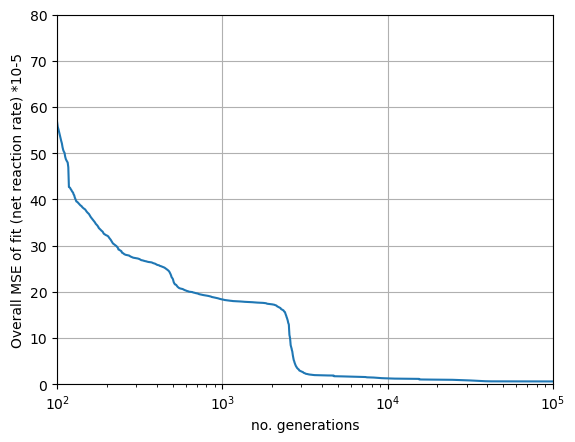

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900748349735898
-8.400990959988333
-7.601385118957121
-8.799924153983845
-8.301599669068862
-7.10752431786453
-8.100056406001482
-10.400425637559628
-7.706993321737472
-6.8062865482974075
-7.306718672402058
-8.004853359572397
-7.908469665279202
-6.804603638846735
-7.404618017575065
-7.409128154990593
-7.9000742807886475
-9.076416695163564
-8.385350699365395
-6.502298743196607
-7.302322555263113
-6.7186407904884735
-7.5187997883119095
-11.999998088901199
-7.322919045178848
-7.823961353351449
-1.3010299999993251


In [37]:
res.X

array([ -7.90074835,  -8.40099096,  -7.60138512,  -8.79992415,
        -8.30159967,  -7.10752432,  -8.10005641, -10.40042564,
        -7.70699332,  -6.80628655,  -7.30671867,  -8.00485336,
        -7.90846967,  -6.80460364,  -7.40461802,  -7.40912815,
        -7.90007428,  -9.0764167 ,  -8.3853507 ,  -6.50229874,
        -7.30232256,  -6.71864079,  -7.51879979, -11.99999809,
        -7.32291905,  -7.82396135,  -1.30103   ])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900748349735898
-8.4: -8.400990959988333
-7.6: -7.601385118957121
-8.8: -8.799924153983845
-8.3: -8.301599669068862
-7.1: -7.10752431786453
-8.1: -8.100056406001482
-10.9: -10.400425637559628
-7.7: -7.706993321737472
-6.8: -6.8062865482974075
-7.3: -7.306718672402058
-8.0: -8.004853359572397
-7.9: -7.908469665279202
-6.8: -6.804603638846735
-7.4: -7.404618017575065
-7.4: -7.409128154990593
-7.9: -7.9000742807886475
-9.1: -9.076416695163564
-8.4: -8.385350699365395
-6.5: -6.502298743196607
-7.3: -7.302322555263113
-6.7: -6.7186407904884735
-7.5: -7.5187997883119095
-11.8: -11.999998088901199
-7.3: -7.322919045178848
-7.8: -7.823961353351449
R-value: 0.9958643084823304
R2: 0.9917457209089902
